In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import math
import time
import cv2

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore')

#!pip install -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.model_selection import RandomizedSearchCV #for 
from keras.wrappers.scikit_learn import KerasRegressor

# 1. Funciones

In [7]:
def show_features(features,layer):
    feature_maps = features[layer]
    print('feature_maps shape: ', feature_maps.shape)

# plot all 256 maps in an 16x16 squares
    square = 16
    ix = 1
    plt.figure(figsize=(40, 40))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix - 1], cmap='viridis')
            ix += 1
    # show the figure
    plt.show()

In [8]:
def show_features2(features,layer):
    feature_maps = features[layer] 
    print('feature_maps shape: ', feature_maps.shape)
    for i in range(feature_maps.shape[-1]):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.show()
        print(feature_maps[0, :, :, i])

In [9]:
def show_results(model,X_test,y_test):
    results = model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {}'.format(results[0]))
    print('Test Accuracy: {}'.format(results[1]))
    y_pred = model.predict(X_test)
    y_test_list = []
    if isinstance(y_test, pd.DataFrame):
        for i in range(0,len(y_test)):
            y_test_list.append(y_test.iloc[i]['energia'])
    elif isinstance(y_test, np.ndarray):
        for i in range(0,len(y_test)):
            y_test_list.append(y_test[i][0])
    else:
        for i in range(0,len(y_test)):
            y_test_list.append(y_test.iloc[i])
    try:
        if y_pred.shape[1] == 1: y_pred = np.transpose(y_pred)[0]
    except IndexError:
        pass
    #print(y_test_list,y_pred)
    SSres = sum((y_test_list - y_pred)**2)
    media = np.mean(y_test_list)
    SStot = sum((y_test_list-media)**2)
    R_cuadrado = 1- SSres/SStot
    print('Coeficiente de correlacion: %s'%R_cuadrado)
    plt.plot(y_pred)
    plt.plot(y_test_list)
    plt.show()
    plt.scatter(y_test_list, y_pred)
    plt.xlabel('True Values [Energy(kcal/mol)]')
    plt.ylabel('Predictions [Energy(kcal/mol)]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100], 'r--')
    plt.show()
    error = y_pred - y_test_list
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error [Energy(kcal/mol)]")
    _ = plt.ylabel("Count")

In [10]:
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train loss')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    ax2.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    ax2.grid()
    ax2.legend()

    plt.show()

In [72]:
def PrepareConvInput_enc(X,Y):
    X = X[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']].to_numpy(copy=True).astype(int)
    Xg = keras.utils.to_categorical(X, num_classes=None, dtype='int') #Crea una codificación binaria para cada número en función 
    # del número de clases, es decir, si hay 4 clases el vector [0,3] queda como [[1,0,0,0],[0,0,0,1]]
    Yg = Y.to_numpy(copy=True).astype(float)
    return Xg,Yg

In [73]:
def PrepareConvInput(datos,Y):
    images = [np.zeros((2,2),dtype=np.uint8) for i in range(len(datos))]
    for i,j in enumerate(images):
        j[0,0] = datos.iloc[i]['subposicion_1']
        j[0,1] = datos.iloc[i]['subposicion_4']
        j[1,0] = datos.iloc[i]['subposicion_2']
        j[1,1] = datos.iloc[i]['subposicion_3']
    Yg = Y.to_numpy(copy=True).astype(float)
    return images,Yg

In [12]:
def errors(real, predictions):
    mse = mean_squared_error(real, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, predictions)
    r2 = r2_score(real, predictions)

    print('Mean Squared Error (MSE): ', mse)
    print('Root Mean Squared Error (RMSE): ', rmse)
    print('Mean Absolute Error (MAE): ', mae)
    print('R-squared Score (R^2): ', r2)

In [13]:
def create_images(datos,n_pos,n_sust):

    columns = list(datos.columns.values)
    images = [np.zeros((n_pos,n_sust,1),dtype=np.uint8) for i in range(len(datos))]
    for i,j in enumerate(images):
        for l,k in enumerate(columns):
            j[l,datos.iloc[i][k]] = 1

    return images

In [14]:
def create_images2(datos):

    images = [np.zeros((2,2),dtype=np.uint8) for i in range(len(datos))]
    for i,j in enumerate(images):
        j[0,0] = datos.iloc[i]['subposicion_1']
        j[0,1] = datos.iloc[i]['subposicion_4']
        j[1,0] = datos.iloc[i]['subposicion_2']
        j[1,1] = datos.iloc[i]['subposicion_3']

    return images

In [15]:
def show_samples(images):
    
    W = 2
    L = math.ceil(len(images)/W)
    fig, axes = plt.subplots(L, W, figsize=(32,32))
    axes = axes = axes.ravel()

    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i])
#        title = "{0} {1} {2} {3}".format(images[i][0,0],images[i][1,0],images[i][1,1],images[i][0,1])
#        axes[i].set_title(title)
        axes[i].axis('off')

#    plt.subplots_adjust(wspace=0.5)

In [16]:
def show_samples2(images):
    
    W = 5
    L = math.ceil(len(images)/W)
    fig, axes = plt.subplots(L, W, figsize=(14, 14))
    axes = axes.ravel()

    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i])
        title = "{0} {1} {2} {3}".format(images[i][0,0],images[i][1,0],images[i][1,1],images[i][0,1])
        axes[i].set_title(title)
        axes[i].axis('off')

#    plt.subplots_adjust(wspace=0.5)

In [48]:
def train_test_list(lista_mol,data):

    print(lista_mol)
    X_train = pd.DataFrame()
    X_test = data[['familia','subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4']]
    y_train = pd.DataFrame()
    y_test = data[['familia','energia']]
    for i in lista_mol:
        X_new = data[data.familia == i][['subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4']]
        X_train = pd.concat([X_train, X_new])
        y_new = data[data.familia == i][['energia']]
        y_train = pd.concat([y_train, y_new])
        X_test = X_test[X_test.familia != i]
        y_test = y_test[y_test.familia != i]
    X_test = X_test.drop(['familia'], axis=1)
    y_test = y_test.drop(['familia'], axis=1)
    return X_train, X_test, y_train, y_test

In [18]:
def train_test_encode(lista_train,lista_test):
    encoder = OneHotEncoder(sparse=False, categories='auto')

    X_train = lista_train.drop(['energia'], axis=1)
    X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
    encoded_train = encoder.fit_transform(X_train)
    encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
    X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
    X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))

    y_test = lista_test['energia']
    y_train = lista_train['energia']
    return X_train, X_test, y_train, y_test

In [19]:
def write_images(images, directory):
    import os
    import cv2

# Directorio donde se guardarán las imágenes -> directory

# Verificar si el directorio existe, y si no, crearlo
    if not os.path.exists(directory):
        os.makedirs(directory)

# Guardar la imagen en el directorio
    name = "Derv_"
    for image in images:
        image_name = name
        for i in image:
            image_name += str(np.argmax(i))
        image_name += ".png"
        file_path = os.path.join(directory, image_name)
        cv2.imwrite(file_path, image)

    print("Imagenes guardadas en:", directory)

In [20]:
def write_images2(images, directory):
    import os
    import cv2

# Directorio donde se guardarán las imágenes -> directory

# Verificar si el directorio existe, y si no, crearlo
    if not os.path.exists(directory):
        os.makedirs(directory)

# Guardar la imagen en el directorio
    name = "Derv_"
    for image in images:
        image_name = name
        image_name += "{0} {1} {2} {3}".format(image[0,0],image[1,0],image[1,1],image[0,1])
        image_name += ".png"
        file_path = os.path.join(directory, image_name)
        cv2.imwrite(file_path, image)

    print("Imagenes guardadas en:", directory)

In [144]:
def make_filtros(image):
    F1 = np.zeros((2,2))
    F1[1,0] = image[0,1]/image[1,1]
    F1[1,1] = (image[0,0]-(image[0,1]*image[1,0])/image[1,1])/image[1,1]
    F2 = np.zeros((2,2))
    F2[0,0] = 1
    F2[0,1] = -1*image[1,0]/image[1,1]
    F2[1,1] = (-1*image[0,0]+(image[0,1]*image[1,0])/image[1,1])/image[1,1]
    F3 = np.zeros((2,2))
    F3[0,1] = image[1,0]/image[1,1]
    F3[1,1] = (image[0,0]-(image[0,1]*image[1,0])/image[1,1])/image[1,1]
    F4 = np.zeros((2,2))
    F4[0,0] = 1
    F4[1,0] = -1*image[0,1]/image[1,1]
    F4[1,1] = (-1*image[0,0]+(image[0,1]*image[1,0])/image[1,1])/image[1,1]
    F5 = np.zeros((2,2))
    F5[0,0] = 1
    F5[0,1] = -1*image[1,0]/image[1,1]
    F5[1,0] = -1*image[0,1]/image[1,1]
    F5[1,1] = (2*image[0,1]*image[1,0])/(image[1,1])**2
    F6 = np.zeros((2,2))
    F6[0,1] = image[1,0]/image[1,1]
    F6[1,0] = image[0,1]/image[1,1]
    F6[1,1] = (-2*image[0,1]*image[1,0])/(image[1,1])**2
    F7 = np.zeros((2,2))
    F7[1,1] = image[0,0]/image[1,1]
    F8 = np.zeros((2,2))
    F8[1,0] = image[0,1]/image[1,1]
    F8[1,1] = (-1*image[0,1]*image[1,0])/(image[1,1])**2
    F9 = np.zeros((2,2))
    F9[0,1] = image[1,0]/image[1,1]
    F9[1,1] = (-1*image[0,1]*image[1,0])/(image[1,1])**2
    F10 = np.zeros((2,2))
    F10[0,0] = 1
    F10[0,1] = -1*image[1,0]/image[1,1]
    F10[1,0] = -1*image[0,1]/image[1,1]
    F10[1,1] = (((2*image[0,1]*image[1,0])/(image[1,1]))-image[0,0])/image[1,1]
    
    return [F1,F2,F3,F4,F5,F6,F7,F8,F9,F10]

In [102]:
def apply_filter_CNN2(image, filters, strides=(1, 1), padding='valid'):
    import tensorflow as tf
    
    # Obtener dimensiones de los datos de entrada y los filtros
#    input_shape = image.get_shape().as_list()
#    filter_shape = filters.get_shape().as_list()    
    filter_shape = len(filters)
    filter_height = filters[0].shape[0]
    filter_width = filters[0].shape[1]
    
    image_float32 = np.array(image).astype(np.float32)
    for i,filter in enumerate(filters): filters[i] = np.array(filter).astype(np.float32)
    # en el input las dimensiones tienen que ser [None,pixels_x,pixels_y,RGB(3) o GrayScale(1)]
    # en el filtro tiene que ser [kernel_x,kernel_y,RGB(3) o GrayScale(1),Nº filtros]
    inputs = tf.constant(tf.reshape(image_float32, (1, image.shape[0], image.shape[1], 1)), dtype=tf.float32)
    filters = np.swapaxes(filters,0,1)
    filters = np.swapaxes(filters,1,2)
    filters_tf = tf.constant(tf.reshape(filters, (filter_height, filter_width, 1, filter_shape)), dtype=tf.float32)

    # Definir los strides y el padding
    try:
        strides = [1, strides[0], strides[1], 1]
    except TypeError:
        strides = [1, strides, strides, 1]
    if padding == 'valid':
        padding = 'VALID'
    elif padding == 'same':
        padding = 'SAME'

    # Realizar la convolución
    images_conv = tf.nn.conv2d(inputs, filters_tf, strides=strides, padding=padding) #el [0,:,:,0] sirve para eliminar las dos dimendiones marcadas tambien se puede poner [0,...,0]
    print(images_conv.shape)
    for i in range(images_conv.shape[3]):
        print(filters_tf[:,:,0,i])
        img = images_conv[0,:,:,i]
        fig, ax = plt.subplots(1, figsize=(5, 5))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        plt.show()
        print(img)

# Ejemplo de uso
#inputs = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])  # Datos de entrada
#filters = tf.Variable(tf.random_normal([3, 3, 3, 64]))  # Filtros
#conv = custom_conv2d(inputs, filters, strides=(1, 1), padding='same')

# Verificar la forma del resultado
#print(conv.get_shape().as_list())

# 2. Carga de datos

In [50]:
# cargamos el csv
data = pd.read_csv("ALLDATA2.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']
#first order energies
data1 = pd.read_csv("first_order_energies.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data1.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']
#second order energies
data2 = pd.read_csv("second_order_energies.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data2.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']

In [51]:
data

familia  indice_fam  subposicion_1  subposicion_2  subposicion_3  \
0           1           1              0              0              0   
1           1           2              0              0              1   
2           1           3              1              0              0   
3           1           4              0              1              0   
4           2           1              0              0              0   
...       ...         ...            ...            ...            ...   
1290      346           1              1              1              1   
1291      347           1              2              2              2   
1292      348           1              3              3              3   
1293      349           1              4              4              4   
1294      350           1              5              5              5   

      subposicion_4   energia  
0                 1  1.290121  
1                 0  1.290121  
2                 0  1.290121  
3                 0  1.290121  
4                 2  0.060604  
...             ...       ...  
1290              1  9.626816  
1291              2  0.621384  
1292              3  4.204761  
1293              4  1.304497  
1294              5  1.989919  

[1295 rows x 7 columns]

In [52]:
data1

familia  indice_fam  subposicion_1  subposicion_2  subposicion_3  \
0           1           1              0              0              0   
1           1           2              0              0              1   
2           1           3              1              0              0   
3           1           4              0              1              0   
4           2           1              0              0              0   
...       ...         ...            ...            ...            ...   
1290      346           1              1              1              1   
1291      347           1              2              2              2   
1292      348           1              3              3              3   
1293      349           1              4              4              4   
1294      350           1              5              5              5   

      subposicion_4    energia  
0                 1   1.290121  
1                 0   1.290121  
2                 0   1.290121  
3                 0   1.290121  
4                 2   0.060604  
...             ...        ...  
1290              1   5.160484  
1291              2   0.242418  
1292              3   4.585988  
1293              4  10.561626  
1294              5  16.028441  

[1295 rows x 7 columns]

In [53]:
data2

familia  indice_fam  subposicion_1  subposicion_2  subposicion_3  \
0           1           1              0              0              0   
1           1           2              0              0              1   
2           1           3              1              0              0   
3           1           4              0              1              0   
4           2           1              0              0              0   
...       ...         ...            ...            ...            ...   
1290      346           1              1              1              1   
1291      347           1              2              2              2   
1292      348           1              3              3              3   
1293      349           1              4              4              4   
1294      350           1              5              5              5   

      subposicion_4    energia  
0                 1   1.290121  
1                 0   1.290121  
2                 0   1.290121  
3                 0   1.290121  
4                 2   0.060604  
...             ...        ...  
1290              1   9.785242  
1291              2   1.880188  
1292              3   4.004896  
1293              4  10.148582  
1294              5  28.427152  

[1295 rows x 7 columns]

Vamos a sumar uno a todas los sustituyentes de forma que el 1 será el hidrogeno...

In [54]:
data_mas1 = data.copy()

In [55]:
data_mas1['subposicion_1'] += 1
data_mas1['subposicion_2'] += 1
data_mas1['subposicion_3'] += 1
data_mas1['subposicion_4'] += 1

In [56]:
data_mas1

familia  indice_fam  subposicion_1  subposicion_2  subposicion_3  \
0           1           1              1              1              1   
1           1           2              1              1              2   
2           1           3              2              1              1   
3           1           4              1              2              1   
4           2           1              1              1              1   
...       ...         ...            ...            ...            ...   
1290      346           1              2              2              2   
1291      347           1              3              3              3   
1292      348           1              4              4              4   
1293      349           1              5              5              5   
1294      350           1              6              6              6   

      subposicion_4   energia  
0                 2  1.290121  
1                 1  1.290121  
2                 1  1.290121  
3                 1  1.290121  
4                 3  0.060604  
...             ...       ...  
1290              2  9.626816  
1291              3  0.621384  
1292              4  4.204761  
1293              5  1.304497  
1294              6  1.989919  

[1295 rows x 7 columns]

# 3. Modelización

## 3.1 Selección del data set inicial de forma manual

A la hora de seleccionar los datos de entrenamiento se puede hacer aleatoriamente o de forma manual. En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos un 0, es decir, que tengan al menos una posicion vacia.

In [43]:
lista = []
for i in range(len(data)):
    if data.iloc[i]['subposicion_1']==0 or data.iloc[i]['subposicion_2']==0 or data.iloc[i]['subposicion_3']==0 or data.iloc[i]['subposicion_4']==0:
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 0
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos dos 0, es decir, que tengan al menos dos posiciones vacias.

In [57]:
lista = []
for i in range(len(data)):
    if all(data.iloc[i][['subposicion_1','subposicion_2']].values==[0,0]) or all(data.iloc[i][['subposicion_1','subposicion_3']].values==[0,0]) or all(data.iloc[i][['subposicion_1','subposicion_4']].values==[0,0]) or all(data.iloc[i][['subposicion_2','subposicion_3']].values==[0,0]) or all(data.iloc[i][['subposicion_2','subposicion_4']].values==[0,0]) or all(data.iloc[i][['subposicion_3','subposicion_4']].values==[0,0]):
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos tres 0, es decir, que tengan al menos tres posiciones vacias.

In [28]:
lista = []
for i in range(len(data)):
    if all(data.iloc[i][['subposicion_1','subposicion_2','subposicion_3']].values==[0,0,0]) or all(data.iloc[i][['subposicion_1','subposicion_2','subposicion_4']].values==[0,0,0]) or all(data.iloc[i][['subposicion_1','subposicion_3','subposicion_4']].values==[0,0,0]) or all(data.iloc[i][['subposicion_2','subposicion_3','subposicion_4']].values==[0,0,0]):
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 2
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

In [186]:
X_train, X_test, y_train, y_test = train_test_list(lista,data_mas1)
list(X_train.columns.values)
print(X_train.shape,y_train.shape)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 151.0, 152.0, 153.0, 259.0, 35.0, 36.0, 37.0, 301.0, 302.0, 303.0, 304.0, 305.0, 52.0, 53.0, 316.0, 317.0, 319.0, 66.0, 322.0, 326.0, 331.0, 332.0, 333.0, 334.0, 335.0, 81.0, 82.0, 83.0, 84.0, 211.0, 212.0]
(170, 4) (170, 1)


In [187]:
images_train = create_images2(X_train)
images_test = create_images2(X_test)
print(images_train)

[array([[1, 2],
       [1, 1]], dtype=uint8), array([[1, 1],
       [1, 2]], dtype=uint8), array([[2, 1],
       [1, 1]], dtype=uint8), array([[1, 1],
       [2, 1]], dtype=uint8), array([[1, 3],
       [1, 1]], dtype=uint8), array([[1, 1],
       [1, 3]], dtype=uint8), array([[3, 1],
       [1, 1]], dtype=uint8), array([[1, 1],
       [3, 1]], dtype=uint8), array([[1, 4],
       [1, 1]], dtype=uint8), array([[1, 1],
       [1, 4]], dtype=uint8), array([[4, 1],
       [1, 1]], dtype=uint8), array([[1, 1],
       [4, 1]], dtype=uint8), array([[1, 5],
       [1, 1]], dtype=uint8), array([[1, 1],
       [1, 5]], dtype=uint8), array([[5, 1],
       [1, 1]], dtype=uint8), array([[1, 1],
       [5, 1]], dtype=uint8), array([[1, 6],
       [1, 1]], dtype=uint8), array([[1, 1],
       [1, 6]], dtype=uint8), array([[6, 1],
       [1, 1]], dtype=uint8), array([[1, 1],
       [6, 1]], dtype=uint8), array([[1, 3],
       [1, 2]], dtype=uint8), array([[1, 2],
       [1, 3]], dtype=uint8), array([[3

In [142]:
write_images2(images_train, "Imagenes_1_2_sust_2x2")

Imagenes guardadas en: Imagenes_1_2_sust_2x2


In [143]:
write_images2(images_test, "Imagenes_1_2_sust_2x2_test")

Imagenes guardadas en: Imagenes_1_2_sust_2x2_test


In [188]:
X_train,y_train = PrepareConvInput(X_train,y_train)
X_test,y_test = PrepareConvInput(X_test,y_test)

In [189]:
print(X_train[0], type(X_train[0]))

[[1 2]
 [1 1]] <class 'numpy.ndarray'>


In [148]:
filtros = make_filtros(X_train[0])

(1, 2, 2, 10)
tf.Tensor(
[[ 0.  0.]
 [ 2. -1.]], shape=(2, 2), dtype=float32)


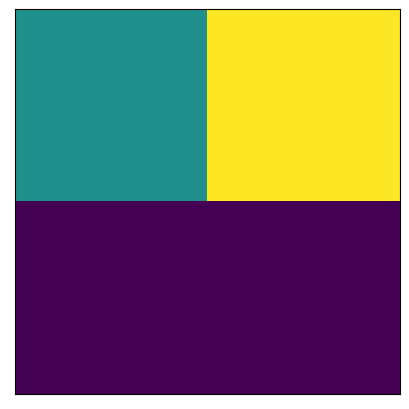

tf.Tensor(
[[1. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 1. -1.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


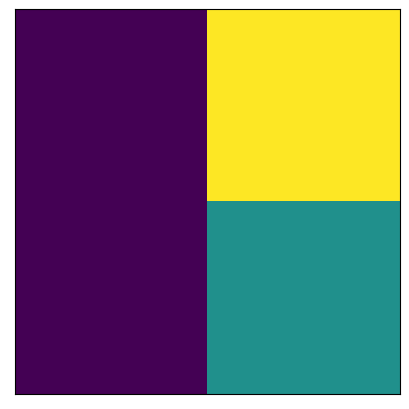

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.  1.]
 [ 0. -1.]], shape=(2, 2), dtype=float32)


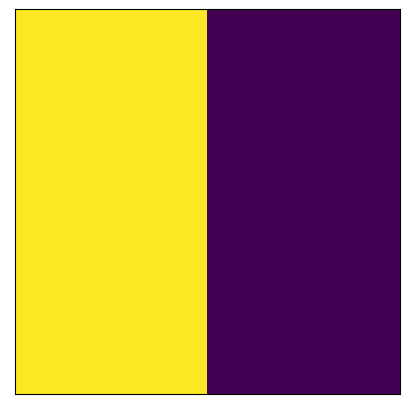

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 1.  0.]
 [-2.  1.]], shape=(2, 2), dtype=float32)


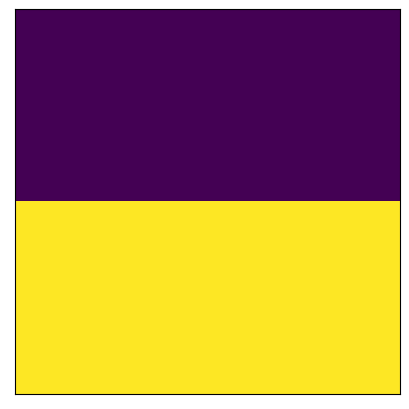

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 1. -1.]
 [-2.  4.]], shape=(2, 2), dtype=float32)


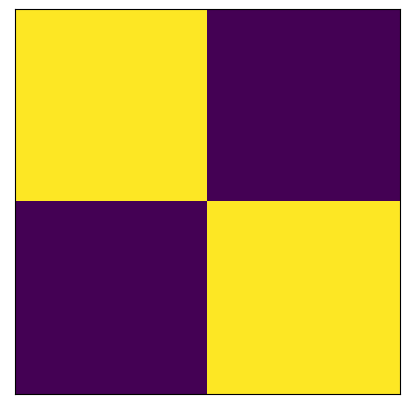

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.  1.]
 [ 2. -4.]], shape=(2, 2), dtype=float32)


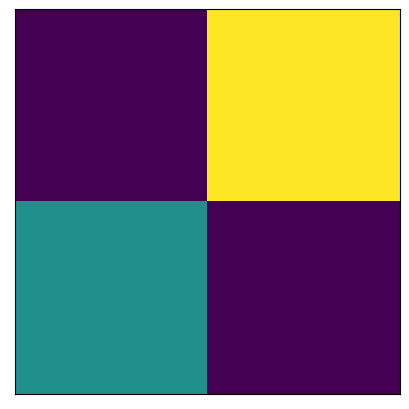

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


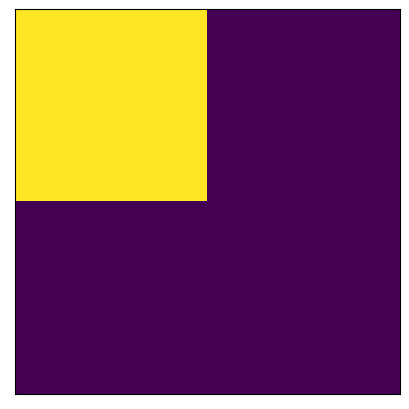

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.  0.]
 [ 2. -2.]], shape=(2, 2), dtype=float32)


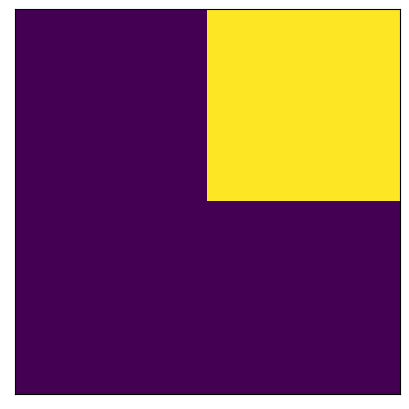

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.  1.]
 [ 0. -2.]], shape=(2, 2), dtype=float32)


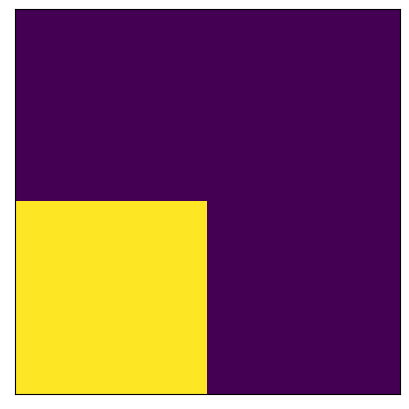

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 1. -1.]
 [-2.  3.]], shape=(2, 2), dtype=float32)


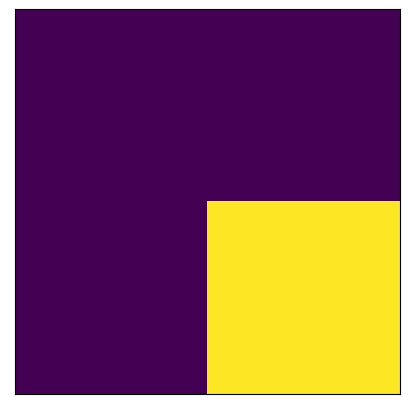

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


In [149]:
apply_filter_CNN2(X_train[0], filtros, padding='SAME', strides=1)

In [193]:
filtros = []
for train_image in X_train:
    filtros += make_filtros(train_image)

In [195]:
filtros[0]

array([[ 0.,  0.],
       [ 2., -1.]])

In [196]:
filtros = np.swapaxes(filtros,0,1)
filtros = np.swapaxes(filtros,1,2)

In [197]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [198]:
X_train[0].shape

(2, 2, 1)

In [200]:
# Definir la arquitectura de la red
model = keras.Sequential([
    layers.Conv2D(1700, (2, 2), strides=1, padding='SAME', input_shape=(2, 2, 1), activation='relu', 
                  kernel_initializer=keras.initializers.Constant(filtros), trainable=False),
#    layers.Conv2D(10, (2, 2), strides=1, padding='SAME', input_shape=(2, 2, 1), activation='relu', 
#                  kernel_initializer=keras.initializers.Constant(filtros), trainable=True),
    layers.Flatten(),
    layers.Dense(24, activation='elu'),
    layers.Dense(1, activation='linear')
])

# Compilar y entrenar la red
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, epochs=3000, validation_split=0.2, batch_size=32)

Epoch 1/3000
5/5 [==============================] - 2s 94ms/step - loss: 510.7340 - mean_absolute_error: 15.5192 - val_loss: 76.4923 - val_mean_absolute_error: 7.7926
Epoch 2/3000
5/5 [==============================] - 0s 16ms/step - loss: 46.4212 - mean_absolute_error: 5.2646 - val_loss: 12.4523 - val_mean_absolute_error: 2.7042
Epoch 3/3000
5/5 [==============================] - 0s 14ms/step - loss: 13.6154 - mean_absolute_error: 3.0122 - val_loss: 6.5096 - val_mean_absolute_error: 2.1207
Epoch 4/3000
5/5 [==============================] - 0s 16ms/step - loss: 8.9565 - mean_absolute_error: 2.2441 - val_loss: 12.4140 - val_mean_absolute_error: 2.6427
Epoch 5/3000
5/5 [==============================] - 0s 13ms/step - loss: 7.1761 - mean_absolute_error: 2.0421 - val_loss: 4.9497 - val_mean_absolute_error: 1.8206
Epoch 6/3000
5/5 [==============================] - 0s 14ms/step - loss: 6.2801 - mean_absolute_error: 2.0300 - val_loss: 5.9093 - val_mean_absolute_error: 1.7665
Epoch 7/3000
5

Epoch 51/3000
5/5 [==============================] - 0s 15ms/step - loss: 3.8274 - mean_absolute_error: 1.4452 - val_loss: 3.0106 - val_mean_absolute_error: 1.4066
Epoch 52/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.0230 - mean_absolute_error: 1.2689 - val_loss: 3.7846 - val_mean_absolute_error: 1.5142
Epoch 53/3000
5/5 [==============================] - 0s 15ms/step - loss: 3.2090 - mean_absolute_error: 1.3658 - val_loss: 8.4490 - val_mean_absolute_error: 2.3066
Epoch 54/3000
5/5 [==============================] - 0s 14ms/step - loss: 3.1720 - mean_absolute_error: 1.3263 - val_loss: 3.5537 - val_mean_absolute_error: 1.5988
Epoch 55/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.7554 - mean_absolute_error: 1.4704 - val_loss: 8.3238 - val_mean_absolute_error: 2.2793
Epoch 56/3000
5/5 [==============================] - 0s 14ms/step - loss: 4.2949 - mean_absolute_error: 1.5629 - val_loss: 5.5186 - val_mean_absolute_error: 1.8579
Epoch 57/3000
5/

Epoch 101/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.7085 - mean_absolute_error: 1.2026 - val_loss: 5.8885 - val_mean_absolute_error: 1.9089
Epoch 102/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6833 - mean_absolute_error: 1.2269 - val_loss: 3.4771 - val_mean_absolute_error: 1.4896
Epoch 103/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.5080 - mean_absolute_error: 1.1947 - val_loss: 4.6762 - val_mean_absolute_error: 1.7181
Epoch 104/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3888 - mean_absolute_error: 1.1589 - val_loss: 9.3211 - val_mean_absolute_error: 2.4279
Epoch 105/3000
5/5 [==============================] - 0s 9ms/step - loss: 3.3684 - mean_absolute_error: 1.3568 - val_loss: 3.5496 - val_mean_absolute_error: 1.4832
Epoch 106/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6667 - mean_absolute_error: 1.2108 - val_loss: 3.5165 - val_mean_absolute_error: 1.5005
Epoch 107/3

5/5 [==============================] - 0s 12ms/step - loss: 3.6281 - mean_absolute_error: 1.4413 - val_loss: 8.6873 - val_mean_absolute_error: 2.2530
Epoch 151/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7989 - mean_absolute_error: 1.2468 - val_loss: 7.8760 - val_mean_absolute_error: 2.1821
Epoch 152/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.5685 - mean_absolute_error: 1.1994 - val_loss: 6.3332 - val_mean_absolute_error: 1.9855
Epoch 153/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3054 - mean_absolute_error: 1.1597 - val_loss: 4.5234 - val_mean_absolute_error: 1.6664
Epoch 154/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.4005 - mean_absolute_error: 1.1500 - val_loss: 6.2170 - val_mean_absolute_error: 1.9368
Epoch 155/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.0913 - mean_absolute_error: 1.0377 - val_loss: 4.8361 - val_mean_absolute_error: 1.6815
Epoch 156/3000
5/5 [=====

Epoch 200/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.3740 - mean_absolute_error: 1.1596 - val_loss: 8.1524 - val_mean_absolute_error: 2.2807
Epoch 201/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.0740 - mean_absolute_error: 1.0767 - val_loss: 3.7314 - val_mean_absolute_error: 1.5488
Epoch 202/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.0747 - mean_absolute_error: 1.0800 - val_loss: 5.1730 - val_mean_absolute_error: 1.7706
Epoch 203/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1480 - mean_absolute_error: 1.1376 - val_loss: 6.9103 - val_mean_absolute_error: 2.0868
Epoch 204/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1214 - mean_absolute_error: 1.1075 - val_loss: 4.1613 - val_mean_absolute_error: 1.6211
Epoch 205/3000
5/5 [==============================] - 0s 13ms/step - loss: 4.5625 - mean_absolute_error: 1.5699 - val_loss: 8.0088 - val_mean_absolute_error: 2.2171
Epoch 206/

5/5 [==============================] - 0s 13ms/step - loss: 2.7162 - mean_absolute_error: 1.2235 - val_loss: 4.5917 - val_mean_absolute_error: 1.6180
Epoch 250/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.6778 - mean_absolute_error: 1.2947 - val_loss: 4.9295 - val_mean_absolute_error: 1.8714
Epoch 251/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.9524 - mean_absolute_error: 1.6370 - val_loss: 7.8978 - val_mean_absolute_error: 2.1755
Epoch 252/3000
5/5 [==============================] - 0s 12ms/step - loss: 3.2267 - mean_absolute_error: 1.3841 - val_loss: 12.7060 - val_mean_absolute_error: 2.9705
Epoch 253/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.8535 - mean_absolute_error: 1.2641 - val_loss: 4.3958 - val_mean_absolute_error: 1.6094
Epoch 254/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.2988 - mean_absolute_error: 1.1446 - val_loss: 4.6378 - val_mean_absolute_error: 1.6648
Epoch 255/3000
5/5 [====

Epoch 299/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8539 - mean_absolute_error: 1.0136 - val_loss: 6.8259 - val_mean_absolute_error: 2.0108
Epoch 300/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7921 - mean_absolute_error: 1.0091 - val_loss: 3.9030 - val_mean_absolute_error: 1.5842
Epoch 301/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6420 - mean_absolute_error: 1.2025 - val_loss: 4.2139 - val_mean_absolute_error: 1.6117
Epoch 302/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.8406 - mean_absolute_error: 1.2939 - val_loss: 4.2185 - val_mean_absolute_error: 1.6401
Epoch 303/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.1686 - mean_absolute_error: 1.3755 - val_loss: 13.0307 - val_mean_absolute_error: 2.9938
Epoch 304/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.4318 - mean_absolute_error: 1.4266 - val_loss: 22.9202 - val_mean_absolute_error: 3.8401
Epoch 30

5/5 [==============================] - 0s 12ms/step - loss: 4.3145 - mean_absolute_error: 1.5654 - val_loss: 5.5735 - val_mean_absolute_error: 1.8183
Epoch 349/3000
5/5 [==============================] - 0s 12ms/step - loss: 3.8792 - mean_absolute_error: 1.4564 - val_loss: 4.2122 - val_mean_absolute_error: 1.6973
Epoch 350/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.9837 - mean_absolute_error: 1.5045 - val_loss: 5.3047 - val_mean_absolute_error: 1.7573
Epoch 351/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.6801 - mean_absolute_error: 1.3956 - val_loss: 6.6655 - val_mean_absolute_error: 1.9844
Epoch 352/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.3614 - mean_absolute_error: 1.1735 - val_loss: 8.5214 - val_mean_absolute_error: 2.2659
Epoch 353/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.9703 - mean_absolute_error: 1.0782 - val_loss: 5.3448 - val_mean_absolute_error: 1.7662
Epoch 354/3000
5/5 [=====

Epoch 398/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.8065 - mean_absolute_error: 1.1901 - val_loss: 18.1784 - val_mean_absolute_error: 3.3512
Epoch 399/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.4245 - mean_absolute_error: 1.6031 - val_loss: 6.5432 - val_mean_absolute_error: 1.8745
Epoch 400/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.6387 - mean_absolute_error: 1.2044 - val_loss: 5.1144 - val_mean_absolute_error: 1.8657
Epoch 401/3000
5/5 [==============================] - 0s 12ms/step - loss: 4.2885 - mean_absolute_error: 1.5160 - val_loss: 5.6404 - val_mean_absolute_error: 1.7518
Epoch 402/3000
5/5 [==============================] - 0s 14ms/step - loss: 2.0530 - mean_absolute_error: 1.0723 - val_loss: 12.0287 - val_mean_absolute_error: 2.7398
Epoch 403/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2650 - mean_absolute_error: 1.1432 - val_loss: 5.4278 - val_mean_absolute_error: 1.7545
Epoch 40

5/5 [==============================] - 0s 14ms/step - loss: 2.0225 - mean_absolute_error: 1.1048 - val_loss: 5.3721 - val_mean_absolute_error: 1.8064
Epoch 448/3000
5/5 [==============================] - 0s 14ms/step - loss: 2.4421 - mean_absolute_error: 1.2148 - val_loss: 8.7552 - val_mean_absolute_error: 2.2728
Epoch 449/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.6004 - mean_absolute_error: 1.1781 - val_loss: 11.0575 - val_mean_absolute_error: 2.7007
Epoch 450/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.3322 - mean_absolute_error: 1.1900 - val_loss: 5.4870 - val_mean_absolute_error: 1.7382
Epoch 451/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.5767 - mean_absolute_error: 0.9303 - val_loss: 6.2095 - val_mean_absolute_error: 1.7929
Epoch 452/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8177 - mean_absolute_error: 1.0046 - val_loss: 7.6632 - val_mean_absolute_error: 2.0511
Epoch 453/3000
5/5 [====

Epoch 497/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.0144 - mean_absolute_error: 1.0910 - val_loss: 11.4146 - val_mean_absolute_error: 2.7888
Epoch 498/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3028 - mean_absolute_error: 1.1339 - val_loss: 5.2663 - val_mean_absolute_error: 1.7470
Epoch 499/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7832 - mean_absolute_error: 1.0331 - val_loss: 3.9109 - val_mean_absolute_error: 1.5243
Epoch 500/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2623 - mean_absolute_error: 1.1650 - val_loss: 4.1222 - val_mean_absolute_error: 1.5943
Epoch 501/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.8459 - mean_absolute_error: 1.2297 - val_loss: 7.7021 - val_mean_absolute_error: 2.1319
Epoch 502/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.9813 - mean_absolute_error: 1.1028 - val_loss: 8.1247 - val_mean_absolute_error: 2.2175
Epoch 503

5/5 [==============================] - 0s 12ms/step - loss: 6.1362 - mean_absolute_error: 1.8024 - val_loss: 6.8951 - val_mean_absolute_error: 2.0279
Epoch 547/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.0314 - mean_absolute_error: 1.5473 - val_loss: 5.0184 - val_mean_absolute_error: 1.8190
Epoch 548/3000
5/5 [==============================] - 0s 12ms/step - loss: 4.2428 - mean_absolute_error: 1.6069 - val_loss: 4.5812 - val_mean_absolute_error: 1.6278
Epoch 549/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2834 - mean_absolute_error: 1.1212 - val_loss: 8.8465 - val_mean_absolute_error: 2.2853
Epoch 550/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.1550 - mean_absolute_error: 1.1297 - val_loss: 10.3929 - val_mean_absolute_error: 2.5066
Epoch 551/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.1170 - mean_absolute_error: 1.1504 - val_loss: 5.2170 - val_mean_absolute_error: 1.7471
Epoch 552/3000
5/5 [====

Epoch 596/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.7942 - mean_absolute_error: 1.0337 - val_loss: 4.5566 - val_mean_absolute_error: 1.6601
Epoch 597/3000
5/5 [==============================] - 0s 12ms/step - loss: 3.0427 - mean_absolute_error: 1.3361 - val_loss: 7.5195 - val_mean_absolute_error: 2.0523
Epoch 598/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.0953 - mean_absolute_error: 1.1016 - val_loss: 9.8837 - val_mean_absolute_error: 2.4491
Epoch 599/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.8388 - mean_absolute_error: 1.0265 - val_loss: 6.8118 - val_mean_absolute_error: 1.9290
Epoch 600/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5426 - mean_absolute_error: 0.9364 - val_loss: 8.2887 - val_mean_absolute_error: 2.1478
Epoch 601/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7588 - mean_absolute_error: 0.9790 - val_loss: 7.0337 - val_mean_absolute_error: 1.9540
Epoch 602/

5/5 [==============================] - 0s 10ms/step - loss: 2.3400 - mean_absolute_error: 1.1444 - val_loss: 8.2214 - val_mean_absolute_error: 2.1959
Epoch 646/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.8649 - mean_absolute_error: 1.0288 - val_loss: 7.3225 - val_mean_absolute_error: 2.0537
Epoch 647/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5201 - mean_absolute_error: 0.9326 - val_loss: 10.8367 - val_mean_absolute_error: 2.5963
Epoch 648/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.9653 - mean_absolute_error: 1.0860 - val_loss: 6.0007 - val_mean_absolute_error: 1.8342
Epoch 649/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6125 - mean_absolute_error: 0.9522 - val_loss: 6.5411 - val_mean_absolute_error: 1.8837
Epoch 650/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5379 - mean_absolute_error: 0.9254 - val_loss: 10.5060 - val_mean_absolute_error: 2.4968
Epoch 651/3000
5/5 [===

Epoch 695/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.8280 - mean_absolute_error: 1.3136 - val_loss: 5.9853 - val_mean_absolute_error: 1.7900
Epoch 696/3000
5/5 [==============================] - 0s 16ms/step - loss: 2.4145 - mean_absolute_error: 1.1475 - val_loss: 16.9161 - val_mean_absolute_error: 3.2432
Epoch 697/3000
5/5 [==============================] - 0s 18ms/step - loss: 2.9256 - mean_absolute_error: 1.3193 - val_loss: 6.8109 - val_mean_absolute_error: 1.9417
Epoch 698/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.9270 - mean_absolute_error: 1.0680 - val_loss: 5.9041 - val_mean_absolute_error: 1.8295
Epoch 699/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.8167 - mean_absolute_error: 1.0145 - val_loss: 5.6251 - val_mean_absolute_error: 1.7307
Epoch 700/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5651 - mean_absolute_error: 0.9394 - val_loss: 10.4009 - val_mean_absolute_error: 2.4835
Epoch 70

5/5 [==============================] - 0s 15ms/step - loss: 1.5494 - mean_absolute_error: 0.9241 - val_loss: 7.5149 - val_mean_absolute_error: 2.1224
Epoch 745/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.5138 - mean_absolute_error: 0.9121 - val_loss: 6.4869 - val_mean_absolute_error: 1.9076
Epoch 746/3000
5/5 [==============================] - 0s 16ms/step - loss: 1.5276 - mean_absolute_error: 0.9006 - val_loss: 5.4345 - val_mean_absolute_error: 1.7054
Epoch 747/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.7816 - mean_absolute_error: 0.9921 - val_loss: 7.9829 - val_mean_absolute_error: 2.1726
Epoch 748/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.5923 - mean_absolute_error: 0.9584 - val_loss: 5.0449 - val_mean_absolute_error: 1.6946
Epoch 749/3000
5/5 [==============================] - 0s 15ms/step - loss: 2.0903 - mean_absolute_error: 1.1247 - val_loss: 9.1413 - val_mean_absolute_error: 2.3175
Epoch 750/3000
5/5 [=====

Epoch 794/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.2155 - mean_absolute_error: 1.3323 - val_loss: 11.9330 - val_mean_absolute_error: 2.7722
Epoch 795/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2761 - mean_absolute_error: 1.1567 - val_loss: 5.3099 - val_mean_absolute_error: 1.7269
Epoch 796/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2591 - mean_absolute_error: 1.1321 - val_loss: 4.2284 - val_mean_absolute_error: 1.6376
Epoch 797/3000
5/5 [==============================] - 0s 14ms/step - loss: 2.3347 - mean_absolute_error: 1.1435 - val_loss: 10.1159 - val_mean_absolute_error: 2.5299
Epoch 798/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2572 - mean_absolute_error: 1.1557 - val_loss: 11.9600 - val_mean_absolute_error: 2.7665
Epoch 799/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.1380 - mean_absolute_error: 1.3231 - val_loss: 5.2033 - val_mean_absolute_error: 1.8477
Epoch 8

5/5 [==============================] - 0s 11ms/step - loss: 1.6555 - mean_absolute_error: 0.9477 - val_loss: 11.1790 - val_mean_absolute_error: 2.6747
Epoch 844/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6956 - mean_absolute_error: 0.9890 - val_loss: 6.1180 - val_mean_absolute_error: 1.8649
Epoch 845/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.6992 - mean_absolute_error: 0.9769 - val_loss: 5.4959 - val_mean_absolute_error: 1.7167
Epoch 846/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.4465 - mean_absolute_error: 0.8983 - val_loss: 8.3102 - val_mean_absolute_error: 2.1432
Epoch 847/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5286 - mean_absolute_error: 0.9385 - val_loss: 4.8011 - val_mean_absolute_error: 1.6683
Epoch 848/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8702 - mean_absolute_error: 1.0549 - val_loss: 8.3205 - val_mean_absolute_error: 2.1504
Epoch 849/3000
5/5 [====

Epoch 893/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.4067 - mean_absolute_error: 1.2042 - val_loss: 8.0160 - val_mean_absolute_error: 2.1225
Epoch 894/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.6681 - mean_absolute_error: 1.2526 - val_loss: 13.4073 - val_mean_absolute_error: 2.9517
Epoch 895/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3714 - mean_absolute_error: 1.1671 - val_loss: 11.6360 - val_mean_absolute_error: 2.6674
Epoch 896/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.4632 - mean_absolute_error: 1.2086 - val_loss: 5.0611 - val_mean_absolute_error: 1.7720
Epoch 897/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3374 - mean_absolute_error: 1.1946 - val_loss: 8.1404 - val_mean_absolute_error: 2.1865
Epoch 898/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5535 - mean_absolute_error: 0.9226 - val_loss: 8.4875 - val_mean_absolute_error: 2.2093
Epoch 89

5/5 [==============================] - 0s 11ms/step - loss: 1.7226 - mean_absolute_error: 0.9909 - val_loss: 7.6089 - val_mean_absolute_error: 2.0858
Epoch 943/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.4162 - mean_absolute_error: 0.8751 - val_loss: 6.7088 - val_mean_absolute_error: 1.9121
Epoch 944/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4210 - mean_absolute_error: 0.8866 - val_loss: 7.0905 - val_mean_absolute_error: 1.9415
Epoch 945/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5820 - mean_absolute_error: 0.9472 - val_loss: 9.3110 - val_mean_absolute_error: 2.3028
Epoch 946/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3786 - mean_absolute_error: 0.8947 - val_loss: 4.7480 - val_mean_absolute_error: 1.7008
Epoch 947/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7214 - mean_absolute_error: 0.9747 - val_loss: 6.2659 - val_mean_absolute_error: 1.8146
Epoch 948/3000
5/5 [=====

Epoch 992/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.4408 - mean_absolute_error: 0.9255 - val_loss: 8.3425 - val_mean_absolute_error: 2.1534
Epoch 993/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.4368 - mean_absolute_error: 0.9033 - val_loss: 10.7523 - val_mean_absolute_error: 2.5452
Epoch 994/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7713 - mean_absolute_error: 1.0632 - val_loss: 5.2108 - val_mean_absolute_error: 1.6966
Epoch 995/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.8727 - mean_absolute_error: 1.0691 - val_loss: 6.8343 - val_mean_absolute_error: 1.8986
Epoch 996/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2575 - mean_absolute_error: 1.1077 - val_loss: 15.3442 - val_mean_absolute_error: 3.1359
Epoch 997/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6015 - mean_absolute_error: 1.2126 - val_loss: 9.7965 - val_mean_absolute_error: 2.4783
Epoch 998

5/5 [==============================] - 0s 11ms/step - loss: 1.3026 - mean_absolute_error: 0.8095 - val_loss: 5.4760 - val_mean_absolute_error: 1.7720
Epoch 1042/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.2843 - mean_absolute_error: 1.1601 - val_loss: 5.4299 - val_mean_absolute_error: 1.7983
Epoch 1043/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.9183 - mean_absolute_error: 1.0039 - val_loss: 10.6388 - val_mean_absolute_error: 2.5122
Epoch 1044/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7147 - mean_absolute_error: 0.9743 - val_loss: 9.7403 - val_mean_absolute_error: 2.3844
Epoch 1045/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4707 - mean_absolute_error: 0.8909 - val_loss: 8.8473 - val_mean_absolute_error: 2.2909
Epoch 1046/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5523 - mean_absolute_error: 0.9285 - val_loss: 6.7228 - val_mean_absolute_error: 1.9554
Epoch 1047/3000
5/5

5/5 [==============================] - 0s 12ms/step - loss: 1.6825 - mean_absolute_error: 0.9821 - val_loss: 6.0401 - val_mean_absolute_error: 1.8269
Epoch 1091/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.7168 - mean_absolute_error: 0.9805 - val_loss: 11.7595 - val_mean_absolute_error: 2.6894
Epoch 1092/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8259 - mean_absolute_error: 0.9818 - val_loss: 7.1680 - val_mean_absolute_error: 1.9584
Epoch 1093/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4298 - mean_absolute_error: 0.8803 - val_loss: 6.8308 - val_mean_absolute_error: 1.9046
Epoch 1094/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3469 - mean_absolute_error: 0.8504 - val_loss: 7.1131 - val_mean_absolute_error: 1.9572
Epoch 1095/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.2786 - mean_absolute_error: 0.8260 - val_loss: 9.9308 - val_mean_absolute_error: 2.4211
Epoch 1096/3000
5/5

5/5 [==============================] - 0s 11ms/step - loss: 2.1430 - mean_absolute_error: 1.0775 - val_loss: 10.4990 - val_mean_absolute_error: 2.4884
Epoch 1140/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.1881 - mean_absolute_error: 1.3216 - val_loss: 18.6217 - val_mean_absolute_error: 3.5493
Epoch 1141/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.0148 - mean_absolute_error: 1.5006 - val_loss: 8.5536 - val_mean_absolute_error: 2.2237
Epoch 1142/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3395 - mean_absolute_error: 1.1911 - val_loss: 6.9821 - val_mean_absolute_error: 1.9318
Epoch 1143/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.5415 - mean_absolute_error: 0.9285 - val_loss: 6.6712 - val_mean_absolute_error: 1.9382
Epoch 1144/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6079 - mean_absolute_error: 0.9605 - val_loss: 8.1008 - val_mean_absolute_error: 2.1759
Epoch 1145/3000
5/5

5/5 [==============================] - 0s 13ms/step - loss: 4.0333 - mean_absolute_error: 1.5115 - val_loss: 5.6030 - val_mean_absolute_error: 1.7925
Epoch 1189/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.3913 - mean_absolute_error: 1.1793 - val_loss: 5.3247 - val_mean_absolute_error: 1.7711
Epoch 1190/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.7160 - mean_absolute_error: 1.1704 - val_loss: 7.0632 - val_mean_absolute_error: 1.9148
Epoch 1191/3000
5/5 [==============================] - 0s 12ms/step - loss: 3.4041 - mean_absolute_error: 1.2853 - val_loss: 11.2677 - val_mean_absolute_error: 2.6002
Epoch 1192/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3567 - mean_absolute_error: 1.1417 - val_loss: 9.7326 - val_mean_absolute_error: 2.3427
Epoch 1193/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.7956 - mean_absolute_error: 0.9962 - val_loss: 8.8437 - val_mean_absolute_error: 2.2338
Epoch 1194/3000
5/5

5/5 [==============================] - 0s 13ms/step - loss: 1.8321 - mean_absolute_error: 0.9843 - val_loss: 13.7511 - val_mean_absolute_error: 2.9215
Epoch 1238/3000
5/5 [==============================] - 0s 14ms/step - loss: 2.2781 - mean_absolute_error: 1.1505 - val_loss: 4.9604 - val_mean_absolute_error: 1.7506
Epoch 1239/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.9811 - mean_absolute_error: 1.0972 - val_loss: 9.1356 - val_mean_absolute_error: 2.2869
Epoch 1240/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.4952 - mean_absolute_error: 0.9011 - val_loss: 11.1001 - val_mean_absolute_error: 2.5793
Epoch 1241/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8404 - mean_absolute_error: 1.0284 - val_loss: 6.8381 - val_mean_absolute_error: 1.9402
Epoch 1242/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.3345 - mean_absolute_error: 0.8580 - val_loss: 7.5932 - val_mean_absolute_error: 2.0838
Epoch 1243/3000
5/

5/5 [==============================] - 0s 11ms/step - loss: 1.2903 - mean_absolute_error: 0.8440 - val_loss: 8.7913 - val_mean_absolute_error: 2.2647
Epoch 1287/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.3014 - mean_absolute_error: 0.8304 - val_loss: 5.3247 - val_mean_absolute_error: 1.7454
Epoch 1288/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.1763 - mean_absolute_error: 1.0684 - val_loss: 5.6329 - val_mean_absolute_error: 1.7672
Epoch 1289/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.7850 - mean_absolute_error: 0.9769 - val_loss: 5.4547 - val_mean_absolute_error: 1.8019
Epoch 1290/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.1060 - mean_absolute_error: 1.0951 - val_loss: 13.5194 - val_mean_absolute_error: 2.9892
Epoch 1291/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3185 - mean_absolute_error: 1.1863 - val_loss: 7.2696 - val_mean_absolute_error: 1.9712
Epoch 1292/3000
5/5

5/5 [==============================] - 0s 14ms/step - loss: 2.2927 - mean_absolute_error: 1.1509 - val_loss: 8.6907 - val_mean_absolute_error: 2.2421
Epoch 1336/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9942 - mean_absolute_error: 1.0060 - val_loss: 13.8287 - val_mean_absolute_error: 2.9454
Epoch 1337/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.9302 - mean_absolute_error: 1.0807 - val_loss: 6.5368 - val_mean_absolute_error: 1.8744
Epoch 1338/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.0192 - mean_absolute_error: 1.0436 - val_loss: 5.2156 - val_mean_absolute_error: 1.7972
Epoch 1339/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.2384 - mean_absolute_error: 1.1105 - val_loss: 8.2716 - val_mean_absolute_error: 2.1793
Epoch 1340/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2343 - mean_absolute_error: 0.8263 - val_loss: 9.8814 - val_mean_absolute_error: 2.3888
Epoch 1341/3000
5/5

5/5 [==============================] - 0s 15ms/step - loss: 1.8810 - mean_absolute_error: 1.0077 - val_loss: 9.0855 - val_mean_absolute_error: 2.3098
Epoch 1385/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5193 - mean_absolute_error: 0.9273 - val_loss: 6.5544 - val_mean_absolute_error: 1.8497
Epoch 1386/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2225 - mean_absolute_error: 0.8173 - val_loss: 8.4713 - val_mean_absolute_error: 2.2086
Epoch 1387/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2888 - mean_absolute_error: 0.8352 - val_loss: 5.8797 - val_mean_absolute_error: 1.8358
Epoch 1388/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5043 - mean_absolute_error: 0.9161 - val_loss: 8.7395 - val_mean_absolute_error: 2.2176
Epoch 1389/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.4432 - mean_absolute_error: 0.8738 - val_loss: 7.6879 - val_mean_absolute_error: 2.0463
Epoch 1390/3000
5/5 

5/5 [==============================] - 0s 13ms/step - loss: 1.6219 - mean_absolute_error: 0.9701 - val_loss: 6.9303 - val_mean_absolute_error: 1.9553
Epoch 1434/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7567 - mean_absolute_error: 0.9824 - val_loss: 5.2400 - val_mean_absolute_error: 1.7471
Epoch 1435/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.5871 - mean_absolute_error: 1.2133 - val_loss: 18.3570 - val_mean_absolute_error: 3.4242
Epoch 1436/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.2873 - mean_absolute_error: 1.3567 - val_loss: 5.3426 - val_mean_absolute_error: 1.7082
Epoch 1437/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.4145 - mean_absolute_error: 1.1534 - val_loss: 5.3547 - val_mean_absolute_error: 1.7196
Epoch 1438/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5565 - mean_absolute_error: 0.8970 - val_loss: 12.6407 - val_mean_absolute_error: 2.7937
Epoch 1439/3000
5/

5/5 [==============================] - 0s 11ms/step - loss: 2.0255 - mean_absolute_error: 1.0430 - val_loss: 13.2334 - val_mean_absolute_error: 2.9145
Epoch 1483/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.2433 - mean_absolute_error: 1.1578 - val_loss: 6.8447 - val_mean_absolute_error: 1.9549
Epoch 1484/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.2894 - mean_absolute_error: 0.8321 - val_loss: 5.6505 - val_mean_absolute_error: 1.7781
Epoch 1485/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5547 - mean_absolute_error: 0.9429 - val_loss: 11.4307 - val_mean_absolute_error: 2.6834
Epoch 1486/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.8251 - mean_absolute_error: 1.0162 - val_loss: 5.4731 - val_mean_absolute_error: 1.7000
Epoch 1487/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4970 - mean_absolute_error: 0.8947 - val_loss: 6.5519 - val_mean_absolute_error: 1.8395
Epoch 1488/3000
5/

5/5 [==============================] - 0s 11ms/step - loss: 1.2088 - mean_absolute_error: 0.8038 - val_loss: 7.4837 - val_mean_absolute_error: 2.0256
Epoch 1532/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1648 - mean_absolute_error: 0.7972 - val_loss: 8.5343 - val_mean_absolute_error: 2.2111
Epoch 1533/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2010 - mean_absolute_error: 0.7957 - val_loss: 6.0995 - val_mean_absolute_error: 1.8284
Epoch 1534/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.3126 - mean_absolute_error: 0.8484 - val_loss: 9.6465 - val_mean_absolute_error: 2.4143
Epoch 1535/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.2843 - mean_absolute_error: 0.8327 - val_loss: 7.9703 - val_mean_absolute_error: 2.1123
Epoch 1536/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.1891 - mean_absolute_error: 0.7985 - val_loss: 7.8259 - val_mean_absolute_error: 2.1079
Epoch 1537/3000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 1.2938 - mean_absolute_error: 0.8338 - val_loss: 5.9875 - val_mean_absolute_error: 1.8475
Epoch 1581/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.3760 - mean_absolute_error: 0.8726 - val_loss: 7.5933 - val_mean_absolute_error: 2.0966
Epoch 1582/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4566 - mean_absolute_error: 0.8990 - val_loss: 10.3495 - val_mean_absolute_error: 2.5242
Epoch 1583/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.3156 - mean_absolute_error: 0.8535 - val_loss: 5.9111 - val_mean_absolute_error: 1.7998
Epoch 1584/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5054 - mean_absolute_error: 0.9156 - val_loss: 7.3280 - val_mean_absolute_error: 2.0502
Epoch 1585/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2443 - mean_absolute_error: 0.8473 - val_loss: 5.7941 - val_mean_absolute_error: 1.8617
Epoch 1586/3000
5/5

5/5 [==============================] - 0s 12ms/step - loss: 1.2592 - mean_absolute_error: 0.8132 - val_loss: 8.6720 - val_mean_absolute_error: 2.2198
Epoch 1630/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4150 - mean_absolute_error: 0.8663 - val_loss: 11.9210 - val_mean_absolute_error: 2.7422
Epoch 1631/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7267 - mean_absolute_error: 1.0090 - val_loss: 5.6965 - val_mean_absolute_error: 1.8846
Epoch 1632/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9274 - mean_absolute_error: 1.0200 - val_loss: 7.5400 - val_mean_absolute_error: 2.0741
Epoch 1633/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.1529 - mean_absolute_error: 0.8048 - val_loss: 9.1216 - val_mean_absolute_error: 2.3051
Epoch 1634/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.4104 - mean_absolute_error: 0.8773 - val_loss: 5.4555 - val_mean_absolute_error: 1.7612
Epoch 1635/3000
5/5

5/5 [==============================] - 0s 12ms/step - loss: 1.3864 - mean_absolute_error: 0.8816 - val_loss: 6.7540 - val_mean_absolute_error: 1.9009
Epoch 1679/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4235 - mean_absolute_error: 0.8780 - val_loss: 5.4143 - val_mean_absolute_error: 1.8483
Epoch 1680/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.0319 - mean_absolute_error: 1.0646 - val_loss: 12.5823 - val_mean_absolute_error: 2.7690
Epoch 1681/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7741 - mean_absolute_error: 1.0057 - val_loss: 9.3079 - val_mean_absolute_error: 2.3337
Epoch 1682/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7973 - mean_absolute_error: 1.0119 - val_loss: 5.2045 - val_mean_absolute_error: 1.8246
Epoch 1683/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5395 - mean_absolute_error: 0.9117 - val_loss: 8.7436 - val_mean_absolute_error: 2.2855
Epoch 1684/3000
5/5

5/5 [==============================] - 0s 11ms/step - loss: 1.2286 - mean_absolute_error: 0.8311 - val_loss: 10.2930 - val_mean_absolute_error: 2.5441
Epoch 1728/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8501 - mean_absolute_error: 1.0078 - val_loss: 11.0796 - val_mean_absolute_error: 2.6390
Epoch 1729/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.1693 - mean_absolute_error: 1.0980 - val_loss: 6.2930 - val_mean_absolute_error: 1.8225
Epoch 1730/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.9207 - mean_absolute_error: 1.2569 - val_loss: 4.6536 - val_mean_absolute_error: 1.7254
Epoch 1731/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.7262 - mean_absolute_error: 1.2047 - val_loss: 8.3598 - val_mean_absolute_error: 2.2067
Epoch 1732/3000
5/5 [==============================] - 0s 14ms/step - loss: 2.0837 - mean_absolute_error: 1.0981 - val_loss: 12.6037 - val_mean_absolute_error: 2.8776
Epoch 1733/3000
5

5/5 [==============================] - 0s 11ms/step - loss: 1.3457 - mean_absolute_error: 0.8745 - val_loss: 4.9367 - val_mean_absolute_error: 1.7083
Epoch 1777/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7462 - mean_absolute_error: 0.9643 - val_loss: 9.5346 - val_mean_absolute_error: 2.3706
Epoch 1778/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.4356 - mean_absolute_error: 0.8569 - val_loss: 8.8860 - val_mean_absolute_error: 2.2996
Epoch 1779/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.1726 - mean_absolute_error: 0.7930 - val_loss: 6.6878 - val_mean_absolute_error: 1.9245
Epoch 1780/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.2443 - mean_absolute_error: 0.7996 - val_loss: 5.5837 - val_mean_absolute_error: 1.7933
Epoch 1781/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.2842 - mean_absolute_error: 0.8381 - val_loss: 14.1330 - val_mean_absolute_error: 3.0284
Epoch 1782/3000
5/5

5/5 [==============================] - 0s 10ms/step - loss: 1.6777 - mean_absolute_error: 0.9647 - val_loss: 10.8583 - val_mean_absolute_error: 2.6359
Epoch 1826/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5512 - mean_absolute_error: 0.9200 - val_loss: 5.4882 - val_mean_absolute_error: 1.7191
Epoch 1827/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4011 - mean_absolute_error: 0.8468 - val_loss: 6.2364 - val_mean_absolute_error: 1.8454
Epoch 1828/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.2955 - mean_absolute_error: 0.8331 - val_loss: 10.0488 - val_mean_absolute_error: 2.4839
Epoch 1829/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7212 - mean_absolute_error: 0.9816 - val_loss: 6.9698 - val_mean_absolute_error: 1.9506
Epoch 1830/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5104 - mean_absolute_error: 0.8851 - val_loss: 6.2787 - val_mean_absolute_error: 1.8268
Epoch 1831/3000
5/

5/5 [==============================] - 0s 11ms/step - loss: 1.4621 - mean_absolute_error: 0.9242 - val_loss: 9.4141 - val_mean_absolute_error: 2.3771
Epoch 1875/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6008 - mean_absolute_error: 0.9719 - val_loss: 6.4256 - val_mean_absolute_error: 1.9442
Epoch 1876/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.4654 - mean_absolute_error: 0.8837 - val_loss: 5.9001 - val_mean_absolute_error: 1.8079
Epoch 1877/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.3521 - mean_absolute_error: 0.8523 - val_loss: 9.4344 - val_mean_absolute_error: 2.3746
Epoch 1878/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.2345 - mean_absolute_error: 0.8640 - val_loss: 7.5859 - val_mean_absolute_error: 2.1131
Epoch 1879/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.4546 - mean_absolute_error: 0.8820 - val_loss: 5.1207 - val_mean_absolute_error: 1.8274
Epoch 1880/3000
5/5 [=

5/5 [==============================] - 0s 13ms/step - loss: 1.3643 - mean_absolute_error: 0.8689 - val_loss: 7.5649 - val_mean_absolute_error: 2.0638
Epoch 1924/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6972 - mean_absolute_error: 0.9325 - val_loss: 9.7164 - val_mean_absolute_error: 2.4413
Epoch 1925/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2586 - mean_absolute_error: 0.8456 - val_loss: 6.9871 - val_mean_absolute_error: 2.0029
Epoch 1926/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.2516 - mean_absolute_error: 0.8258 - val_loss: 7.1002 - val_mean_absolute_error: 1.9562
Epoch 1927/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2803 - mean_absolute_error: 0.8464 - val_loss: 8.5127 - val_mean_absolute_error: 2.1943
Epoch 1928/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.1128 - mean_absolute_error: 0.7405 - val_loss: 6.6773 - val_mean_absolute_error: 1.9293
Epoch 1929/3000
5/5 [

5/5 [==============================] - 0s 10ms/step - loss: 1.2972 - mean_absolute_error: 0.8242 - val_loss: 6.8783 - val_mean_absolute_error: 1.9725
Epoch 1973/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.1615 - mean_absolute_error: 0.8154 - val_loss: 10.3654 - val_mean_absolute_error: 2.5173
Epoch 1974/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2715 - mean_absolute_error: 0.8631 - val_loss: 6.8253 - val_mean_absolute_error: 1.9568
Epoch 1975/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.1787 - mean_absolute_error: 0.8041 - val_loss: 5.4107 - val_mean_absolute_error: 1.7418
Epoch 1976/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6278 - mean_absolute_error: 0.9552 - val_loss: 8.0144 - val_mean_absolute_error: 2.1207
Epoch 1977/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5197 - mean_absolute_error: 0.9405 - val_loss: 11.2968 - val_mean_absolute_error: 2.6417
Epoch 1978/3000
5/

5/5 [==============================] - 0s 11ms/step - loss: 2.1795 - mean_absolute_error: 1.1019 - val_loss: 7.9925 - val_mean_absolute_error: 2.1877
Epoch 2022/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2400 - mean_absolute_error: 0.8131 - val_loss: 9.8159 - val_mean_absolute_error: 2.4649
Epoch 2023/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1057 - mean_absolute_error: 0.7801 - val_loss: 5.1986 - val_mean_absolute_error: 1.7360
Epoch 2024/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5818 - mean_absolute_error: 0.9461 - val_loss: 10.3504 - val_mean_absolute_error: 2.5569
Epoch 2025/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3307 - mean_absolute_error: 0.8663 - val_loss: 7.1903 - val_mean_absolute_error: 2.0331
Epoch 2026/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.0691 - mean_absolute_error: 0.7614 - val_loss: 11.1146 - val_mean_absolute_error: 2.6394
Epoch 2027/3000
5/

5/5 [==============================] - 0s 10ms/step - loss: 1.5963 - mean_absolute_error: 0.9538 - val_loss: 5.5114 - val_mean_absolute_error: 1.8450
Epoch 2071/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.4940 - mean_absolute_error: 0.9176 - val_loss: 8.6034 - val_mean_absolute_error: 2.2321
Epoch 2072/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3811 - mean_absolute_error: 0.8959 - val_loss: 11.8222 - val_mean_absolute_error: 2.7767
Epoch 2073/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.8121 - mean_absolute_error: 0.9993 - val_loss: 5.5538 - val_mean_absolute_error: 1.8498
Epoch 2074/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8395 - mean_absolute_error: 0.9444 - val_loss: 5.8417 - val_mean_absolute_error: 1.8011
Epoch 2075/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7711 - mean_absolute_error: 0.9780 - val_loss: 13.0742 - val_mean_absolute_error: 2.9471
Epoch 2076/3000
5/5

5/5 [==============================] - 0s 11ms/step - loss: 1.6447 - mean_absolute_error: 0.9517 - val_loss: 5.3034 - val_mean_absolute_error: 1.8061
Epoch 2120/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.6653 - mean_absolute_error: 0.9951 - val_loss: 9.7862 - val_mean_absolute_error: 2.3846
Epoch 2121/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3920 - mean_absolute_error: 0.8790 - val_loss: 9.3396 - val_mean_absolute_error: 2.3086
Epoch 2122/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.3798 - mean_absolute_error: 0.8596 - val_loss: 6.9384 - val_mean_absolute_error: 1.9264
Epoch 2123/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.1000 - mean_absolute_error: 0.7523 - val_loss: 8.1427 - val_mean_absolute_error: 2.1776
Epoch 2124/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.2158 - mean_absolute_error: 0.8077 - val_loss: 6.6197 - val_mean_absolute_error: 1.9326
Epoch 2125/3000
5/5 

5/5 [==============================] - 0s 11ms/step - loss: 1.0616 - mean_absolute_error: 0.7486 - val_loss: 6.6864 - val_mean_absolute_error: 1.9185
Epoch 2169/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.0163 - mean_absolute_error: 0.7135 - val_loss: 7.5563 - val_mean_absolute_error: 2.0782
Epoch 2170/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.9900 - mean_absolute_error: 0.7028 - val_loss: 7.2699 - val_mean_absolute_error: 2.0361
Epoch 2171/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.0460 - mean_absolute_error: 0.7297 - val_loss: 10.1035 - val_mean_absolute_error: 2.4884
Epoch 2172/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.3786 - mean_absolute_error: 0.8504 - val_loss: 7.6347 - val_mean_absolute_error: 2.0857
Epoch 2173/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3440 - mean_absolute_error: 0.8423 - val_loss: 6.4125 - val_mean_absolute_error: 1.9124
Epoch 2174/3000
5/5

5/5 [==============================] - 0s 17ms/step - loss: 1.0703 - mean_absolute_error: 0.7606 - val_loss: 7.6695 - val_mean_absolute_error: 2.1200
Epoch 2218/3000
5/5 [==============================] - 0s 16ms/step - loss: 1.2091 - mean_absolute_error: 0.8084 - val_loss: 7.3120 - val_mean_absolute_error: 2.0363
Epoch 2219/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.0432 - mean_absolute_error: 0.7354 - val_loss: 8.2706 - val_mean_absolute_error: 2.2109
Epoch 2220/3000
5/5 [==============================] - 0s 17ms/step - loss: 1.0472 - mean_absolute_error: 0.7604 - val_loss: 6.5379 - val_mean_absolute_error: 1.8702
Epoch 2221/3000
5/5 [==============================] - 0s 19ms/step - loss: 1.0541 - mean_absolute_error: 0.7406 - val_loss: 7.2200 - val_mean_absolute_error: 2.0150
Epoch 2222/3000
5/5 [==============================] - 0s 19ms/step - loss: 1.0302 - mean_absolute_error: 0.7137 - val_loss: 9.2871 - val_mean_absolute_error: 2.3719
Epoch 2223/3000
5/5 

5/5 [==============================] - 0s 15ms/step - loss: 1.0584 - mean_absolute_error: 0.7563 - val_loss: 8.4872 - val_mean_absolute_error: 2.2358
Epoch 2267/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.1471 - mean_absolute_error: 0.7777 - val_loss: 7.6693 - val_mean_absolute_error: 2.1518
Epoch 2268/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.0865 - mean_absolute_error: 0.7596 - val_loss: 6.3830 - val_mean_absolute_error: 1.9025
Epoch 2269/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.1143 - mean_absolute_error: 0.7495 - val_loss: 8.4032 - val_mean_absolute_error: 2.1971
Epoch 2270/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.0170 - mean_absolute_error: 0.7558 - val_loss: 8.9872 - val_mean_absolute_error: 2.3289
Epoch 2271/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.1207 - mean_absolute_error: 0.7818 - val_loss: 5.1614 - val_mean_absolute_error: 1.8117
Epoch 2272/3000
5/5 

5/5 [==============================] - 0s 11ms/step - loss: 1.0444 - mean_absolute_error: 0.7647 - val_loss: 7.9605 - val_mean_absolute_error: 2.1233
Epoch 2316/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.1470 - mean_absolute_error: 0.7673 - val_loss: 5.9695 - val_mean_absolute_error: 1.8569
Epoch 2317/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1748 - mean_absolute_error: 0.7979 - val_loss: 7.3712 - val_mean_absolute_error: 2.0318
Epoch 2318/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.0785 - mean_absolute_error: 0.7641 - val_loss: 9.5936 - val_mean_absolute_error: 2.3948
Epoch 2319/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.0236 - mean_absolute_error: 0.7382 - val_loss: 6.4996 - val_mean_absolute_error: 1.9216
Epoch 2320/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9598 - mean_absolute_error: 0.7154 - val_loss: 8.7993 - val_mean_absolute_error: 2.2801
Epoch 2321/3000
5/5 

5/5 [==============================] - 0s 11ms/step - loss: 0.9711 - mean_absolute_error: 0.7025 - val_loss: 6.7933 - val_mean_absolute_error: 1.9367
Epoch 2365/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0486 - mean_absolute_error: 0.7190 - val_loss: 7.7231 - val_mean_absolute_error: 2.1104
Epoch 2366/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9722 - mean_absolute_error: 0.7054 - val_loss: 9.9885 - val_mean_absolute_error: 2.4240
Epoch 2367/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.1015 - mean_absolute_error: 0.7489 - val_loss: 5.8030 - val_mean_absolute_error: 1.8145
Epoch 2368/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.8162 - mean_absolute_error: 0.9961 - val_loss: 7.9555 - val_mean_absolute_error: 2.1209
Epoch 2369/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1459 - mean_absolute_error: 0.7675 - val_loss: 12.3459 - val_mean_absolute_error: 2.8646
Epoch 2370/3000
5/5

5/5 [==============================] - 0s 13ms/step - loss: 2.2933 - mean_absolute_error: 1.1198 - val_loss: 11.5177 - val_mean_absolute_error: 2.6839
Epoch 2414/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1758 - mean_absolute_error: 1.1099 - val_loss: 10.7297 - val_mean_absolute_error: 2.5937
Epoch 2415/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.1038 - mean_absolute_error: 0.7572 - val_loss: 6.3424 - val_mean_absolute_error: 1.8740
Epoch 2416/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1903 - mean_absolute_error: 0.7661 - val_loss: 7.4819 - val_mean_absolute_error: 2.0686
Epoch 2417/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.0026 - mean_absolute_error: 0.7233 - val_loss: 10.6539 - val_mean_absolute_error: 2.5783
Epoch 2418/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.2622 - mean_absolute_error: 0.8189 - val_loss: 7.0493 - val_mean_absolute_error: 1.9879
Epoch 2419/3000
5

5/5 [==============================] - 0s 13ms/step - loss: 1.0264 - mean_absolute_error: 0.7586 - val_loss: 7.6029 - val_mean_absolute_error: 2.1048
Epoch 2463/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0186 - mean_absolute_error: 0.7449 - val_loss: 11.4998 - val_mean_absolute_error: 2.7237
Epoch 2464/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.0986 - mean_absolute_error: 0.7370 - val_loss: 6.6418 - val_mean_absolute_error: 1.9425
Epoch 2465/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0408 - mean_absolute_error: 0.7306 - val_loss: 7.2781 - val_mean_absolute_error: 2.0486
Epoch 2466/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9983 - mean_absolute_error: 0.7110 - val_loss: 8.0123 - val_mean_absolute_error: 2.1562
Epoch 2467/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0402 - mean_absolute_error: 0.7339 - val_loss: 6.9215 - val_mean_absolute_error: 1.9709
Epoch 2468/3000
5/5

5/5 [==============================] - 0s 11ms/step - loss: 1.0860 - mean_absolute_error: 0.7415 - val_loss: 5.6908 - val_mean_absolute_error: 1.8291
Epoch 2512/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6363 - mean_absolute_error: 0.9183 - val_loss: 8.8457 - val_mean_absolute_error: 2.2533
Epoch 2513/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.2923 - mean_absolute_error: 0.8455 - val_loss: 8.2490 - val_mean_absolute_error: 2.2247
Epoch 2514/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1640 - mean_absolute_error: 0.8089 - val_loss: 10.4102 - val_mean_absolute_error: 2.5630
Epoch 2515/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.0289 - mean_absolute_error: 0.7439 - val_loss: 5.5741 - val_mean_absolute_error: 1.7693
Epoch 2516/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3694 - mean_absolute_error: 0.8261 - val_loss: 9.1937 - val_mean_absolute_error: 2.3381
Epoch 2517/3000
5/5

5/5 [==============================] - 0s 13ms/step - loss: 1.1590 - mean_absolute_error: 0.7967 - val_loss: 7.4098 - val_mean_absolute_error: 2.0225
Epoch 2561/3000
5/5 [==============================] - 0s 13ms/step - loss: 0.9824 - mean_absolute_error: 0.7043 - val_loss: 6.9978 - val_mean_absolute_error: 1.9920
Epoch 2562/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.8882 - mean_absolute_error: 0.6810 - val_loss: 10.4199 - val_mean_absolute_error: 2.5462
Epoch 2563/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0165 - mean_absolute_error: 0.7239 - val_loss: 7.1741 - val_mean_absolute_error: 1.9950
Epoch 2564/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9137 - mean_absolute_error: 0.6839 - val_loss: 8.2180 - val_mean_absolute_error: 2.2005
Epoch 2565/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9943 - mean_absolute_error: 0.7104 - val_loss: 10.6953 - val_mean_absolute_error: 2.5747
Epoch 2566/3000
5/

5/5 [==============================] - 0s 11ms/step - loss: 1.3172 - mean_absolute_error: 0.8381 - val_loss: 9.3382 - val_mean_absolute_error: 2.3662
Epoch 2610/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.3315 - mean_absolute_error: 0.8263 - val_loss: 10.0347 - val_mean_absolute_error: 2.4825
Epoch 2611/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1549 - mean_absolute_error: 0.8019 - val_loss: 8.4083 - val_mean_absolute_error: 2.1673
Epoch 2612/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.1044 - mean_absolute_error: 0.7500 - val_loss: 6.4884 - val_mean_absolute_error: 1.9036
Epoch 2613/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9340 - mean_absolute_error: 0.7231 - val_loss: 13.7650 - val_mean_absolute_error: 3.0298
Epoch 2614/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.3850 - mean_absolute_error: 0.9025 - val_loss: 5.9689 - val_mean_absolute_error: 1.8380
Epoch 2615/3000
5/

5/5 [==============================] - 0s 12ms/step - loss: 1.3714 - mean_absolute_error: 0.8370 - val_loss: 13.9150 - val_mean_absolute_error: 3.0631
Epoch 2659/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9081 - mean_absolute_error: 1.0157 - val_loss: 5.8628 - val_mean_absolute_error: 1.8179
Epoch 2660/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7712 - mean_absolute_error: 0.9545 - val_loss: 5.0143 - val_mean_absolute_error: 1.7136
Epoch 2661/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1403 - mean_absolute_error: 1.0970 - val_loss: 11.8534 - val_mean_absolute_error: 2.7810
Epoch 2662/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.8627 - mean_absolute_error: 1.0001 - val_loss: 11.5264 - val_mean_absolute_error: 2.7046
Epoch 2663/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9649 - mean_absolute_error: 1.0133 - val_loss: 5.7956 - val_mean_absolute_error: 1.9789
Epoch 2664/3000
5

5/5 [==============================] - 0s 11ms/step - loss: 1.0580 - mean_absolute_error: 0.7374 - val_loss: 7.9369 - val_mean_absolute_error: 2.1406
Epoch 2708/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.9225 - mean_absolute_error: 0.6897 - val_loss: 7.8929 - val_mean_absolute_error: 2.1642
Epoch 2709/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.9394 - mean_absolute_error: 0.6823 - val_loss: 9.4891 - val_mean_absolute_error: 2.4320
Epoch 2710/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2051 - mean_absolute_error: 0.7713 - val_loss: 6.2691 - val_mean_absolute_error: 1.9196
Epoch 2711/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1264 - mean_absolute_error: 0.7887 - val_loss: 9.1901 - val_mean_absolute_error: 2.3841
Epoch 2712/3000
5/5 [==============================] - 0s 9ms/step - loss: 1.0770 - mean_absolute_error: 0.7457 - val_loss: 7.6728 - val_mean_absolute_error: 2.0629
Epoch 2713/3000
5/5 [

5/5 [==============================] - 0s 15ms/step - loss: 0.8795 - mean_absolute_error: 0.6729 - val_loss: 6.4056 - val_mean_absolute_error: 1.9241
Epoch 2757/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.1287 - mean_absolute_error: 0.7820 - val_loss: 10.6606 - val_mean_absolute_error: 2.6196
Epoch 2758/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3208 - mean_absolute_error: 0.8467 - val_loss: 7.1325 - val_mean_absolute_error: 2.0074
Epoch 2759/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.0804 - mean_absolute_error: 0.7339 - val_loss: 6.3707 - val_mean_absolute_error: 1.8787
Epoch 2760/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.2324 - mean_absolute_error: 0.8101 - val_loss: 8.4224 - val_mean_absolute_error: 2.2394
Epoch 2761/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.9138 - mean_absolute_error: 0.6934 - val_loss: 7.7382 - val_mean_absolute_error: 2.1272
Epoch 2762/3000
5/5

5/5 [==============================] - 0s 10ms/step - loss: 1.2530 - mean_absolute_error: 0.8254 - val_loss: 6.8953 - val_mean_absolute_error: 1.9664
Epoch 2806/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.0445 - mean_absolute_error: 0.7039 - val_loss: 6.7895 - val_mean_absolute_error: 1.9962
Epoch 2807/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.0257 - mean_absolute_error: 0.7369 - val_loss: 12.4555 - val_mean_absolute_error: 2.8697
Epoch 2808/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.4372 - mean_absolute_error: 0.8954 - val_loss: 6.5736 - val_mean_absolute_error: 1.9656
Epoch 2809/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3822 - mean_absolute_error: 0.8767 - val_loss: 6.6780 - val_mean_absolute_error: 1.9821
Epoch 2810/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.3355 - mean_absolute_error: 0.8612 - val_loss: 11.9870 - val_mean_absolute_error: 2.7872
Epoch 2811/3000
5/

5/5 [==============================] - 0s 21ms/step - loss: 2.0109 - mean_absolute_error: 1.0541 - val_loss: 6.2319 - val_mean_absolute_error: 1.9184
Epoch 2855/3000
5/5 [==============================] - 0s 23ms/step - loss: 1.3225 - mean_absolute_error: 0.8976 - val_loss: 8.8491 - val_mean_absolute_error: 2.2811
Epoch 2856/3000
5/5 [==============================] - 0s 18ms/step - loss: 1.0986 - mean_absolute_error: 0.7698 - val_loss: 8.2071 - val_mean_absolute_error: 2.2242
Epoch 2857/3000
5/5 [==============================] - 0s 17ms/step - loss: 1.0048 - mean_absolute_error: 0.7165 - val_loss: 9.0902 - val_mean_absolute_error: 2.3753
Epoch 2858/3000
5/5 [==============================] - 0s 19ms/step - loss: 1.2898 - mean_absolute_error: 0.8215 - val_loss: 5.2939 - val_mean_absolute_error: 1.7922
Epoch 2859/3000
5/5 [==============================] - 0s 20ms/step - loss: 1.5208 - mean_absolute_error: 0.8795 - val_loss: 8.5131 - val_mean_absolute_error: 2.2540
Epoch 2860/3000
5/5 

5/5 [==============================] - 0s 13ms/step - loss: 1.3299 - mean_absolute_error: 0.8688 - val_loss: 8.7695 - val_mean_absolute_error: 2.2603
Epoch 2904/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.2364 - mean_absolute_error: 0.7874 - val_loss: 11.4291 - val_mean_absolute_error: 2.7229
Epoch 2905/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.4209 - mean_absolute_error: 0.8362 - val_loss: 6.4314 - val_mean_absolute_error: 1.9079
Epoch 2906/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.1985 - mean_absolute_error: 0.7921 - val_loss: 7.5561 - val_mean_absolute_error: 2.1325
Epoch 2907/3000
5/5 [==============================] - 0s 14ms/step - loss: 0.9805 - mean_absolute_error: 0.7305 - val_loss: 8.4052 - val_mean_absolute_error: 2.2603
Epoch 2908/3000
5/5 [==============================] - 0s 13ms/step - loss: 0.9317 - mean_absolute_error: 0.6871 - val_loss: 7.9820 - val_mean_absolute_error: 2.1423
Epoch 2909/3000
5/5

5/5 [==============================] - 0s 10ms/step - loss: 1.1419 - mean_absolute_error: 0.7761 - val_loss: 10.1808 - val_mean_absolute_error: 2.5500
Epoch 2953/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.1641 - mean_absolute_error: 0.7994 - val_loss: 7.9165 - val_mean_absolute_error: 2.1497
Epoch 2954/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.2061 - mean_absolute_error: 0.7863 - val_loss: 5.2864 - val_mean_absolute_error: 1.8611
Epoch 2955/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.0897 - mean_absolute_error: 1.0944 - val_loss: 10.0332 - val_mean_absolute_error: 2.4763
Epoch 2956/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7895 - mean_absolute_error: 1.0190 - val_loss: 10.1143 - val_mean_absolute_error: 2.4853
Epoch 2957/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.3148 - mean_absolute_error: 0.8857 - val_loss: 6.1290 - val_mean_absolute_error: 1.9643
Epoch 2958/3000
5

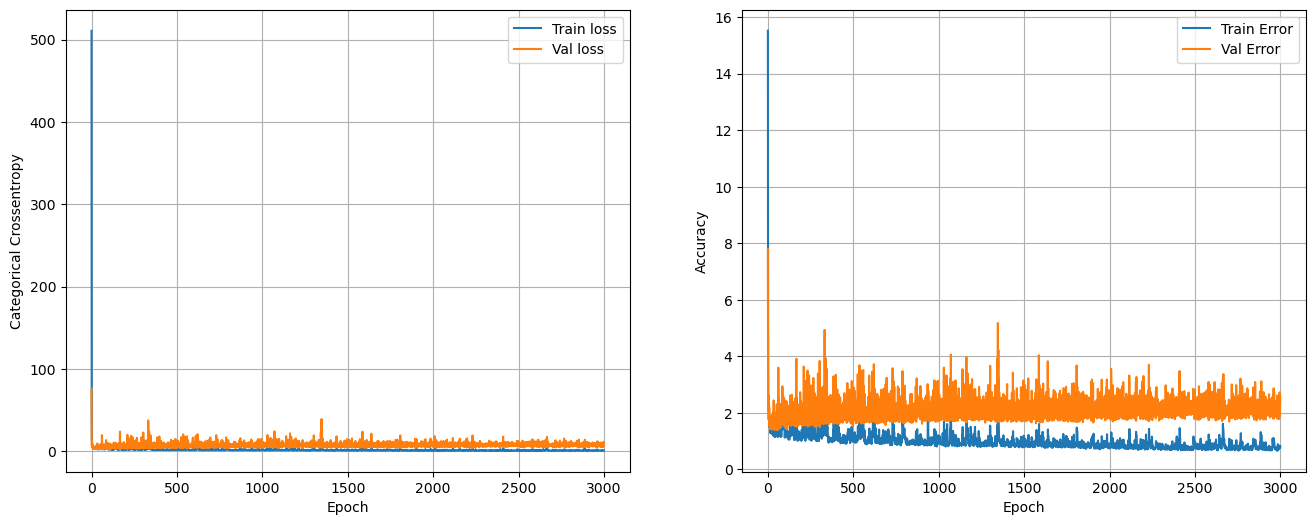

In [201]:
show_loss_accuracy_evolution(history)

Test Loss: 23.908329010009766
Test Accuracy: 3.615034818649292
36/36 [==============================] - 0s 2ms/step
Coeficiente de correlacion: -0.15979378364766395


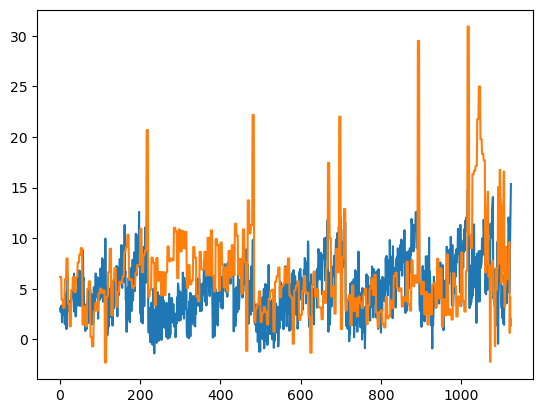

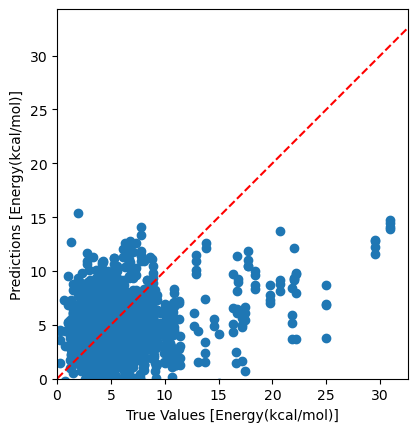

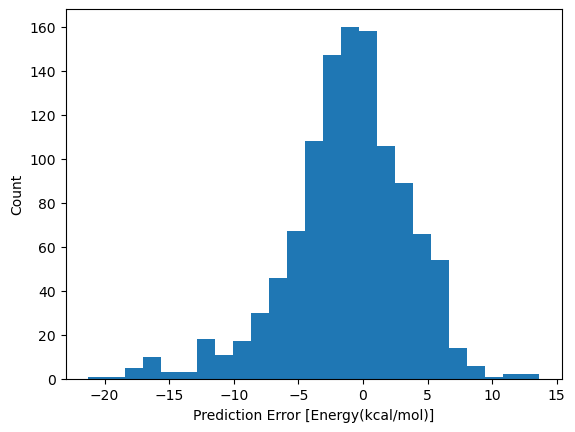

In [202]:
show_results(model,X_test,y_test)

dict_keys(['conv2d_10', 'flatten_10', 'dense_20', 'dense_21'])


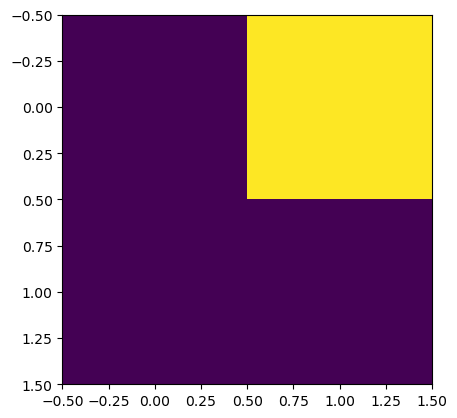

In [203]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

feature_maps shape:  (1, 2, 2, 1700)


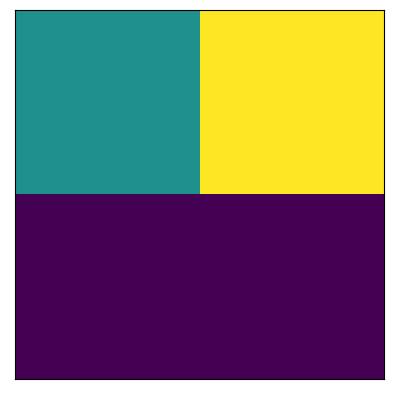

tf.Tensor(
[[1. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


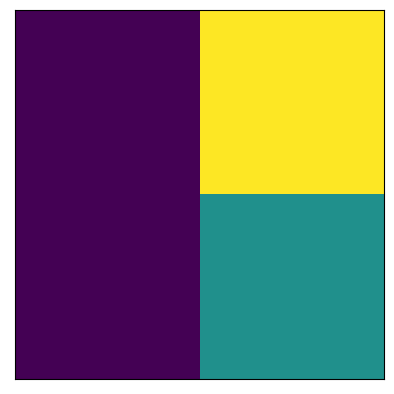

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


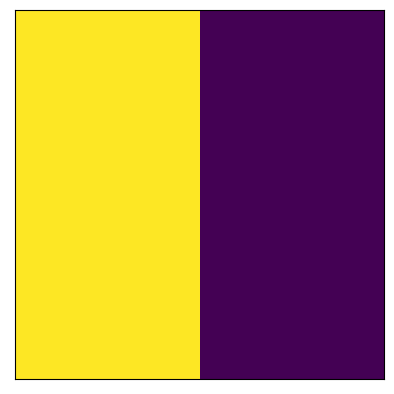

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


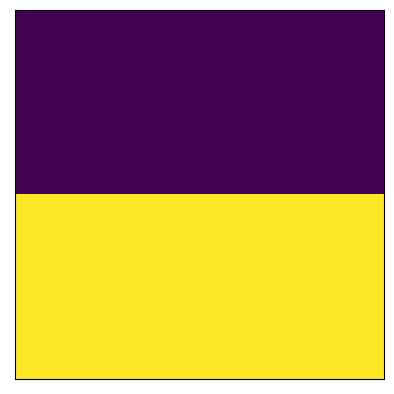

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


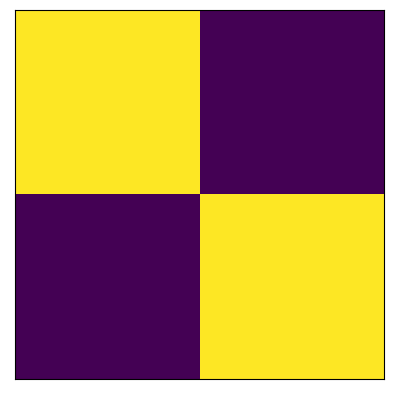

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


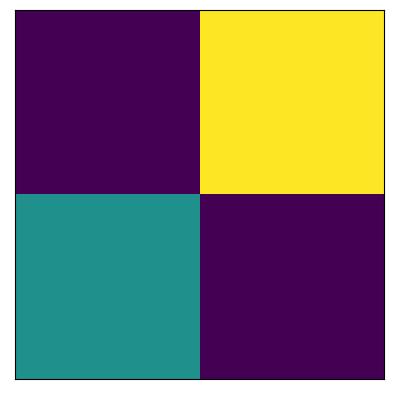

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)


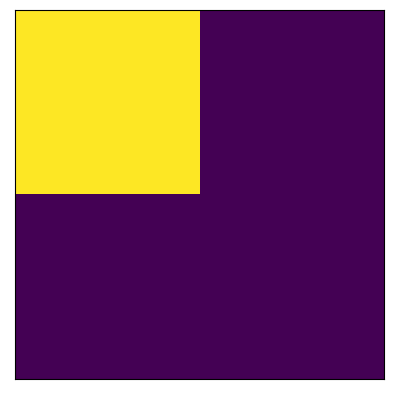

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


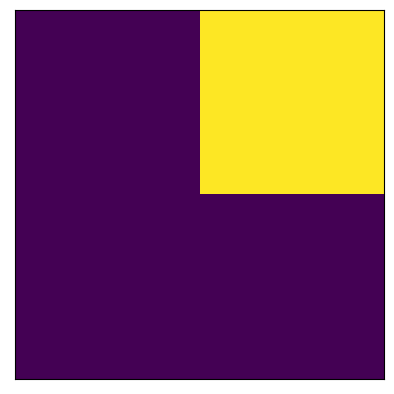

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


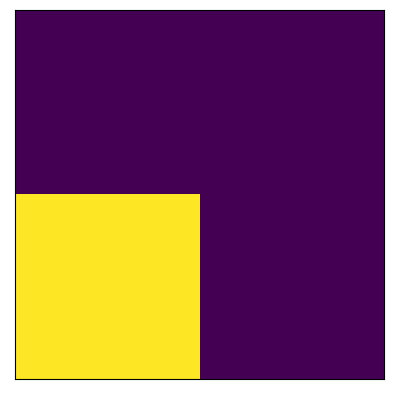

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


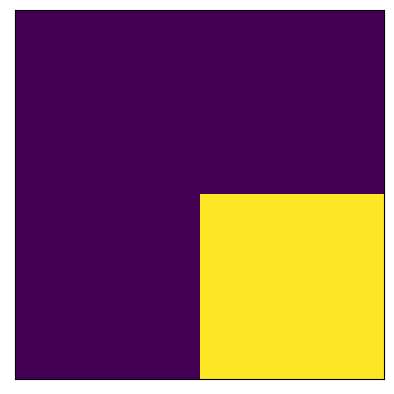

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


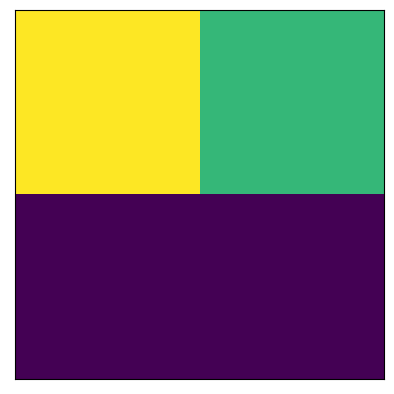

tf.Tensor(
[[0.75 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


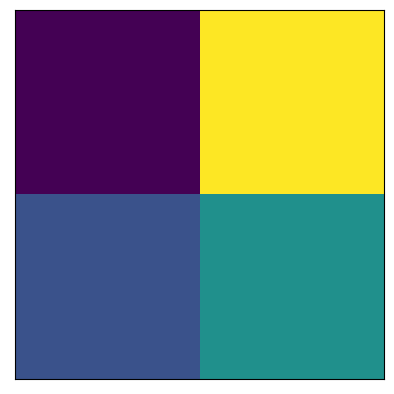

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


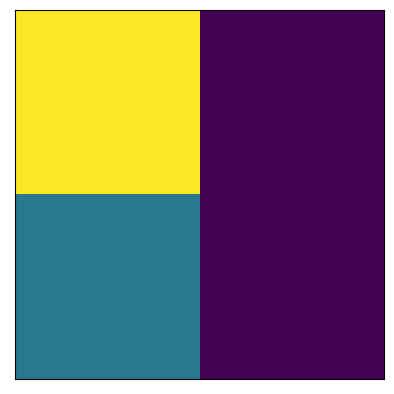

tf.Tensor(
[[1.25 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


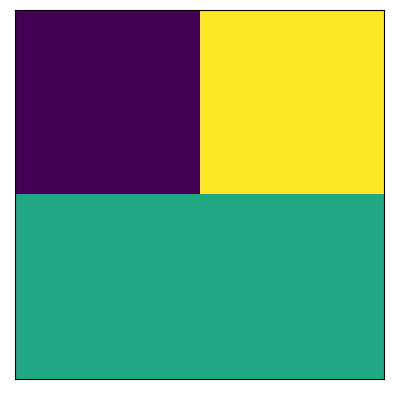

tf.Tensor(
[[0.25 1.5 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


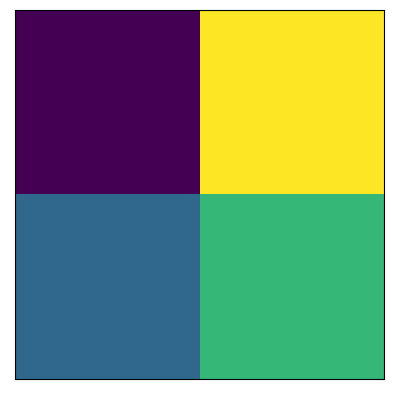

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


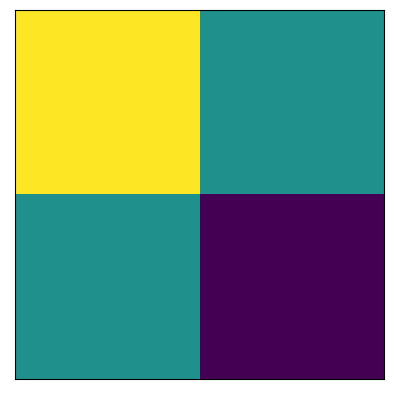

tf.Tensor(
[[1.  0.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


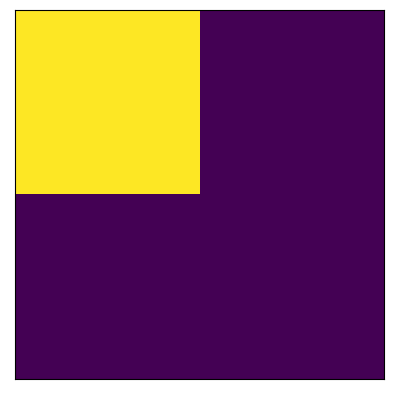

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


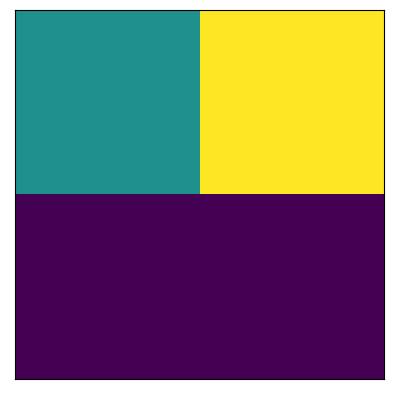

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


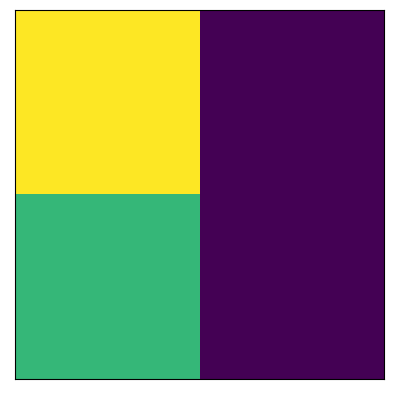

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


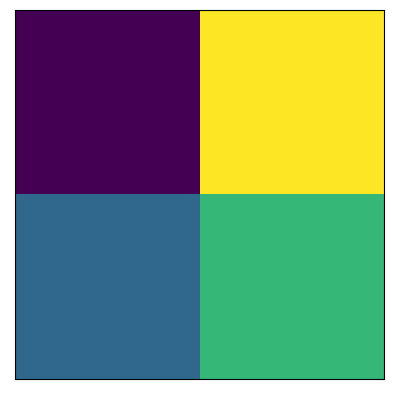

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


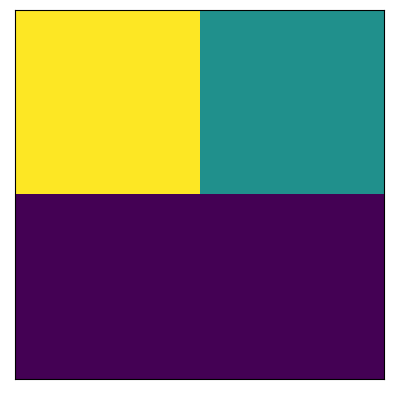

tf.Tensor(
[[2. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


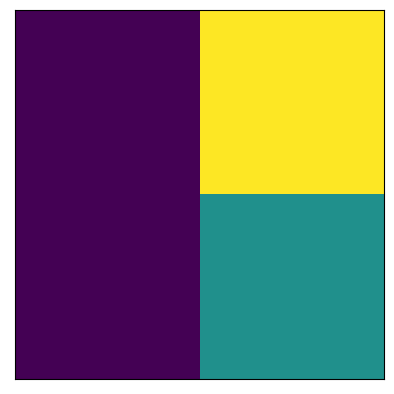

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


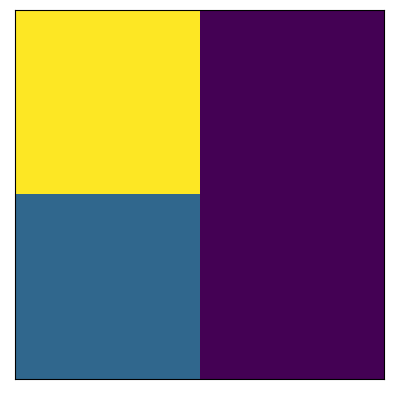

tf.Tensor(
[[3. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


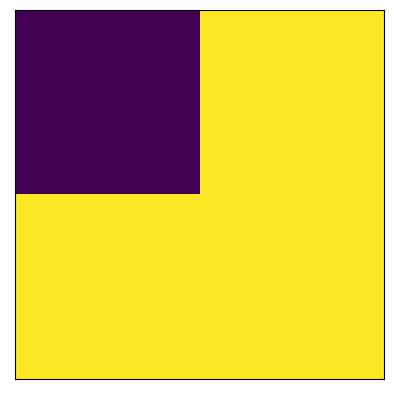

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


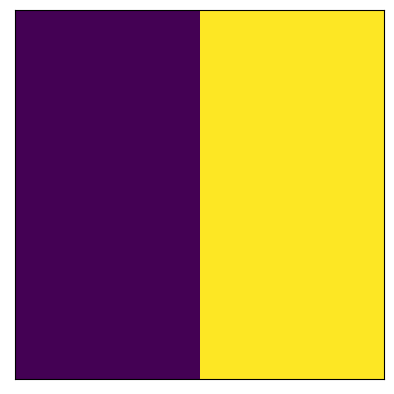

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


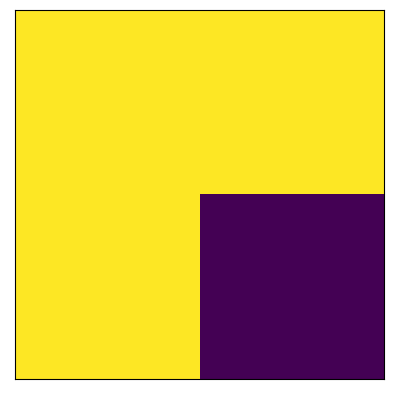

tf.Tensor(
[[1. 1.]
 [1. 0.]], shape=(2, 2), dtype=float32)


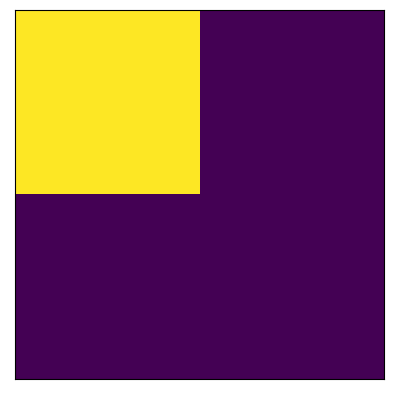

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


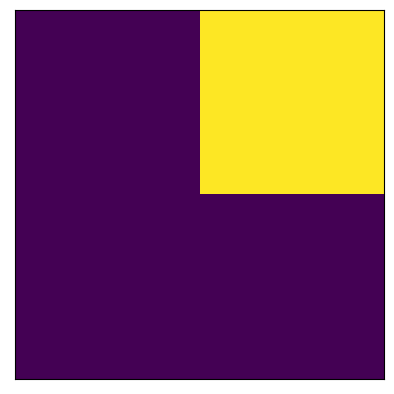

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


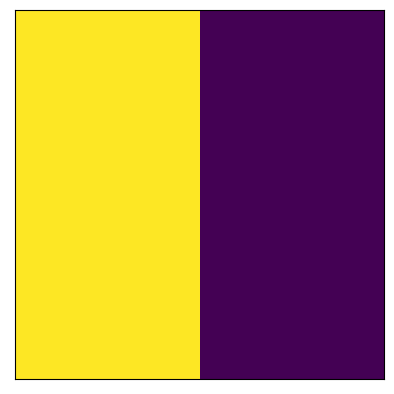

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


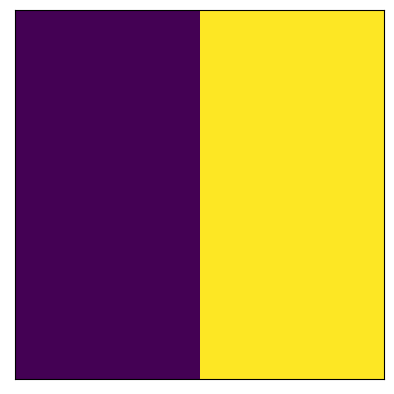

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


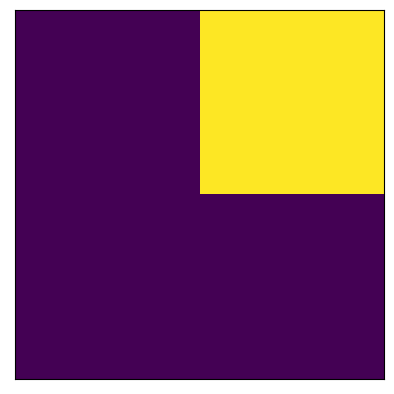

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


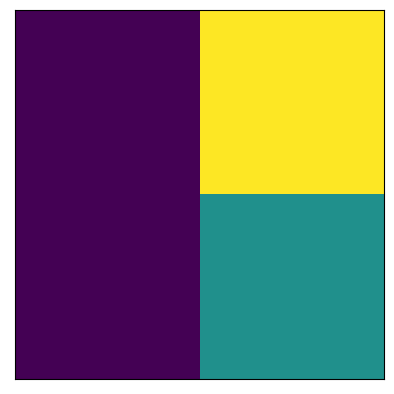

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


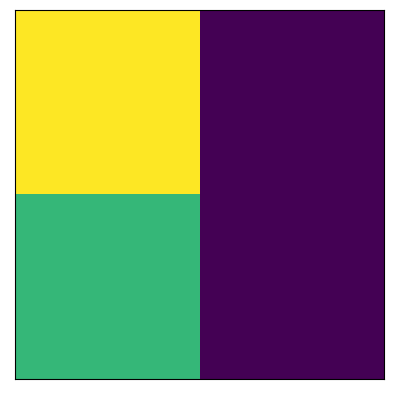

tf.Tensor(
[[3. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


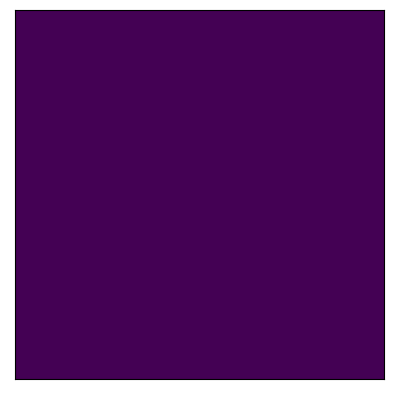

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


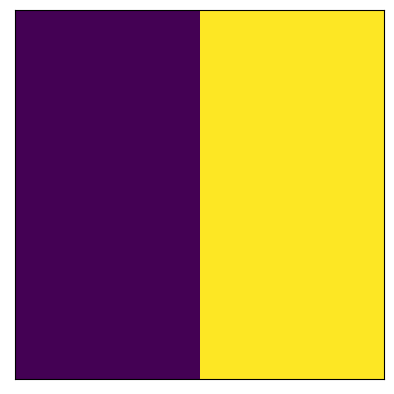

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


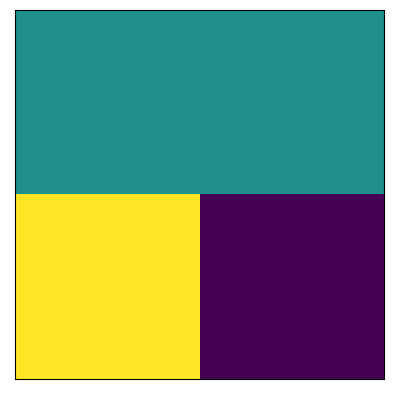

tf.Tensor(
[[1. 1.]
 [2. 0.]], shape=(2, 2), dtype=float32)


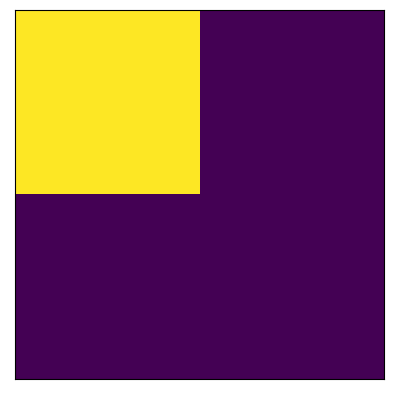

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


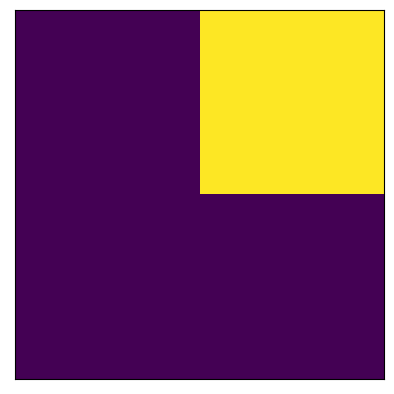

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


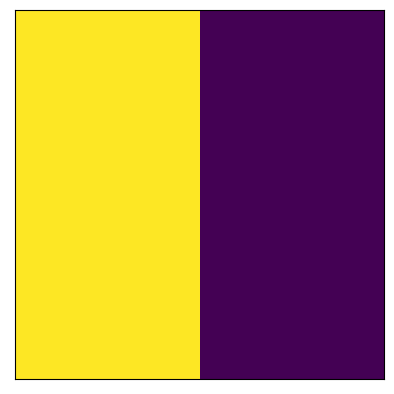

tf.Tensor(
[[2. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


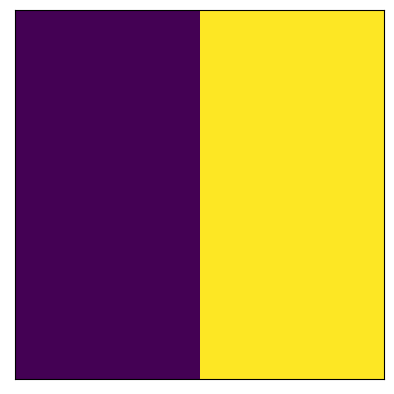

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


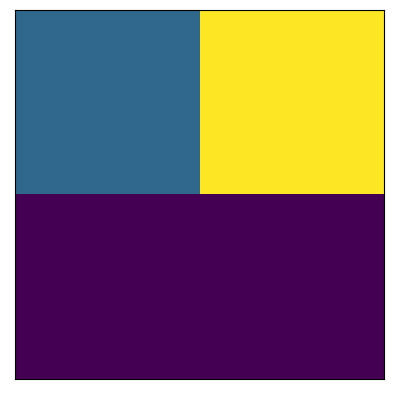

tf.Tensor(
[[1. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


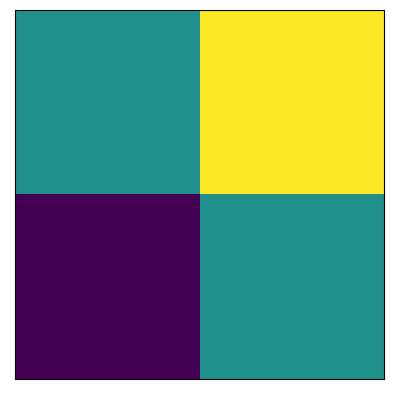

tf.Tensor(
[[1. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


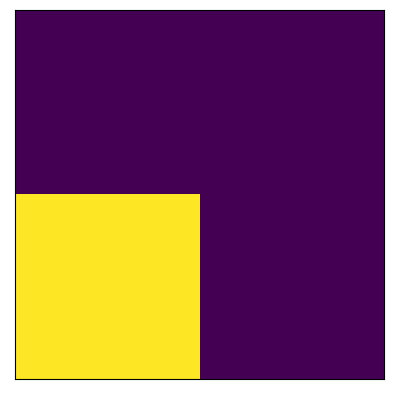

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


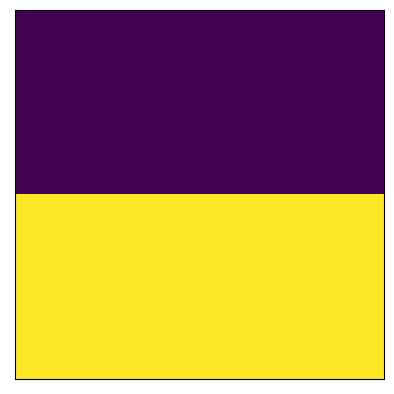

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


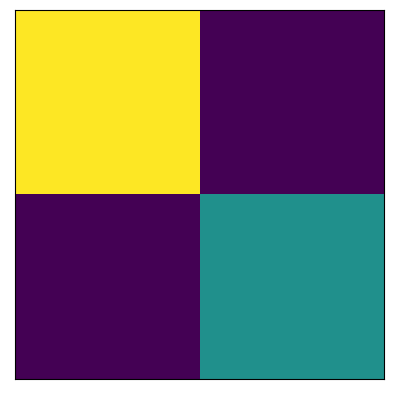

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


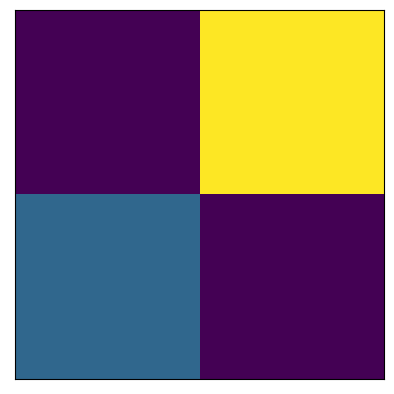

tf.Tensor(
[[0. 3.]
 [1. 0.]], shape=(2, 2), dtype=float32)


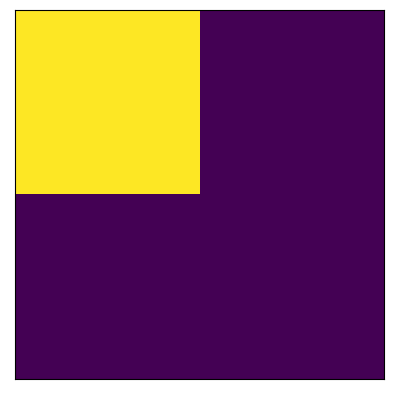

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


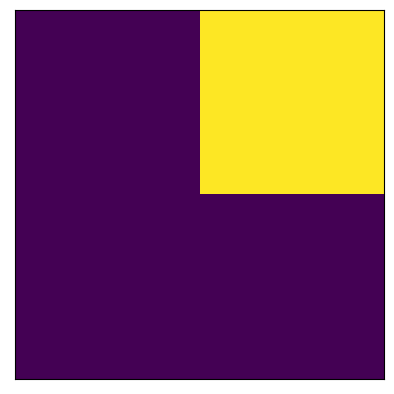

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


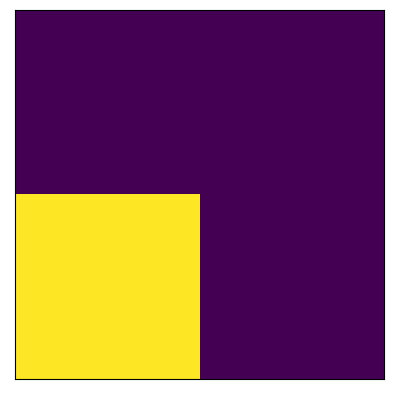

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


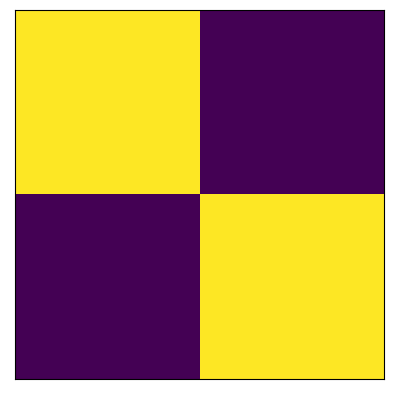

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


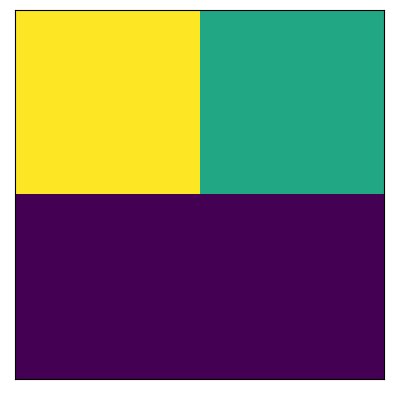

tf.Tensor(
[[0.5555556  0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


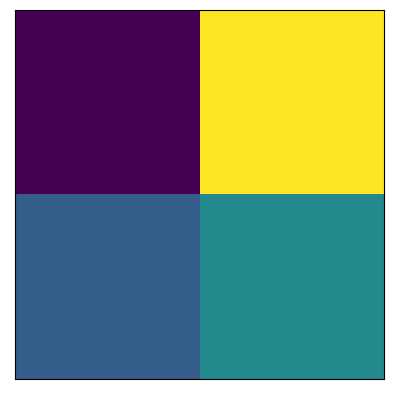

tf.Tensor(
[[0.11111109 2.        ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


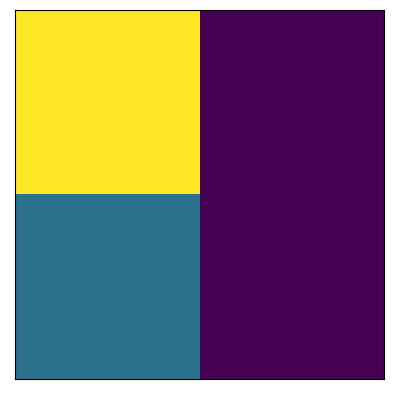

tf.Tensor(
[[0.8888889  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


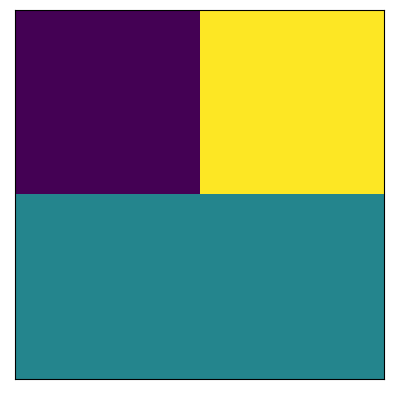

tf.Tensor(
[[0.44444442 1.6666666 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


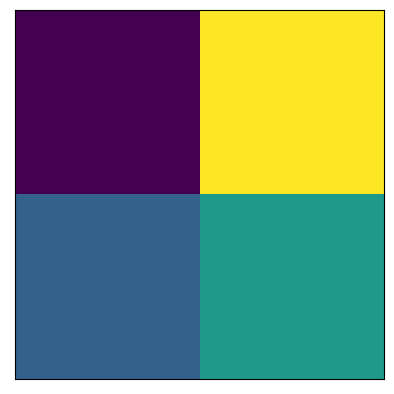

tf.Tensor(
[[0.2222222 1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


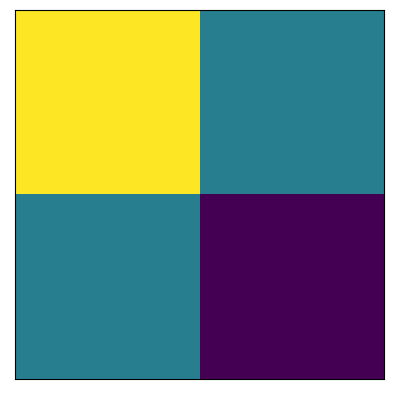

tf.Tensor(
[[0.7777778  0.33333334]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


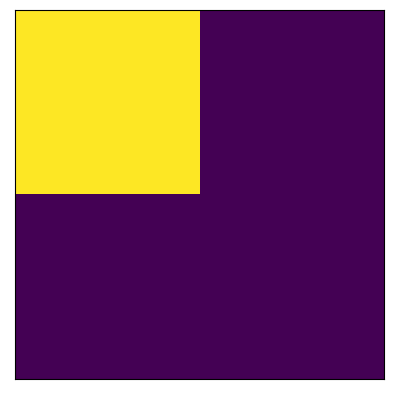

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


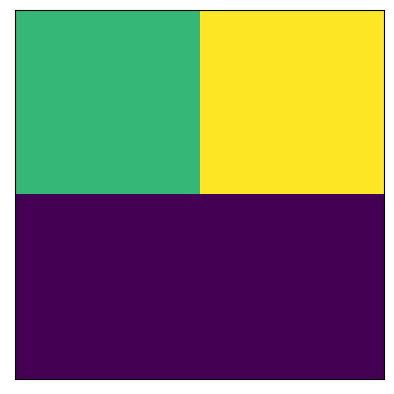

tf.Tensor(
[[0.22222224 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


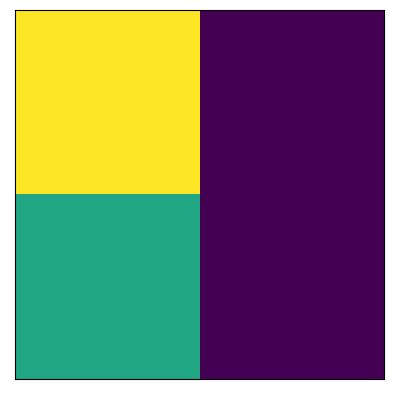

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


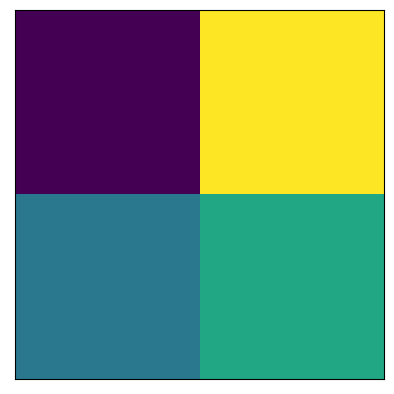

tf.Tensor(
[[0.        1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


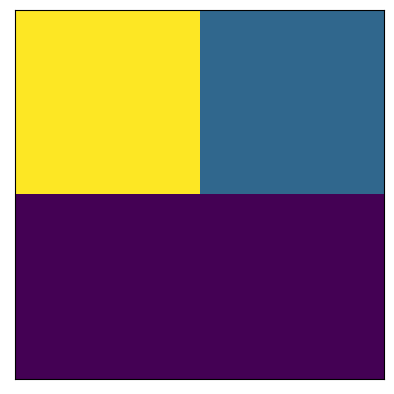

tf.Tensor(
[[3. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


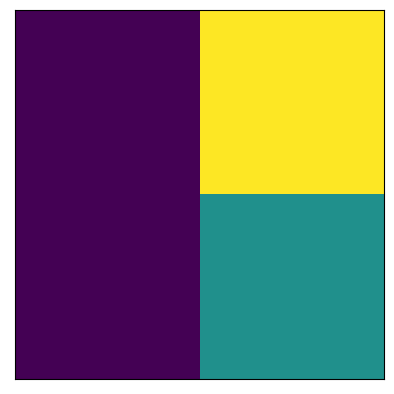

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


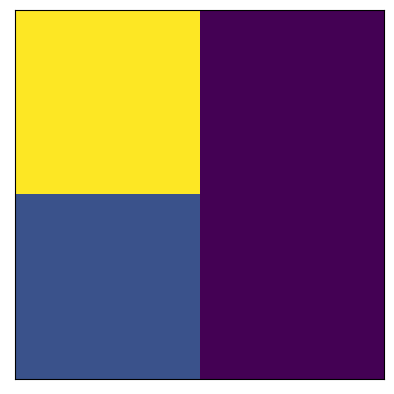

tf.Tensor(
[[4. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


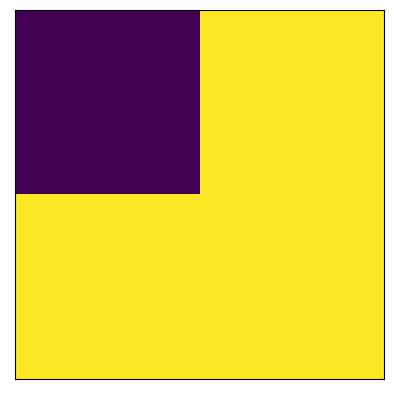

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


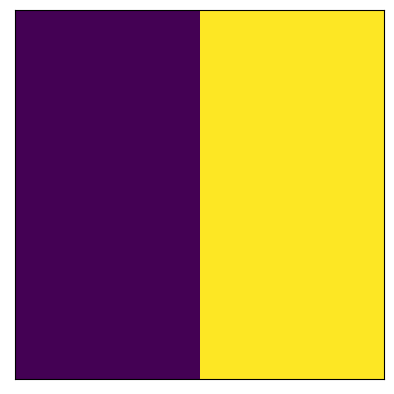

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


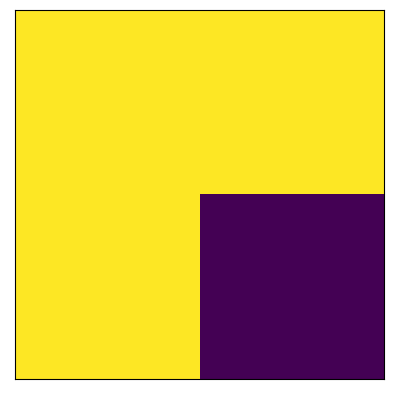

tf.Tensor(
[[1. 1.]
 [1. 0.]], shape=(2, 2), dtype=float32)


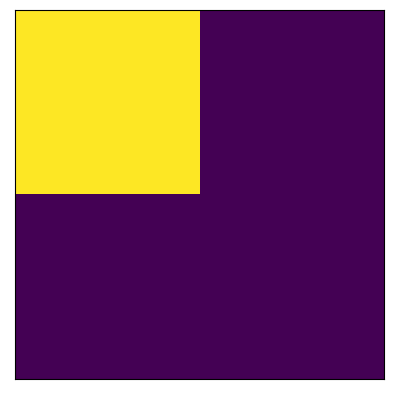

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


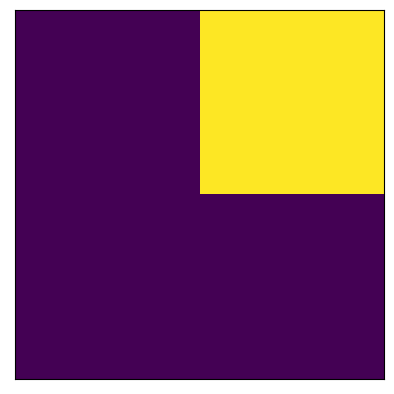

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


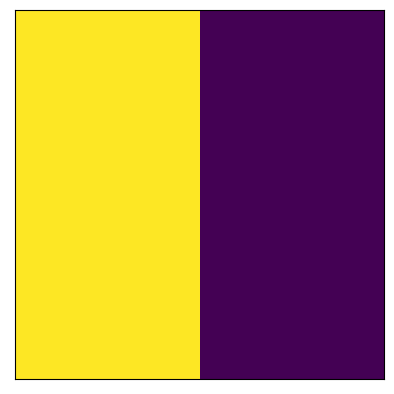

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


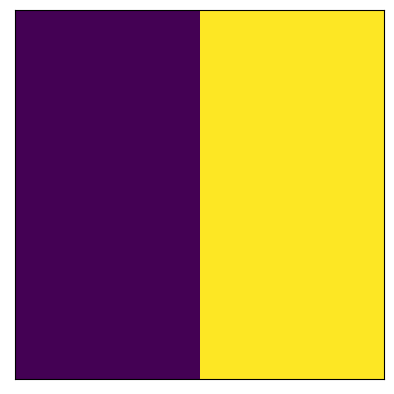

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


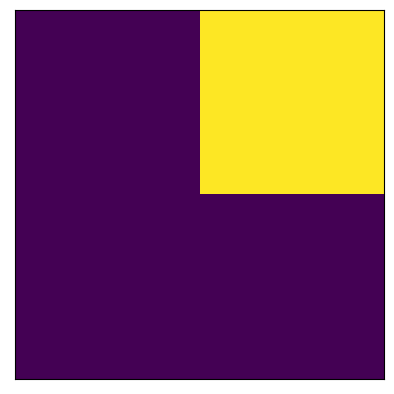

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


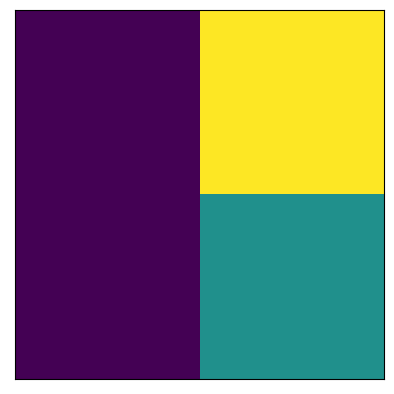

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


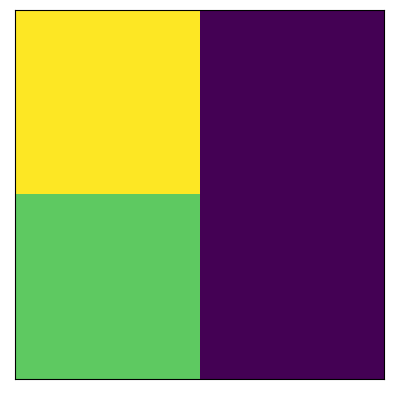

tf.Tensor(
[[4. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


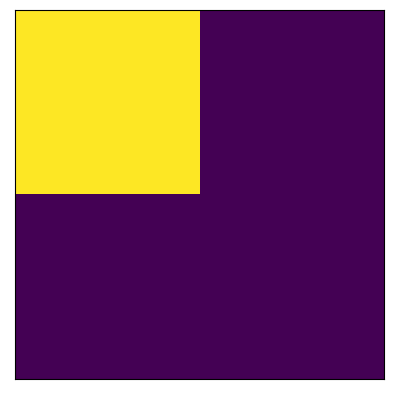

tf.Tensor(
[[2. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


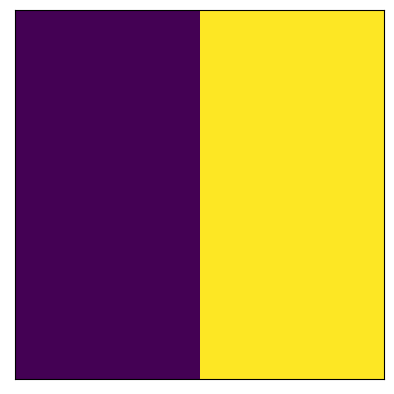

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


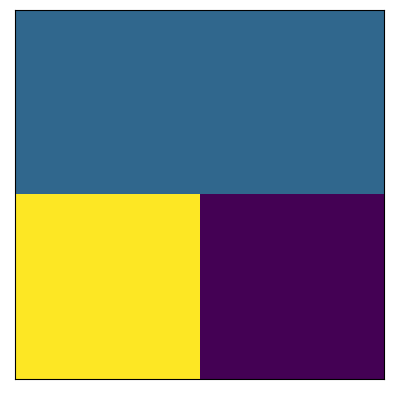

tf.Tensor(
[[1. 1.]
 [3. 0.]], shape=(2, 2), dtype=float32)


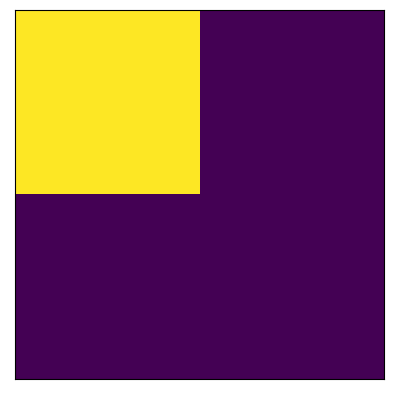

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


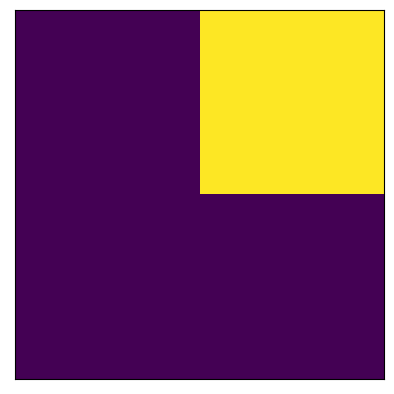

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


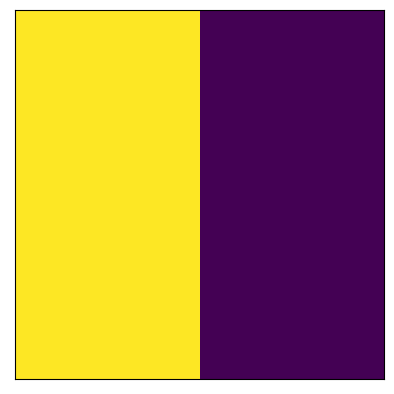

tf.Tensor(
[[3. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


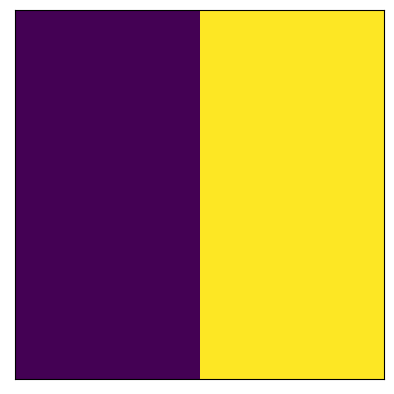

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


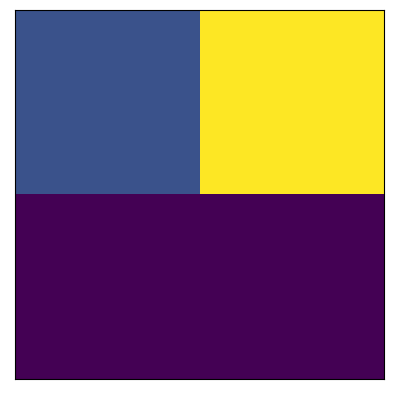

tf.Tensor(
[[1. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


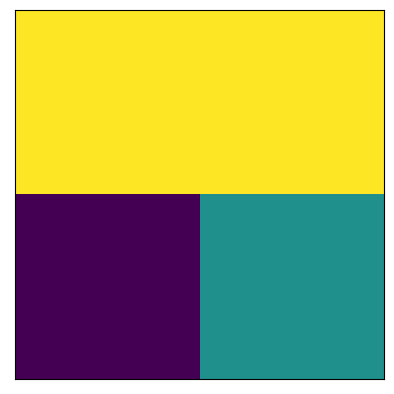

tf.Tensor(
[[2. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


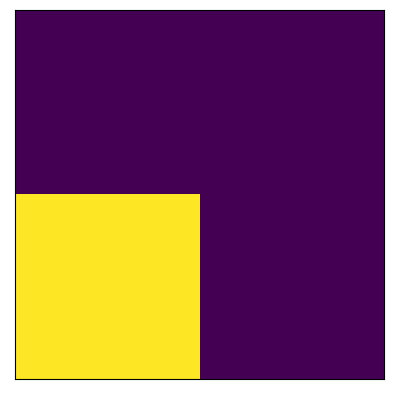

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


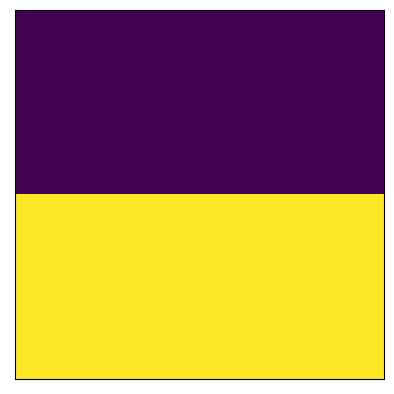

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


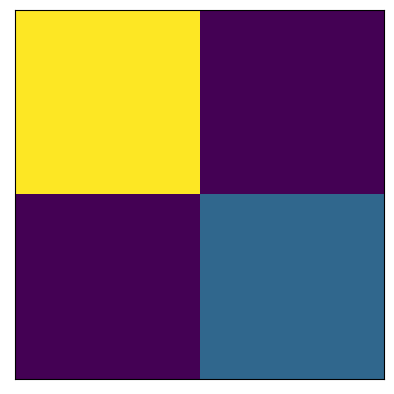

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


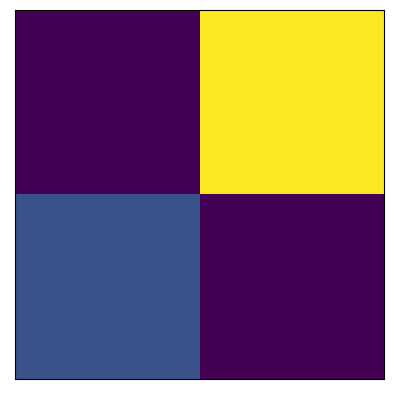

tf.Tensor(
[[0. 4.]
 [1. 0.]], shape=(2, 2), dtype=float32)


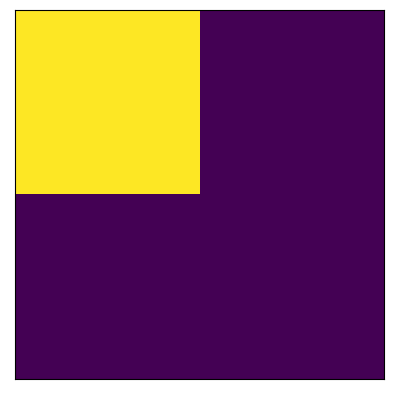

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


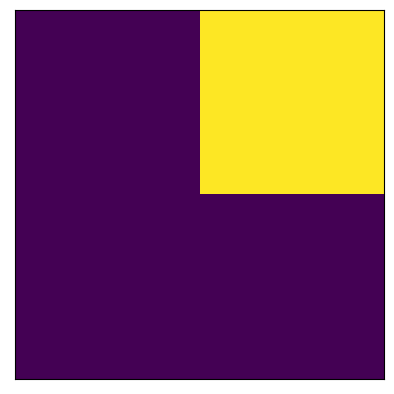

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


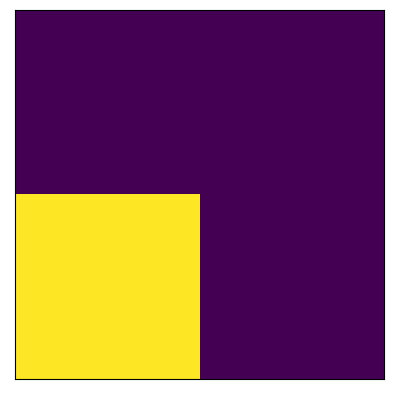

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


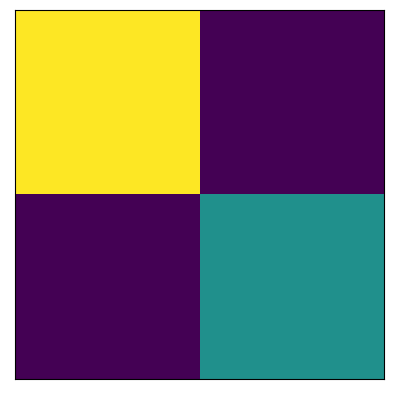

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


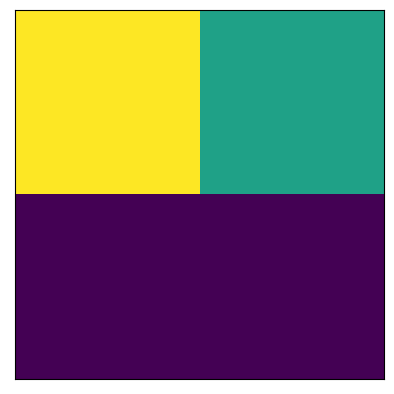

tf.Tensor(
[[0.4375 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


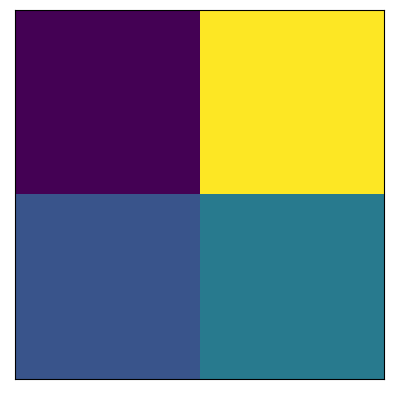

tf.Tensor(
[[0.3125 2.    ]
 [0.75   1.    ]], shape=(2, 2), dtype=float32)


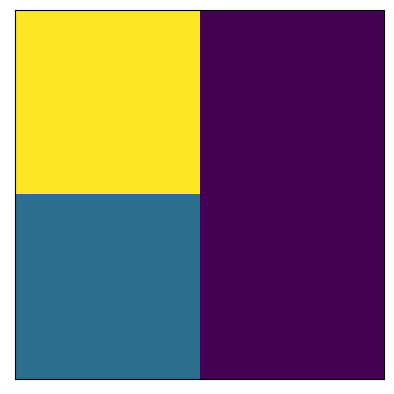

tf.Tensor(
[[0.6875 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


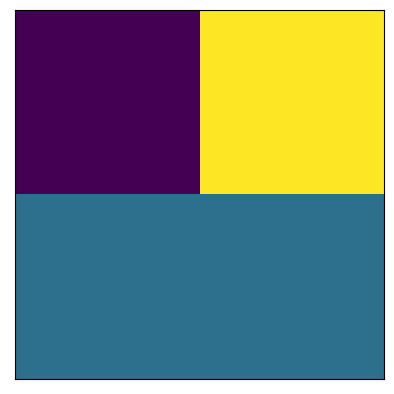

tf.Tensor(
[[0.5625 1.75  ]
 [1.     1.    ]], shape=(2, 2), dtype=float32)


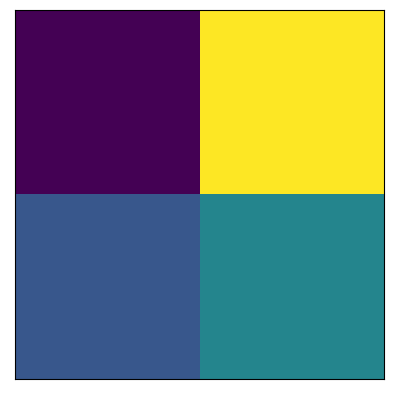

tf.Tensor(
[[0.375 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


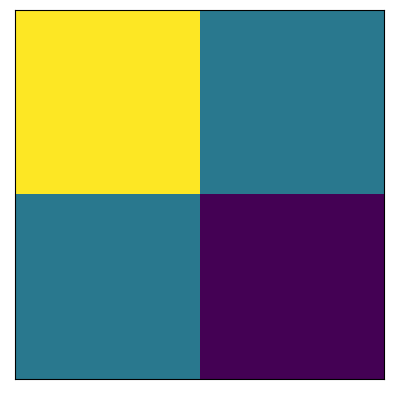

tf.Tensor(
[[0.625 0.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


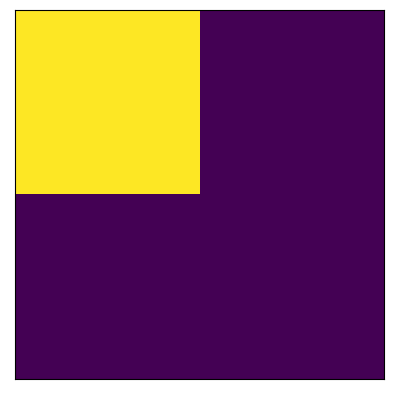

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


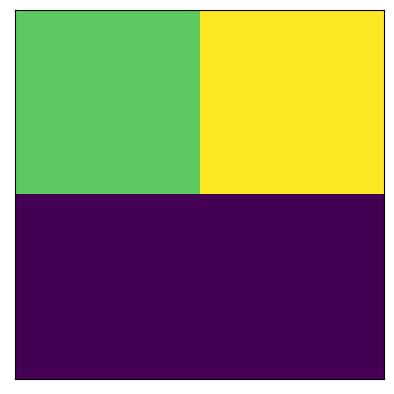

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


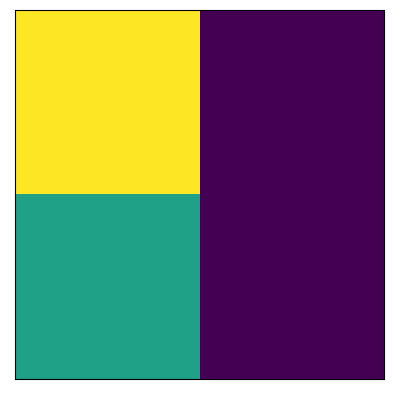

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


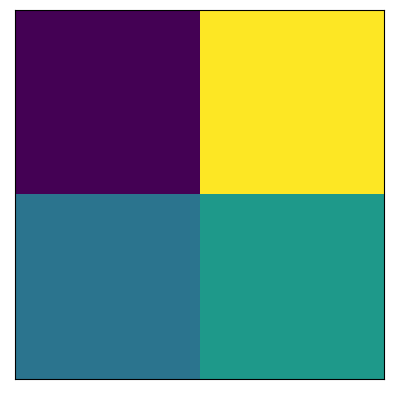

tf.Tensor(
[[0.125 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


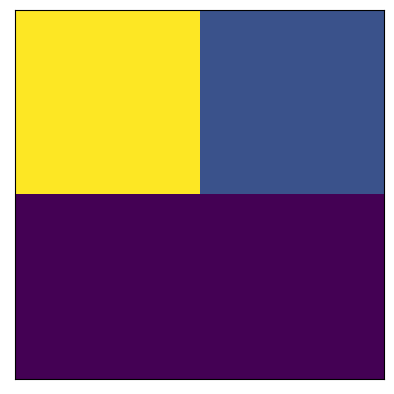

tf.Tensor(
[[4. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


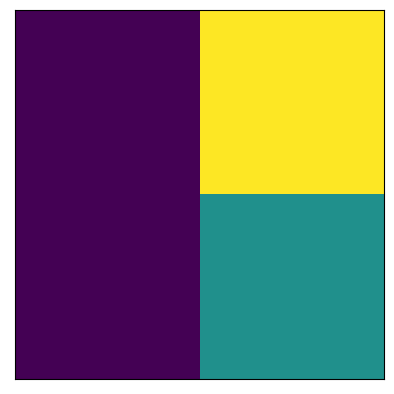

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


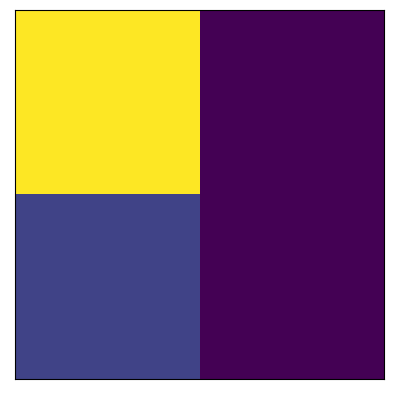

tf.Tensor(
[[5. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


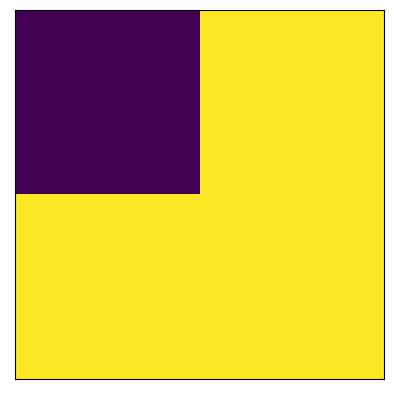

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


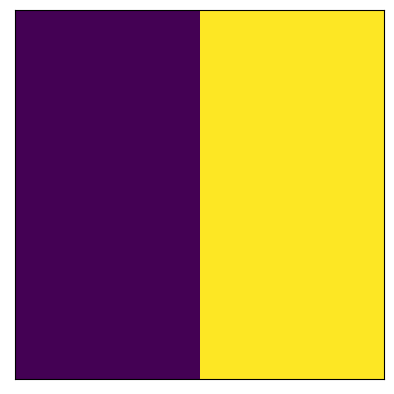

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


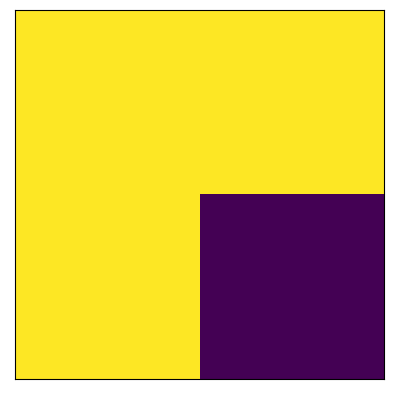

tf.Tensor(
[[1. 1.]
 [1. 0.]], shape=(2, 2), dtype=float32)


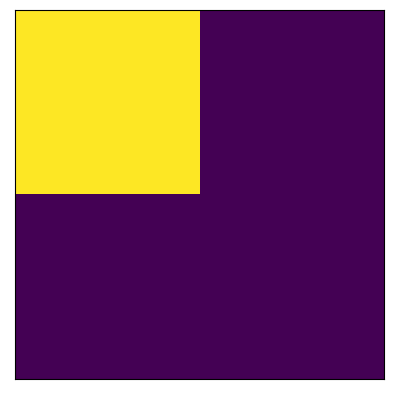

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


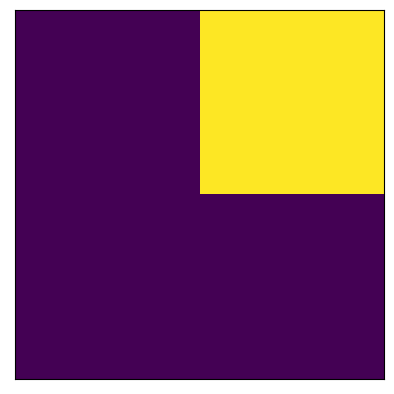

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


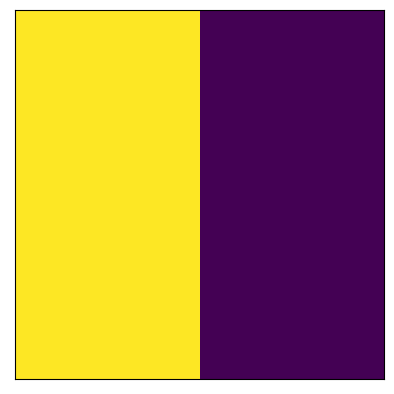

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


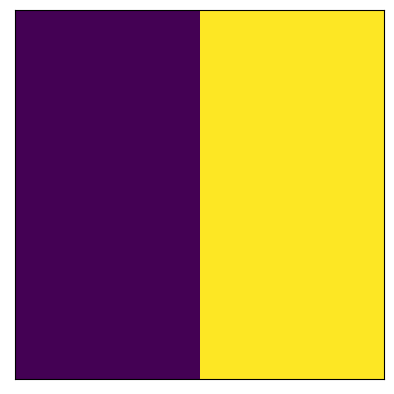

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


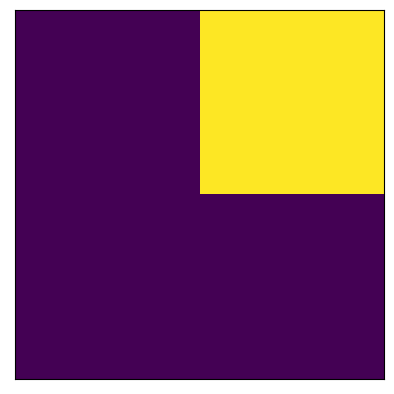

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


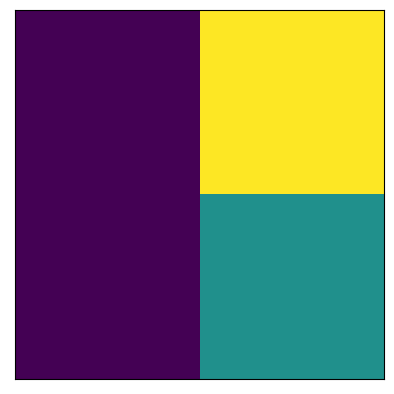

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


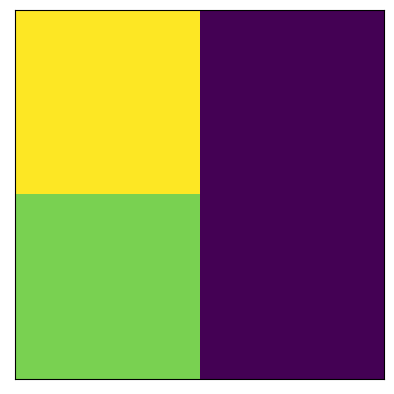

tf.Tensor(
[[5. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


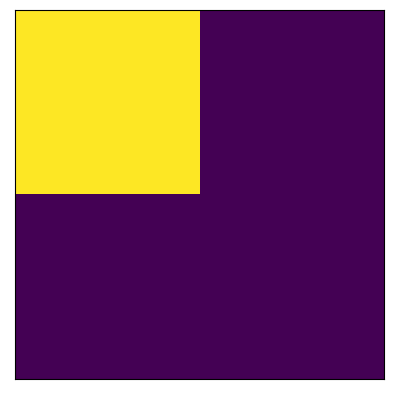

tf.Tensor(
[[3. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


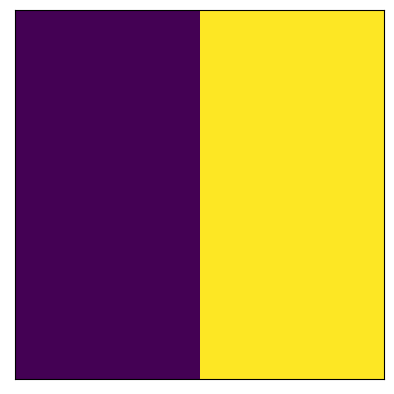

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


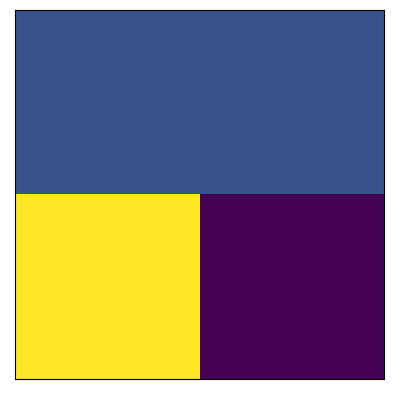

tf.Tensor(
[[1. 1.]
 [4. 0.]], shape=(2, 2), dtype=float32)


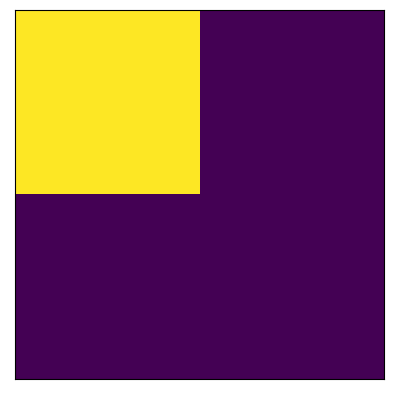

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


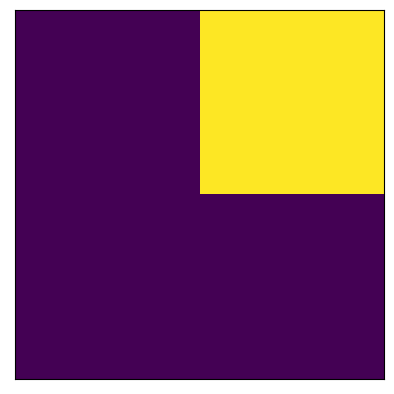

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


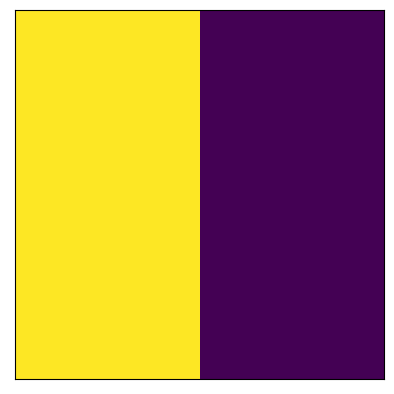

tf.Tensor(
[[4. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


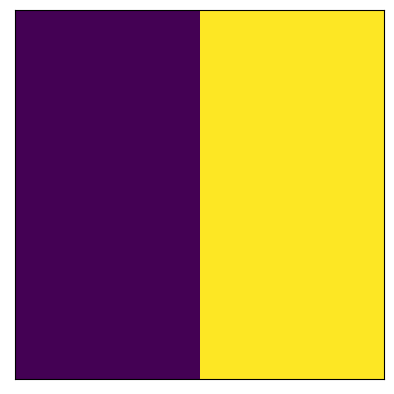

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


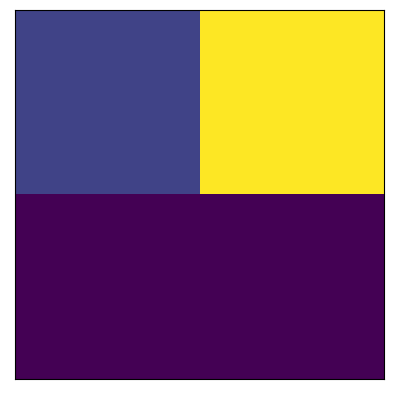

tf.Tensor(
[[1. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


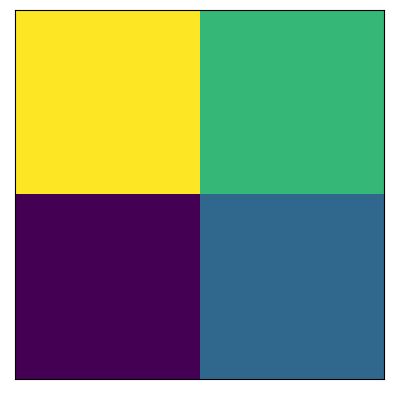

tf.Tensor(
[[3. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


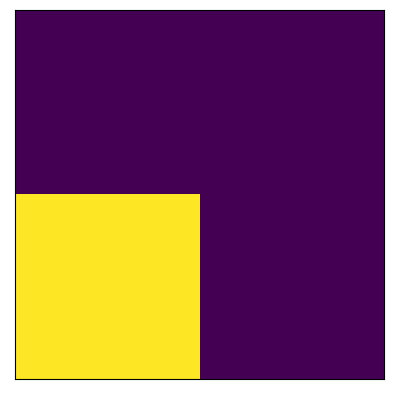

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


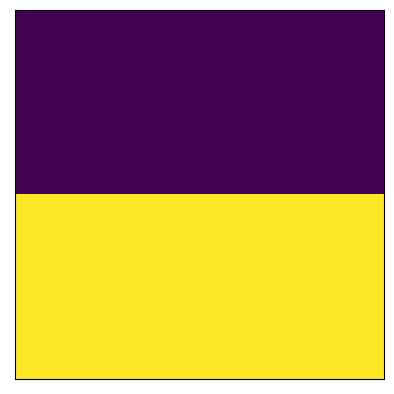

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


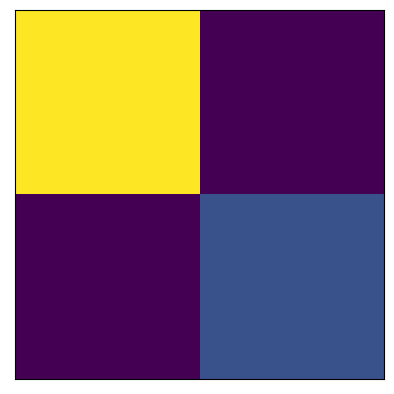

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


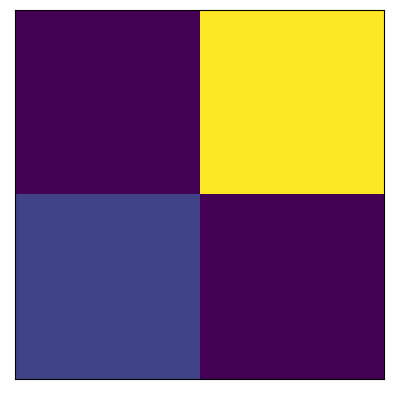

tf.Tensor(
[[0. 5.]
 [1. 0.]], shape=(2, 2), dtype=float32)


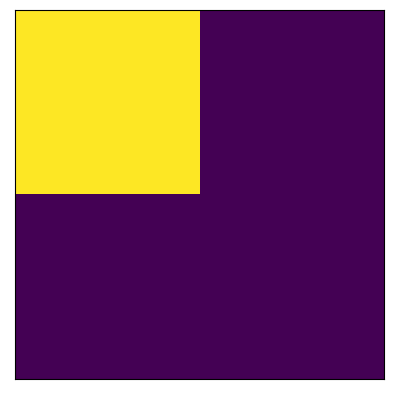

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


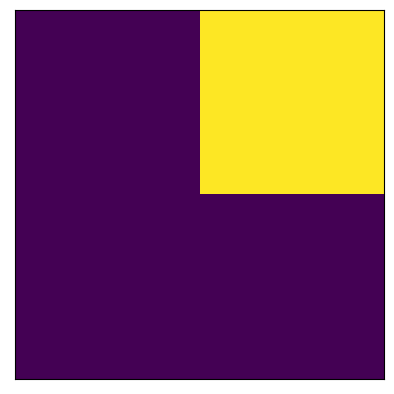

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


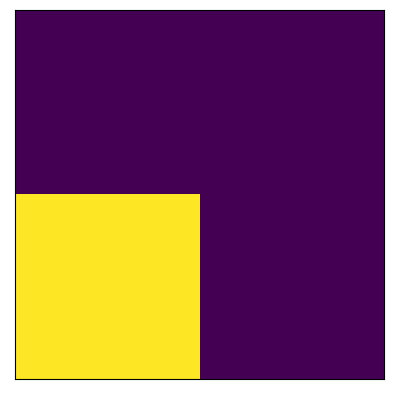

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


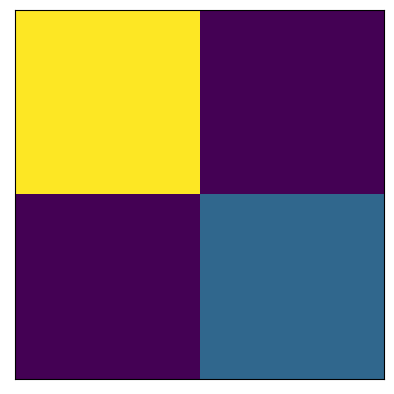

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


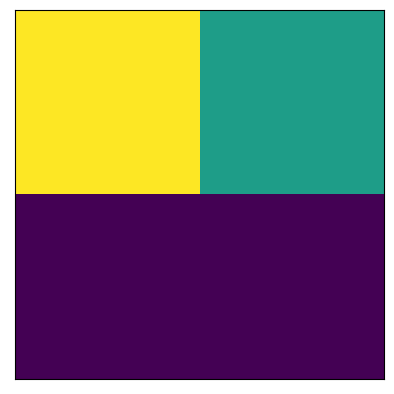

tf.Tensor(
[[0.36 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


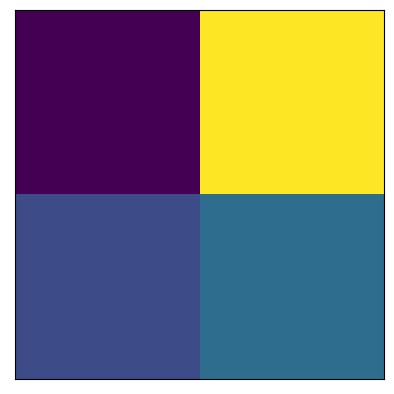

tf.Tensor(
[[0.44000003 2.        ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


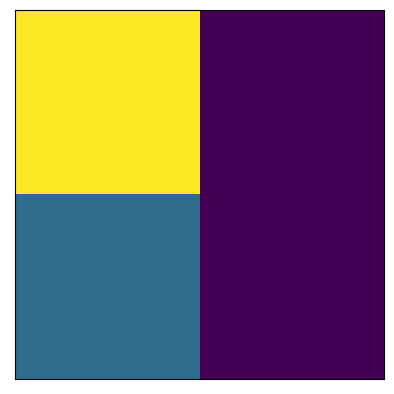

tf.Tensor(
[[0.56 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


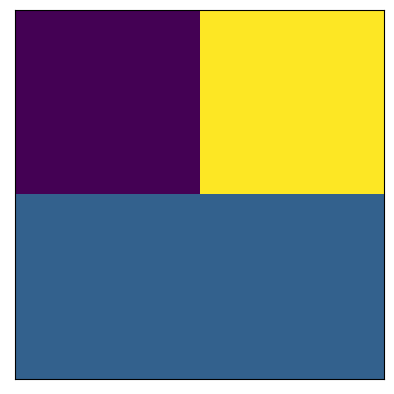

tf.Tensor(
[[0.64 1.8 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


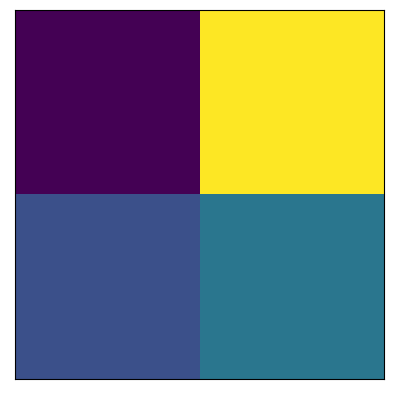

tf.Tensor(
[[0.48000002 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


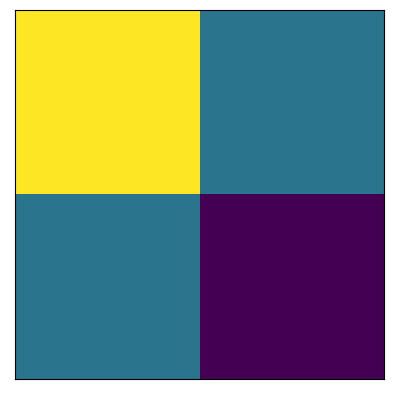

tf.Tensor(
[[0.52000004 0.2       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


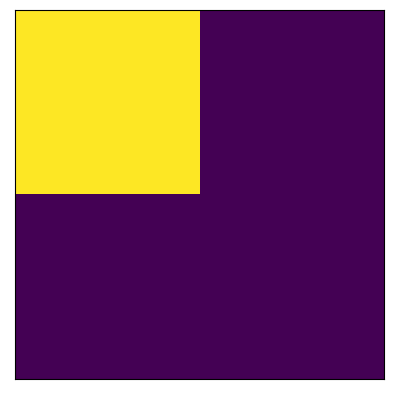

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


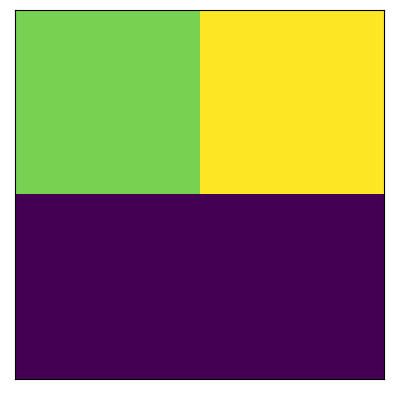

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


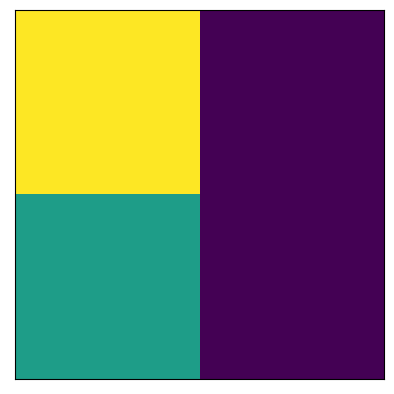

tf.Tensor(
[[0.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


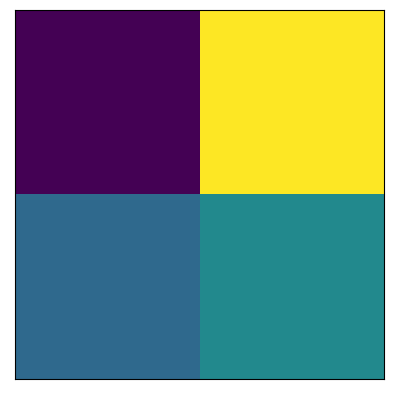

tf.Tensor(
[[0.28000003 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


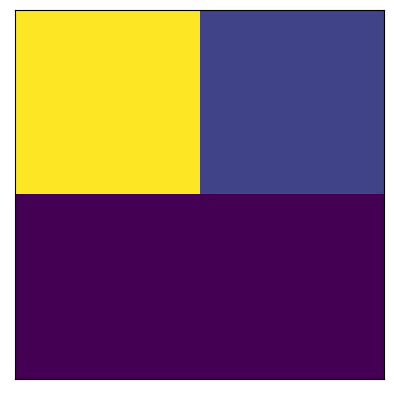

tf.Tensor(
[[5. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


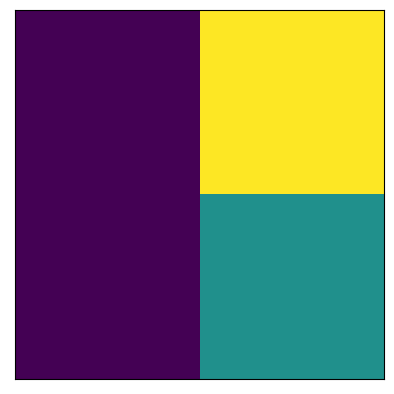

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


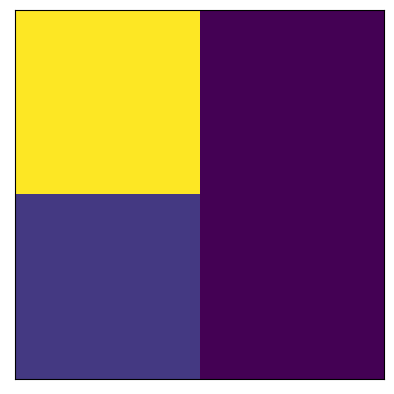

tf.Tensor(
[[6. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


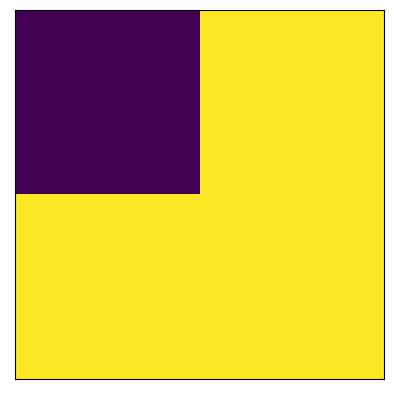

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


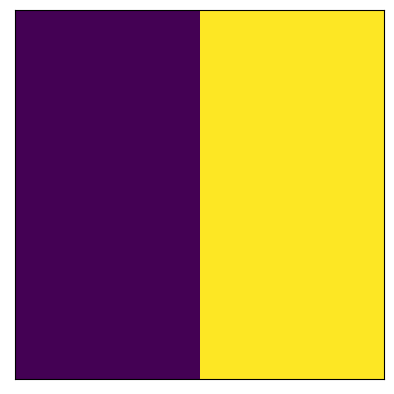

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


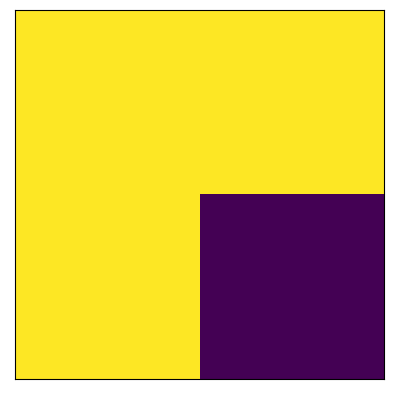

tf.Tensor(
[[1. 1.]
 [1. 0.]], shape=(2, 2), dtype=float32)


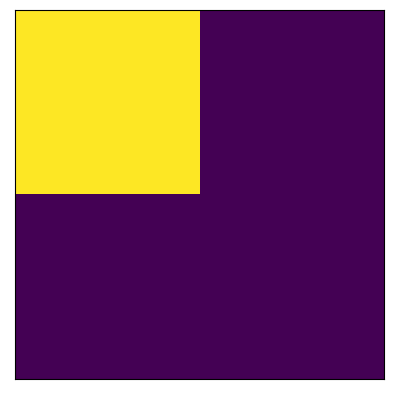

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


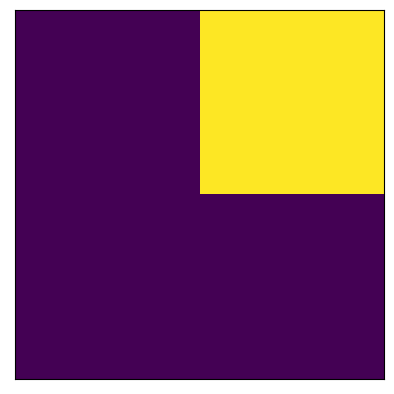

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


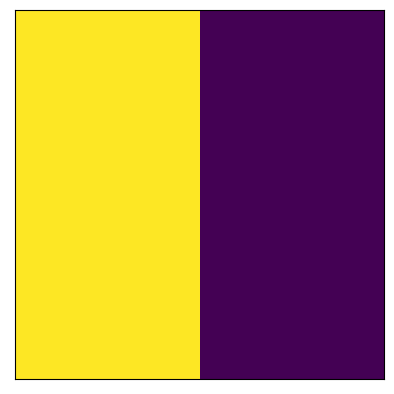

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


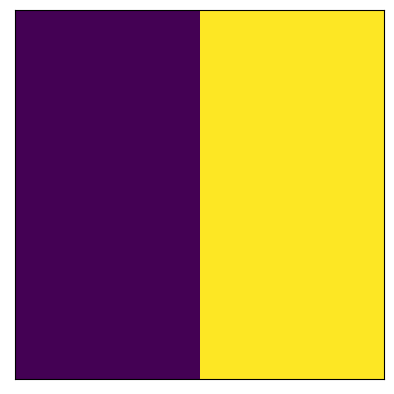

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


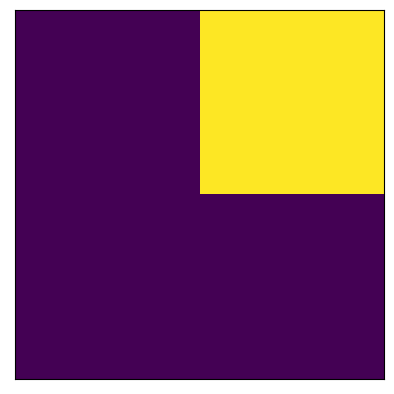

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


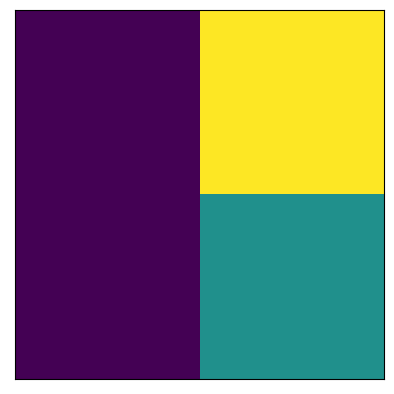

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


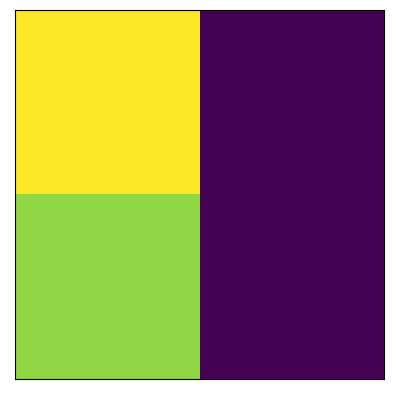

tf.Tensor(
[[6. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


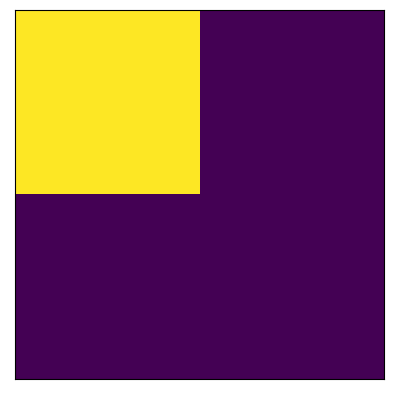

tf.Tensor(
[[4. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


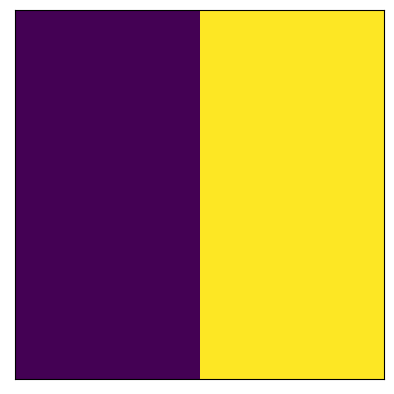

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


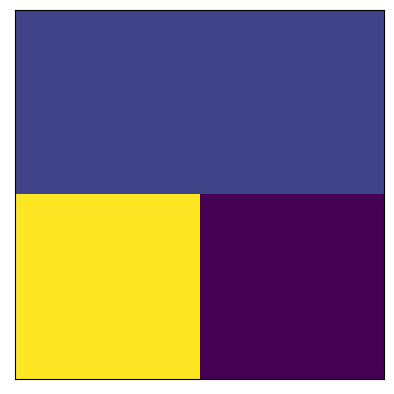

tf.Tensor(
[[1. 1.]
 [5. 0.]], shape=(2, 2), dtype=float32)


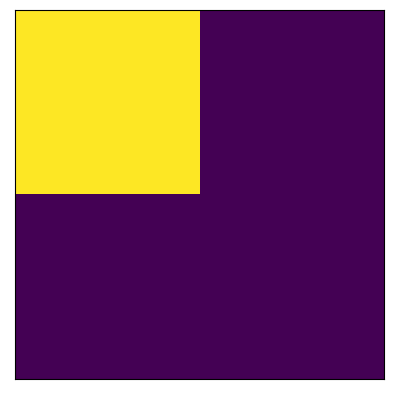

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


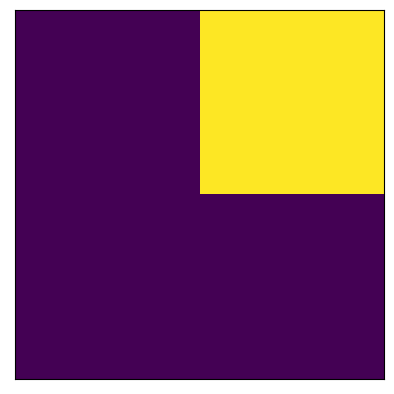

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


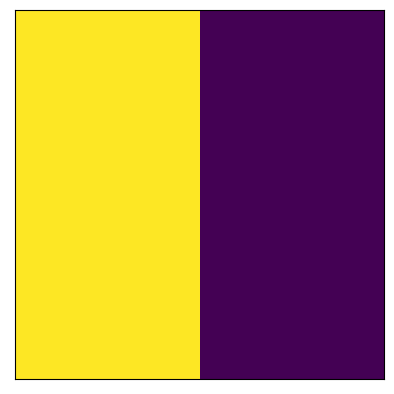

tf.Tensor(
[[5. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


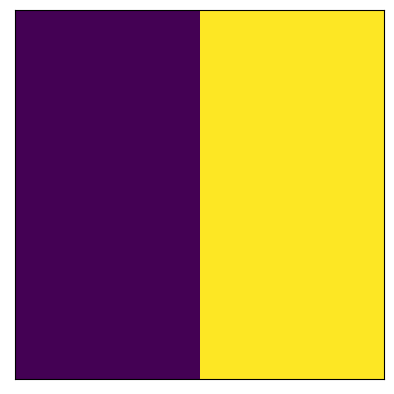

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


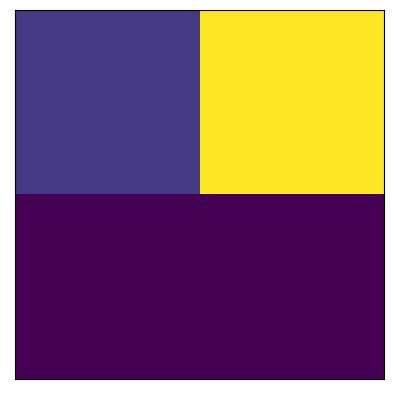

tf.Tensor(
[[1. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


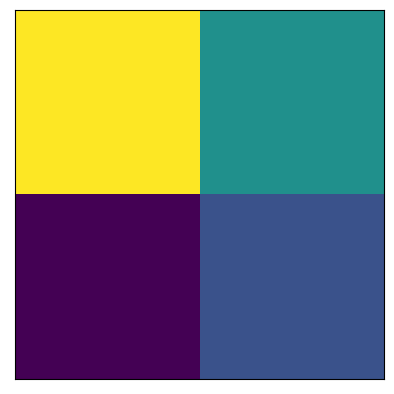

tf.Tensor(
[[4. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


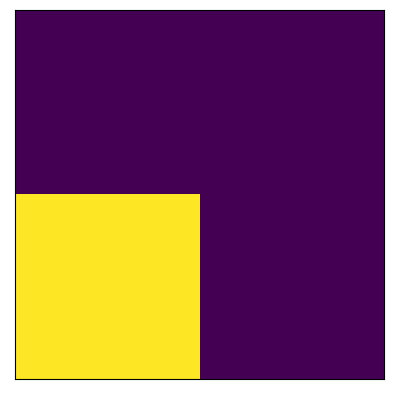

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


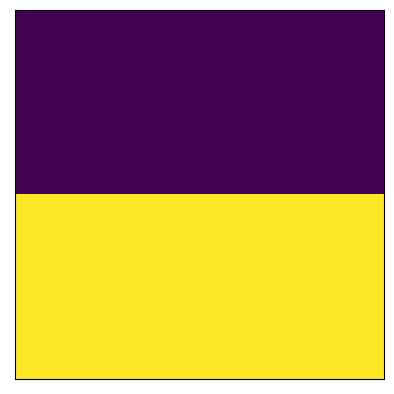

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


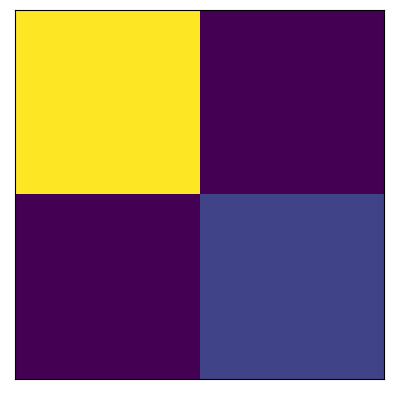

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


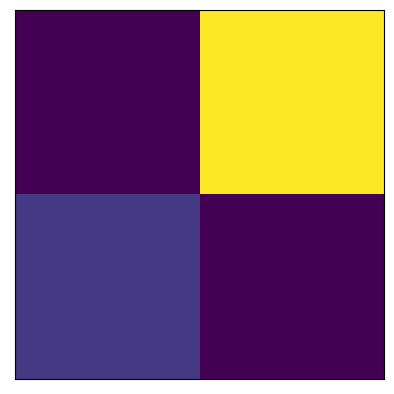

tf.Tensor(
[[0. 6.]
 [1. 0.]], shape=(2, 2), dtype=float32)


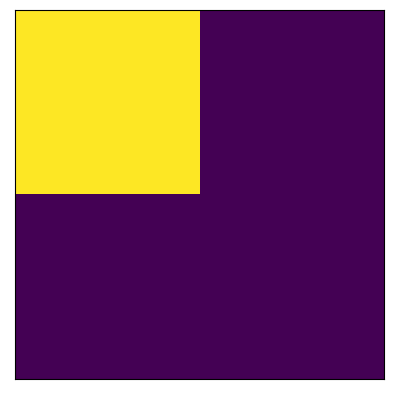

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


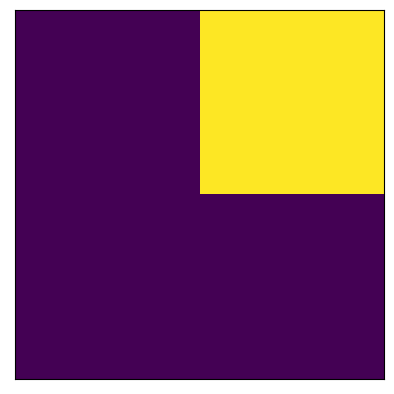

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


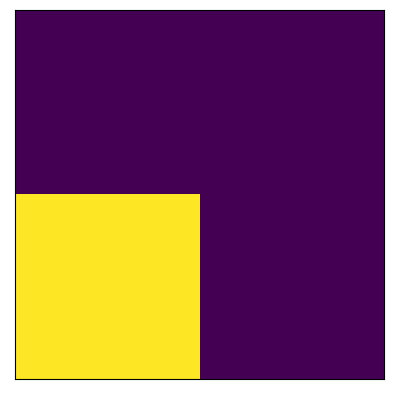

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


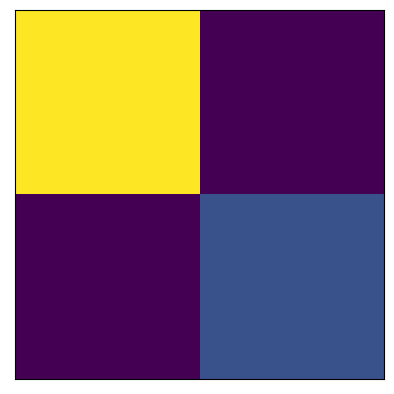

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


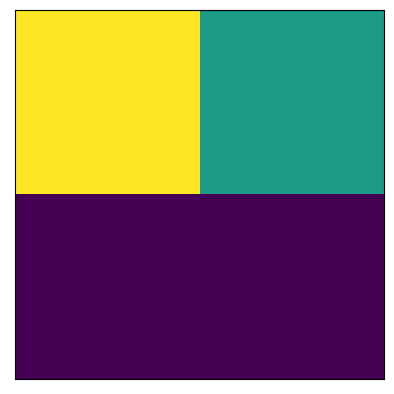

tf.Tensor(
[[0.30555555 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


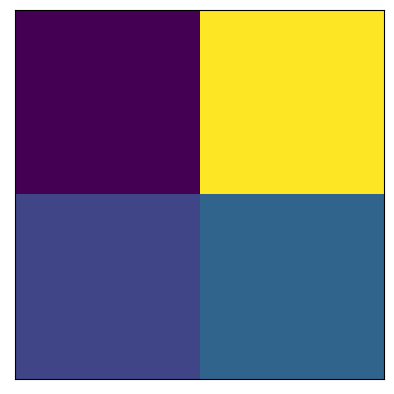

tf.Tensor(
[[0.52777773 2.        ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


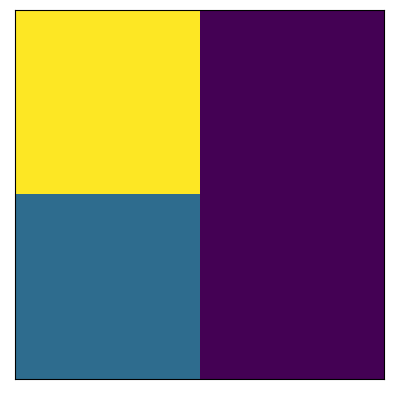

tf.Tensor(
[[0.4722222  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


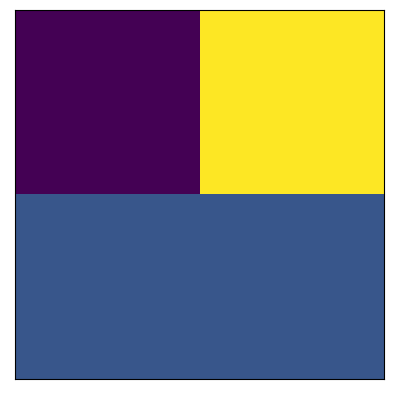

tf.Tensor(
[[0.6944444 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


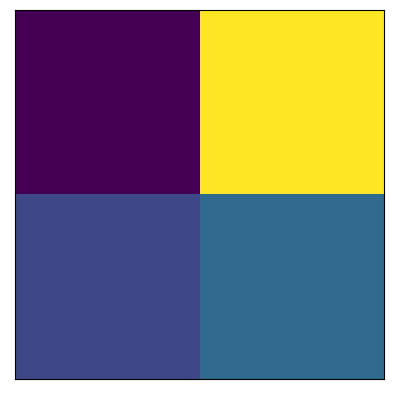

tf.Tensor(
[[0.5555555 1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


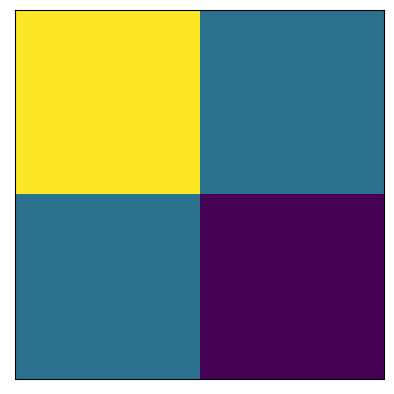

tf.Tensor(
[[0.44444445 0.16666667]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


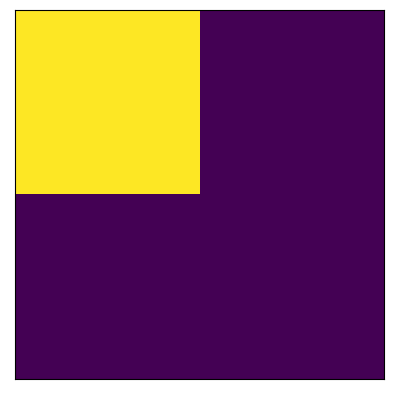

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


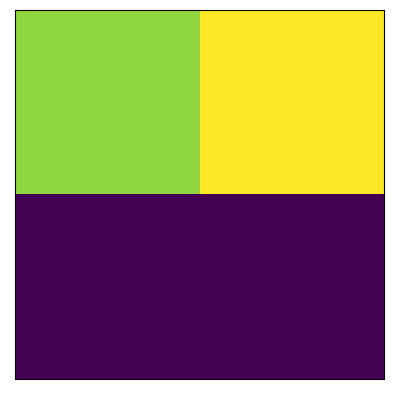

tf.Tensor(
[[0.1388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


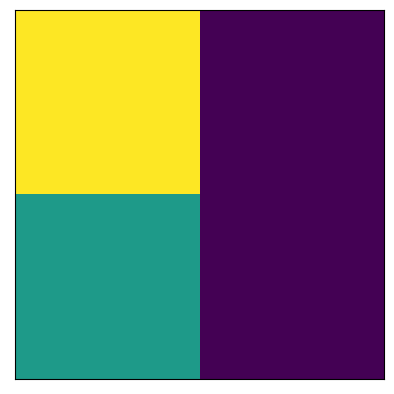

tf.Tensor(
[[0.30555555 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


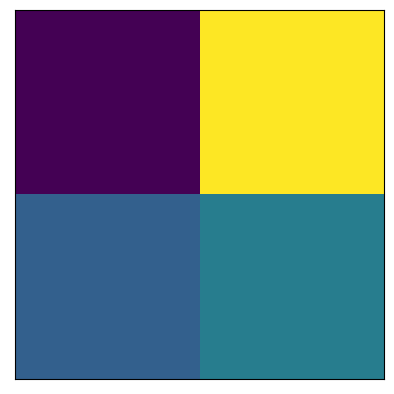

tf.Tensor(
[[0.38888884 1.8333334 ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


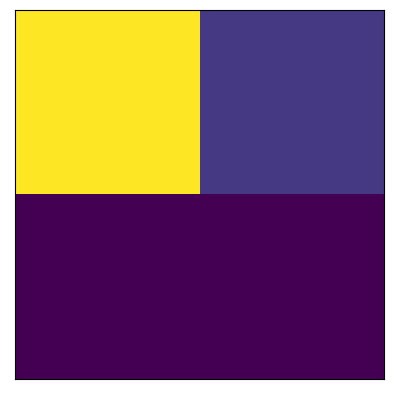

tf.Tensor(
[[6. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


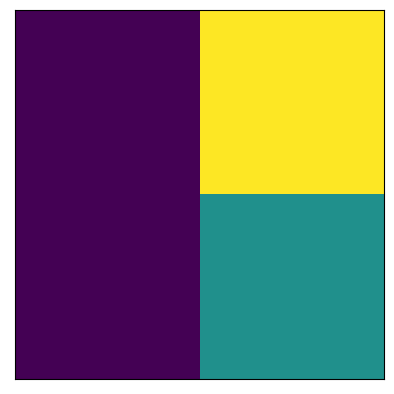

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


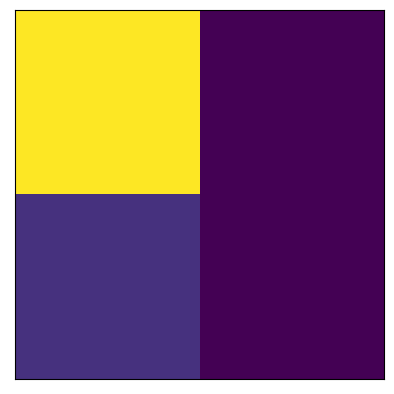

tf.Tensor(
[[7. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


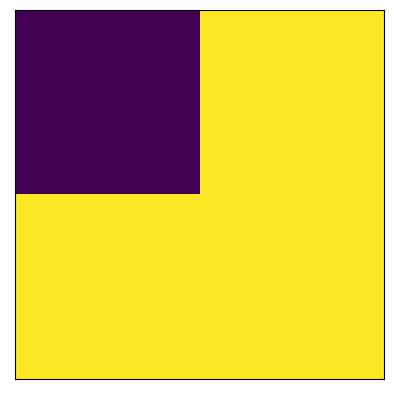

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


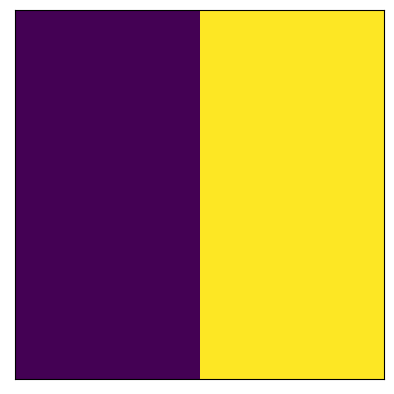

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


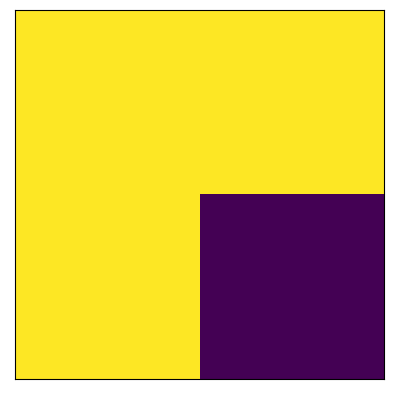

tf.Tensor(
[[1. 1.]
 [1. 0.]], shape=(2, 2), dtype=float32)


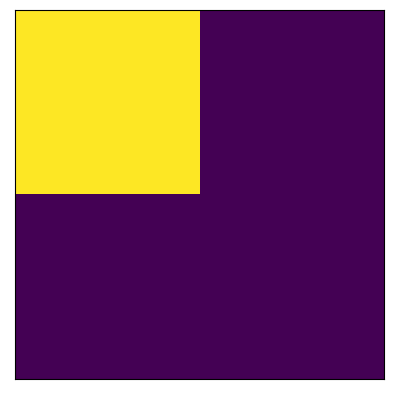

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


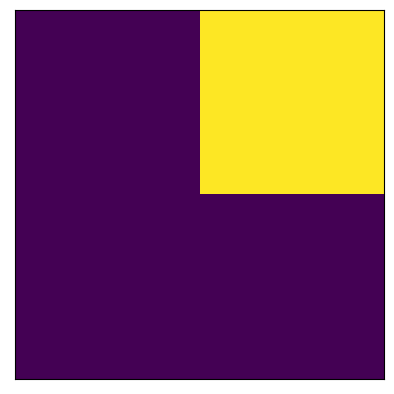

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


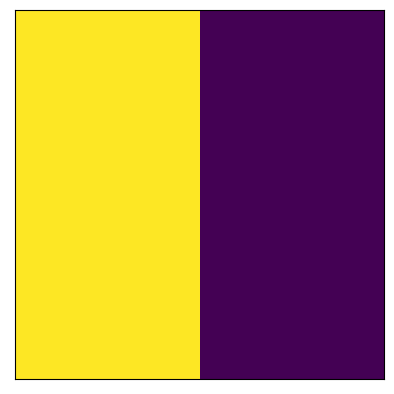

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


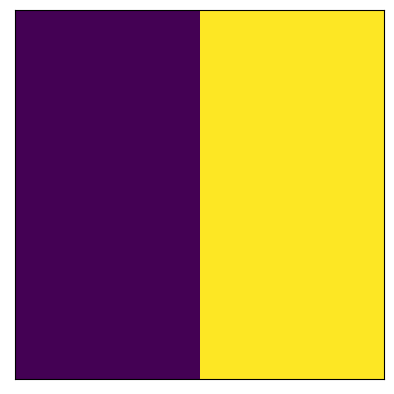

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


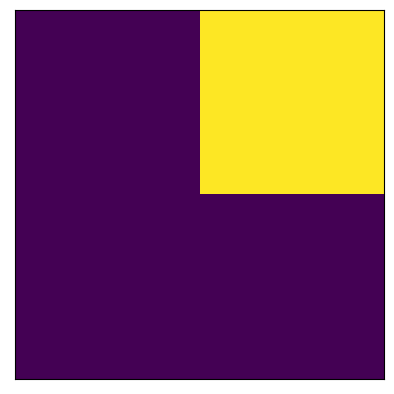

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


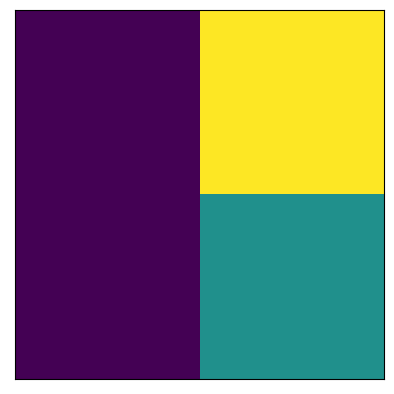

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


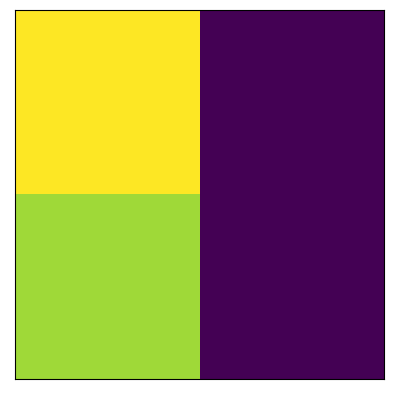

tf.Tensor(
[[7. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


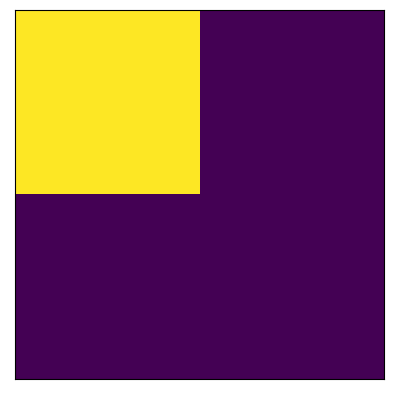

tf.Tensor(
[[5. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


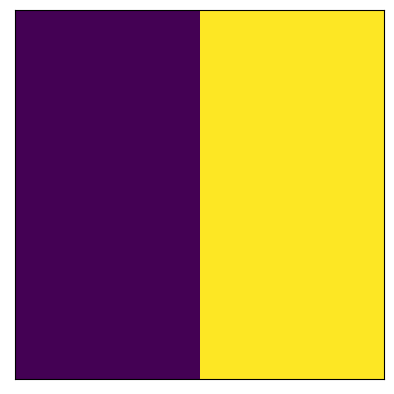

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


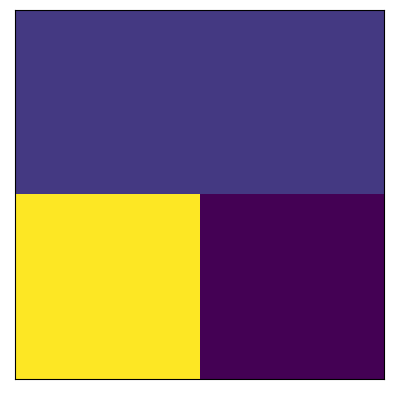

tf.Tensor(
[[1. 1.]
 [6. 0.]], shape=(2, 2), dtype=float32)


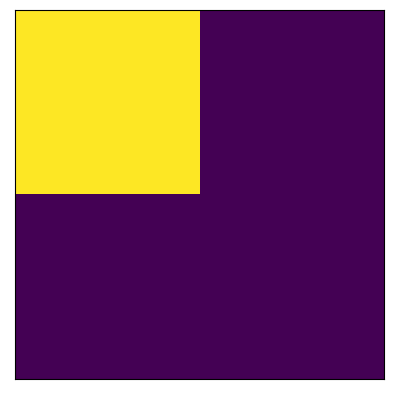

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


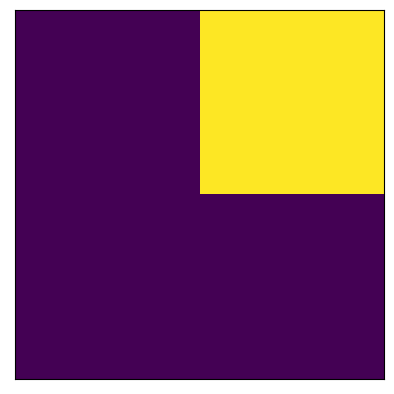

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


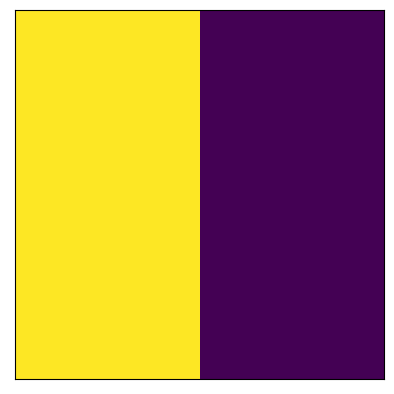

tf.Tensor(
[[6. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


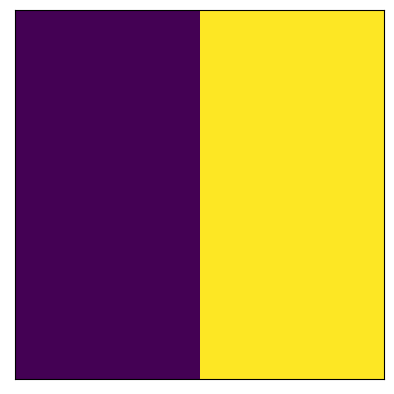

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


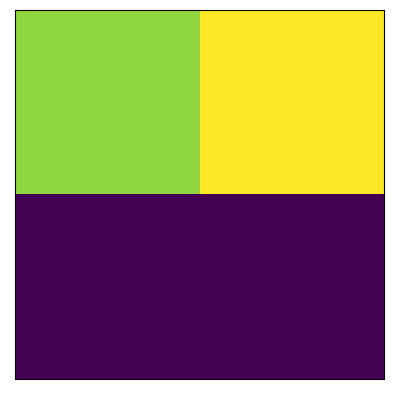

tf.Tensor(
[[1.25 1.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


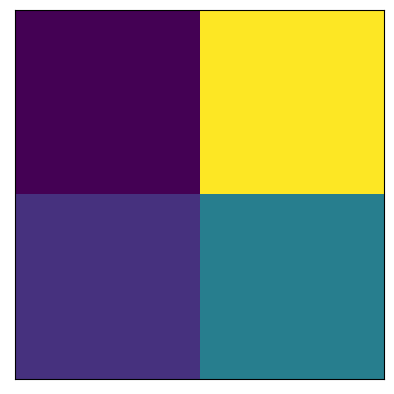

tf.Tensor(
[[0.25 2.  ]
 [0.5  1.  ]], shape=(2, 2), dtype=float32)


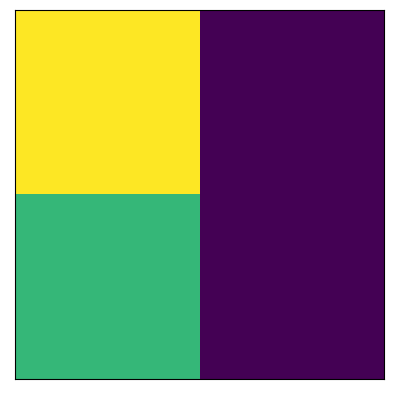

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


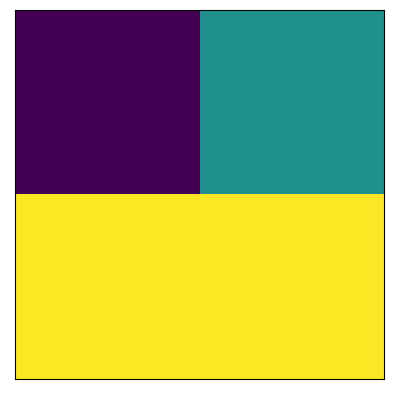

tf.Tensor(
[[0.  0.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


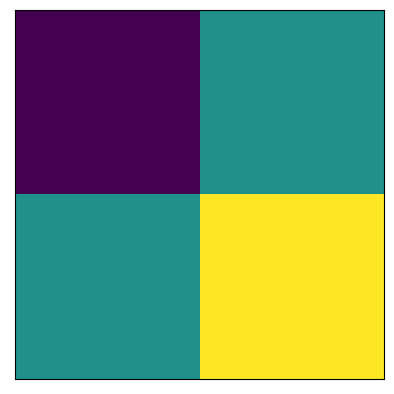

tf.Tensor(
[[0.  0.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


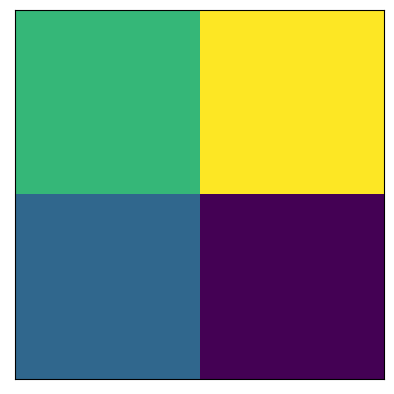

tf.Tensor(
[[1.  1.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


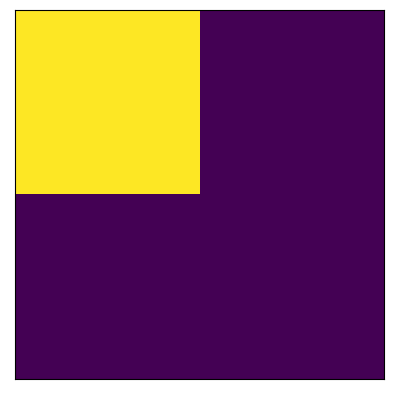

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


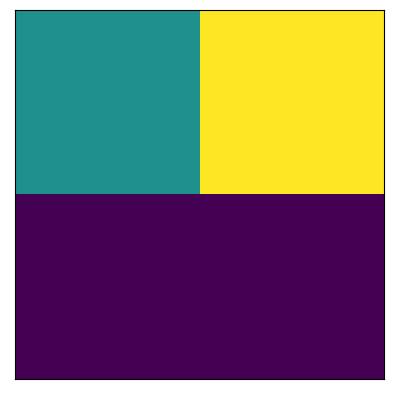

tf.Tensor(
[[0.75 1.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


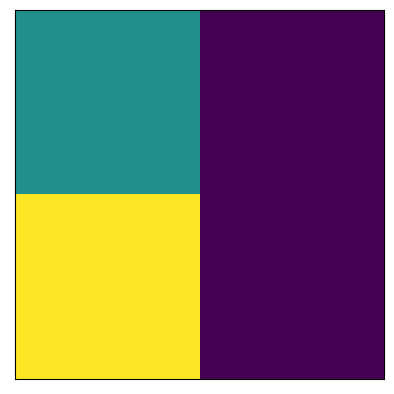

tf.Tensor(
[[0.25 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


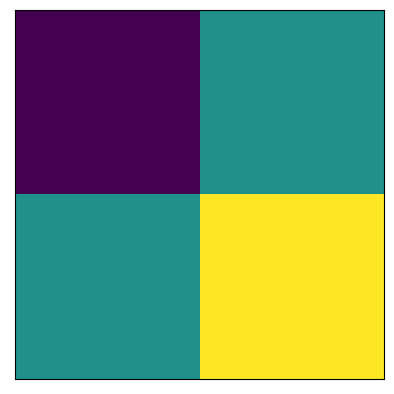

tf.Tensor(
[[0.  0.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


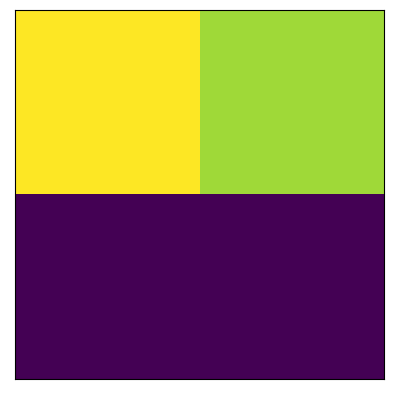

tf.Tensor(
[[0.7777778 0.6666667]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


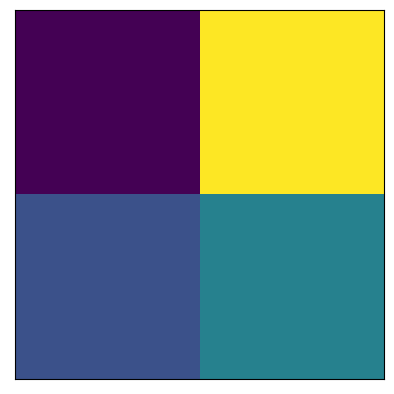

tf.Tensor(
[[0.22222221 2.        ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


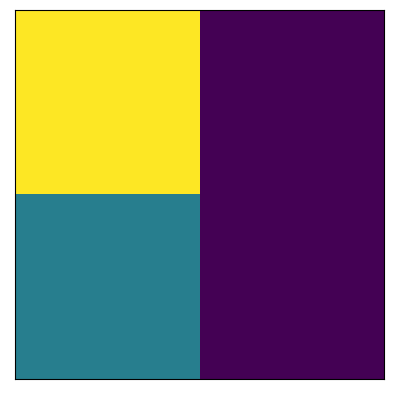

tf.Tensor(
[[0.7777778  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


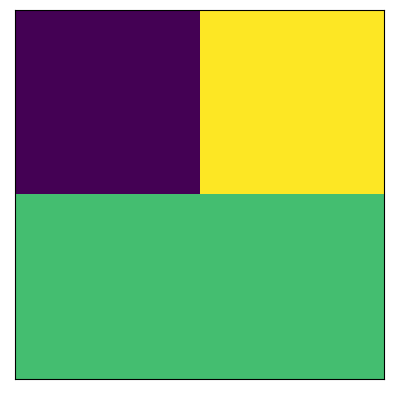

tf.Tensor(
[[0.22222221 1.3333333 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


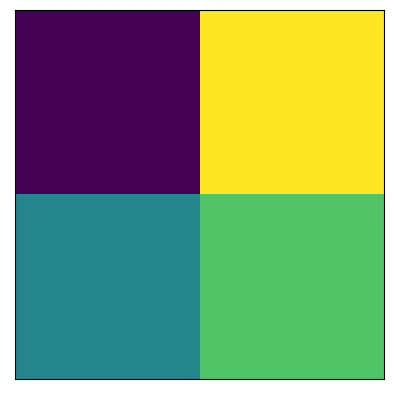

tf.Tensor(
[[0.11111107 1.3333333 ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


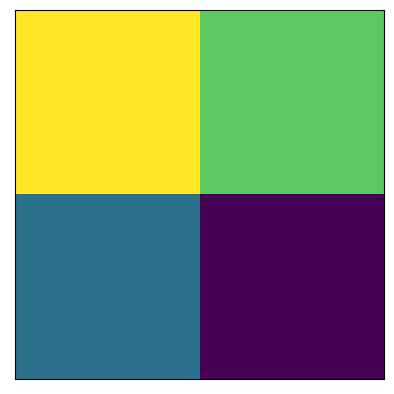

tf.Tensor(
[[0.88888896 0.6666667 ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


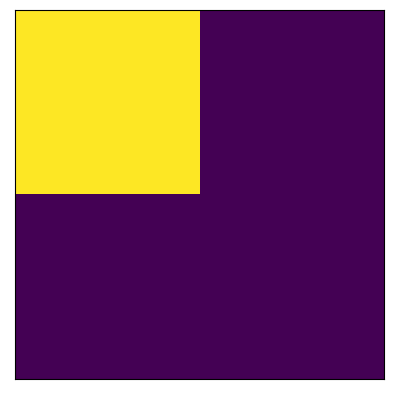

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


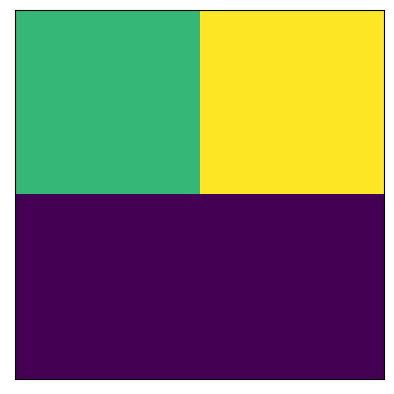

tf.Tensor(
[[0.44444448 0.6666667 ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


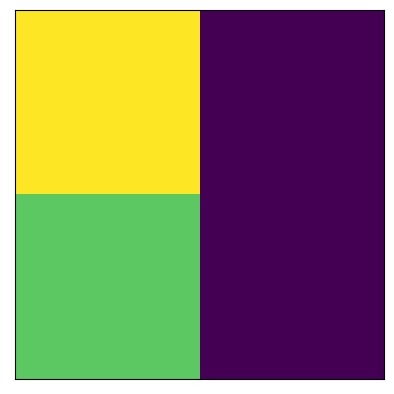

tf.Tensor(
[[0.44444448 0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


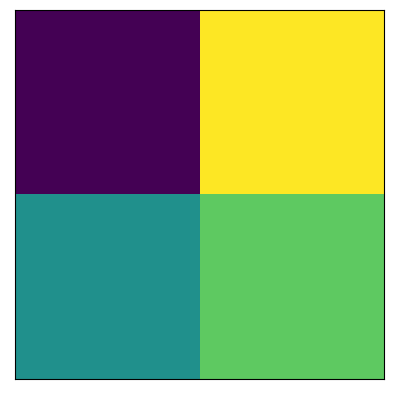

tf.Tensor(
[[0.        1.3333333]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


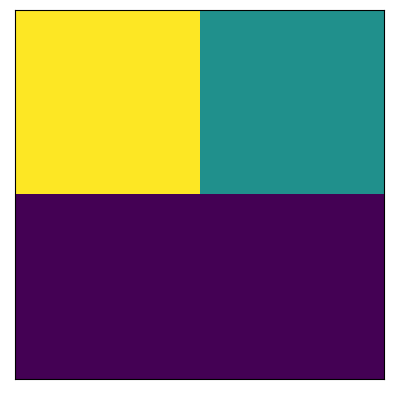

tf.Tensor(
[[2. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


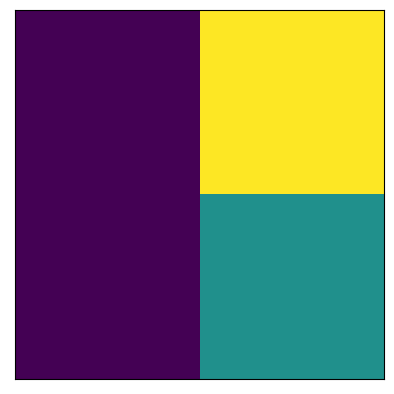

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


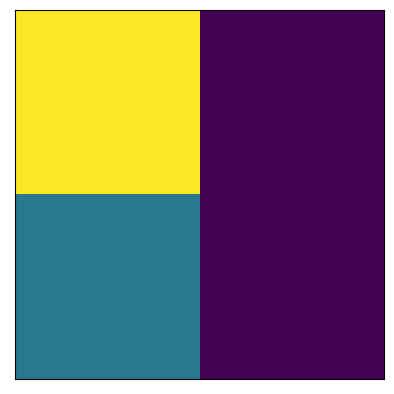

tf.Tensor(
[[5. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


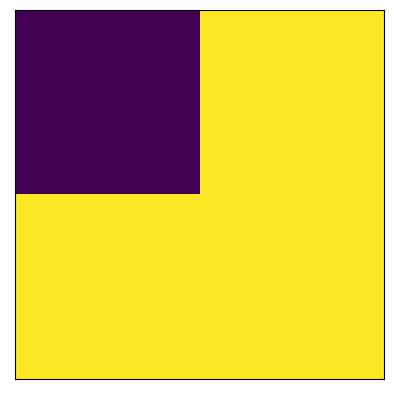

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


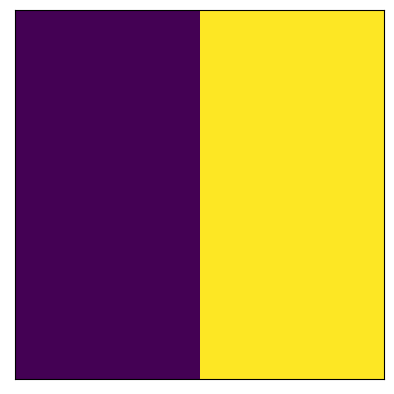

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


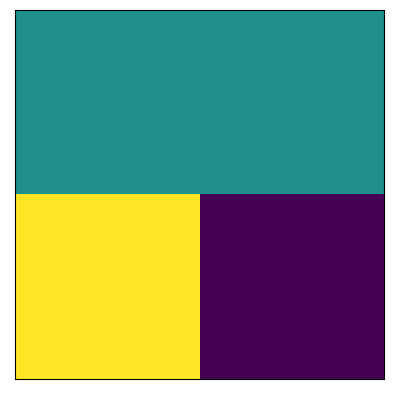

tf.Tensor(
[[1. 1.]
 [2. 0.]], shape=(2, 2), dtype=float32)


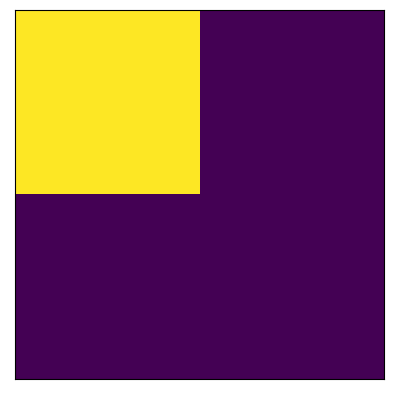

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


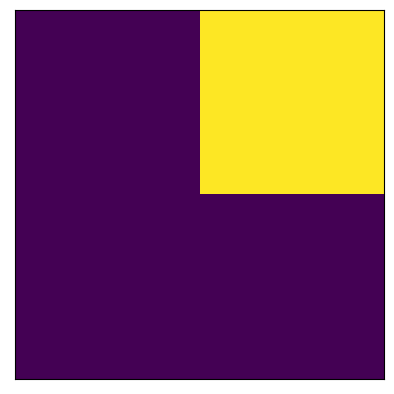

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


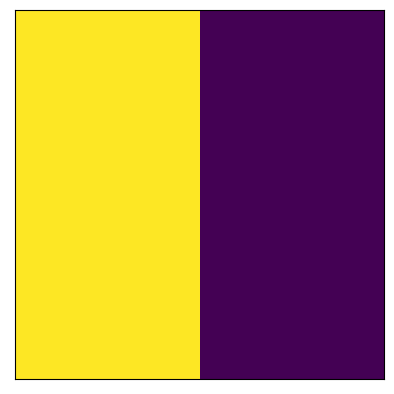

tf.Tensor(
[[2. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


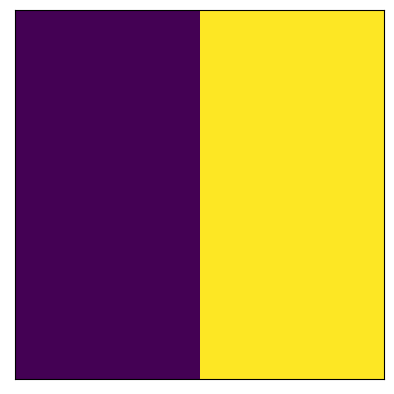

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


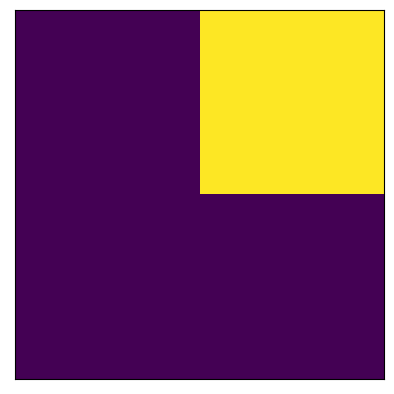

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


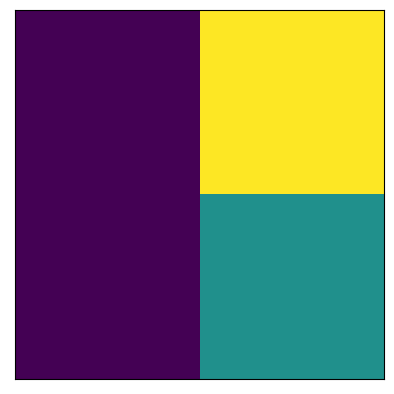

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


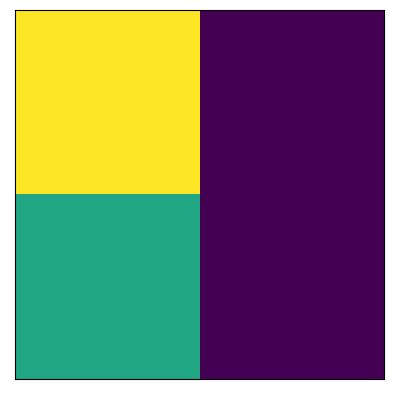

tf.Tensor(
[[5. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


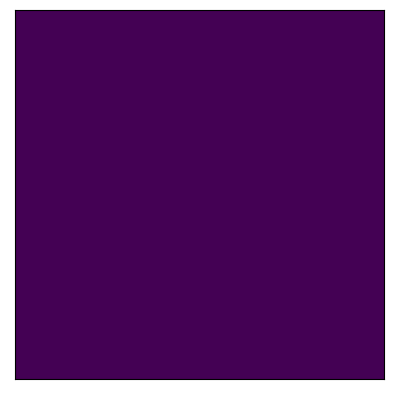

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


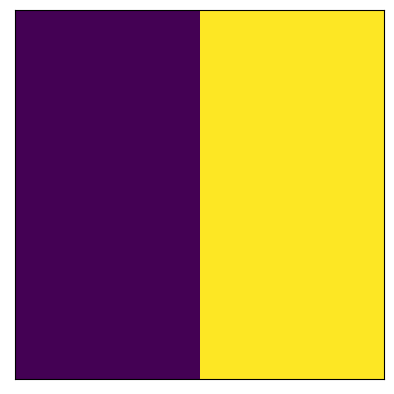

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


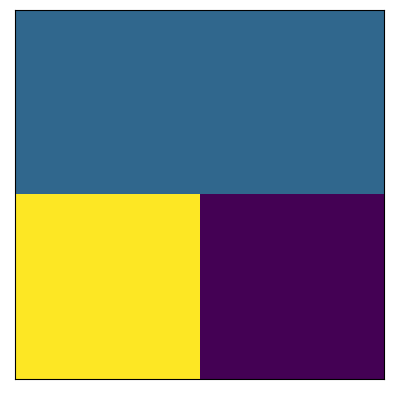

tf.Tensor(
[[1. 1.]
 [3. 0.]], shape=(2, 2), dtype=float32)


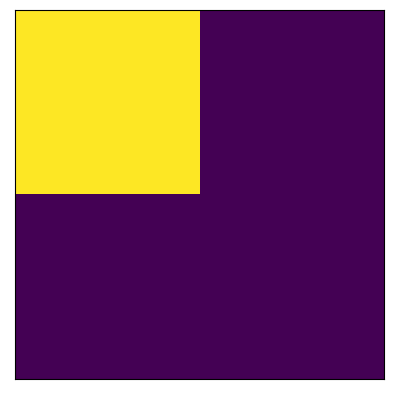

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


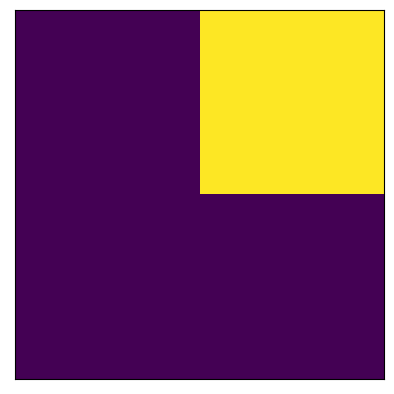

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


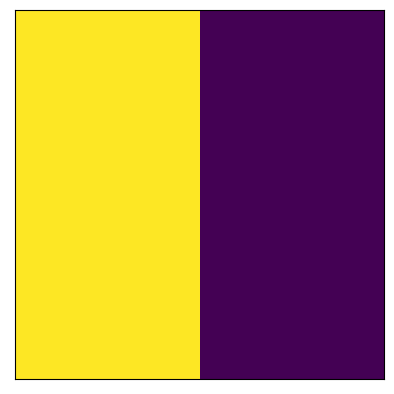

tf.Tensor(
[[3. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


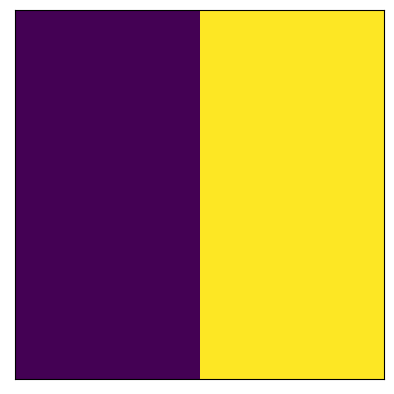

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


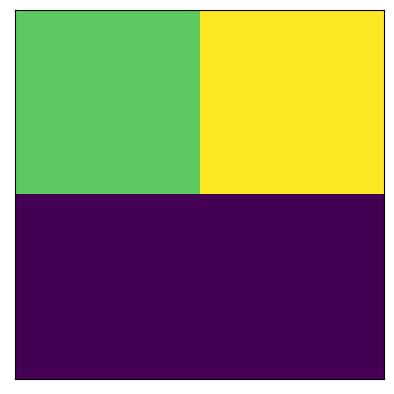

tf.Tensor(
[[1.5 2. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


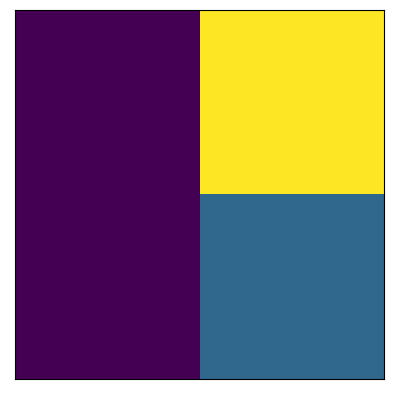

tf.Tensor(
[[0.5 2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


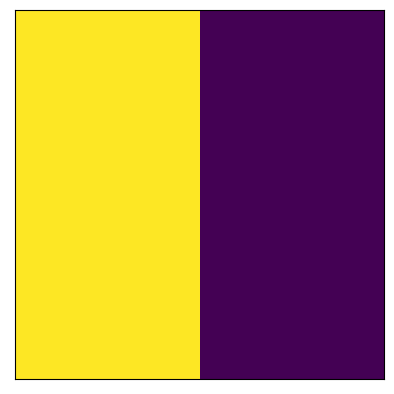

tf.Tensor(
[[0.5 0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


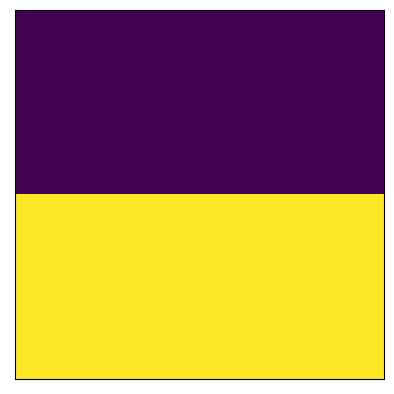

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


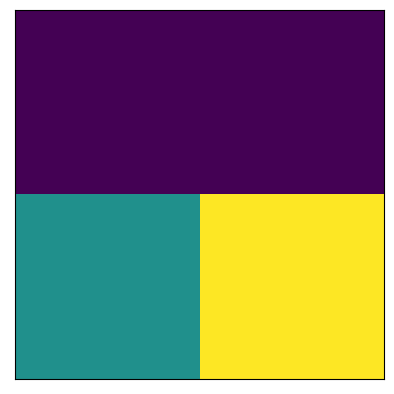

tf.Tensor(
[[0.  0. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


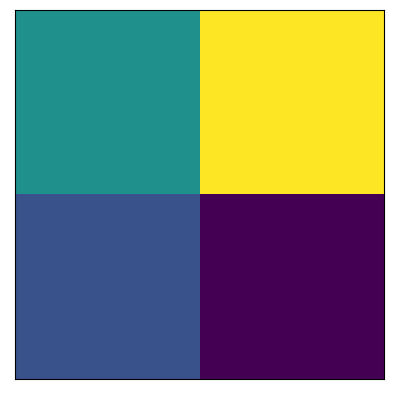

tf.Tensor(
[[1.  2. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


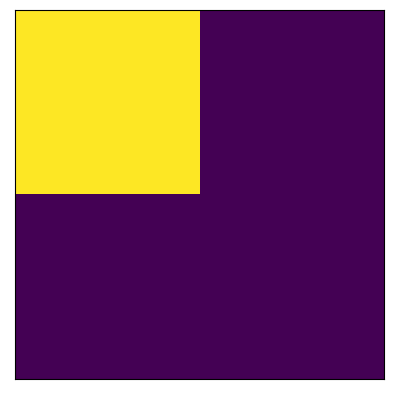

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


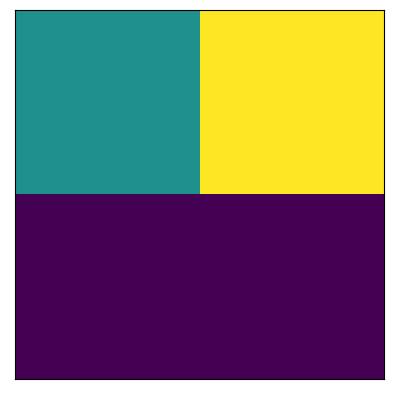

tf.Tensor(
[[1. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


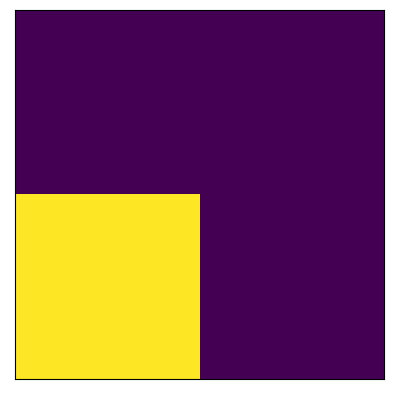

tf.Tensor(
[[0.  0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


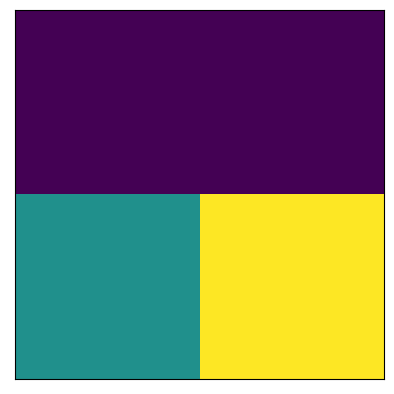

tf.Tensor(
[[0.  0. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


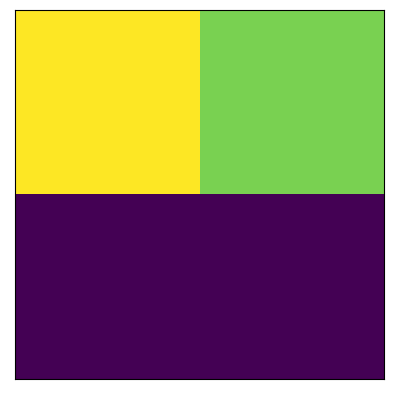

tf.Tensor(
[[0.625 0.5  ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


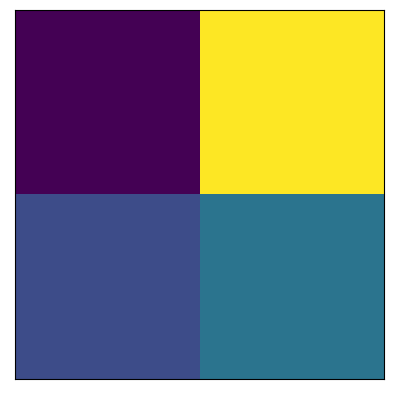

tf.Tensor(
[[0.375 2.   ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


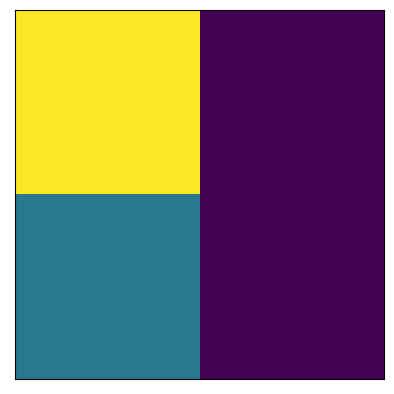

tf.Tensor(
[[0.625 0.   ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


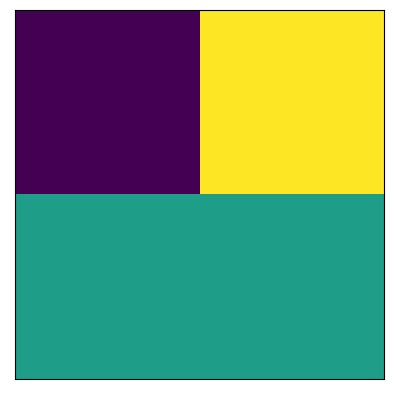

tf.Tensor(
[[0.375 1.5  ]
 [1.    1.   ]], shape=(2, 2), dtype=float32)


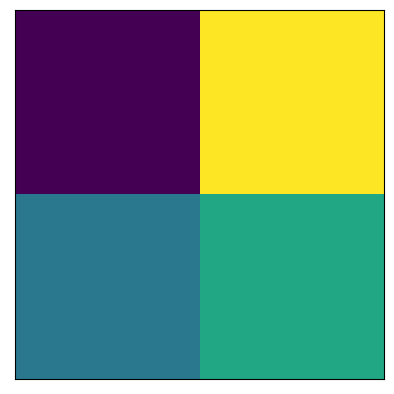

tf.Tensor(
[[0.25 1.5 ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


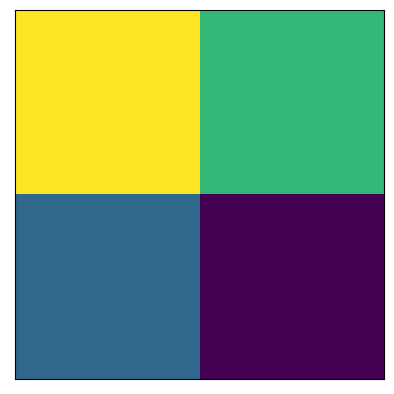

tf.Tensor(
[[0.75 0.5 ]
 [0.25 0.  ]], shape=(2, 2), dtype=float32)


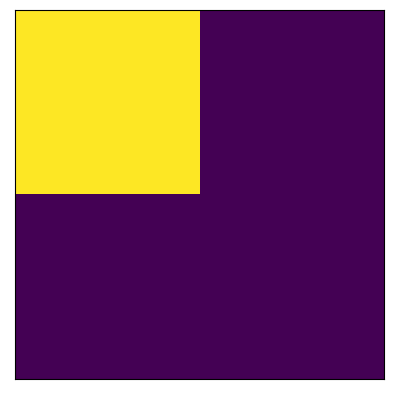

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


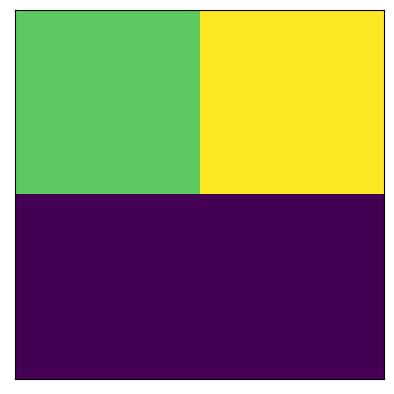

tf.Tensor(
[[0.375 0.5  ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


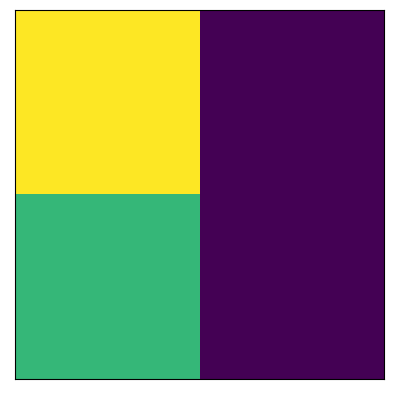

tf.Tensor(
[[0.375 0.   ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


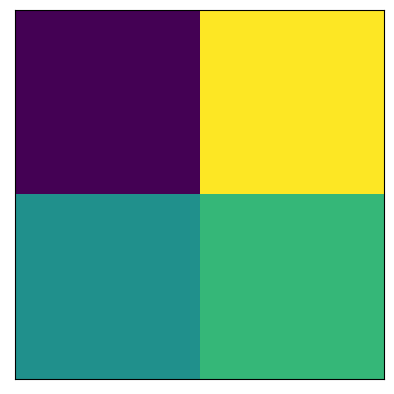

tf.Tensor(
[[0.   1.5 ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


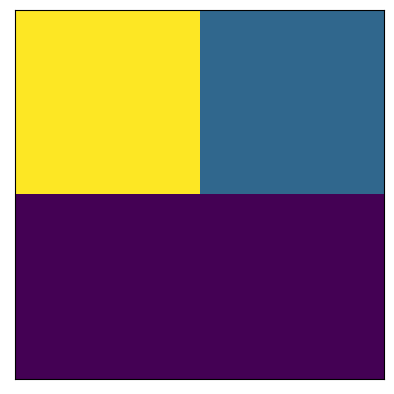

tf.Tensor(
[[3. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


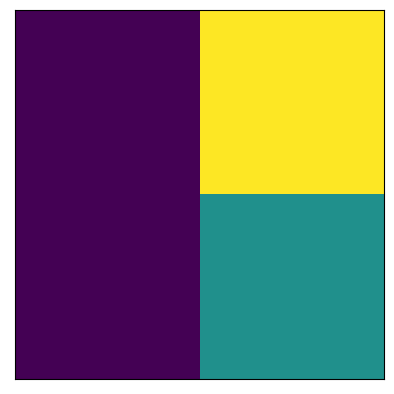

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


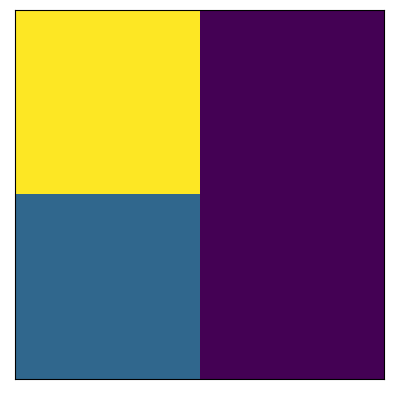

tf.Tensor(
[[6. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


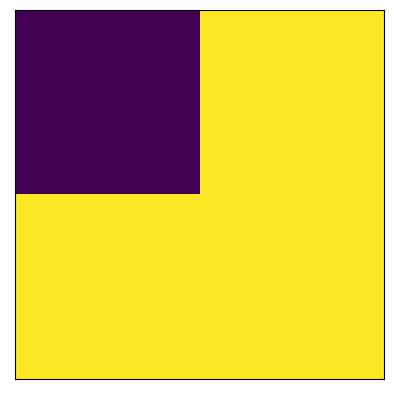

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


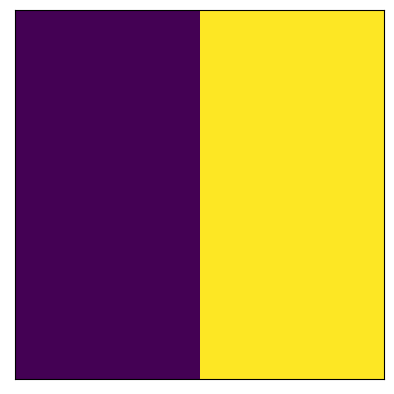

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


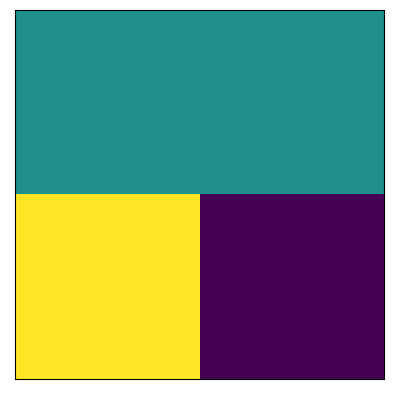

tf.Tensor(
[[1. 1.]
 [2. 0.]], shape=(2, 2), dtype=float32)


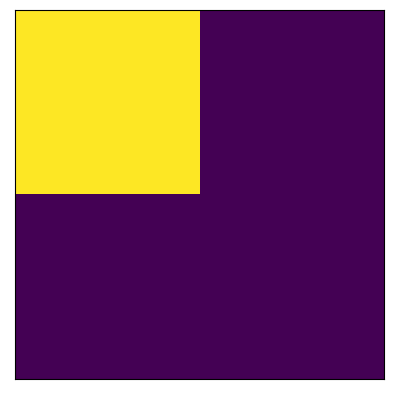

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


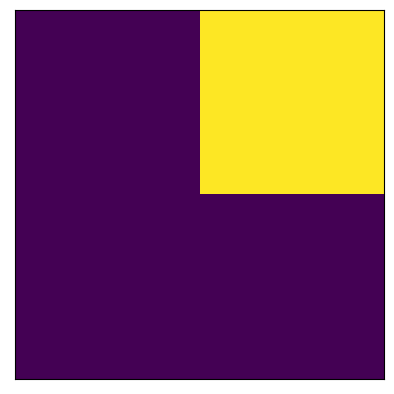

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


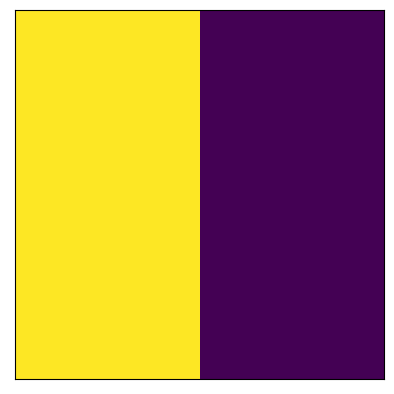

tf.Tensor(
[[2. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


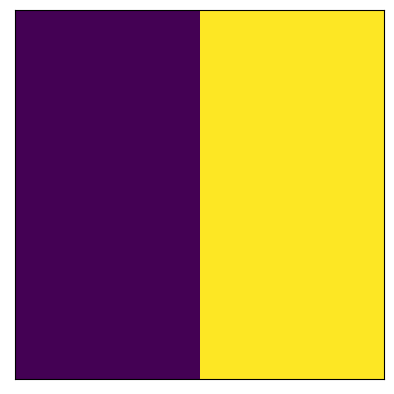

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


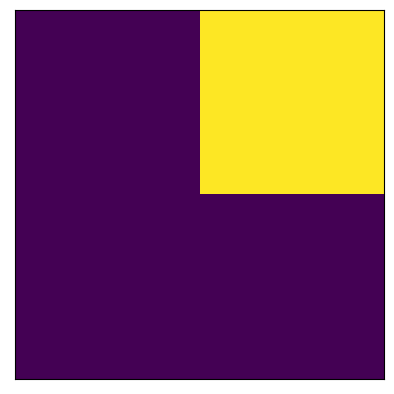

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


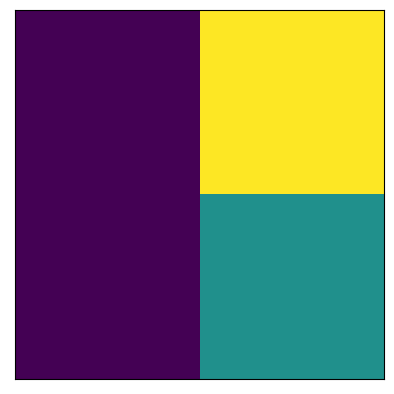

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


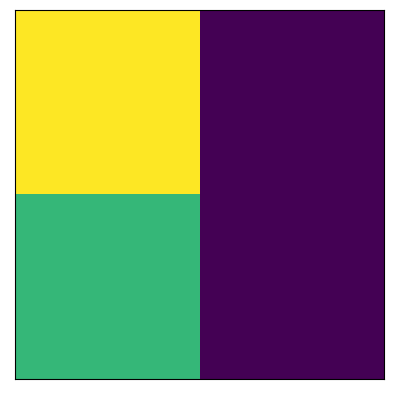

tf.Tensor(
[[6. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


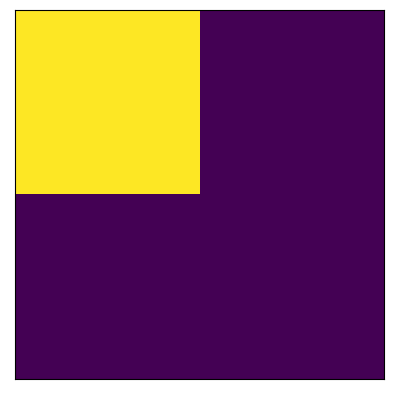

tf.Tensor(
[[2. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


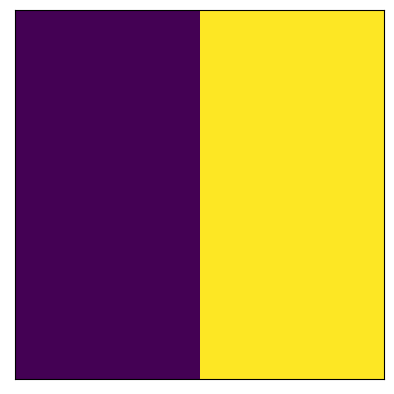

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


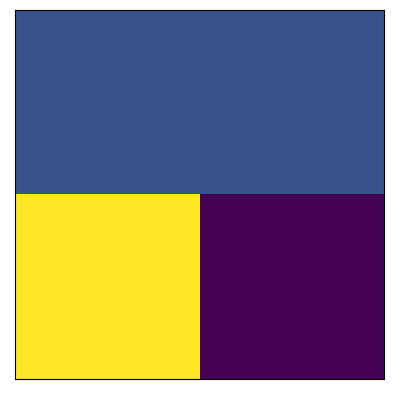

tf.Tensor(
[[1. 1.]
 [4. 0.]], shape=(2, 2), dtype=float32)


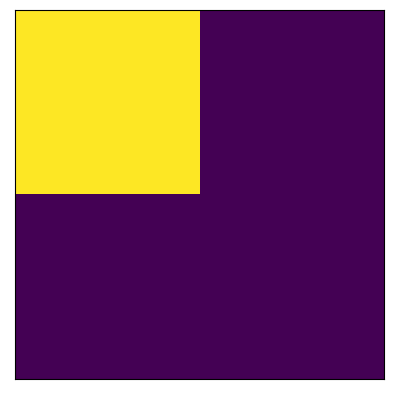

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


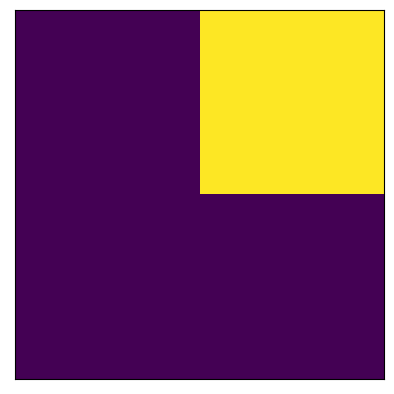

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


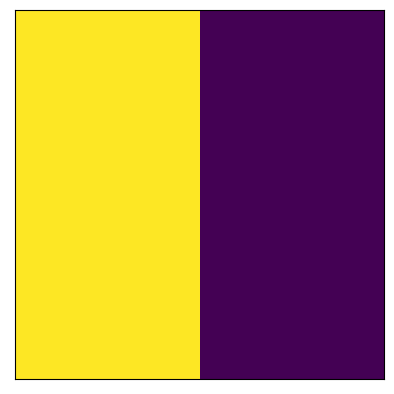

tf.Tensor(
[[4. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


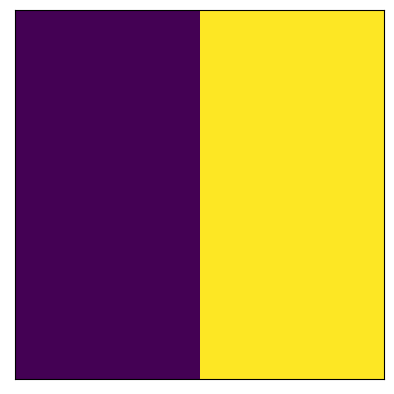

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


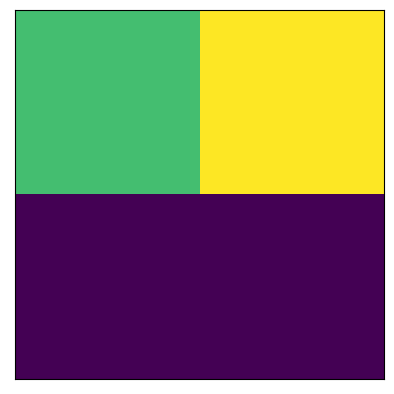

tf.Tensor(
[[1.75 2.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


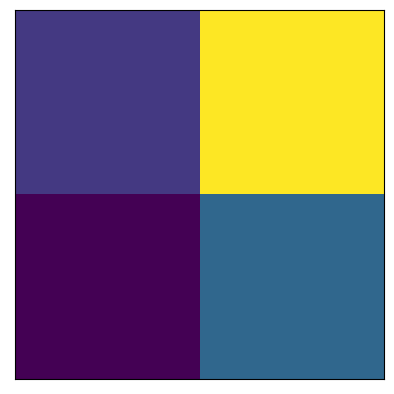

tf.Tensor(
[[0.75 2.  ]
 [0.5  1.  ]], shape=(2, 2), dtype=float32)


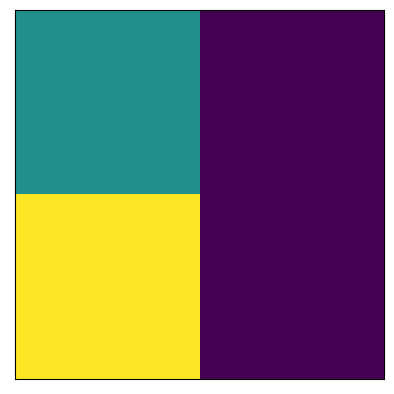

tf.Tensor(
[[0.25 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


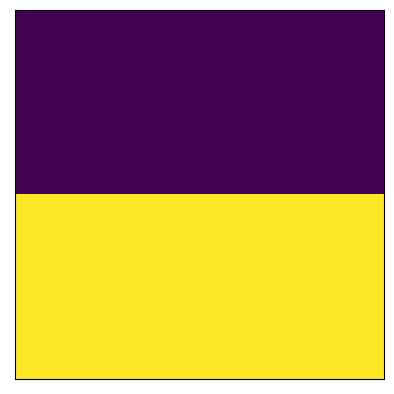

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


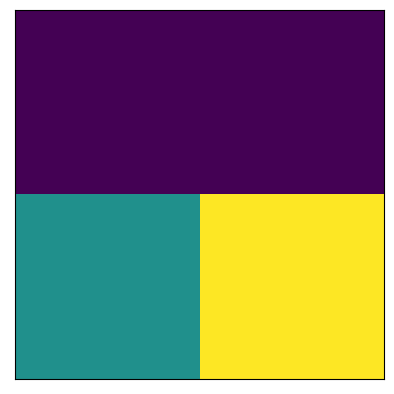

tf.Tensor(
[[0.  0. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


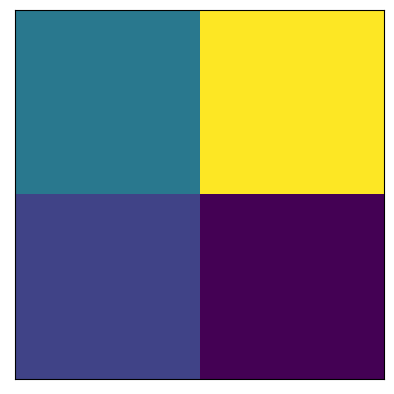

tf.Tensor(
[[1.  2.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


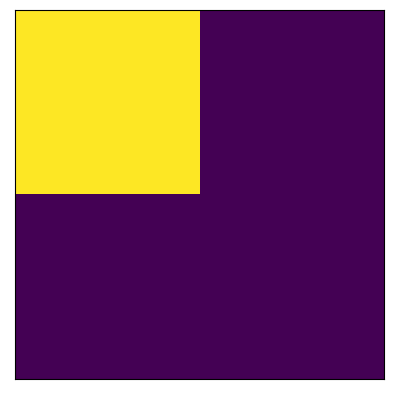

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


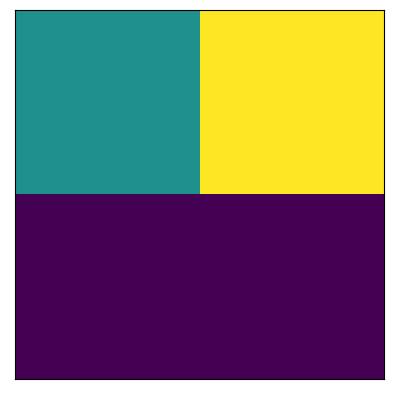

tf.Tensor(
[[1.25 2.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


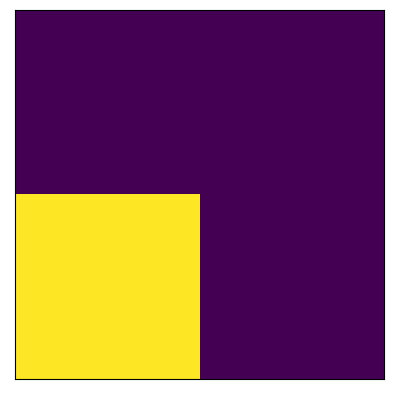

tf.Tensor(
[[0.  0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


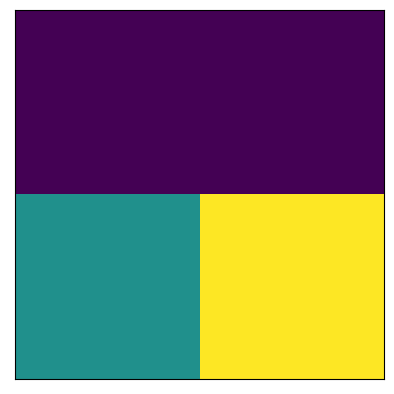

tf.Tensor(
[[0.  0. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


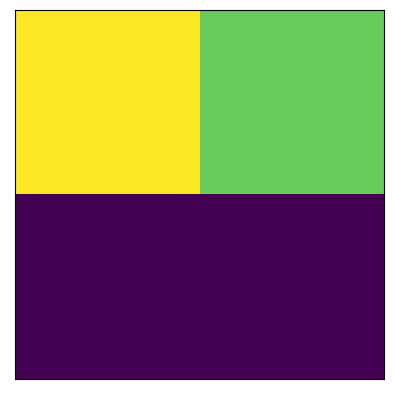

tf.Tensor(
[[0.52 0.4 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


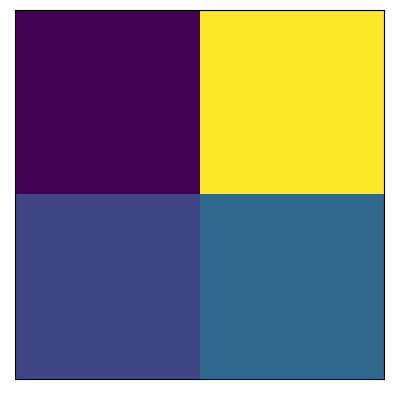

tf.Tensor(
[[0.48000002 2.        ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


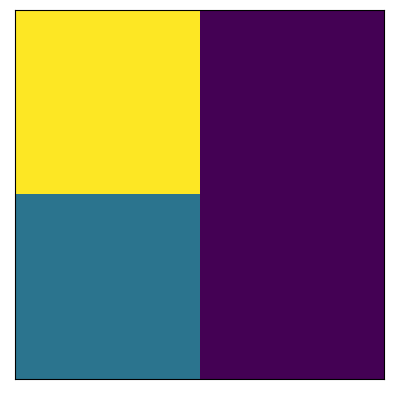

tf.Tensor(
[[0.52 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


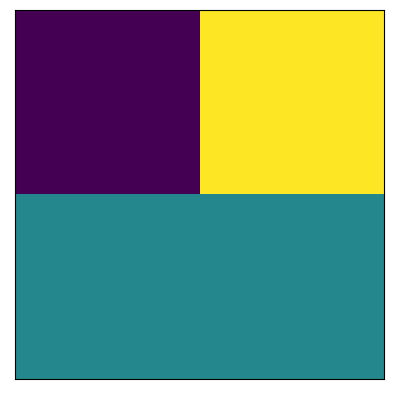

tf.Tensor(
[[0.48000002 1.6       ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


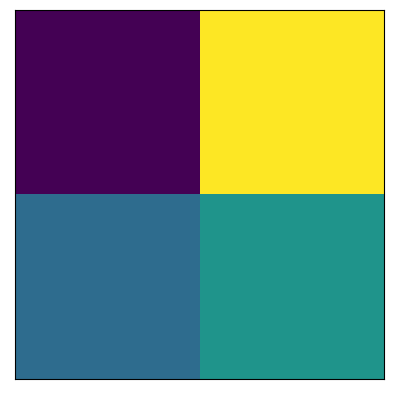

tf.Tensor(
[[0.36 1.6 ]
 [0.8  1.  ]], shape=(2, 2), dtype=float32)


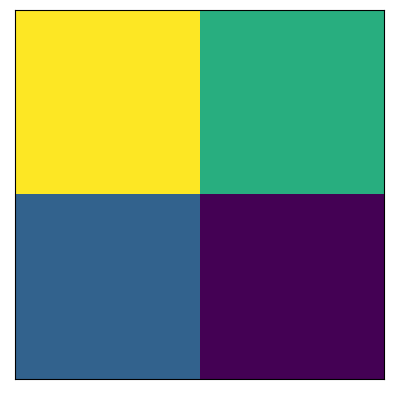

tf.Tensor(
[[0.64 0.4 ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


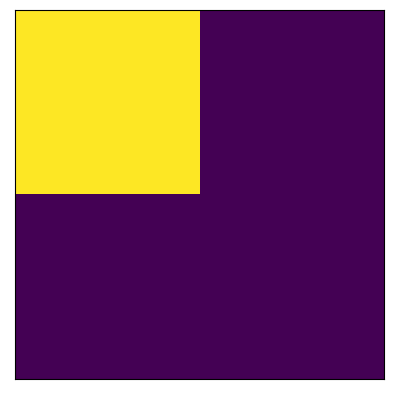

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


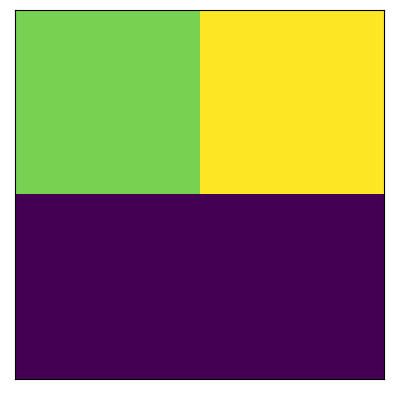

tf.Tensor(
[[0.32 0.4 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


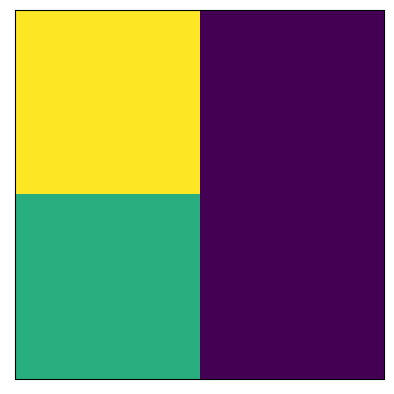

tf.Tensor(
[[0.32 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


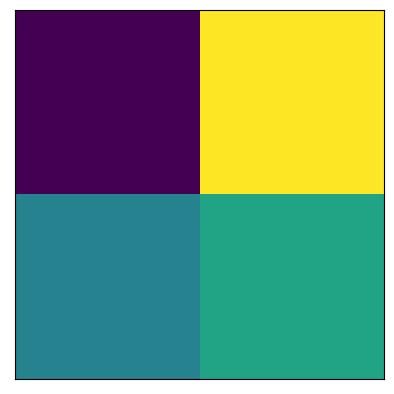

tf.Tensor(
[[0.16000003 1.6       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


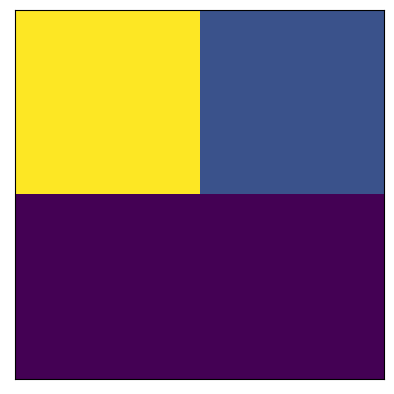

tf.Tensor(
[[4. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


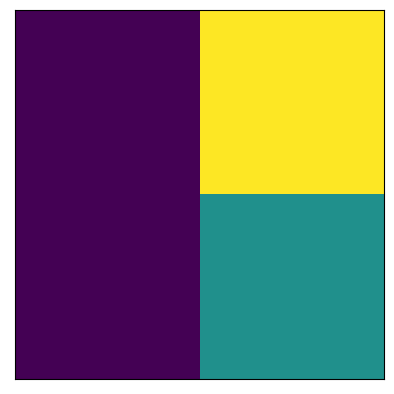

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


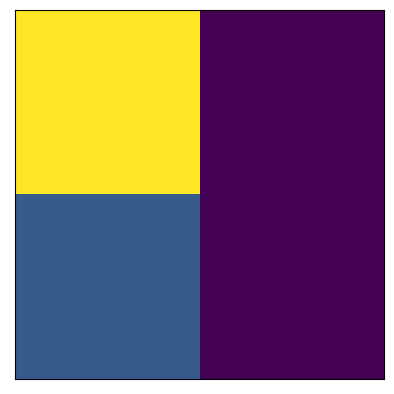

tf.Tensor(
[[7. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


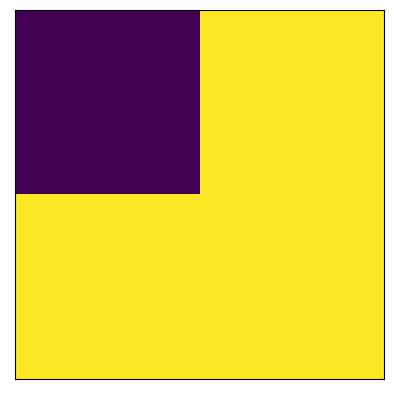

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


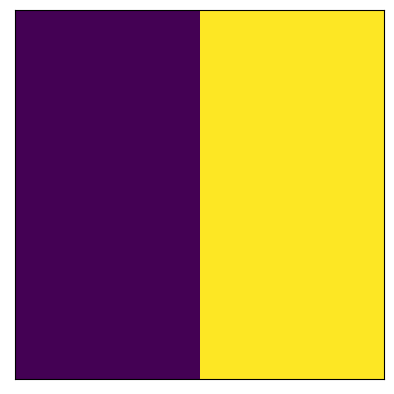

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


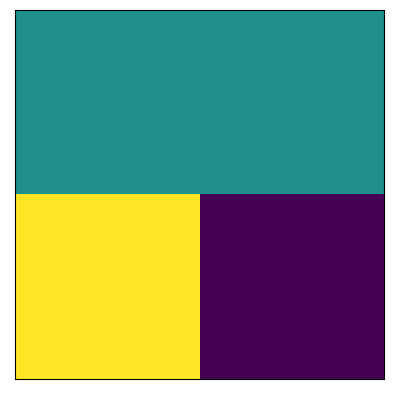

tf.Tensor(
[[1. 1.]
 [2. 0.]], shape=(2, 2), dtype=float32)


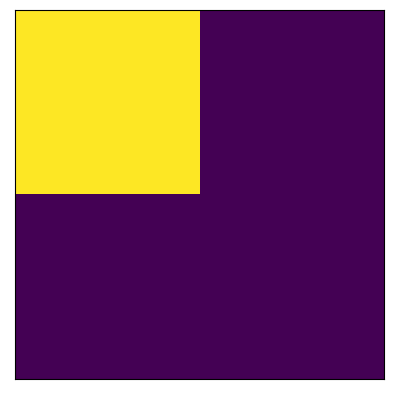

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


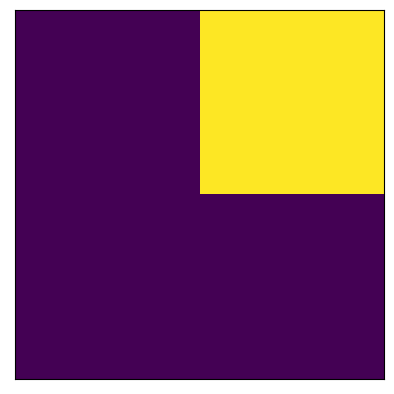

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


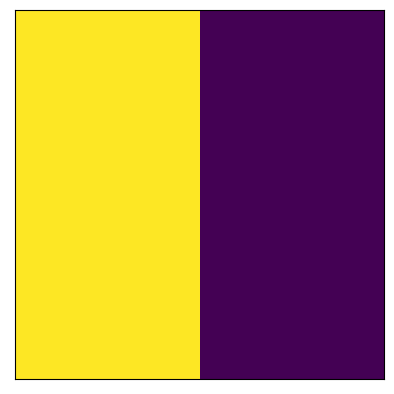

tf.Tensor(
[[2. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


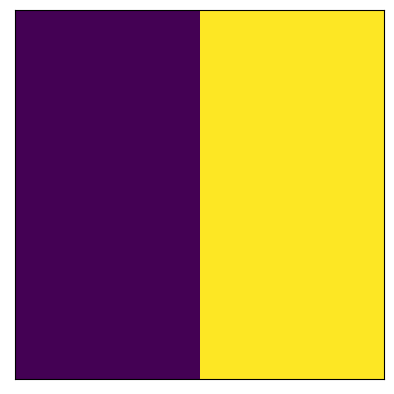

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


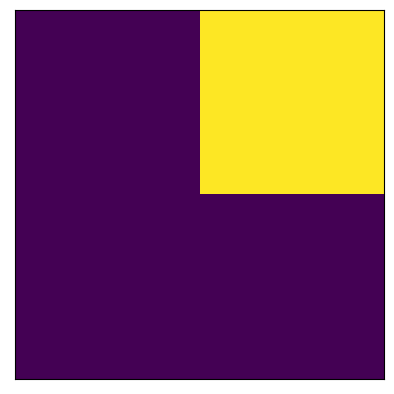

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


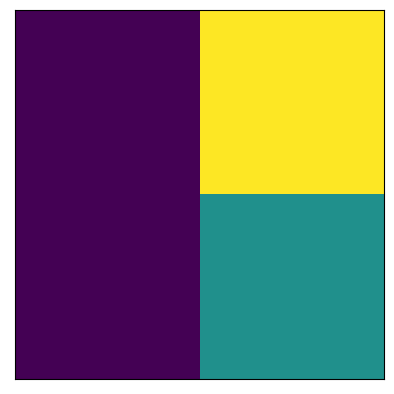

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


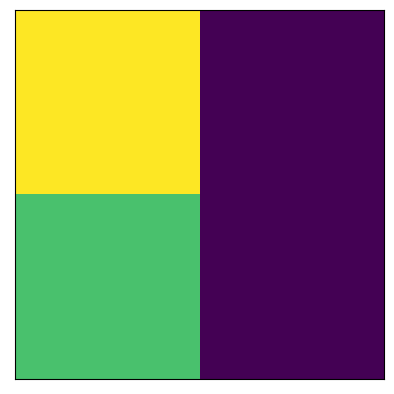

tf.Tensor(
[[7. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


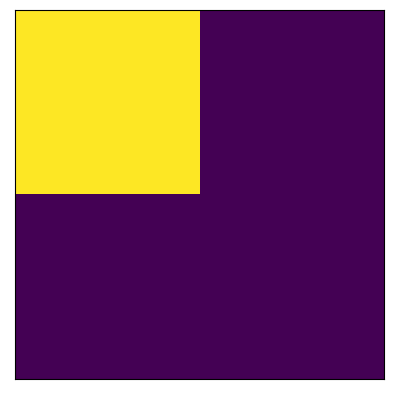

tf.Tensor(
[[3. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


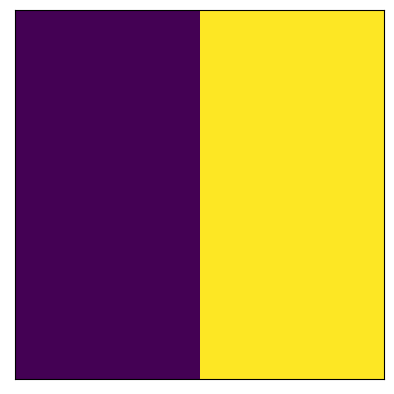

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


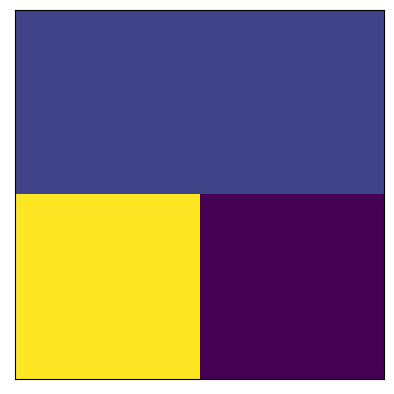

tf.Tensor(
[[1. 1.]
 [5. 0.]], shape=(2, 2), dtype=float32)


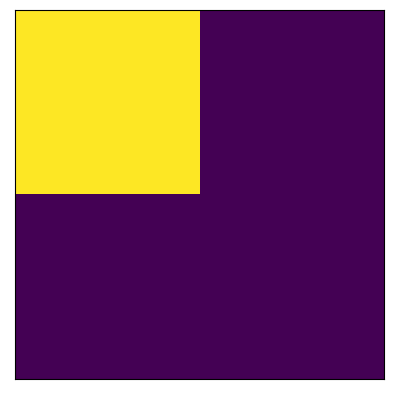

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


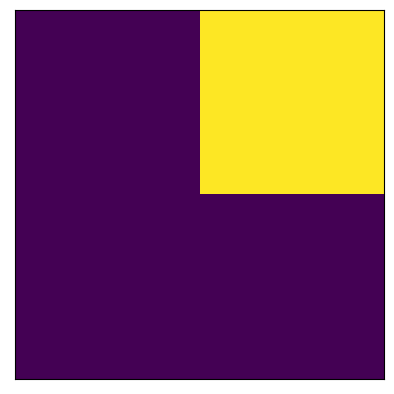

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


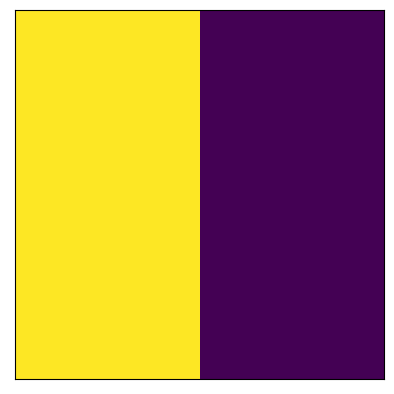

tf.Tensor(
[[5. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


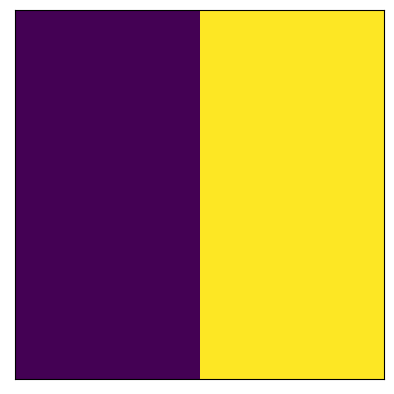

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


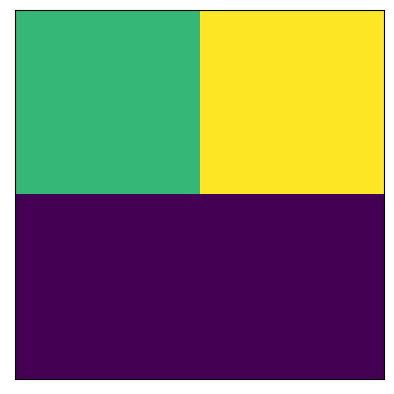

tf.Tensor(
[[2. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


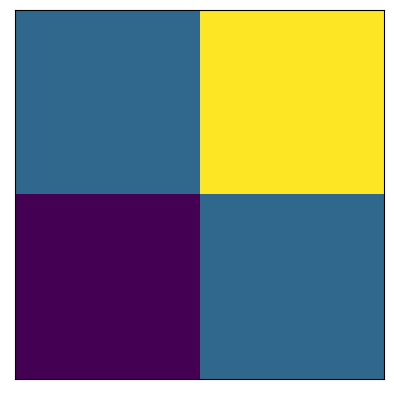

tf.Tensor(
[[1.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


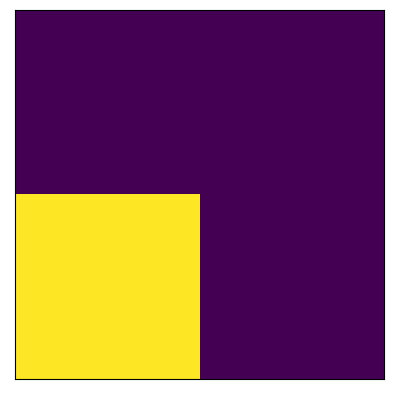

tf.Tensor(
[[0.  0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


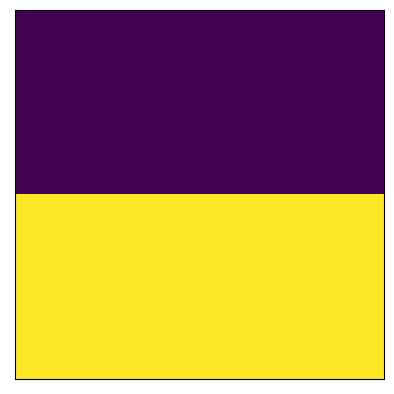

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


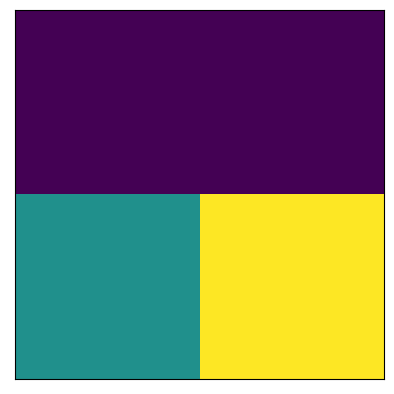

tf.Tensor(
[[0.  0. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


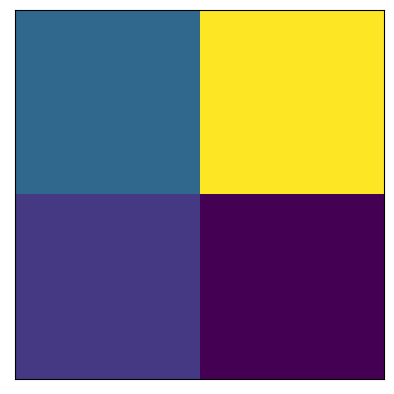

tf.Tensor(
[[1.  3. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


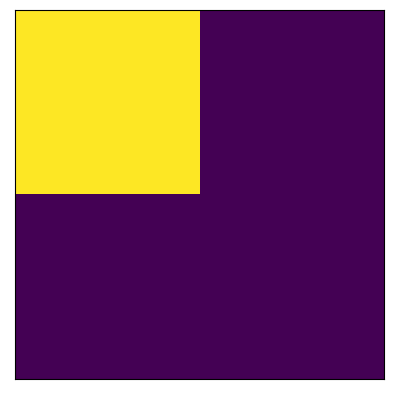

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


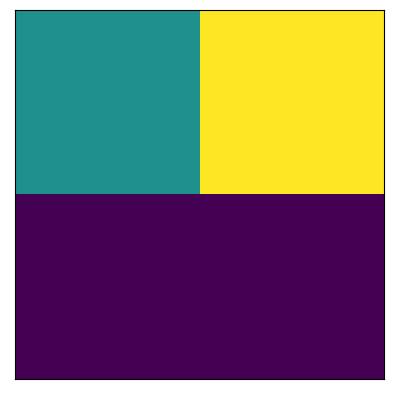

tf.Tensor(
[[1.5 3. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


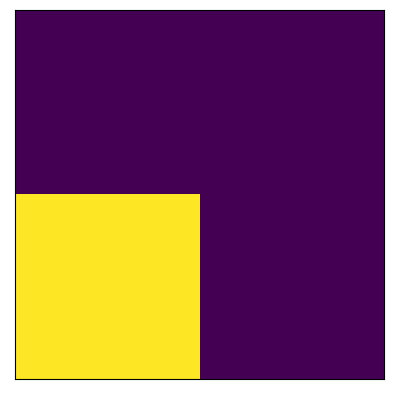

tf.Tensor(
[[0.  0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


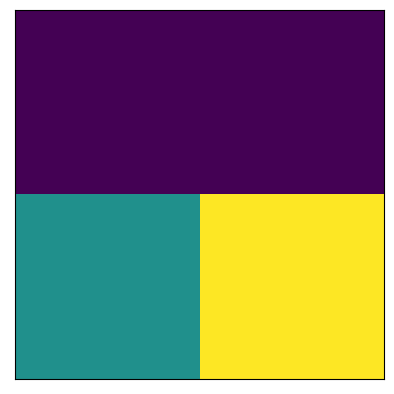

tf.Tensor(
[[0.  0. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


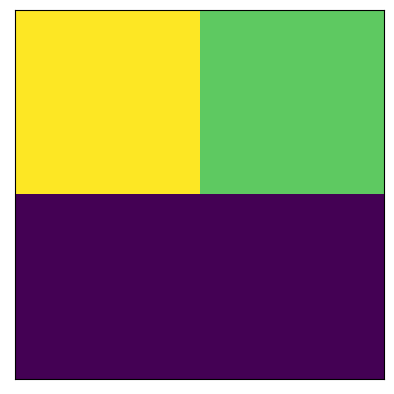

tf.Tensor(
[[0.44444445 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


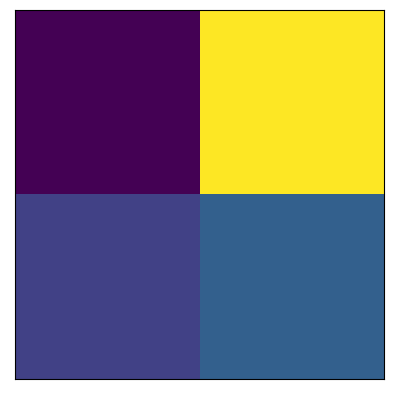

tf.Tensor(
[[0.5555555 2.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


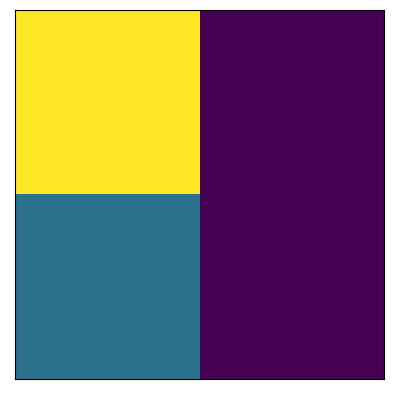

tf.Tensor(
[[0.44444445 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


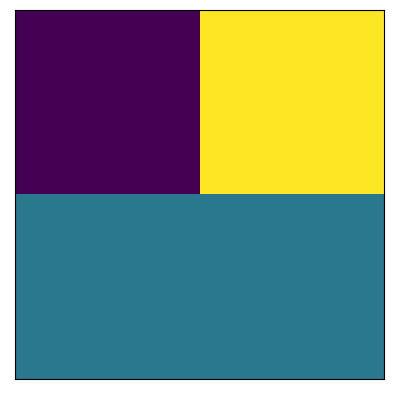

tf.Tensor(
[[0.5555555 1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


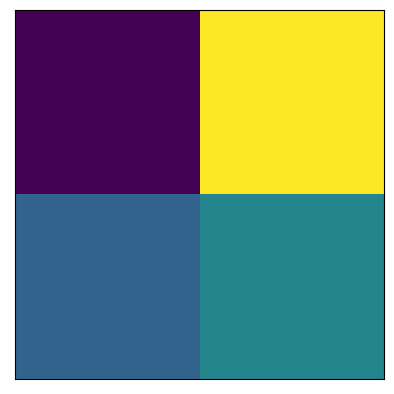

tf.Tensor(
[[0.4444444 1.6666666]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


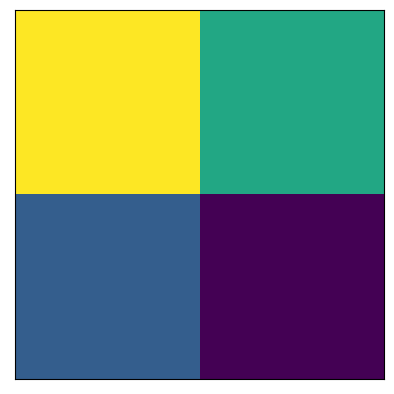

tf.Tensor(
[[0.5555556  0.33333334]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


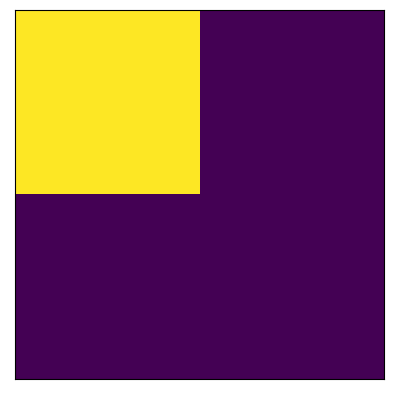

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


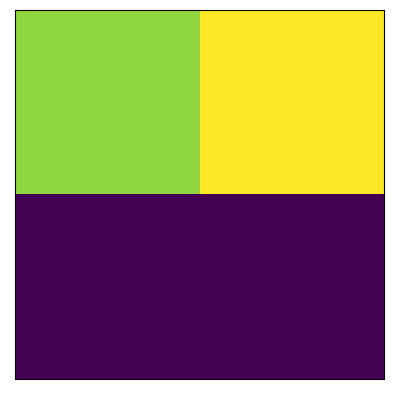

tf.Tensor(
[[0.2777778  0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


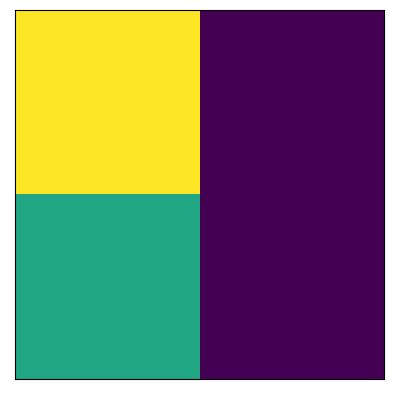

tf.Tensor(
[[0.2777778  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


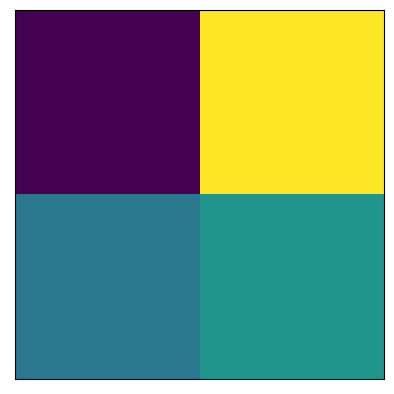

tf.Tensor(
[[0.27777773 1.6666666 ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


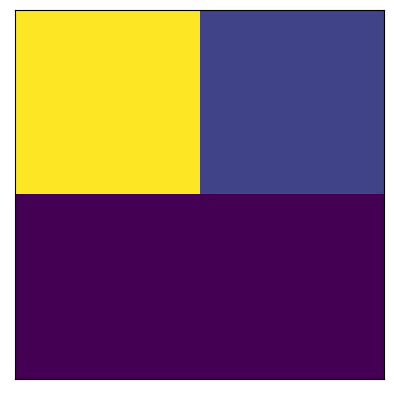

tf.Tensor(
[[5. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


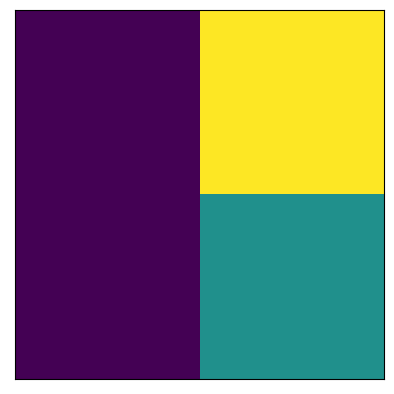

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


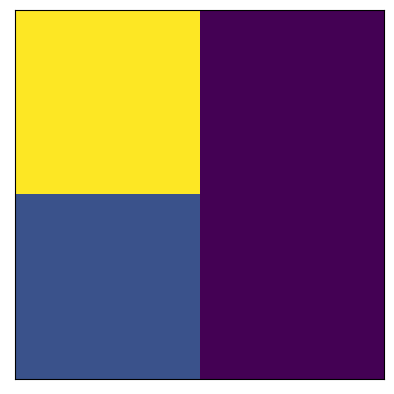

tf.Tensor(
[[8. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


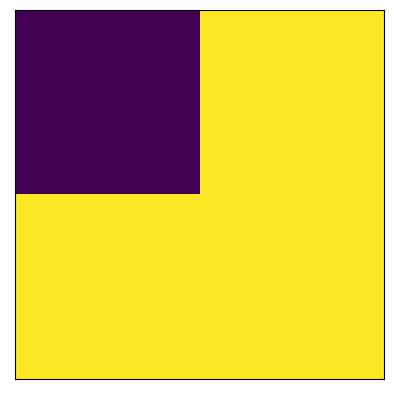

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


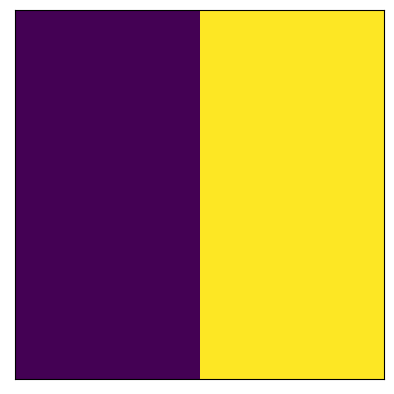

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


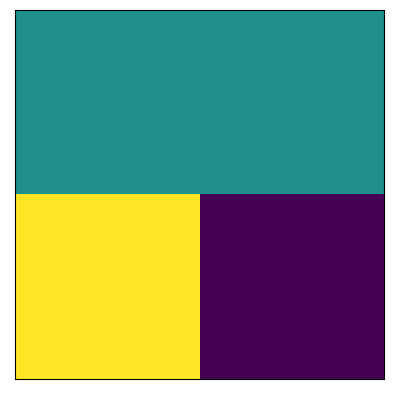

tf.Tensor(
[[1. 1.]
 [2. 0.]], shape=(2, 2), dtype=float32)


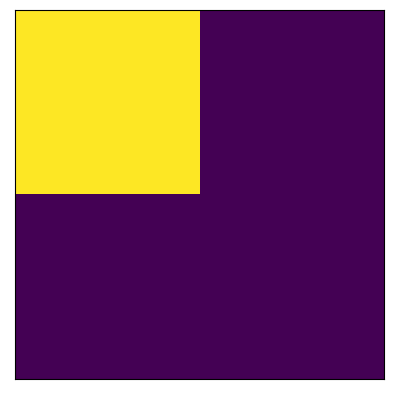

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


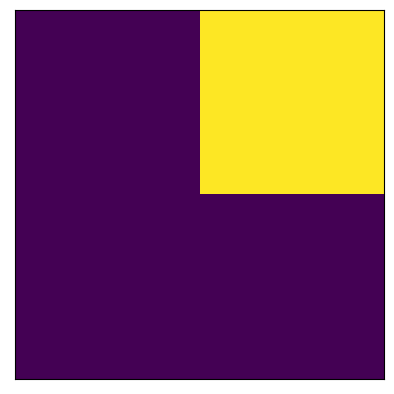

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


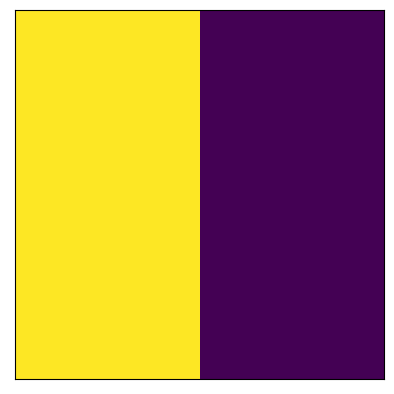

tf.Tensor(
[[2. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


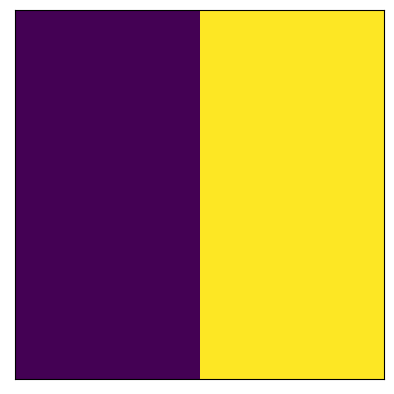

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


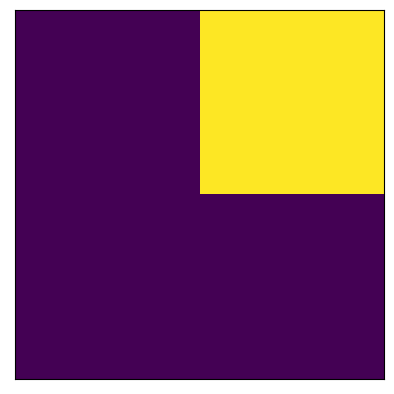

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


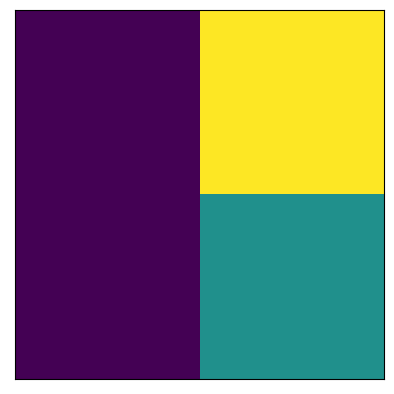

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


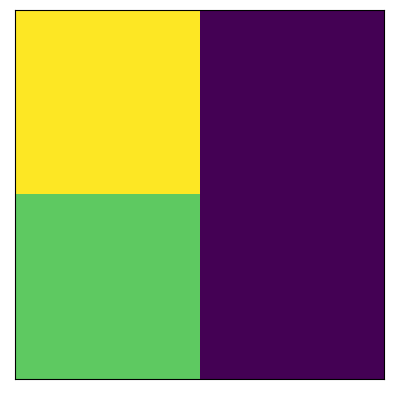

tf.Tensor(
[[8. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


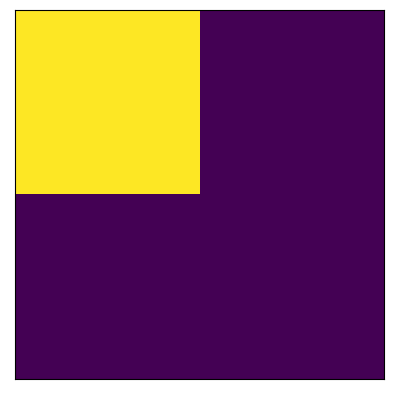

tf.Tensor(
[[4. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


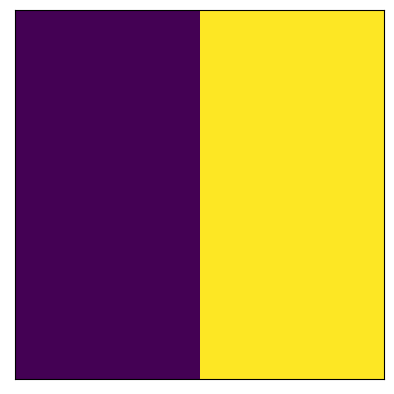

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


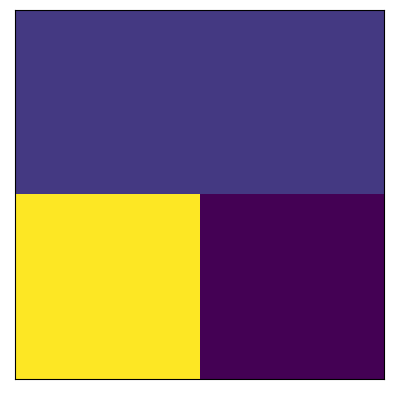

tf.Tensor(
[[1. 1.]
 [6. 0.]], shape=(2, 2), dtype=float32)


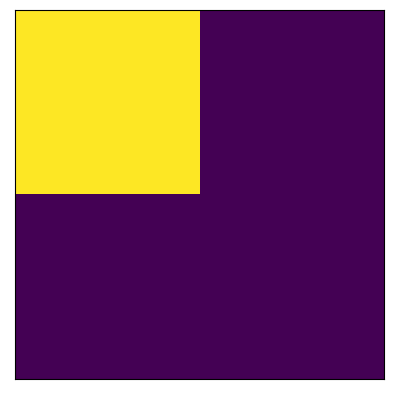

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


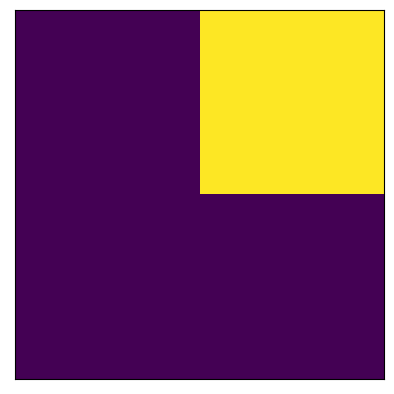

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


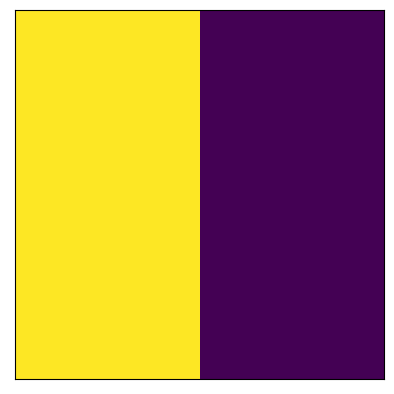

tf.Tensor(
[[6. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


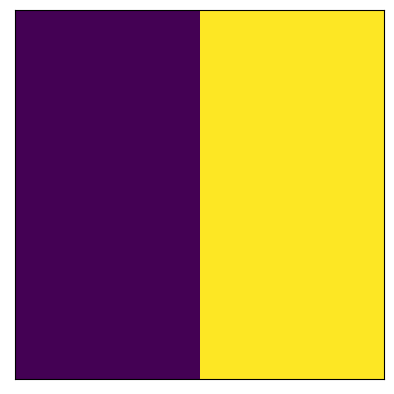

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


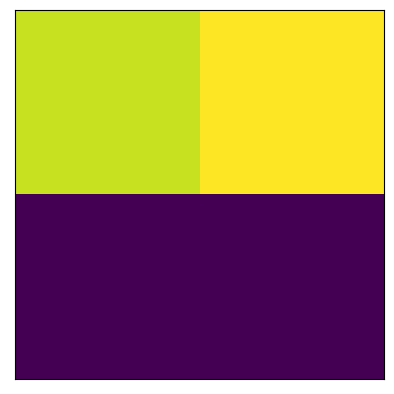

tf.Tensor(
[[1.2222222 1.3333334]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


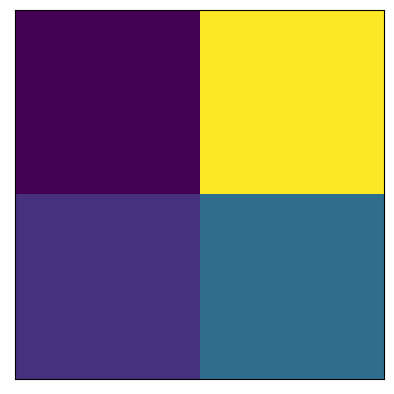

tf.Tensor(
[[0.44444445 2.        ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


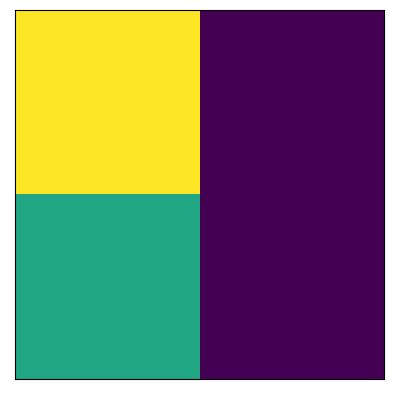

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


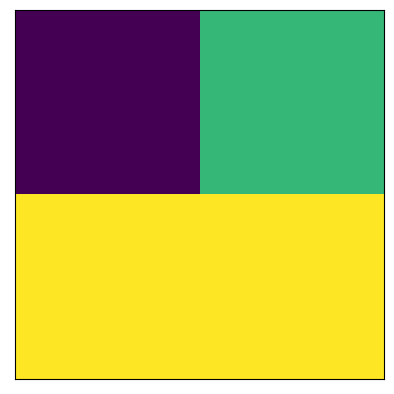

tf.Tensor(
[[0.        0.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


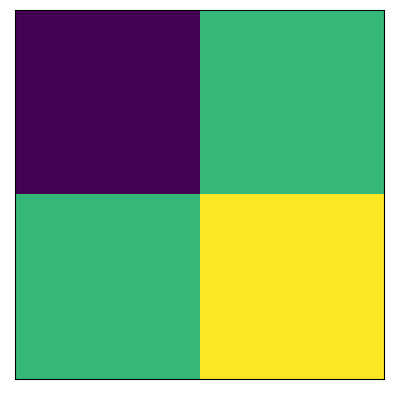

tf.Tensor(
[[0.        0.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


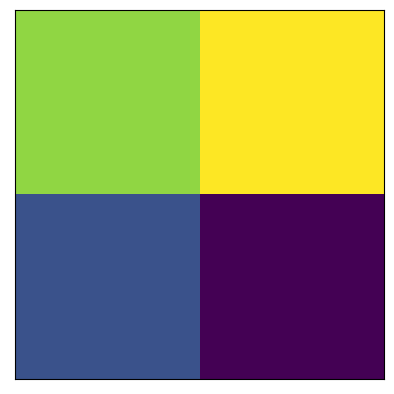

tf.Tensor(
[[1.1111112  1.3333334 ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


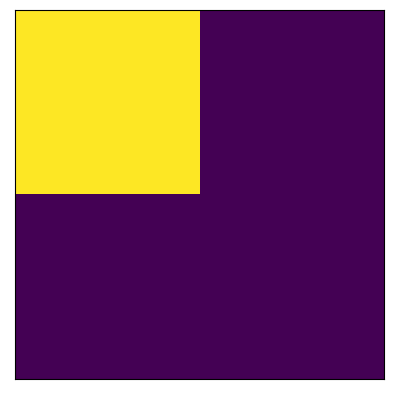

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


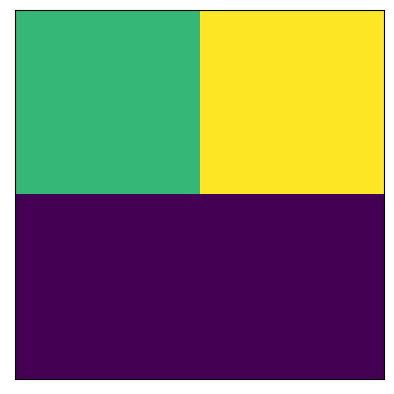

tf.Tensor(
[[0.88888896 1.3333334 ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


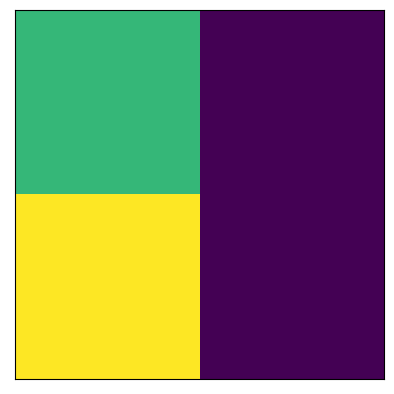

tf.Tensor(
[[0.22222224 0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


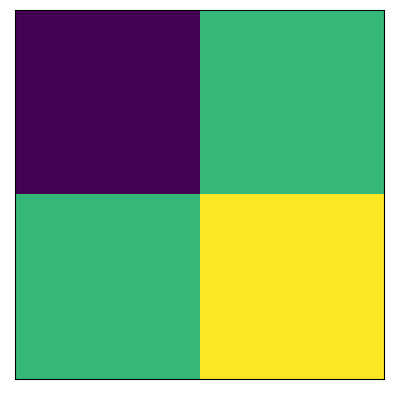

tf.Tensor(
[[0.        0.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


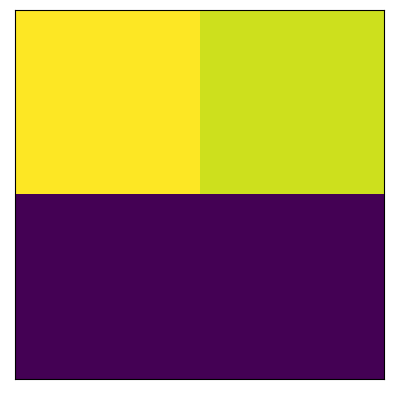

tf.Tensor(
[[0.8125 0.75  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


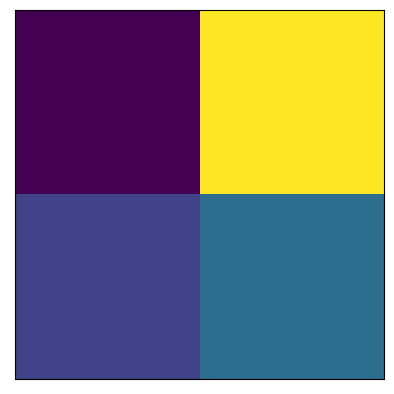

tf.Tensor(
[[0.4375 2.    ]
 [0.75   1.    ]], shape=(2, 2), dtype=float32)


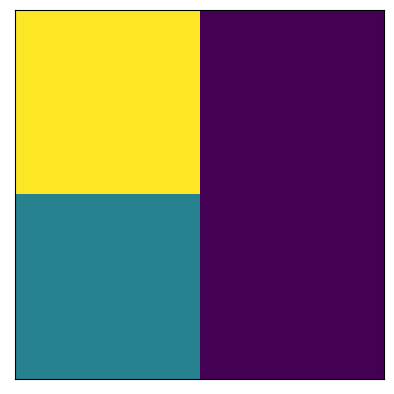

tf.Tensor(
[[0.5625 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


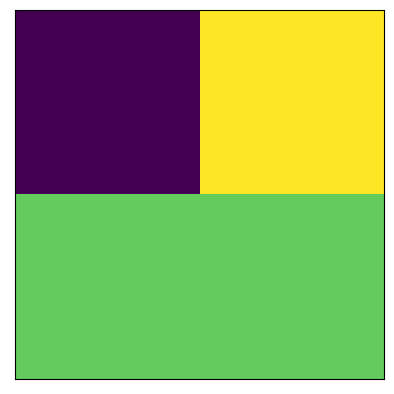

tf.Tensor(
[[0.1875 1.25  ]
 [1.     1.    ]], shape=(2, 2), dtype=float32)


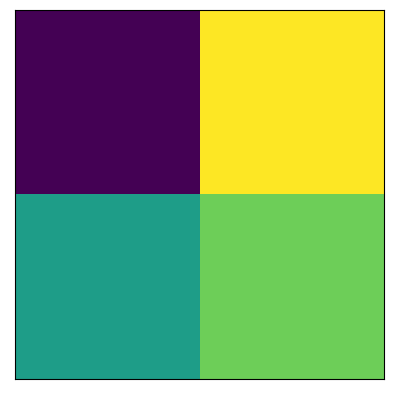

tf.Tensor(
[[0.125 1.25 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


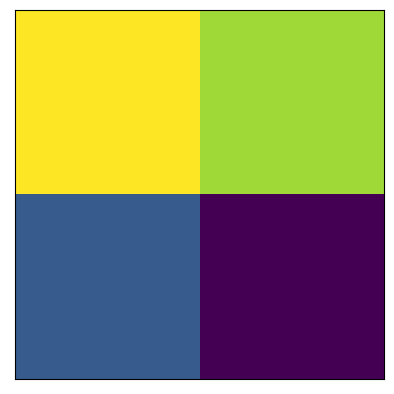

tf.Tensor(
[[0.875 0.75 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


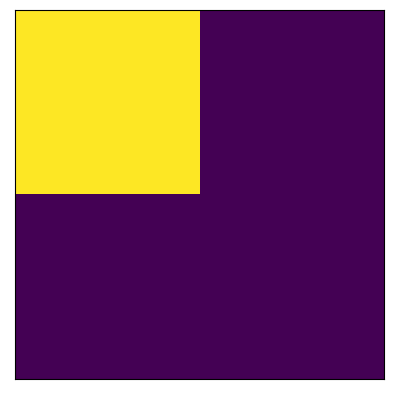

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


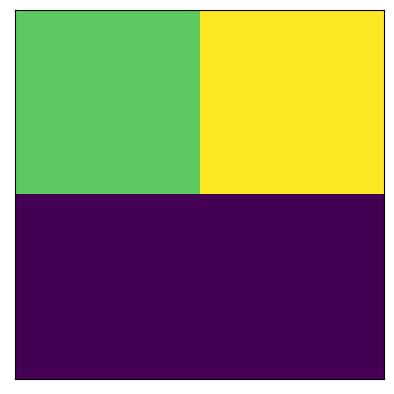

tf.Tensor(
[[0.5625 0.75  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


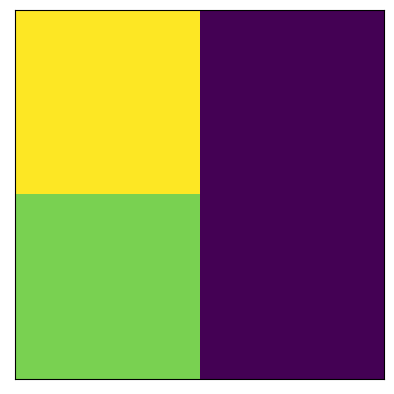

tf.Tensor(
[[0.3125 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


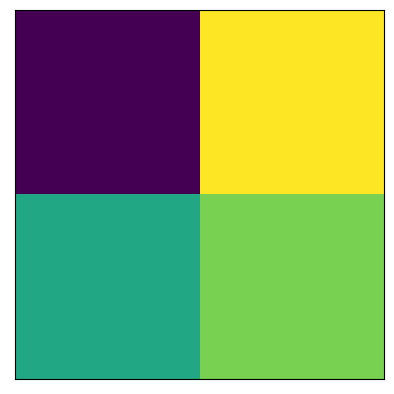

tf.Tensor(
[[0.   1.25]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


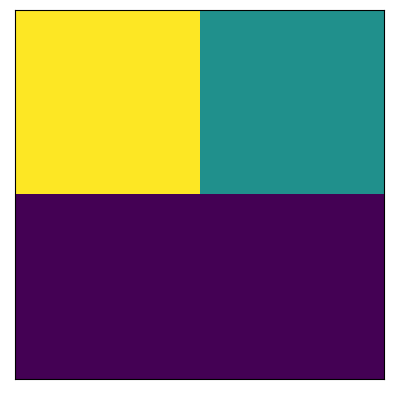

tf.Tensor(
[[2. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


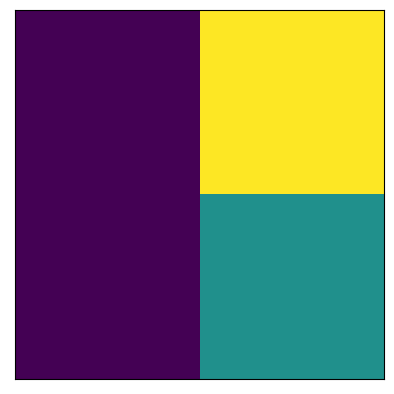

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


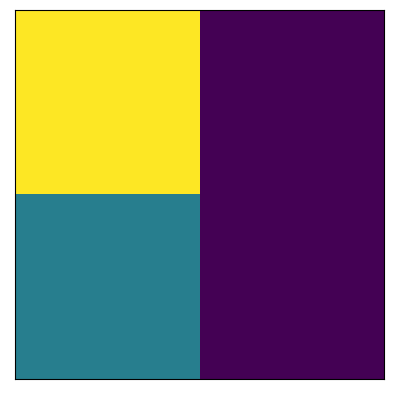

tf.Tensor(
[[7. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


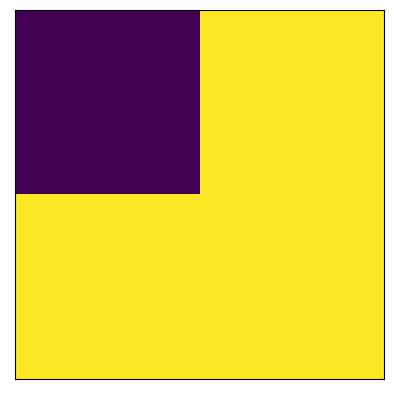

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


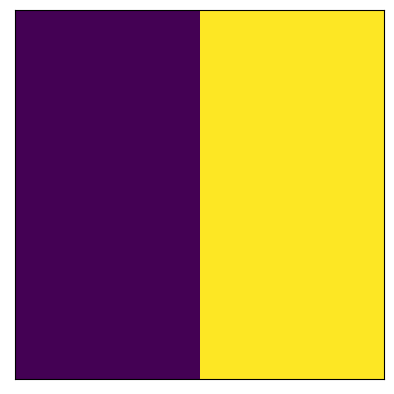

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


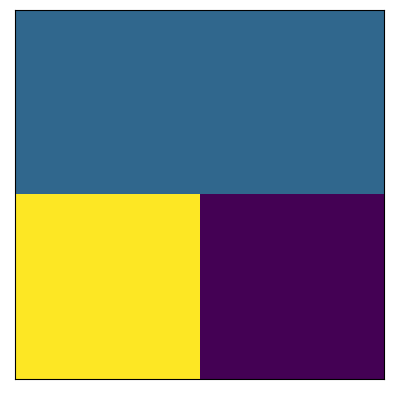

tf.Tensor(
[[1. 1.]
 [3. 0.]], shape=(2, 2), dtype=float32)


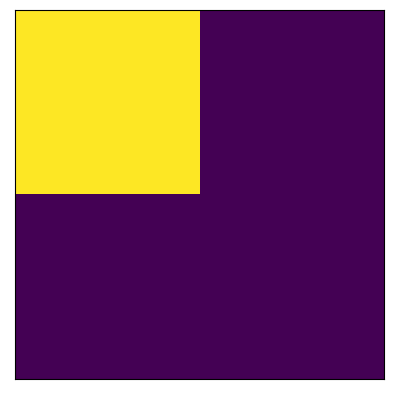

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


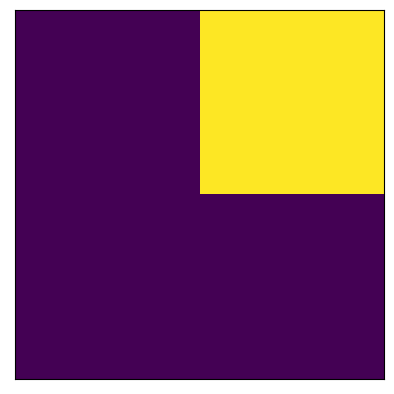

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


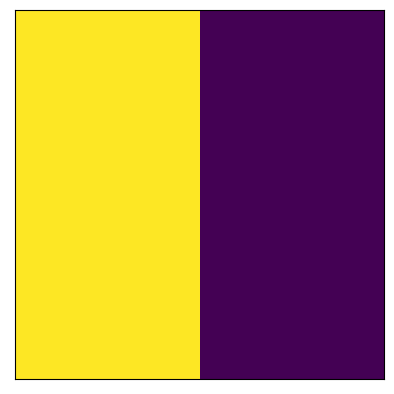

tf.Tensor(
[[3. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


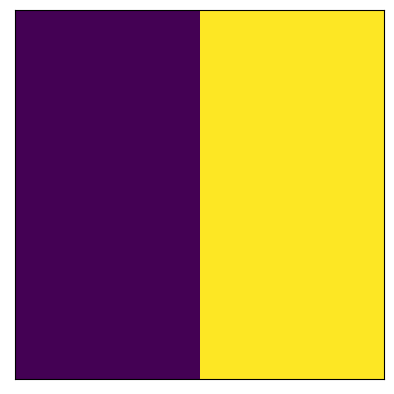

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


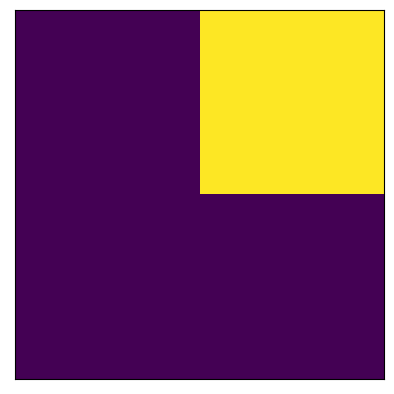

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


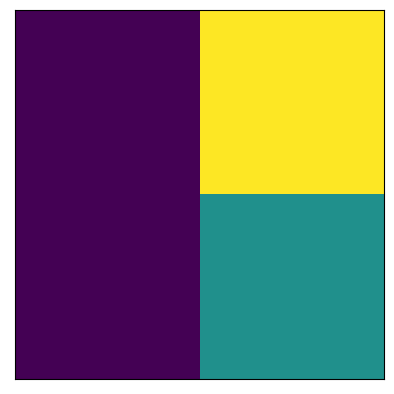

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


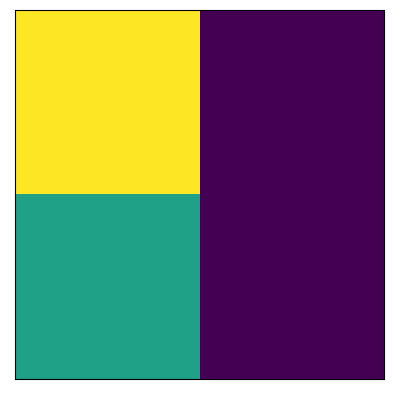

tf.Tensor(
[[7. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


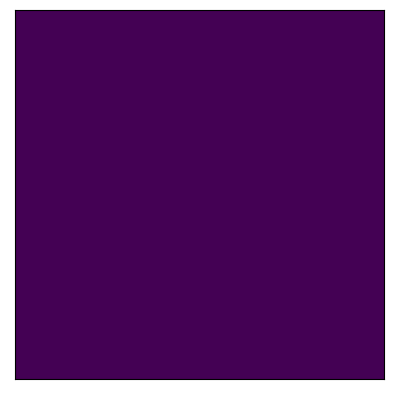

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


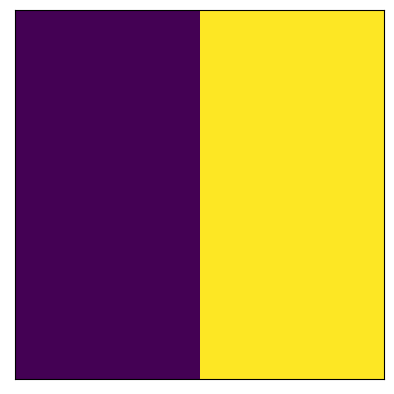

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


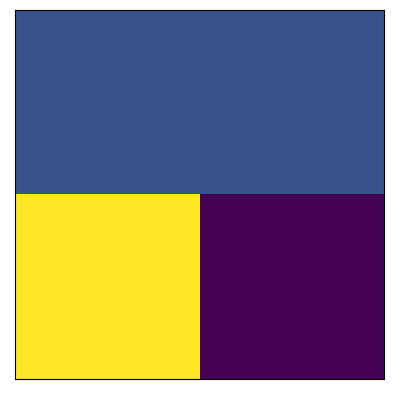

tf.Tensor(
[[1. 1.]
 [4. 0.]], shape=(2, 2), dtype=float32)


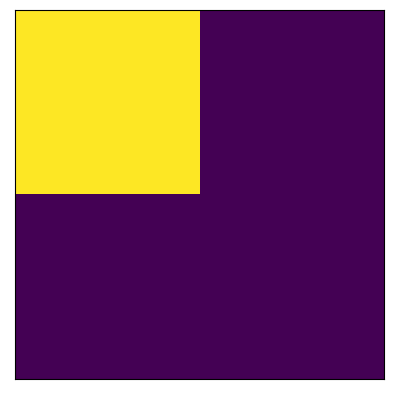

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


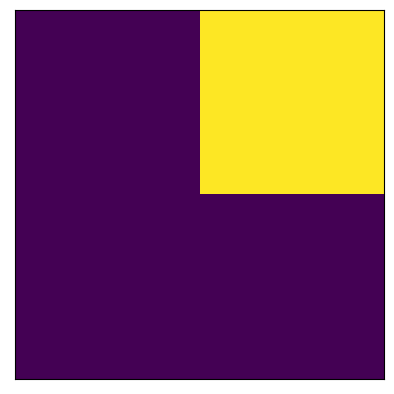

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


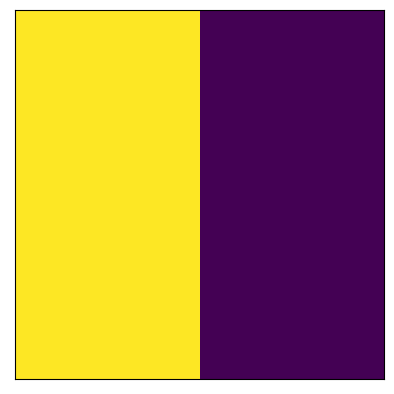

tf.Tensor(
[[4. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


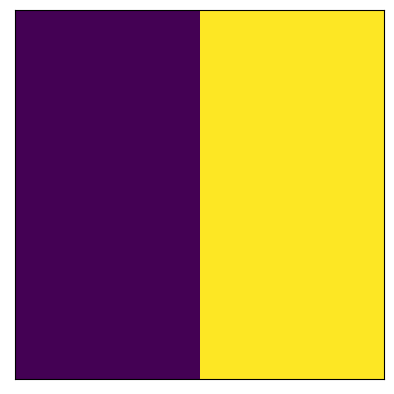

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


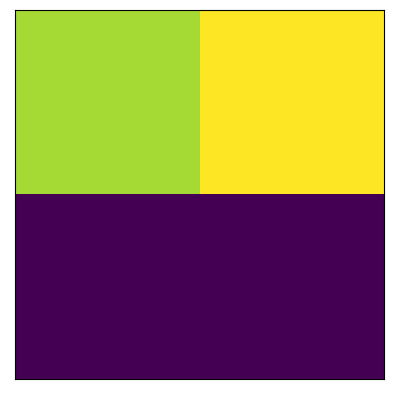

tf.Tensor(
[[1.4444444 1.6666666]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


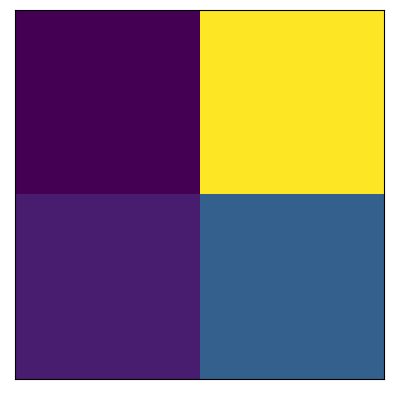

tf.Tensor(
[[0.5555555 2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


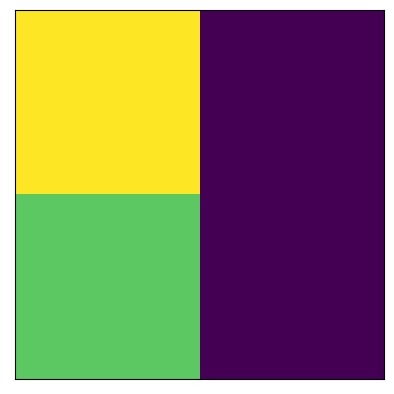

tf.Tensor(
[[0.44444448 0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


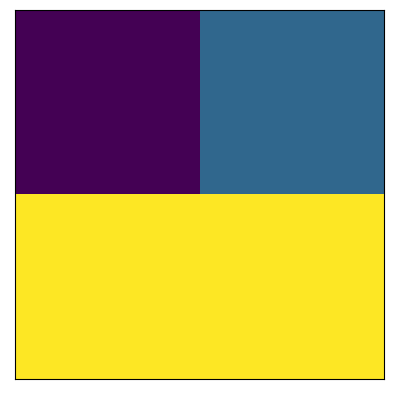

tf.Tensor(
[[0.         0.33333337]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


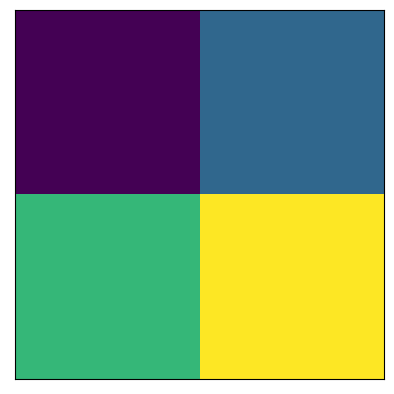

tf.Tensor(
[[0.         0.33333337]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


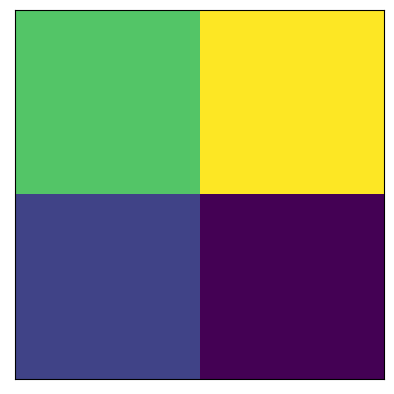

tf.Tensor(
[[1.2222221  1.6666666 ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


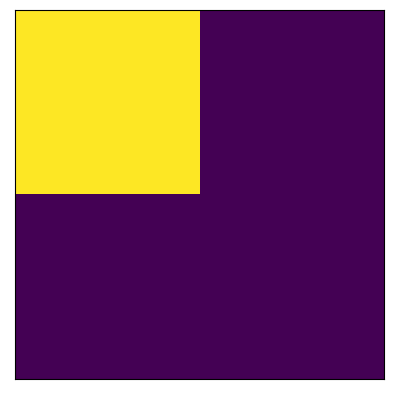

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


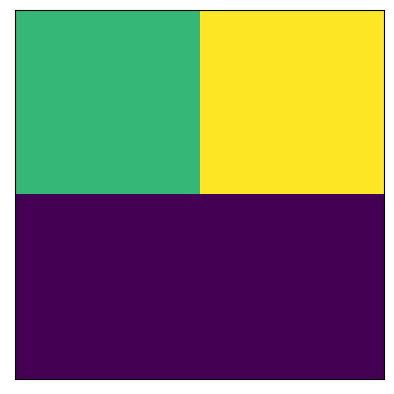

tf.Tensor(
[[1.111111  1.6666666]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


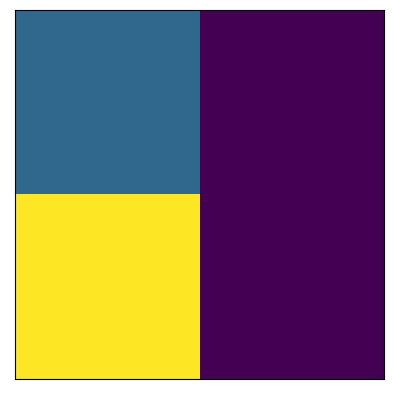

tf.Tensor(
[[0.1111111  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


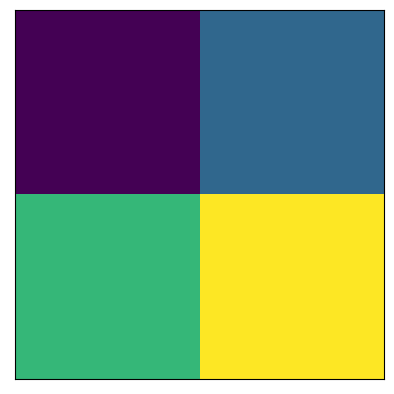

tf.Tensor(
[[0.         0.33333337]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


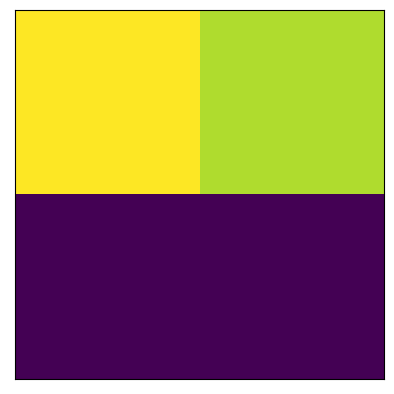

tf.Tensor(
[[0.68 0.6 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


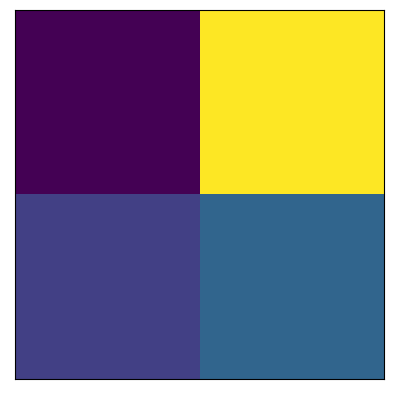

tf.Tensor(
[[0.52000004 2.        ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


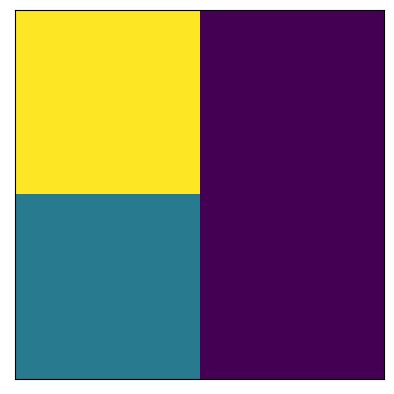

tf.Tensor(
[[0.48000002 0.        ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


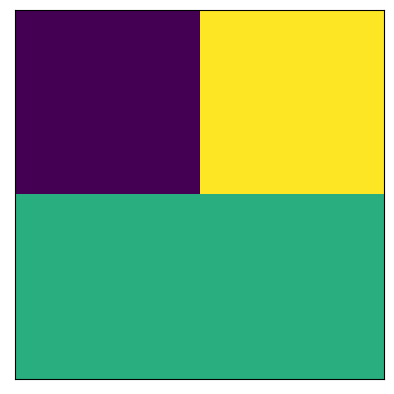

tf.Tensor(
[[0.32 1.4 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


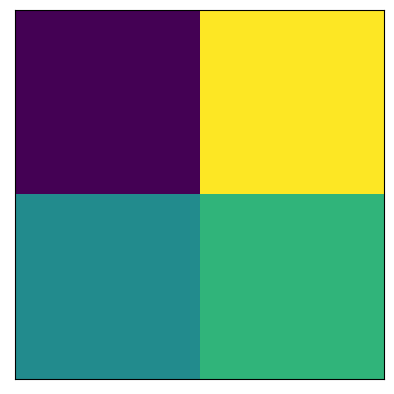

tf.Tensor(
[[0.24 1.4 ]
 [0.8  1.  ]], shape=(2, 2), dtype=float32)


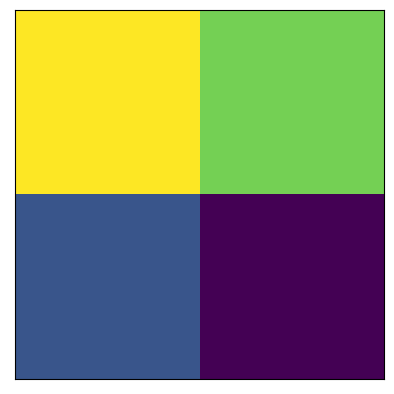

tf.Tensor(
[[0.76 0.6 ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


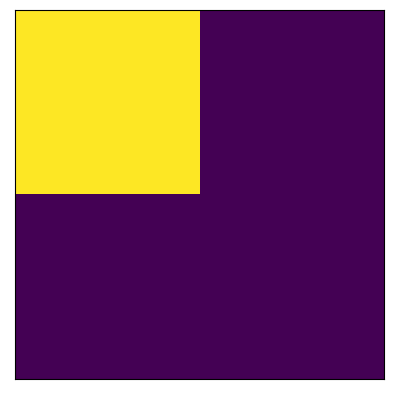

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


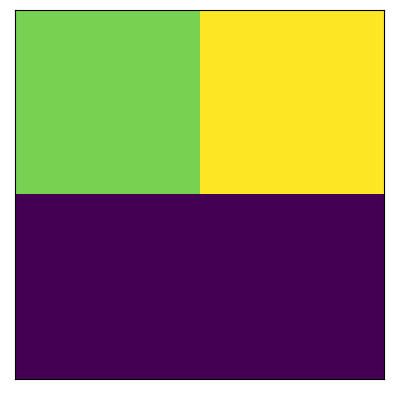

tf.Tensor(
[[0.48000002 0.6       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


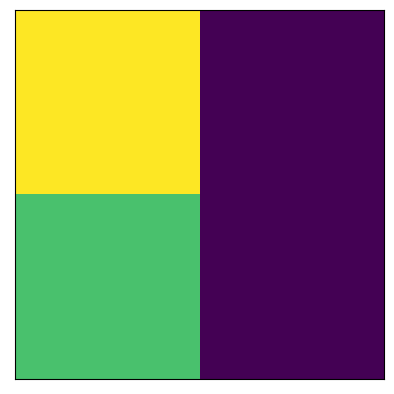

tf.Tensor(
[[0.28 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


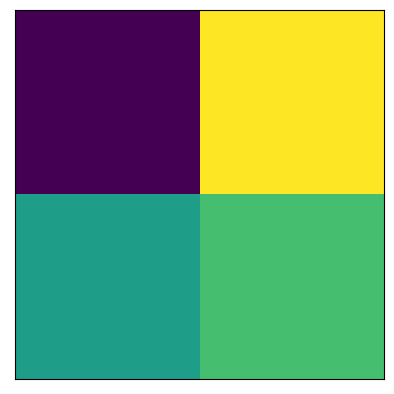

tf.Tensor(
[[0.04 1.4 ]
 [0.8  1.  ]], shape=(2, 2), dtype=float32)


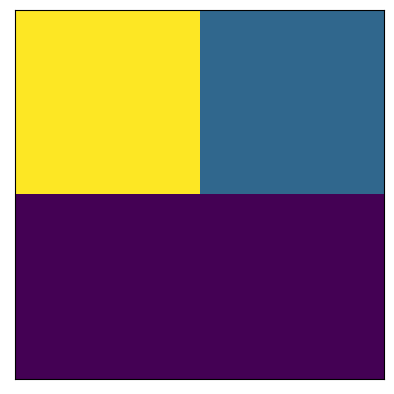

tf.Tensor(
[[3. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


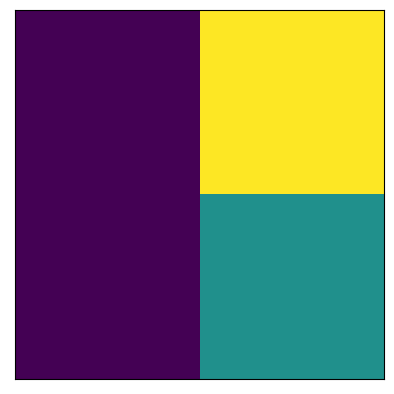

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


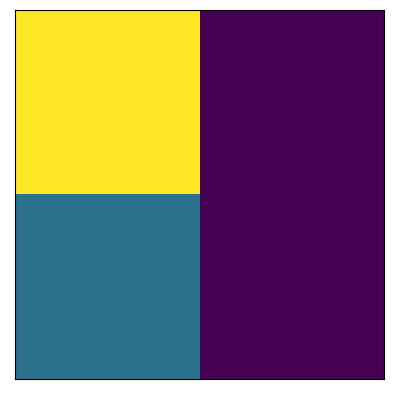

tf.Tensor(
[[8. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


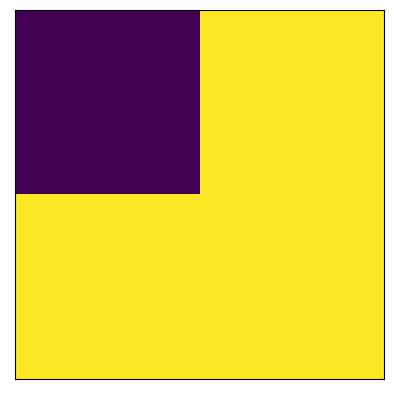

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


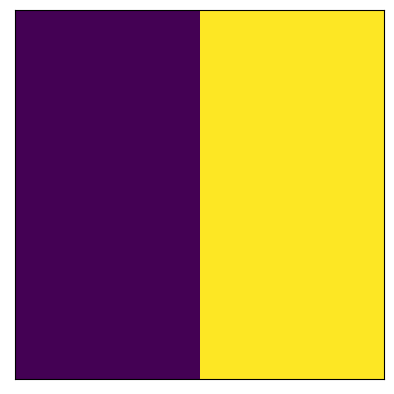

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


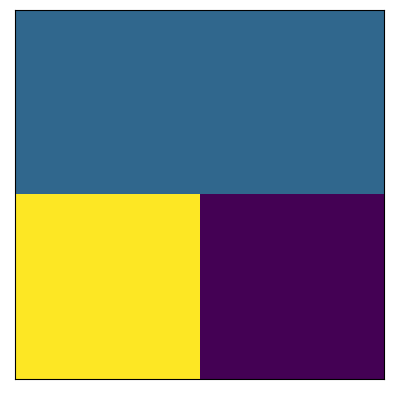

tf.Tensor(
[[1. 1.]
 [3. 0.]], shape=(2, 2), dtype=float32)


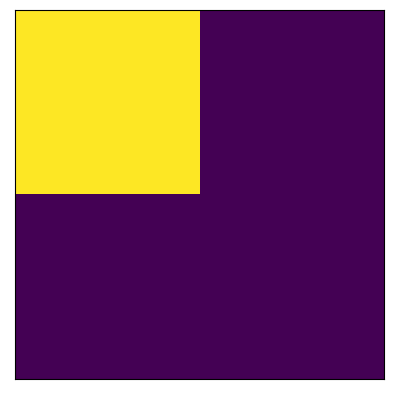

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


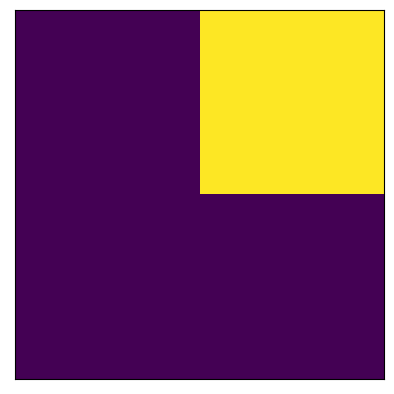

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


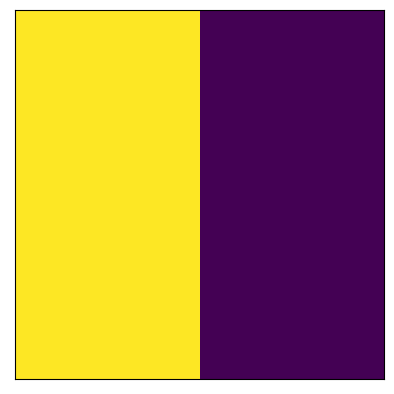

tf.Tensor(
[[3. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


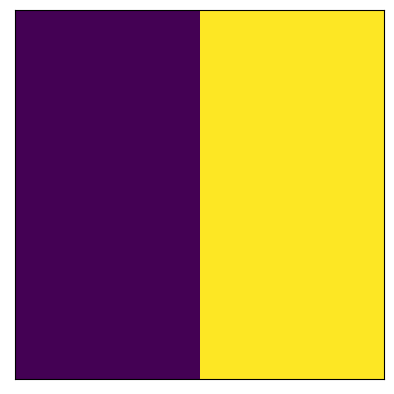

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


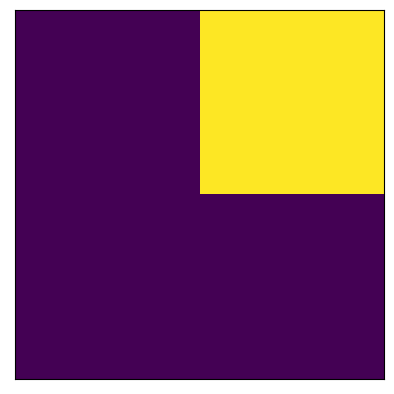

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


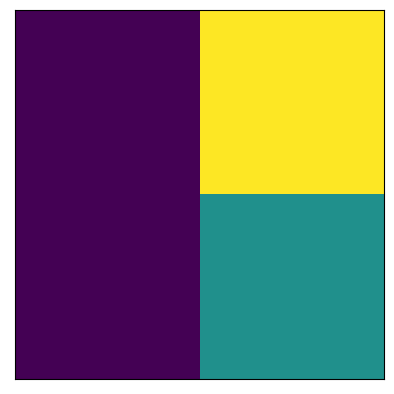

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


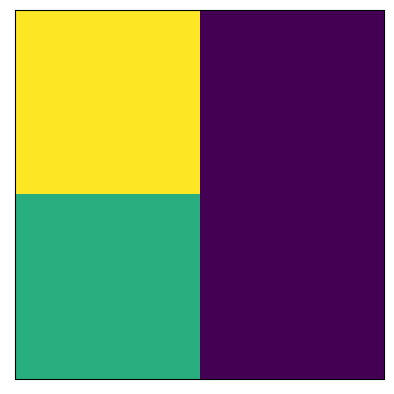

tf.Tensor(
[[8. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


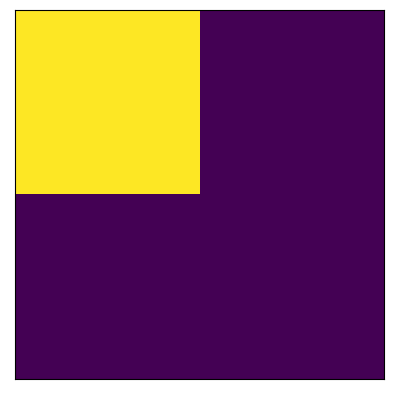

tf.Tensor(
[[2. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


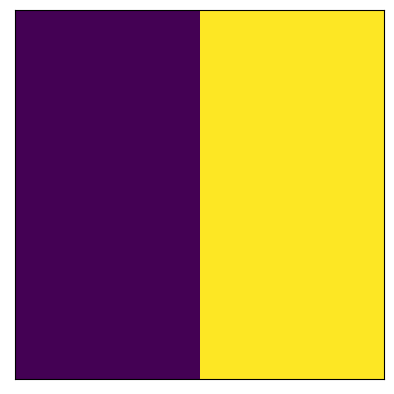

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


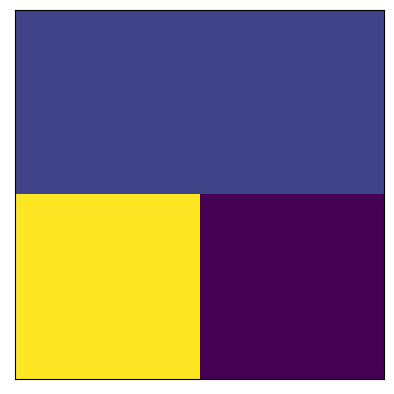

tf.Tensor(
[[1. 1.]
 [5. 0.]], shape=(2, 2), dtype=float32)


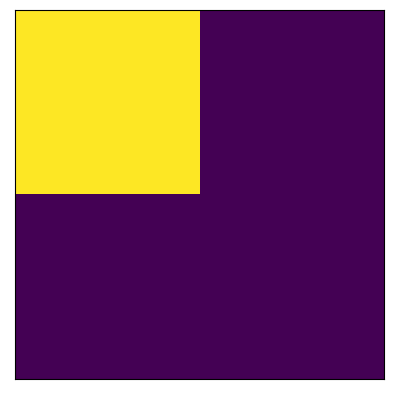

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


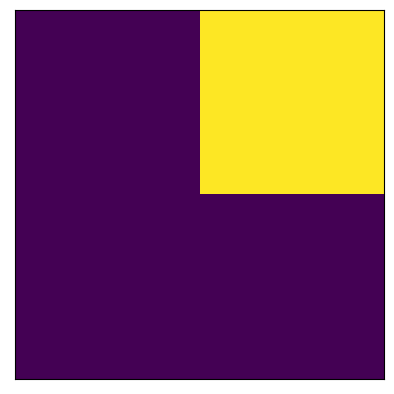

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


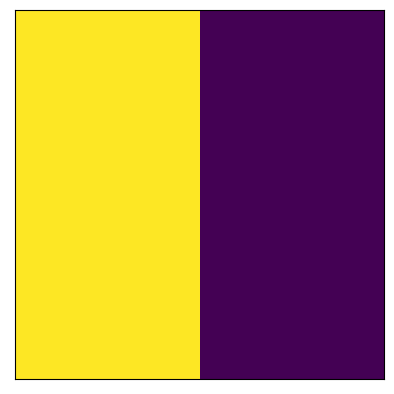

tf.Tensor(
[[5. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


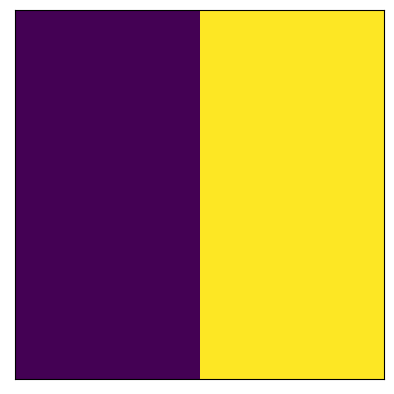

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


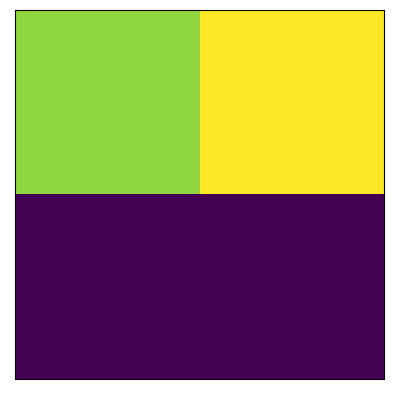

tf.Tensor(
[[1.6666666 2.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


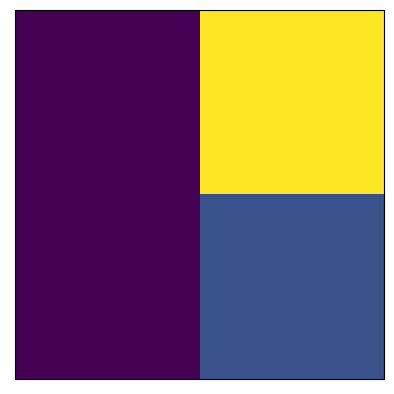

tf.Tensor(
[[0.6666666 2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


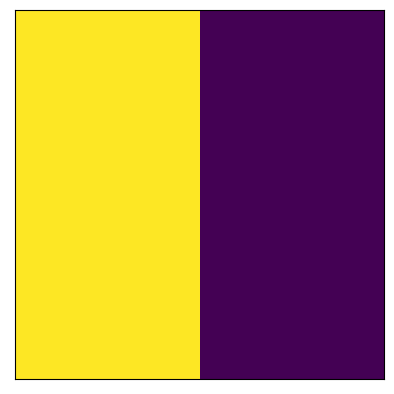

tf.Tensor(
[[0.33333334 0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


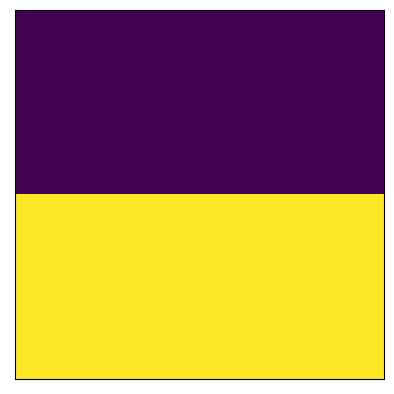

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


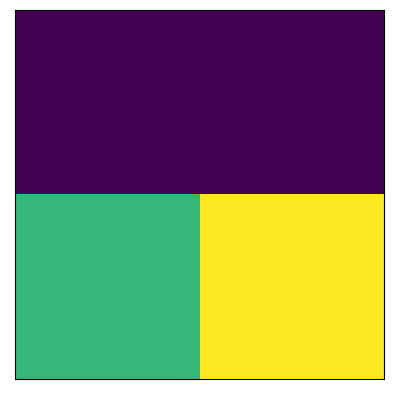

tf.Tensor(
[[0.        0.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


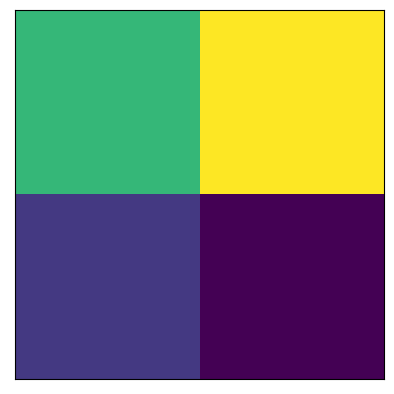

tf.Tensor(
[[1.3333334  2.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


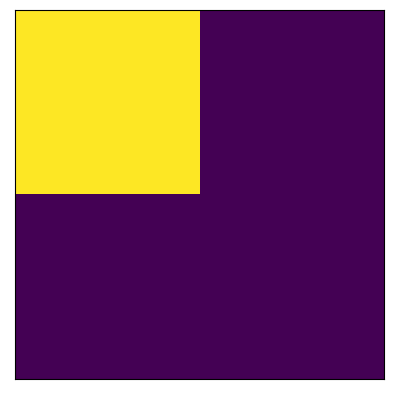

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


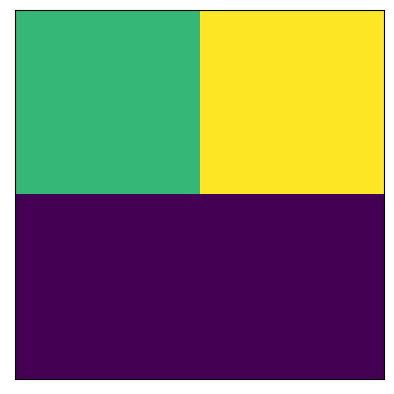

tf.Tensor(
[[1.3333333 2.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


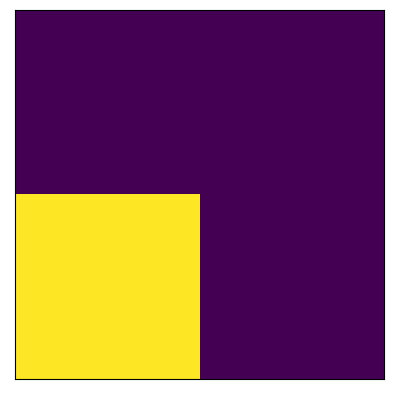

tf.Tensor(
[[0.         0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


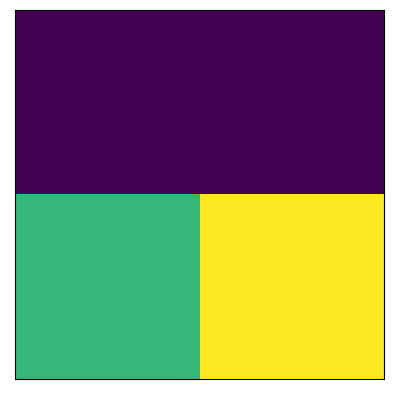

tf.Tensor(
[[0.        0.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


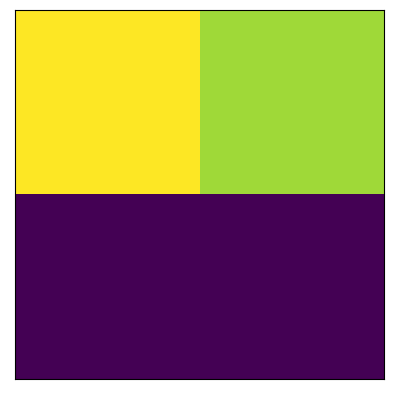

tf.Tensor(
[[0.5833333 0.5      ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


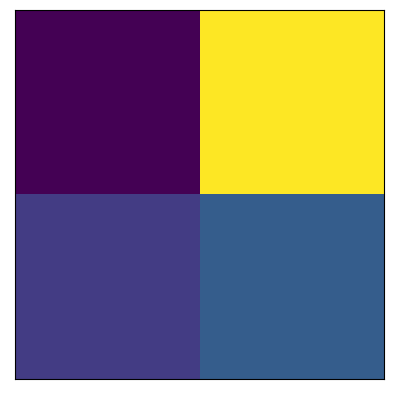

tf.Tensor(
[[0.5833333 2.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


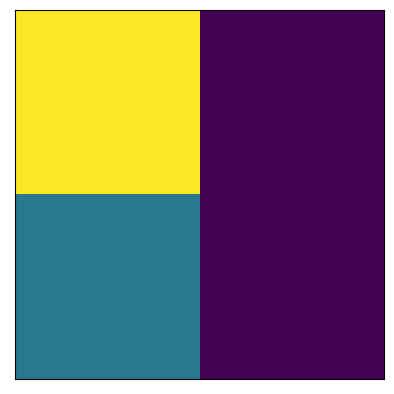

tf.Tensor(
[[0.4166667  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


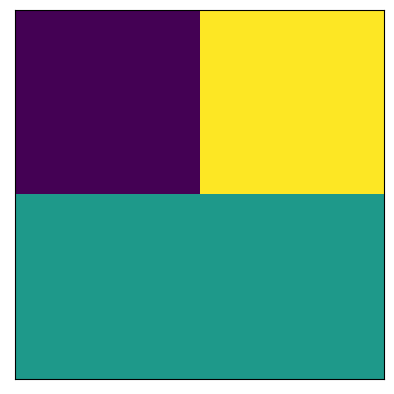

tf.Tensor(
[[0.41666666 1.5       ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


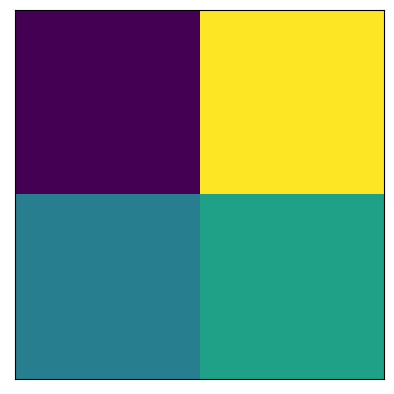

tf.Tensor(
[[0.3333333 1.5      ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


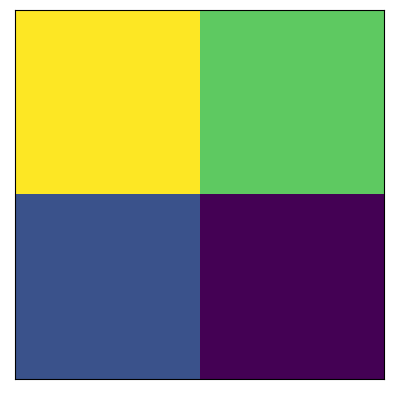

tf.Tensor(
[[0.6666667  0.5       ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


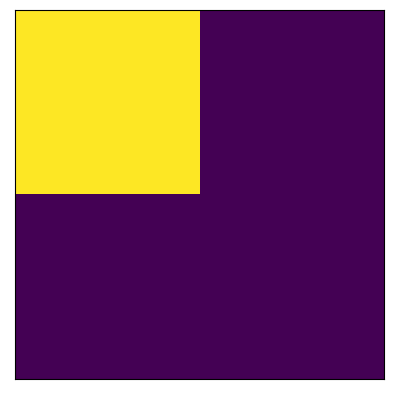

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


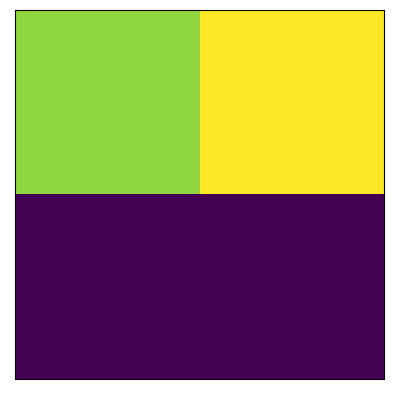

tf.Tensor(
[[0.41666666 0.5       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


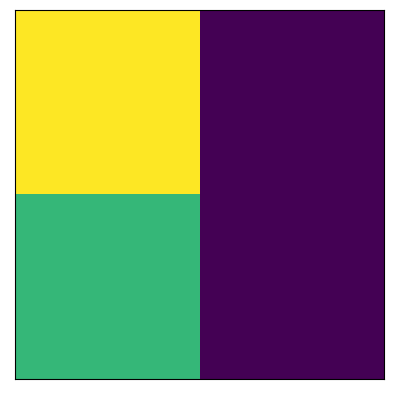

tf.Tensor(
[[0.25       0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


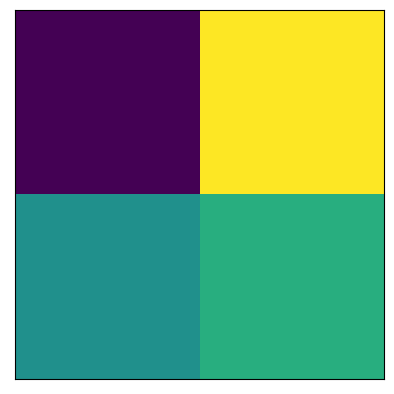

tf.Tensor(
[[0.16666663 1.5       ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


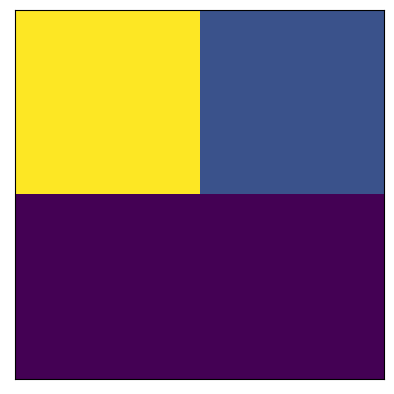

tf.Tensor(
[[4. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


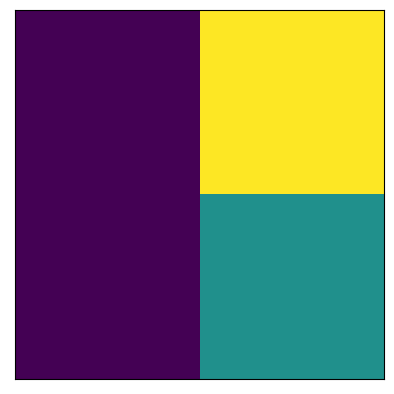

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


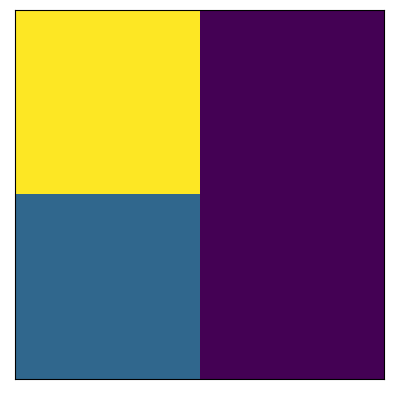

tf.Tensor(
[[9. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


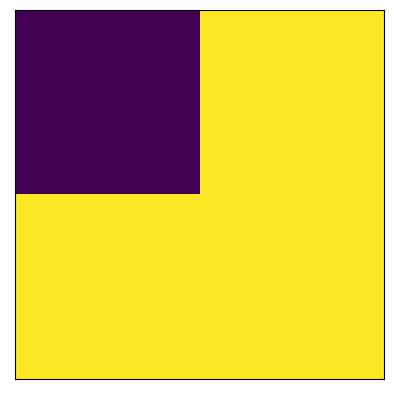

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


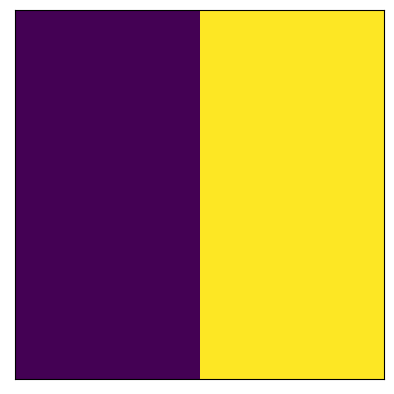

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


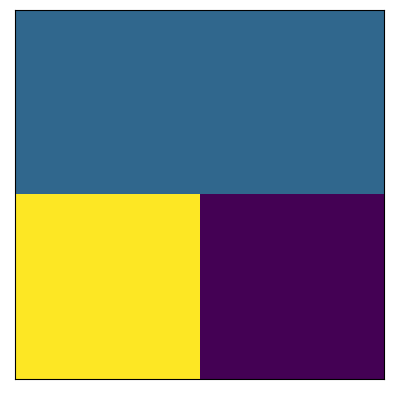

tf.Tensor(
[[1. 1.]
 [3. 0.]], shape=(2, 2), dtype=float32)


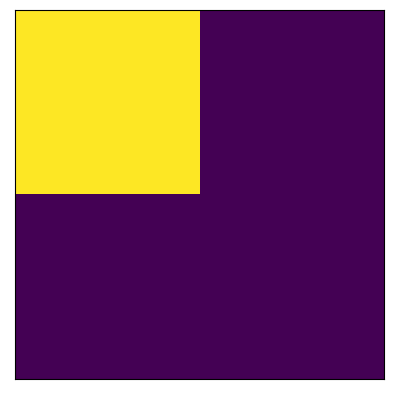

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


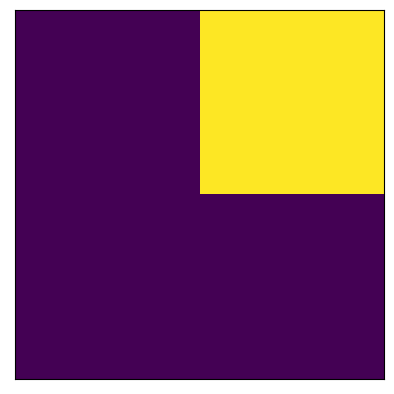

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


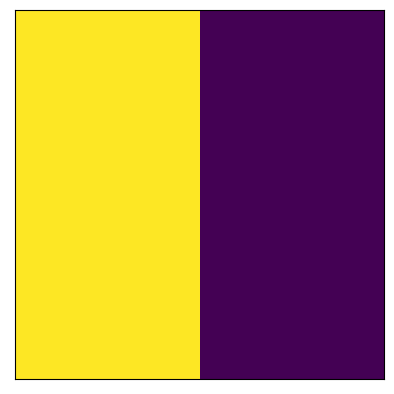

tf.Tensor(
[[3. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


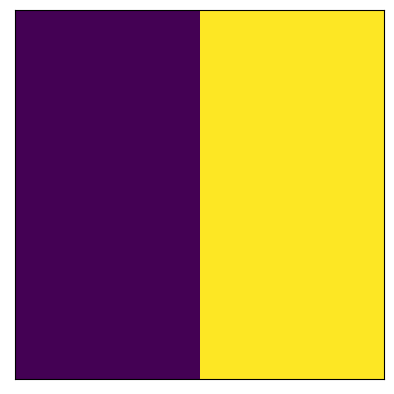

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


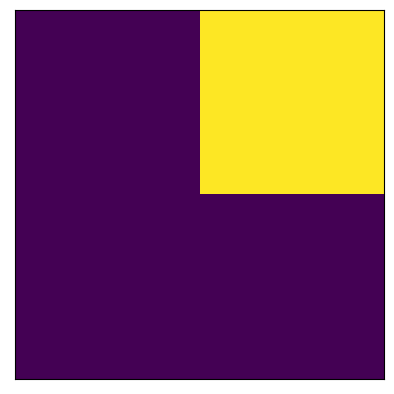

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


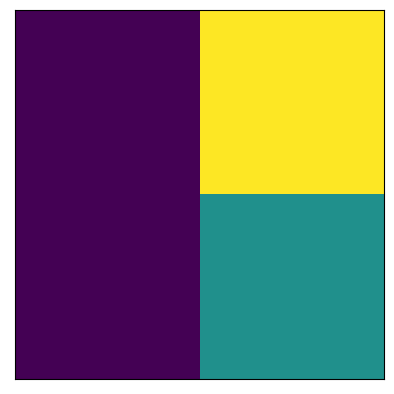

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


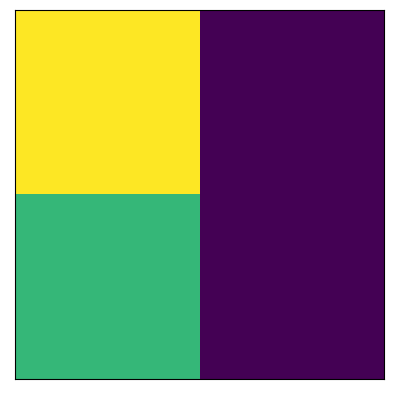

tf.Tensor(
[[9. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


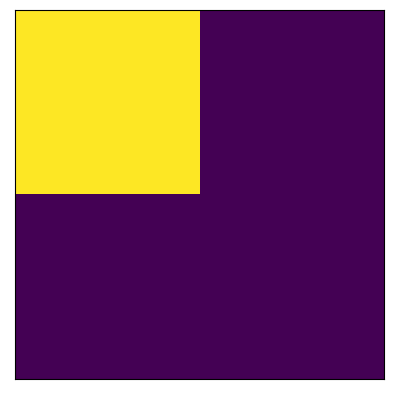

tf.Tensor(
[[3. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


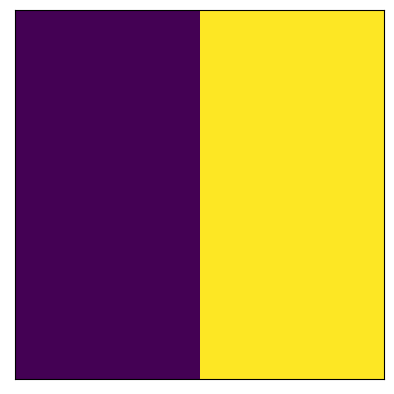

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


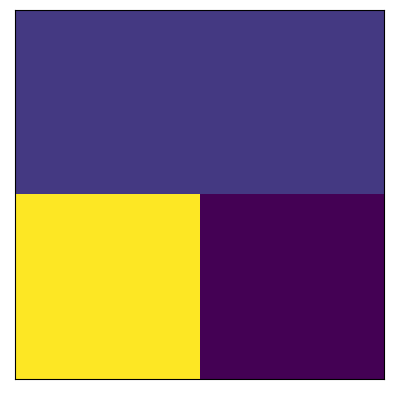

tf.Tensor(
[[1. 1.]
 [6. 0.]], shape=(2, 2), dtype=float32)


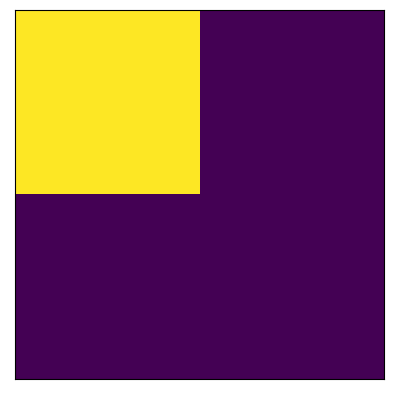

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


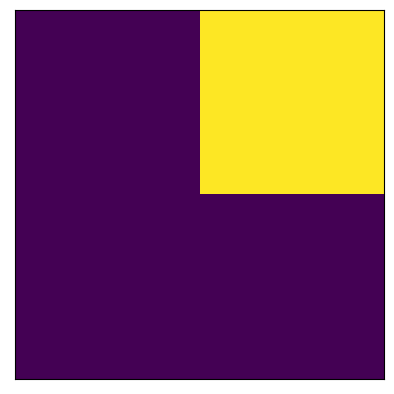

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


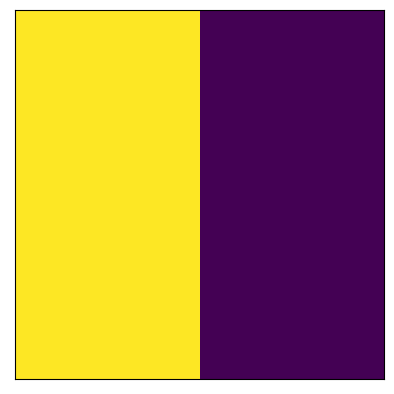

tf.Tensor(
[[6. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


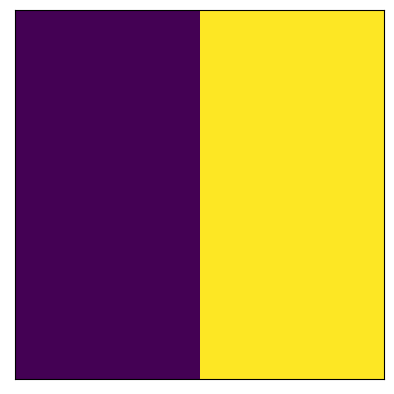

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


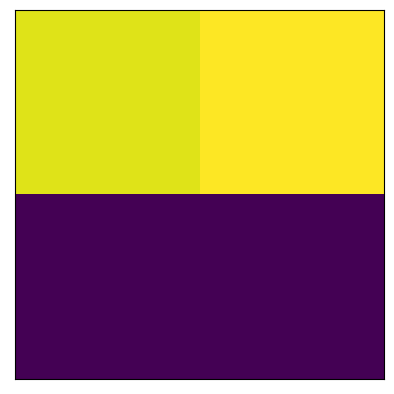

tf.Tensor(
[[1.1875 1.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


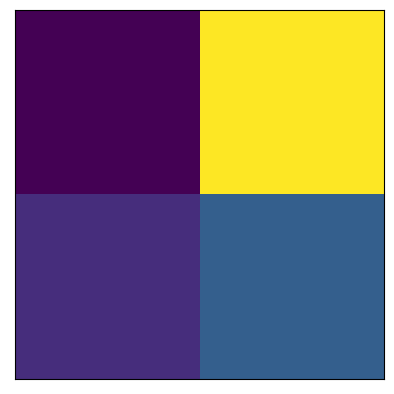

tf.Tensor(
[[0.5625 2.    ]
 [0.75   1.    ]], shape=(2, 2), dtype=float32)


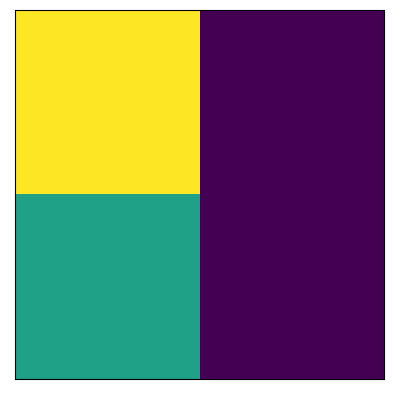

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


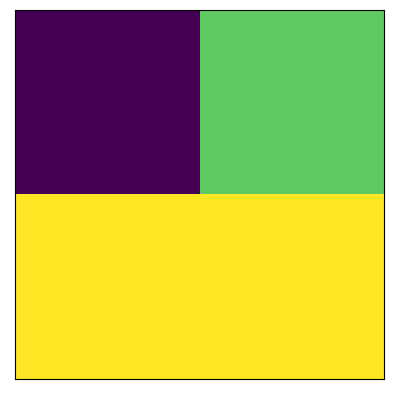

tf.Tensor(
[[0.   0.75]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


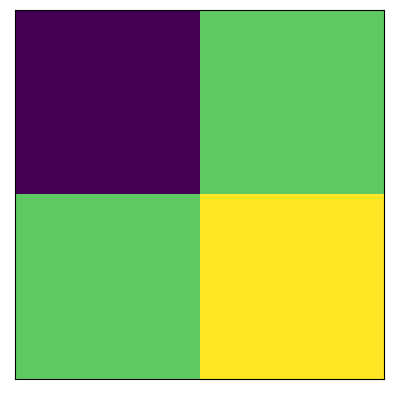

tf.Tensor(
[[0.   0.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


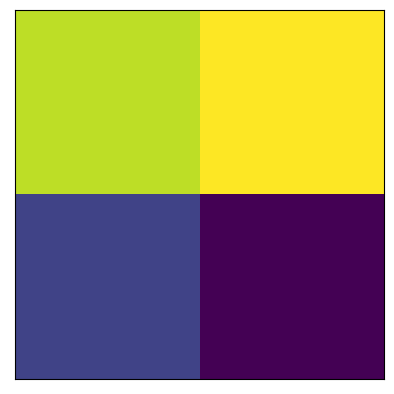

tf.Tensor(
[[1.125 1.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


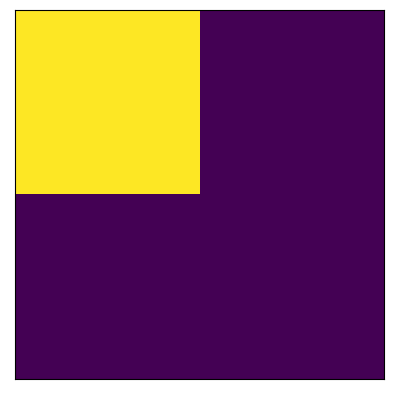

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


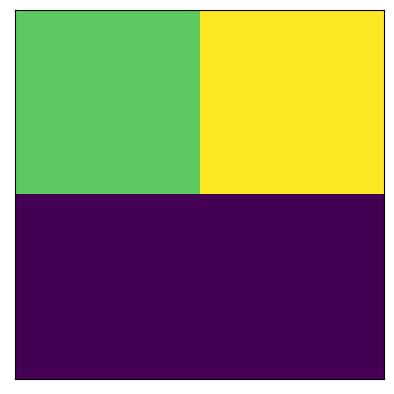

tf.Tensor(
[[0.9375 1.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


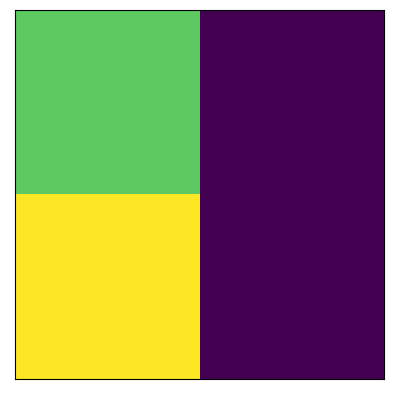

tf.Tensor(
[[0.1875 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


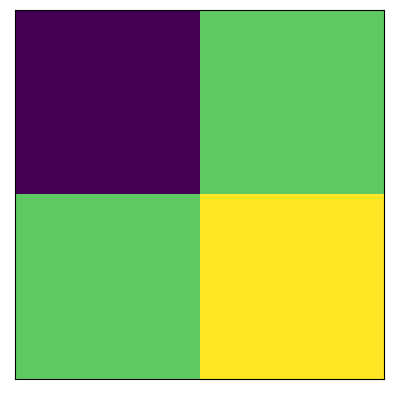

tf.Tensor(
[[0.   0.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


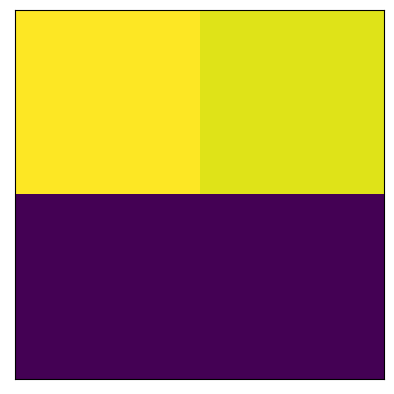

tf.Tensor(
[[0.84000003 0.8       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


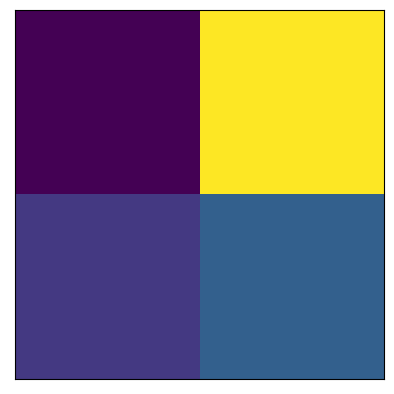

tf.Tensor(
[[0.56 2.  ]
 [0.8  1.  ]], shape=(2, 2), dtype=float32)


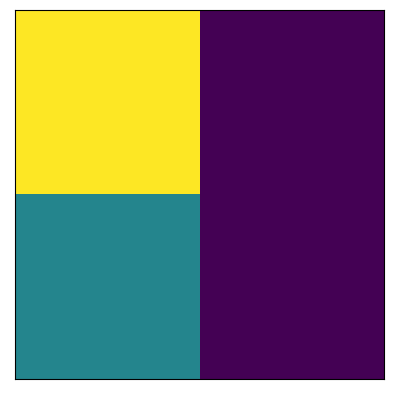

tf.Tensor(
[[0.44 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


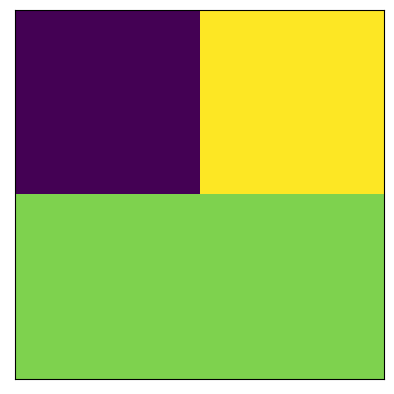

tf.Tensor(
[[0.16 1.2 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


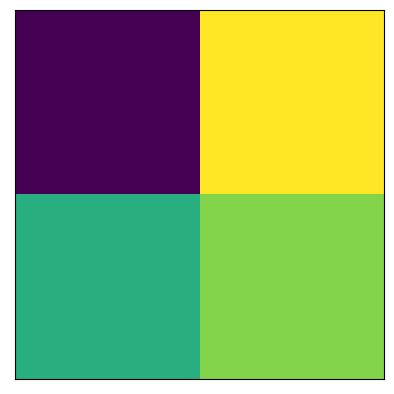

tf.Tensor(
[[0.12 1.2 ]
 [0.8  1.  ]], shape=(2, 2), dtype=float32)


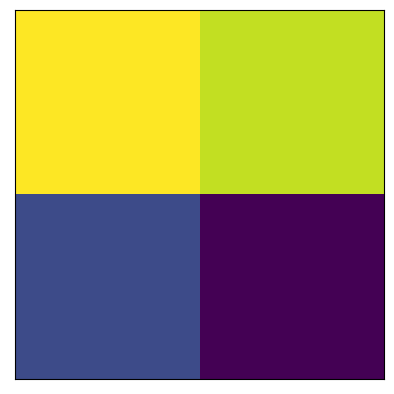

tf.Tensor(
[[0.88000005 0.8       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


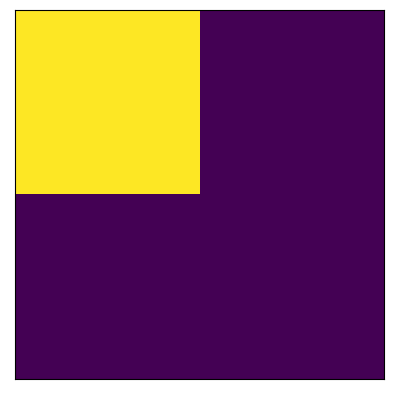

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


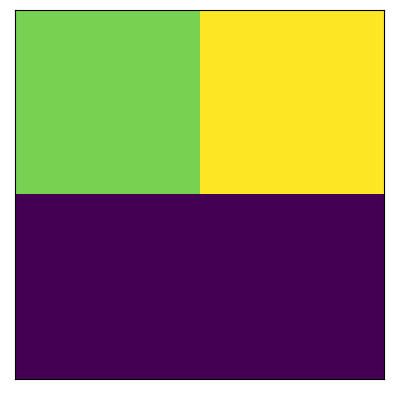

tf.Tensor(
[[0.64 0.8 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


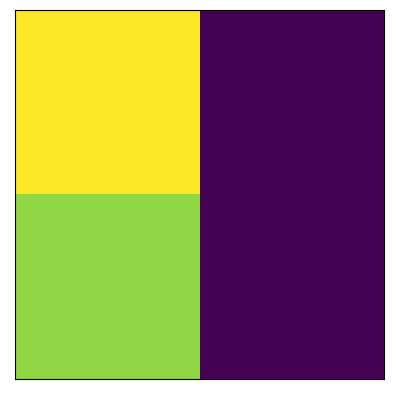

tf.Tensor(
[[0.24000001 0.        ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


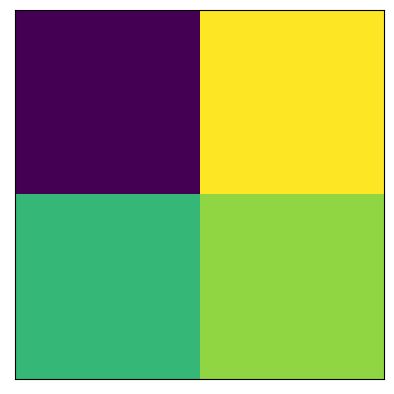

tf.Tensor(
[[0.  1.2]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


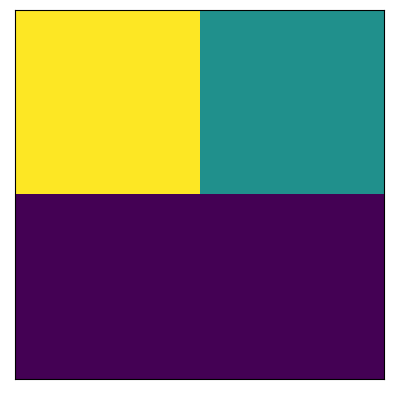

tf.Tensor(
[[2. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


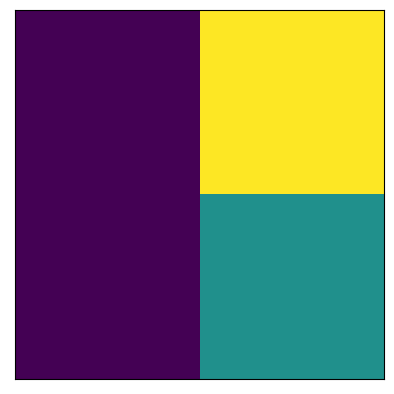

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


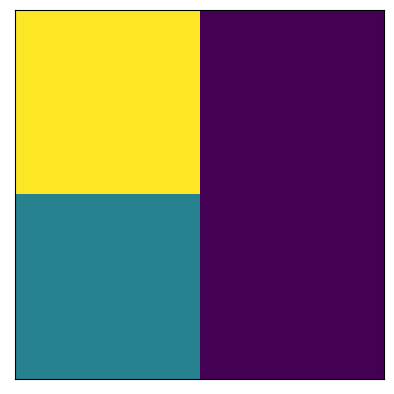

tf.Tensor(
[[9. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


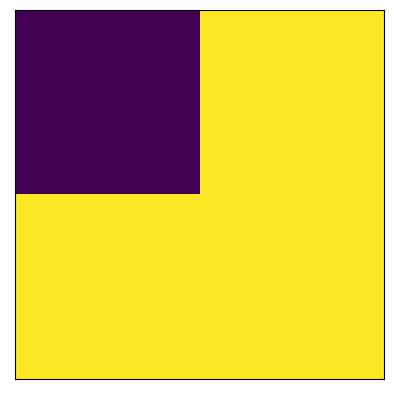

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


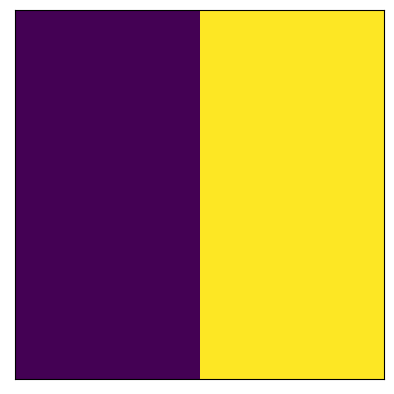

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


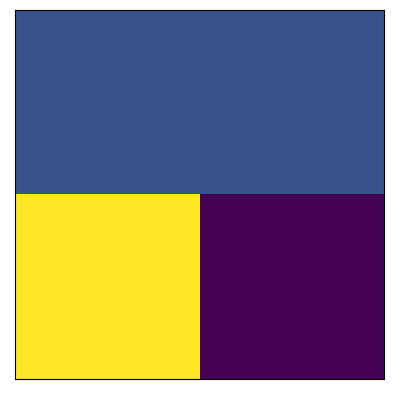

tf.Tensor(
[[1. 1.]
 [4. 0.]], shape=(2, 2), dtype=float32)


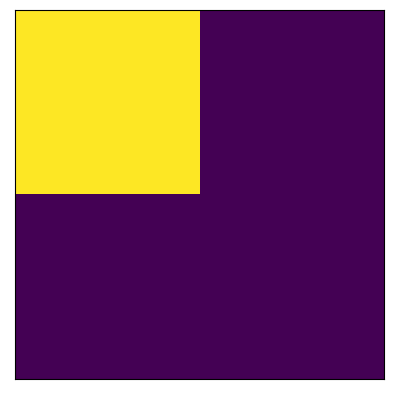

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


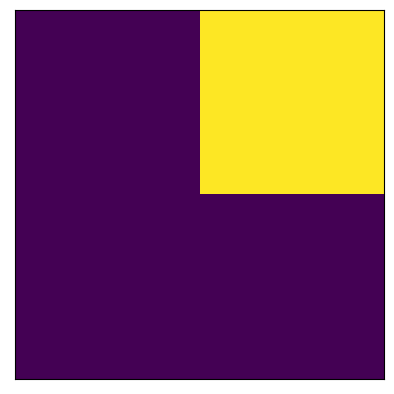

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


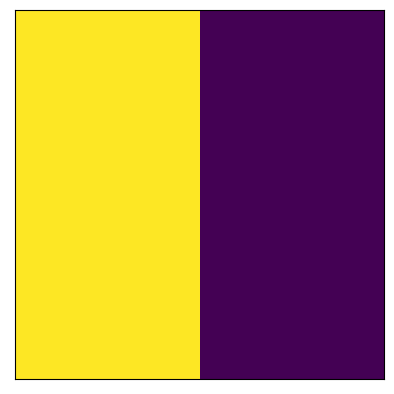

tf.Tensor(
[[4. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


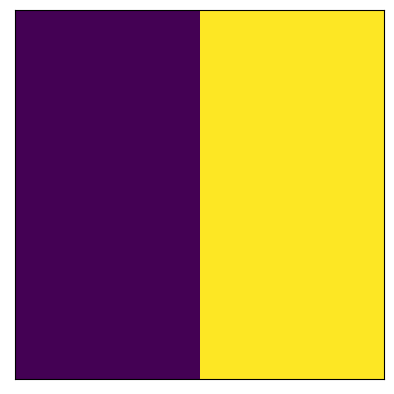

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


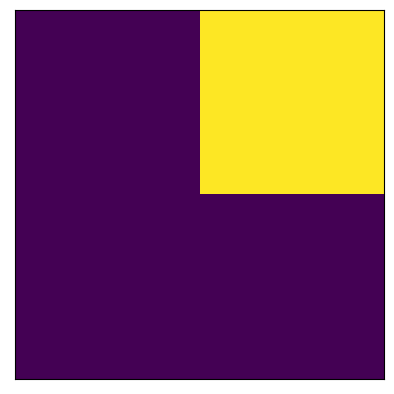

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


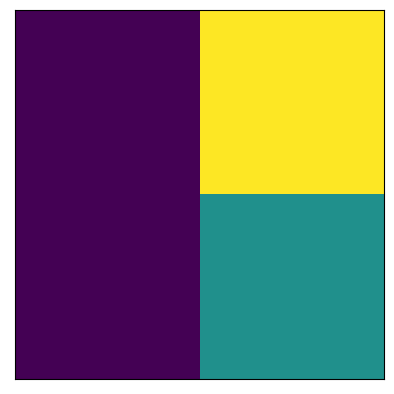

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


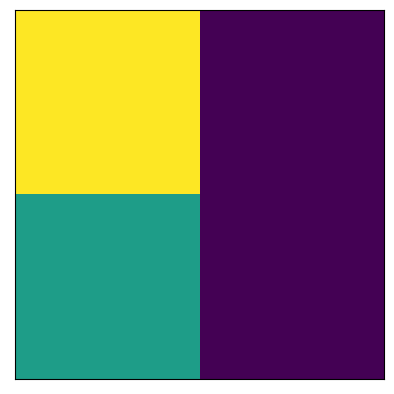

tf.Tensor(
[[9. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


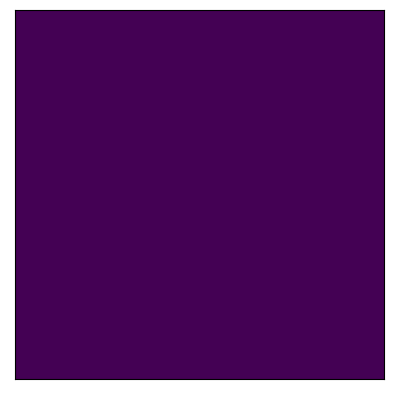

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


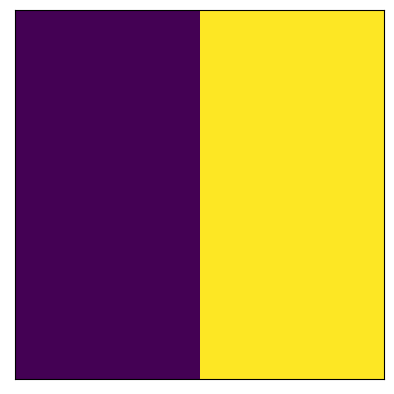

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


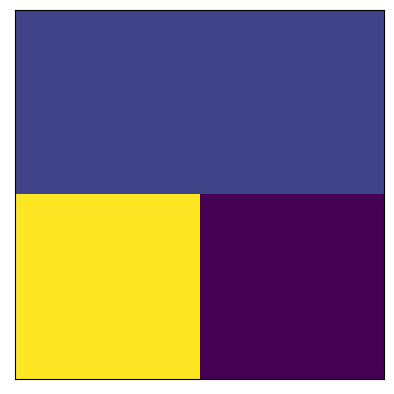

tf.Tensor(
[[1. 1.]
 [5. 0.]], shape=(2, 2), dtype=float32)


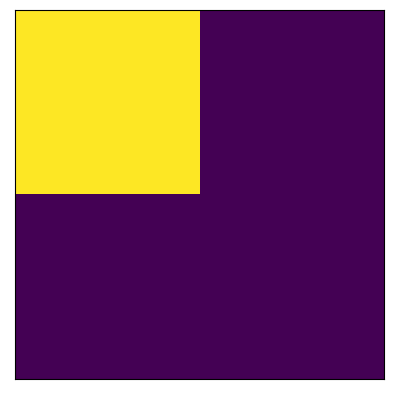

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


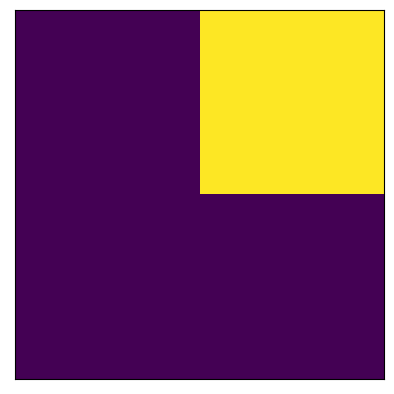

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


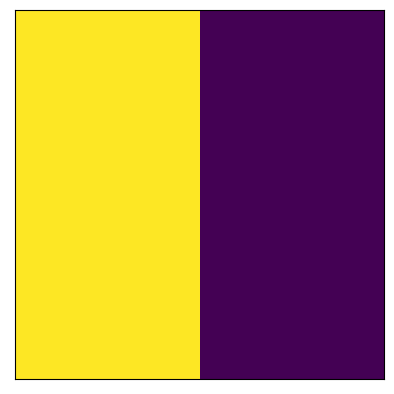

tf.Tensor(
[[5. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


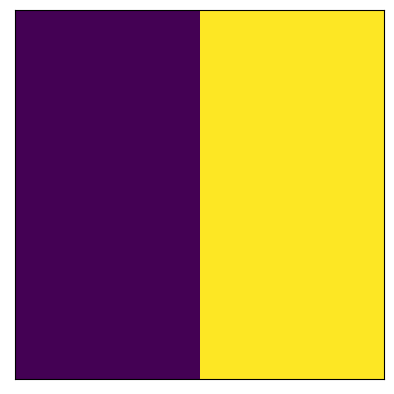

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


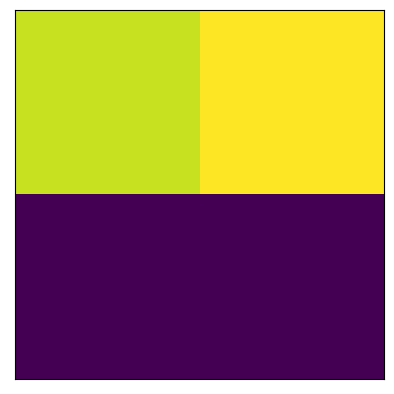

tf.Tensor(
[[1.375 1.5  ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


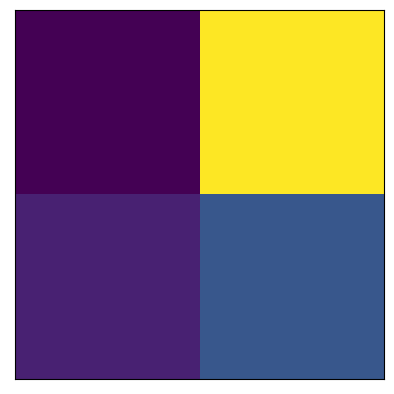

tf.Tensor(
[[0.625 2.   ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


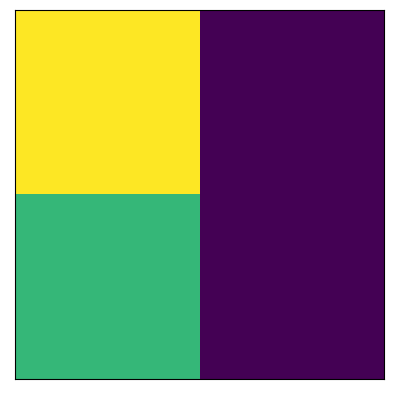

tf.Tensor(
[[0.375 0.   ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


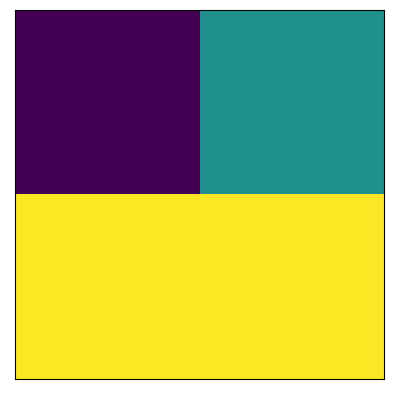

tf.Tensor(
[[0.  0.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


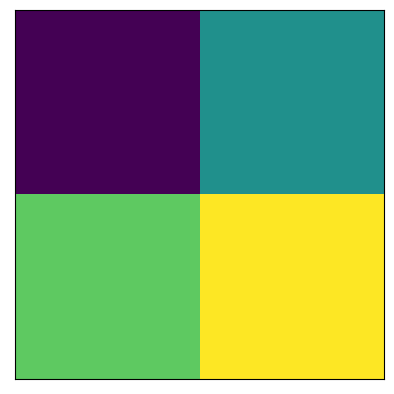

tf.Tensor(
[[0.   0.5 ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


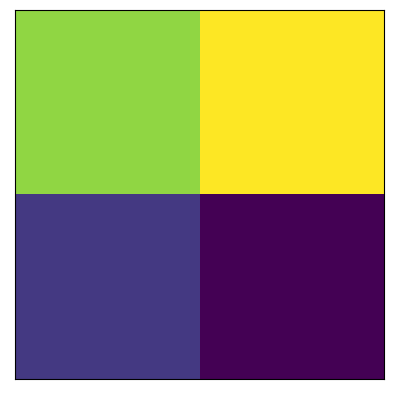

tf.Tensor(
[[1.25 1.5 ]
 [0.25 0.  ]], shape=(2, 2), dtype=float32)


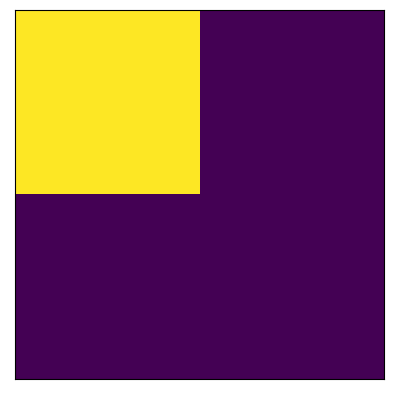

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


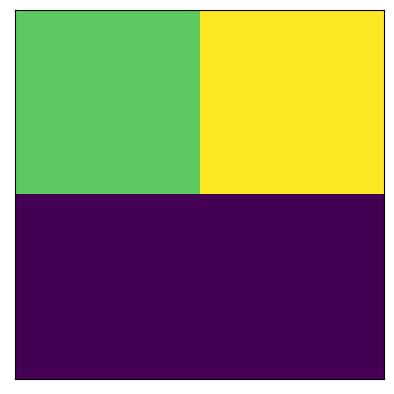

tf.Tensor(
[[1.125 1.5  ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


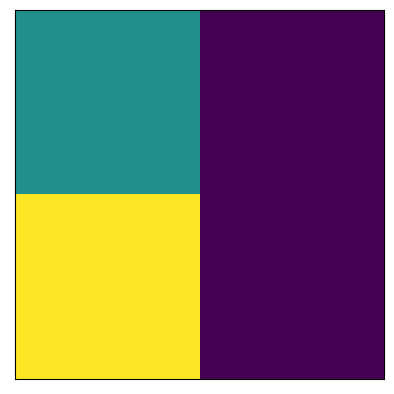

tf.Tensor(
[[0.125 0.   ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


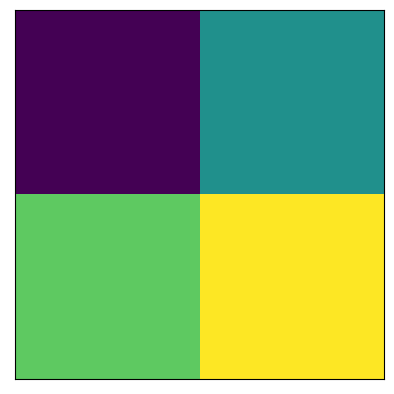

tf.Tensor(
[[0.   0.5 ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


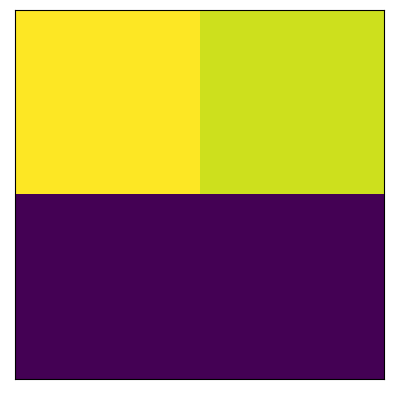

tf.Tensor(
[[0.7222222 0.6666667]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


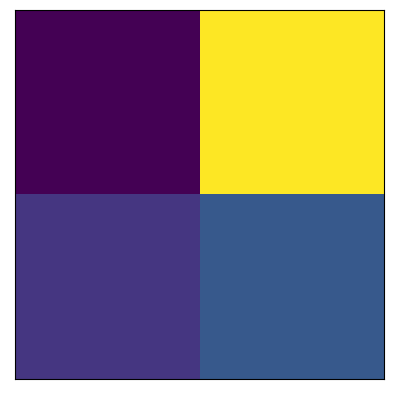

tf.Tensor(
[[0.61111104 2.        ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


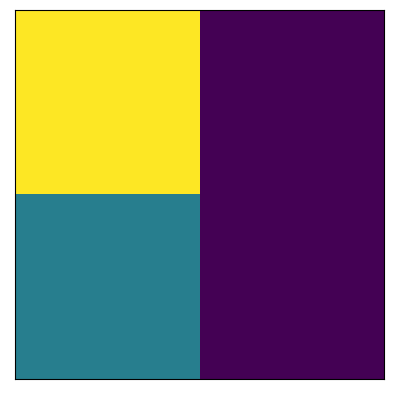

tf.Tensor(
[[0.3888889  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


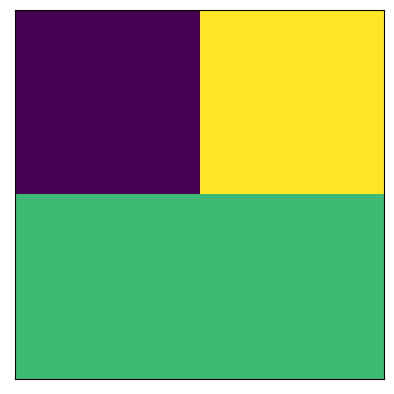

tf.Tensor(
[[0.27777776 1.3333333 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


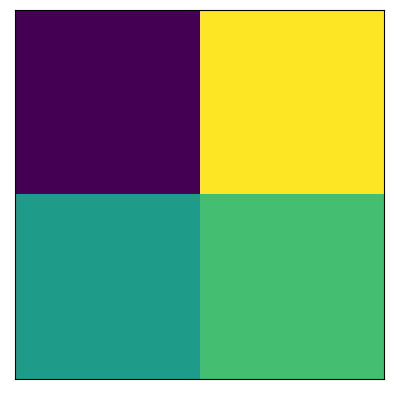

tf.Tensor(
[[0.22222216 1.3333333 ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


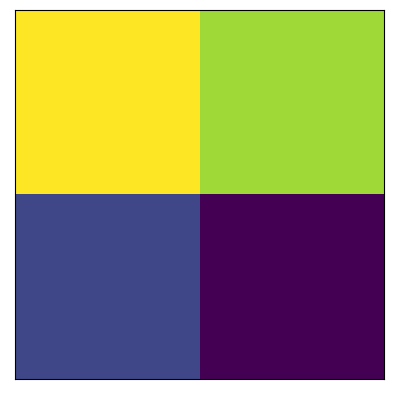

tf.Tensor(
[[0.7777778  0.6666667 ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


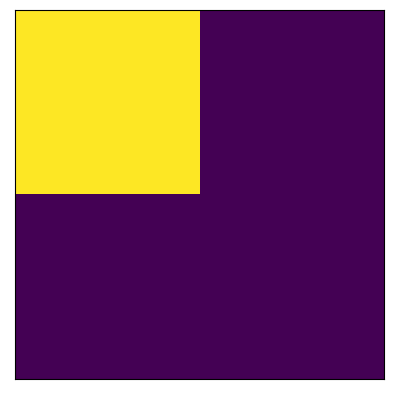

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


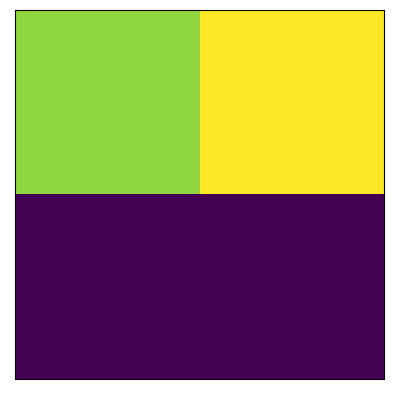

tf.Tensor(
[[0.5555556 0.6666667]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


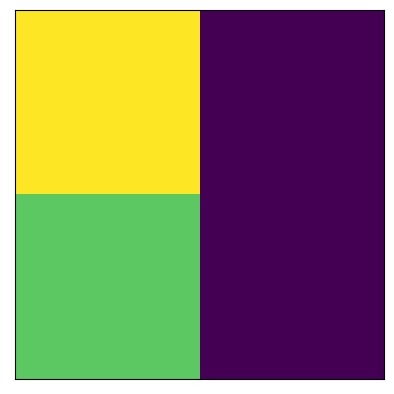

tf.Tensor(
[[0.22222224 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


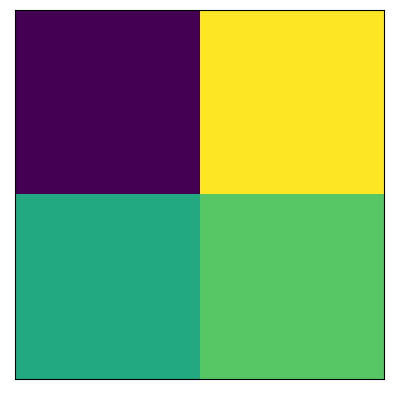

tf.Tensor(
[[0.0555555 1.3333333]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


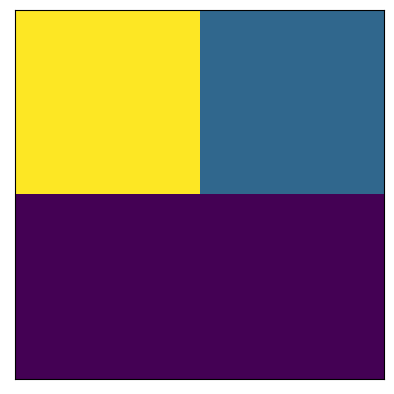

tf.Tensor(
[[3. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


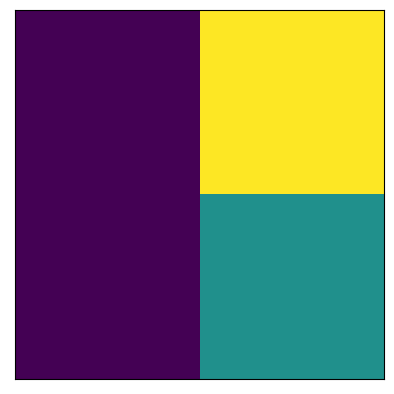

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


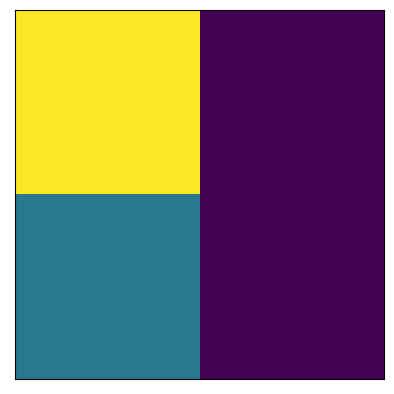

tf.Tensor(
[[10.  0.]
 [ 4.  0.]], shape=(2, 2), dtype=float32)


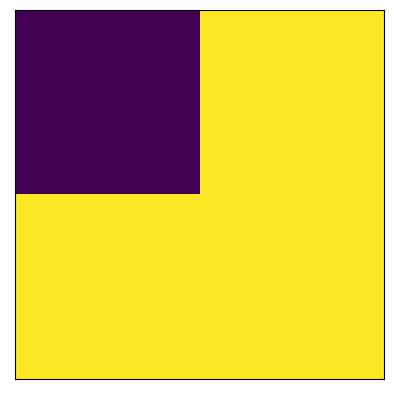

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


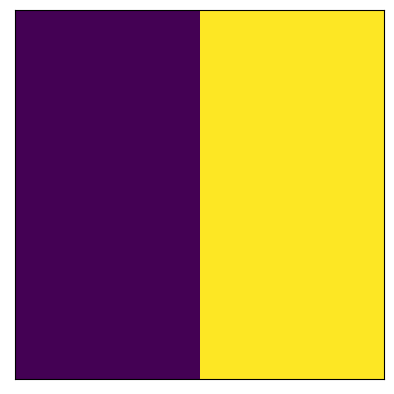

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


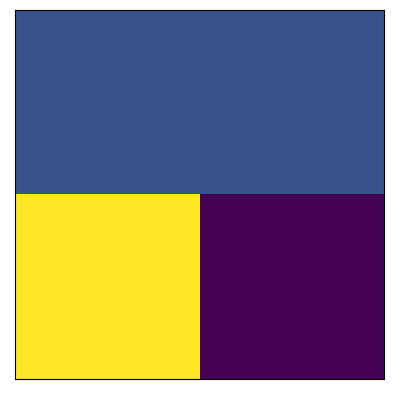

tf.Tensor(
[[1. 1.]
 [4. 0.]], shape=(2, 2), dtype=float32)


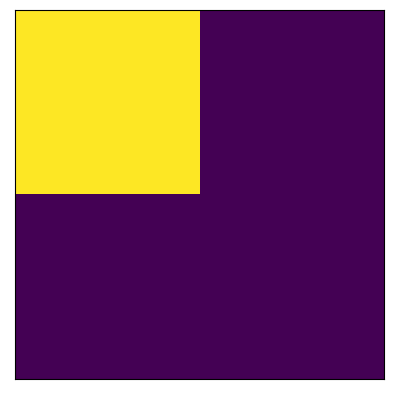

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


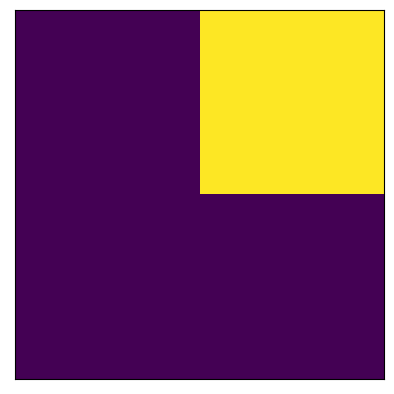

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


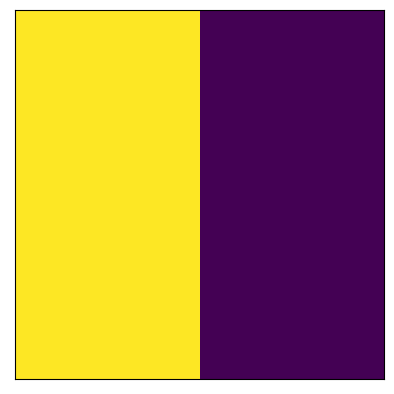

tf.Tensor(
[[4. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


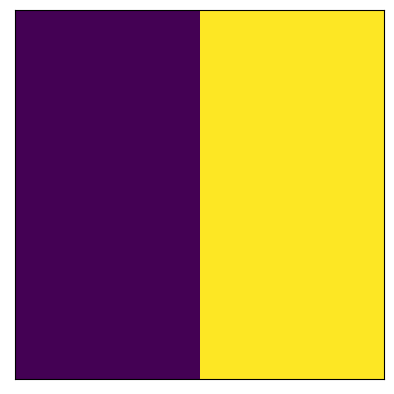

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


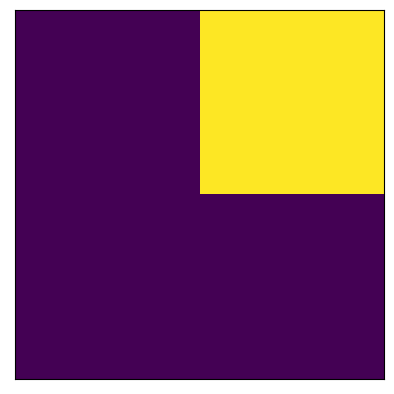

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


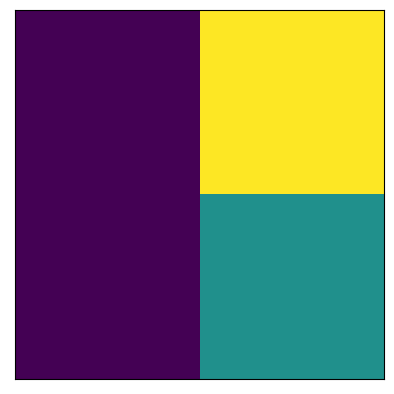

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


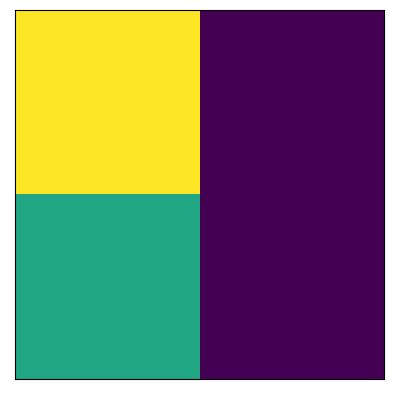

tf.Tensor(
[[10.  0.]
 [ 6.  0.]], shape=(2, 2), dtype=float32)


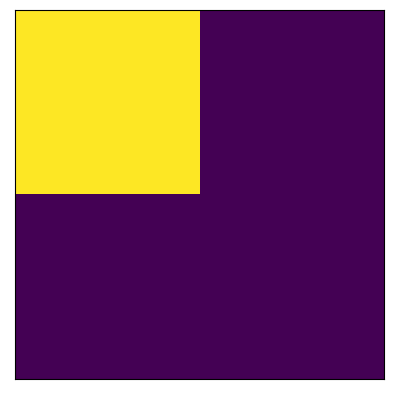

tf.Tensor(
[[2. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


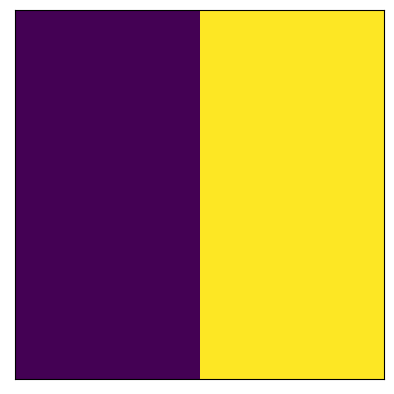

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


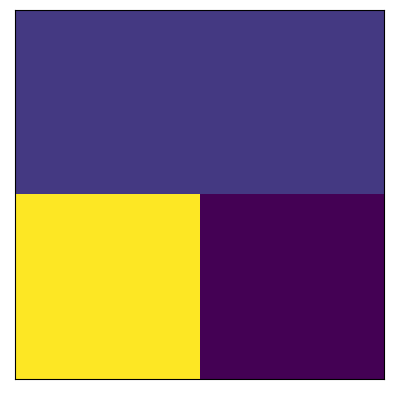

tf.Tensor(
[[1. 1.]
 [6. 0.]], shape=(2, 2), dtype=float32)


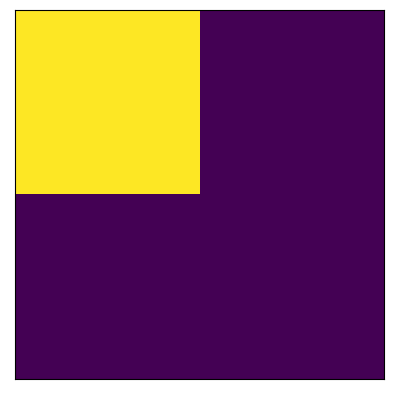

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


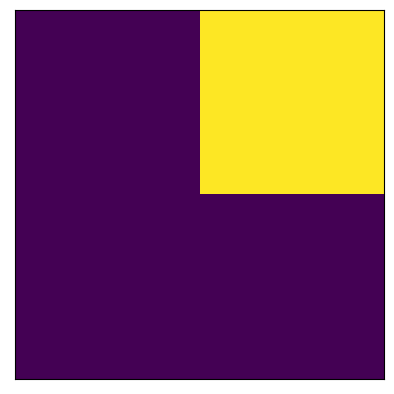

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


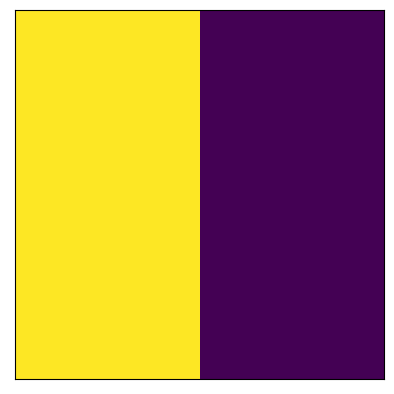

tf.Tensor(
[[6. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


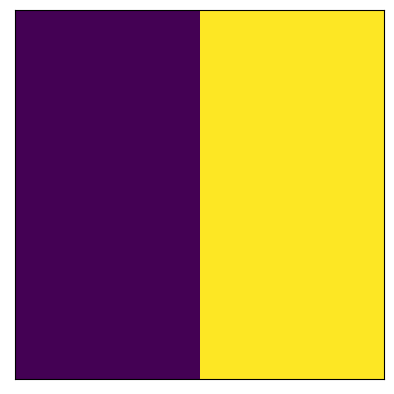

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


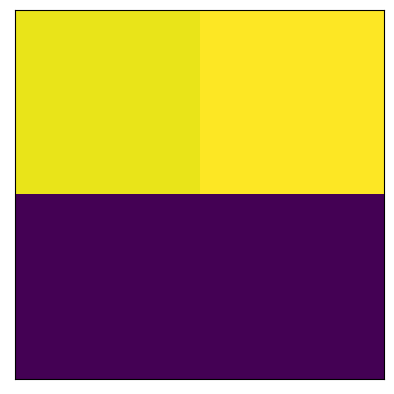

tf.Tensor(
[[1.1600001 1.2      ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


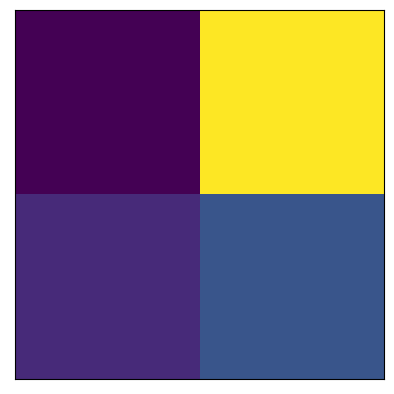

tf.Tensor(
[[0.64000005 2.        ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


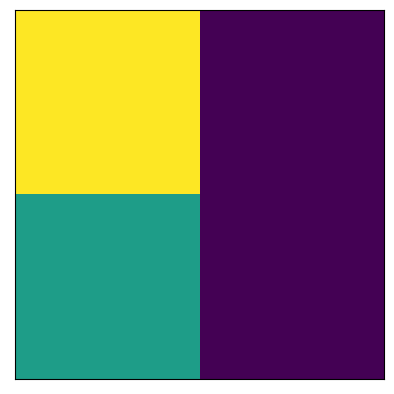

tf.Tensor(
[[0.35999998 0.        ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


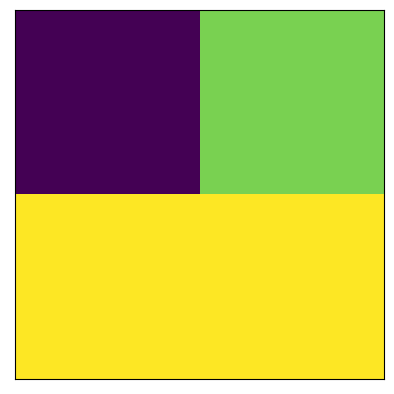

tf.Tensor(
[[0.         0.79999995]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


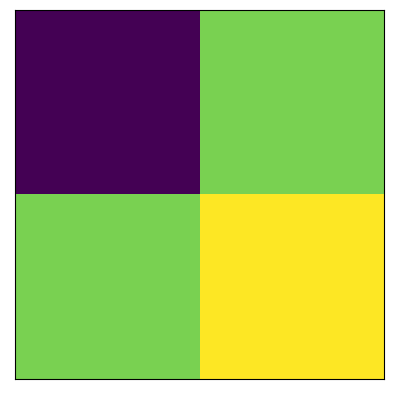

tf.Tensor(
[[0.         0.79999995]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


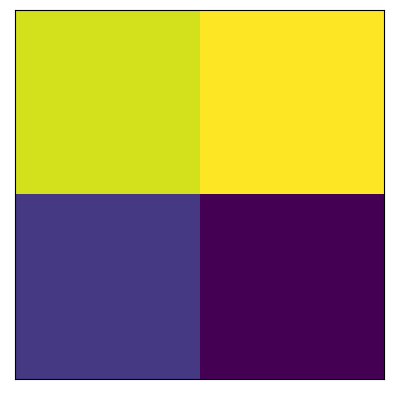

tf.Tensor(
[[1.12 1.2 ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


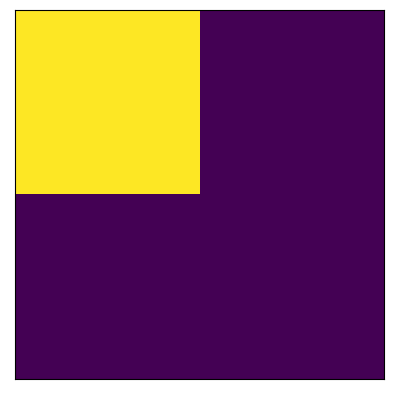

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


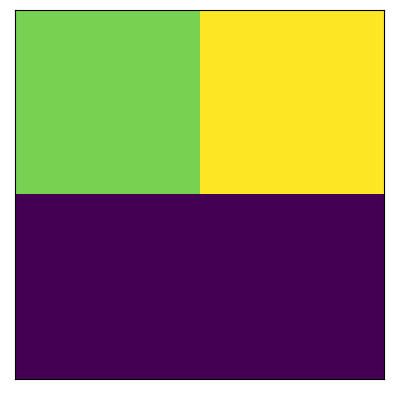

tf.Tensor(
[[0.96000004 1.2       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


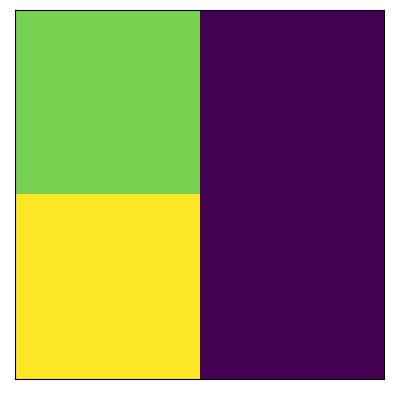

tf.Tensor(
[[0.16000001 0.        ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


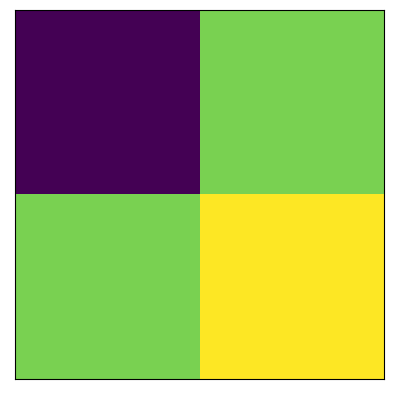

tf.Tensor(
[[0.         0.79999995]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


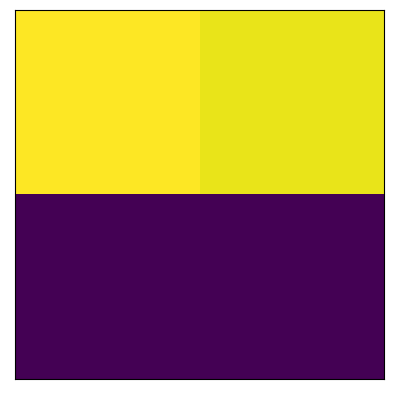

tf.Tensor(
[[0.8611111 0.8333333]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


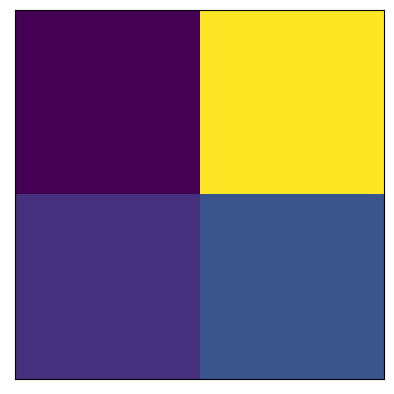

tf.Tensor(
[[0.63888884 2.        ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


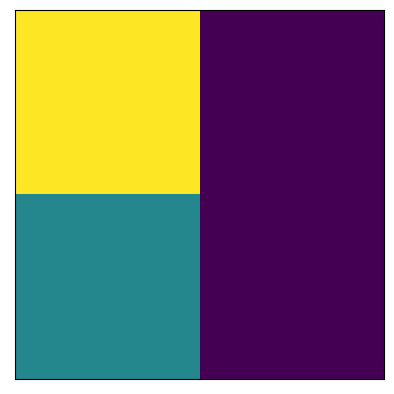

tf.Tensor(
[[0.36111113 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


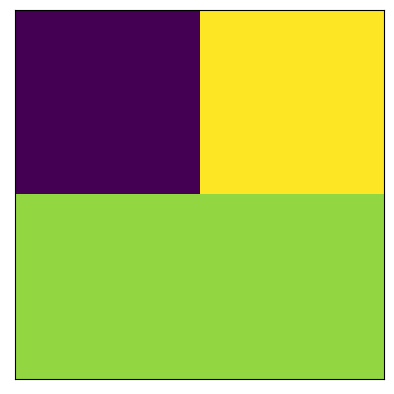

tf.Tensor(
[[0.13888891 1.1666667 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


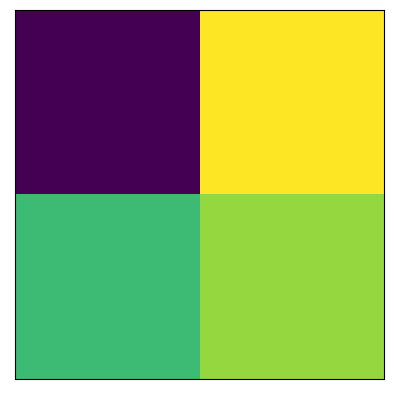

tf.Tensor(
[[0.1111111 1.1666667]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


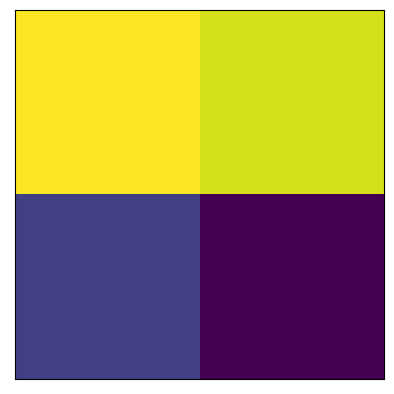

tf.Tensor(
[[0.88888884 0.8333333 ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


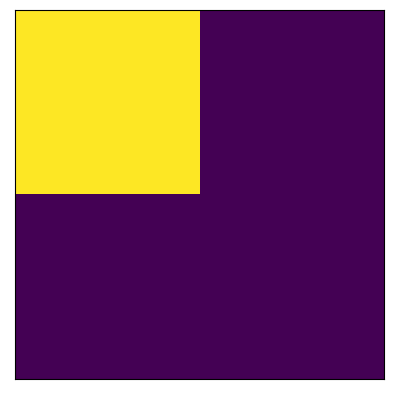

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


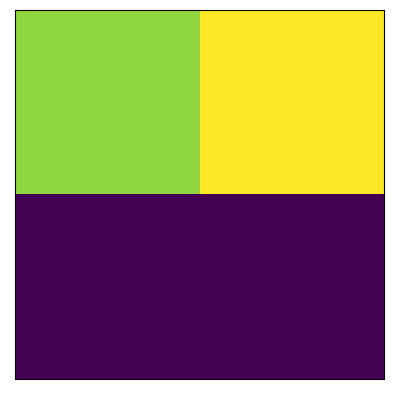

tf.Tensor(
[[0.6944444 0.8333333]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


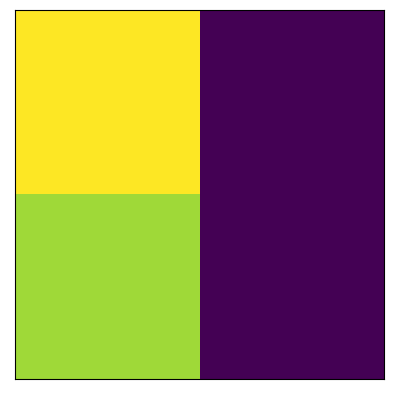

tf.Tensor(
[[0.19444445 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


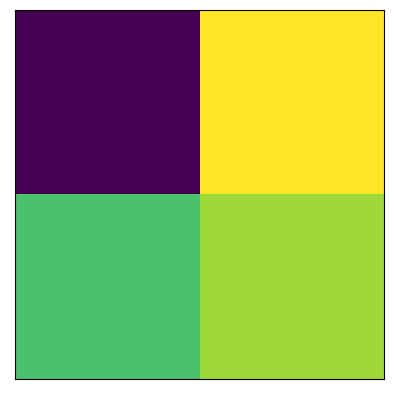

tf.Tensor(
[[0.        1.1666667]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


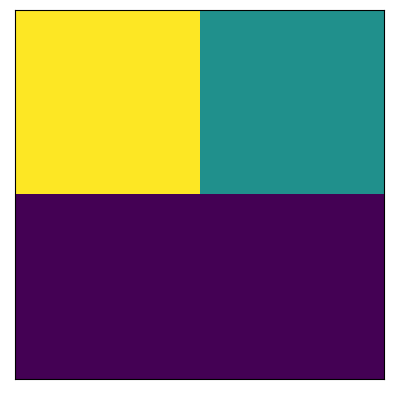

tf.Tensor(
[[2. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


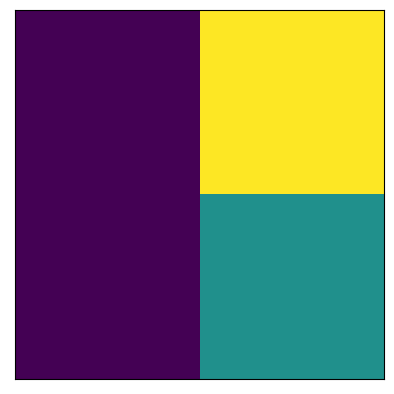

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


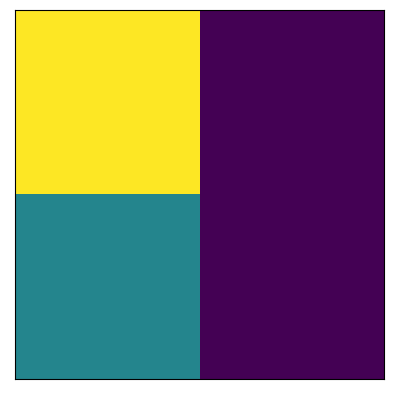

tf.Tensor(
[[11.  0.]
 [ 5.  0.]], shape=(2, 2), dtype=float32)


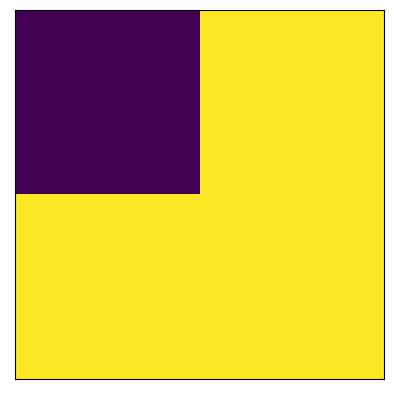

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


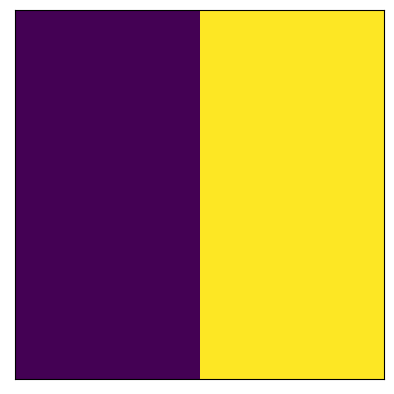

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


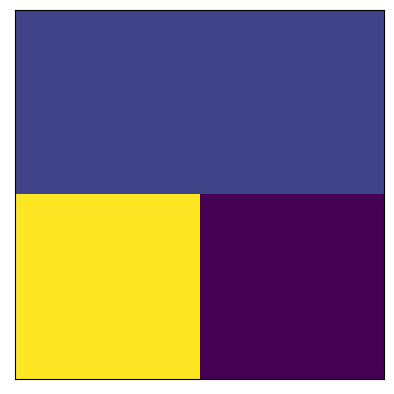

tf.Tensor(
[[1. 1.]
 [5. 0.]], shape=(2, 2), dtype=float32)


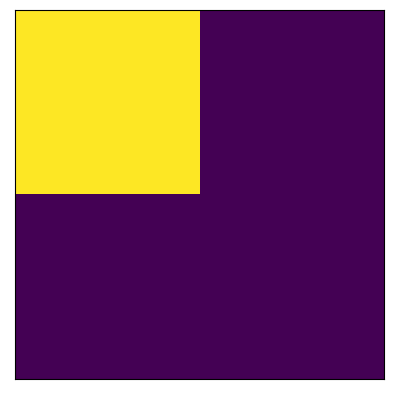

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


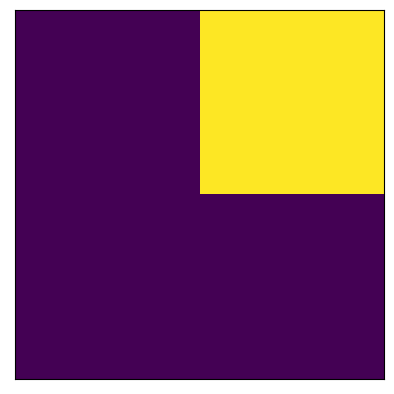

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


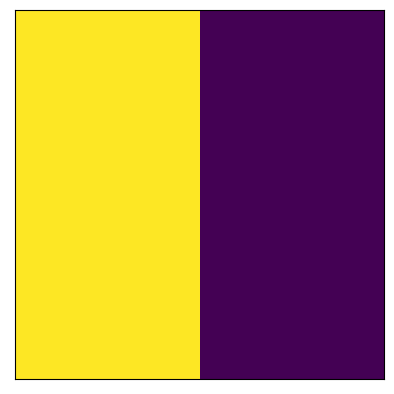

tf.Tensor(
[[5. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


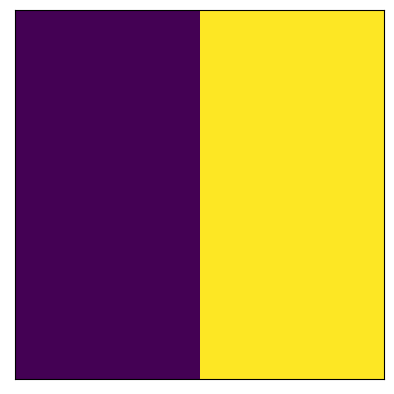

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


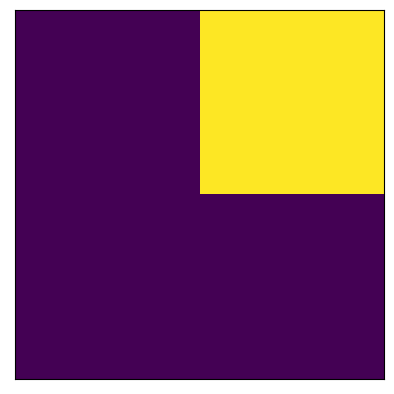

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


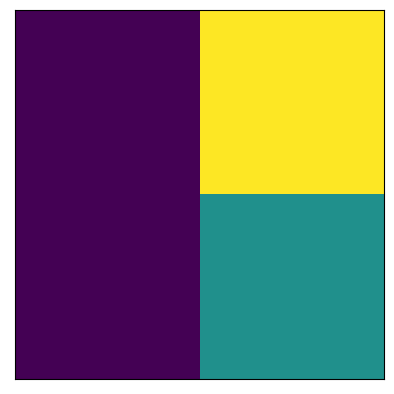

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


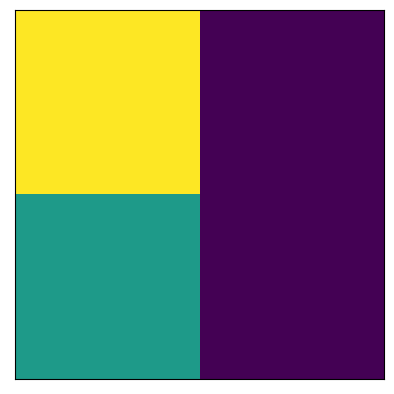

tf.Tensor(
[[11.  0.]
 [ 6.  0.]], shape=(2, 2), dtype=float32)


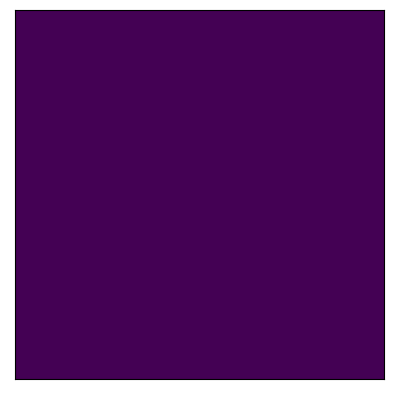

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


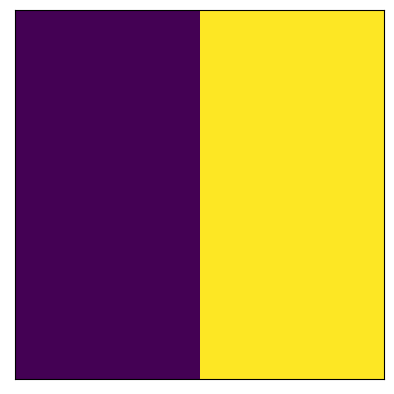

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


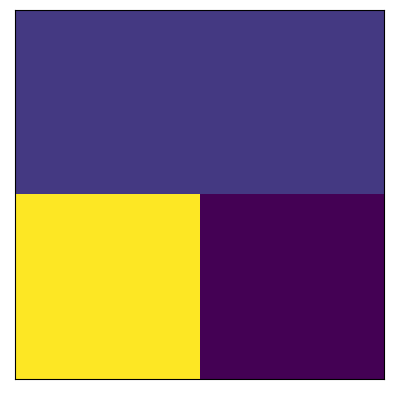

tf.Tensor(
[[1. 1.]
 [6. 0.]], shape=(2, 2), dtype=float32)


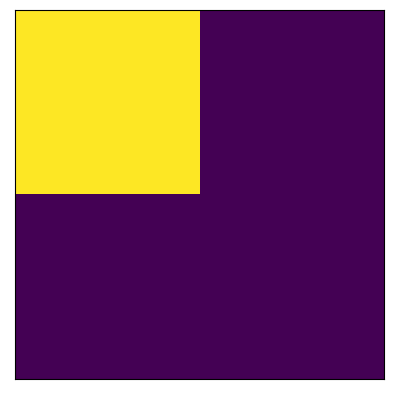

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


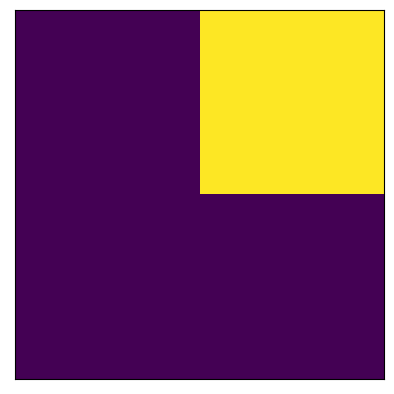

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


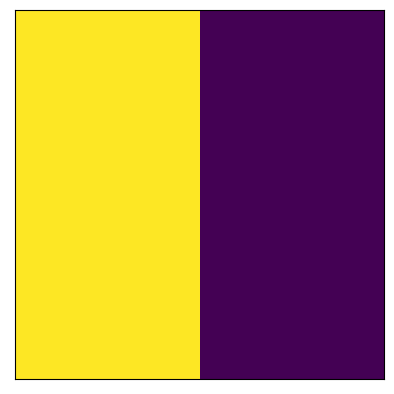

tf.Tensor(
[[6. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


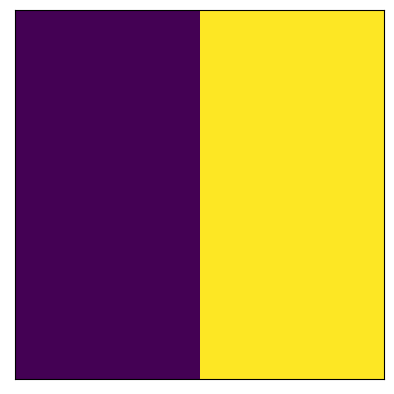

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


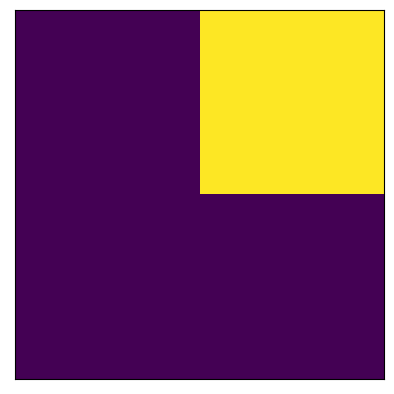

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


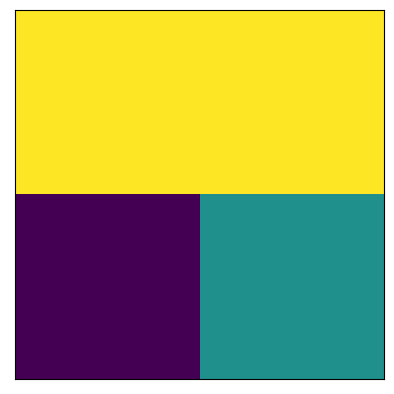

tf.Tensor(
[[2. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


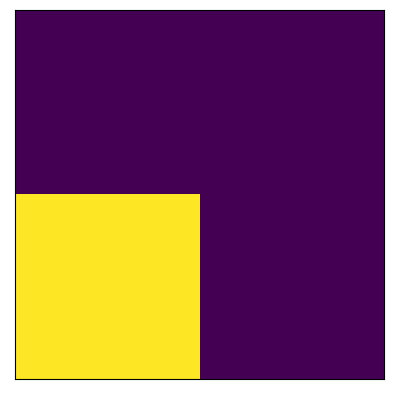

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


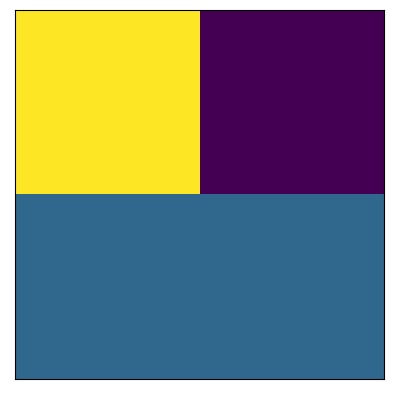

tf.Tensor(
[[3. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


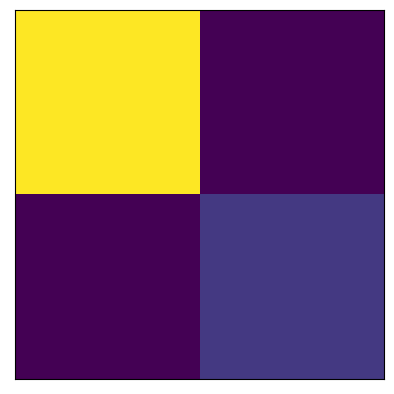

tf.Tensor(
[[6. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


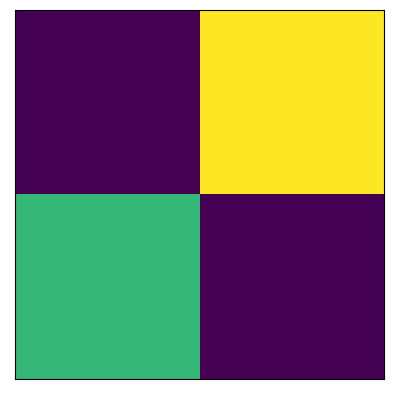

tf.Tensor(
[[0. 3.]
 [2. 0.]], shape=(2, 2), dtype=float32)


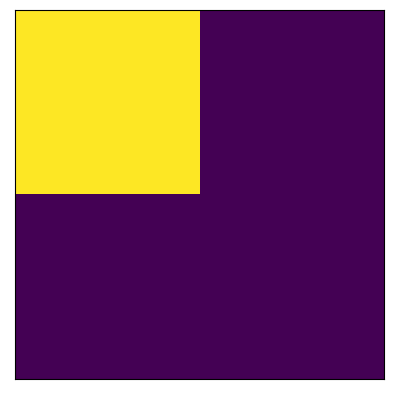

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


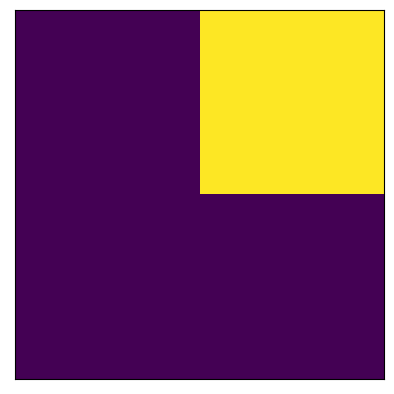

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


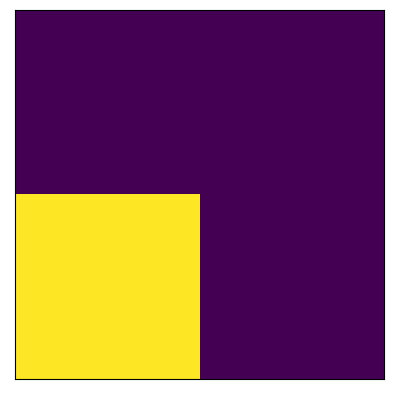

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


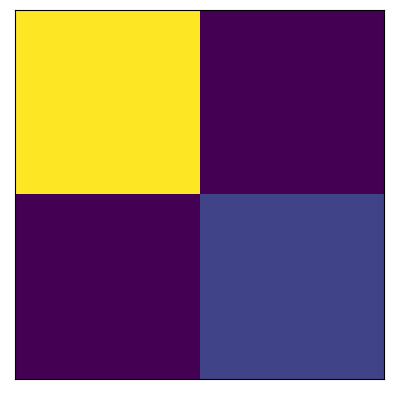

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


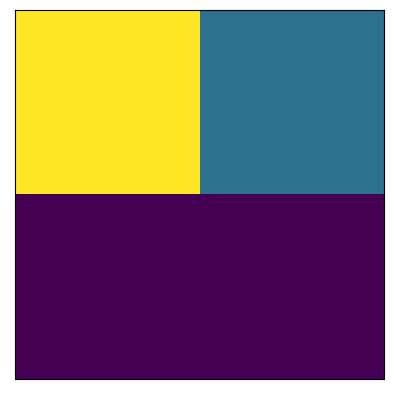

tf.Tensor(
[[0.88888884 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


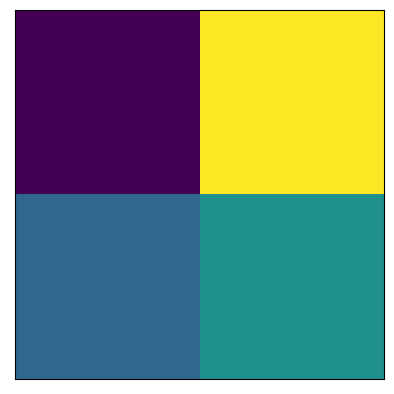

tf.Tensor(
[[0.        2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


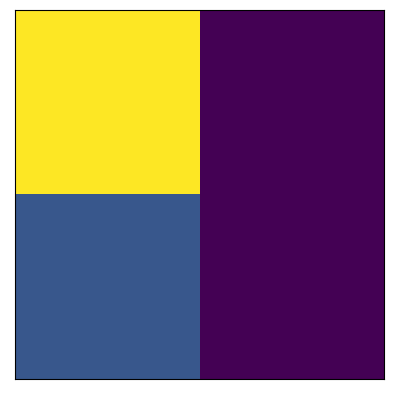

tf.Tensor(
[[1.2222222  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


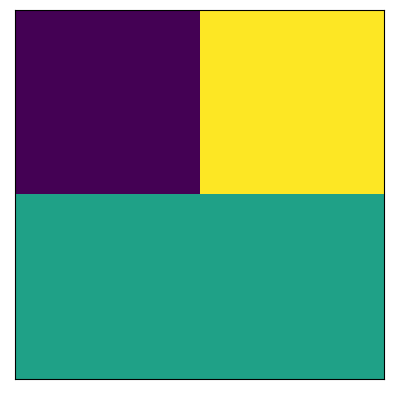

tf.Tensor(
[[0.11111104 1.6666666 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


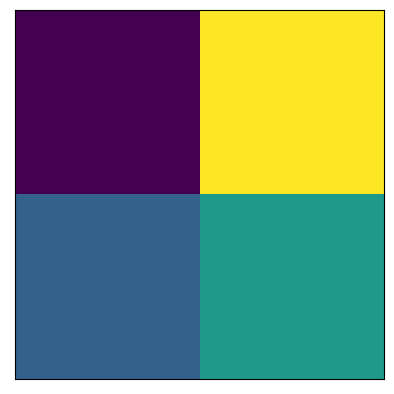

tf.Tensor(
[[0.2222222 1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


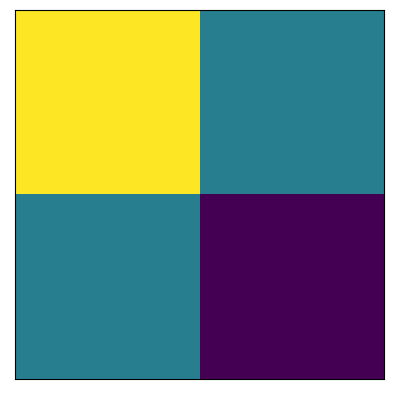

tf.Tensor(
[[0.7777778  0.33333334]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


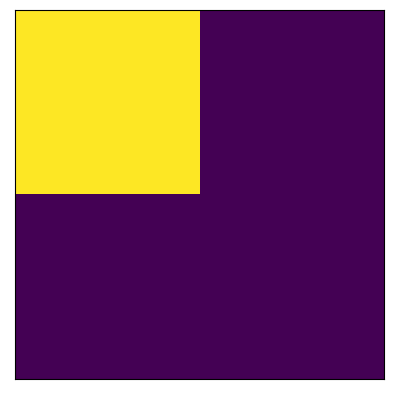

tf.Tensor(
[[0.6666667 0.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


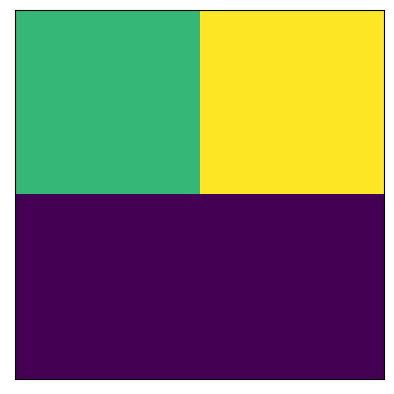

tf.Tensor(
[[0.22222224 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


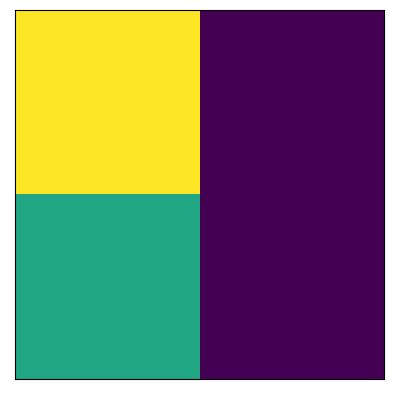

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


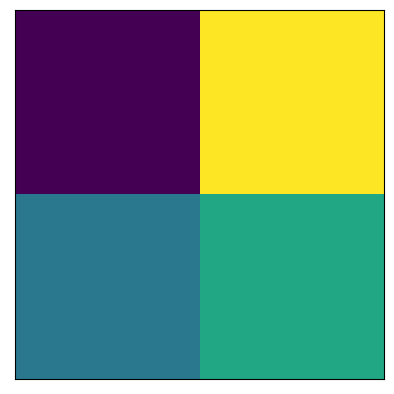

tf.Tensor(
[[0.        1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


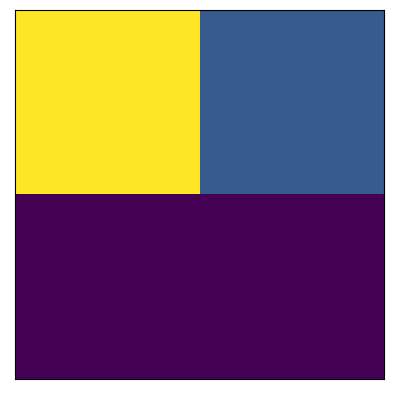

tf.Tensor(
[[1.75 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


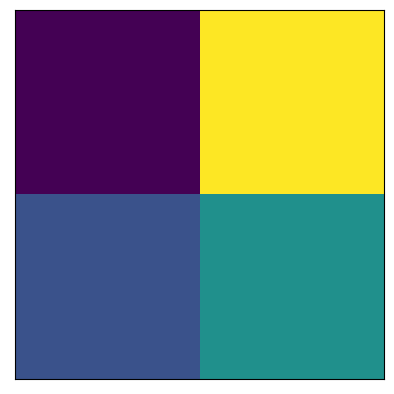

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


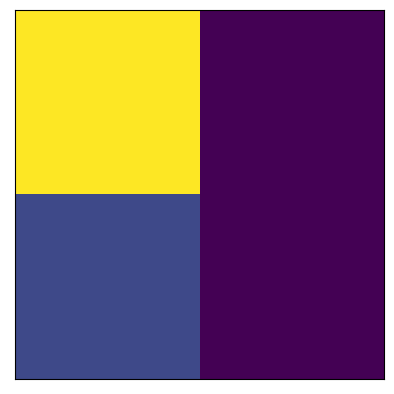

tf.Tensor(
[[2.25 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


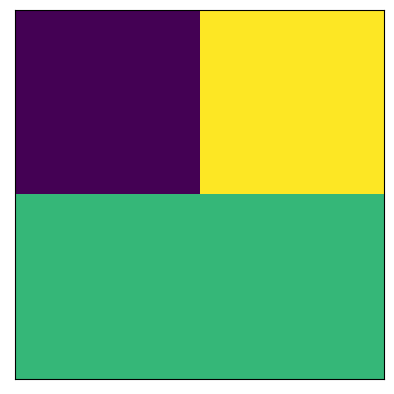

tf.Tensor(
[[0.  1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


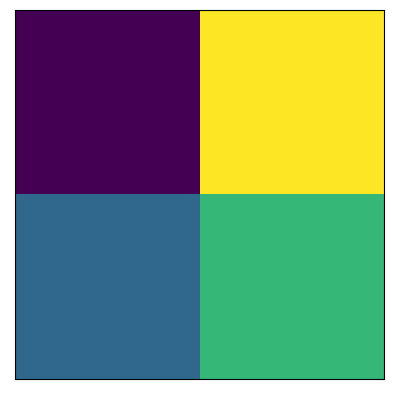

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


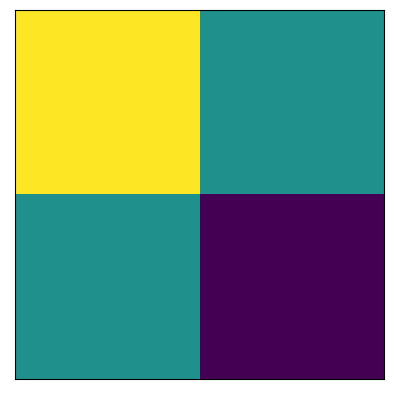

tf.Tensor(
[[1.  0.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


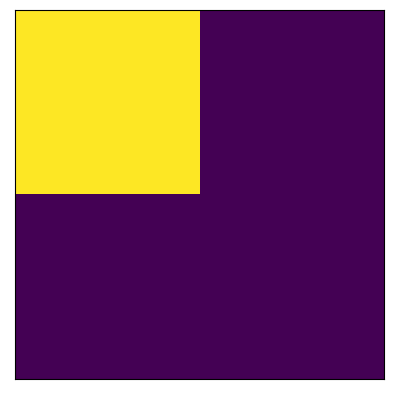

tf.Tensor(
[[1.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


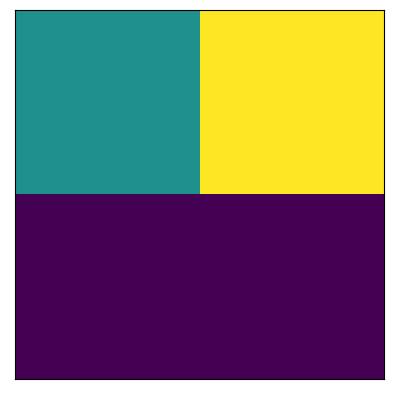

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


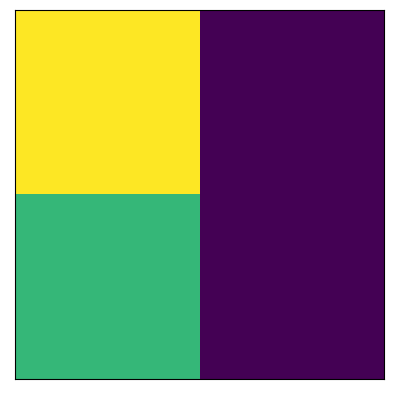

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


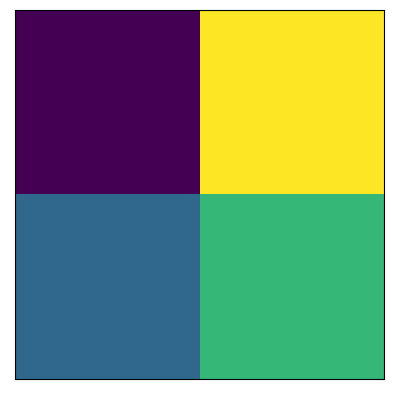

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


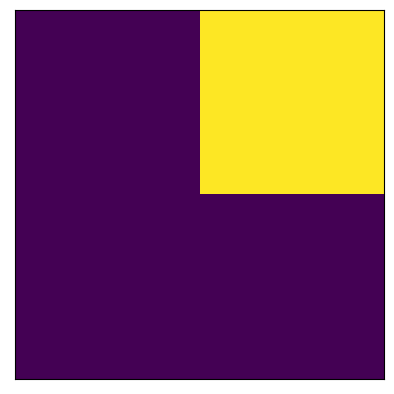

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


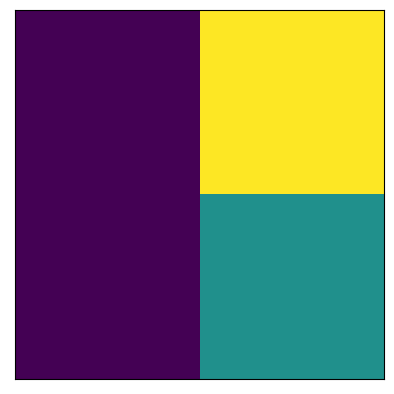

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


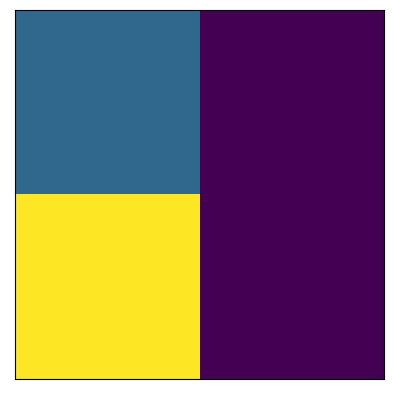

tf.Tensor(
[[1. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


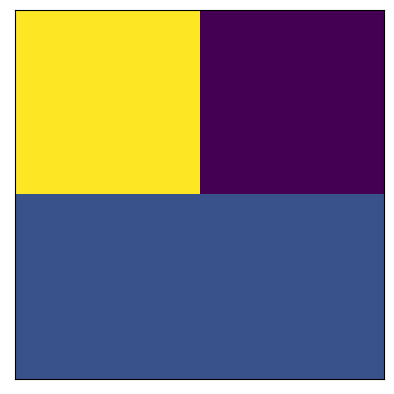

tf.Tensor(
[[4. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


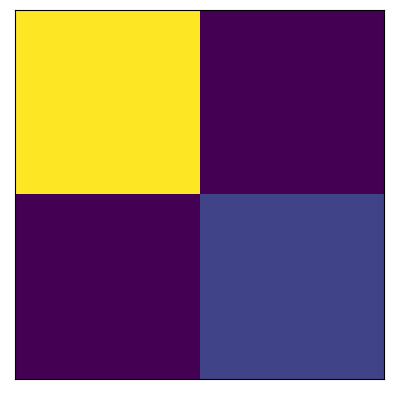

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


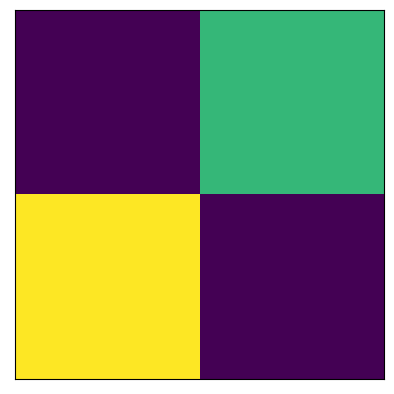

tf.Tensor(
[[0. 2.]
 [3. 0.]], shape=(2, 2), dtype=float32)


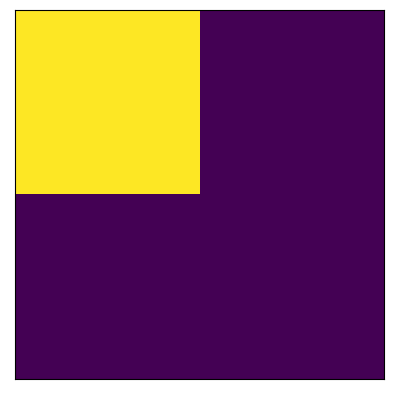

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


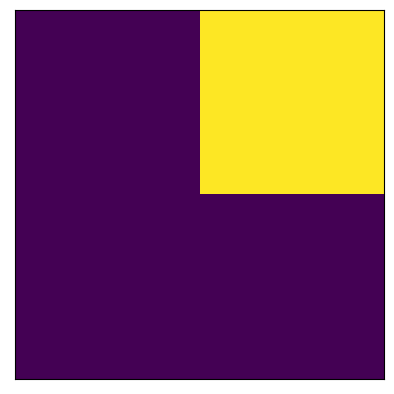

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


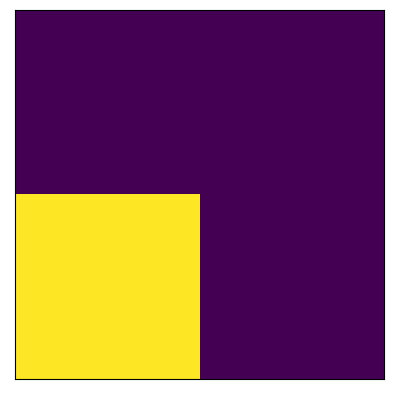

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


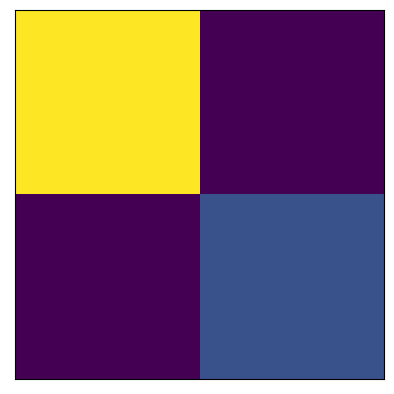

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


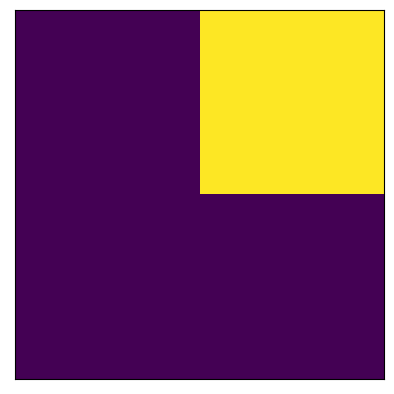

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


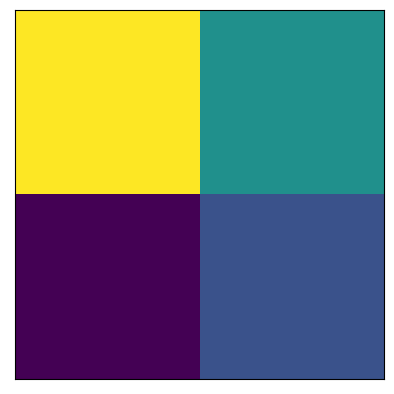

tf.Tensor(
[[4. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


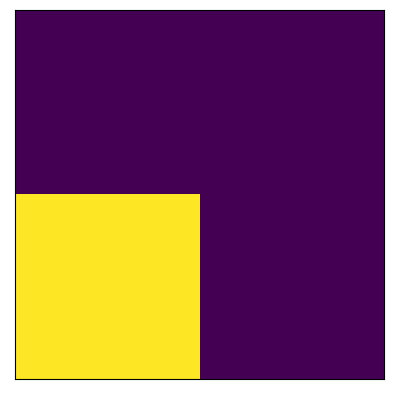

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


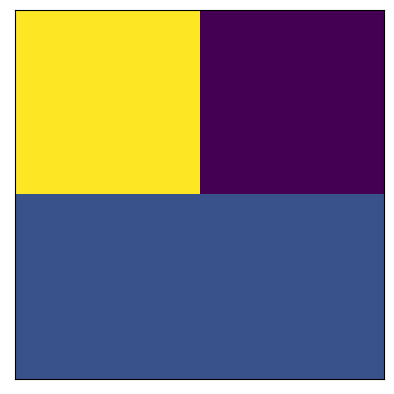

tf.Tensor(
[[4. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


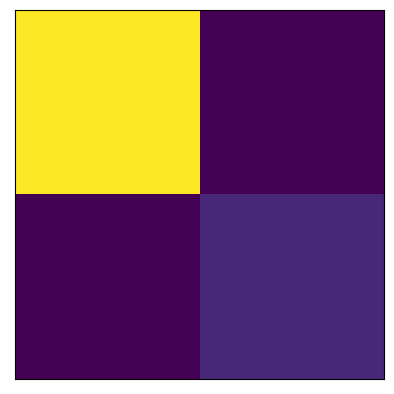

tf.Tensor(
[[9. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


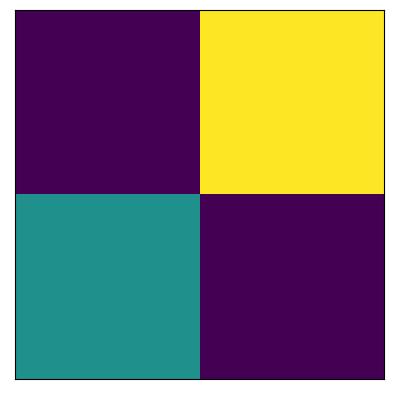

tf.Tensor(
[[0. 4.]
 [2. 0.]], shape=(2, 2), dtype=float32)


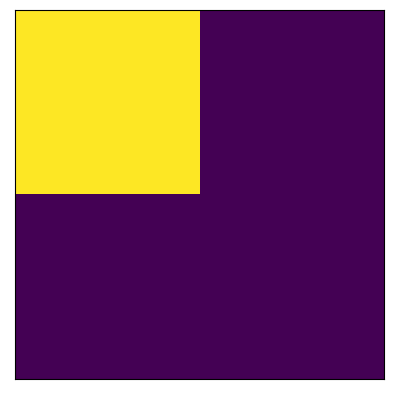

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


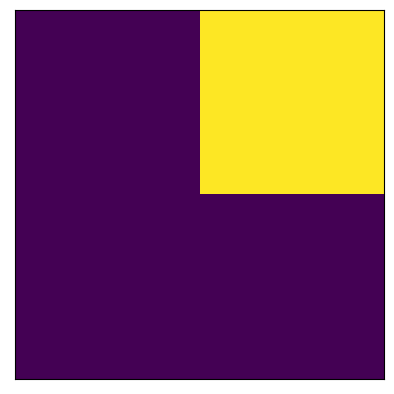

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


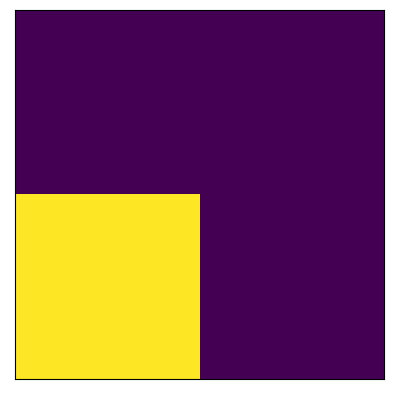

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


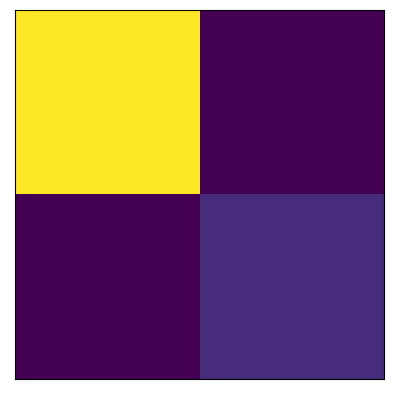

tf.Tensor(
[[8. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


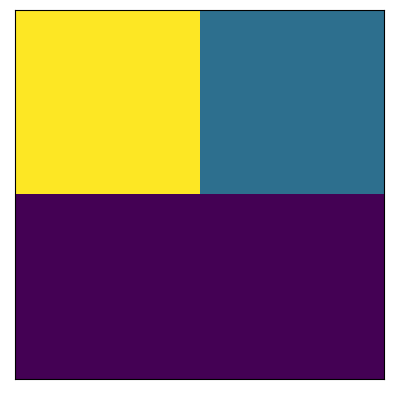

tf.Tensor(
[[0.6875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


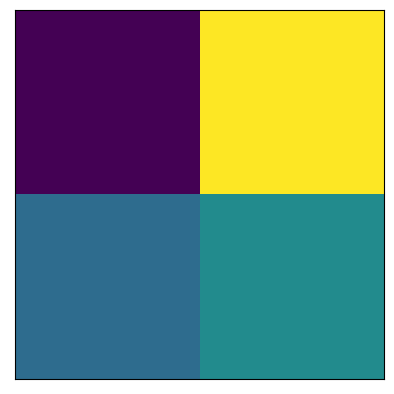

tf.Tensor(
[[0.0625 2.    ]
 [0.75   1.    ]], shape=(2, 2), dtype=float32)


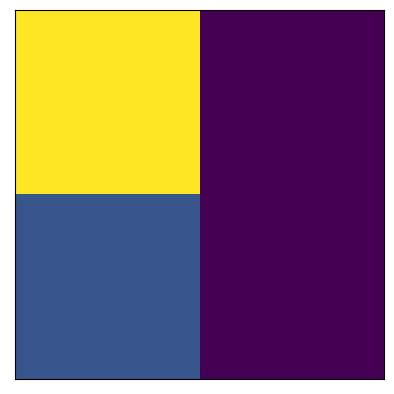

tf.Tensor(
[[0.9375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


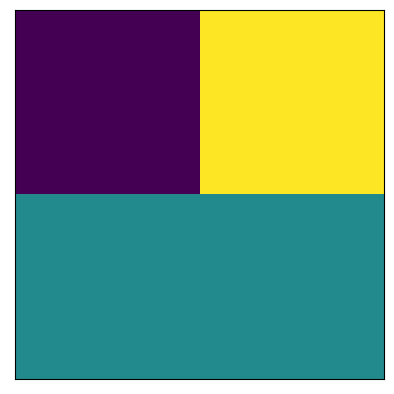

tf.Tensor(
[[0.3125 1.75  ]
 [1.     1.    ]], shape=(2, 2), dtype=float32)


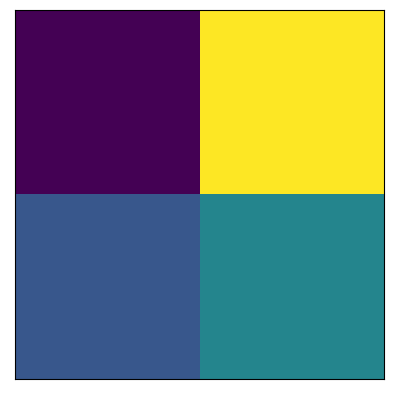

tf.Tensor(
[[0.375 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


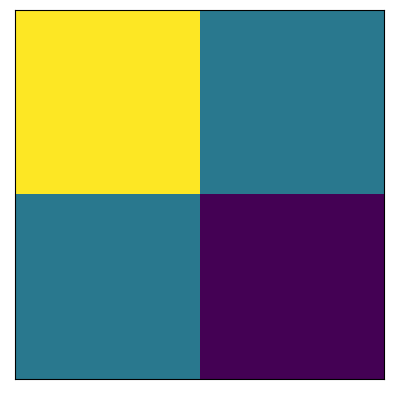

tf.Tensor(
[[0.625 0.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


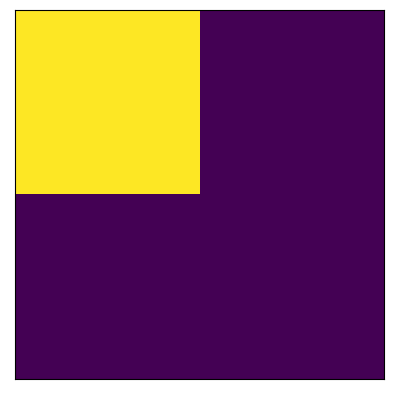

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


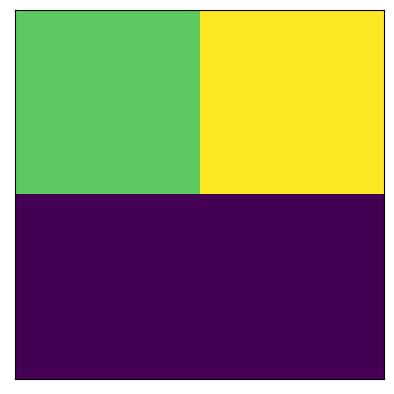

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


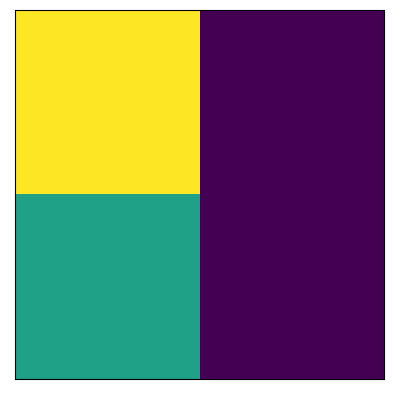

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


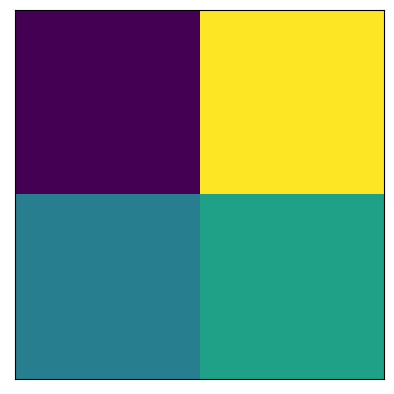

tf.Tensor(
[[0.   1.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


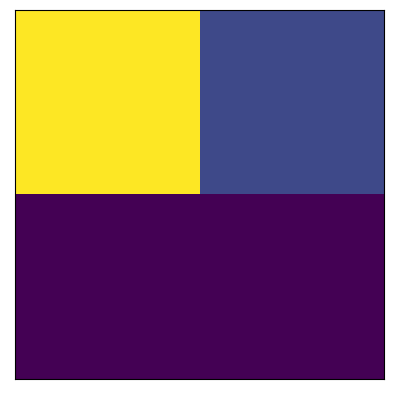

tf.Tensor(
[[2.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


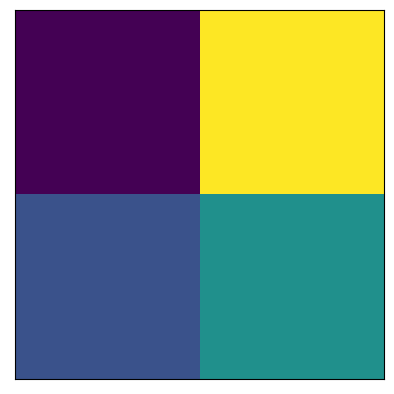

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


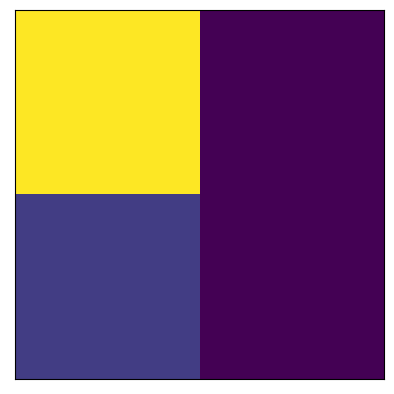

tf.Tensor(
[[2.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


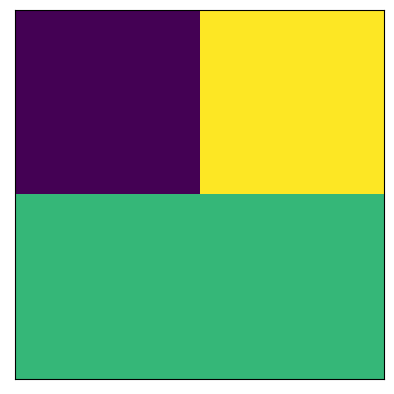

tf.Tensor(
[[0.  1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


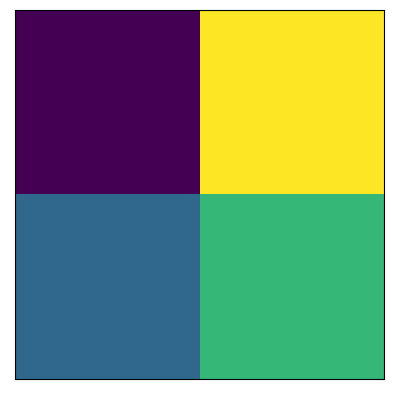

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


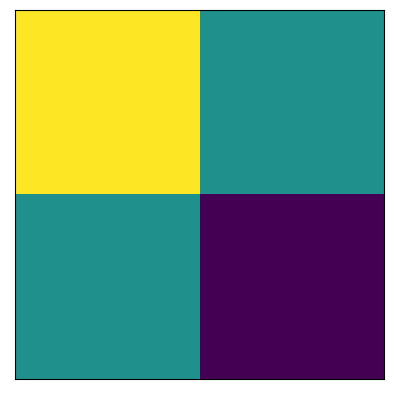

tf.Tensor(
[[1.  0.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


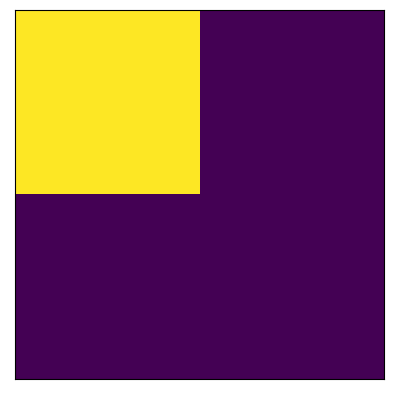

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


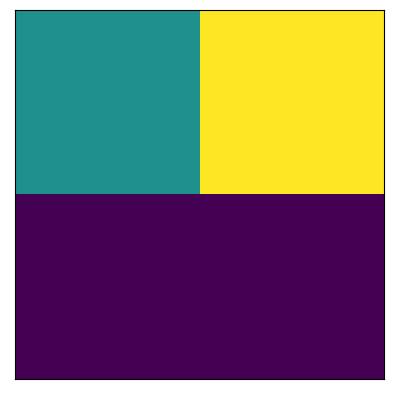

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


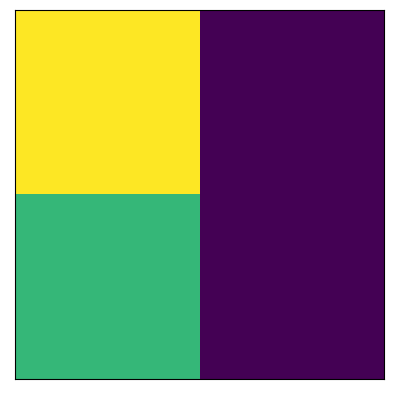

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


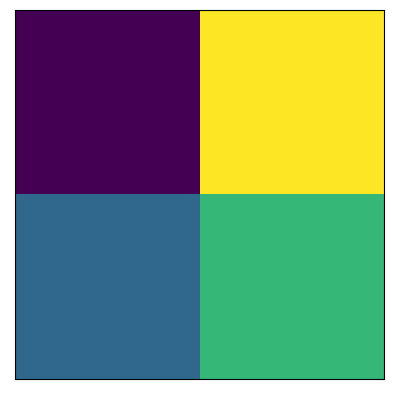

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


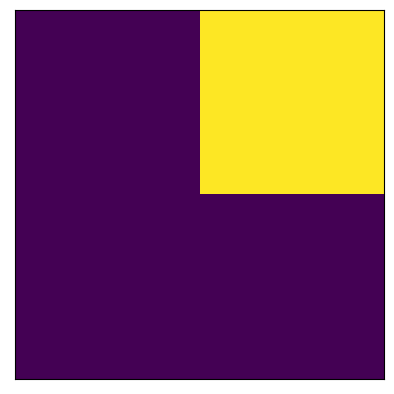

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


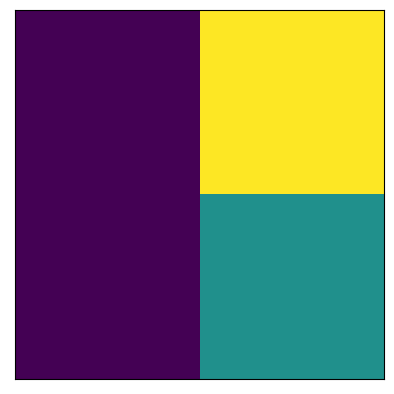

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


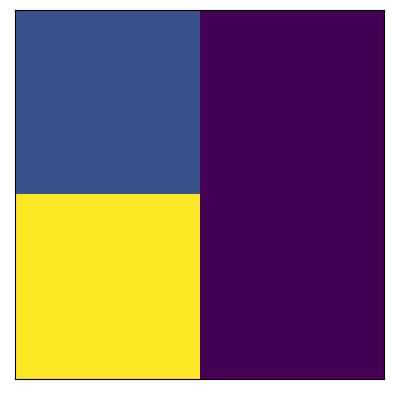

tf.Tensor(
[[1. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


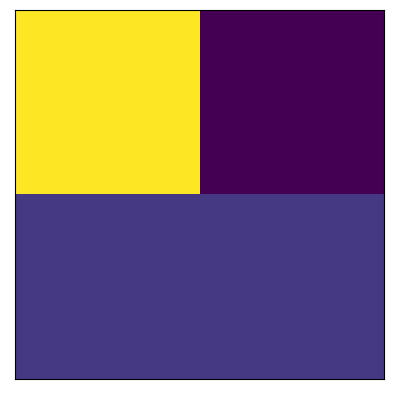

tf.Tensor(
[[6. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


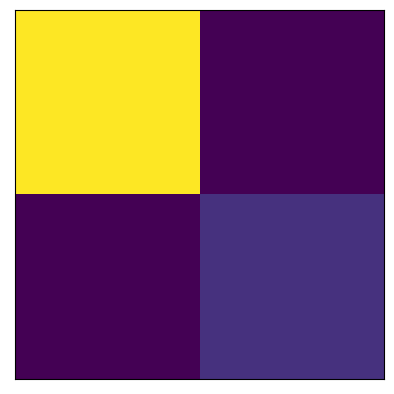

tf.Tensor(
[[7. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


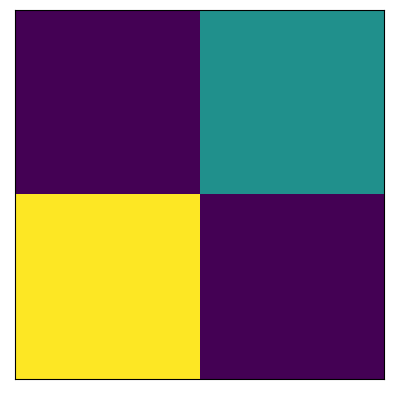

tf.Tensor(
[[0. 2.]
 [4. 0.]], shape=(2, 2), dtype=float32)


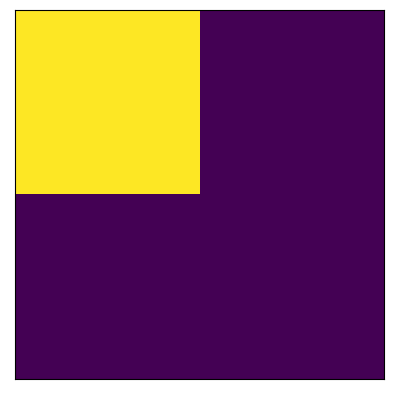

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


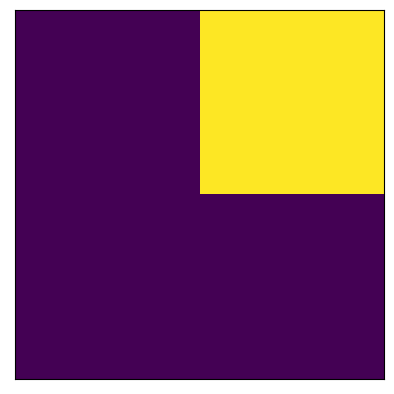

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


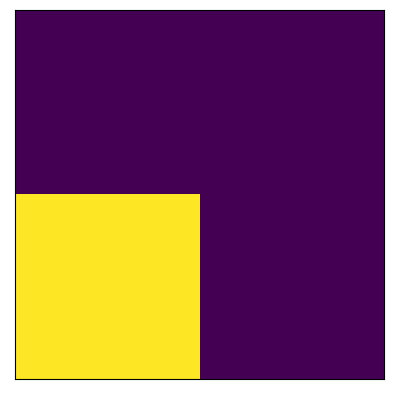

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


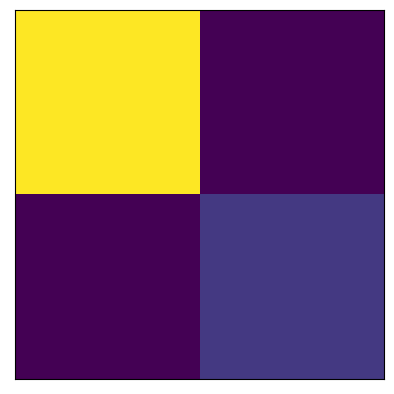

tf.Tensor(
[[6. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


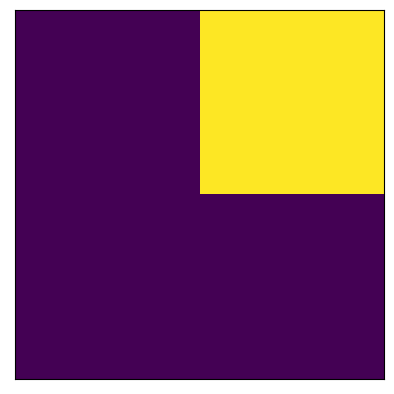

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


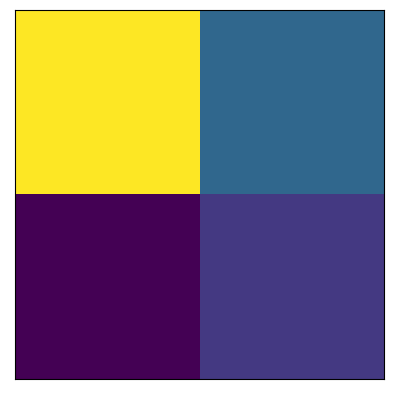

tf.Tensor(
[[6. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


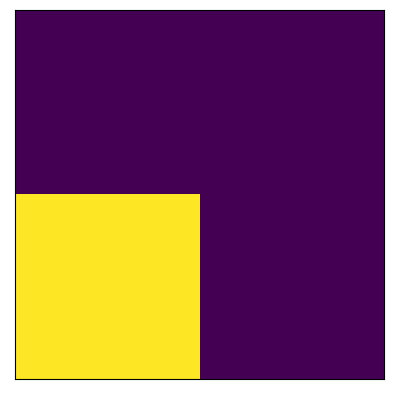

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


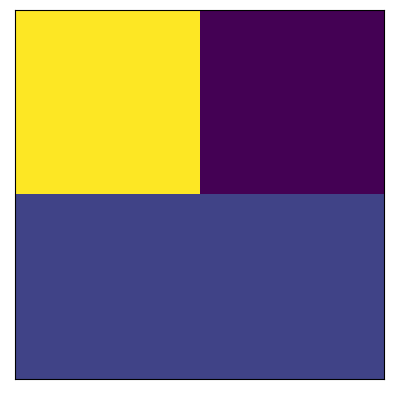

tf.Tensor(
[[5. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


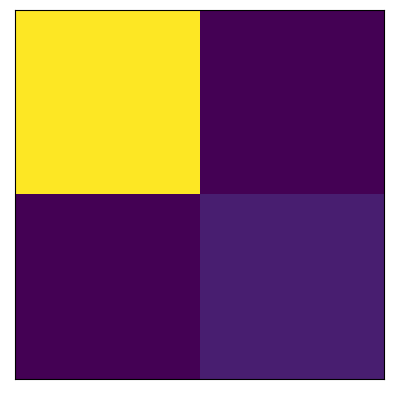

tf.Tensor(
[[12.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


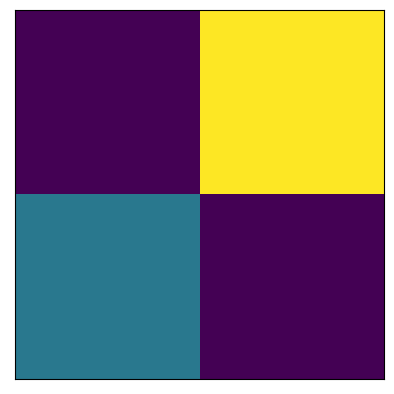

tf.Tensor(
[[0. 5.]
 [2. 0.]], shape=(2, 2), dtype=float32)


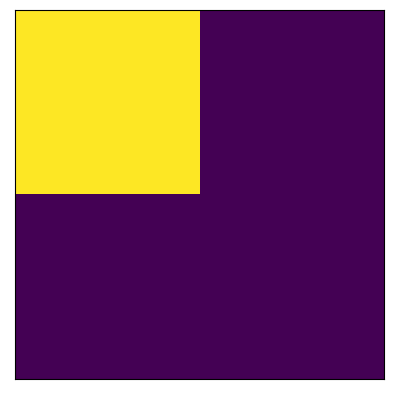

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


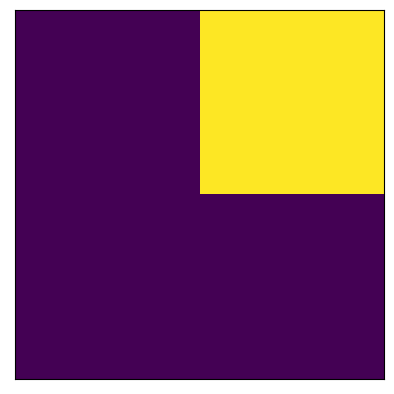

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


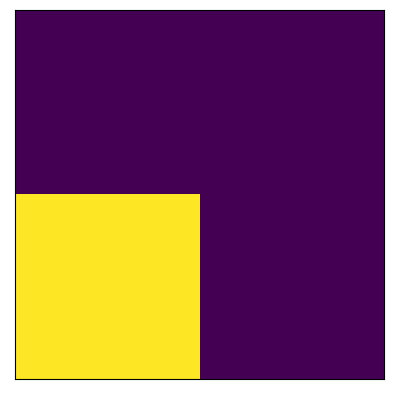

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


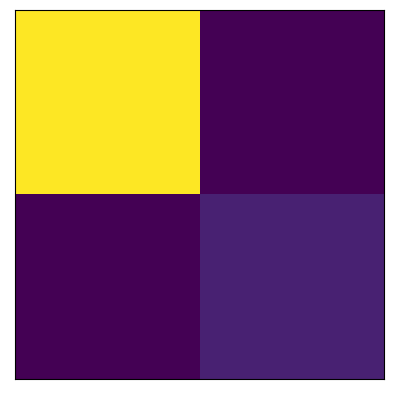

tf.Tensor(
[[11.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


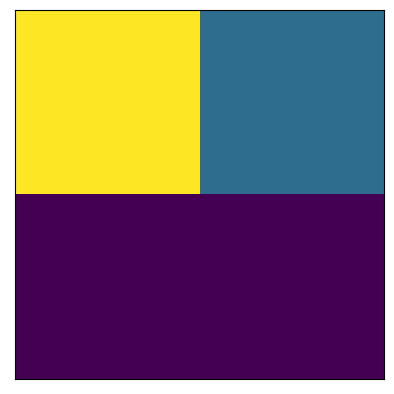

tf.Tensor(
[[0.56 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


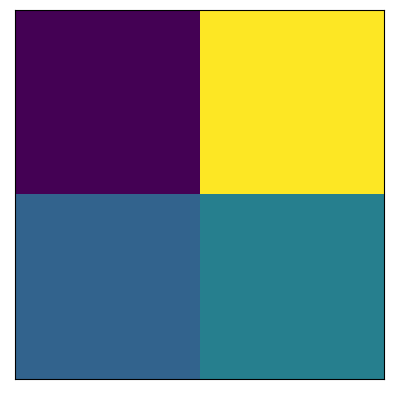

tf.Tensor(
[[0.24000001 2.        ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


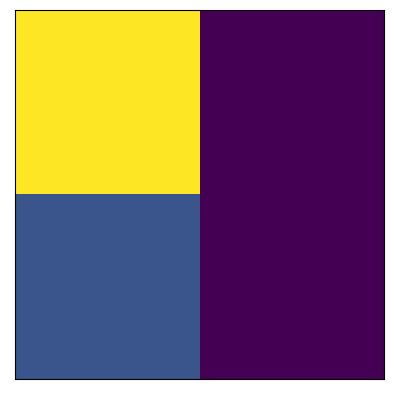

tf.Tensor(
[[0.76 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


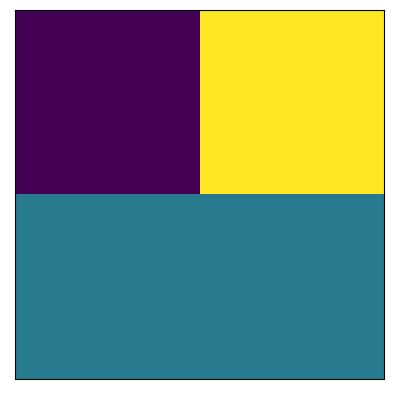

tf.Tensor(
[[0.44 1.8 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


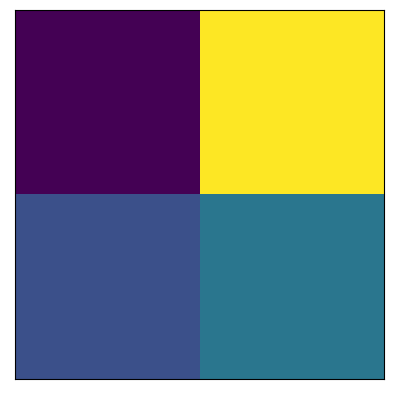

tf.Tensor(
[[0.48000002 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


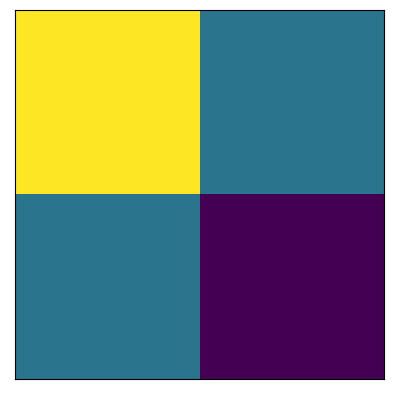

tf.Tensor(
[[0.52000004 0.2       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


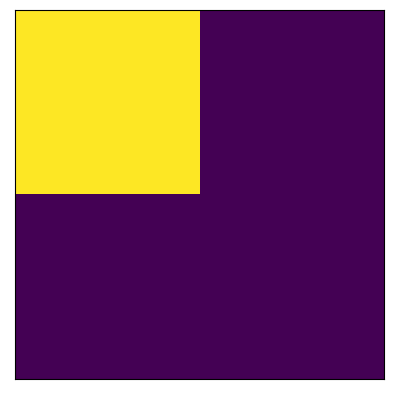

tf.Tensor(
[[0.4 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


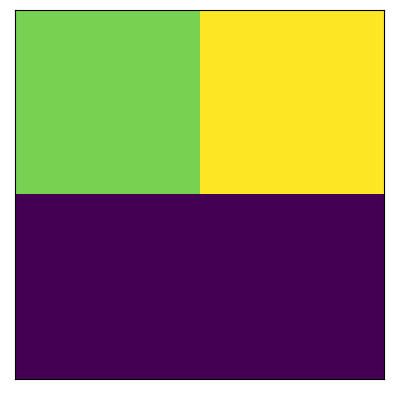

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


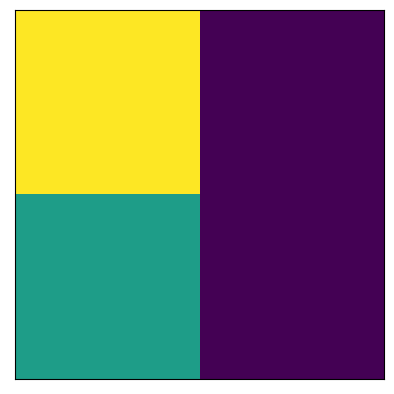

tf.Tensor(
[[0.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


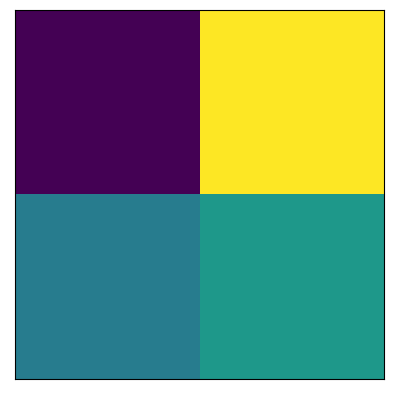

tf.Tensor(
[[0.08000004 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


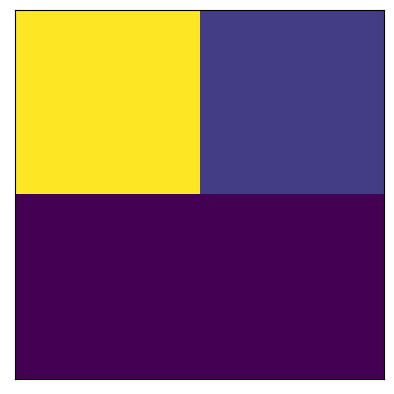

tf.Tensor(
[[2.75 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


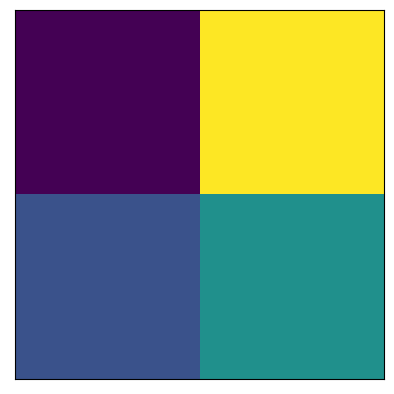

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


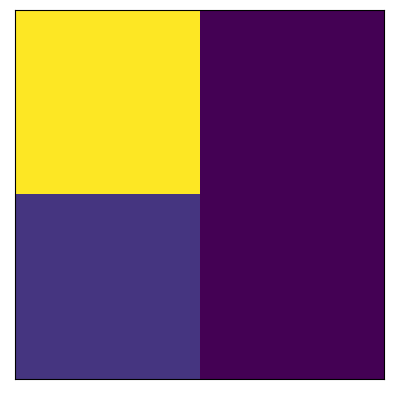

tf.Tensor(
[[3.25 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


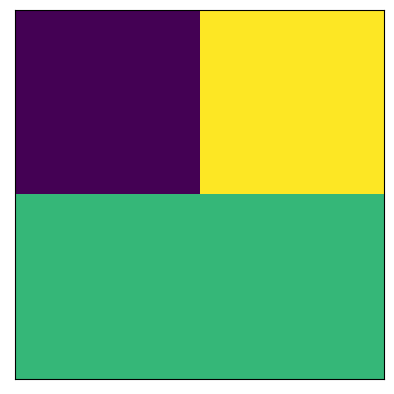

tf.Tensor(
[[0.  1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


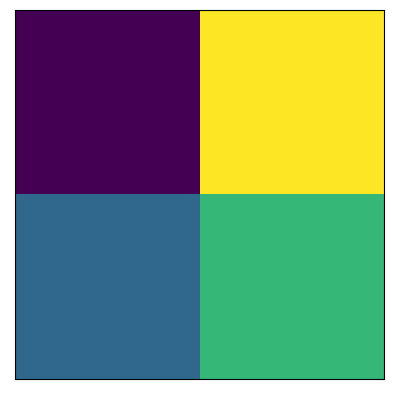

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


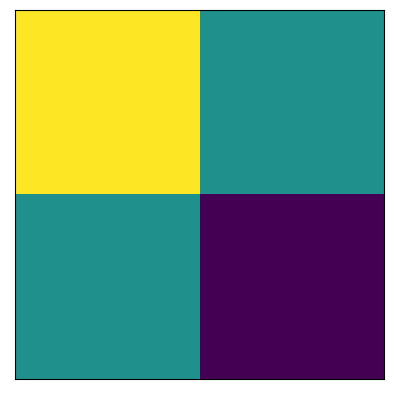

tf.Tensor(
[[1.  0.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


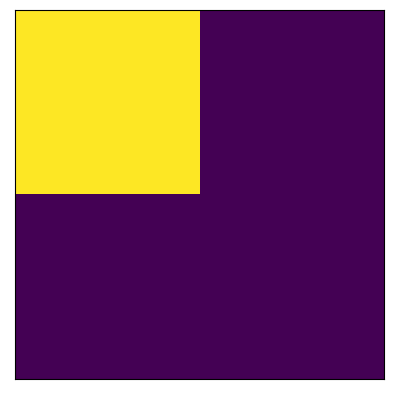

tf.Tensor(
[[2.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


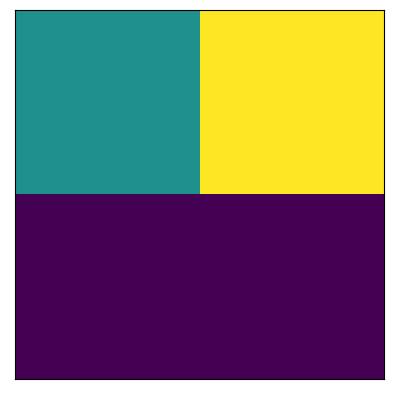

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


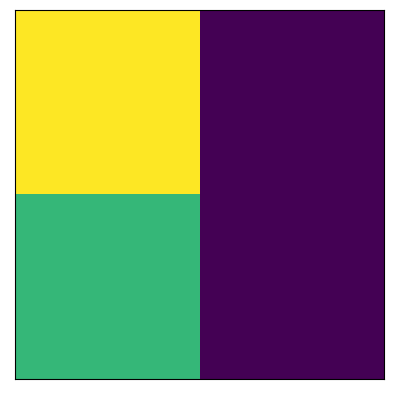

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


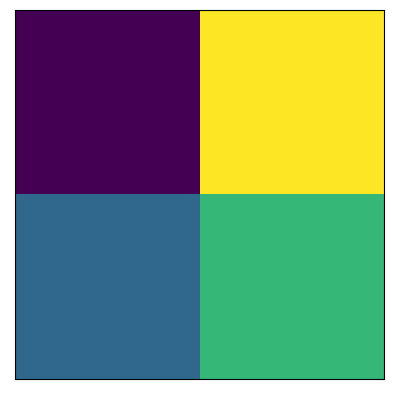

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


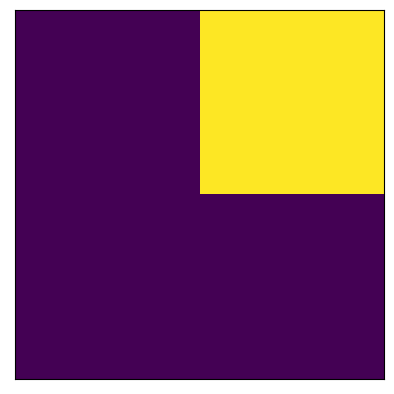

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


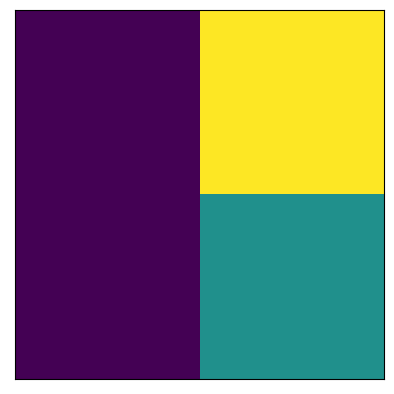

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


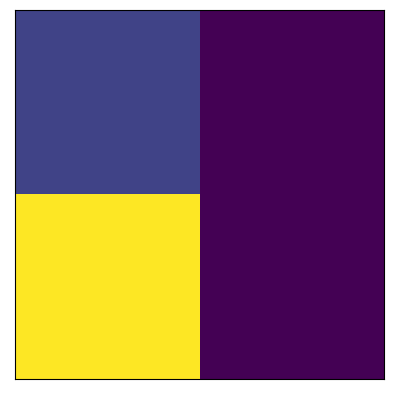

tf.Tensor(
[[1. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


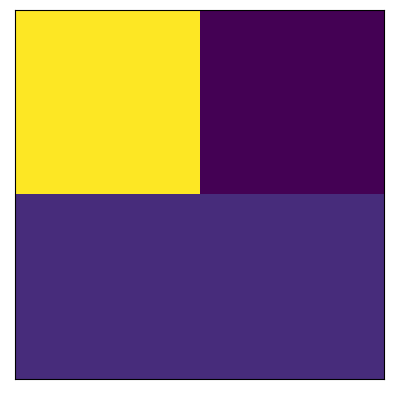

tf.Tensor(
[[8. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


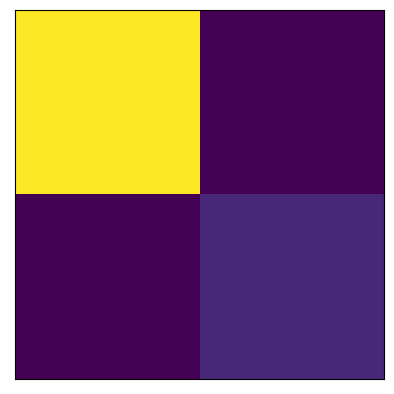

tf.Tensor(
[[9. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


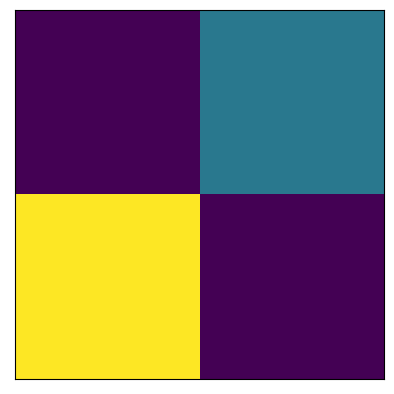

tf.Tensor(
[[0. 2.]
 [5. 0.]], shape=(2, 2), dtype=float32)


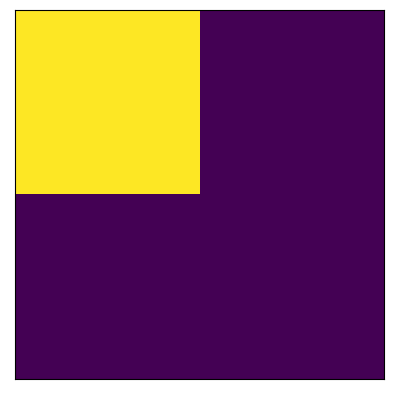

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


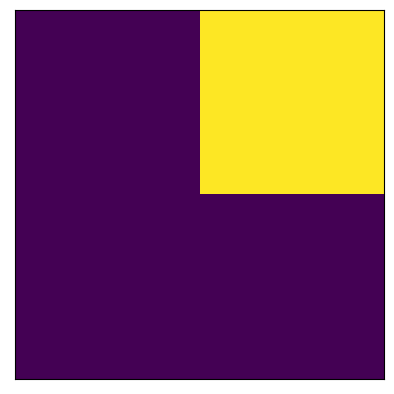

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


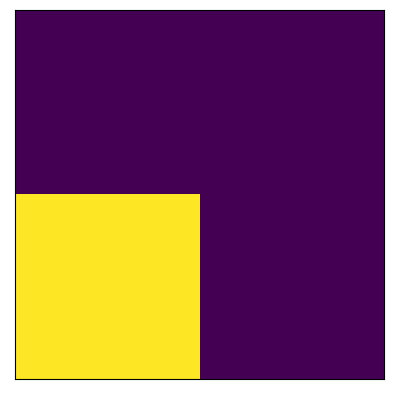

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


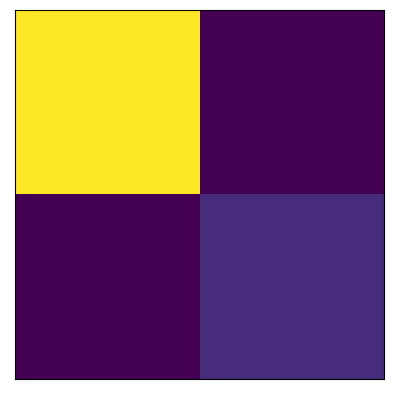

tf.Tensor(
[[8. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


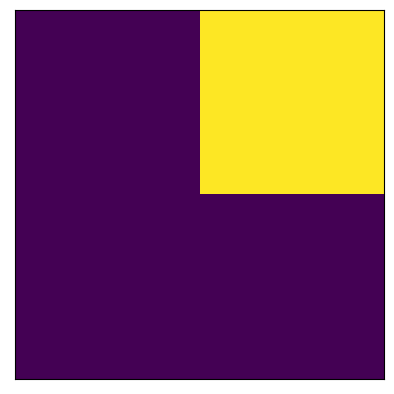

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


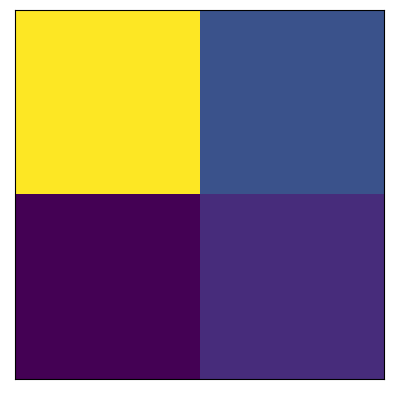

tf.Tensor(
[[8. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


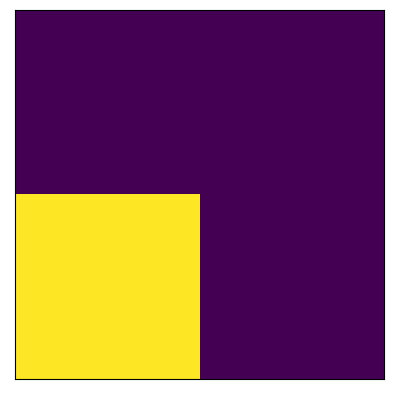

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


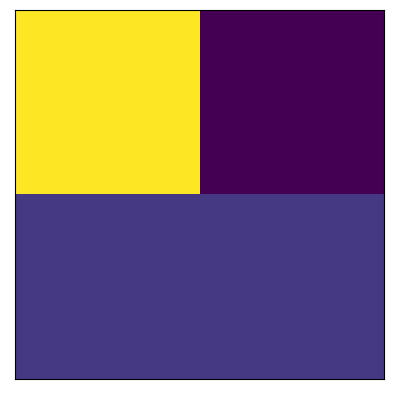

tf.Tensor(
[[6. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


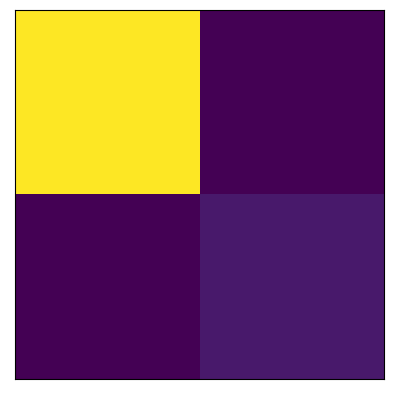

tf.Tensor(
[[15.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


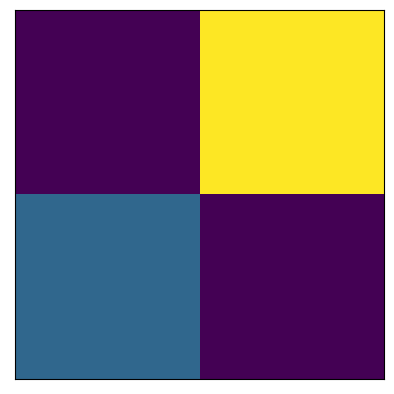

tf.Tensor(
[[0. 6.]
 [2. 0.]], shape=(2, 2), dtype=float32)


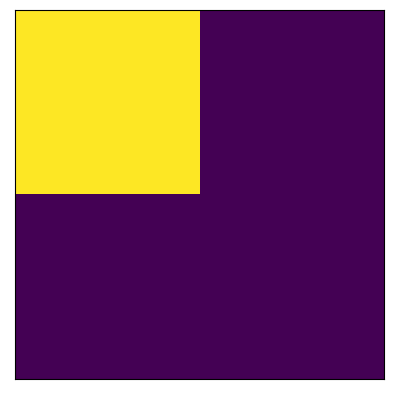

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


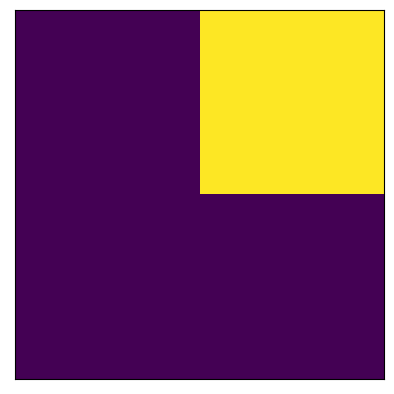

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


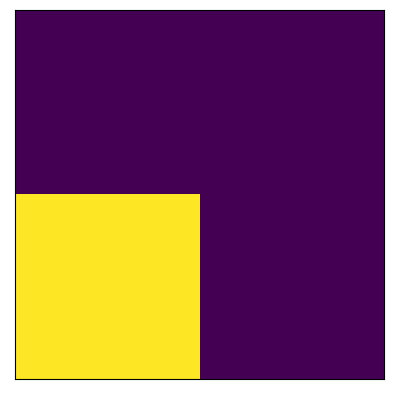

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


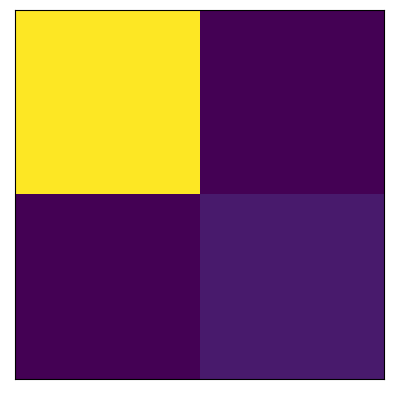

tf.Tensor(
[[14.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


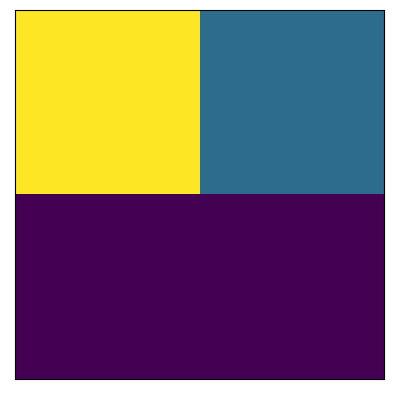

tf.Tensor(
[[0.4722222  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


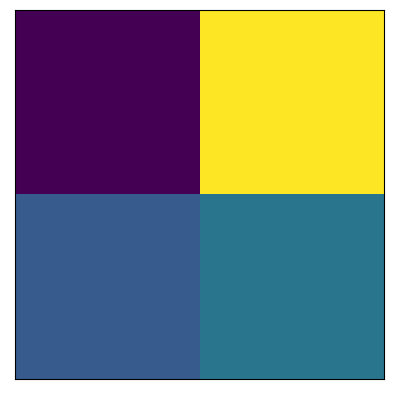

tf.Tensor(
[[0.36111107 2.        ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


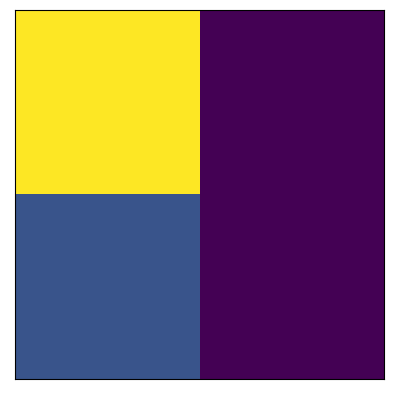

tf.Tensor(
[[0.6388889  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


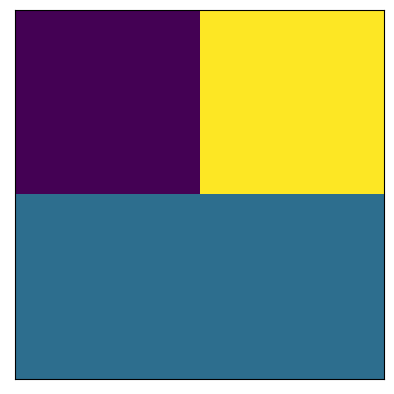

tf.Tensor(
[[0.5277778 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


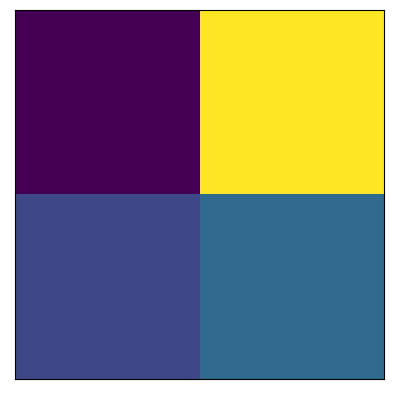

tf.Tensor(
[[0.5555555 1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


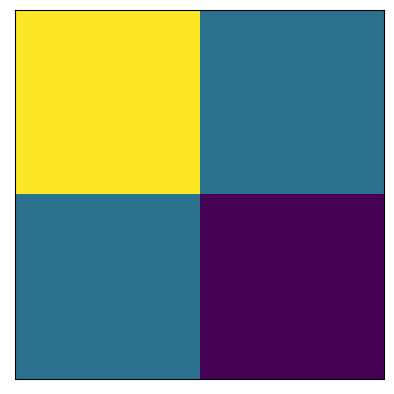

tf.Tensor(
[[0.44444445 0.16666667]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


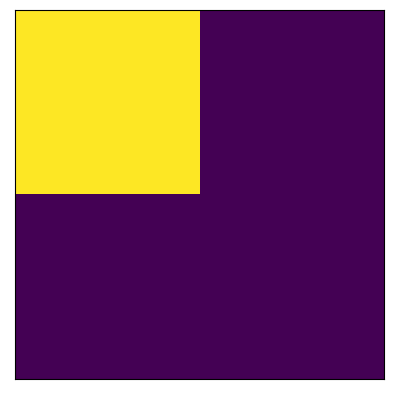

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


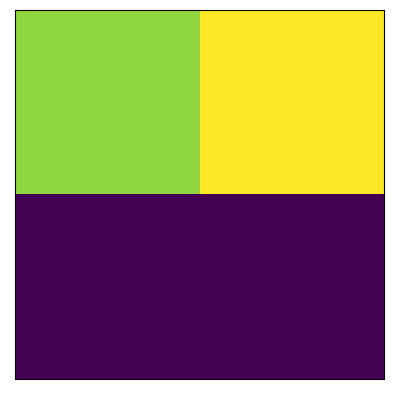

tf.Tensor(
[[0.1388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


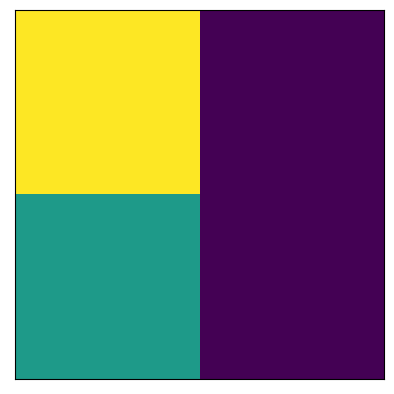

tf.Tensor(
[[0.30555555 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


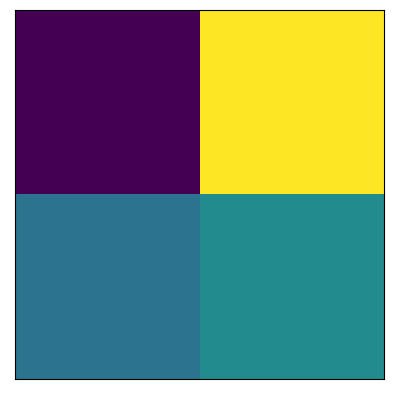

tf.Tensor(
[[0.22222215 1.8333334 ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


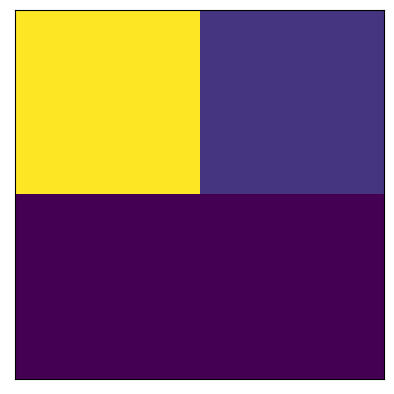

tf.Tensor(
[[3.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


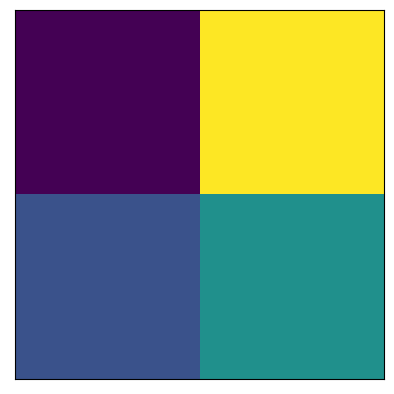

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


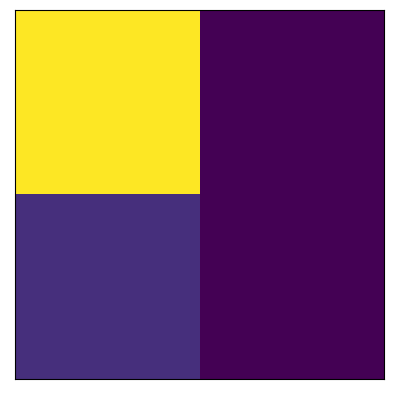

tf.Tensor(
[[3.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


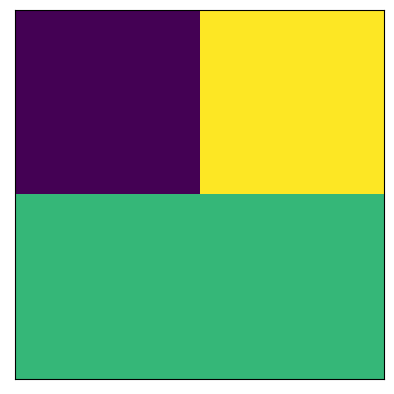

tf.Tensor(
[[0.  1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


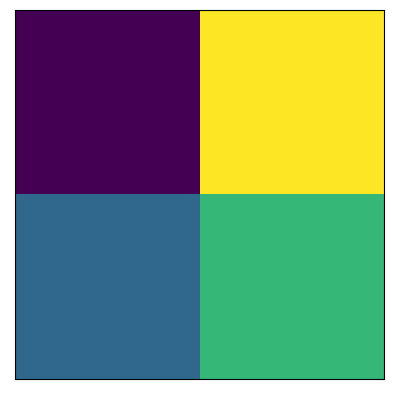

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


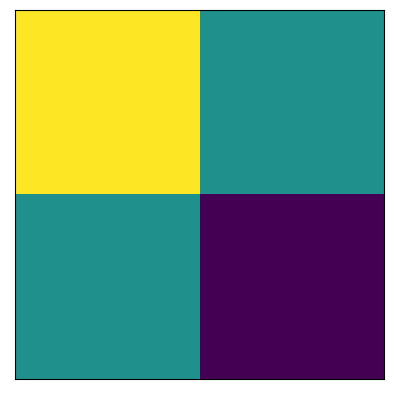

tf.Tensor(
[[1.  0.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


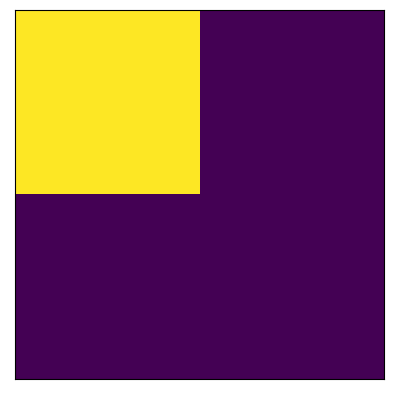

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


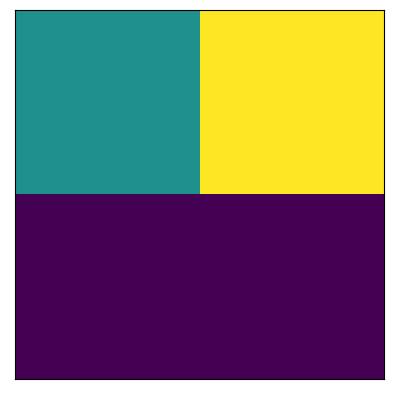

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


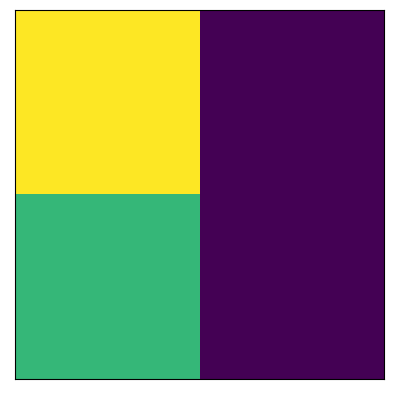

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


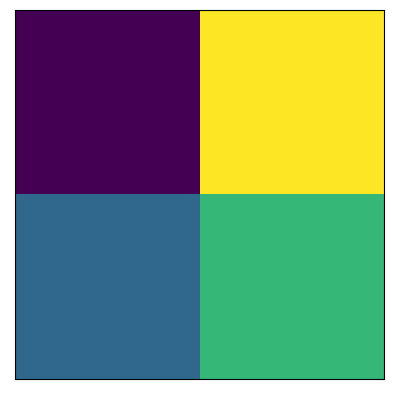

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


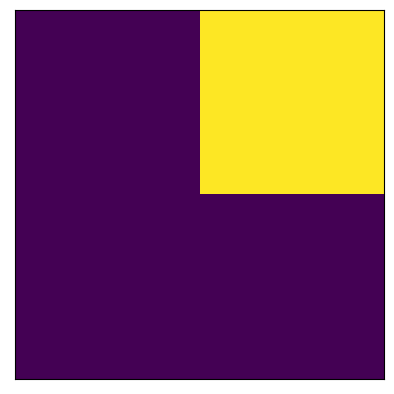

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


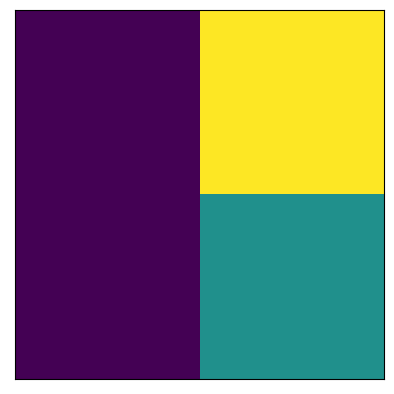

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


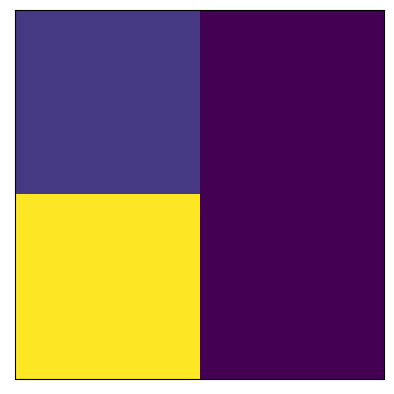

tf.Tensor(
[[1. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


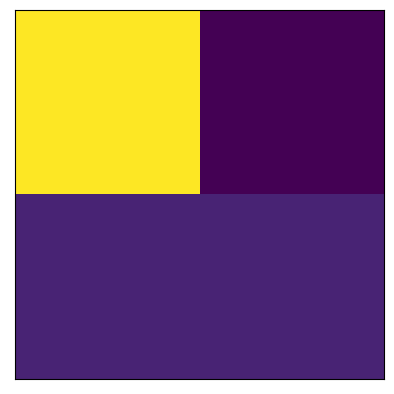

tf.Tensor(
[[10.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


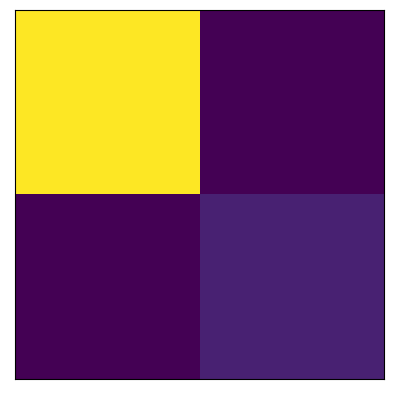

tf.Tensor(
[[11.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


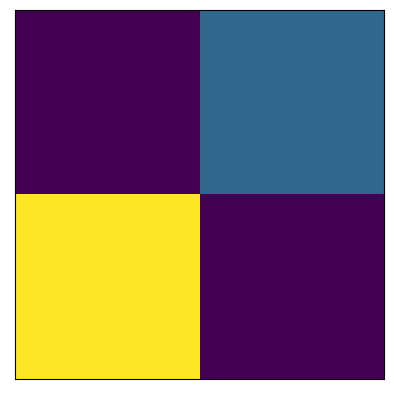

tf.Tensor(
[[0. 2.]
 [6. 0.]], shape=(2, 2), dtype=float32)


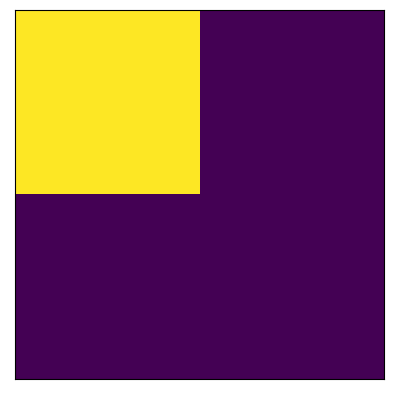

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


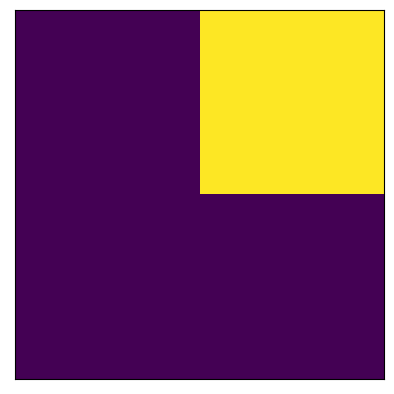

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


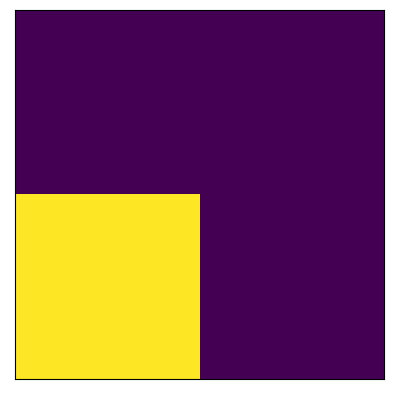

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


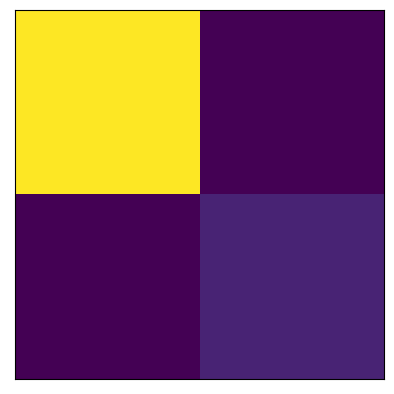

tf.Tensor(
[[10.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


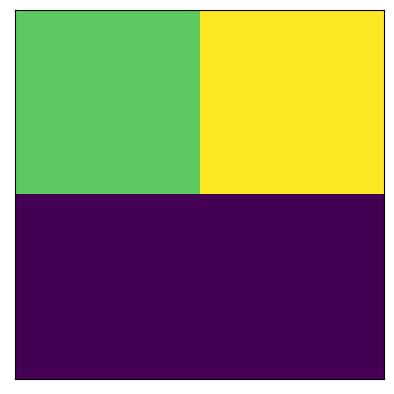

tf.Tensor(
[[3. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


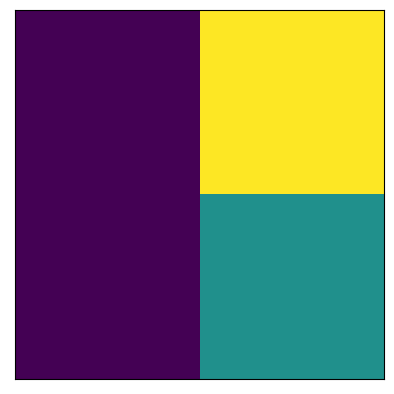

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


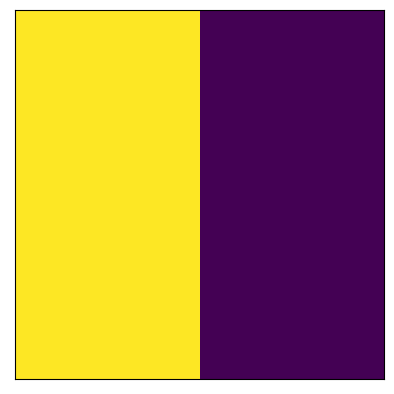

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


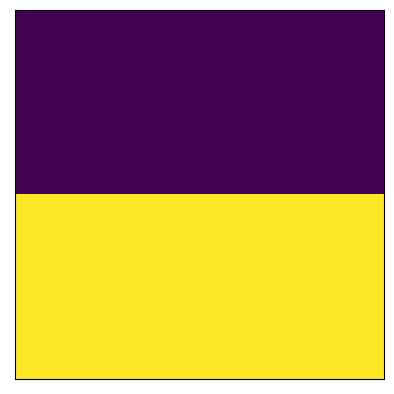

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


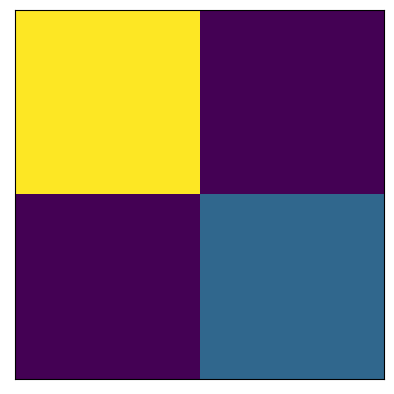

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


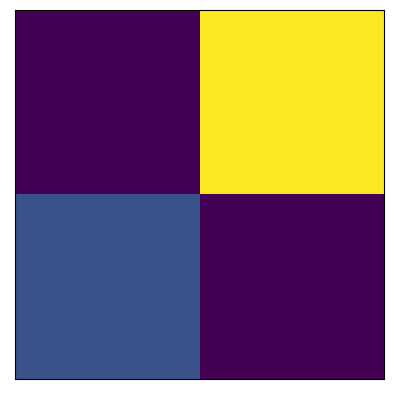

tf.Tensor(
[[0. 4.]
 [1. 0.]], shape=(2, 2), dtype=float32)


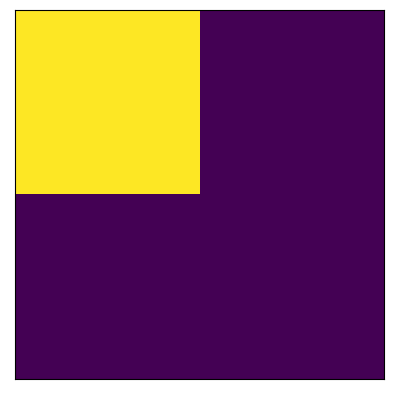

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


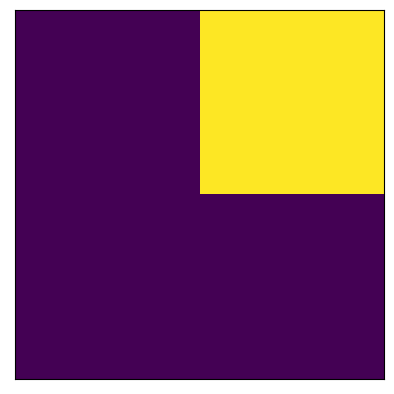

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


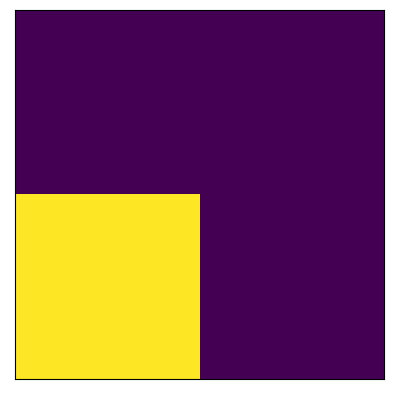

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


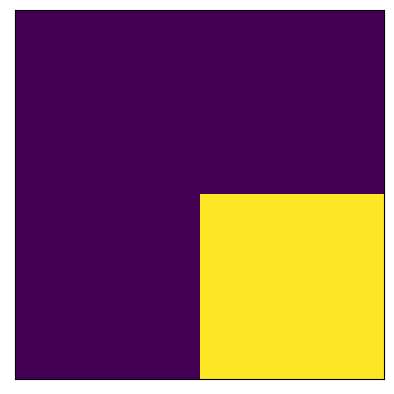

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


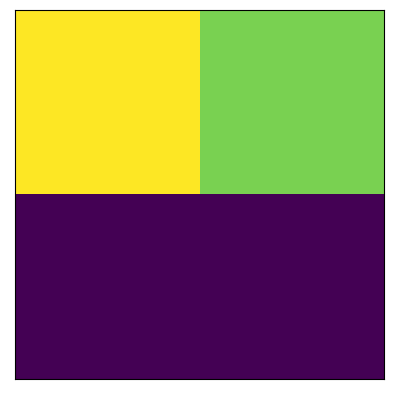

tf.Tensor(
[[0.3125 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


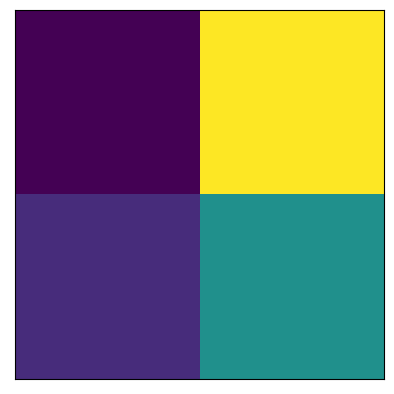

tf.Tensor(
[[0.   2.  ]
 [0.25 1.  ]], shape=(2, 2), dtype=float32)


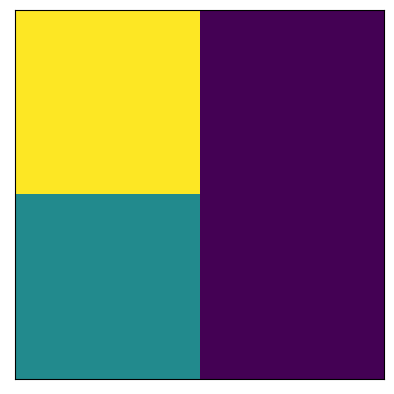

tf.Tensor(
[[1.5625 0.    ]
 [0.75   0.    ]], shape=(2, 2), dtype=float32)


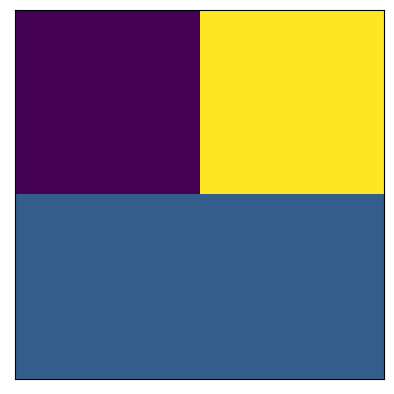

tf.Tensor(
[[0.6875 1.75  ]
 [1.     1.    ]], shape=(2, 2), dtype=float32)


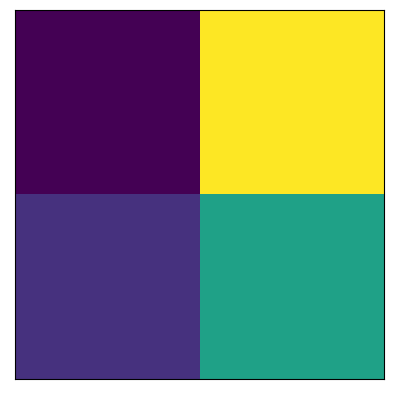

tf.Tensor(
[[0.   1.75]
 [0.25 1.  ]], shape=(2, 2), dtype=float32)


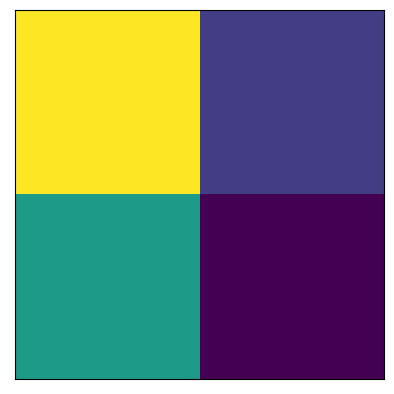

tf.Tensor(
[[1.375 0.25 ]
 [0.75  0.   ]], shape=(2, 2), dtype=float32)


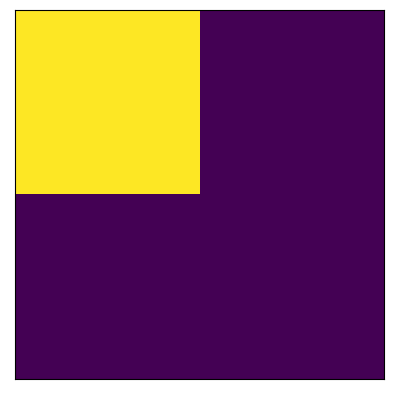

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


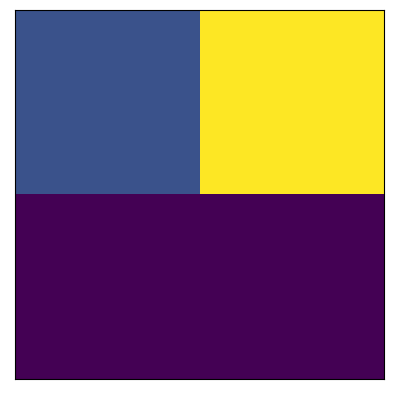

tf.Tensor(
[[0.0625 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


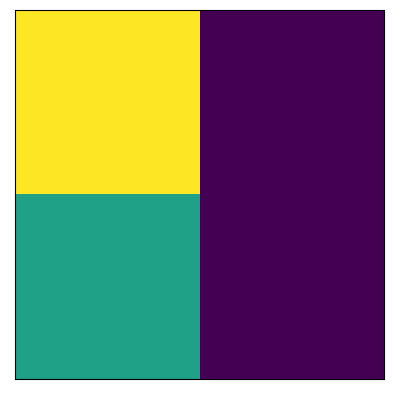

tf.Tensor(
[[1.3125 0.    ]
 [0.75   0.    ]], shape=(2, 2), dtype=float32)


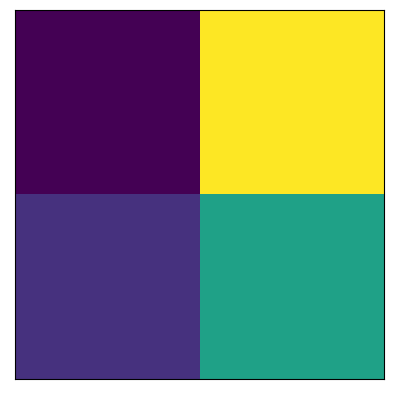

tf.Tensor(
[[0.   1.75]
 [0.25 1.  ]], shape=(2, 2), dtype=float32)


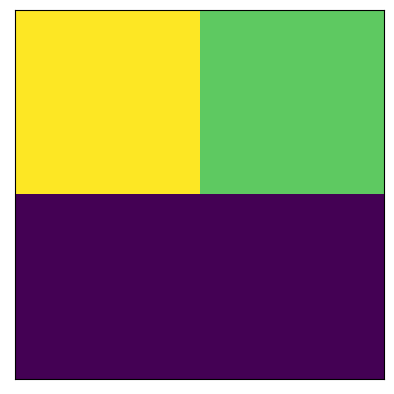

tf.Tensor(
[[4. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


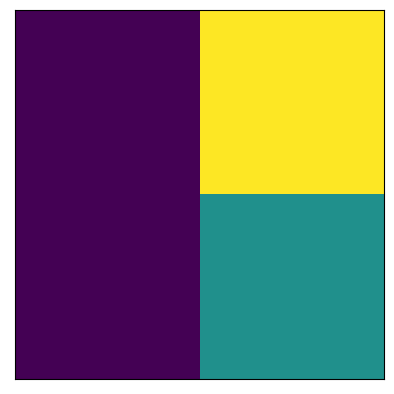

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


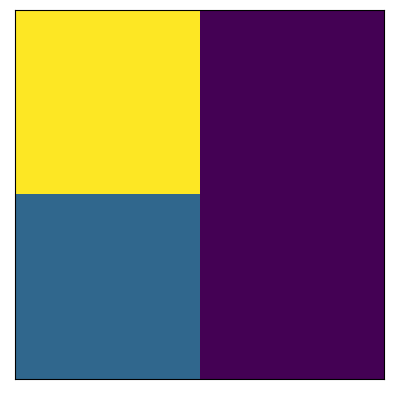

tf.Tensor(
[[3. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


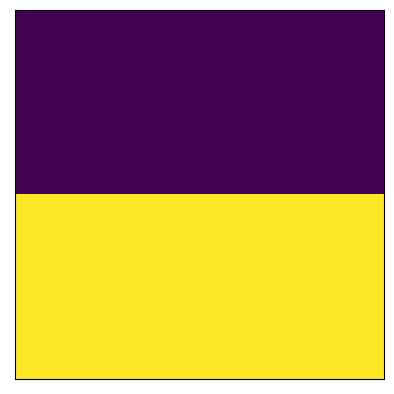

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


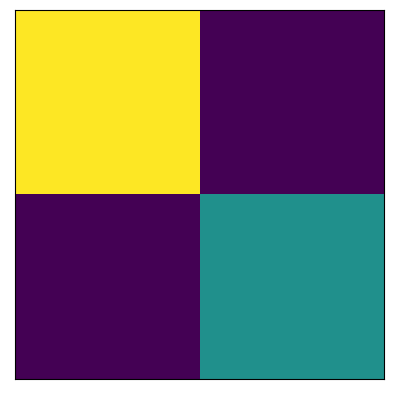

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


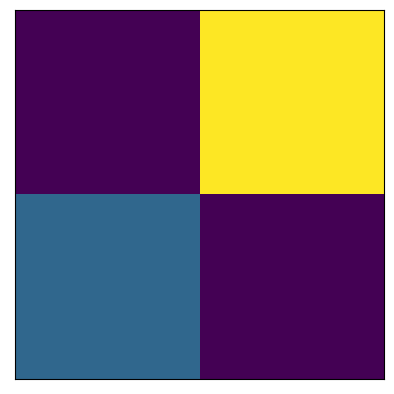

tf.Tensor(
[[0. 3.]
 [1. 0.]], shape=(2, 2), dtype=float32)


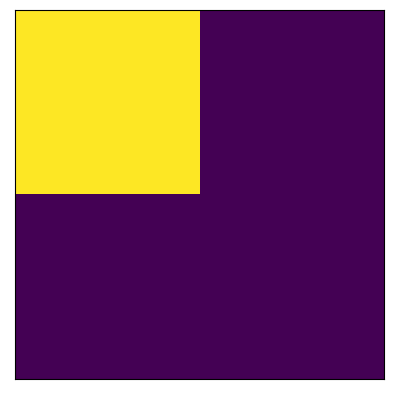

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


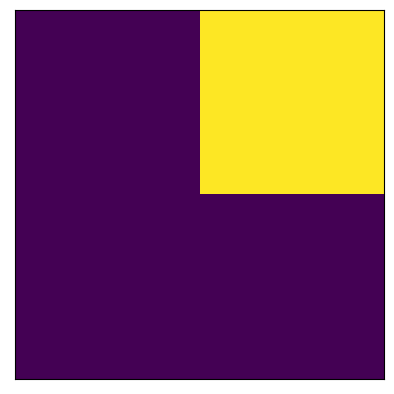

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


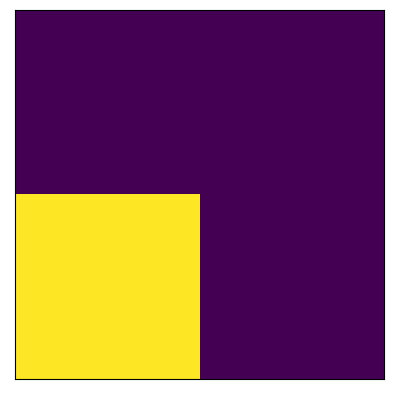

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


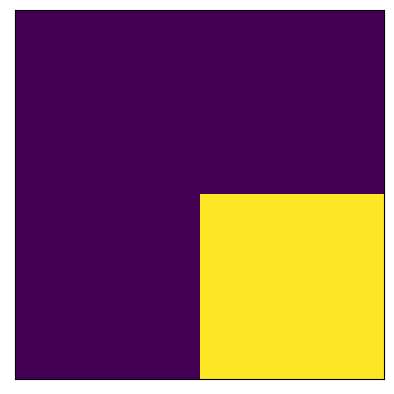

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


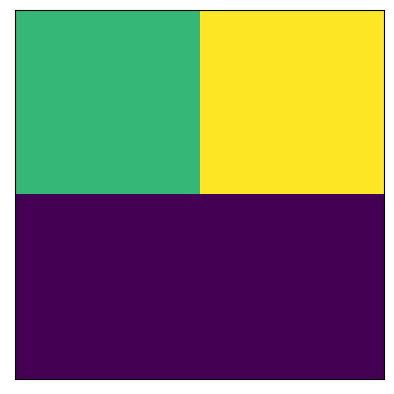

tf.Tensor(
[[0.22222221 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


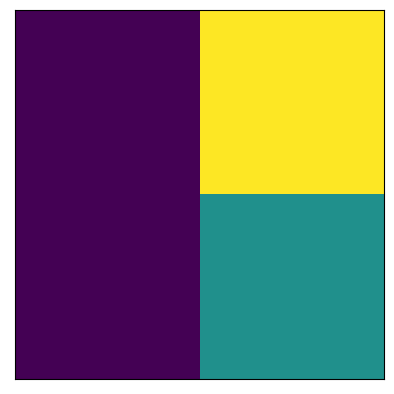

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


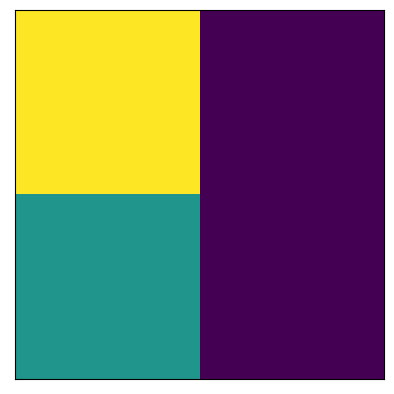

tf.Tensor(
[[2.5555556 0.       ]
 [1.3333334 0.       ]], shape=(2, 2), dtype=float32)


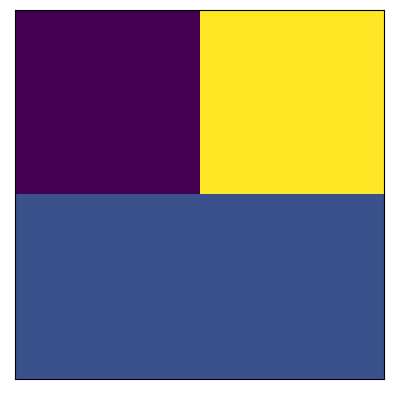

tf.Tensor(
[[0.77777773 1.6666666 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


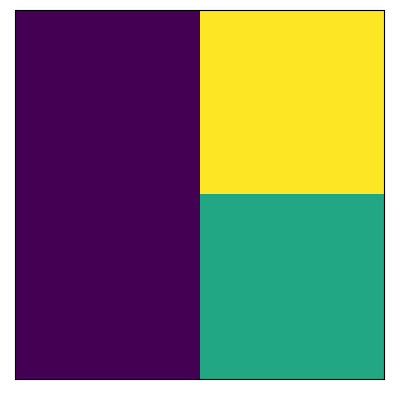

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


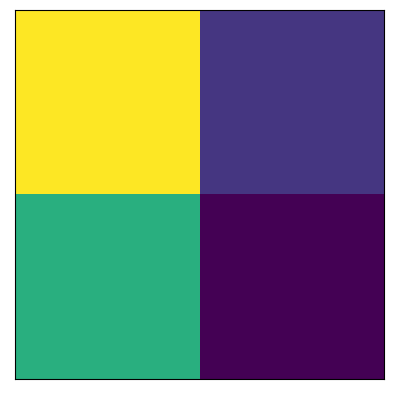

tf.Tensor(
[[2.1111112  0.33333334]
 [1.3333334  0.        ]], shape=(2, 2), dtype=float32)


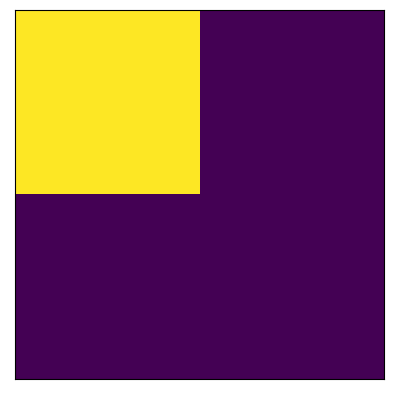

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


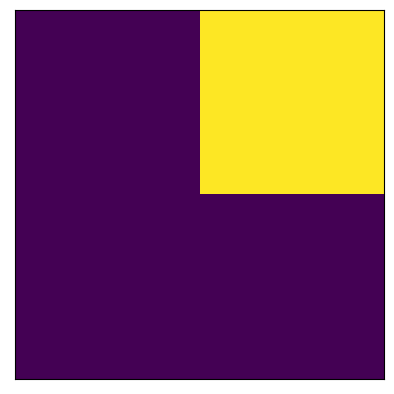

tf.Tensor(
[[0.         0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


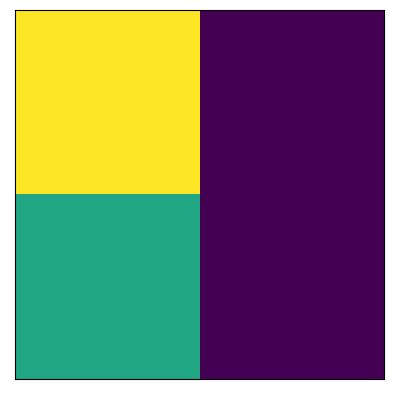

tf.Tensor(
[[2.2222223 0.       ]
 [1.3333334 0.       ]], shape=(2, 2), dtype=float32)


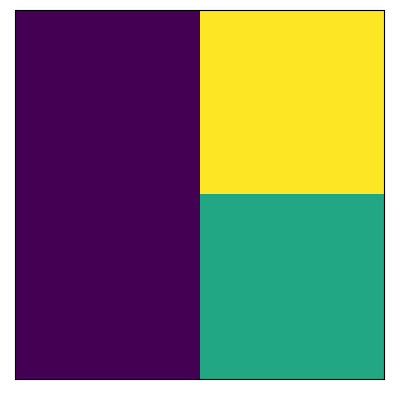

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


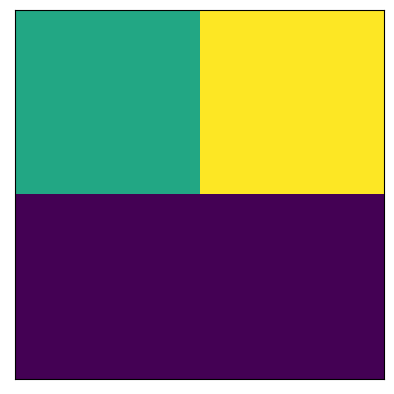

tf.Tensor(
[[3. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


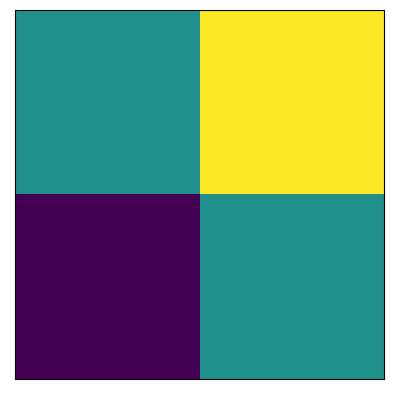

tf.Tensor(
[[1. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


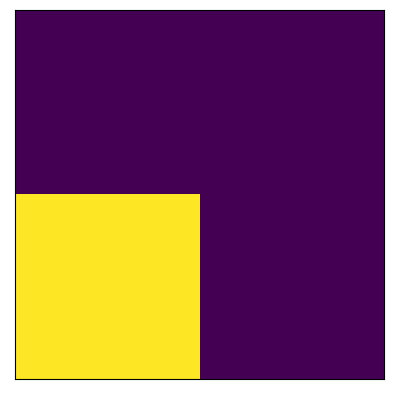

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


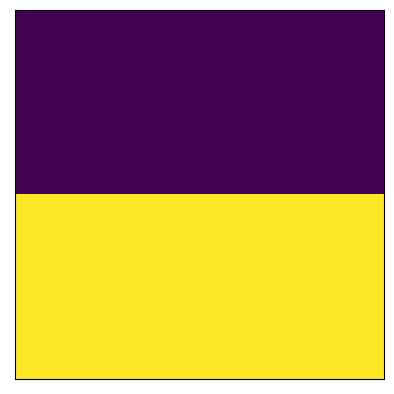

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


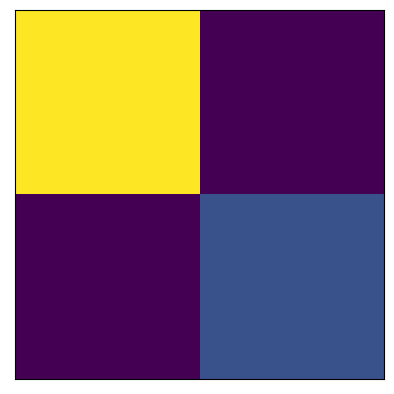

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


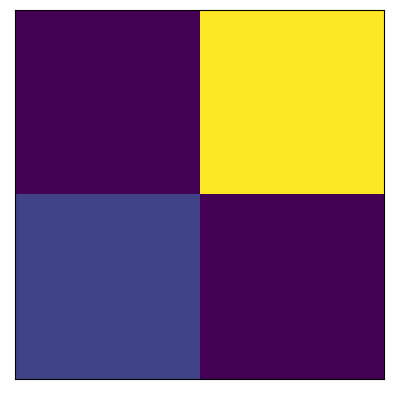

tf.Tensor(
[[0. 5.]
 [1. 0.]], shape=(2, 2), dtype=float32)


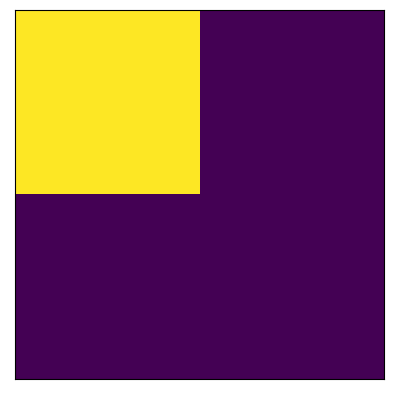

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


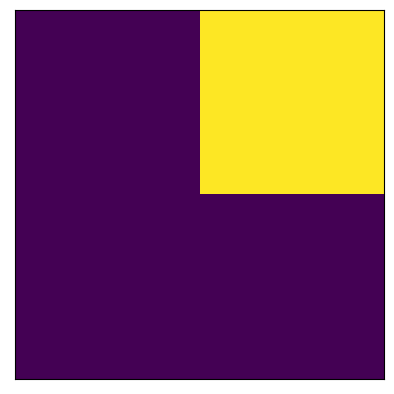

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


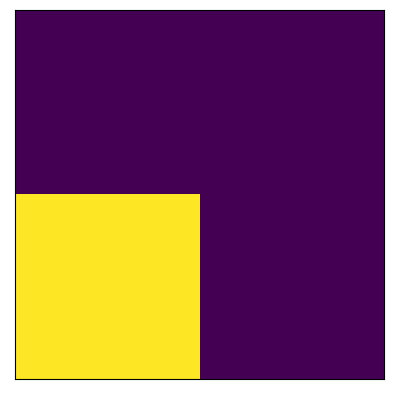

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


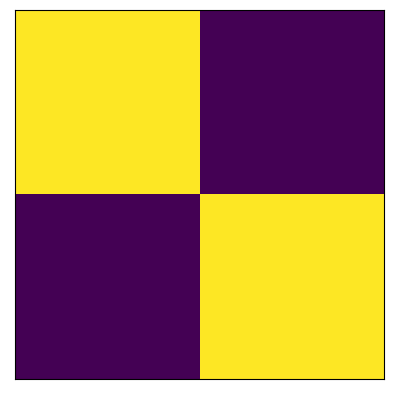

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


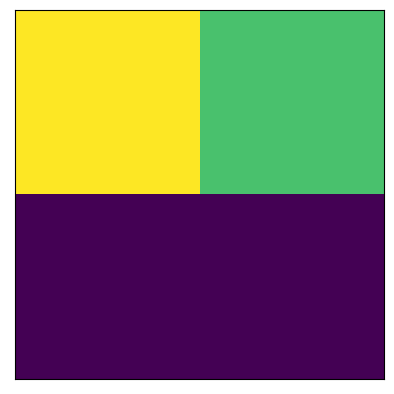

tf.Tensor(
[[0.28 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


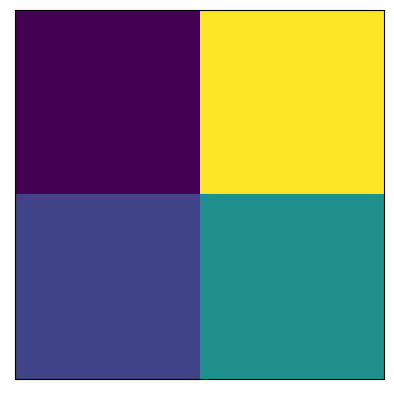

tf.Tensor(
[[0.         2.        ]
 [0.39999998 1.        ]], shape=(2, 2), dtype=float32)


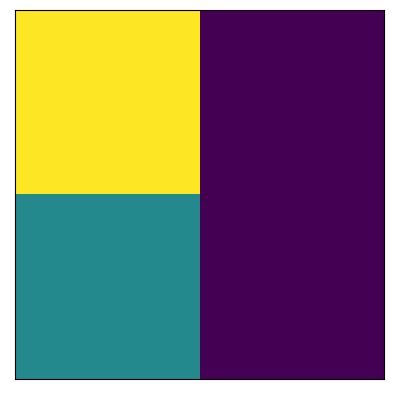

tf.Tensor(
[[1.2800001 0.       ]
 [0.6       0.       ]], shape=(2, 2), dtype=float32)


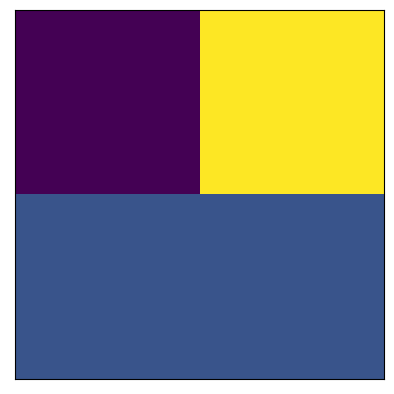

tf.Tensor(
[[0.72 1.8 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


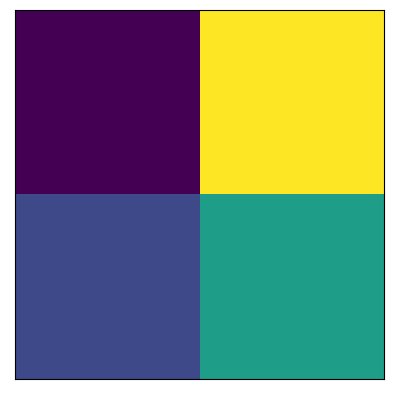

tf.Tensor(
[[0.         1.8       ]
 [0.39999998 1.        ]], shape=(2, 2), dtype=float32)


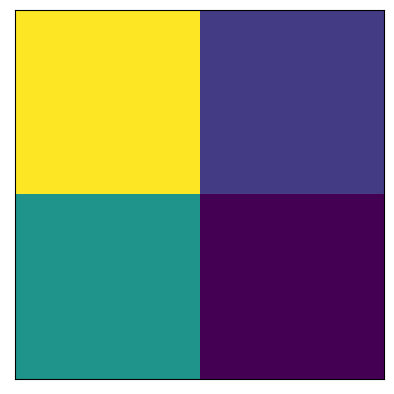

tf.Tensor(
[[1.1600001 0.2      ]
 [0.6       0.       ]], shape=(2, 2), dtype=float32)


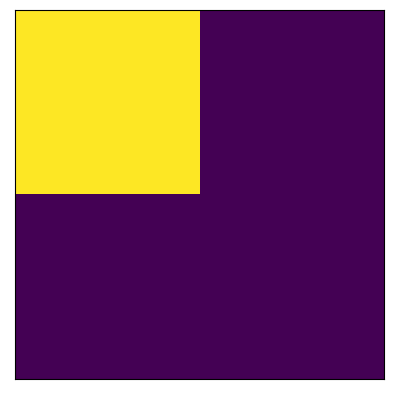

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


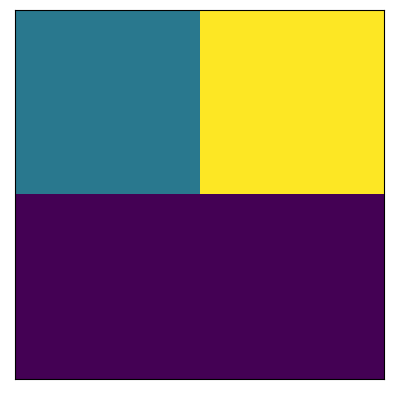

tf.Tensor(
[[0.08000001 0.2       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


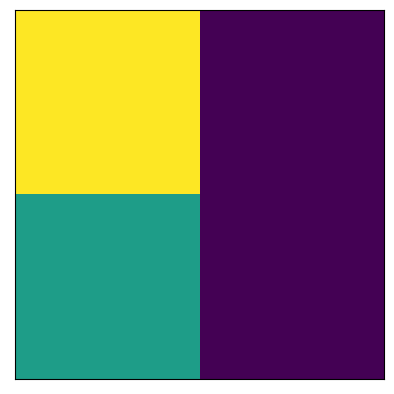

tf.Tensor(
[[1.08 0.  ]
 [0.6  0.  ]], shape=(2, 2), dtype=float32)


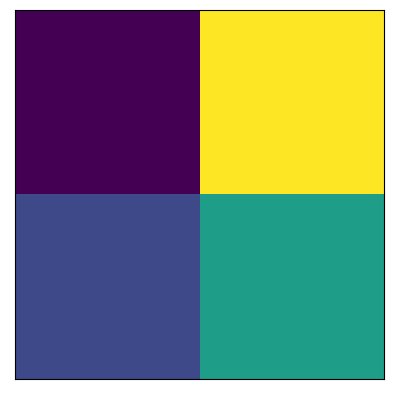

tf.Tensor(
[[0.         1.8       ]
 [0.39999998 1.        ]], shape=(2, 2), dtype=float32)


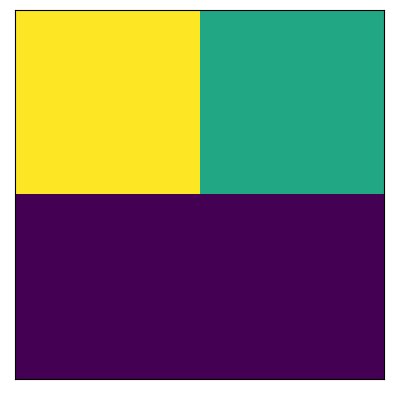

tf.Tensor(
[[5. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


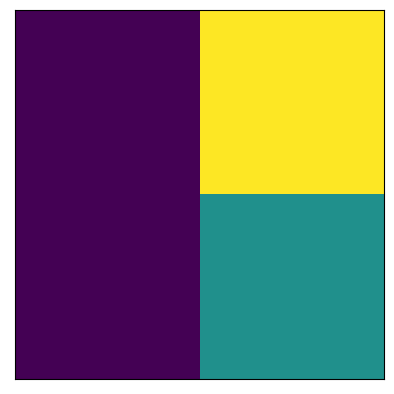

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


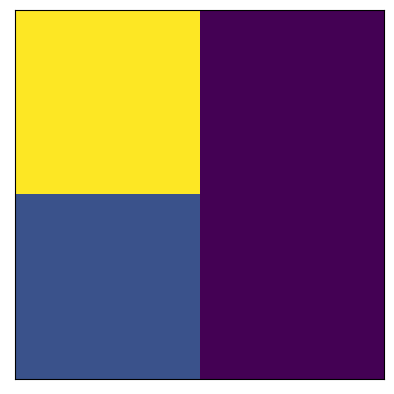

tf.Tensor(
[[4. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


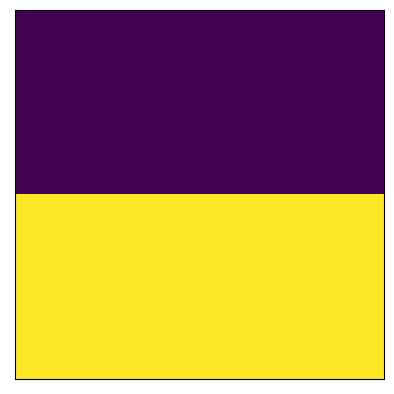

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


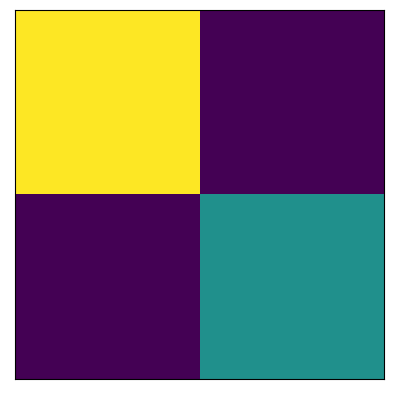

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


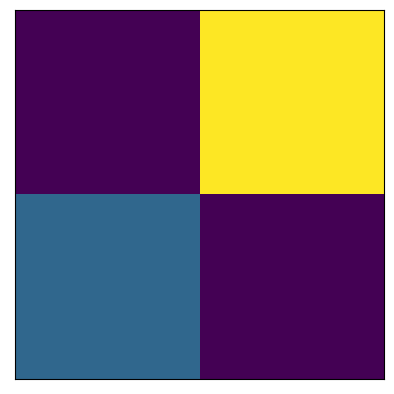

tf.Tensor(
[[0. 3.]
 [1. 0.]], shape=(2, 2), dtype=float32)


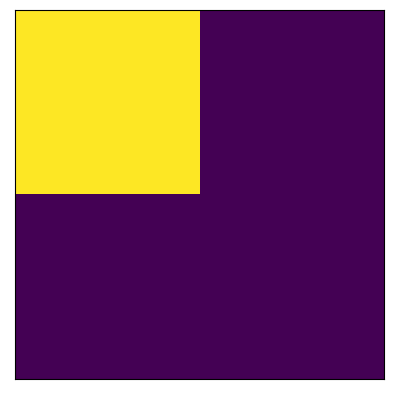

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


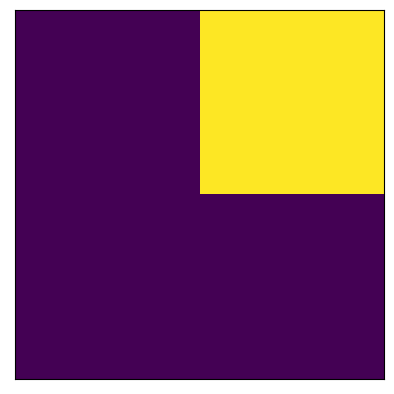

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


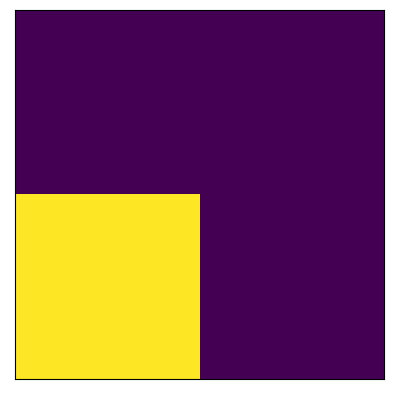

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


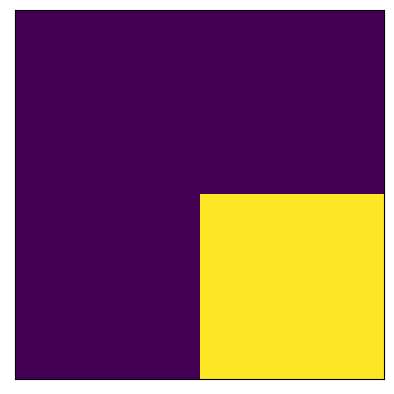

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


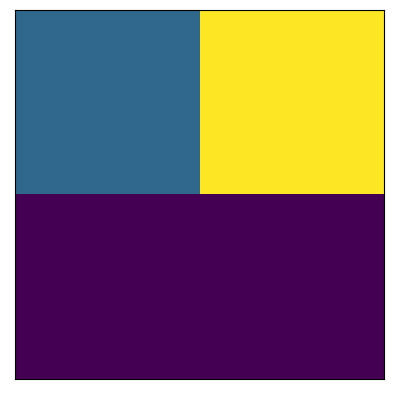

tf.Tensor(
[[0.11111113 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


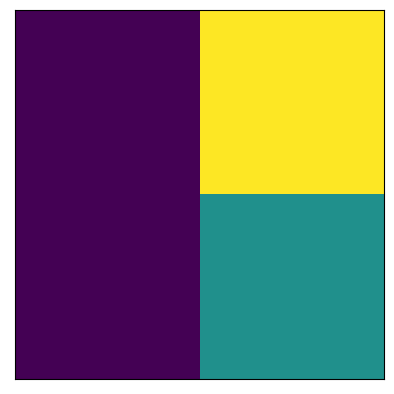

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


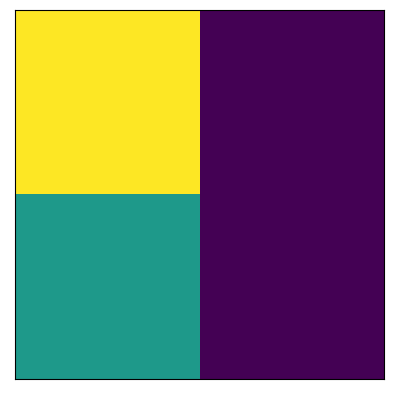

tf.Tensor(
[[3.1111112 0.       ]
 [1.6666666 0.       ]], shape=(2, 2), dtype=float32)


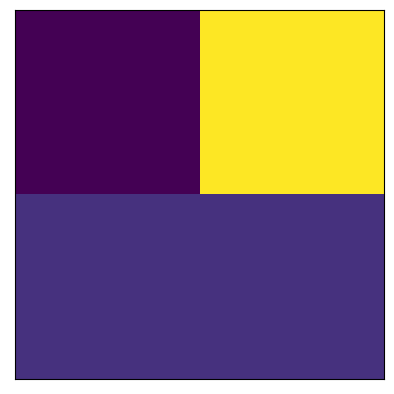

tf.Tensor(
[[0.88888884 1.6666666 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


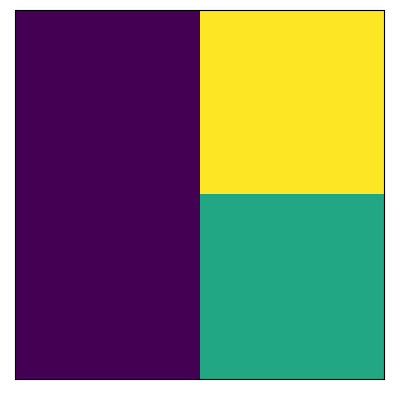

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


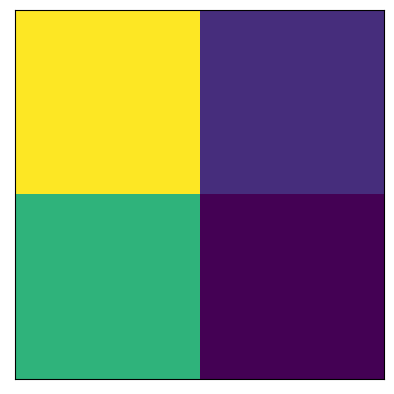

tf.Tensor(
[[2.5555553  0.33333334]
 [1.6666666  0.        ]], shape=(2, 2), dtype=float32)


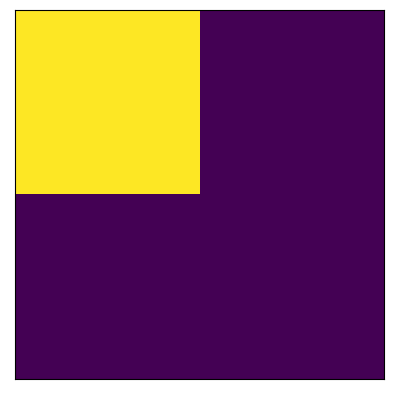

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


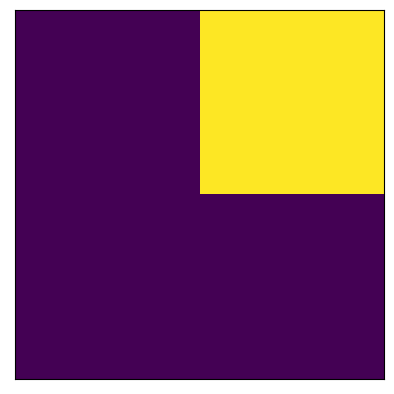

tf.Tensor(
[[0.         0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


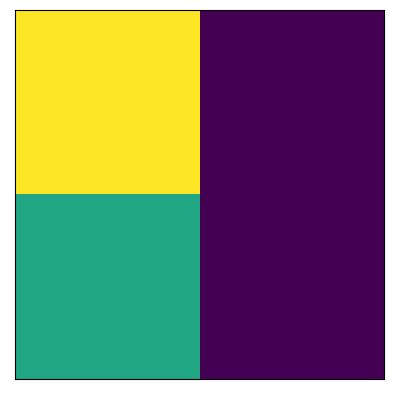

tf.Tensor(
[[2.7777777 0.       ]
 [1.6666666 0.       ]], shape=(2, 2), dtype=float32)


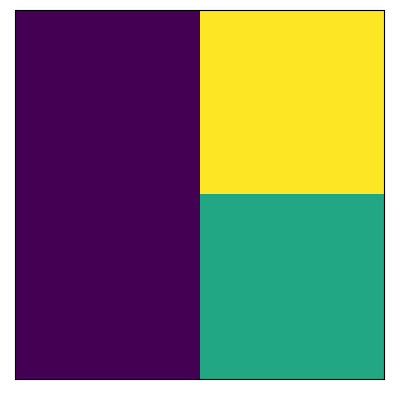

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


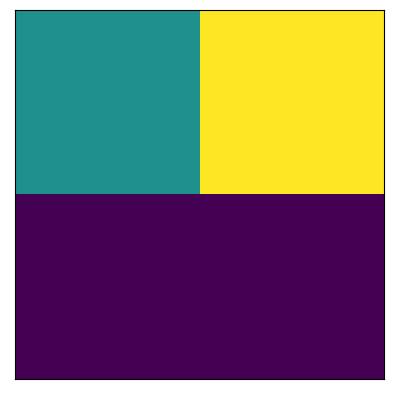

tf.Tensor(
[[3. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


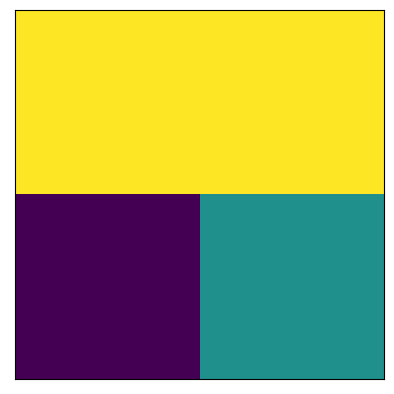

tf.Tensor(
[[2. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


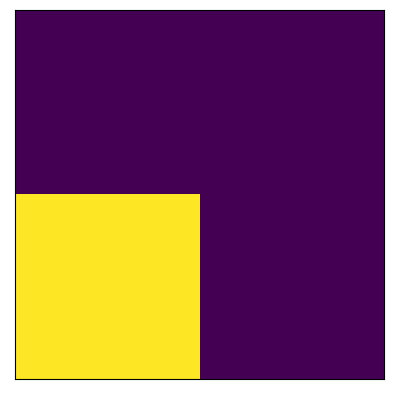

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


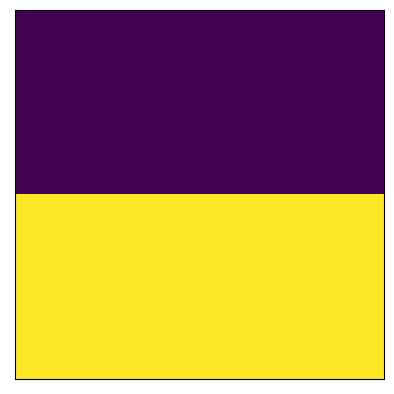

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


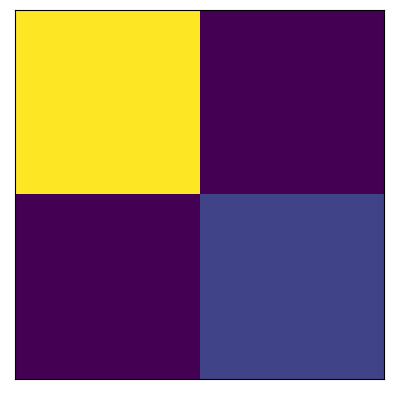

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


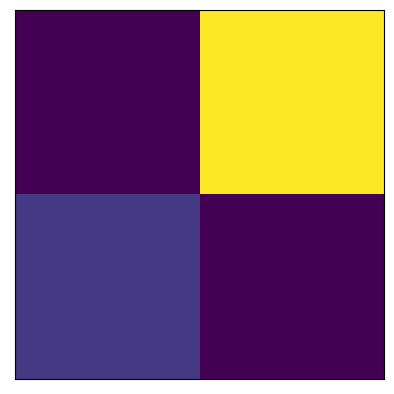

tf.Tensor(
[[0. 6.]
 [1. 0.]], shape=(2, 2), dtype=float32)


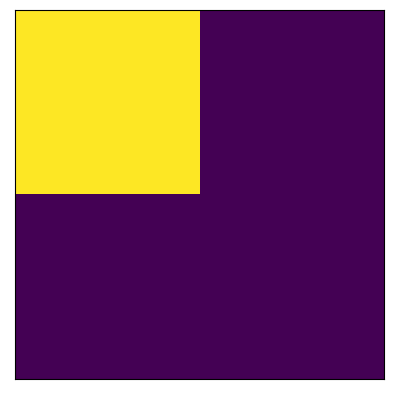

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


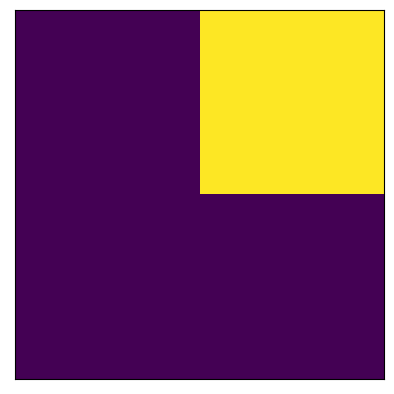

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


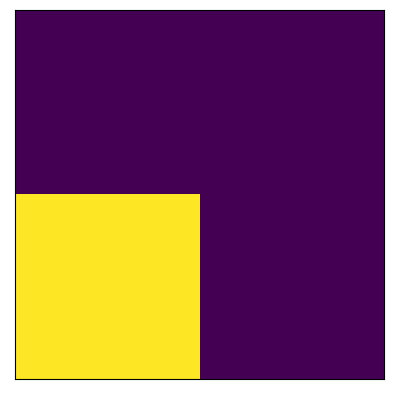

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


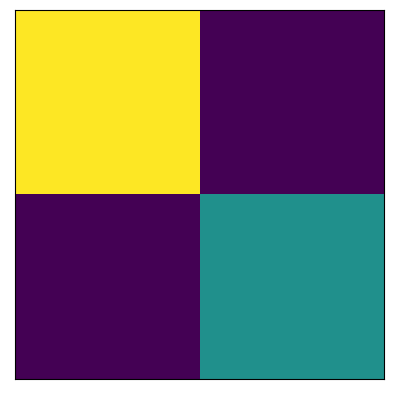

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


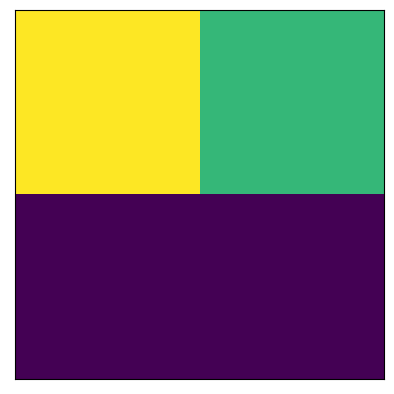

tf.Tensor(
[[0.25       0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


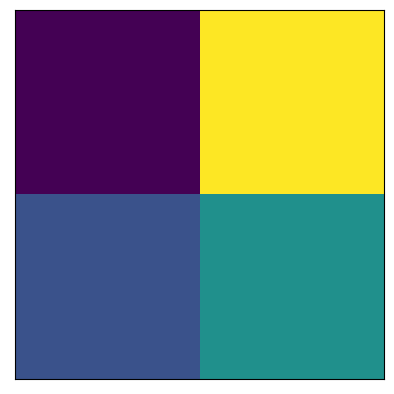

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


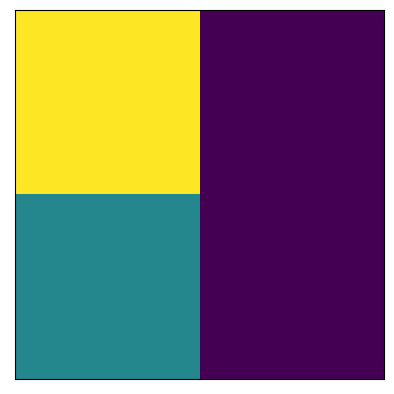

tf.Tensor(
[[1.0833334 0.       ]
 [0.5       0.       ]], shape=(2, 2), dtype=float32)


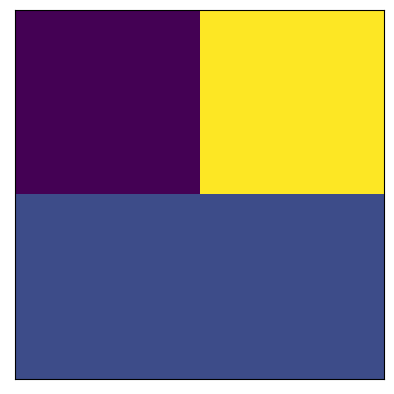

tf.Tensor(
[[0.75      1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


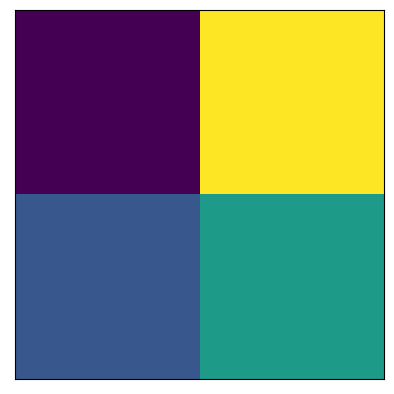

tf.Tensor(
[[0.        1.8333334]
 [0.5       1.       ]], shape=(2, 2), dtype=float32)


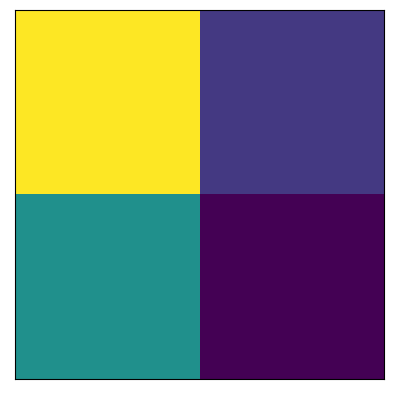

tf.Tensor(
[[0.99999994 0.16666667]
 [0.5        0.        ]], shape=(2, 2), dtype=float32)


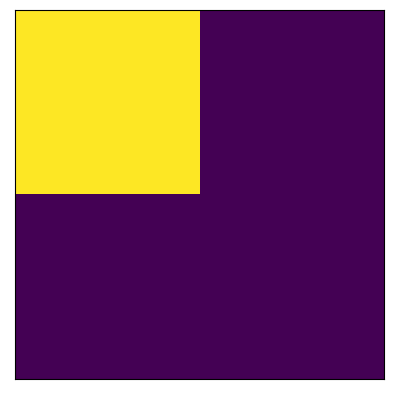

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


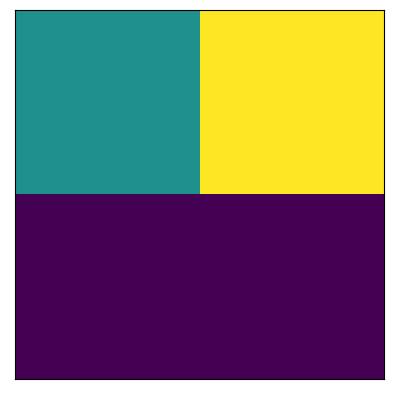

tf.Tensor(
[[0.08333334 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


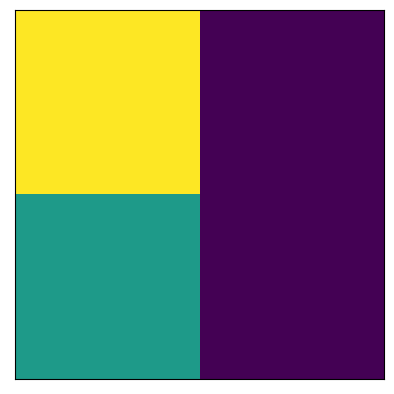

tf.Tensor(
[[0.9166667 0.       ]
 [0.5       0.       ]], shape=(2, 2), dtype=float32)


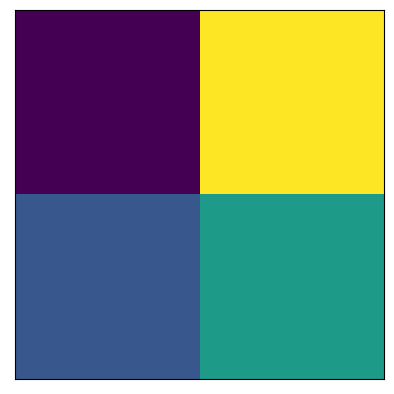

tf.Tensor(
[[0.        1.8333334]
 [0.5       1.       ]], shape=(2, 2), dtype=float32)


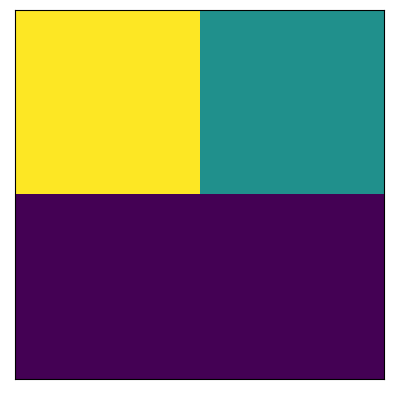

tf.Tensor(
[[6. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


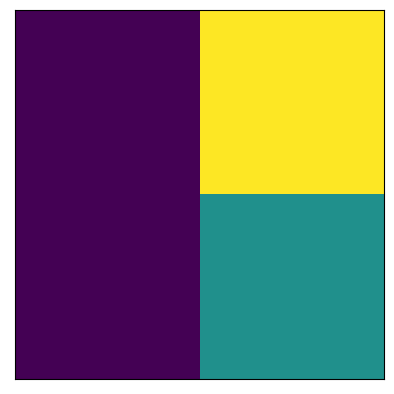

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


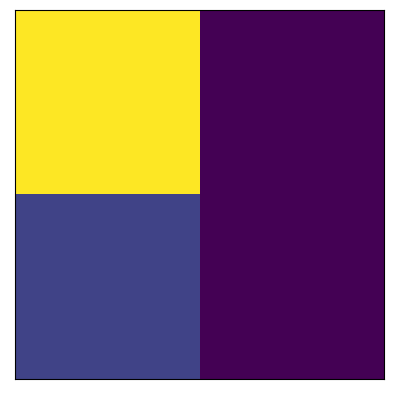

tf.Tensor(
[[5. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


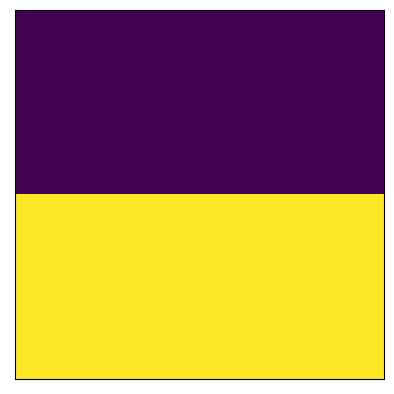

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


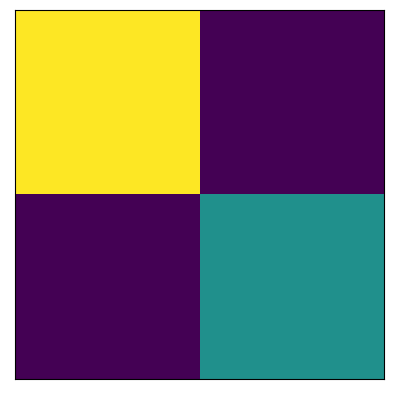

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


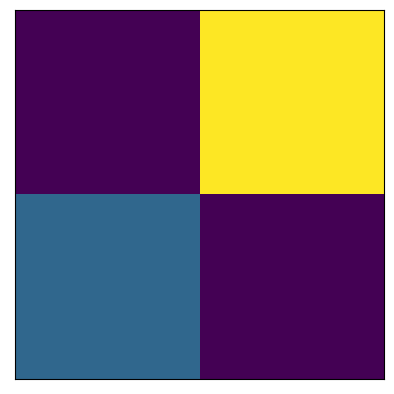

tf.Tensor(
[[0. 3.]
 [1. 0.]], shape=(2, 2), dtype=float32)


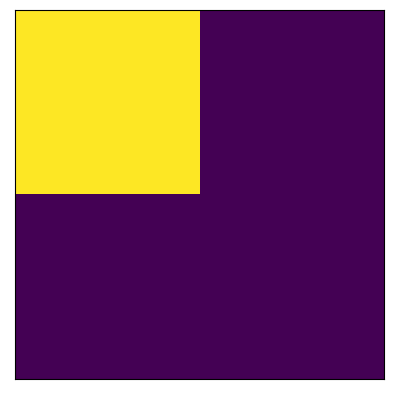

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


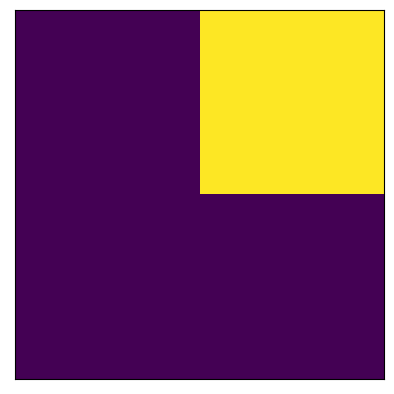

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


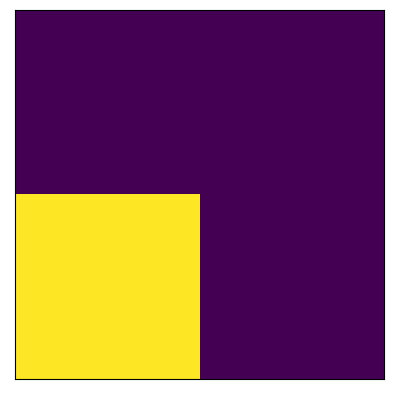

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


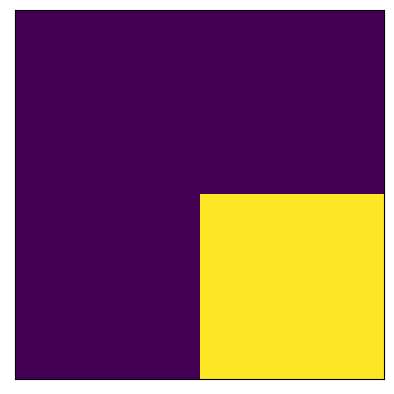

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


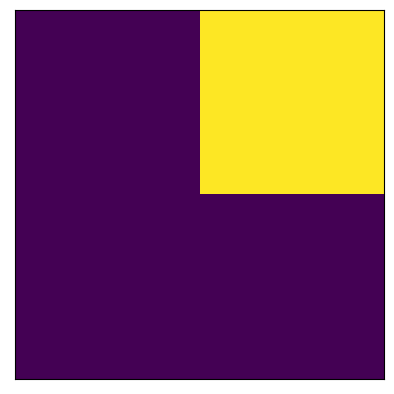

tf.Tensor(
[[0.         0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


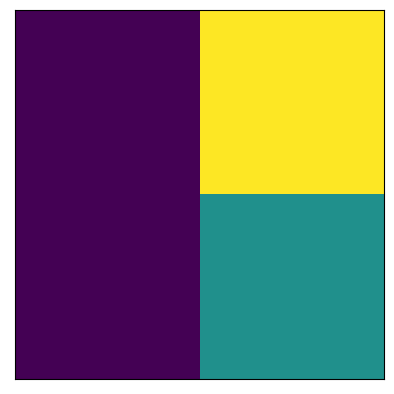

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


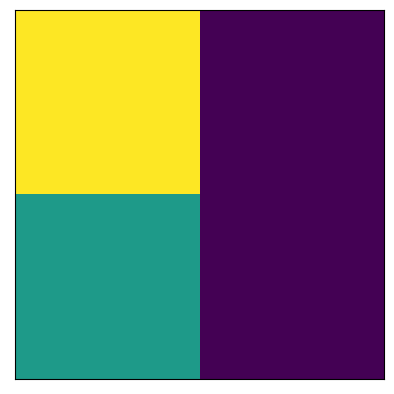

tf.Tensor(
[[3.6666667 0.       ]
 [2.        0.       ]], shape=(2, 2), dtype=float32)


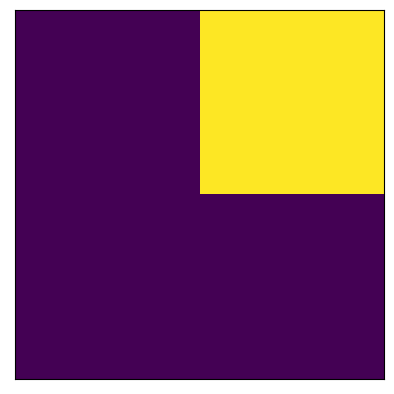

tf.Tensor(
[[1.        1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


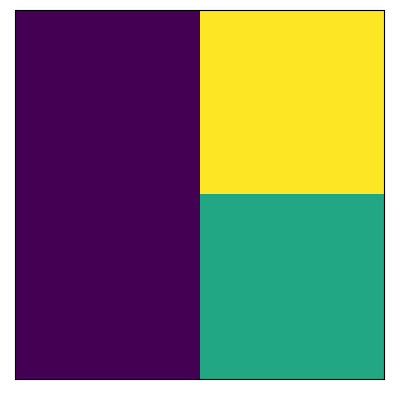

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


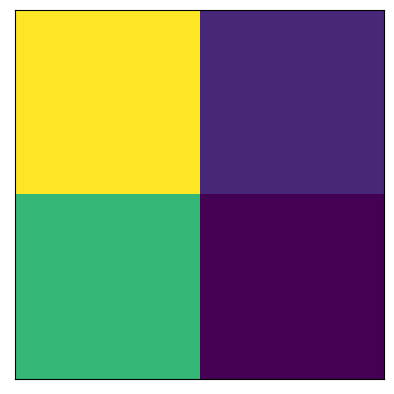

tf.Tensor(
[[3.         0.33333334]
 [2.         0.        ]], shape=(2, 2), dtype=float32)


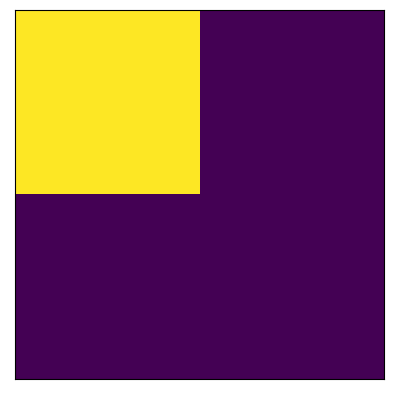

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


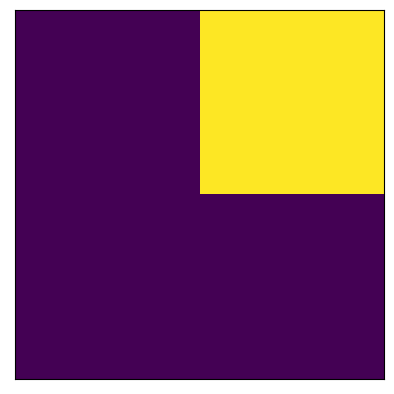

tf.Tensor(
[[0.         0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


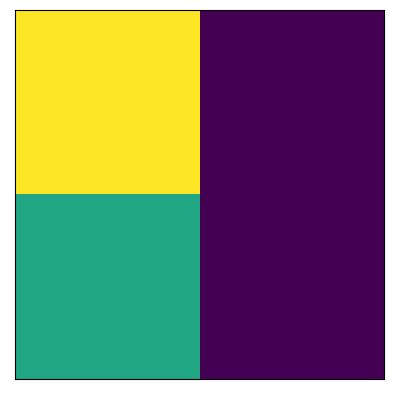

tf.Tensor(
[[3.3333333 0.       ]
 [2.        0.       ]], shape=(2, 2), dtype=float32)


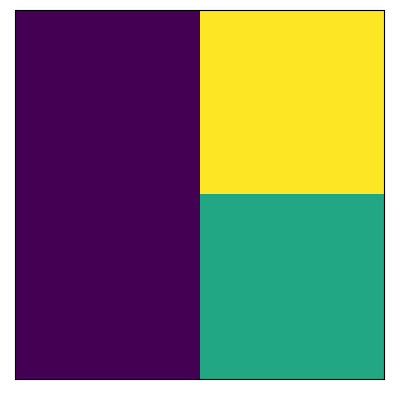

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


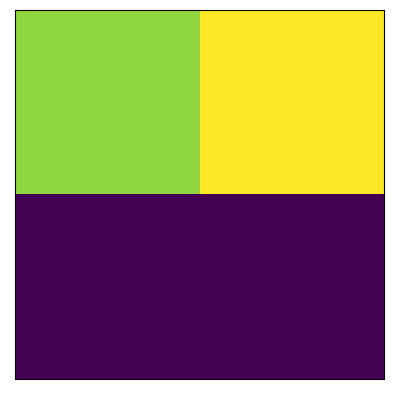

tf.Tensor(
[[5. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


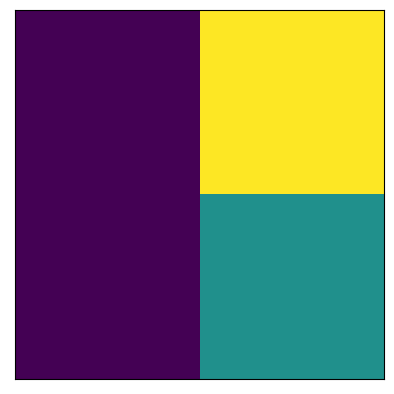

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


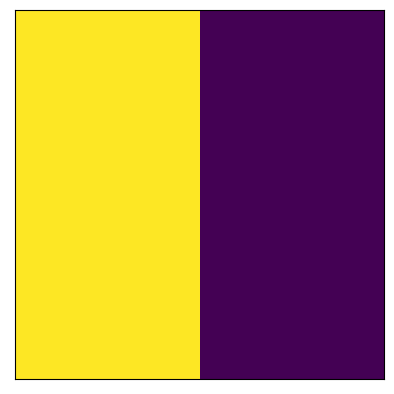

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


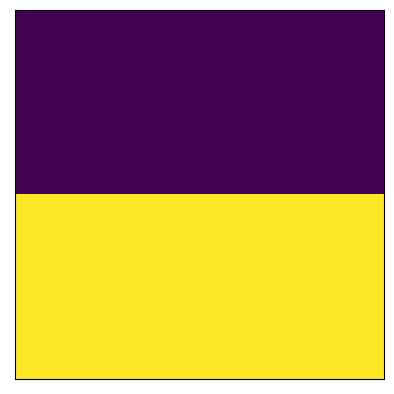

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


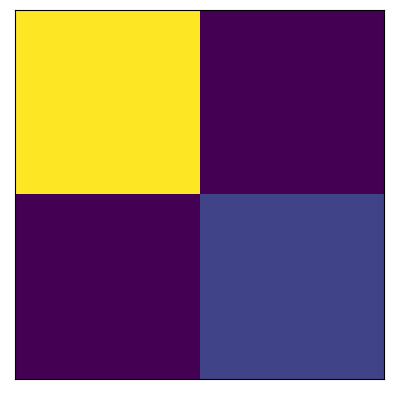

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


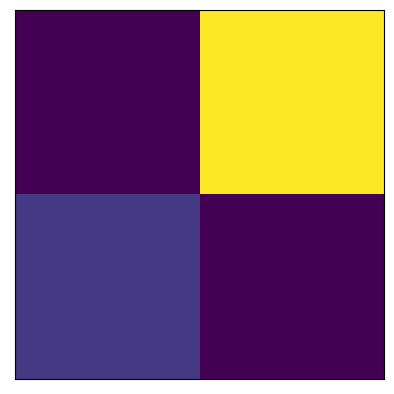

tf.Tensor(
[[0. 6.]
 [1. 0.]], shape=(2, 2), dtype=float32)


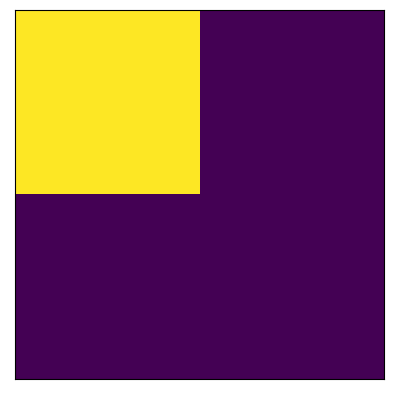

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


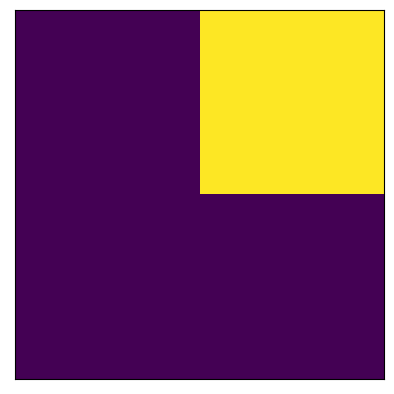

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


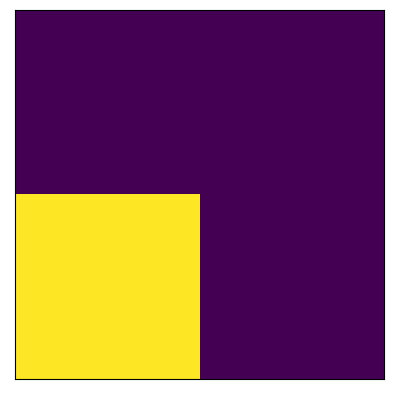

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


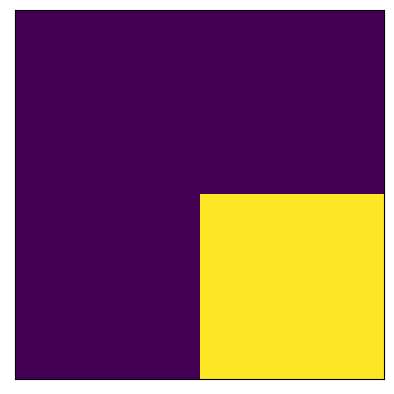

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


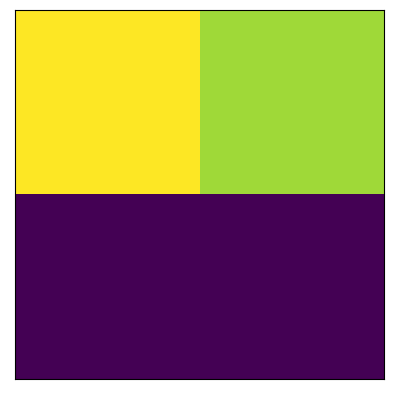

tf.Tensor(
[[0.19444445 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


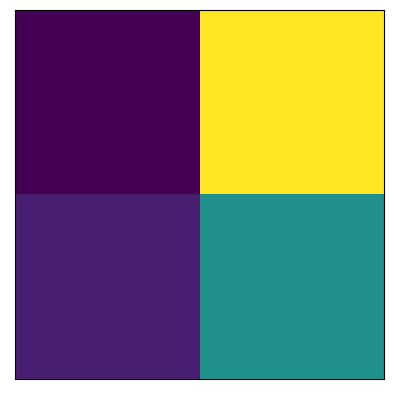

tf.Tensor(
[[0.         2.        ]
 [0.16666669 1.        ]], shape=(2, 2), dtype=float32)


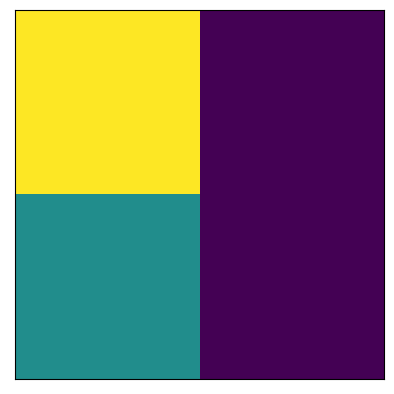

tf.Tensor(
[[1.6944444 0.       ]
 [0.8333333 0.       ]], shape=(2, 2), dtype=float32)


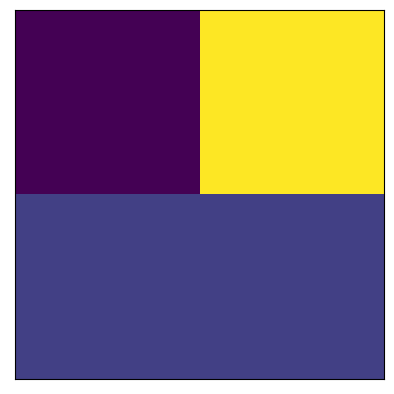

tf.Tensor(
[[0.8055555 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


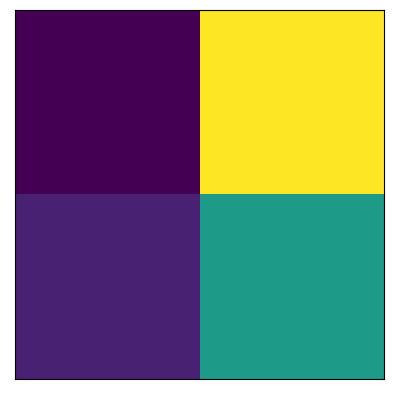

tf.Tensor(
[[0.         1.8333334 ]
 [0.16666669 1.        ]], shape=(2, 2), dtype=float32)


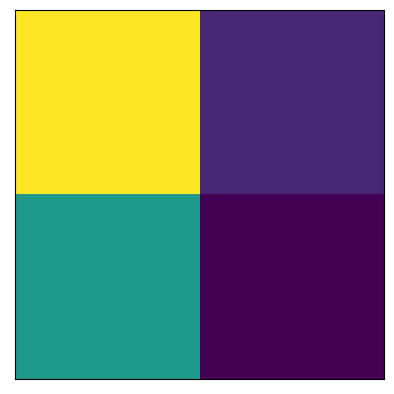

tf.Tensor(
[[1.5555555  0.16666667]
 [0.8333333  0.        ]], shape=(2, 2), dtype=float32)


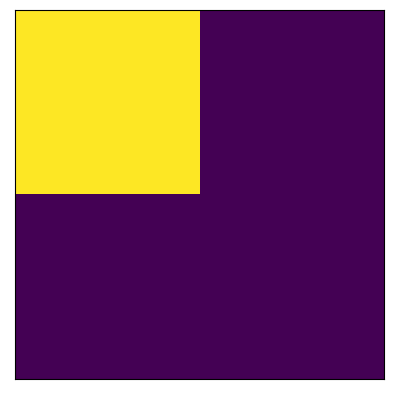

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


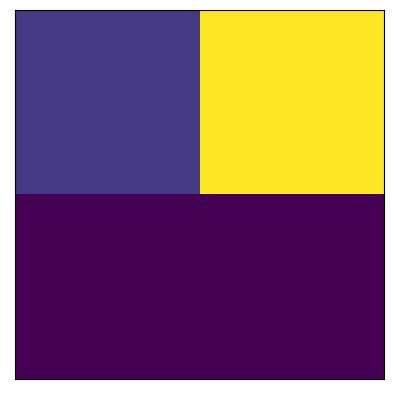

tf.Tensor(
[[0.02777778 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


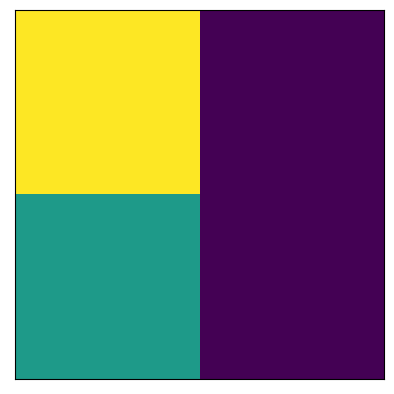

tf.Tensor(
[[1.5277777 0.       ]
 [0.8333333 0.       ]], shape=(2, 2), dtype=float32)


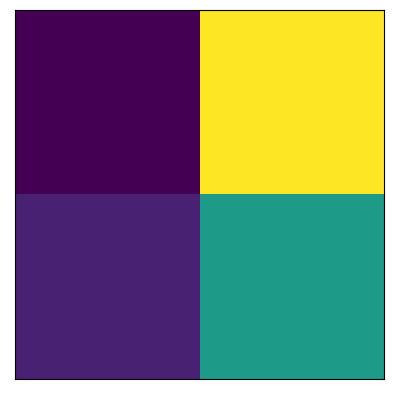

tf.Tensor(
[[0.         1.8333334 ]
 [0.16666669 1.        ]], shape=(2, 2), dtype=float32)


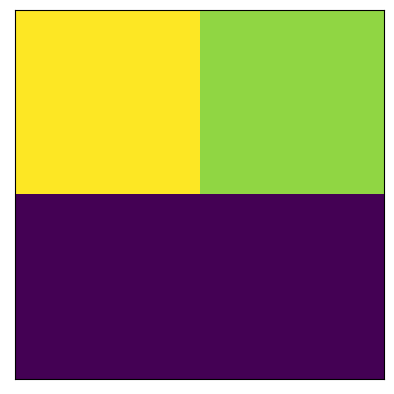

tf.Tensor(
[[6. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


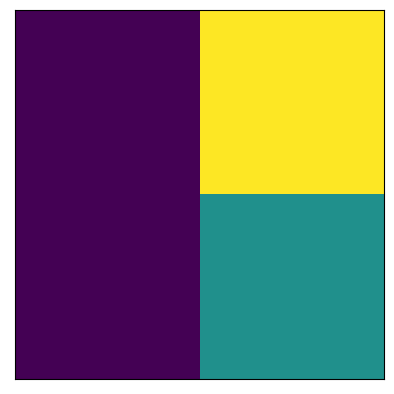

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


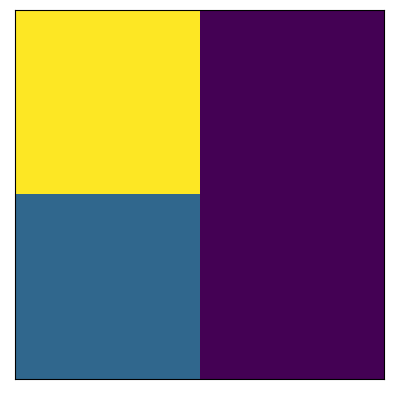

tf.Tensor(
[[3. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


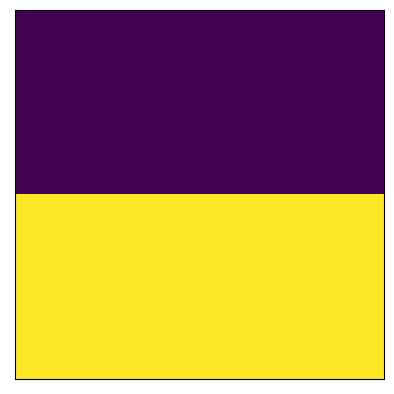

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


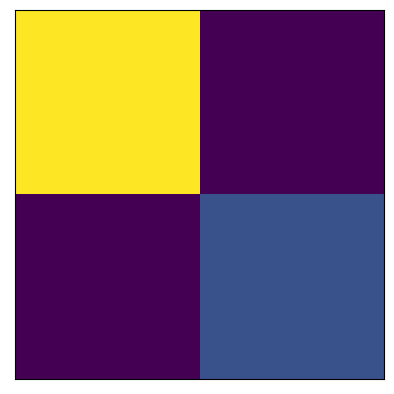

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


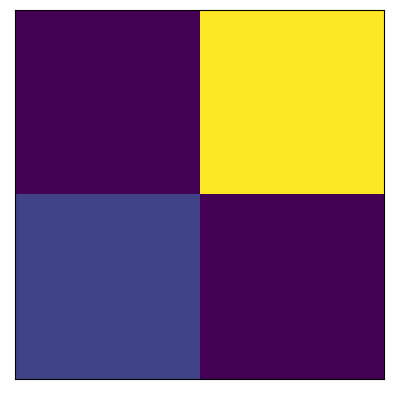

tf.Tensor(
[[0. 5.]
 [1. 0.]], shape=(2, 2), dtype=float32)


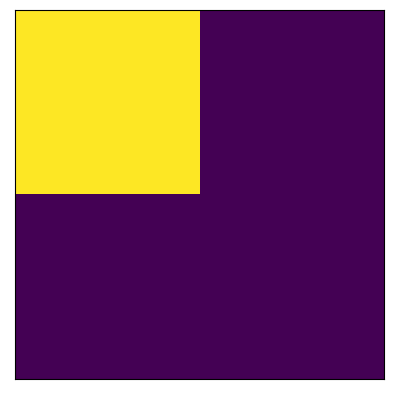

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


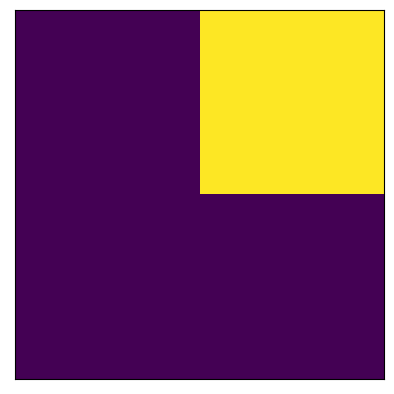

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


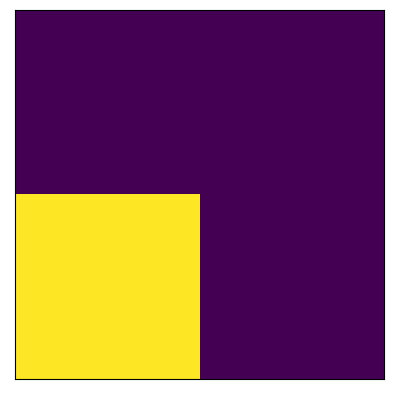

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


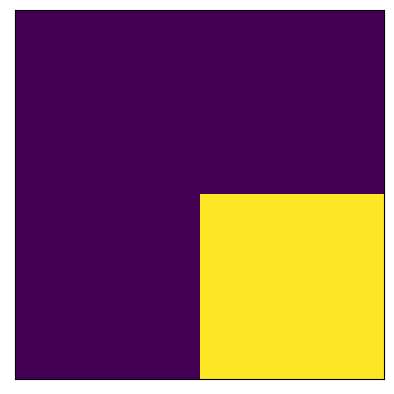

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


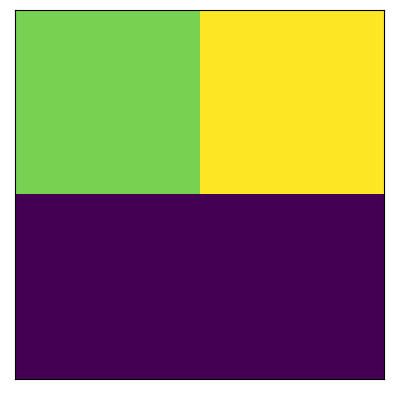

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


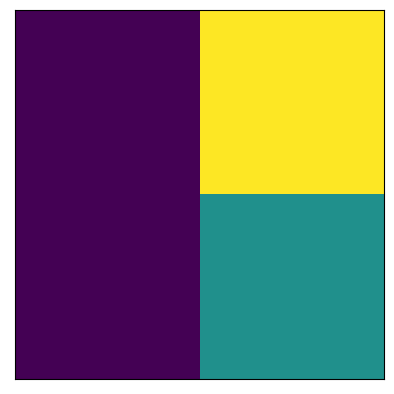

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


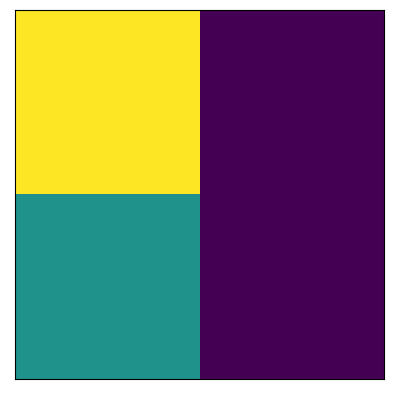

tf.Tensor(
[[2.3600001 0.       ]
 [1.2       0.       ]], shape=(2, 2), dtype=float32)


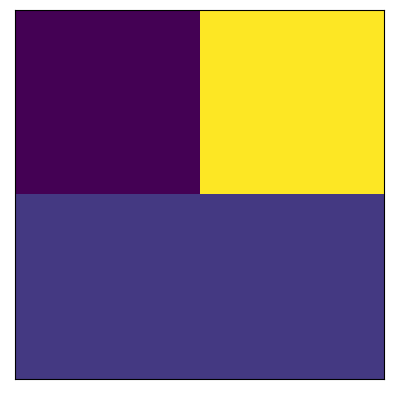

tf.Tensor(
[[0.84000003 1.8       ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


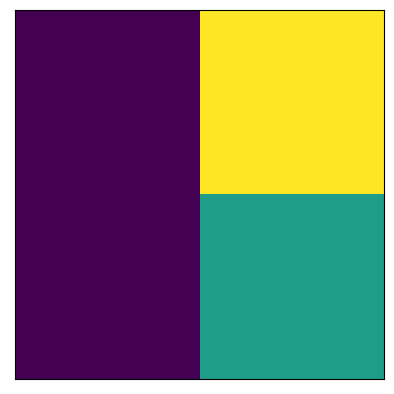

tf.Tensor(
[[0.  1.8]
 [0.  1. ]], shape=(2, 2), dtype=float32)


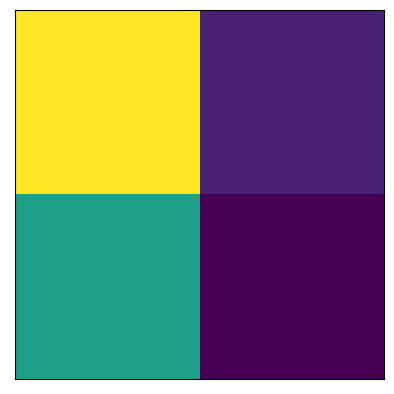

tf.Tensor(
[[2.1200001 0.2      ]
 [1.2       0.       ]], shape=(2, 2), dtype=float32)


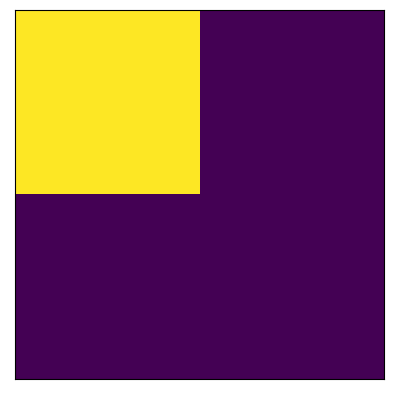

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


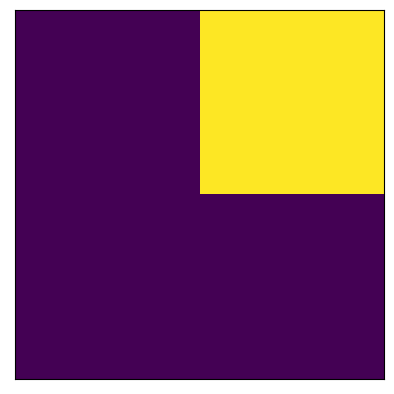

tf.Tensor(
[[0.  0.2]
 [0.  0. ]], shape=(2, 2), dtype=float32)


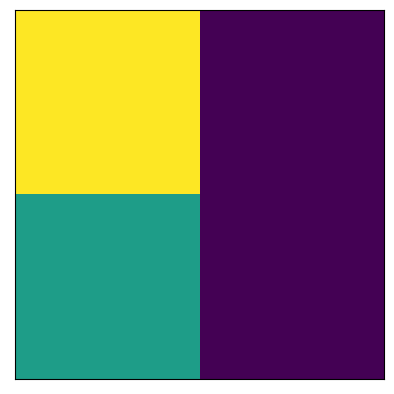

tf.Tensor(
[[2.16 0.  ]
 [1.2  0.  ]], shape=(2, 2), dtype=float32)


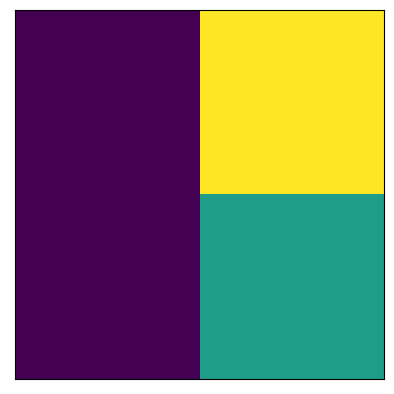

tf.Tensor(
[[0.  1.8]
 [0.  1. ]], shape=(2, 2), dtype=float32)


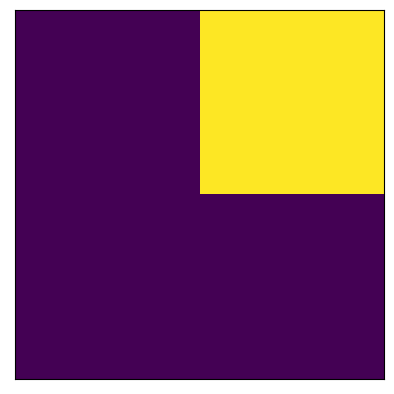

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


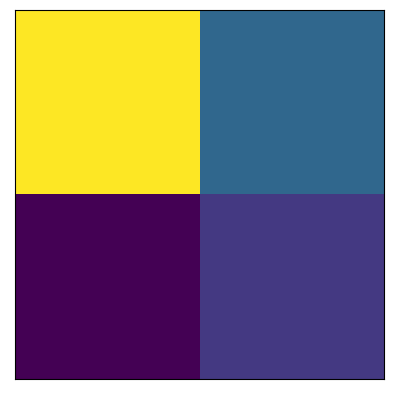

tf.Tensor(
[[6. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


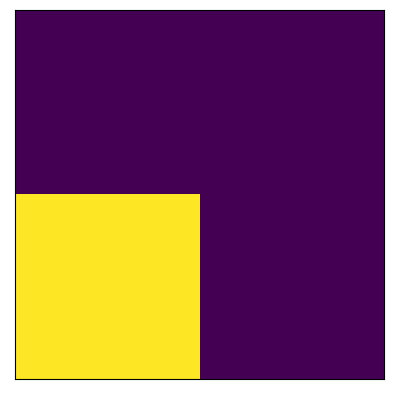

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


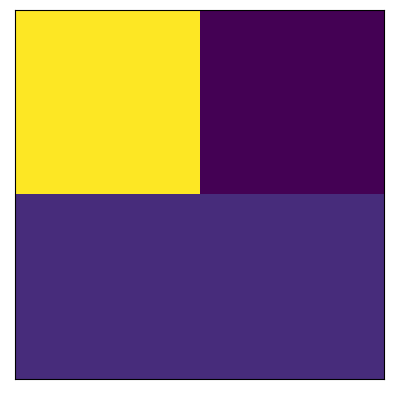

tf.Tensor(
[[8. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


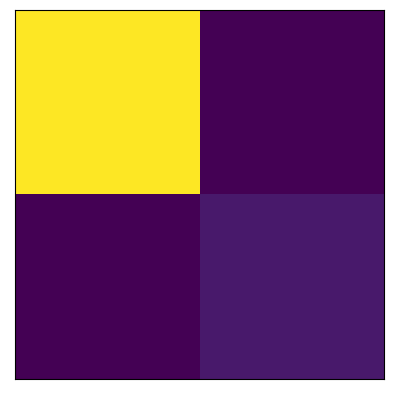

tf.Tensor(
[[15.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


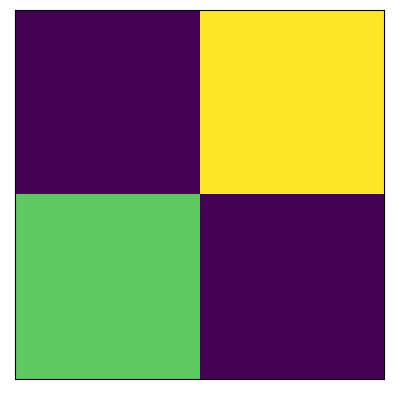

tf.Tensor(
[[0. 4.]
 [3. 0.]], shape=(2, 2), dtype=float32)


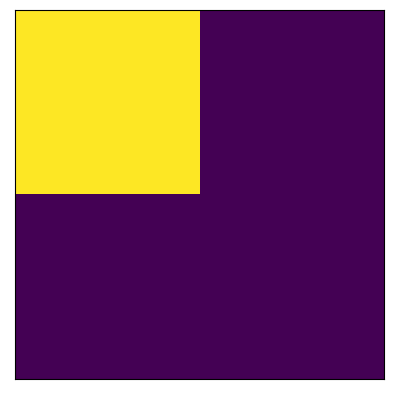

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


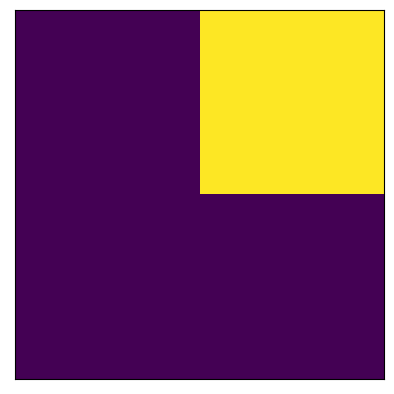

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


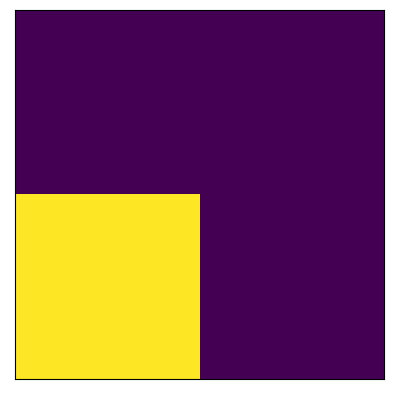

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


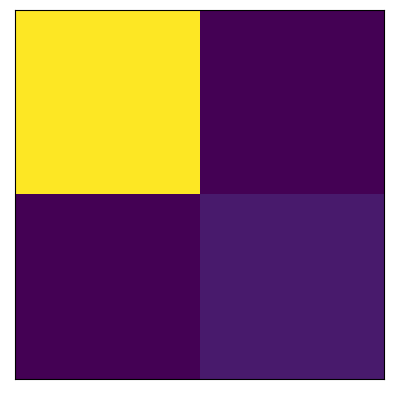

tf.Tensor(
[[14.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


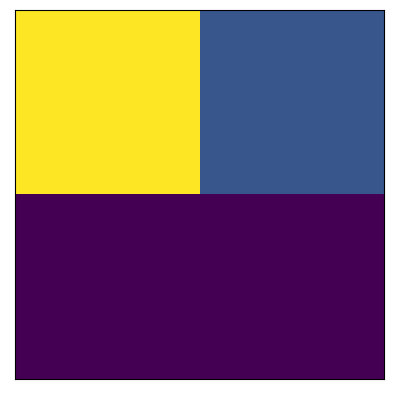

tf.Tensor(
[[0.9375 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


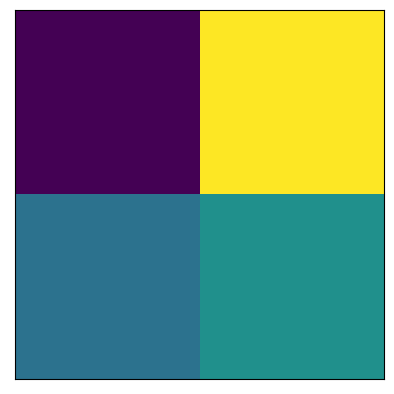

tf.Tensor(
[[0.   2.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


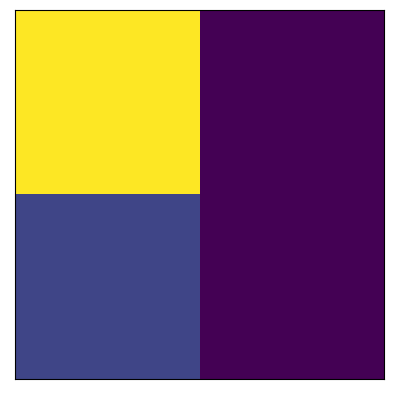

tf.Tensor(
[[1.1875 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


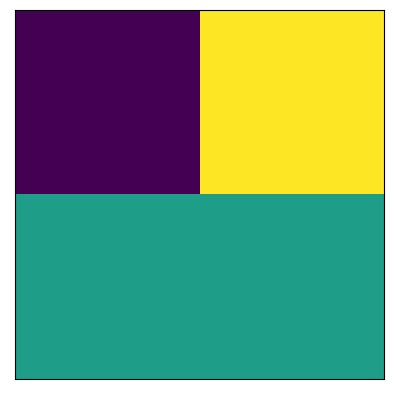

tf.Tensor(
[[0.0625 1.75  ]
 [1.     1.    ]], shape=(2, 2), dtype=float32)


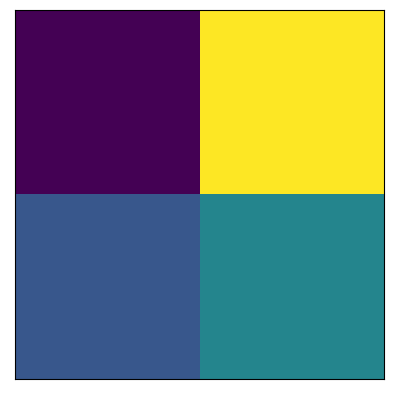

tf.Tensor(
[[0.375 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


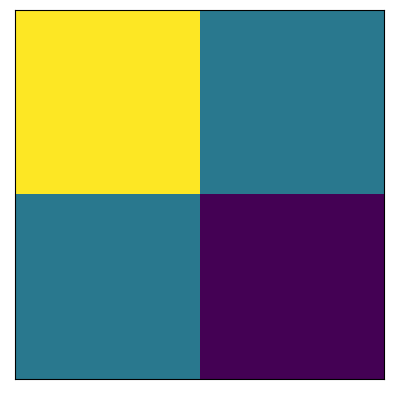

tf.Tensor(
[[0.625 0.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


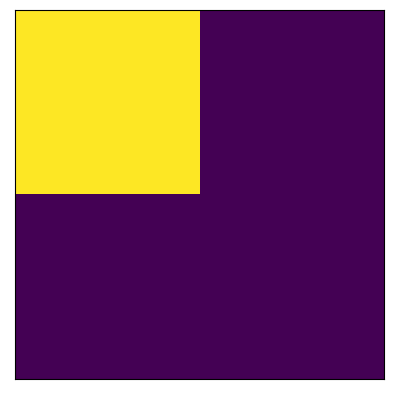

tf.Tensor(
[[0.75 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


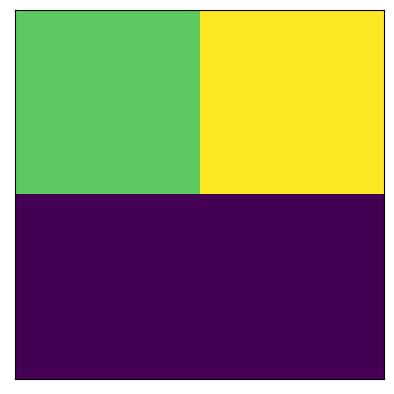

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


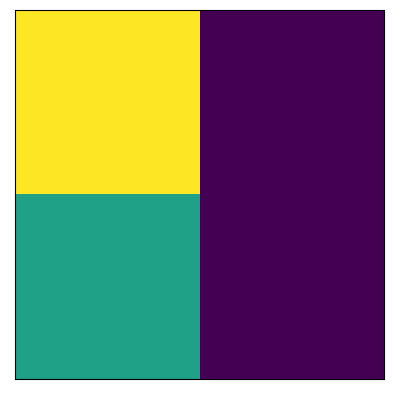

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


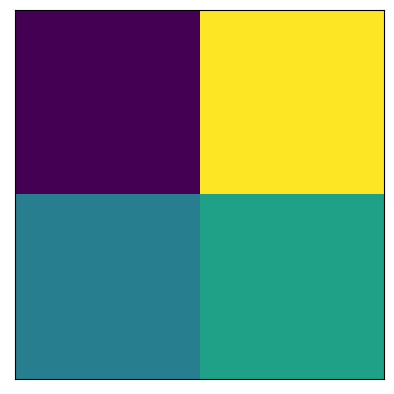

tf.Tensor(
[[0.   1.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


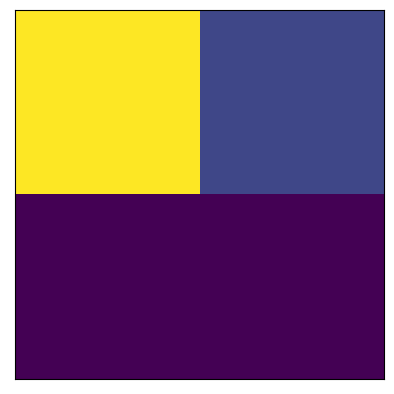

tf.Tensor(
[[1.5555556  0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


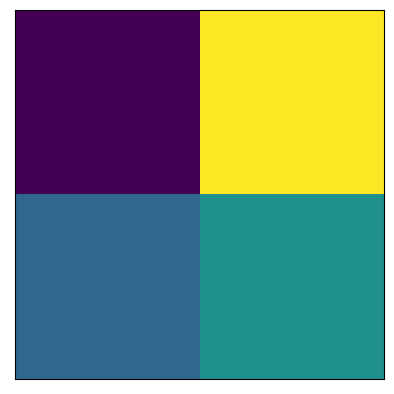

tf.Tensor(
[[0.        2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


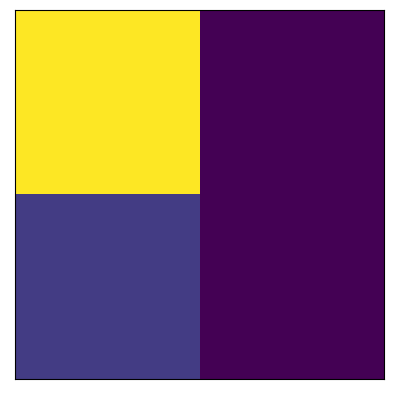

tf.Tensor(
[[1.8888888  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


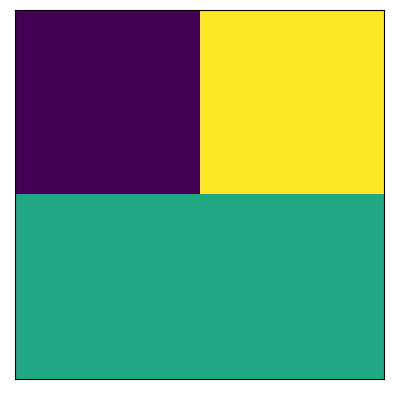

tf.Tensor(
[[0.        1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


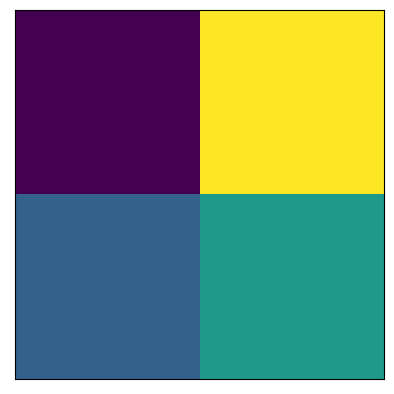

tf.Tensor(
[[0.2222222 1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


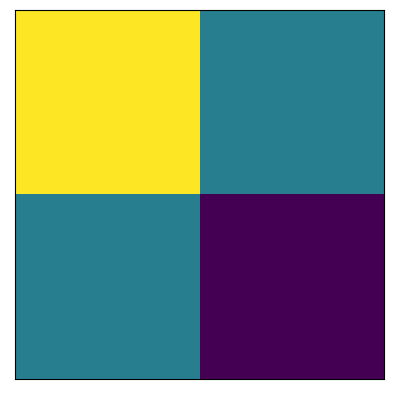

tf.Tensor(
[[0.7777778  0.33333334]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


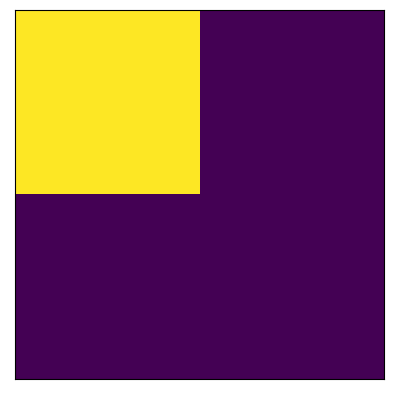

tf.Tensor(
[[1.3333334 0.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


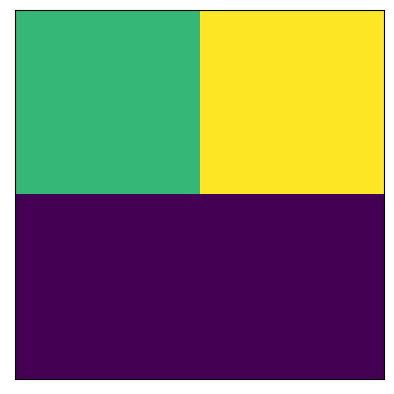

tf.Tensor(
[[0.22222224 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


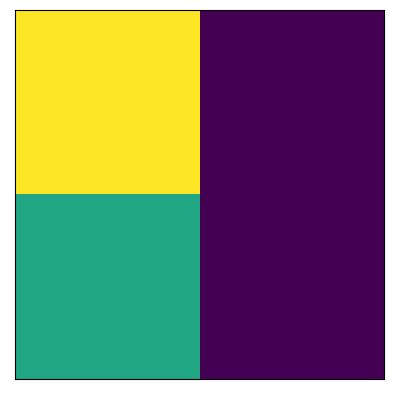

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


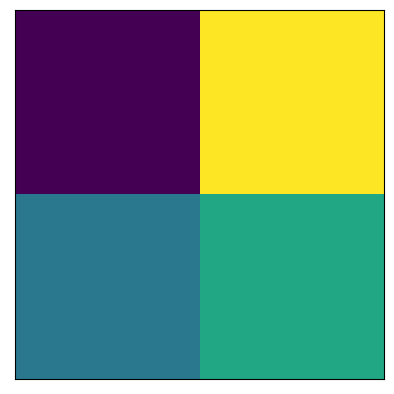

tf.Tensor(
[[0.        1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


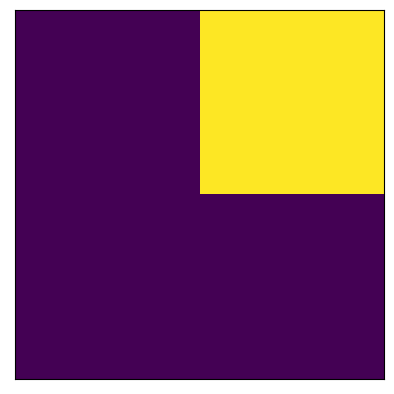

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


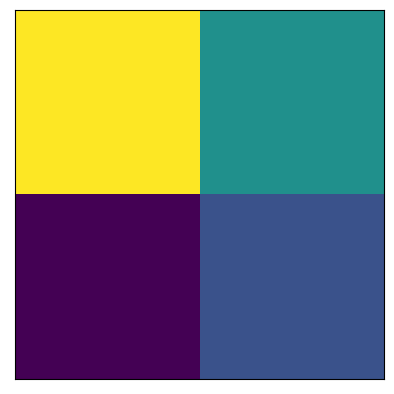

tf.Tensor(
[[4. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


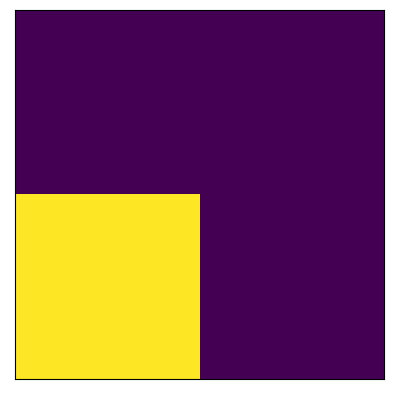

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


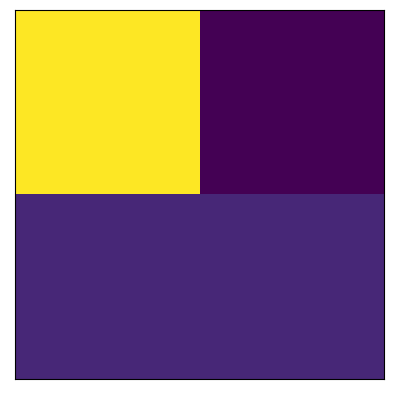

tf.Tensor(
[[9. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


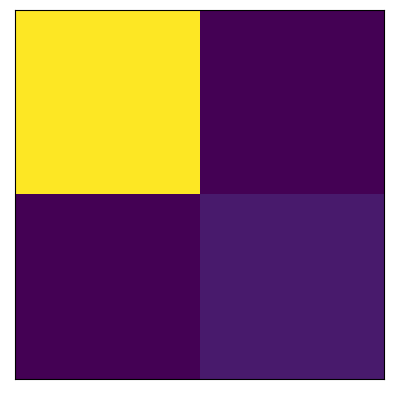

tf.Tensor(
[[14.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


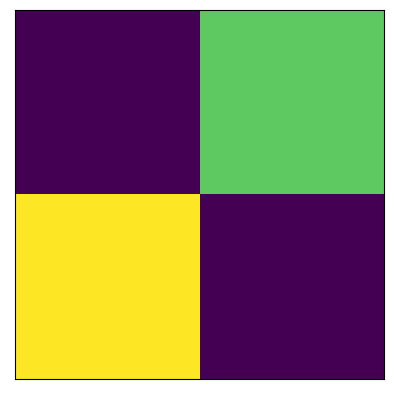

tf.Tensor(
[[0. 3.]
 [4. 0.]], shape=(2, 2), dtype=float32)


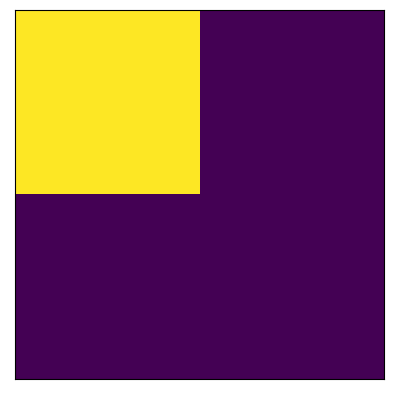

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


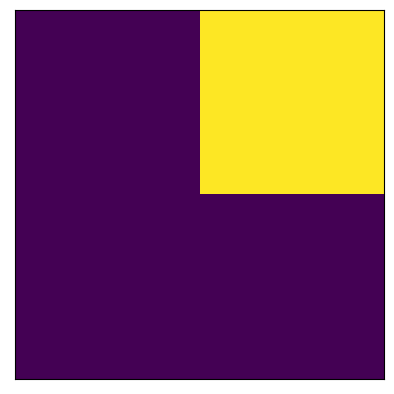

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


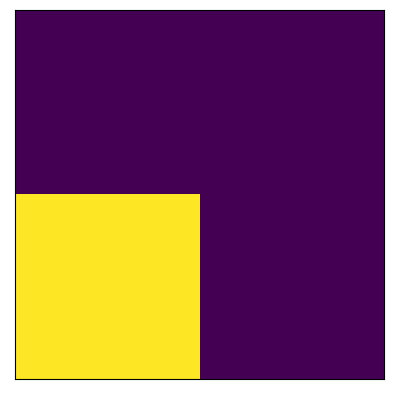

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


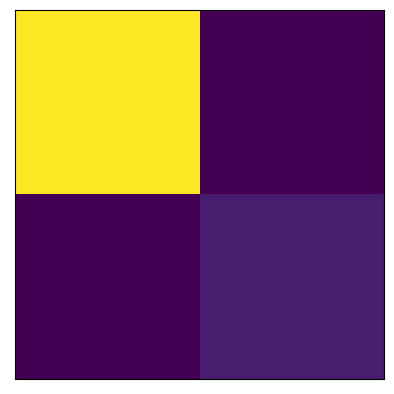

tf.Tensor(
[[13.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


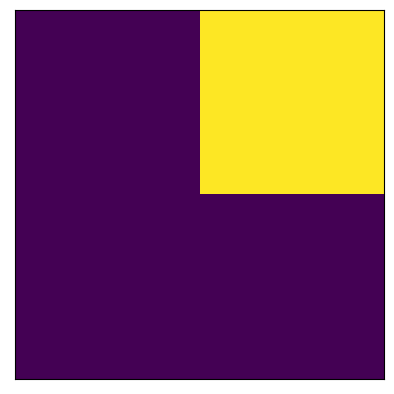

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


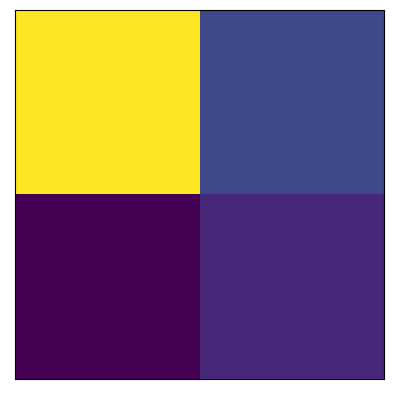

tf.Tensor(
[[9. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


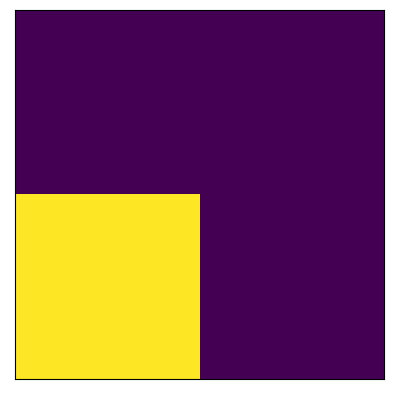

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


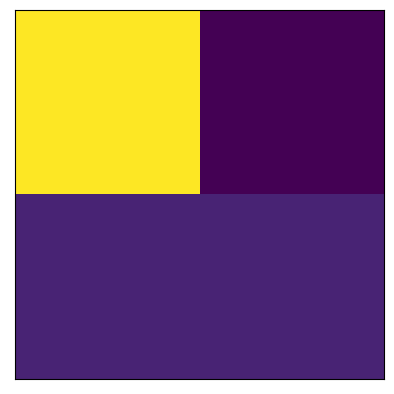

tf.Tensor(
[[10.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


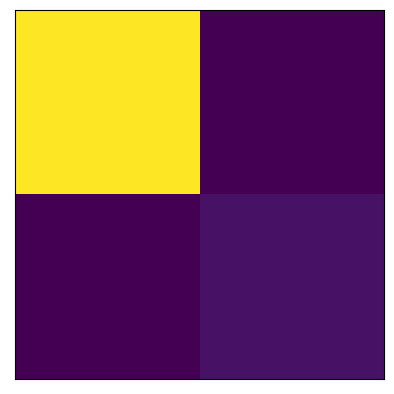

tf.Tensor(
[[20.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


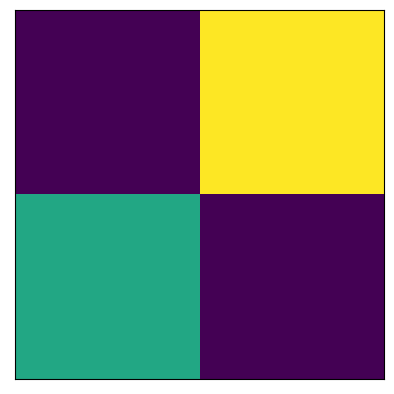

tf.Tensor(
[[0. 5.]
 [3. 0.]], shape=(2, 2), dtype=float32)


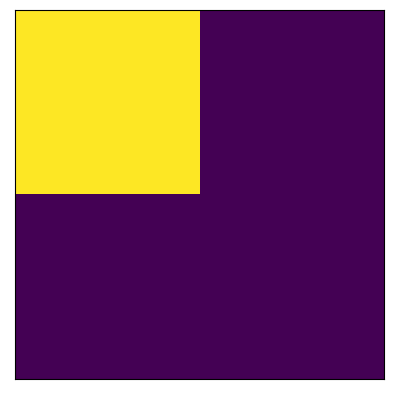

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


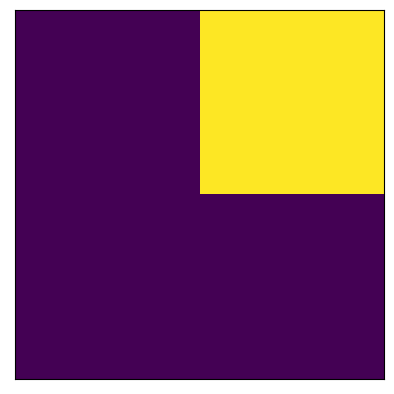

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


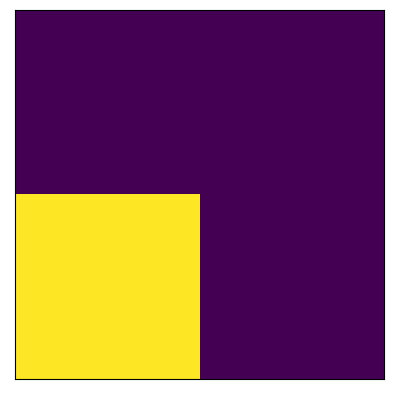

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


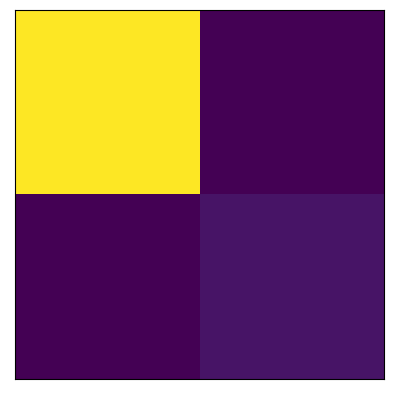

tf.Tensor(
[[19.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


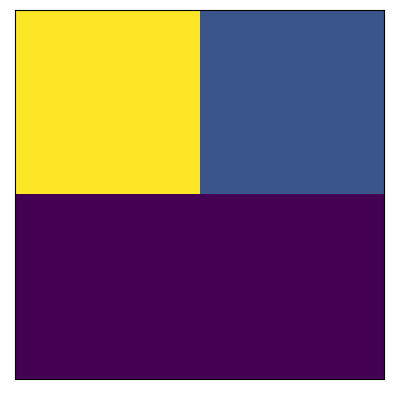

tf.Tensor(
[[0.76 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


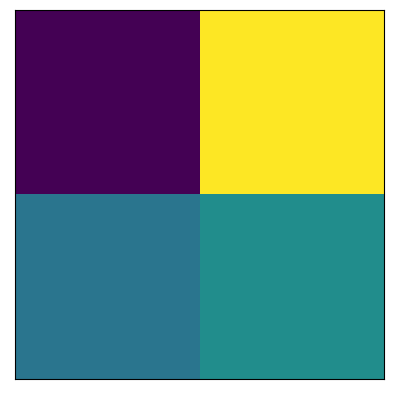

tf.Tensor(
[[0.04000002 2.        ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


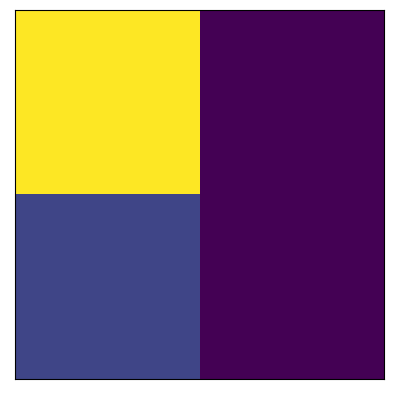

tf.Tensor(
[[0.96000004 0.        ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


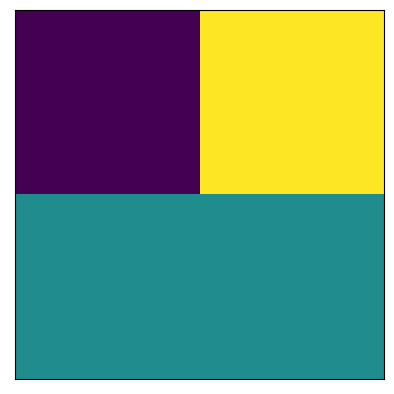

tf.Tensor(
[[0.24000001 1.8       ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


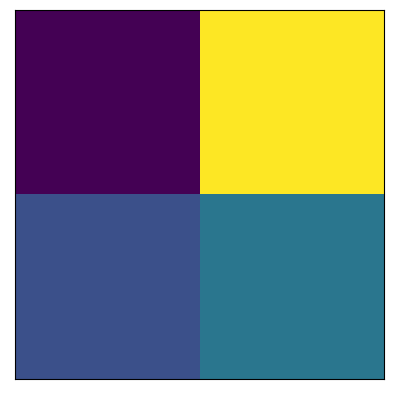

tf.Tensor(
[[0.48000002 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


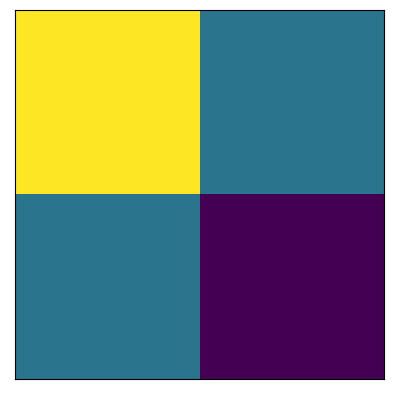

tf.Tensor(
[[0.52000004 0.2       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


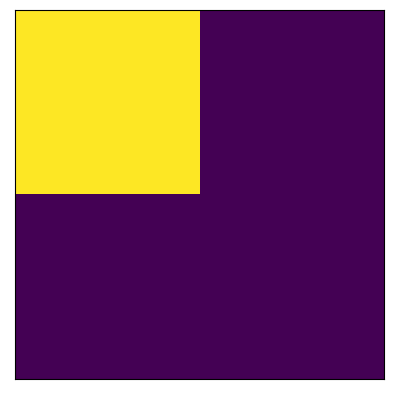

tf.Tensor(
[[0.6 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


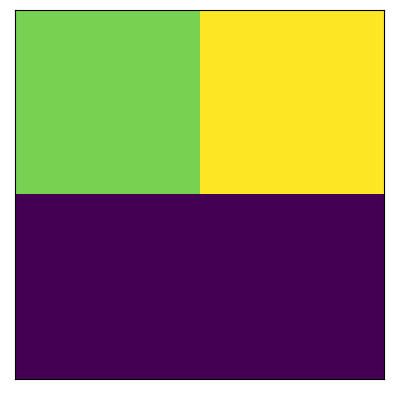

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


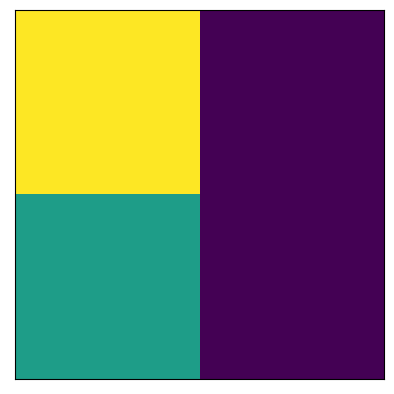

tf.Tensor(
[[0.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


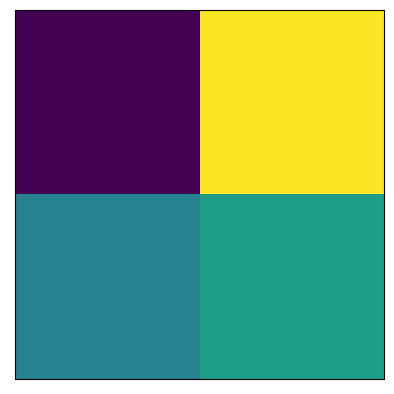

tf.Tensor(
[[0.  1.8]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


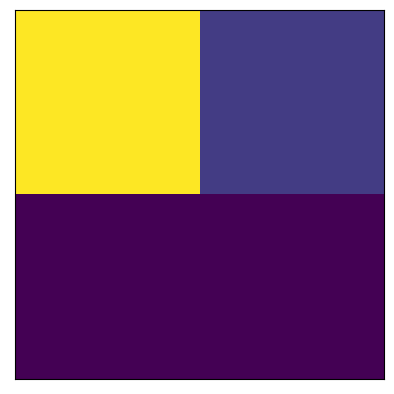

tf.Tensor(
[[1.8888888  0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


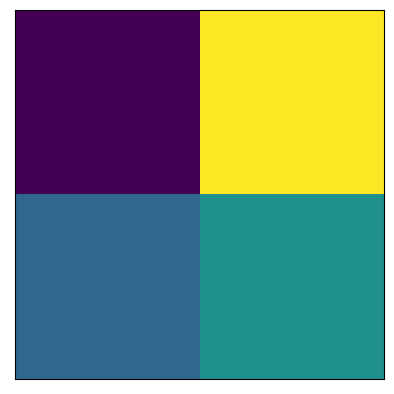

tf.Tensor(
[[0.        2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


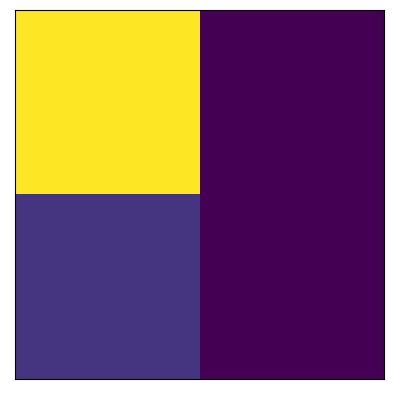

tf.Tensor(
[[2.222222   0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


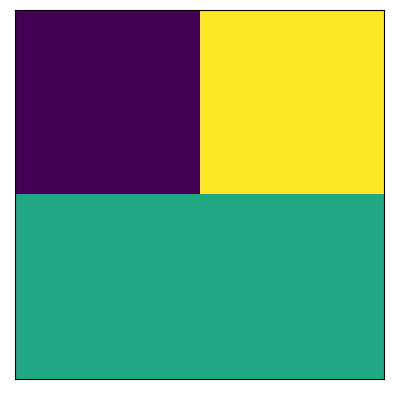

tf.Tensor(
[[0.        1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


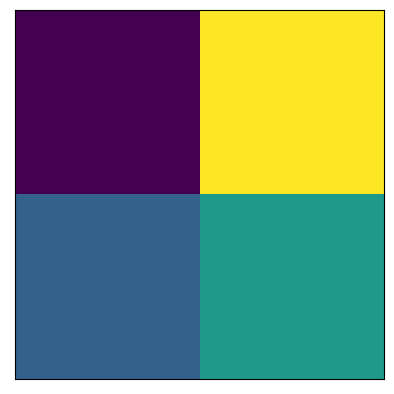

tf.Tensor(
[[0.2222222 1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


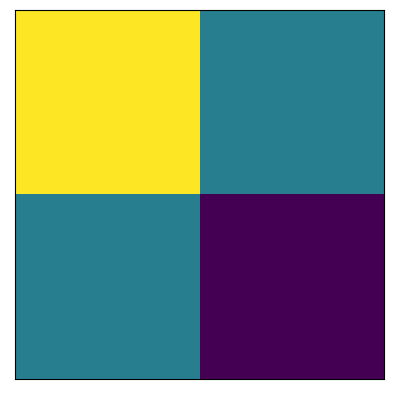

tf.Tensor(
[[0.7777778  0.33333334]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


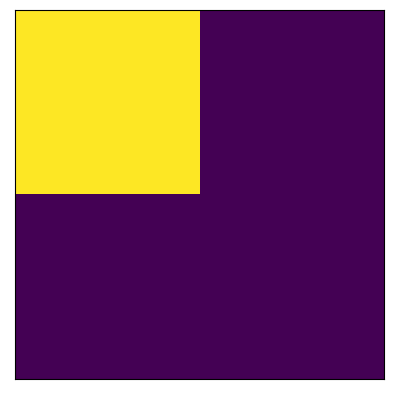

tf.Tensor(
[[1.6666666 0.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


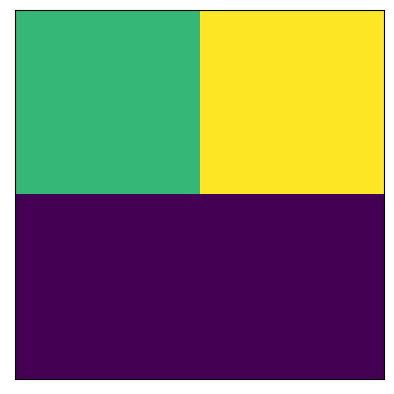

tf.Tensor(
[[0.22222224 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


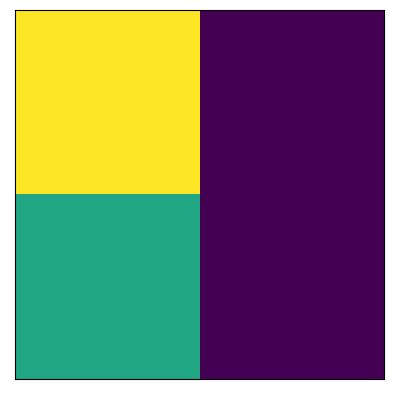

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


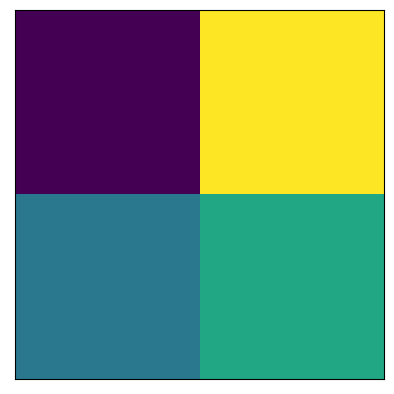

tf.Tensor(
[[0.        1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


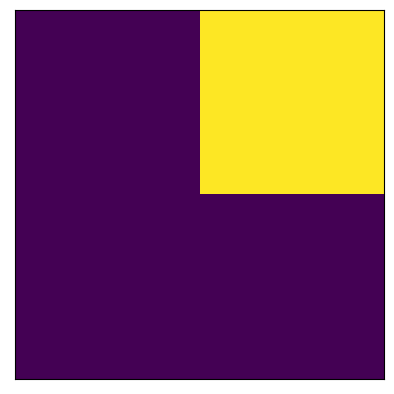

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


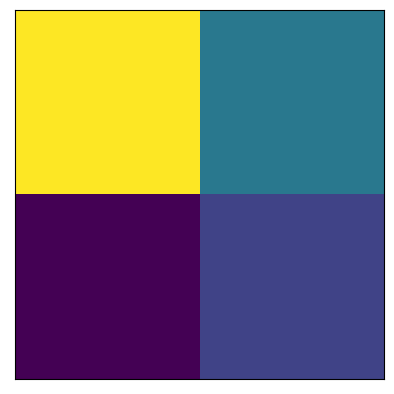

tf.Tensor(
[[5. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


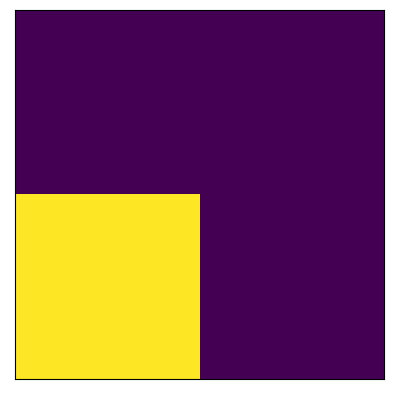

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


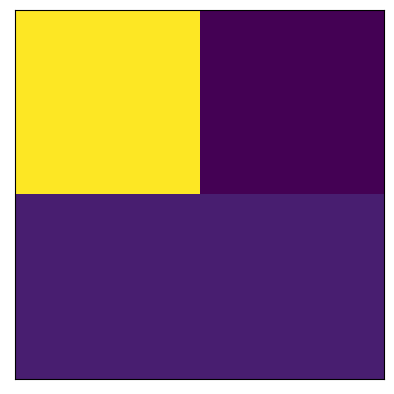

tf.Tensor(
[[12.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


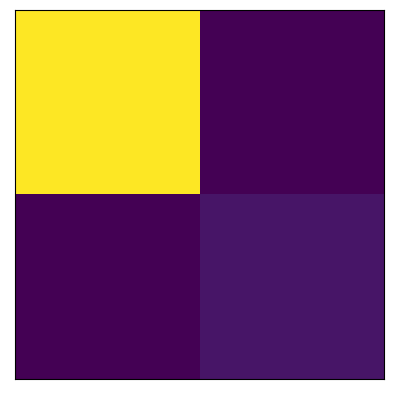

tf.Tensor(
[[18.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


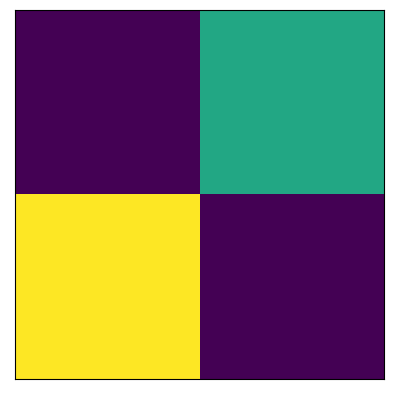

tf.Tensor(
[[0. 3.]
 [5. 0.]], shape=(2, 2), dtype=float32)


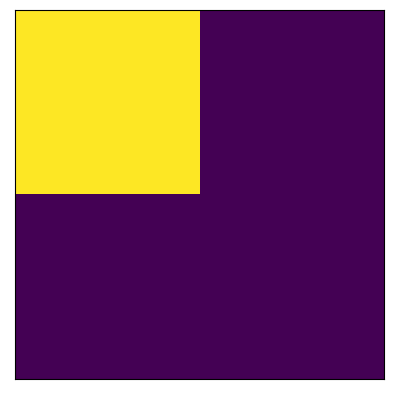

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


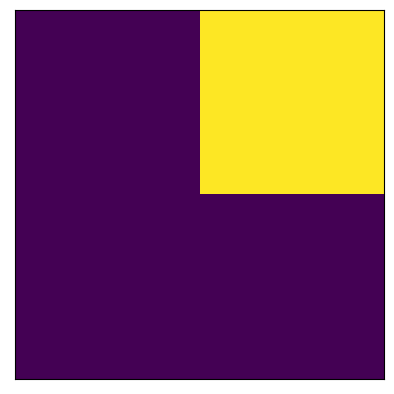

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


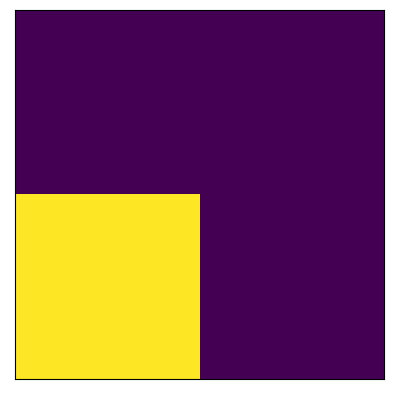

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


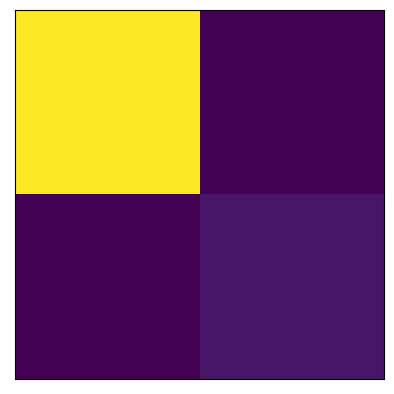

tf.Tensor(
[[17.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


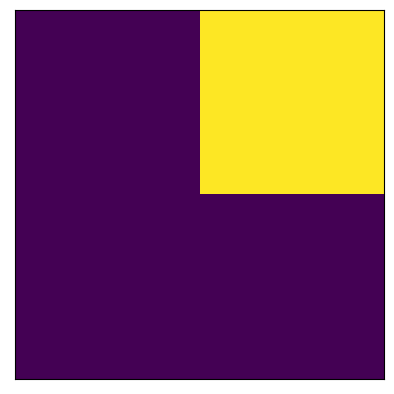

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


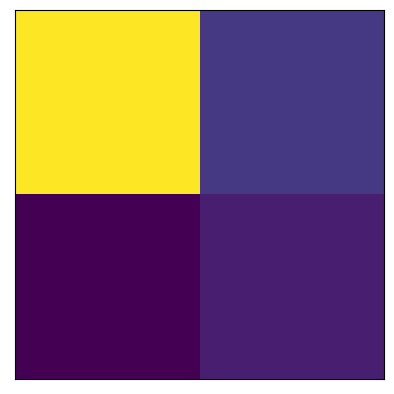

tf.Tensor(
[[12.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


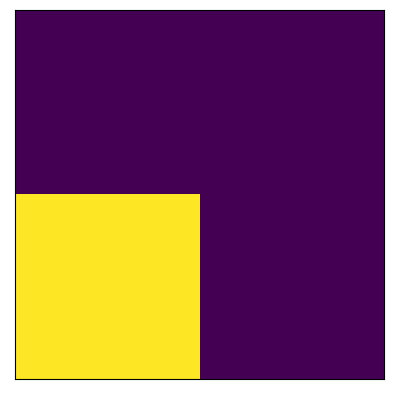

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


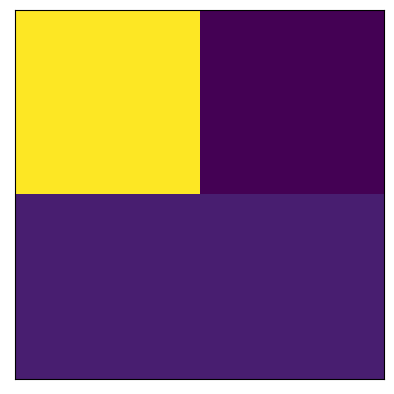

tf.Tensor(
[[12.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


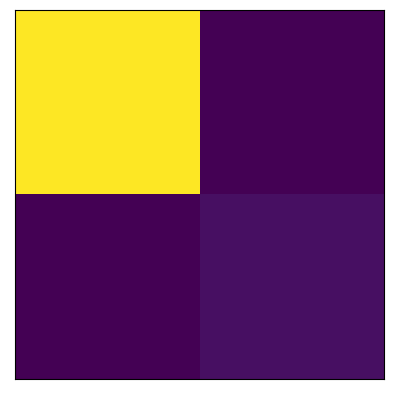

tf.Tensor(
[[25.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


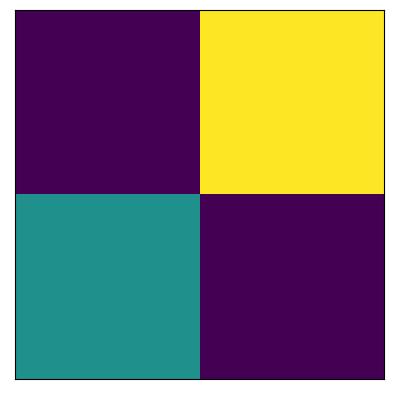

tf.Tensor(
[[0. 6.]
 [3. 0.]], shape=(2, 2), dtype=float32)


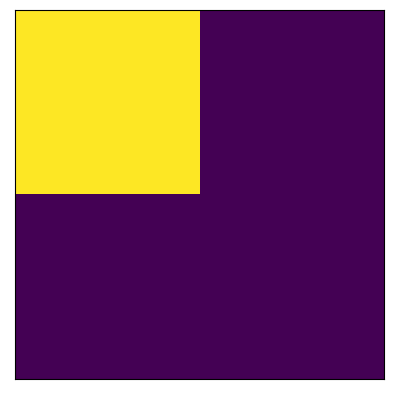

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


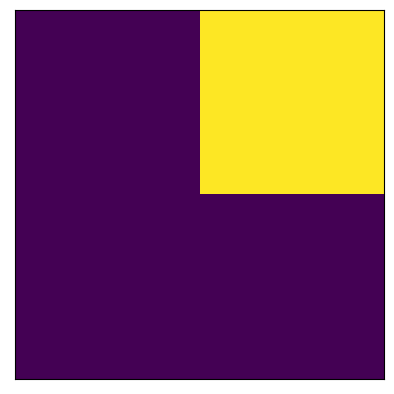

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


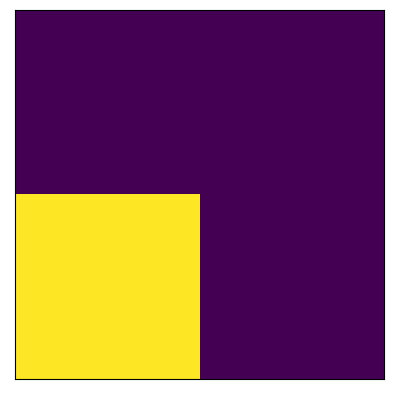

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


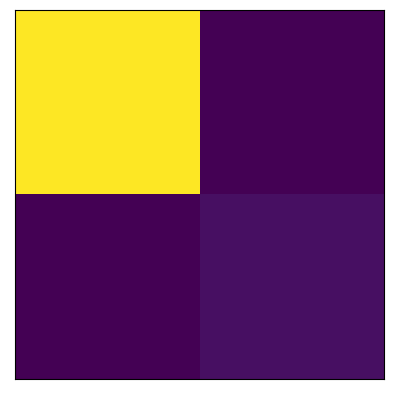

tf.Tensor(
[[24.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


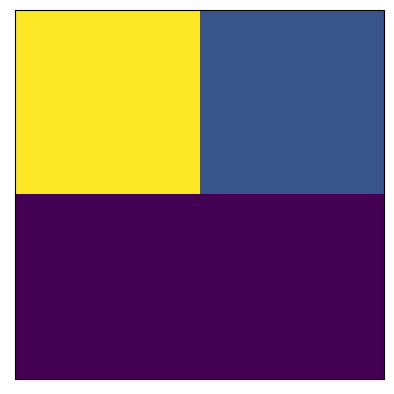

tf.Tensor(
[[0.6388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


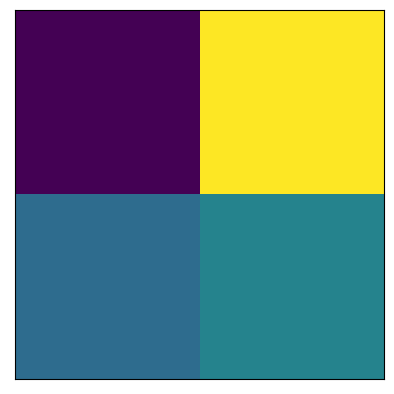

tf.Tensor(
[[0.19444442 2.        ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


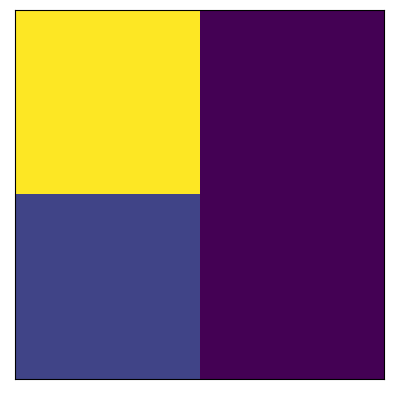

tf.Tensor(
[[0.8055556  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


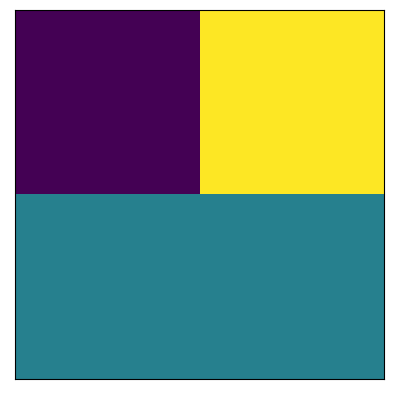

tf.Tensor(
[[0.3611111 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


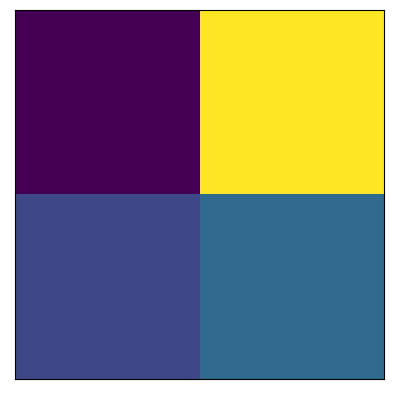

tf.Tensor(
[[0.5555555 1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


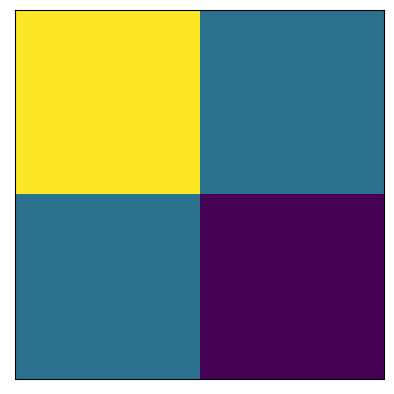

tf.Tensor(
[[0.44444445 0.16666667]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


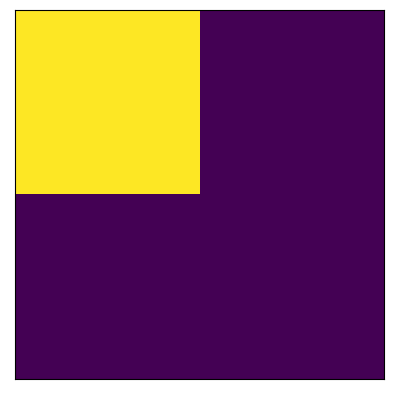

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


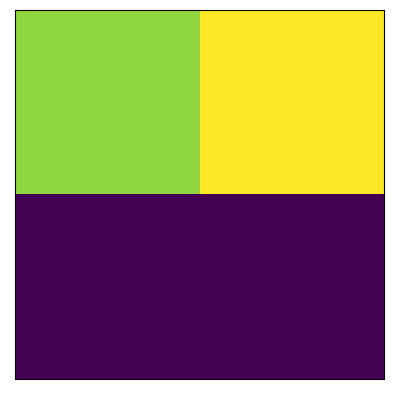

tf.Tensor(
[[0.1388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


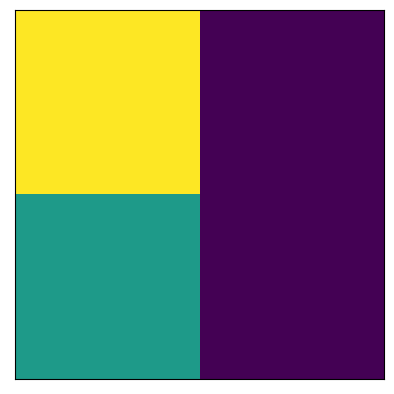

tf.Tensor(
[[0.30555555 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


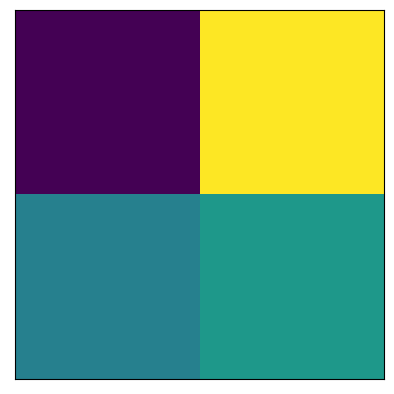

tf.Tensor(
[[0.05555549 1.8333334 ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


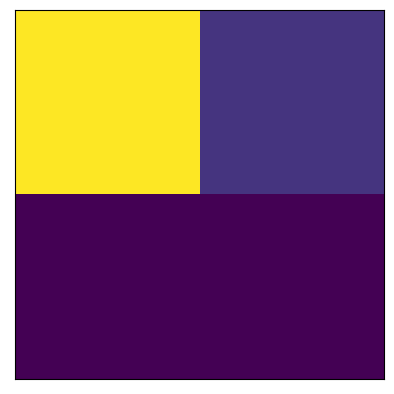

tf.Tensor(
[[2.222222   0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


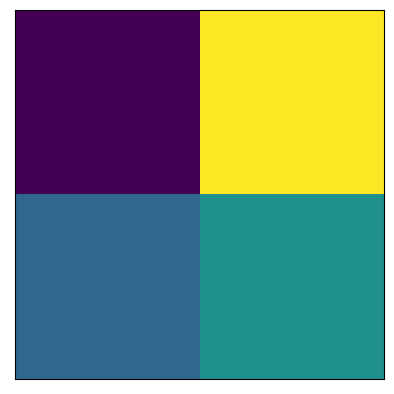

tf.Tensor(
[[0.        2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


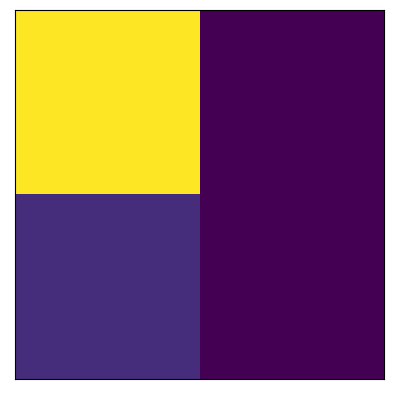

tf.Tensor(
[[2.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


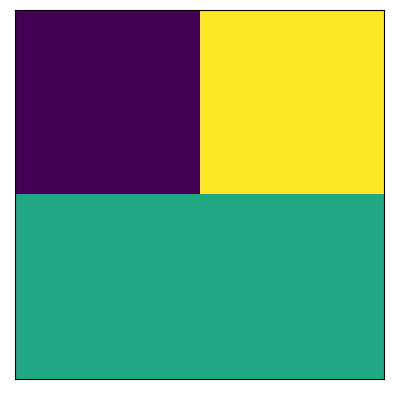

tf.Tensor(
[[0.        1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


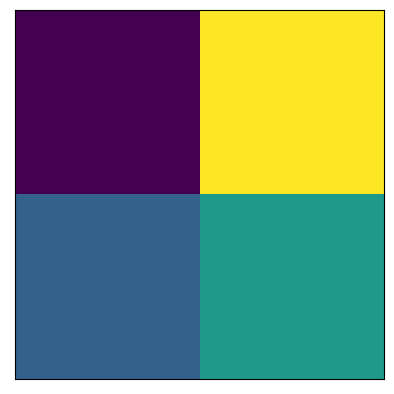

tf.Tensor(
[[0.2222222 1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


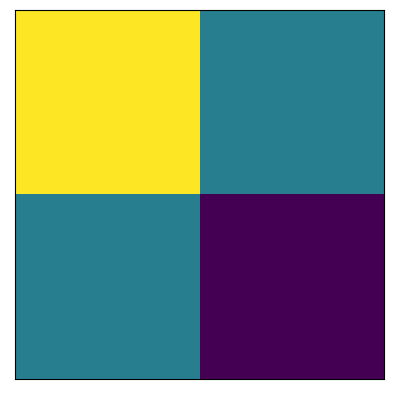

tf.Tensor(
[[0.7777778  0.33333334]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


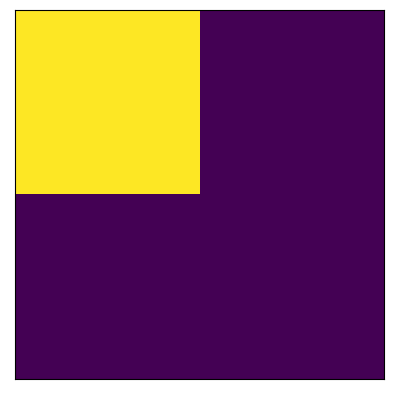

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


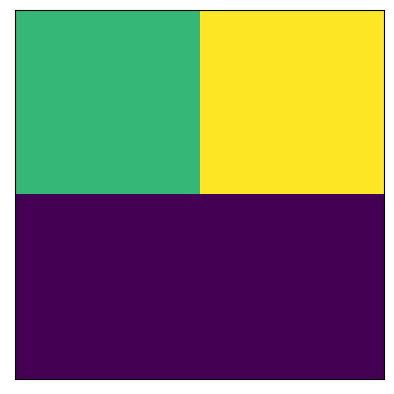

tf.Tensor(
[[0.22222224 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


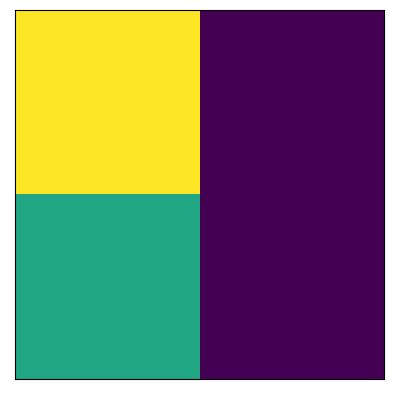

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


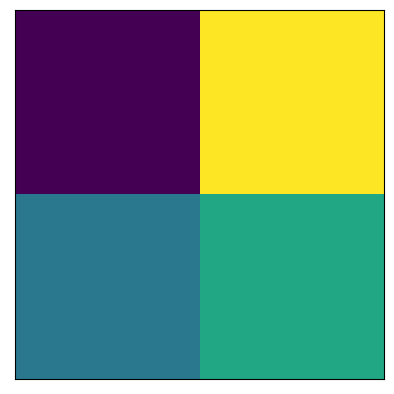

tf.Tensor(
[[0.        1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


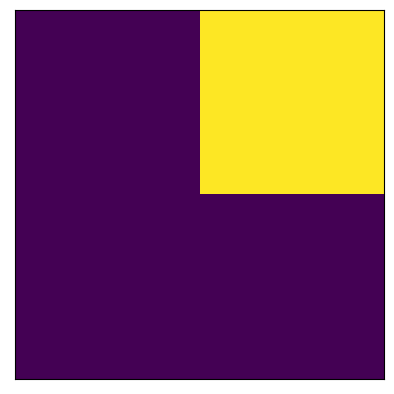

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


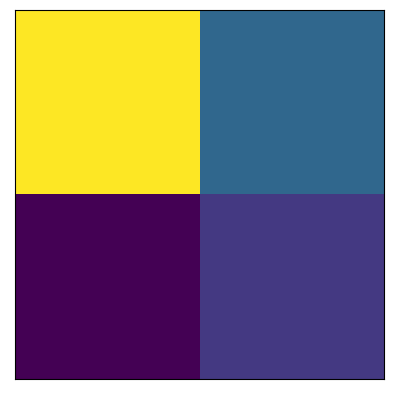

tf.Tensor(
[[6. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


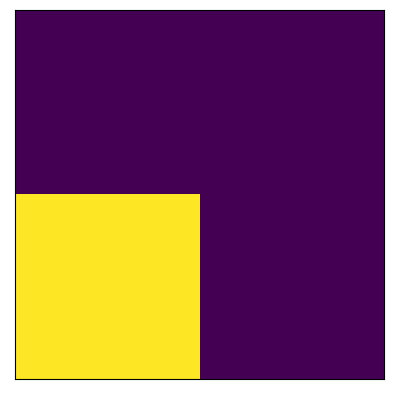

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


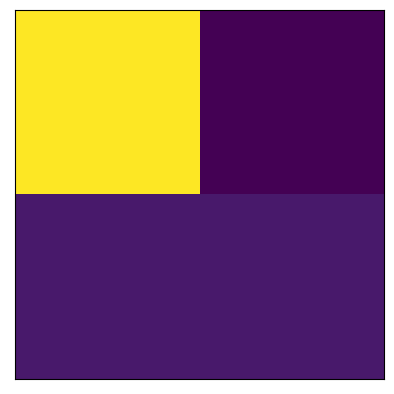

tf.Tensor(
[[15.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


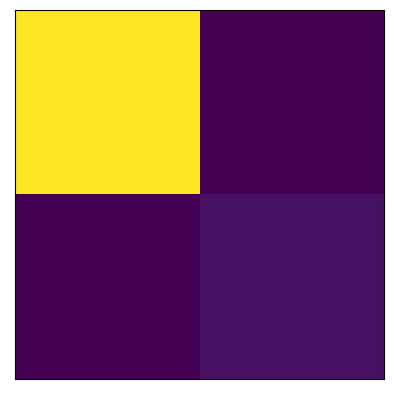

tf.Tensor(
[[22.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


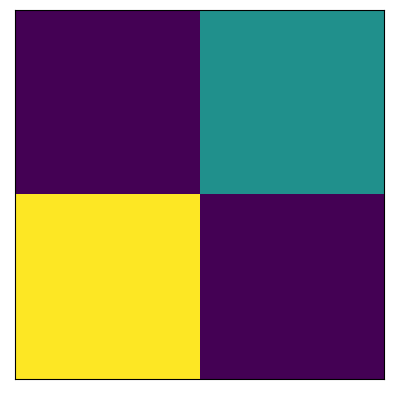

tf.Tensor(
[[0. 3.]
 [6. 0.]], shape=(2, 2), dtype=float32)


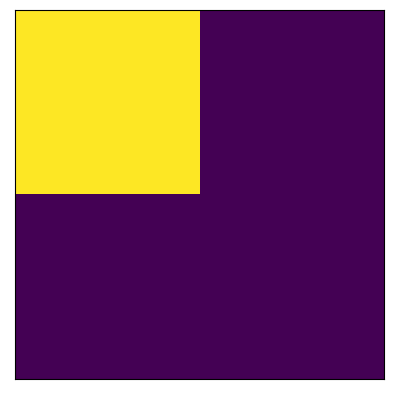

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


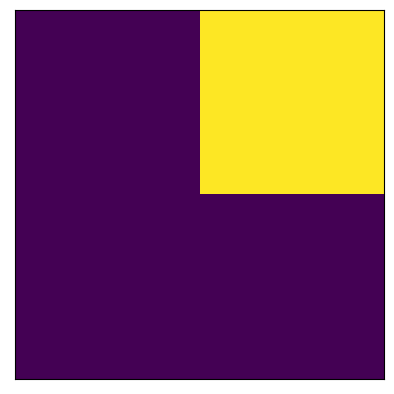

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


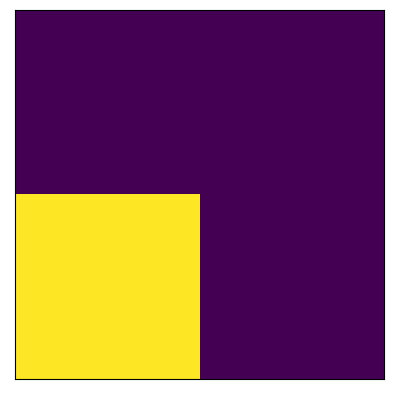

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


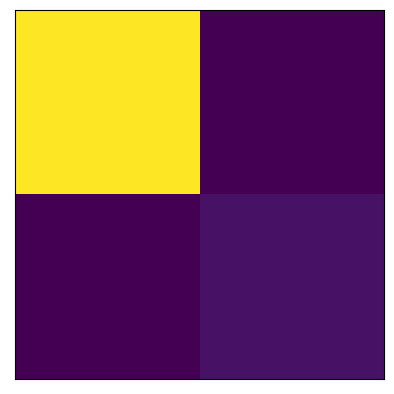

tf.Tensor(
[[21.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


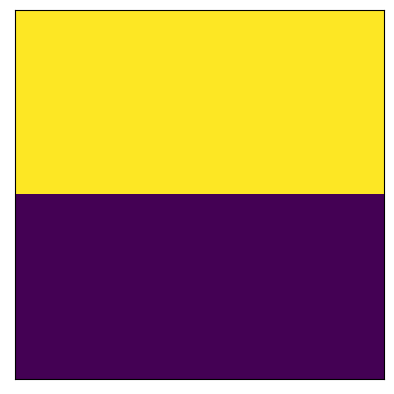

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


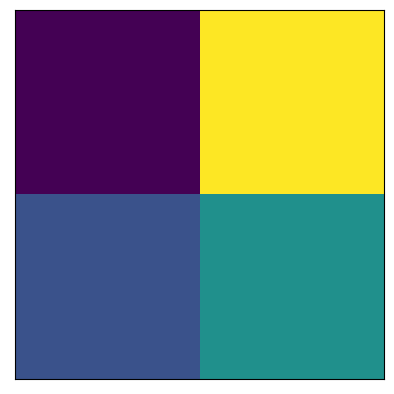

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


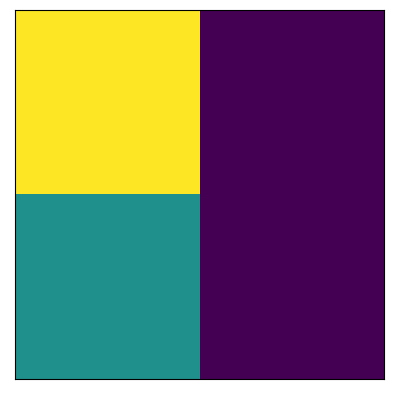

tf.Tensor(
[[1.  0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


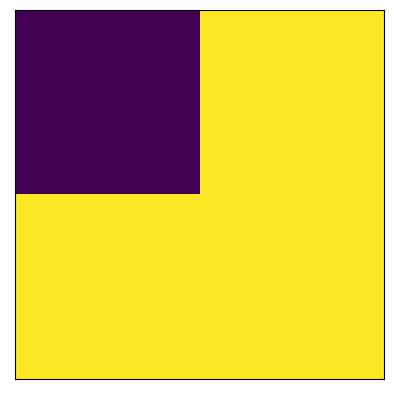

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


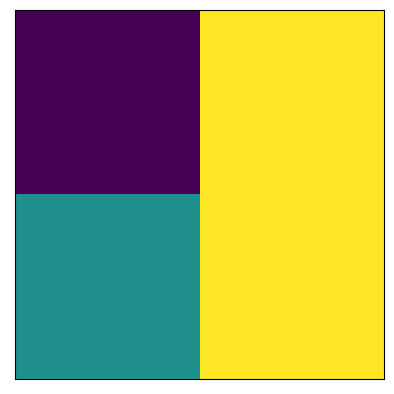

tf.Tensor(
[[0.  1. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


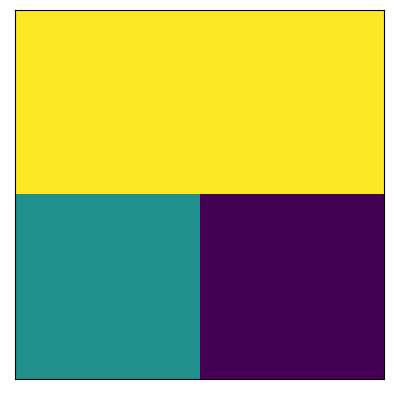

tf.Tensor(
[[1.  1. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


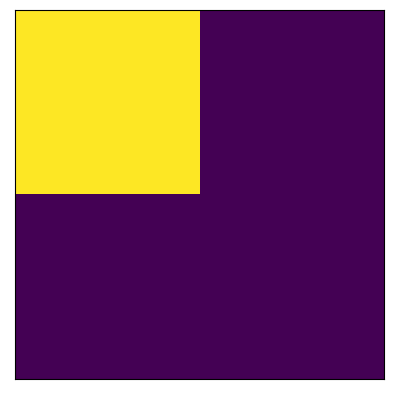

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


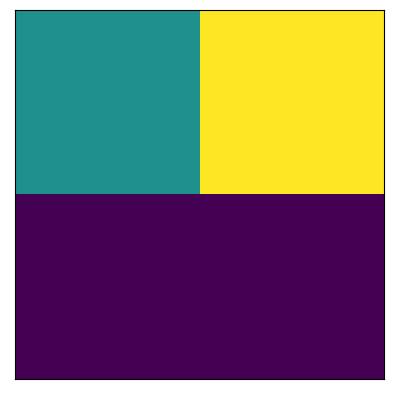

tf.Tensor(
[[0.5 1. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


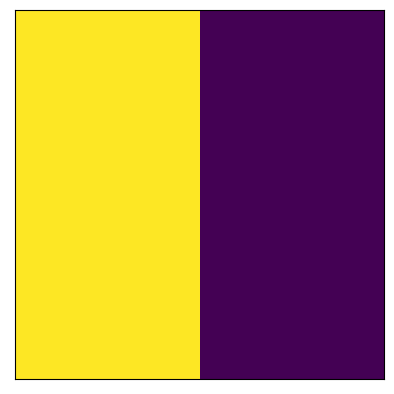

tf.Tensor(
[[0.5 0. ]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


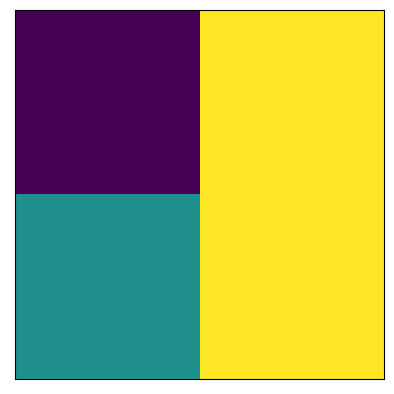

tf.Tensor(
[[0.  1. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


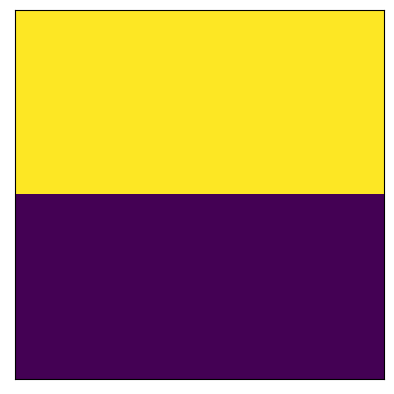

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


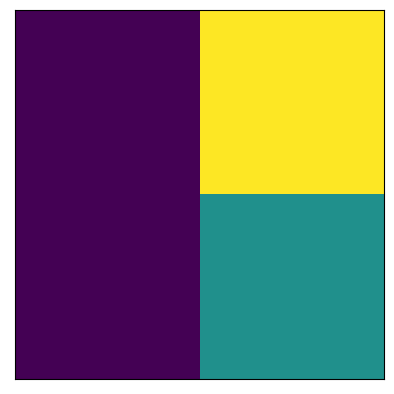

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


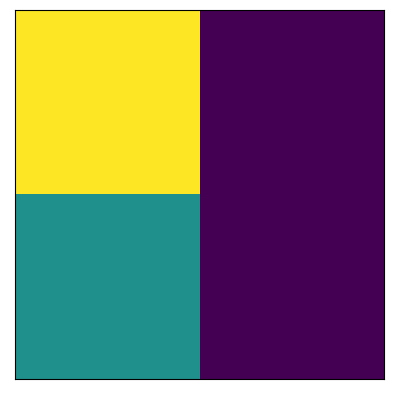

tf.Tensor(
[[4. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


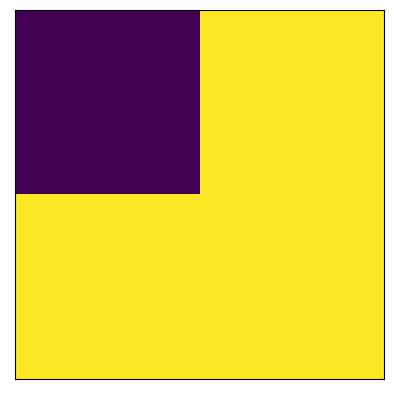

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


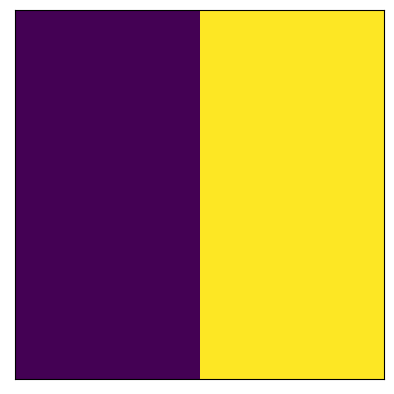

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


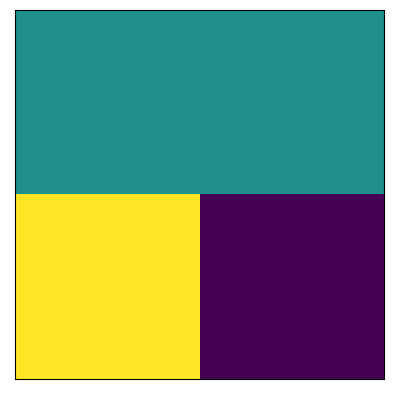

tf.Tensor(
[[1. 1.]
 [2. 0.]], shape=(2, 2), dtype=float32)


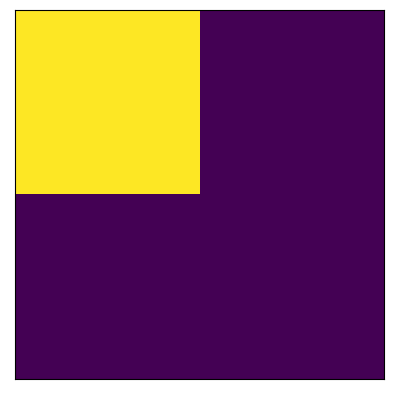

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


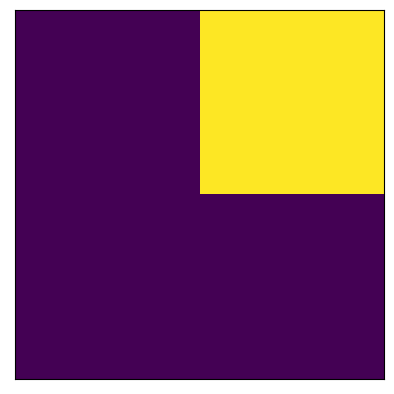

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


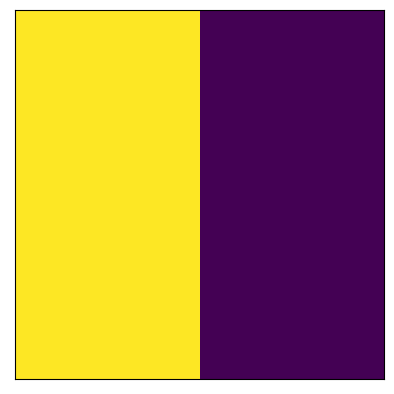

tf.Tensor(
[[2. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


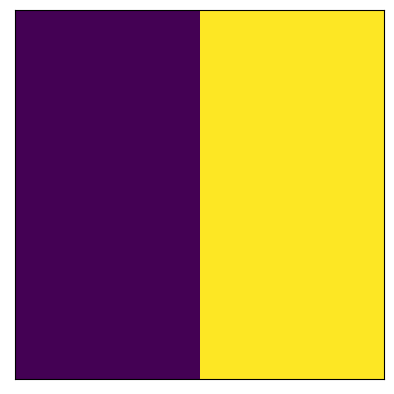

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


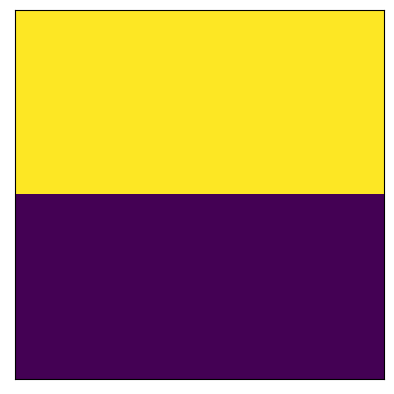

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


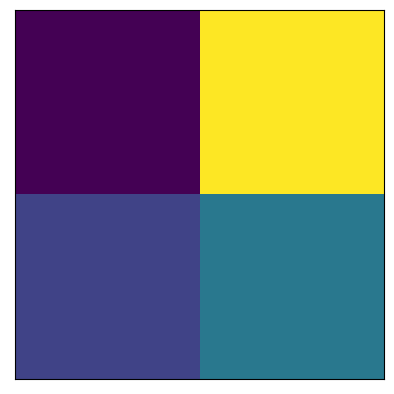

tf.Tensor(
[[0.3333333 2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


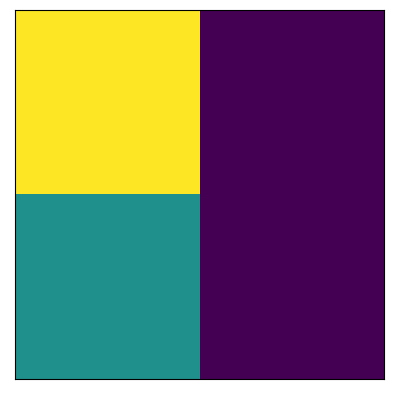

tf.Tensor(
[[0.6666667  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


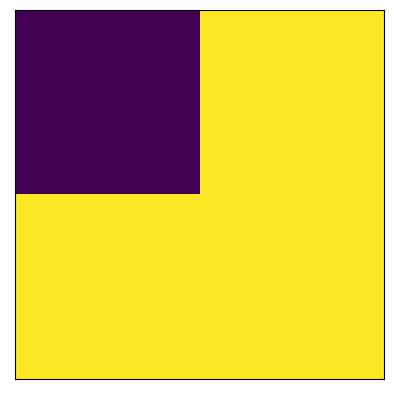

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


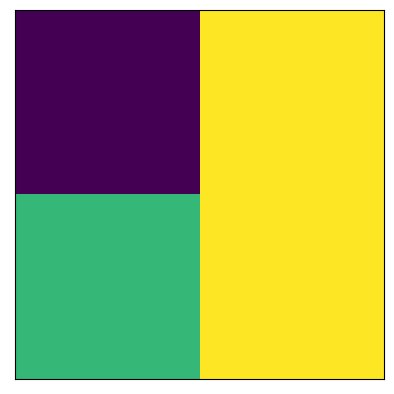

tf.Tensor(
[[0.        1.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


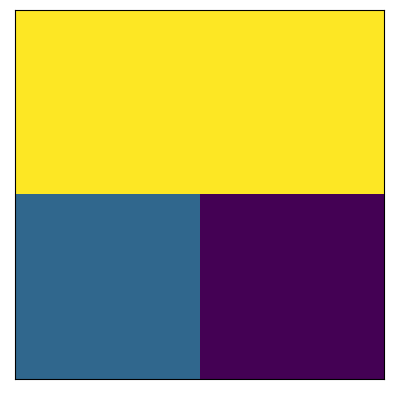

tf.Tensor(
[[1.         1.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


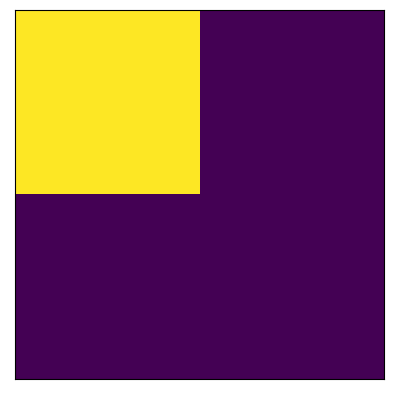

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


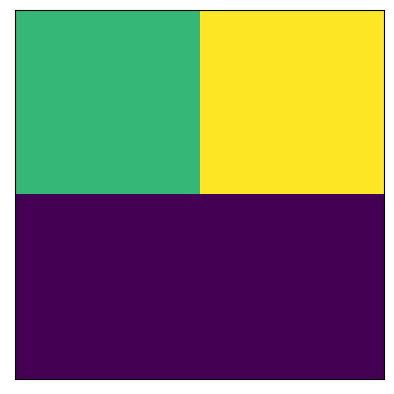

tf.Tensor(
[[0.6666666 1.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


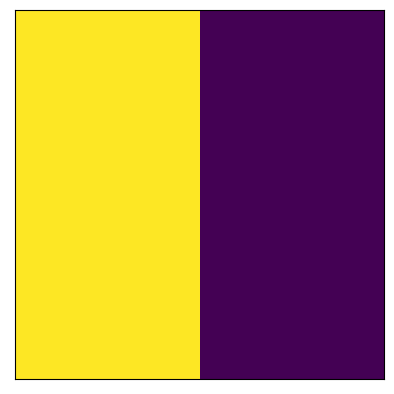

tf.Tensor(
[[0.33333334 0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


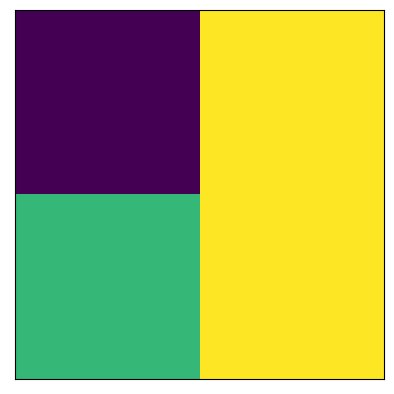

tf.Tensor(
[[0.        1.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


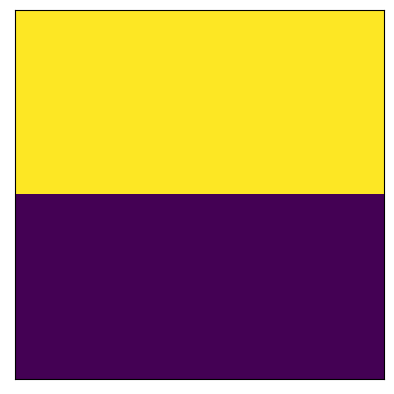

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


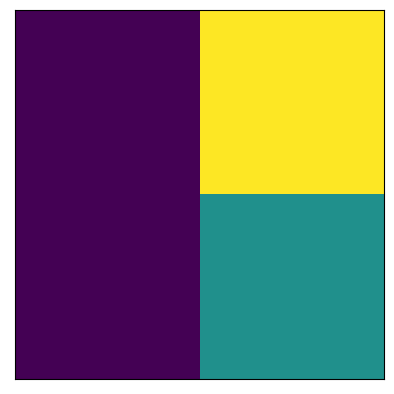

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


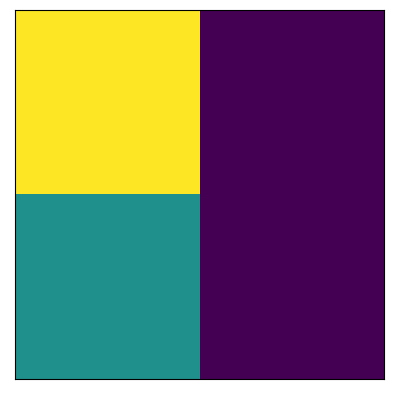

tf.Tensor(
[[6. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


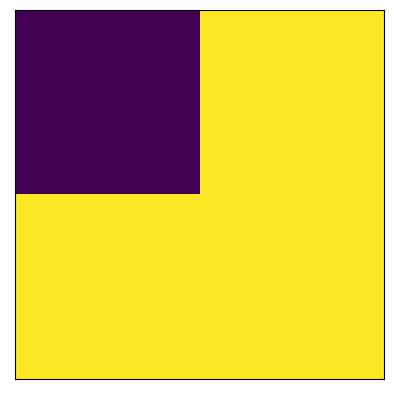

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


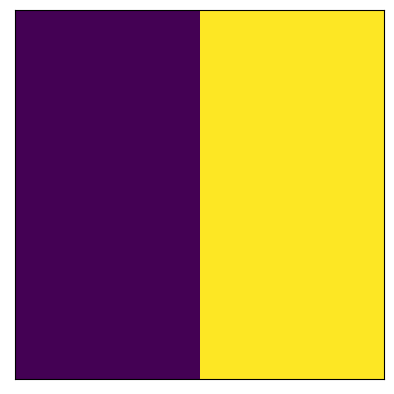

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


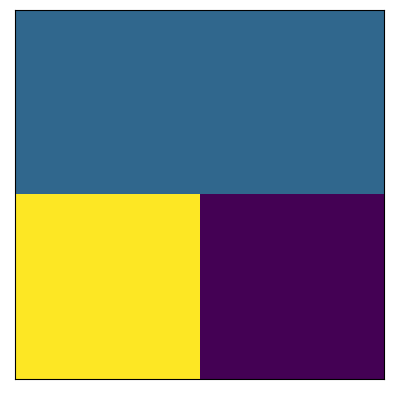

tf.Tensor(
[[1. 1.]
 [3. 0.]], shape=(2, 2), dtype=float32)


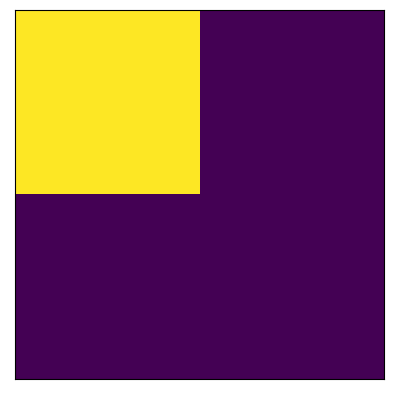

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


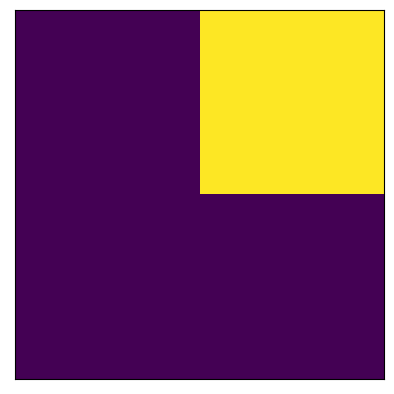

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


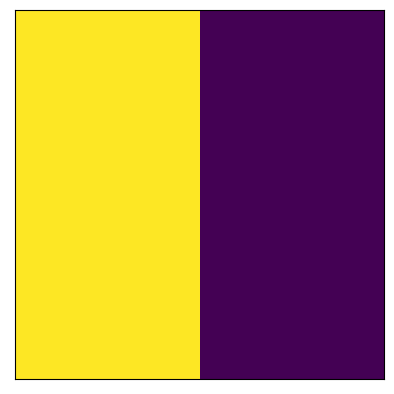

tf.Tensor(
[[3. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


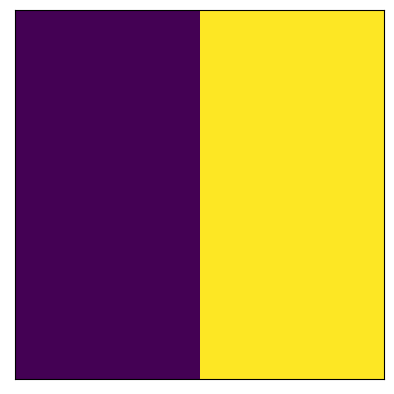

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


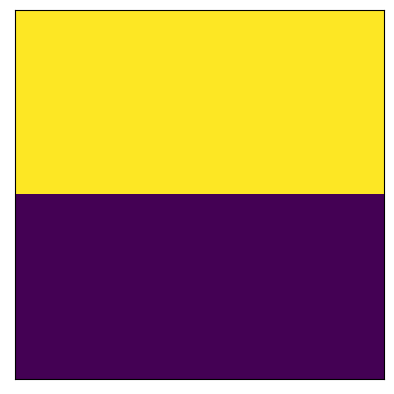

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


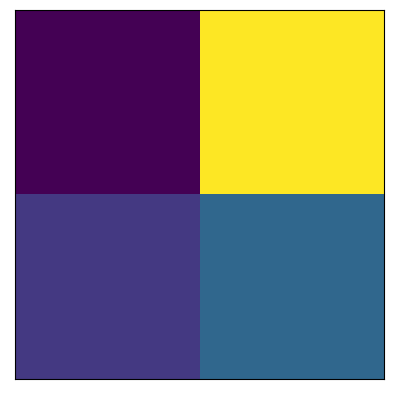

tf.Tensor(
[[0.5  2.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


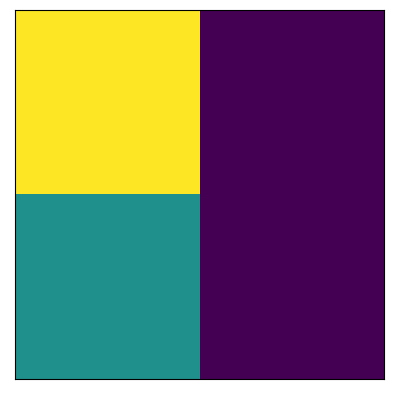

tf.Tensor(
[[0.5  0.  ]
 [0.25 0.  ]], shape=(2, 2), dtype=float32)


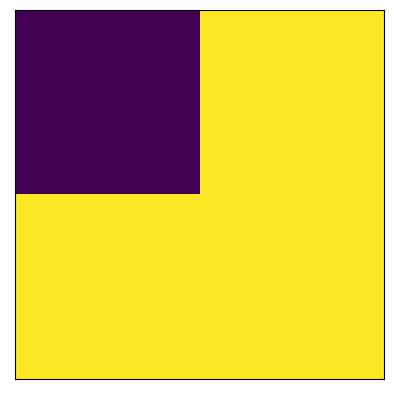

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


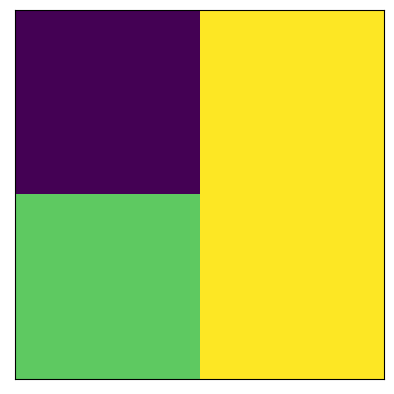

tf.Tensor(
[[0.   1.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


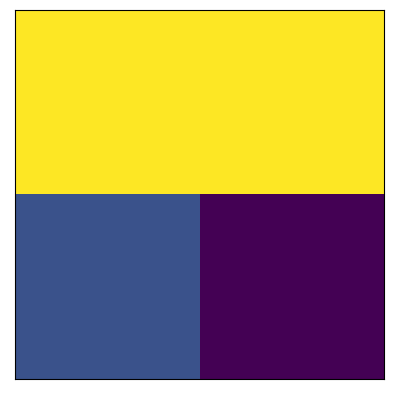

tf.Tensor(
[[1.   1.  ]
 [0.25 0.  ]], shape=(2, 2), dtype=float32)


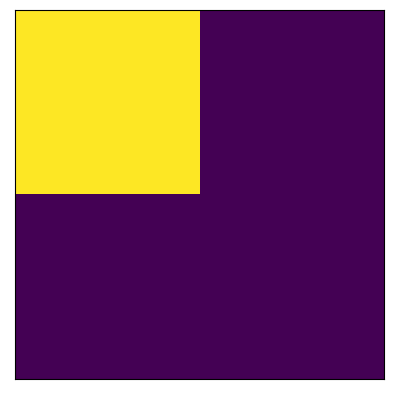

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


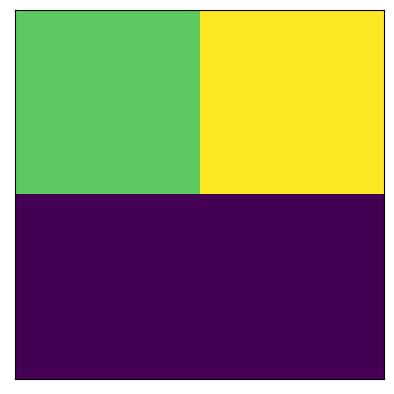

tf.Tensor(
[[0.75 1.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


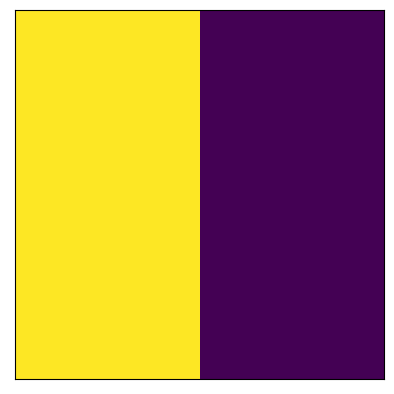

tf.Tensor(
[[0.25 0.  ]
 [0.25 0.  ]], shape=(2, 2), dtype=float32)


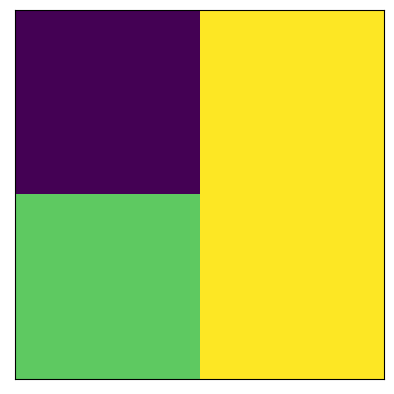

tf.Tensor(
[[0.   1.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


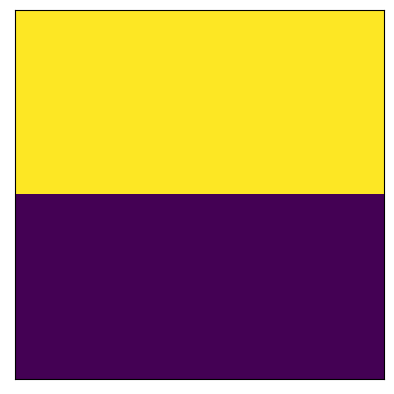

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


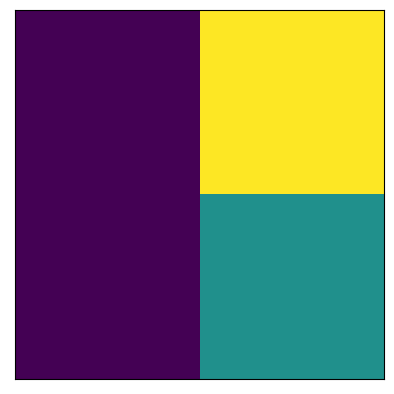

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


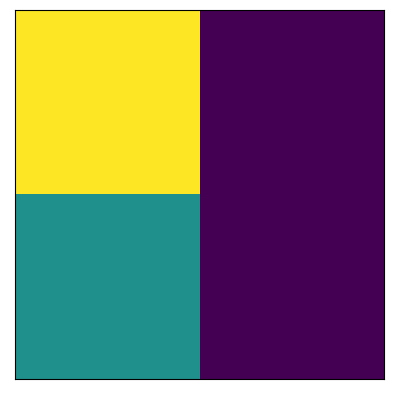

tf.Tensor(
[[8. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


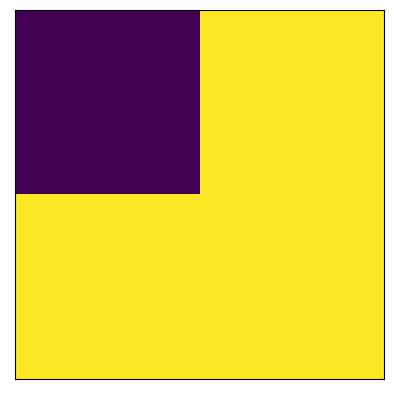

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


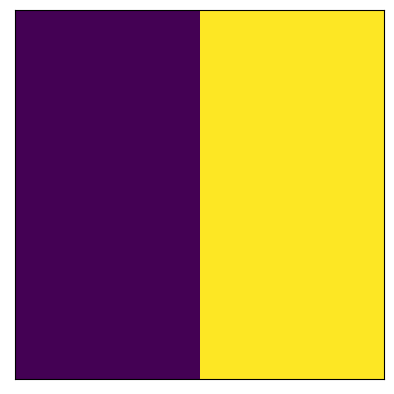

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


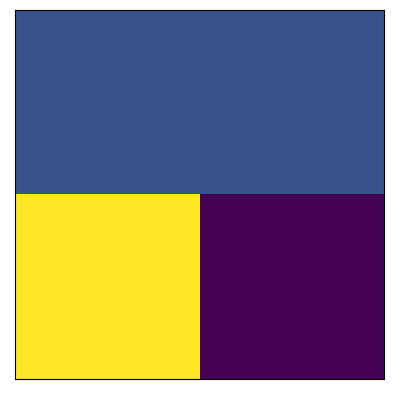

tf.Tensor(
[[1. 1.]
 [4. 0.]], shape=(2, 2), dtype=float32)


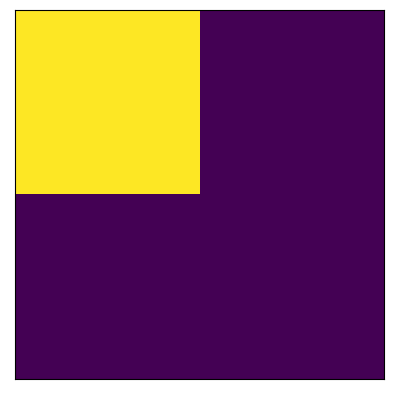

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


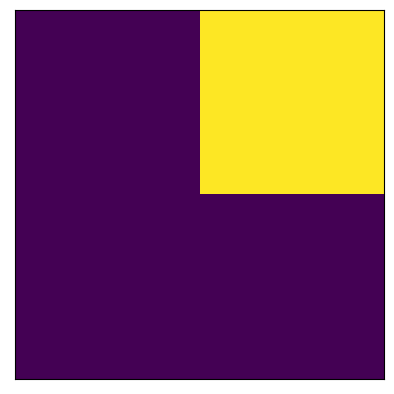

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


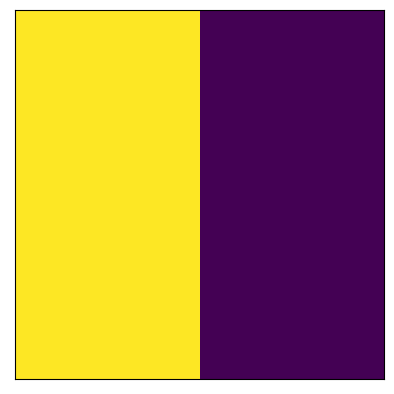

tf.Tensor(
[[4. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


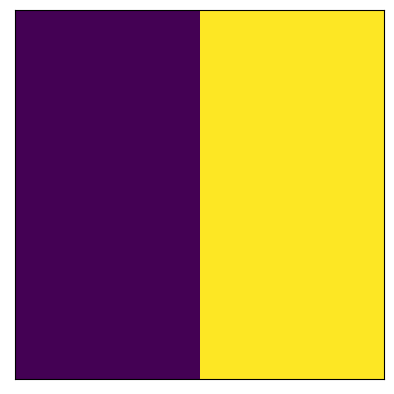

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


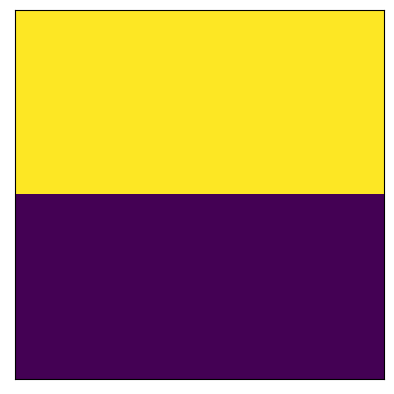

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


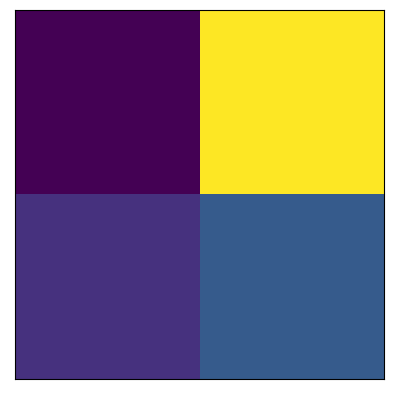

tf.Tensor(
[[0.6 2. ]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


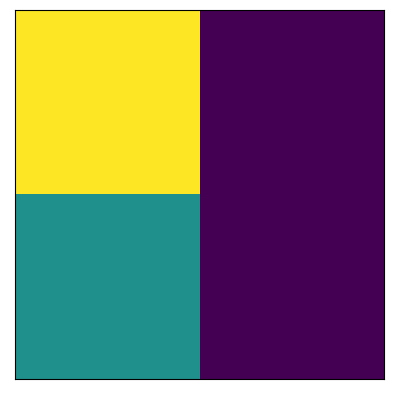

tf.Tensor(
[[0.4 0. ]
 [0.2 0. ]], shape=(2, 2), dtype=float32)


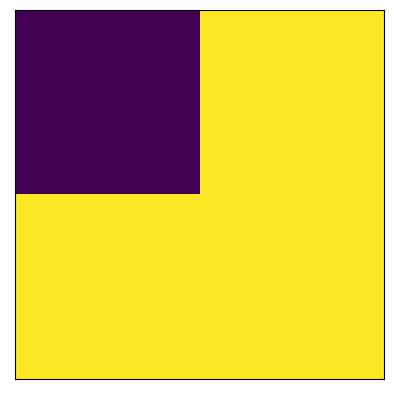

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


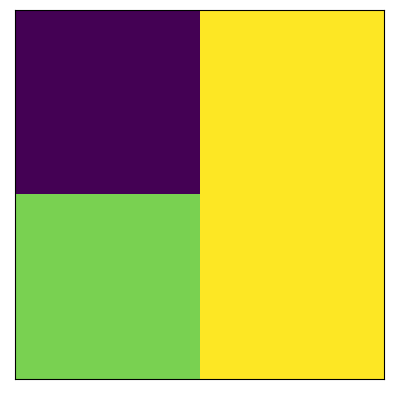

tf.Tensor(
[[2.9802322e-08 1.0000000e+00]
 [8.0000001e-01 1.0000000e+00]], shape=(2, 2), dtype=float32)


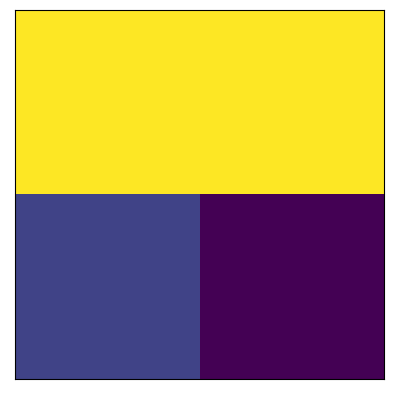

tf.Tensor(
[[1.  1. ]
 [0.2 0. ]], shape=(2, 2), dtype=float32)


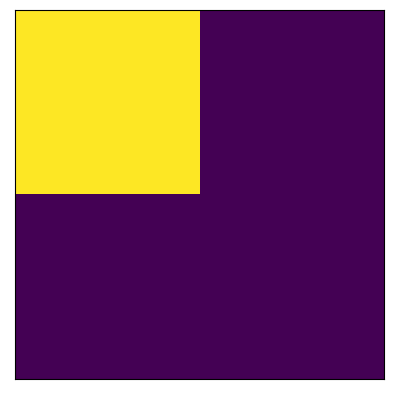

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


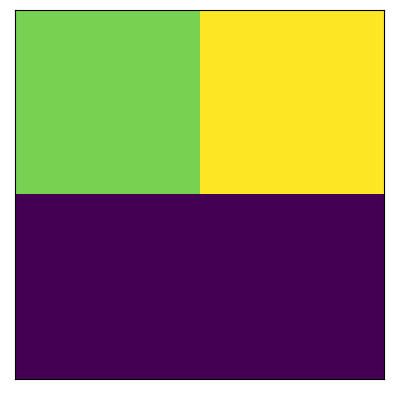

tf.Tensor(
[[0.8 1. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


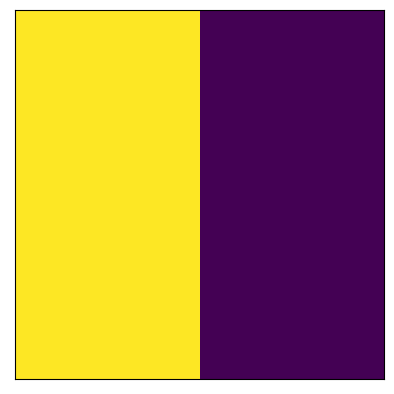

tf.Tensor(
[[0.2 0. ]
 [0.2 0. ]], shape=(2, 2), dtype=float32)


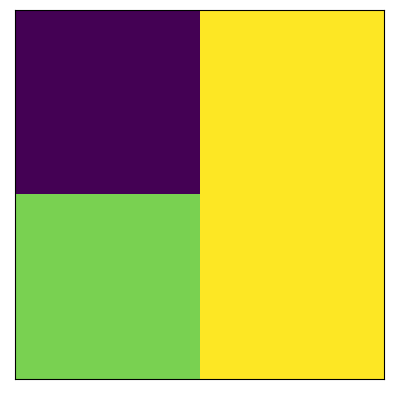

tf.Tensor(
[[0.  1. ]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


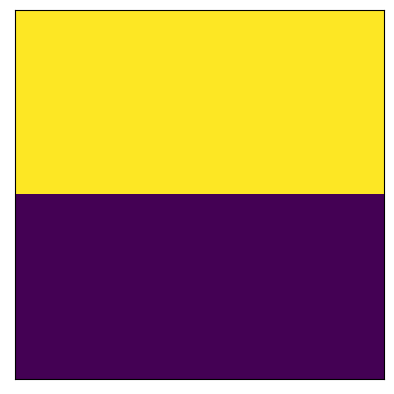

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


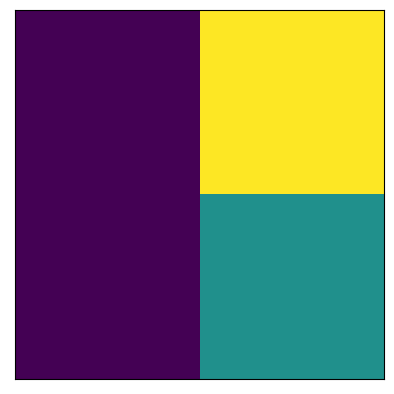

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


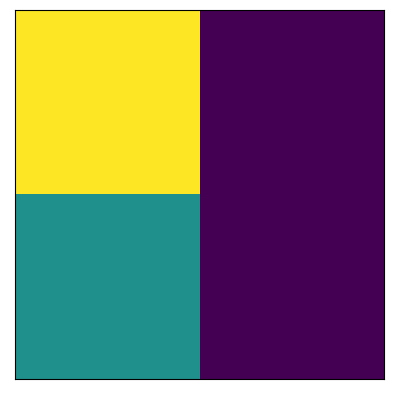

tf.Tensor(
[[10.  0.]
 [ 5.  0.]], shape=(2, 2), dtype=float32)


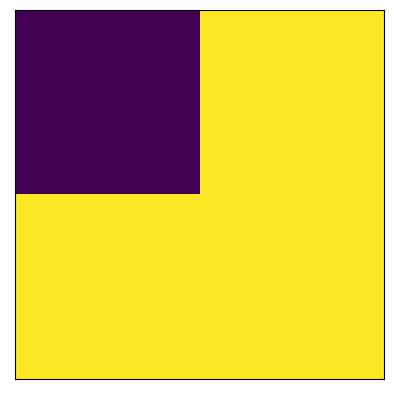

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


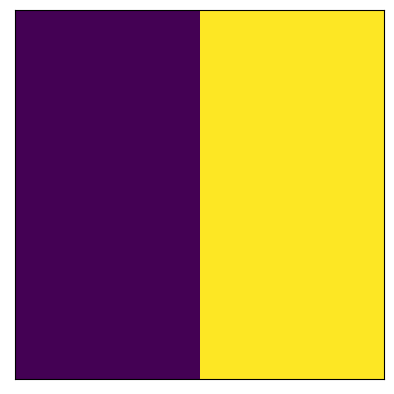

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


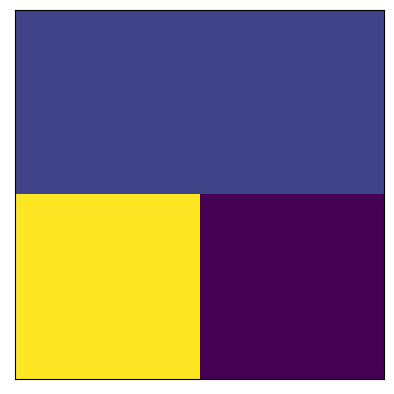

tf.Tensor(
[[1. 1.]
 [5. 0.]], shape=(2, 2), dtype=float32)


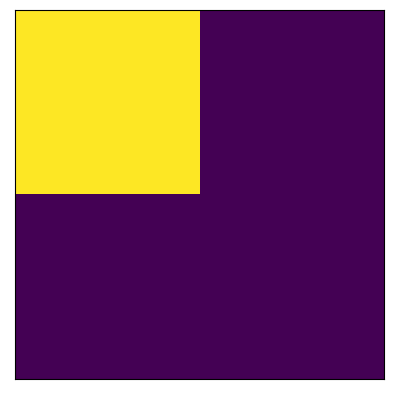

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


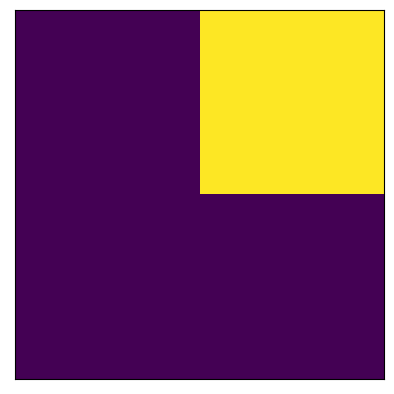

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


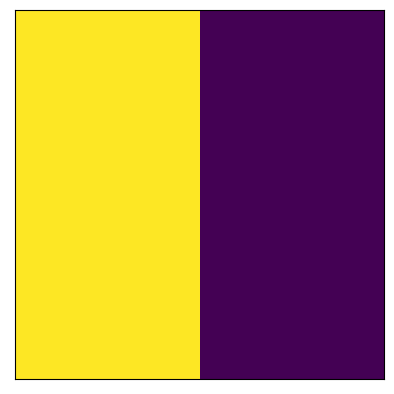

tf.Tensor(
[[5. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


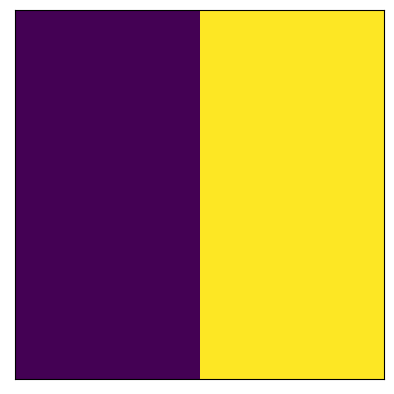

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


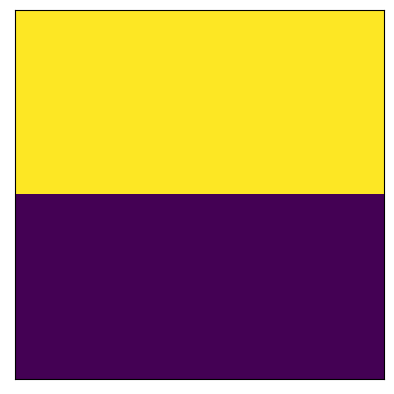

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


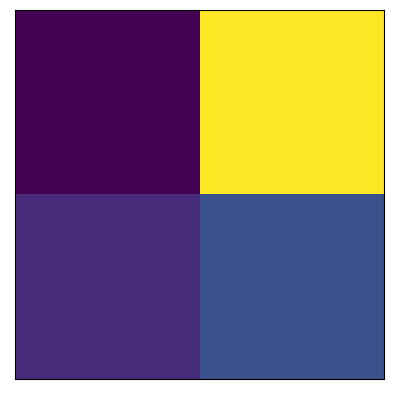

tf.Tensor(
[[0.6666666 2.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


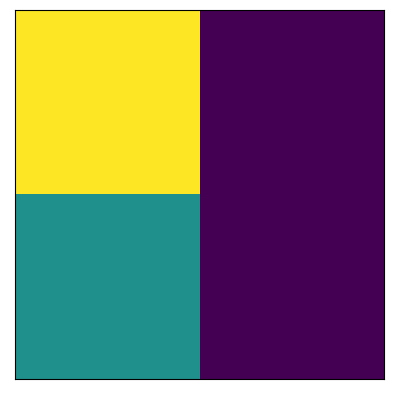

tf.Tensor(
[[0.33333334 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


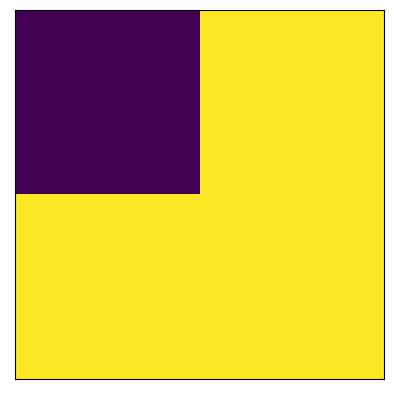

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


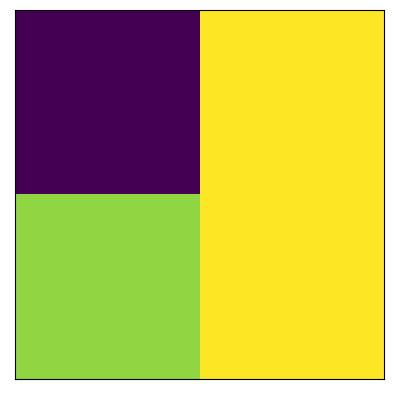

tf.Tensor(
[[0.        1.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


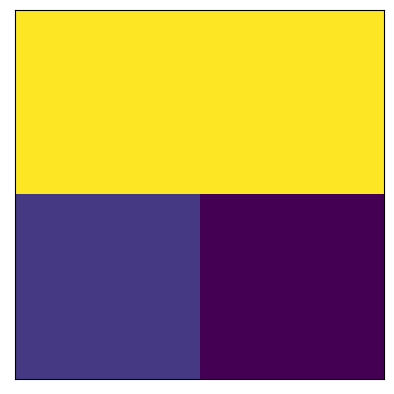

tf.Tensor(
[[1.         1.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


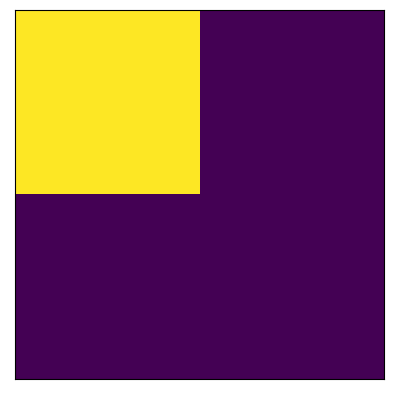

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


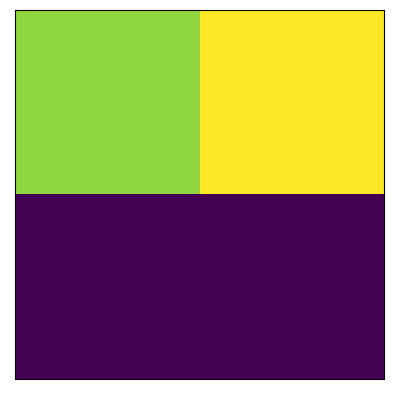

tf.Tensor(
[[0.8333333 1.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


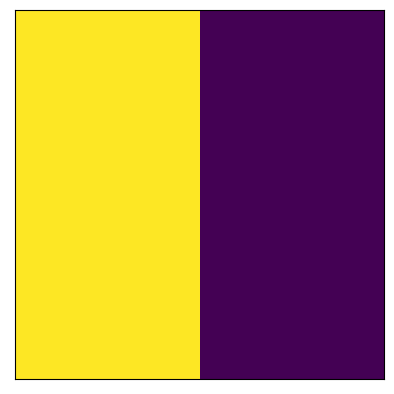

tf.Tensor(
[[0.16666667 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


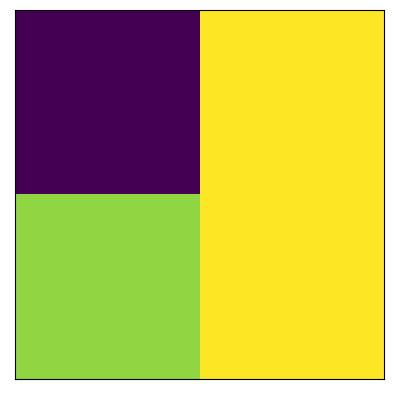

tf.Tensor(
[[0.        1.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


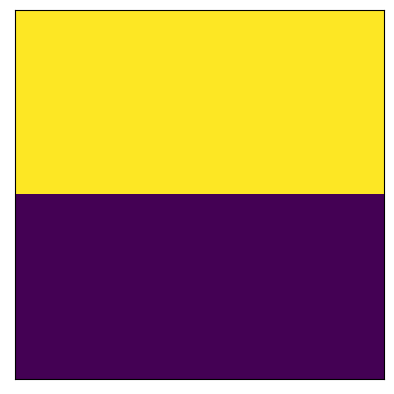

tf.Tensor(
[[1. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


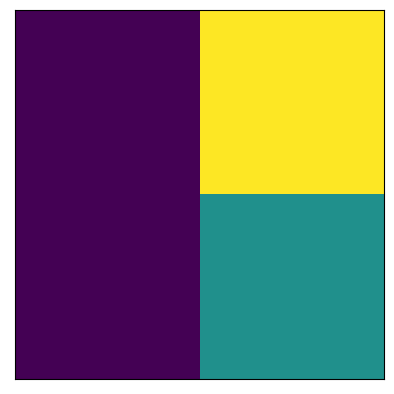

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


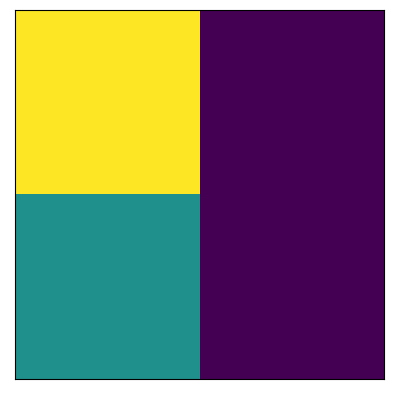

tf.Tensor(
[[12.  0.]
 [ 6.  0.]], shape=(2, 2), dtype=float32)


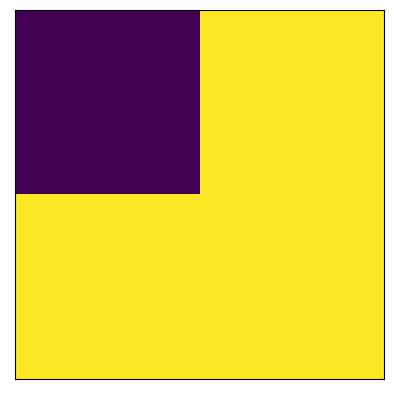

tf.Tensor(
[[0. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


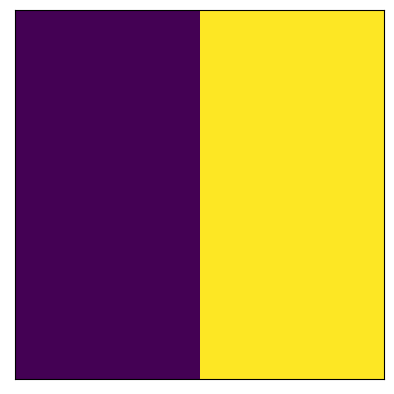

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


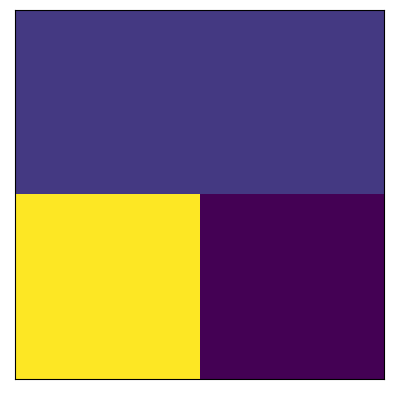

tf.Tensor(
[[1. 1.]
 [6. 0.]], shape=(2, 2), dtype=float32)


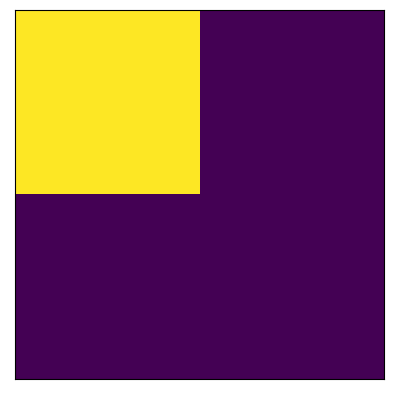

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


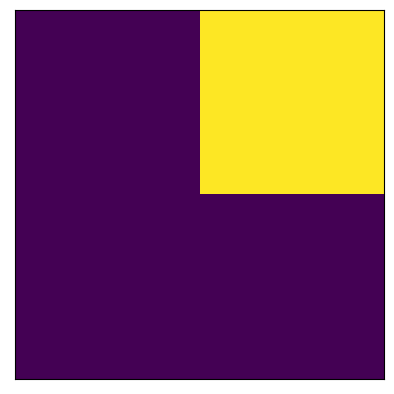

tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


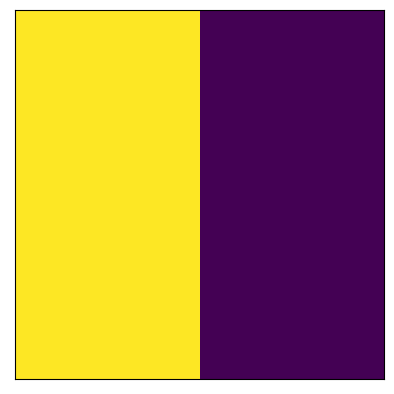

tf.Tensor(
[[6. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


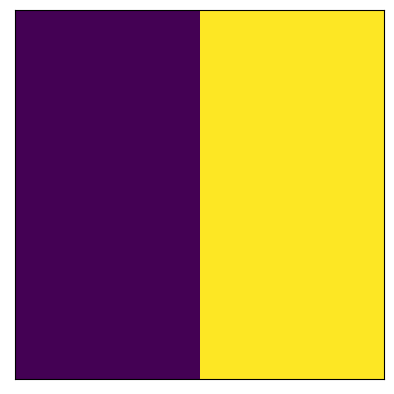

tf.Tensor(
[[0. 1.]
 [0. 1.]], shape=(2, 2), dtype=float32)


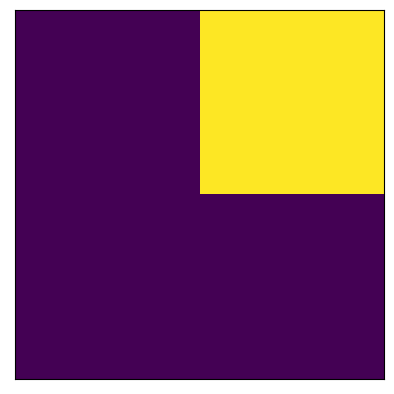

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


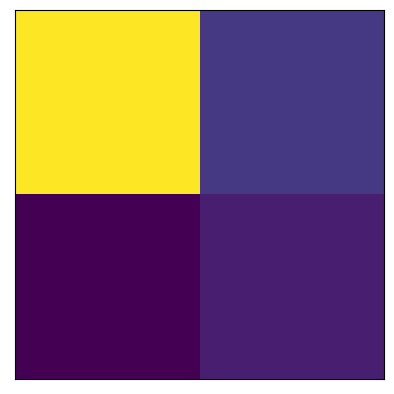

tf.Tensor(
[[12.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


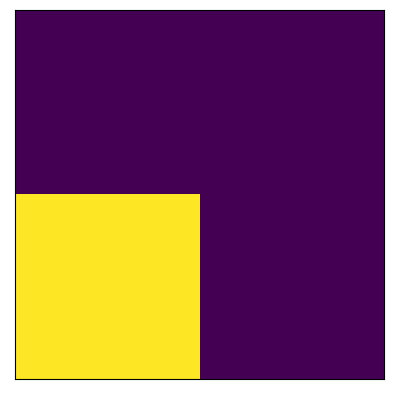

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


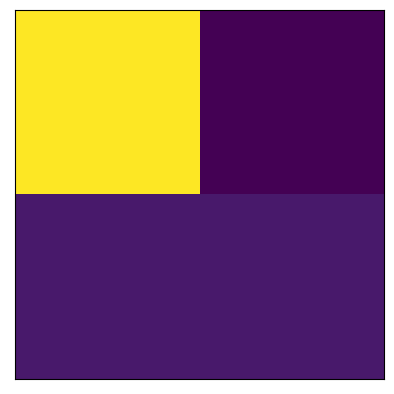

tf.Tensor(
[[15.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


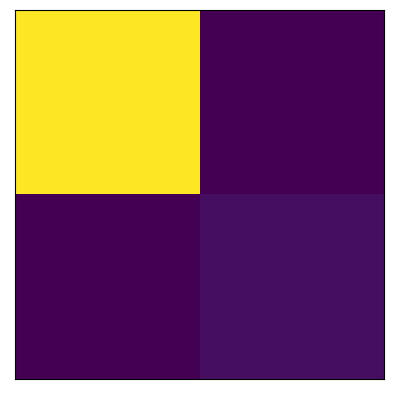

tf.Tensor(
[[28.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


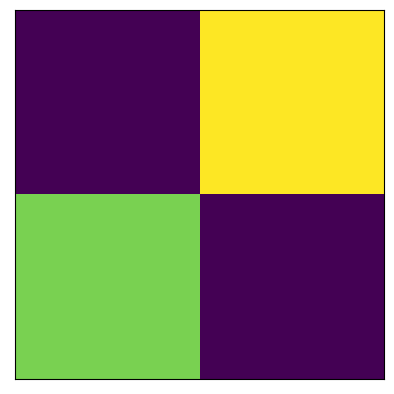

tf.Tensor(
[[0. 5.]
 [4. 0.]], shape=(2, 2), dtype=float32)


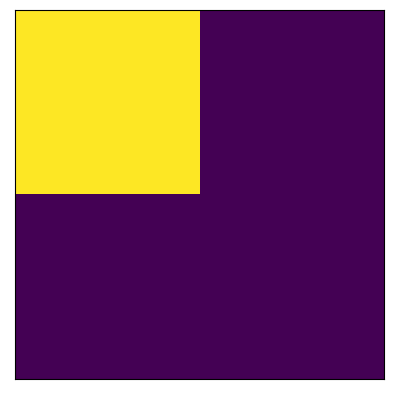

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


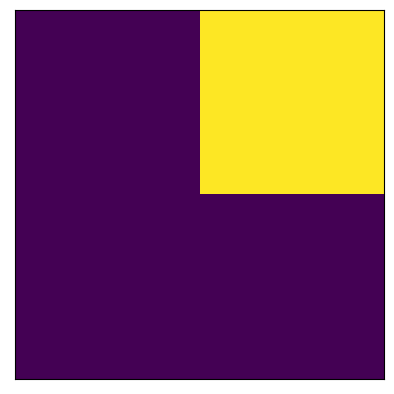

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


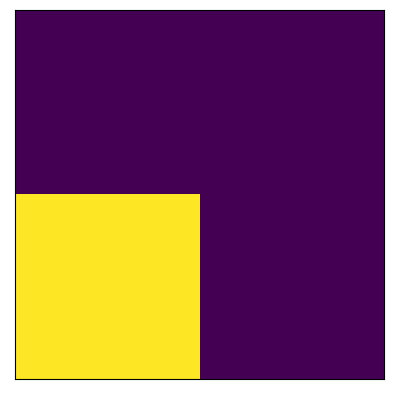

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


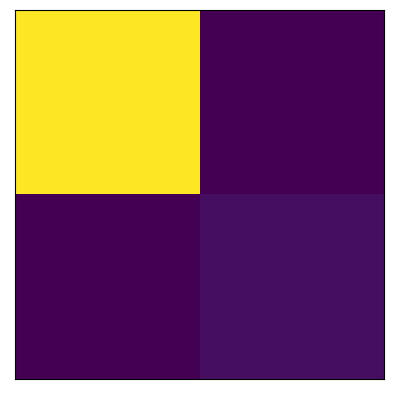

tf.Tensor(
[[27.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


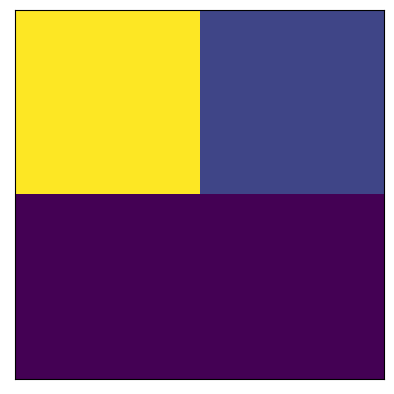

tf.Tensor(
[[0.96 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


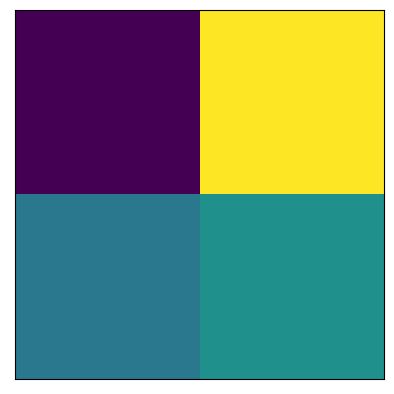

tf.Tensor(
[[0.  2. ]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


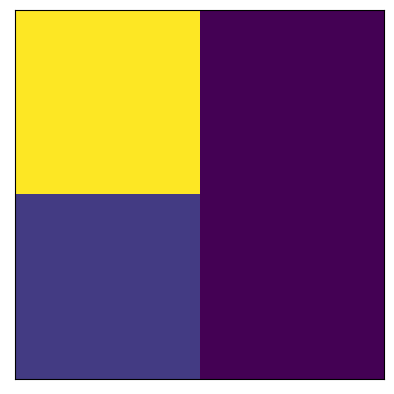

tf.Tensor(
[[1.16 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


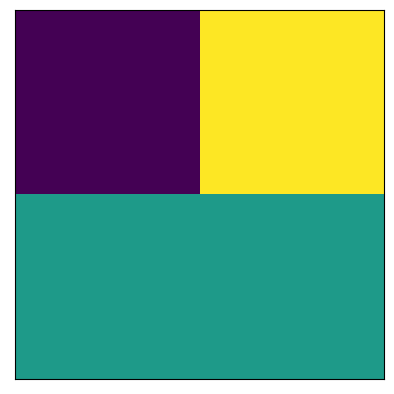

tf.Tensor(
[[0.04000002 1.8       ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


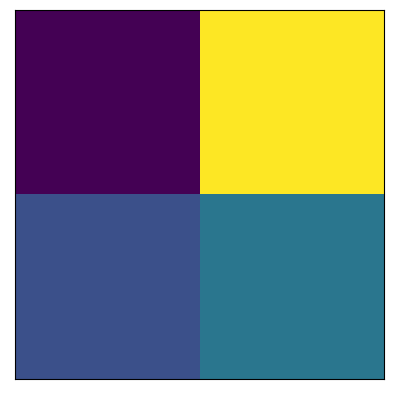

tf.Tensor(
[[0.48000002 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


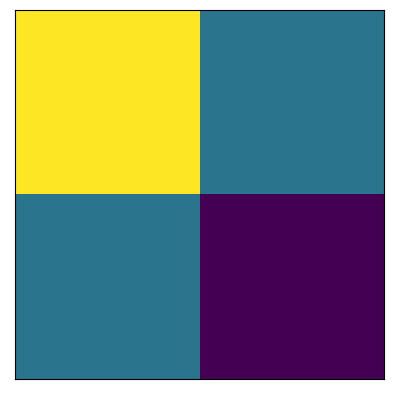

tf.Tensor(
[[0.52000004 0.2       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


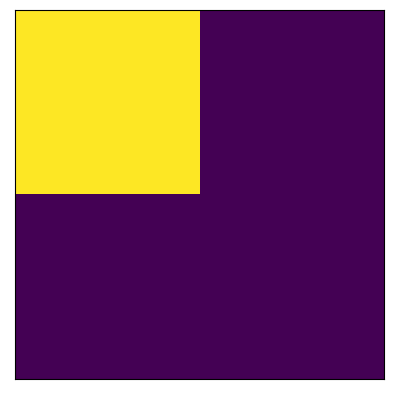

tf.Tensor(
[[0.8 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


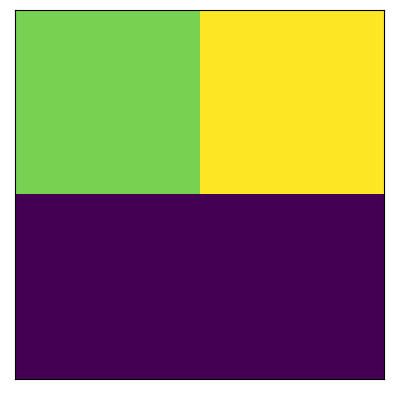

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


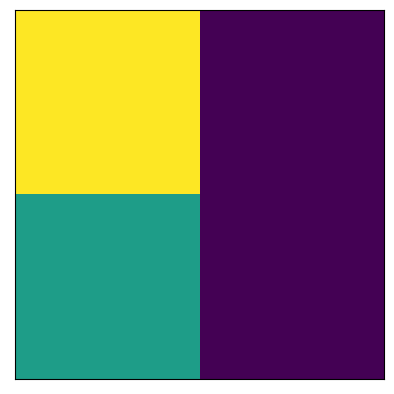

tf.Tensor(
[[0.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


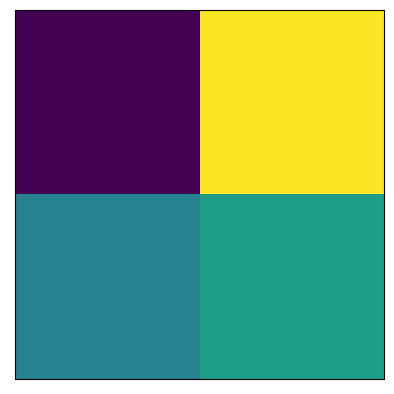

tf.Tensor(
[[0.  1.8]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


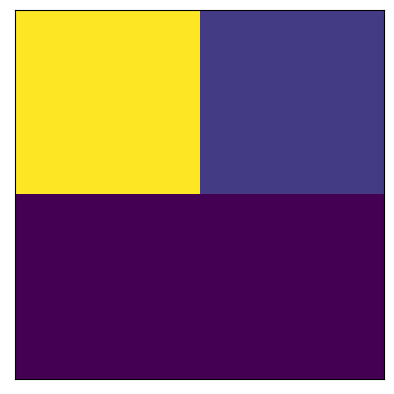

tf.Tensor(
[[1.4375 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


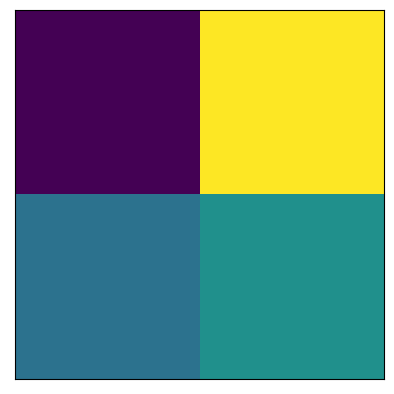

tf.Tensor(
[[0.   2.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


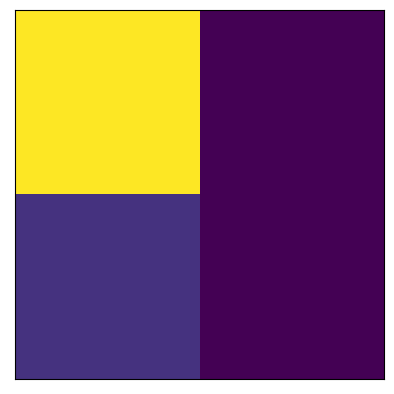

tf.Tensor(
[[1.6875 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


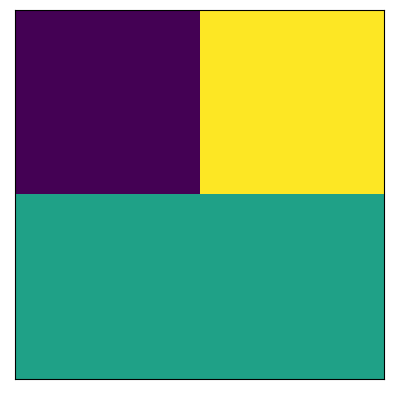

tf.Tensor(
[[0.   1.75]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


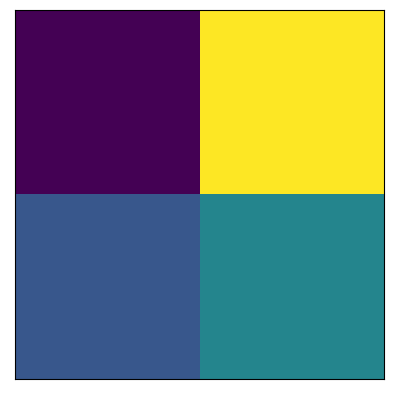

tf.Tensor(
[[0.375 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


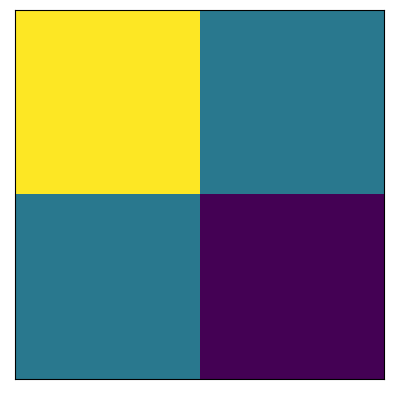

tf.Tensor(
[[0.625 0.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


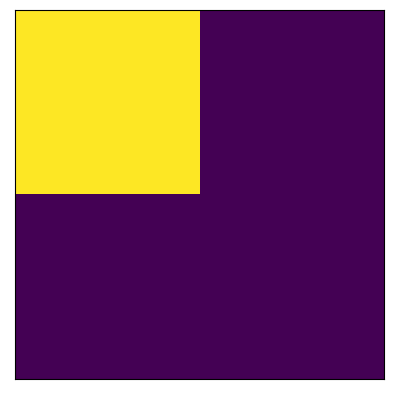

tf.Tensor(
[[1.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


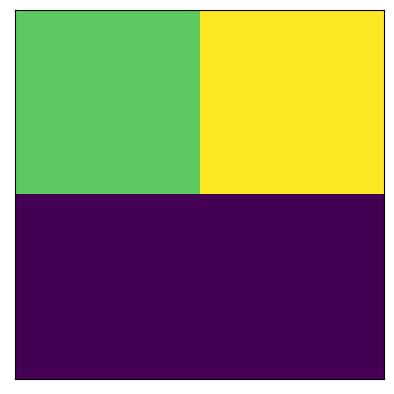

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


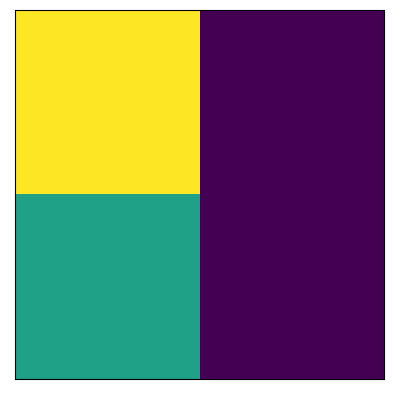

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


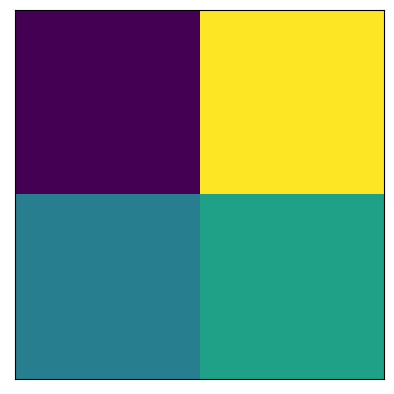

tf.Tensor(
[[0.   1.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


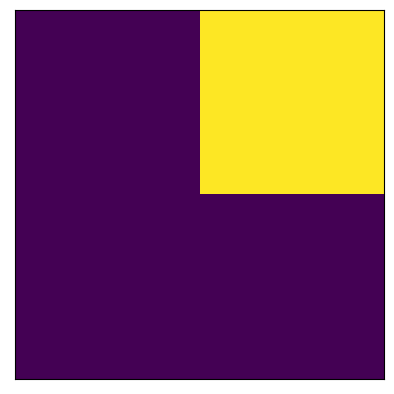

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


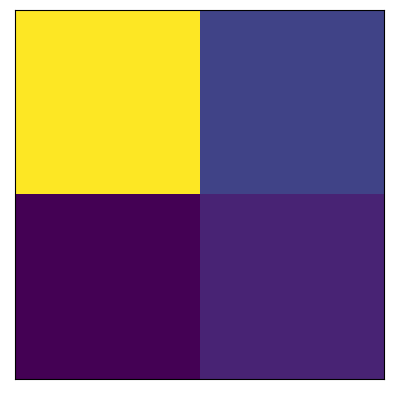

tf.Tensor(
[[10.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


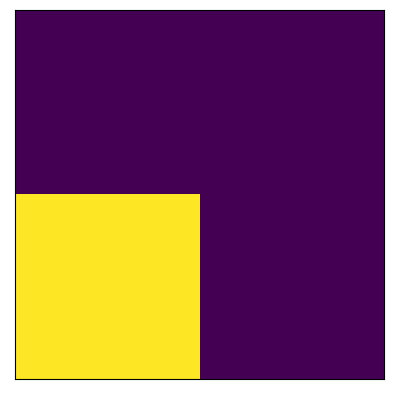

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


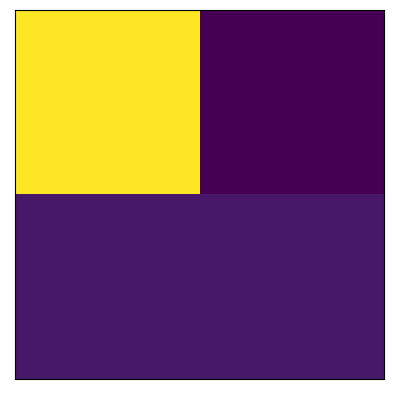

tf.Tensor(
[[16.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


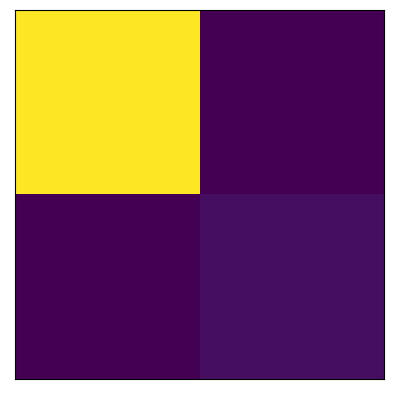

tf.Tensor(
[[27.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


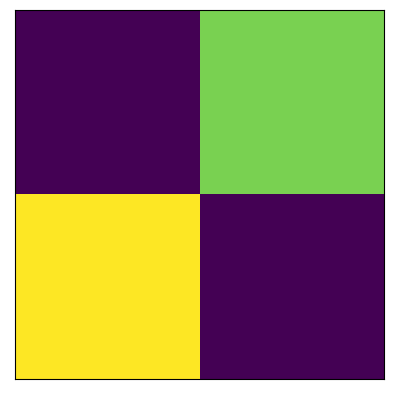

tf.Tensor(
[[0. 4.]
 [5. 0.]], shape=(2, 2), dtype=float32)


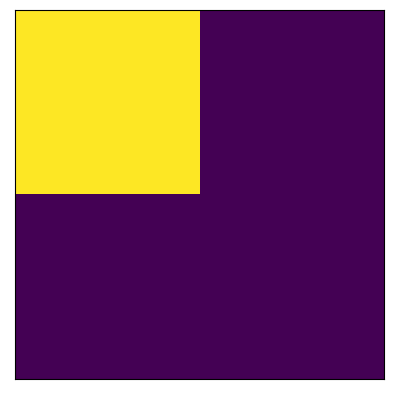

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


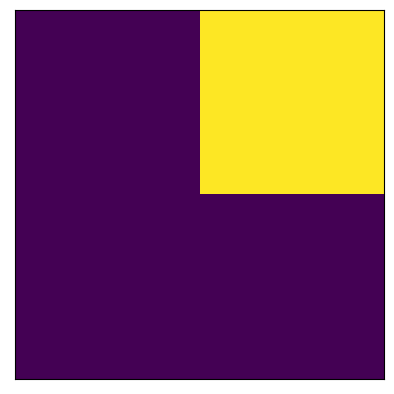

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


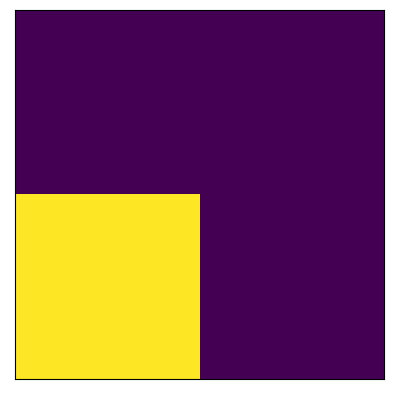

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


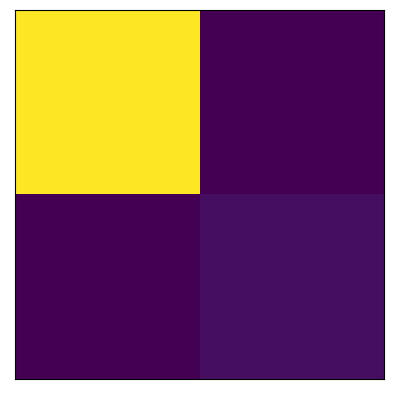

tf.Tensor(
[[26.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


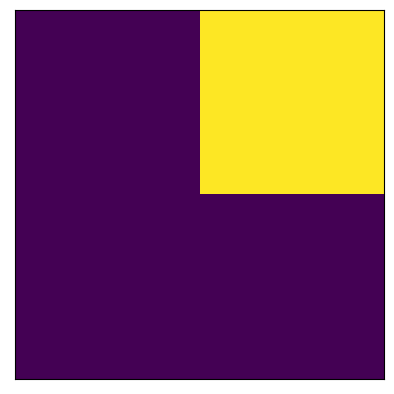

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


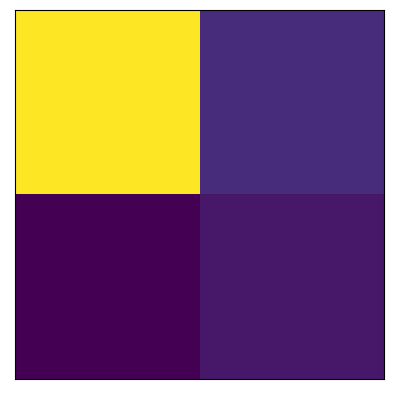

tf.Tensor(
[[16.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


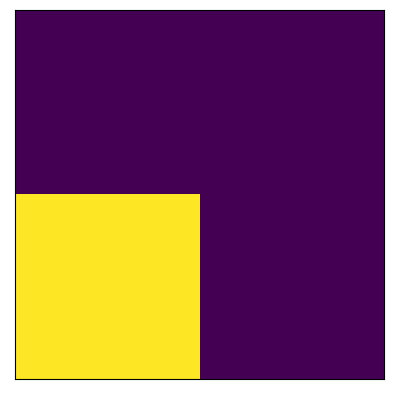

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


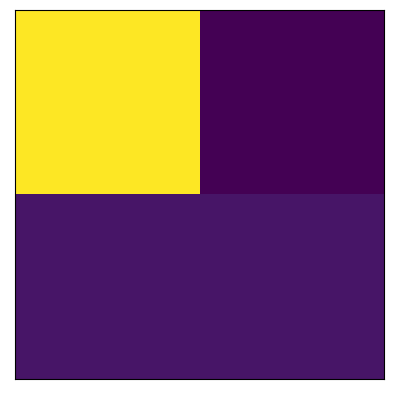

tf.Tensor(
[[18.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


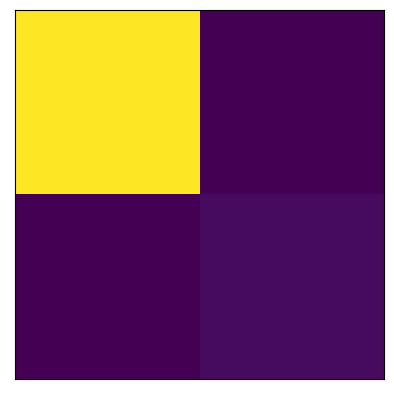

tf.Tensor(
[[35.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


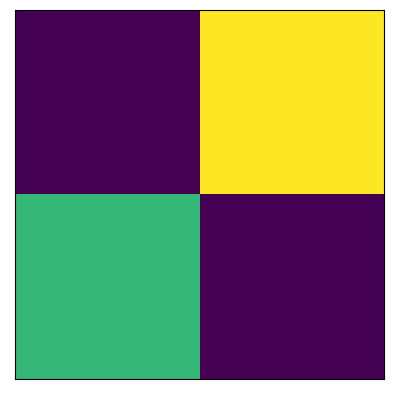

tf.Tensor(
[[0. 6.]
 [4. 0.]], shape=(2, 2), dtype=float32)


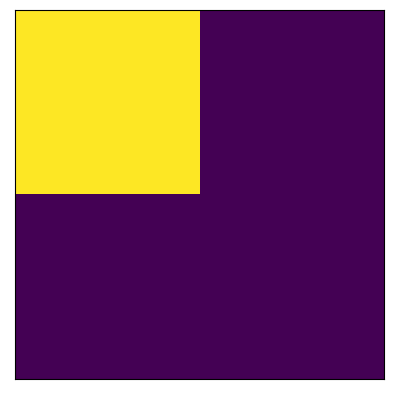

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


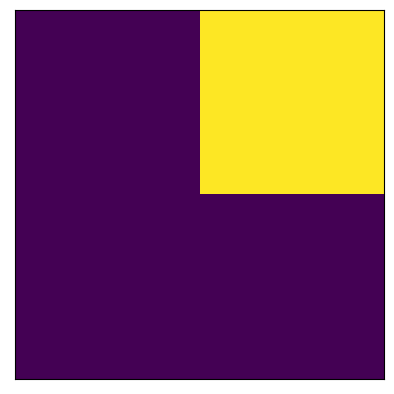

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


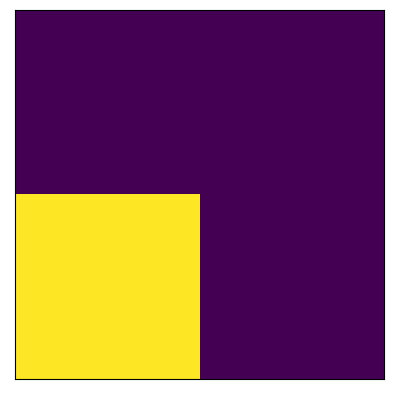

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


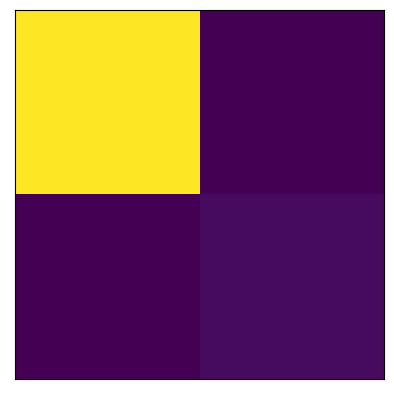

tf.Tensor(
[[34.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


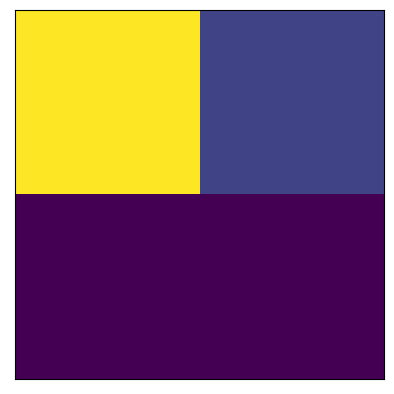

tf.Tensor(
[[0.8055556  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


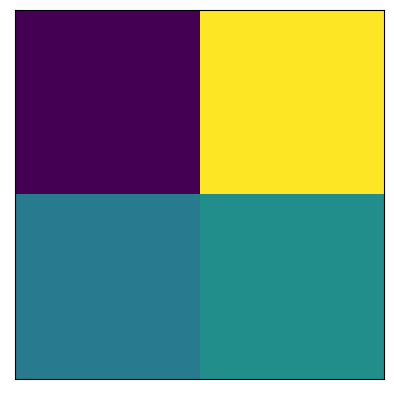

tf.Tensor(
[[0.02777773 2.        ]
 [0.8333333  1.        ]], shape=(2, 2), dtype=float32)


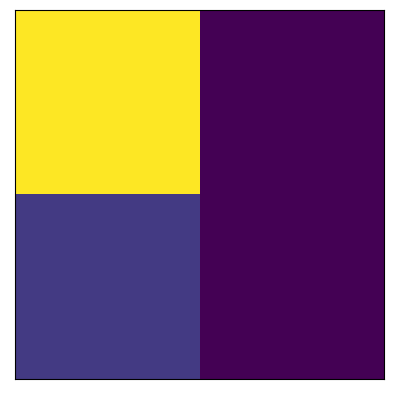

tf.Tensor(
[[0.9722222  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


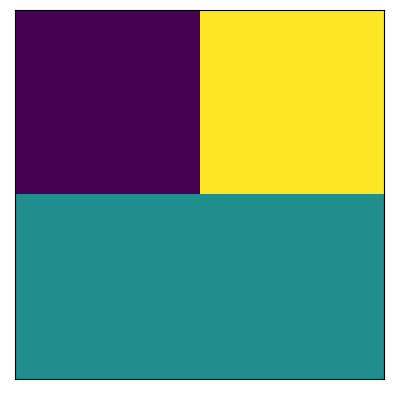

tf.Tensor(
[[0.19444442 1.8333334 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


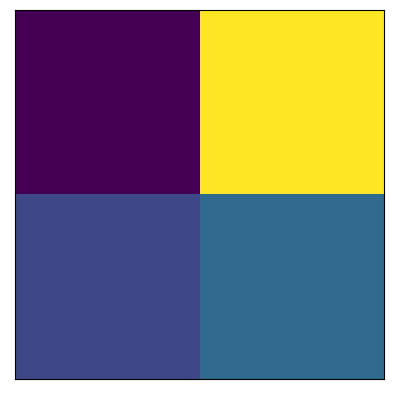

tf.Tensor(
[[0.5555555 1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


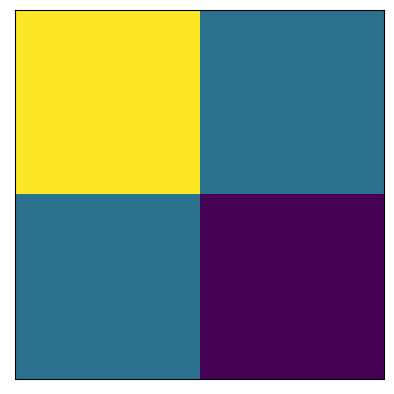

tf.Tensor(
[[0.44444445 0.16666667]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


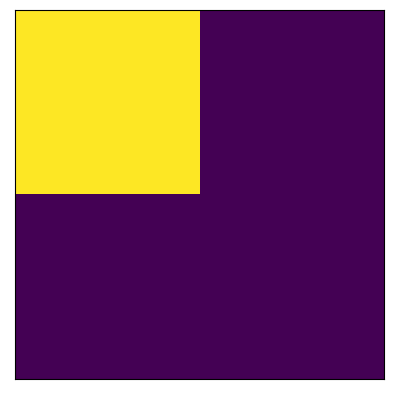

tf.Tensor(
[[0.6666667 0.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


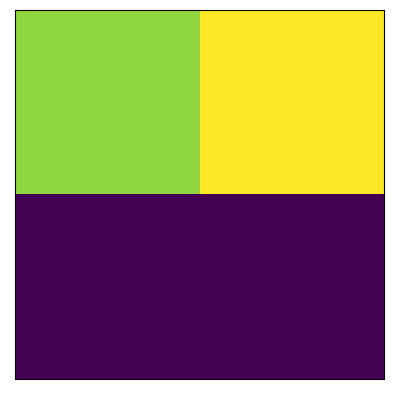

tf.Tensor(
[[0.1388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


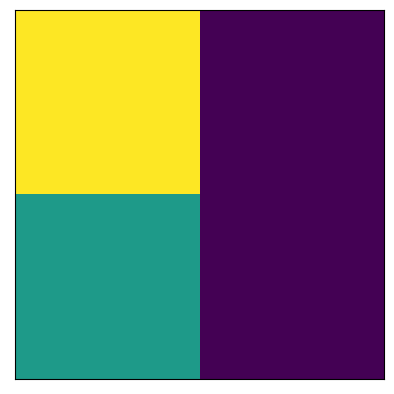

tf.Tensor(
[[0.30555555 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


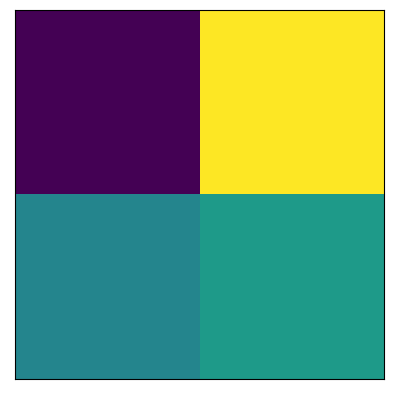

tf.Tensor(
[[0.        1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


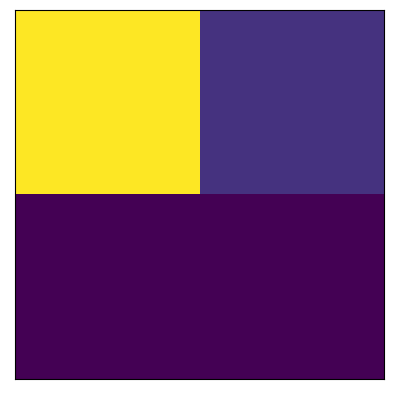

tf.Tensor(
[[1.6875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


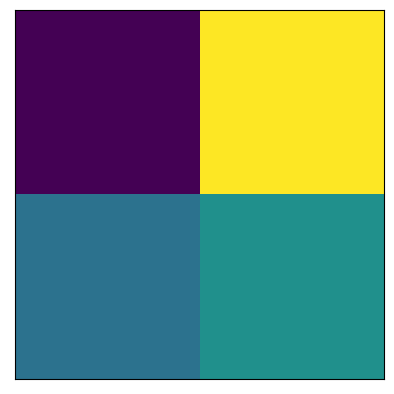

tf.Tensor(
[[0.   2.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


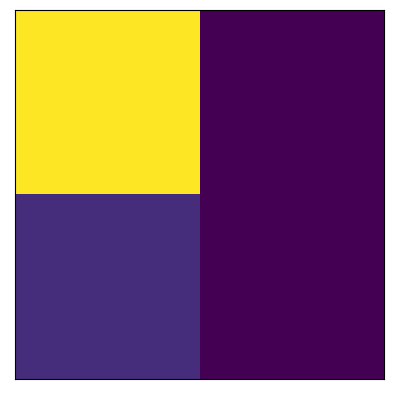

tf.Tensor(
[[1.9375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


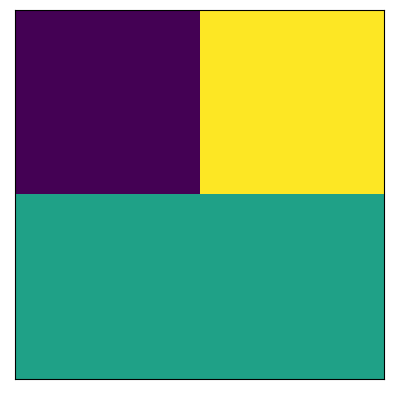

tf.Tensor(
[[0.   1.75]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


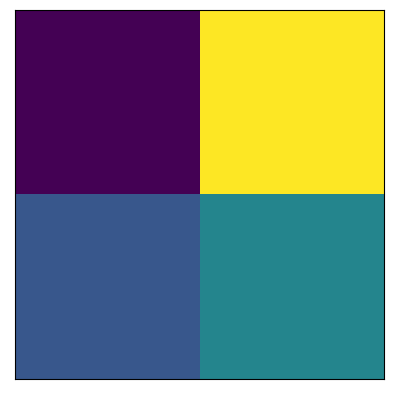

tf.Tensor(
[[0.375 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


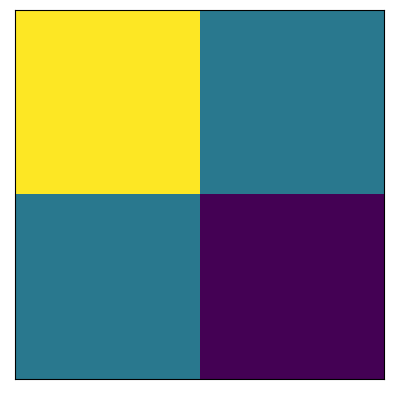

tf.Tensor(
[[0.625 0.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


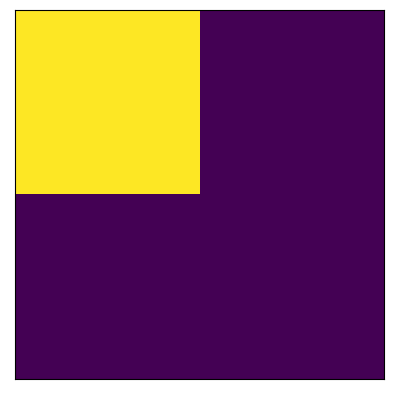

tf.Tensor(
[[1.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


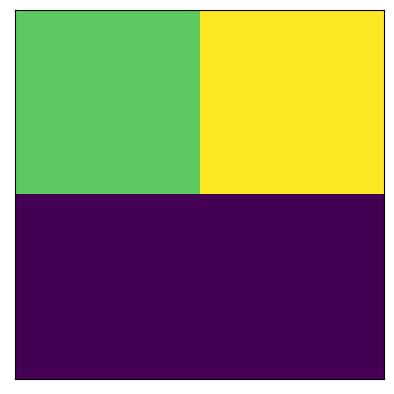

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


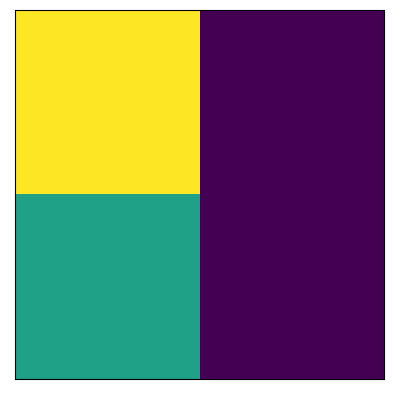

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


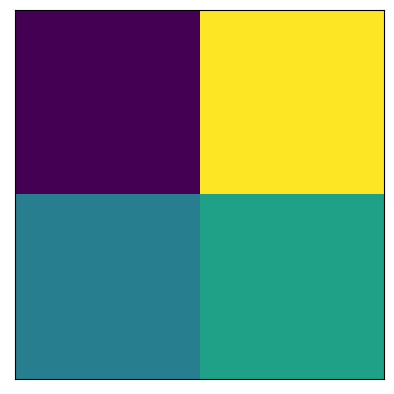

tf.Tensor(
[[0.   1.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


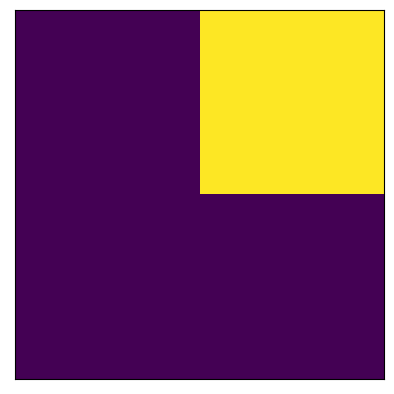

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


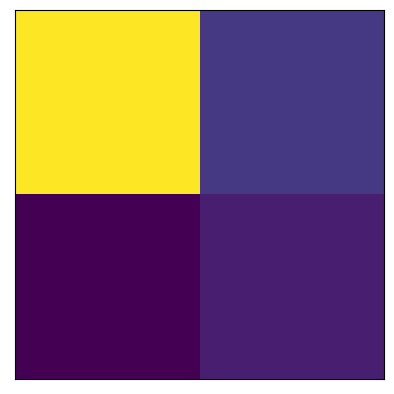

tf.Tensor(
[[12.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


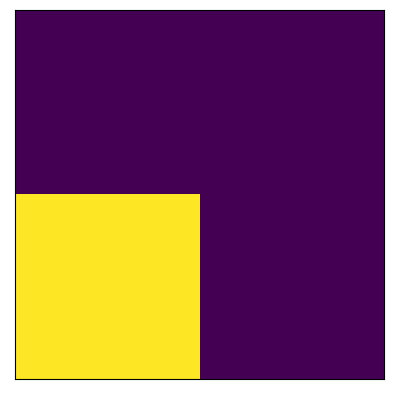

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


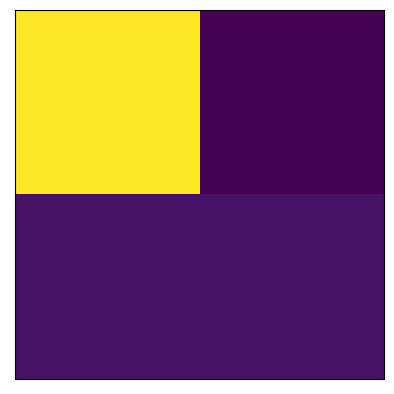

tf.Tensor(
[[20.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


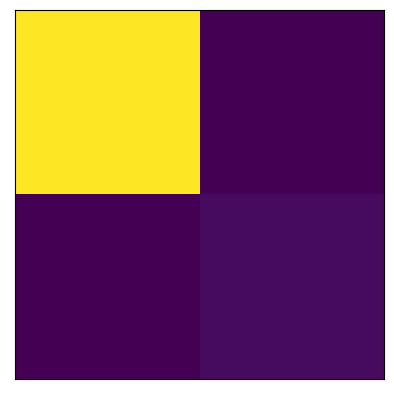

tf.Tensor(
[[33.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


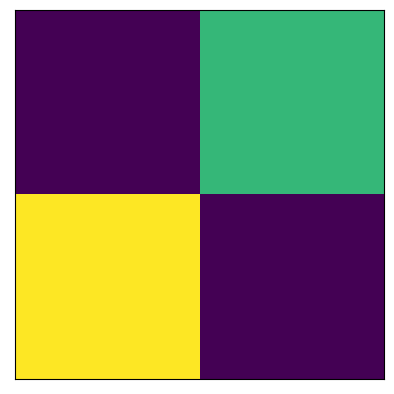

tf.Tensor(
[[0. 4.]
 [6. 0.]], shape=(2, 2), dtype=float32)


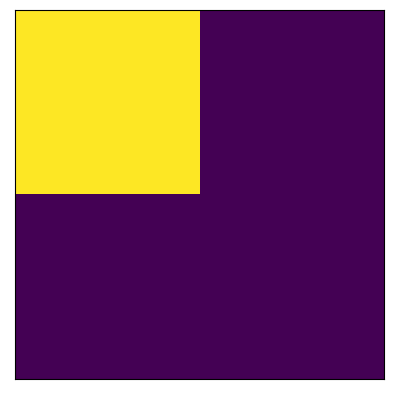

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


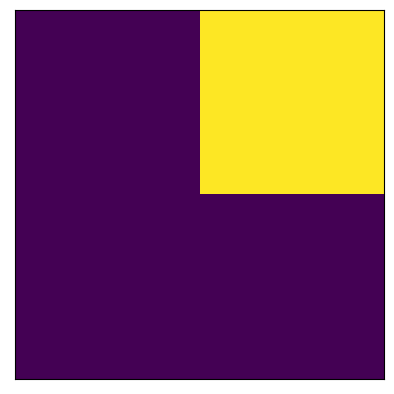

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


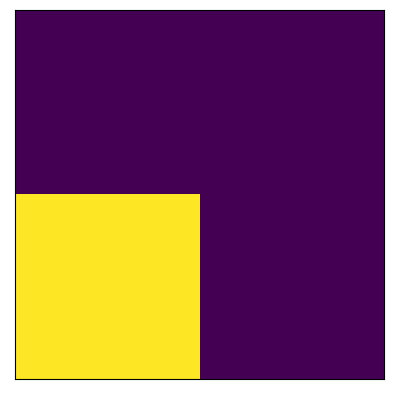

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


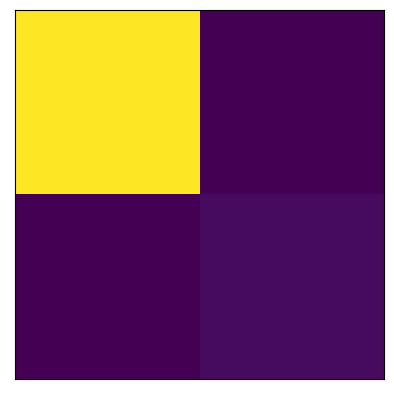

tf.Tensor(
[[32.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


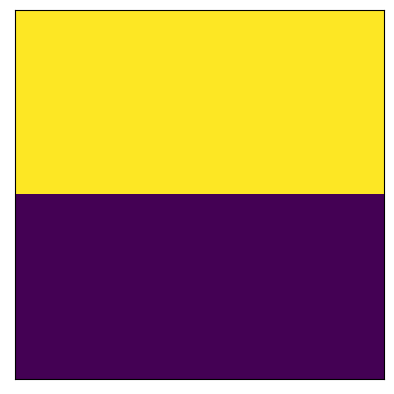

tf.Tensor(
[[2. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


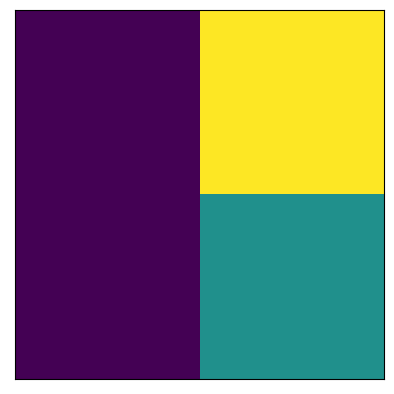

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


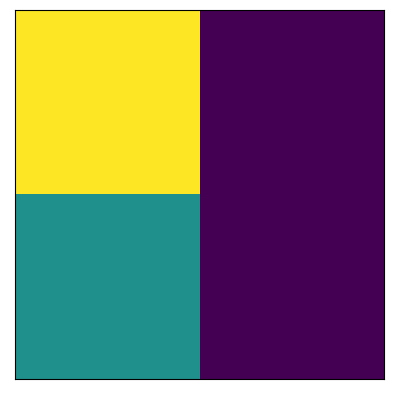

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


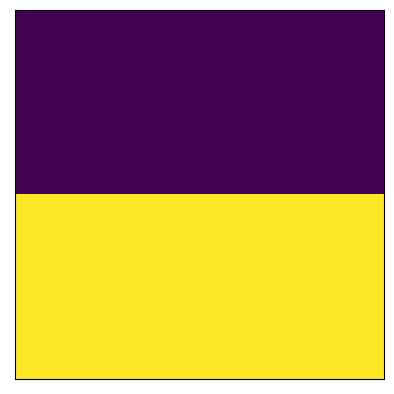

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


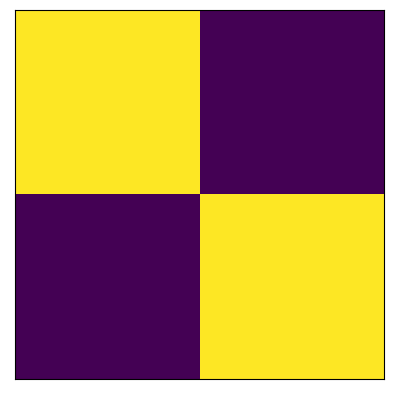

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


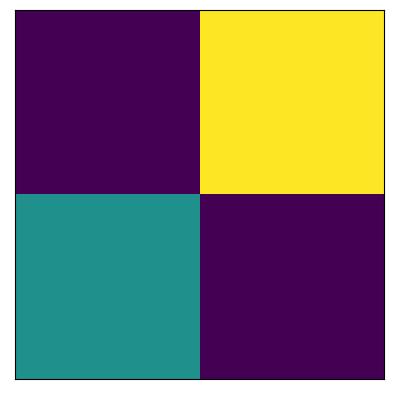

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)


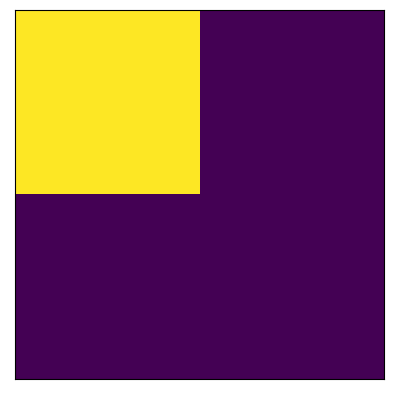

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


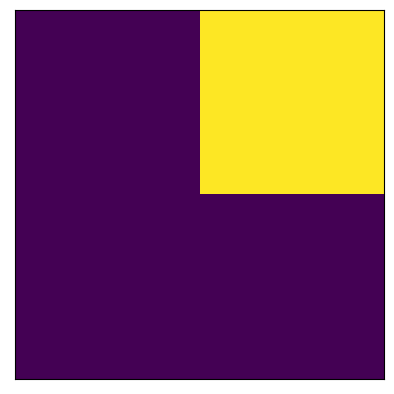

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


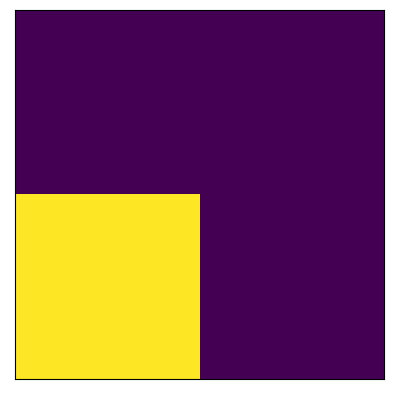

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


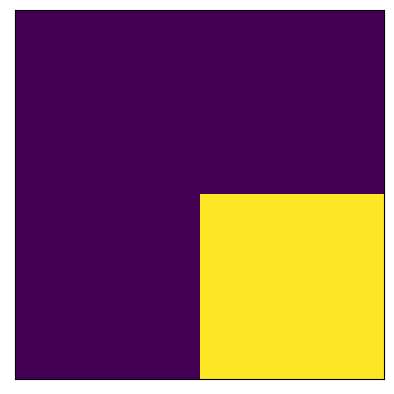

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


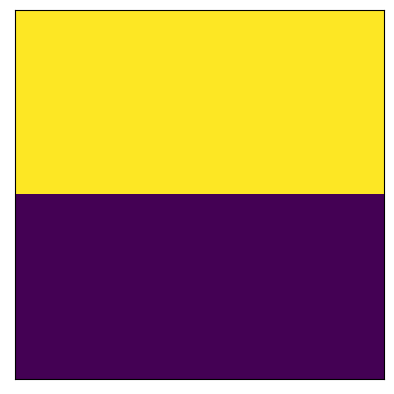

tf.Tensor(
[[0.5 0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


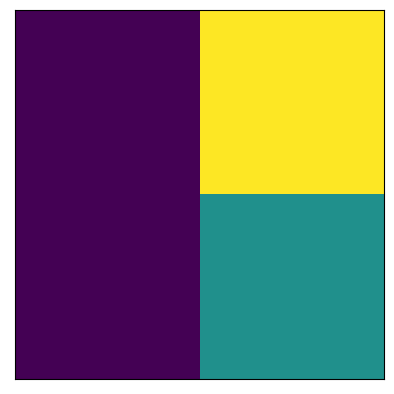

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


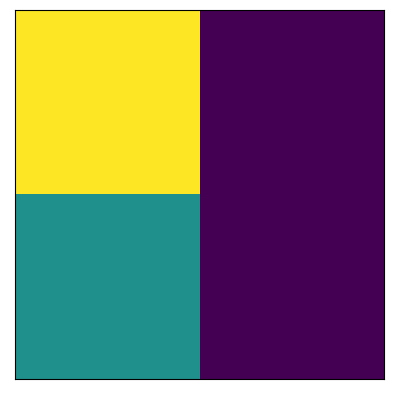

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


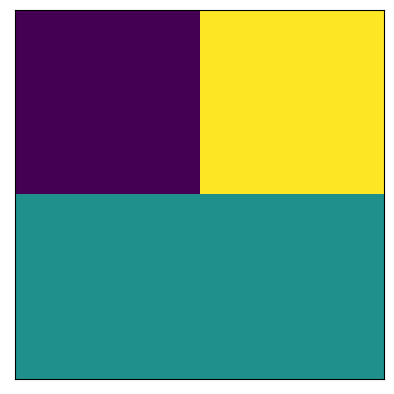

tf.Tensor(
[[0.5 1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


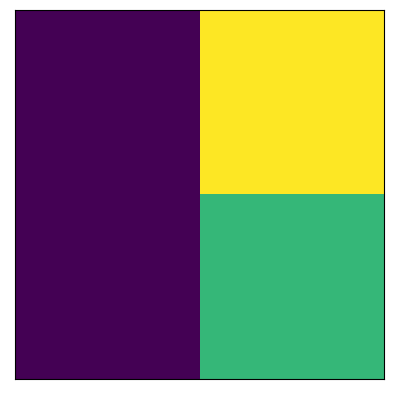

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


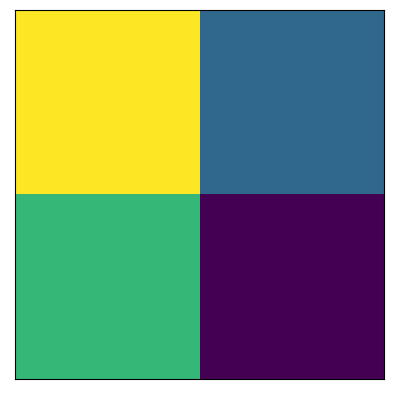

tf.Tensor(
[[1.5 0.5]
 [1.  0. ]], shape=(2, 2), dtype=float32)


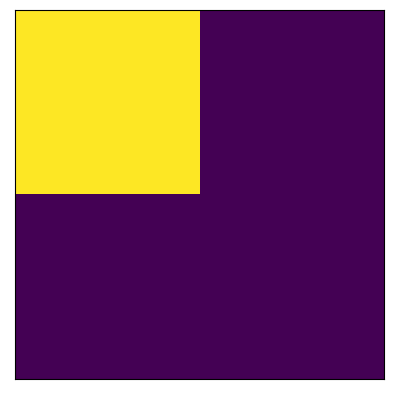

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


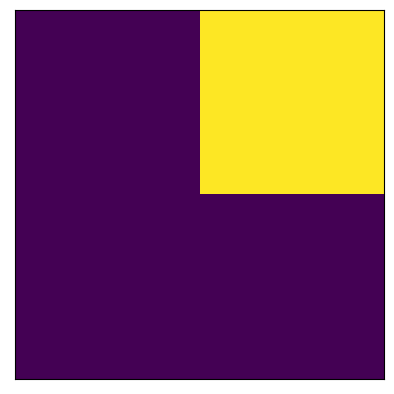

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


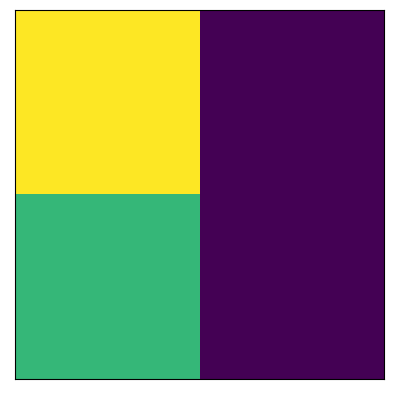

tf.Tensor(
[[1.5 0. ]
 [1.  0. ]], shape=(2, 2), dtype=float32)


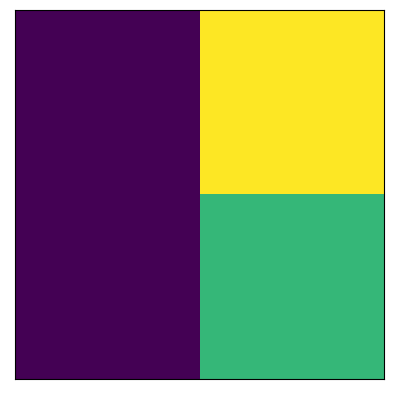

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


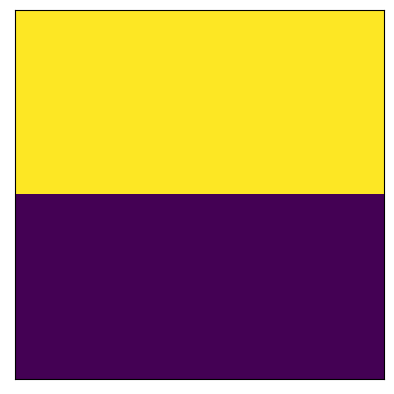

tf.Tensor(
[[3. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


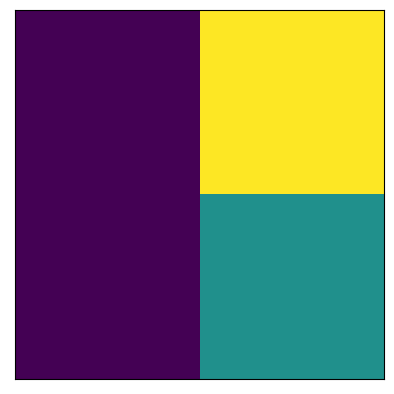

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


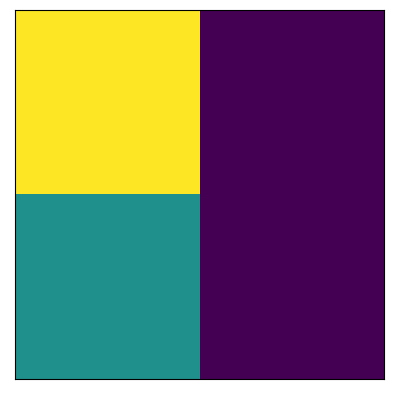

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


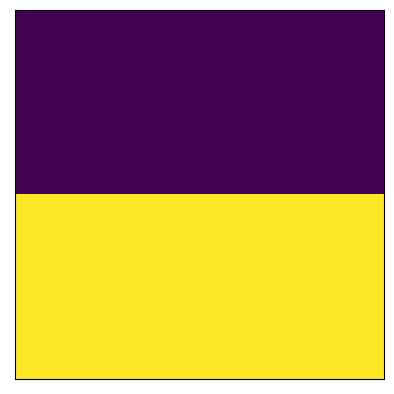

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


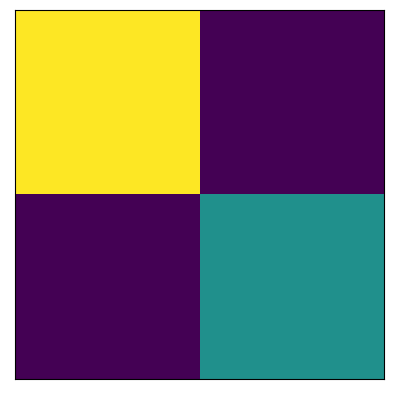

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


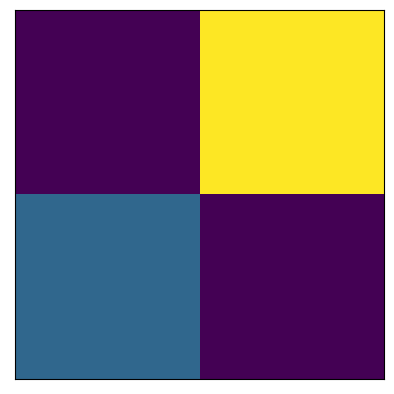

tf.Tensor(
[[0. 3.]
 [1. 0.]], shape=(2, 2), dtype=float32)


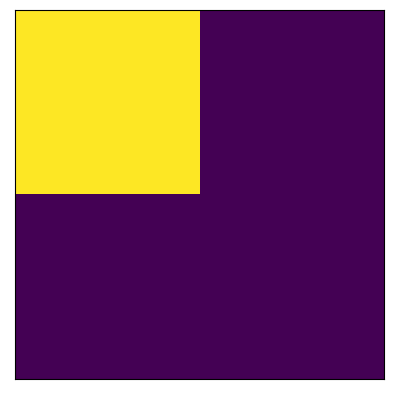

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


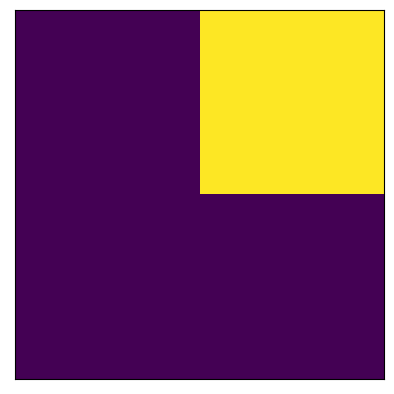

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


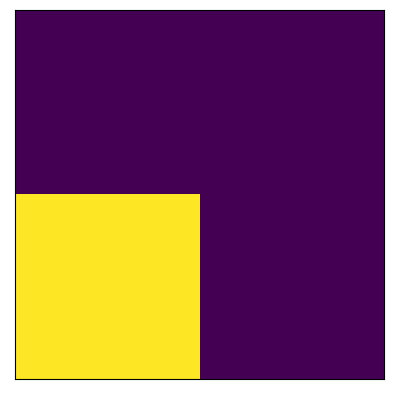

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


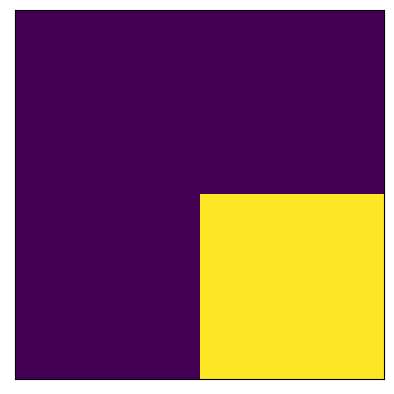

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


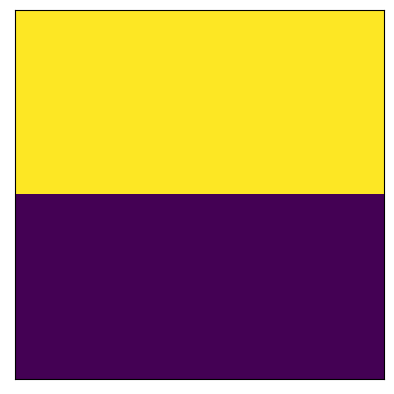

tf.Tensor(
[[0.33333334 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


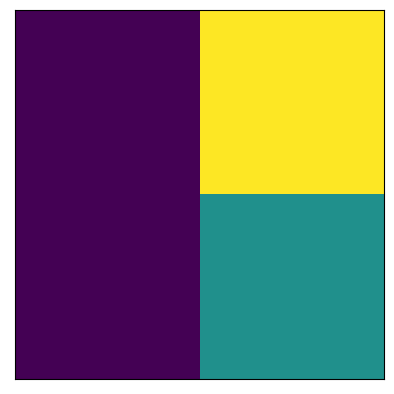

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


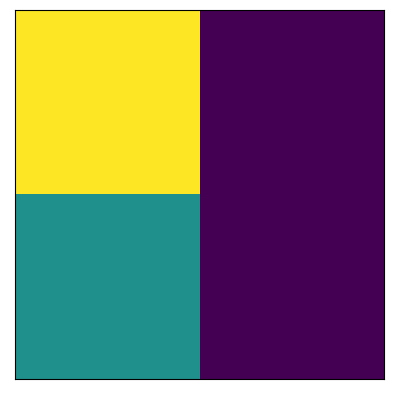

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


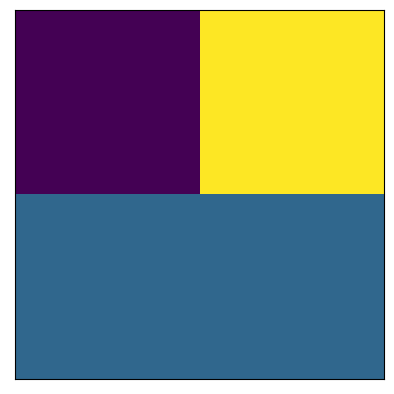

tf.Tensor(
[[0.6666666 1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


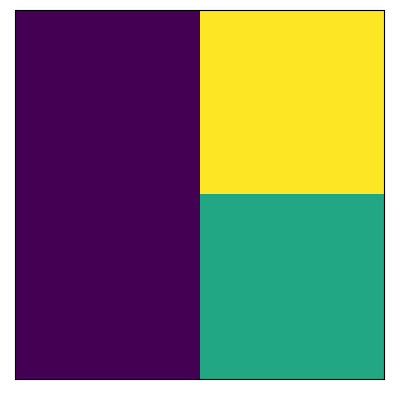

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


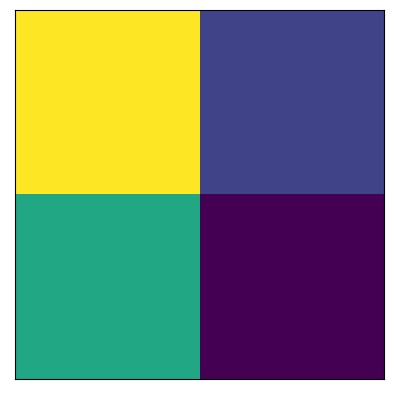

tf.Tensor(
[[1.6666665  0.33333334]
 [1.         0.        ]], shape=(2, 2), dtype=float32)


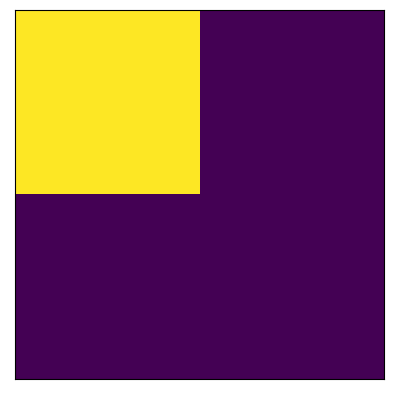

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


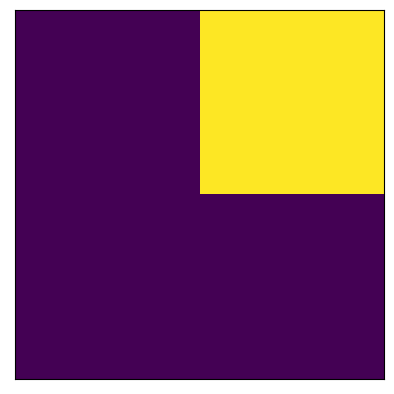

tf.Tensor(
[[0.         0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


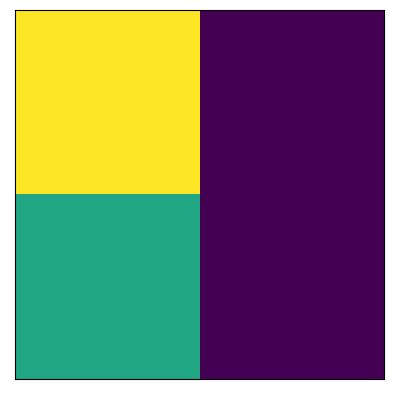

tf.Tensor(
[[1.6666666 0.       ]
 [1.        0.       ]], shape=(2, 2), dtype=float32)


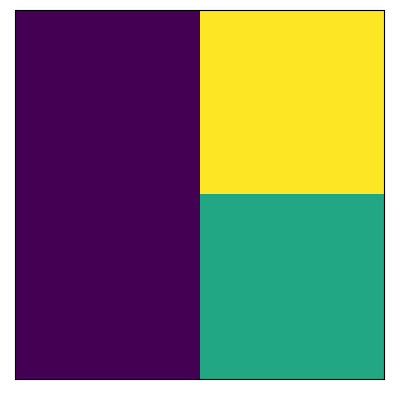

tf.Tensor(
[[0.        1.6666666]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


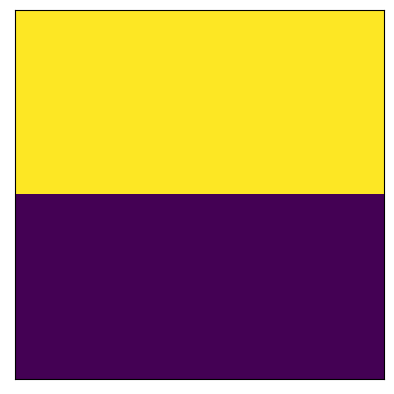

tf.Tensor(
[[4. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


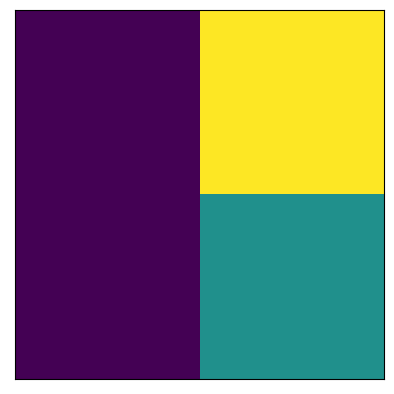

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


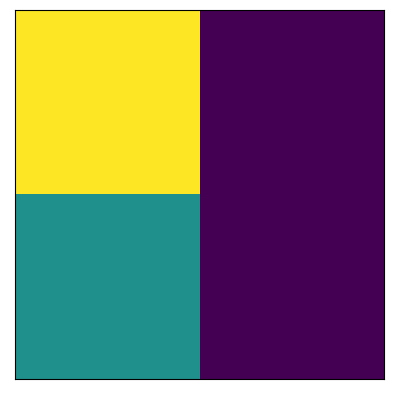

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


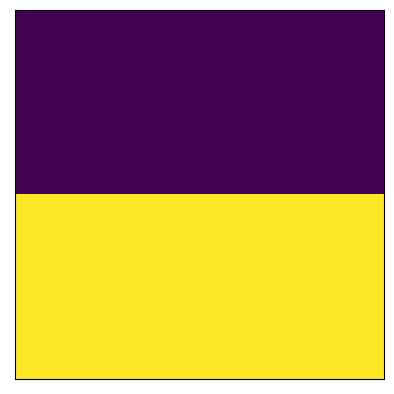

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


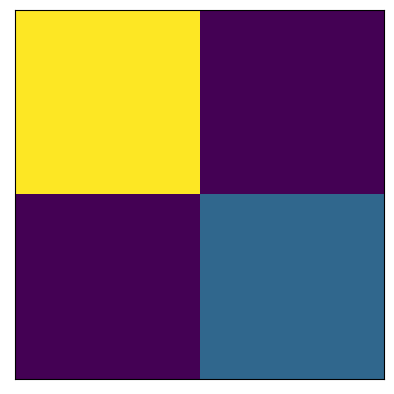

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


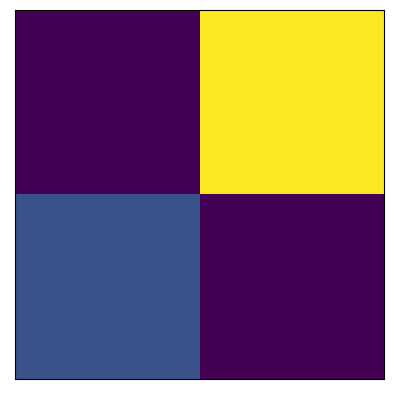

tf.Tensor(
[[0. 4.]
 [1. 0.]], shape=(2, 2), dtype=float32)


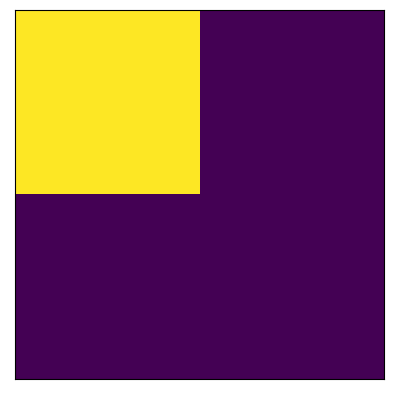

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


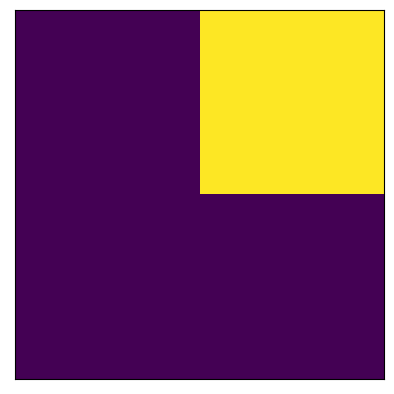

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


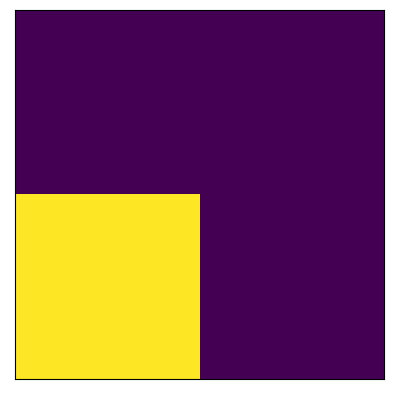

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


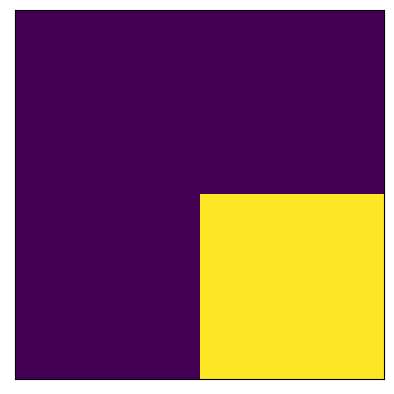

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


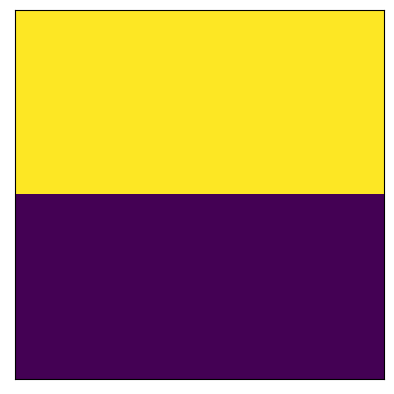

tf.Tensor(
[[0.25 0.25]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


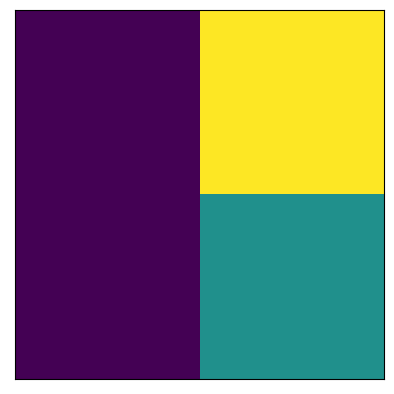

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


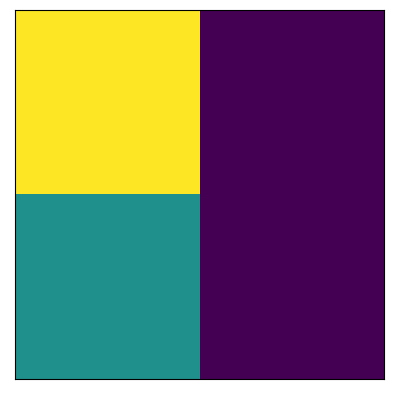

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


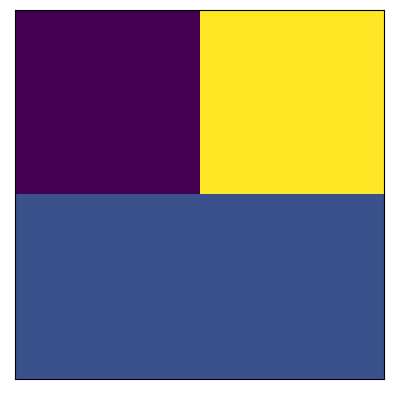

tf.Tensor(
[[0.75 1.75]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


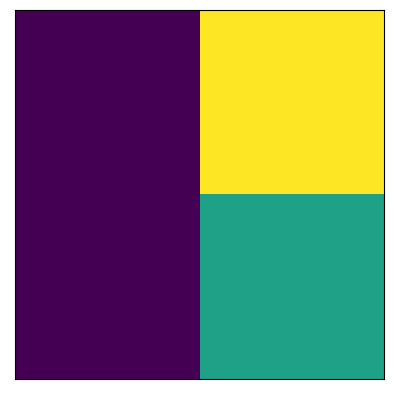

tf.Tensor(
[[0.   1.75]
 [0.   1.  ]], shape=(2, 2), dtype=float32)


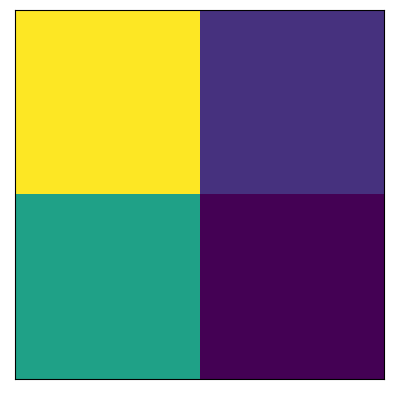

tf.Tensor(
[[1.75 0.25]
 [1.   0.  ]], shape=(2, 2), dtype=float32)


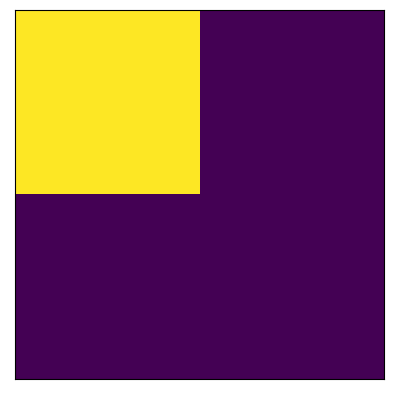

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


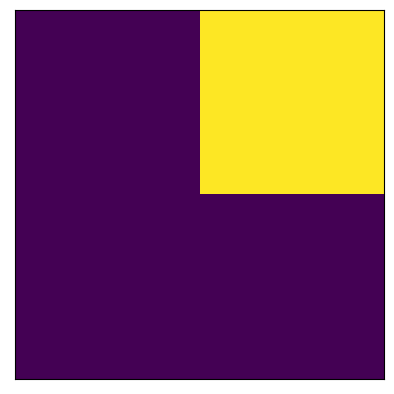

tf.Tensor(
[[0.   0.25]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


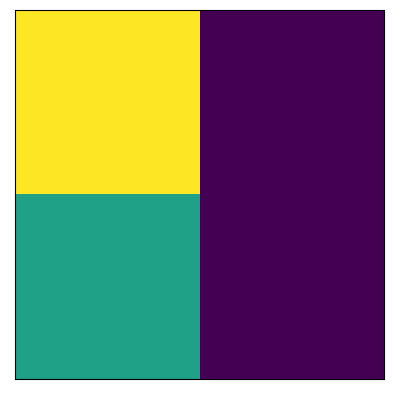

tf.Tensor(
[[1.75 0.  ]
 [1.   0.  ]], shape=(2, 2), dtype=float32)


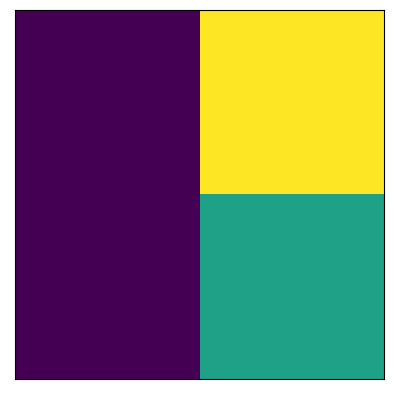

tf.Tensor(
[[0.   1.75]
 [0.   1.  ]], shape=(2, 2), dtype=float32)


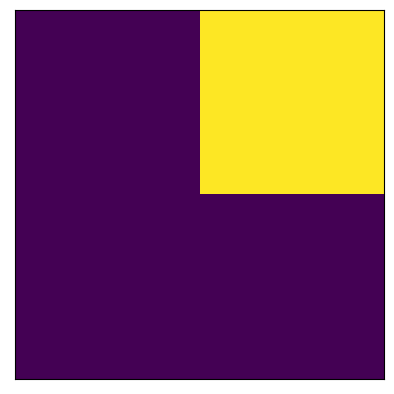

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


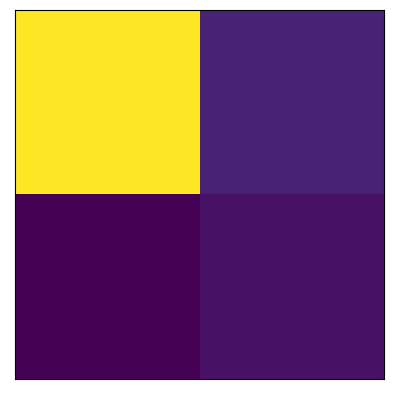

tf.Tensor(
[[20.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


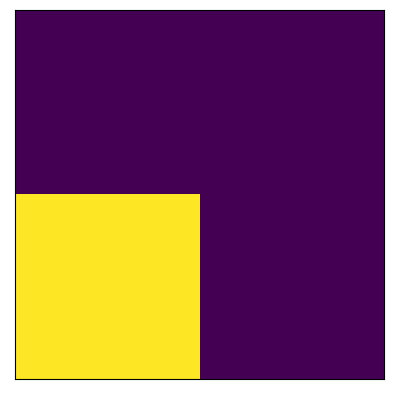

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


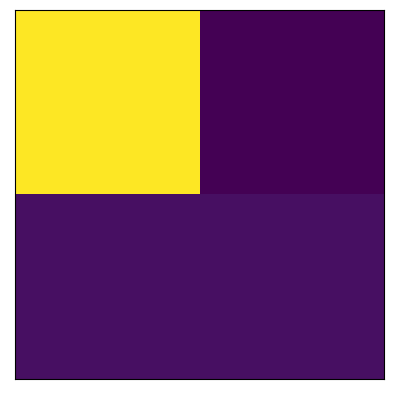

tf.Tensor(
[[24.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


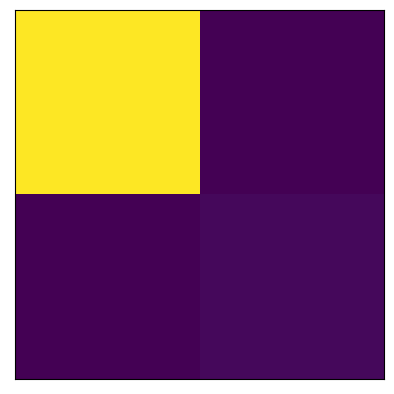

tf.Tensor(
[[45.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


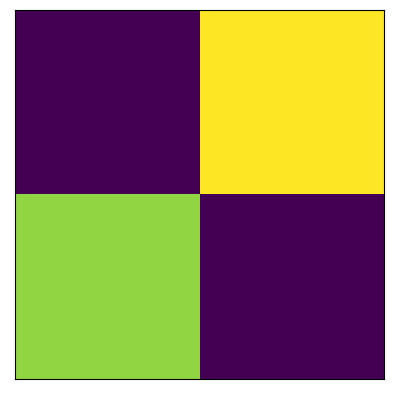

tf.Tensor(
[[0. 6.]
 [5. 0.]], shape=(2, 2), dtype=float32)


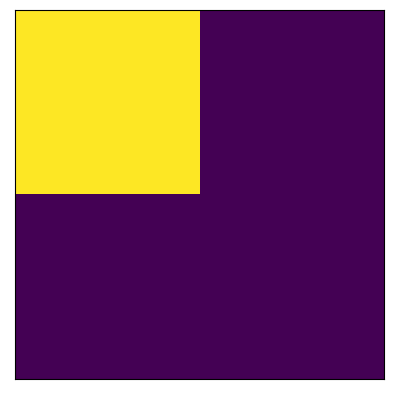

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


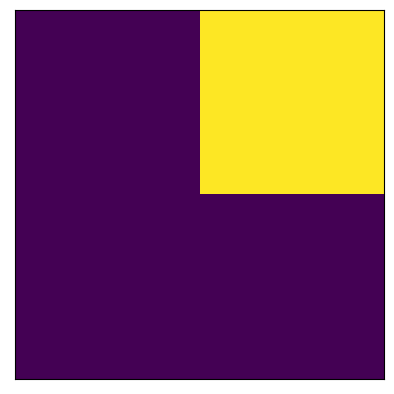

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


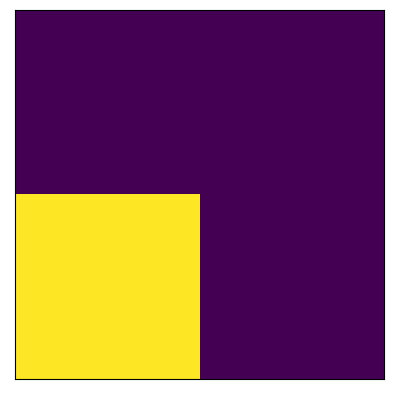

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


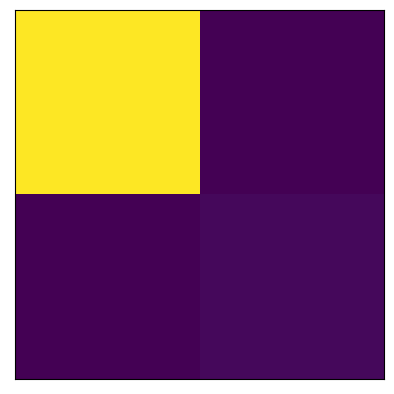

tf.Tensor(
[[44.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


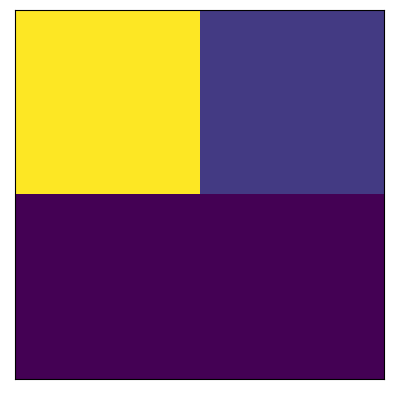

tf.Tensor(
[[0.97222227 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


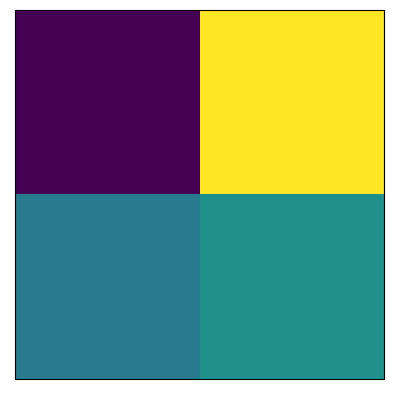

tf.Tensor(
[[0.        2.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


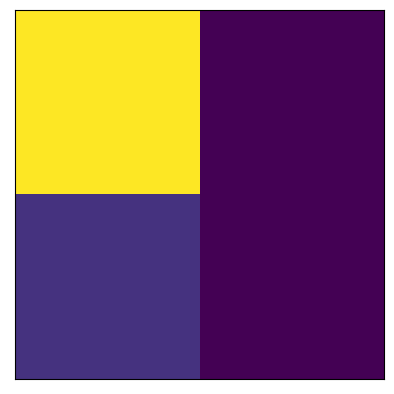

tf.Tensor(
[[1.138889   0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


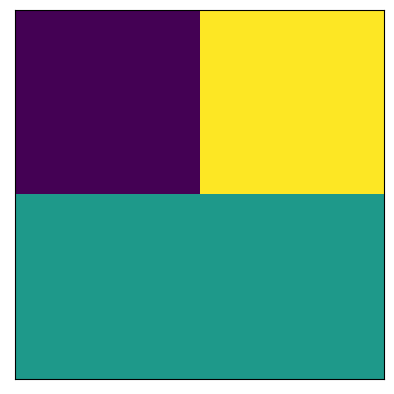

tf.Tensor(
[[0.02777773 1.8333334 ]
 [1.         1.        ]], shape=(2, 2), dtype=float32)


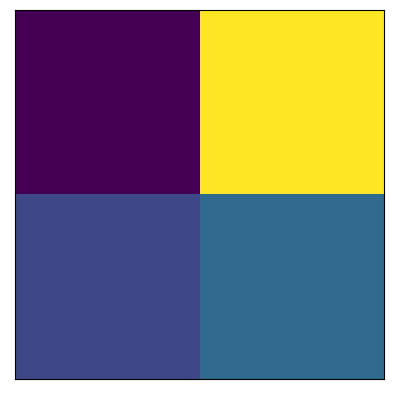

tf.Tensor(
[[0.5555555 1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


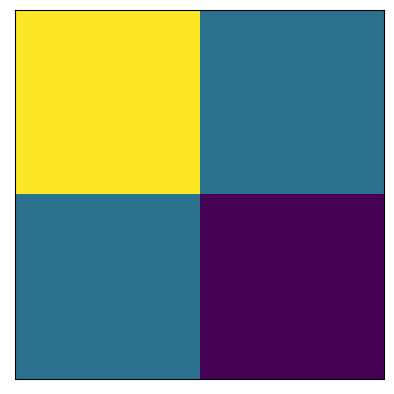

tf.Tensor(
[[0.44444445 0.16666667]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


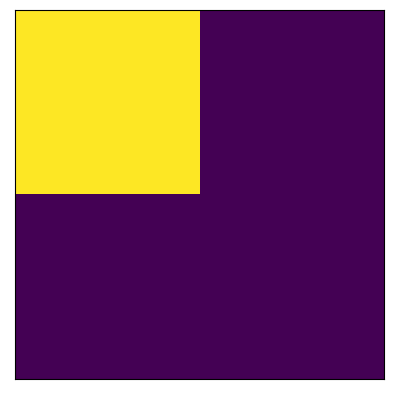

tf.Tensor(
[[0.8333333 0.       ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


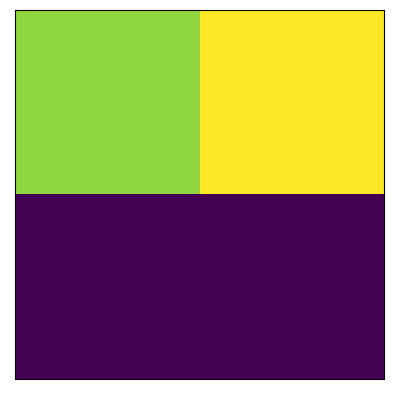

tf.Tensor(
[[0.1388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


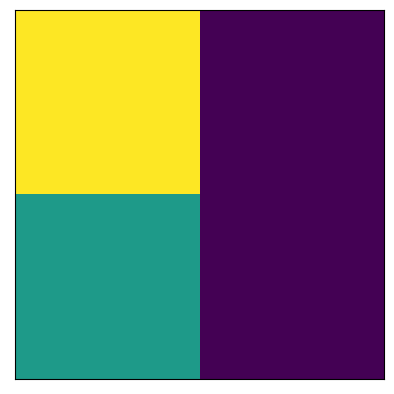

tf.Tensor(
[[0.30555555 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


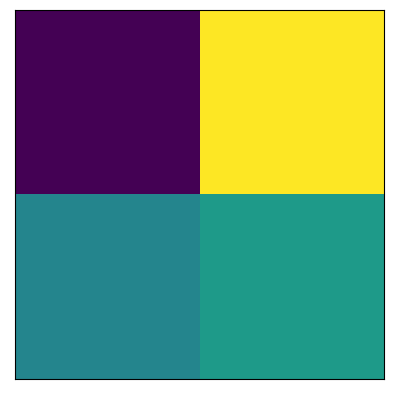

tf.Tensor(
[[0.        1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


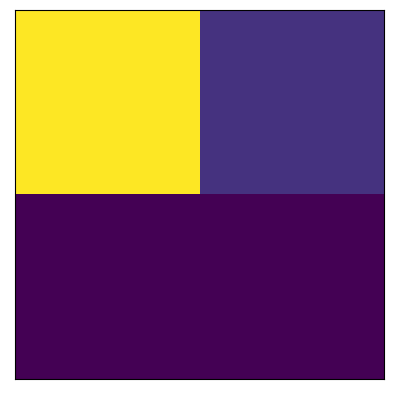

tf.Tensor(
[[1.3600001 0.2      ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


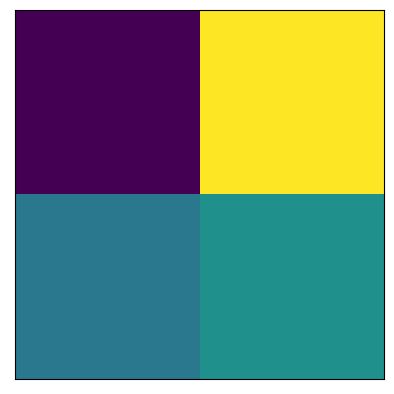

tf.Tensor(
[[0.  2. ]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


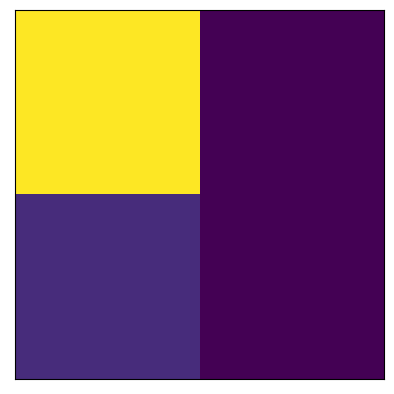

tf.Tensor(
[[1.5600001 0.       ]
 [0.2       0.       ]], shape=(2, 2), dtype=float32)


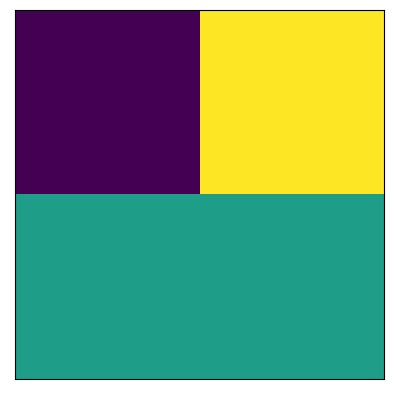

tf.Tensor(
[[0.  1.8]
 [1.  1. ]], shape=(2, 2), dtype=float32)


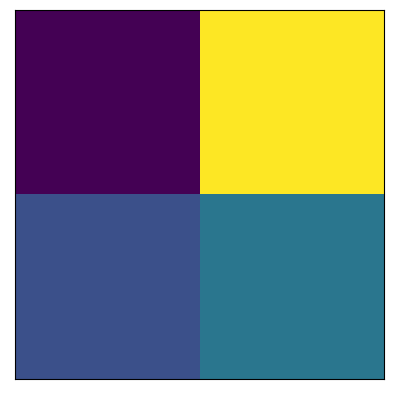

tf.Tensor(
[[0.48000002 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


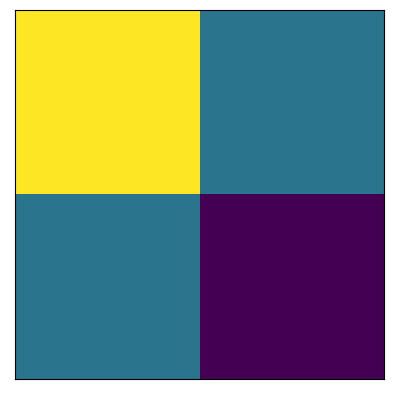

tf.Tensor(
[[0.52000004 0.2       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


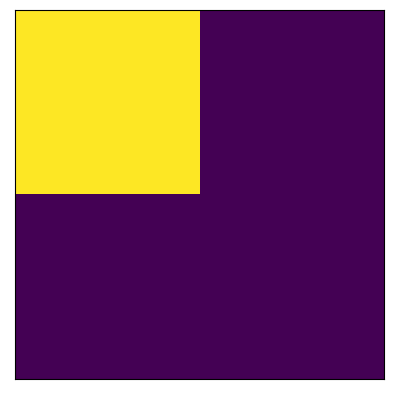

tf.Tensor(
[[1.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


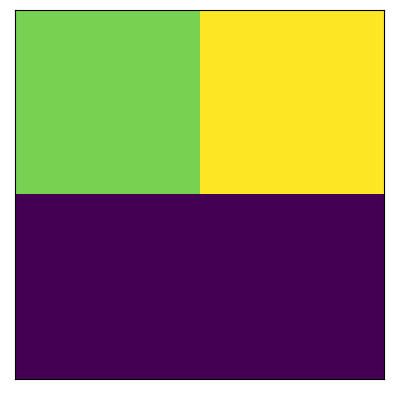

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


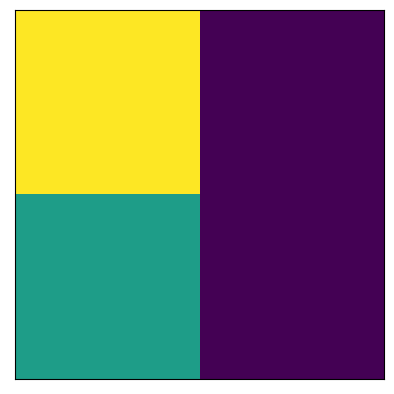

tf.Tensor(
[[0.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


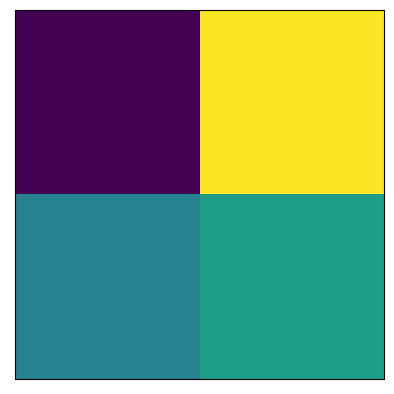

tf.Tensor(
[[0.  1.8]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


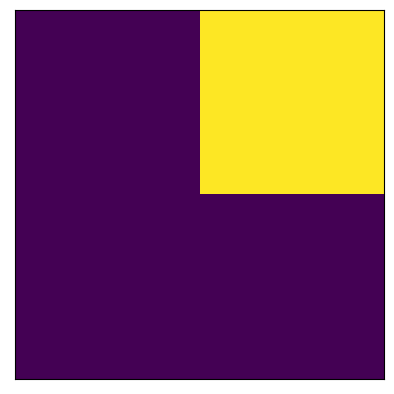

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


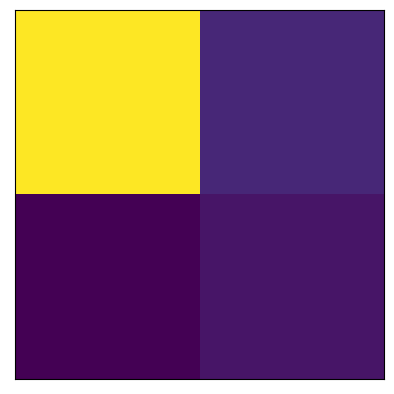

tf.Tensor(
[[18.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


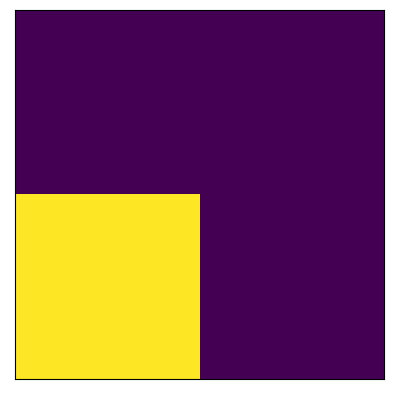

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


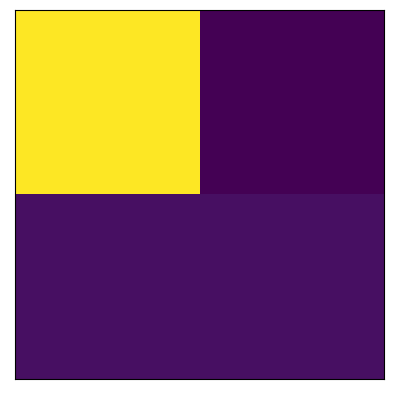

tf.Tensor(
[[25.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


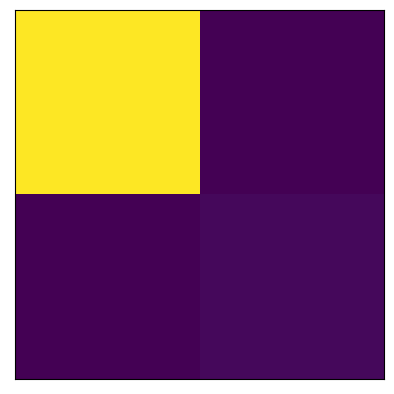

tf.Tensor(
[[44.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


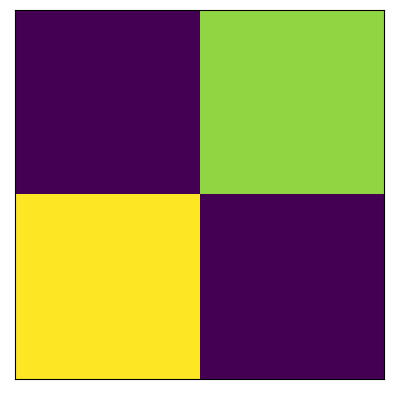

tf.Tensor(
[[0. 5.]
 [6. 0.]], shape=(2, 2), dtype=float32)


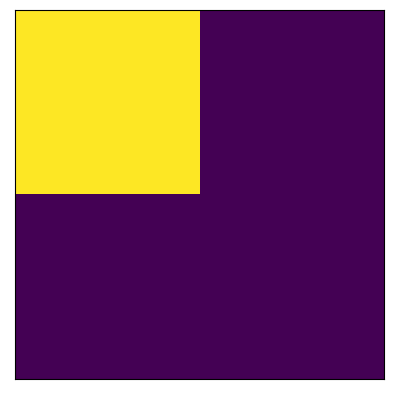

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


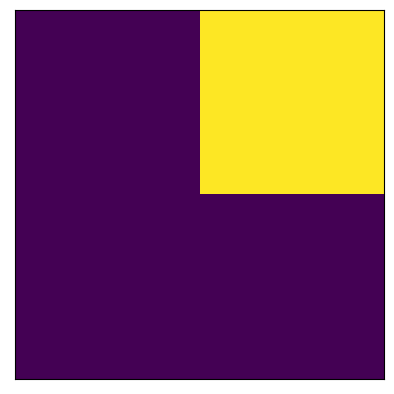

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


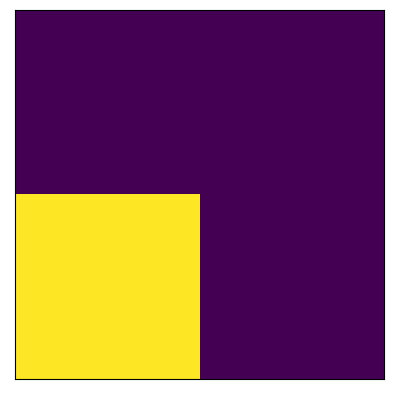

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


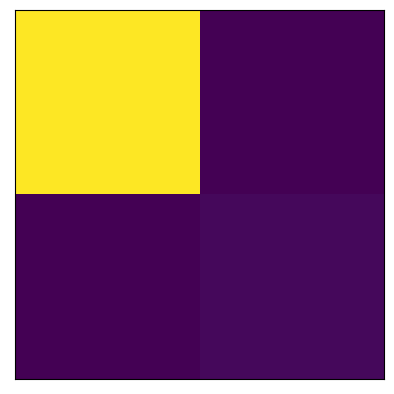

tf.Tensor(
[[43.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


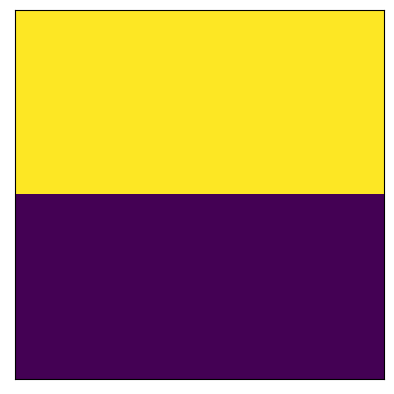

tf.Tensor(
[[5. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


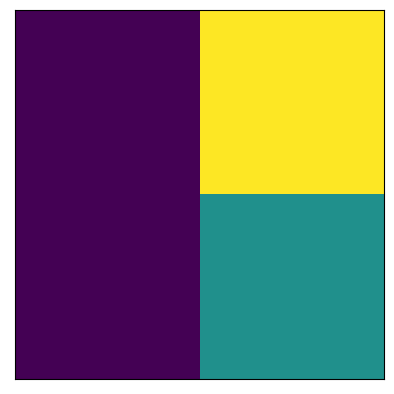

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


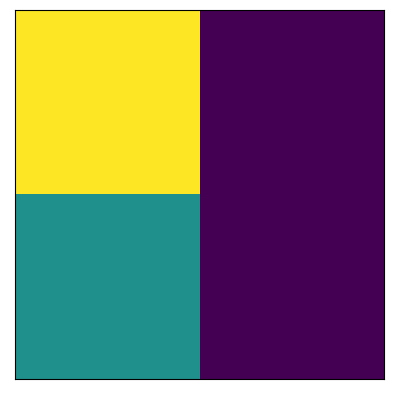

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


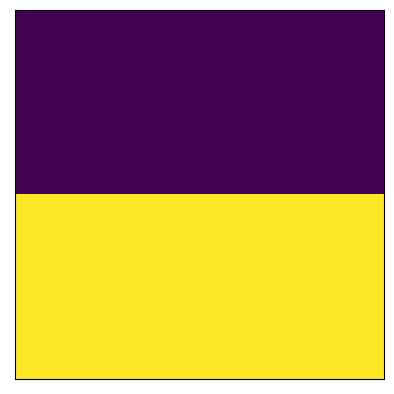

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


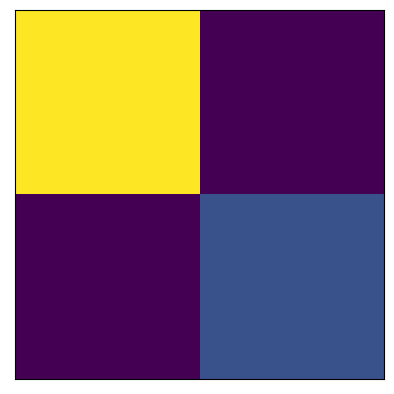

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


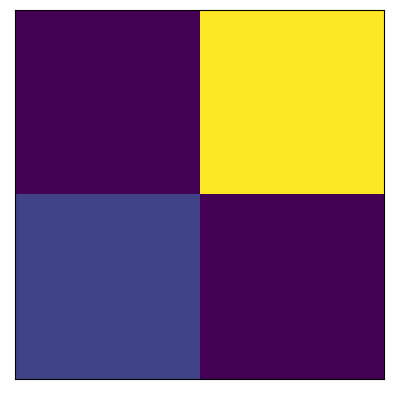

tf.Tensor(
[[0. 5.]
 [1. 0.]], shape=(2, 2), dtype=float32)


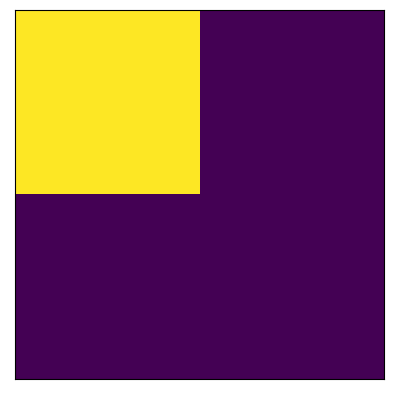

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


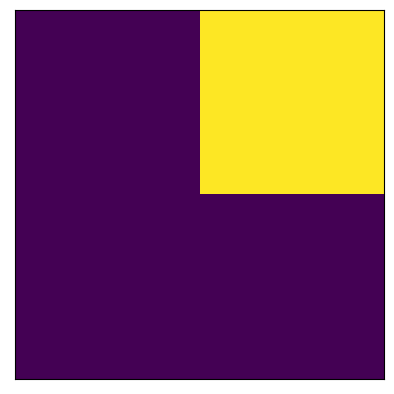

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


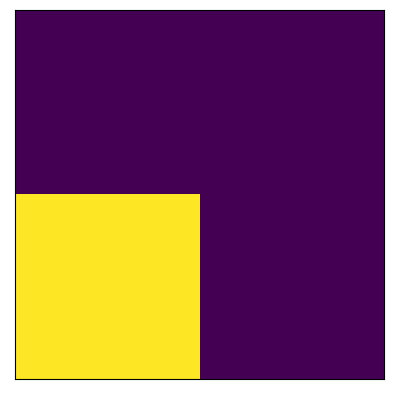

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


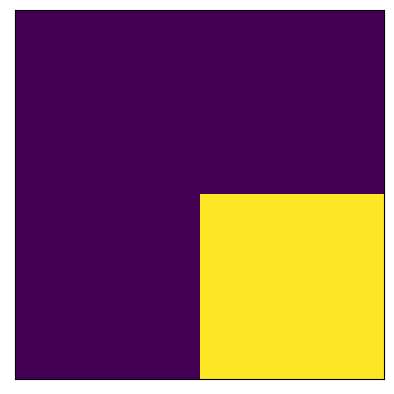

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


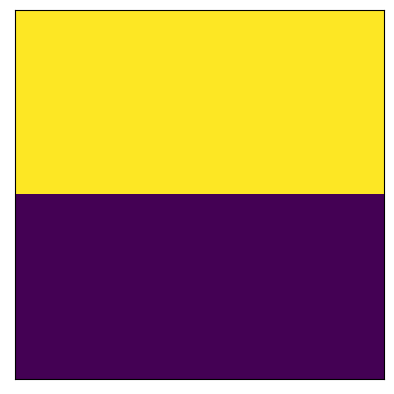

tf.Tensor(
[[0.2 0.2]
 [0.  0. ]], shape=(2, 2), dtype=float32)


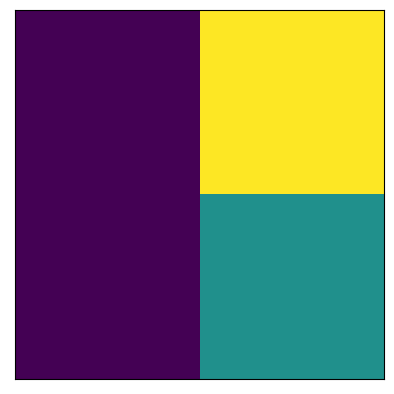

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


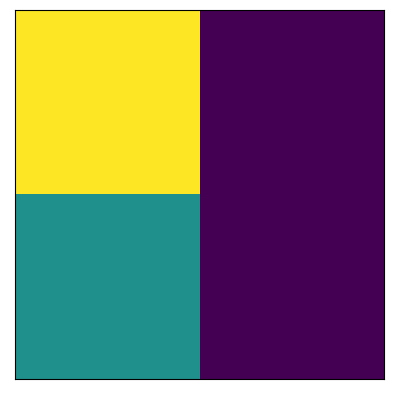

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


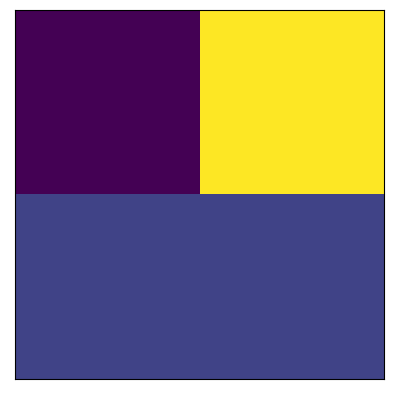

tf.Tensor(
[[0.8 1.8]
 [1.  1. ]], shape=(2, 2), dtype=float32)


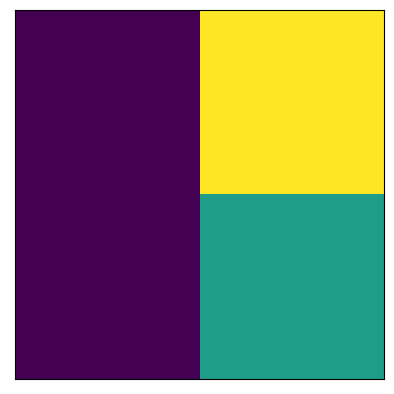

tf.Tensor(
[[0.  1.8]
 [0.  1. ]], shape=(2, 2), dtype=float32)


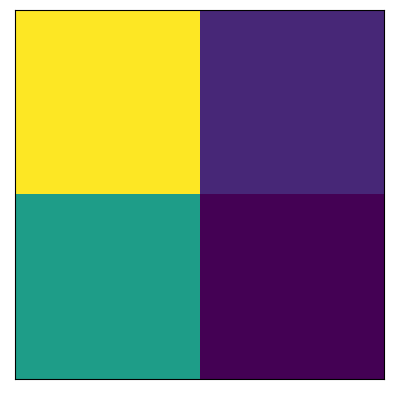

tf.Tensor(
[[1.8000001 0.2      ]
 [1.        0.       ]], shape=(2, 2), dtype=float32)


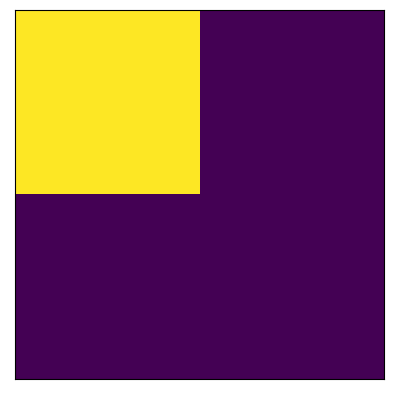

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


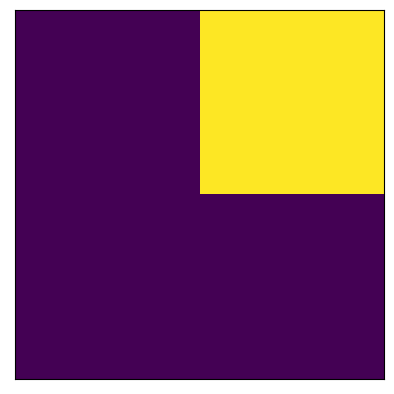

tf.Tensor(
[[0.  0.2]
 [0.  0. ]], shape=(2, 2), dtype=float32)


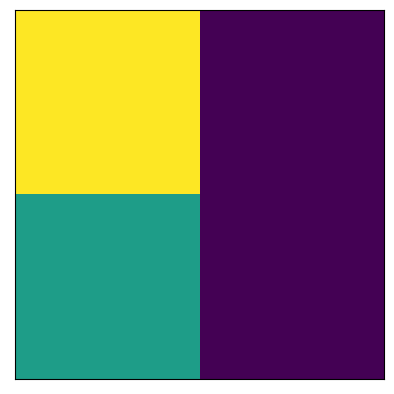

tf.Tensor(
[[1.8 0. ]
 [1.  0. ]], shape=(2, 2), dtype=float32)


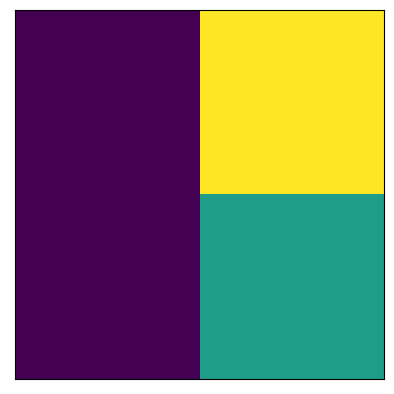

tf.Tensor(
[[0.  1.8]
 [0.  1. ]], shape=(2, 2), dtype=float32)


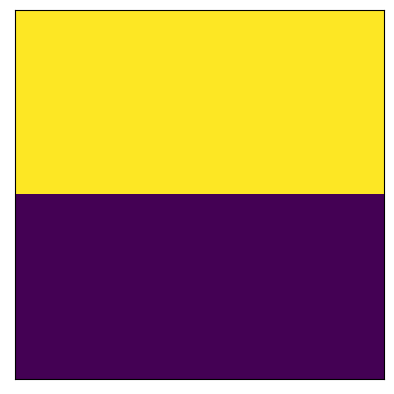

tf.Tensor(
[[6. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


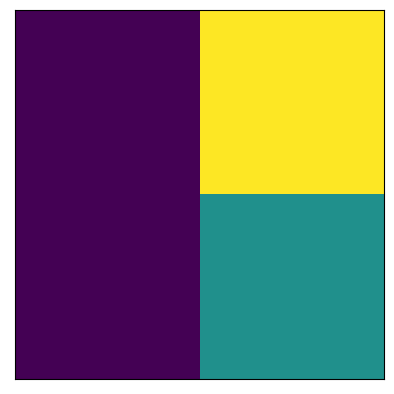

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


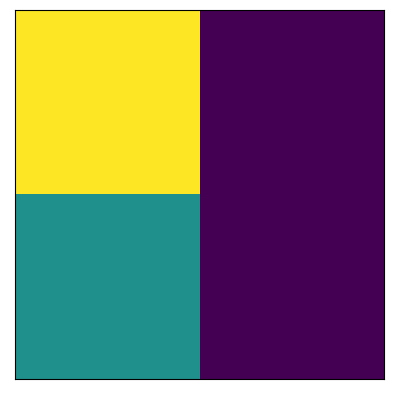

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


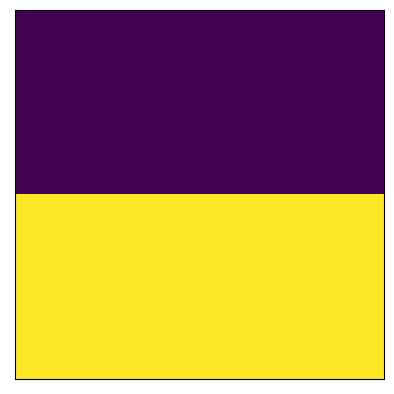

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


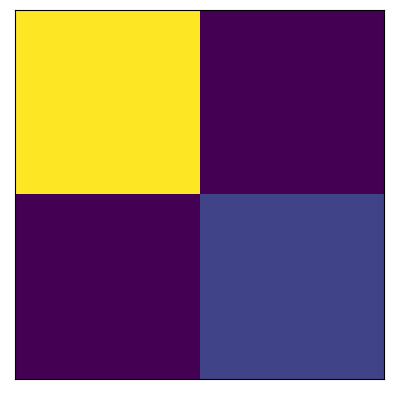

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


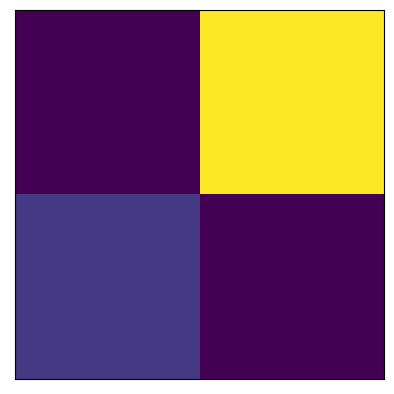

tf.Tensor(
[[0. 6.]
 [1. 0.]], shape=(2, 2), dtype=float32)


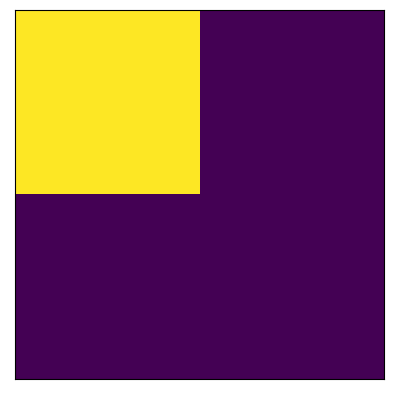

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


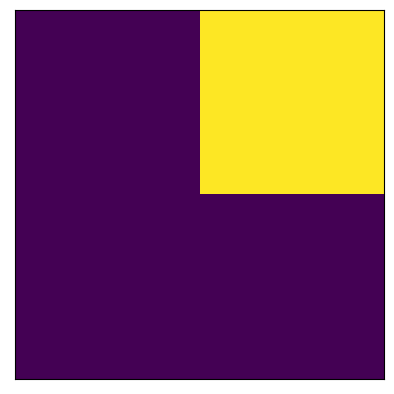

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


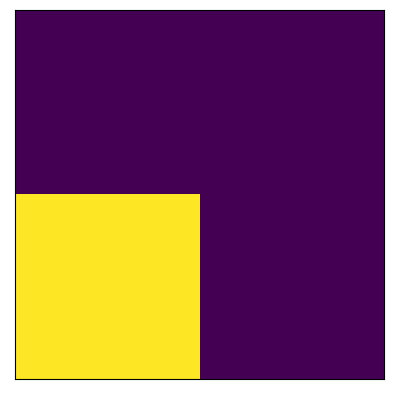

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


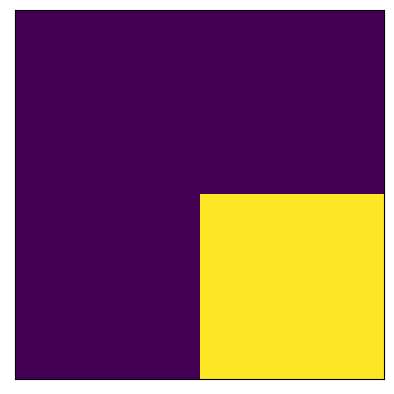

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


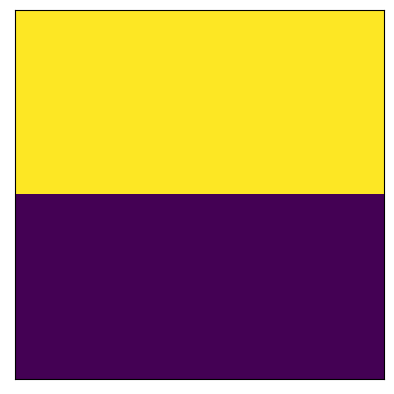

tf.Tensor(
[[0.16666667 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


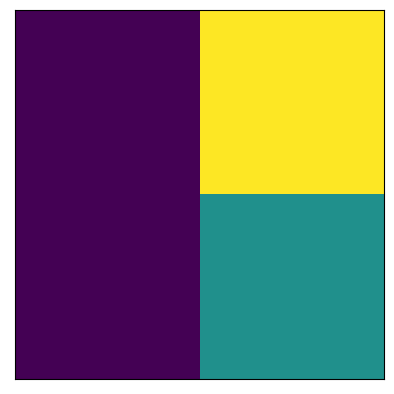

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


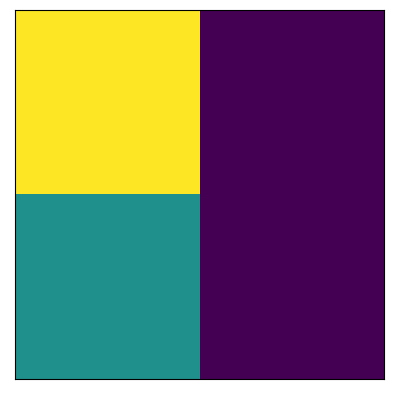

tf.Tensor(
[[2. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


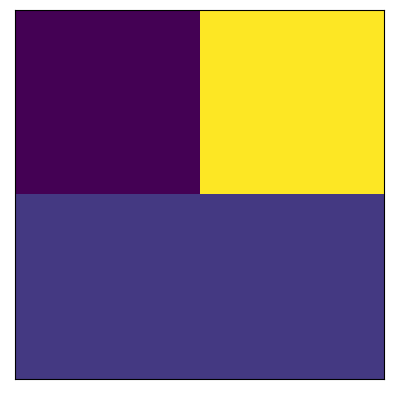

tf.Tensor(
[[0.8333333 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


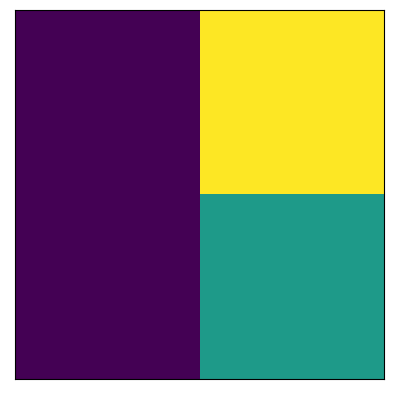

tf.Tensor(
[[0.        1.8333334]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


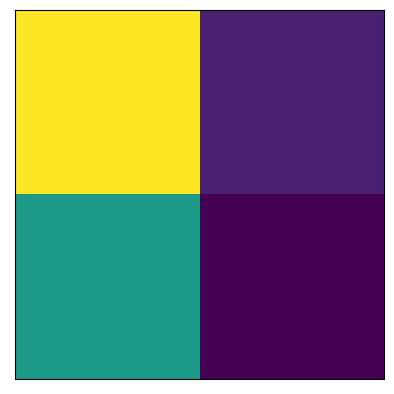

tf.Tensor(
[[1.8333334  0.16666667]
 [1.         0.        ]], shape=(2, 2), dtype=float32)


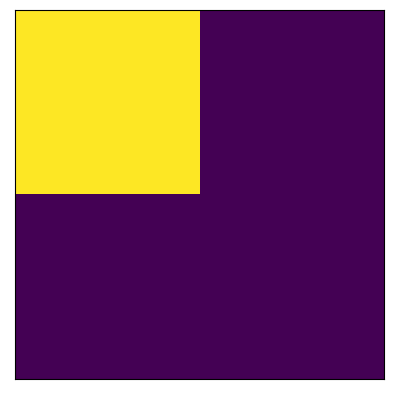

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


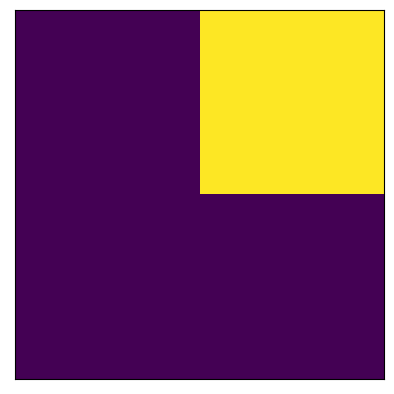

tf.Tensor(
[[0.         0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


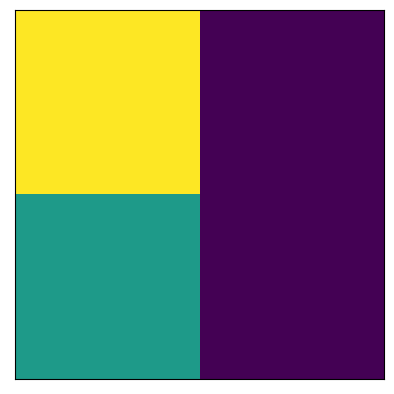

tf.Tensor(
[[1.8333334 0.       ]
 [1.        0.       ]], shape=(2, 2), dtype=float32)


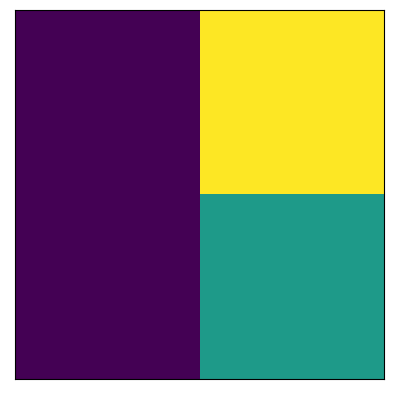

tf.Tensor(
[[0.        1.8333334]
 [0.        1.       ]], shape=(2, 2), dtype=float32)


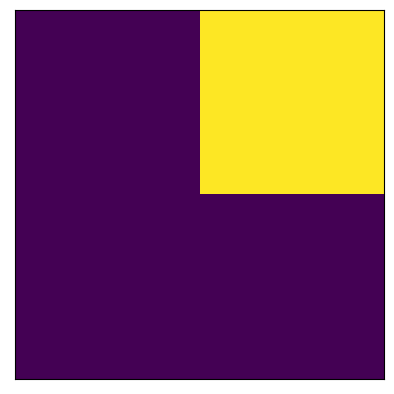

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


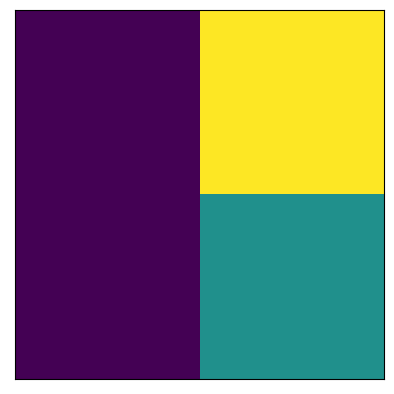

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


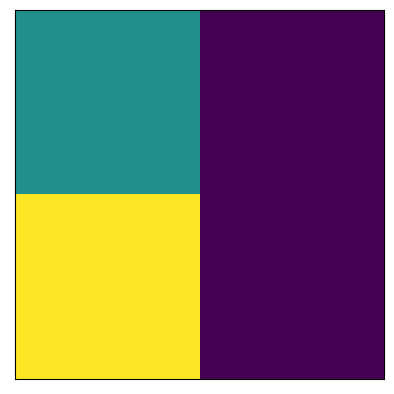

tf.Tensor(
[[1. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


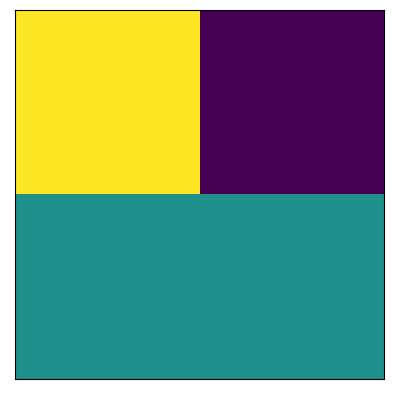

tf.Tensor(
[[2. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


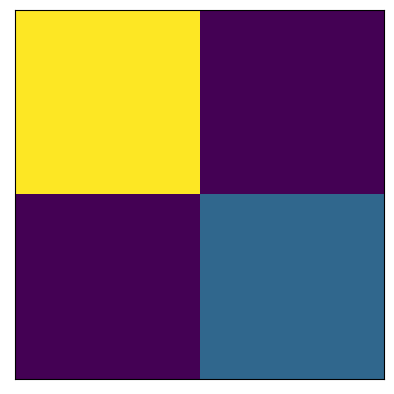

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


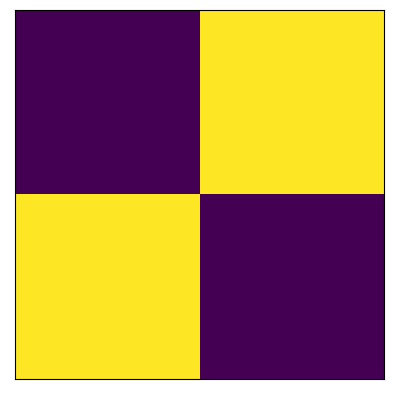

tf.Tensor(
[[0. 2.]
 [2. 0.]], shape=(2, 2), dtype=float32)


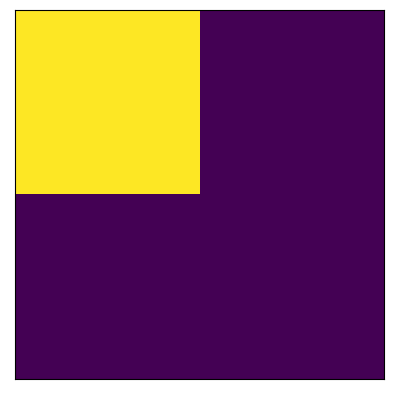

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


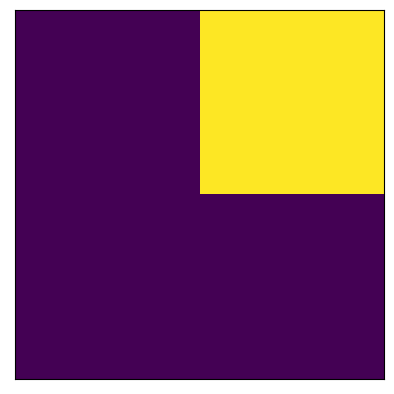

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


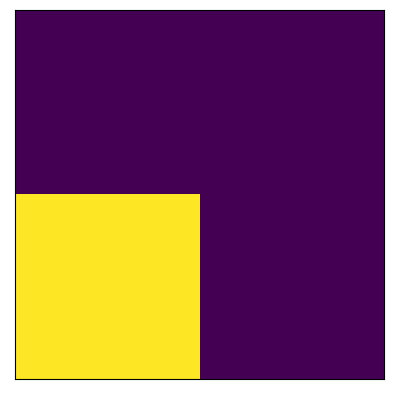

tf.Tensor(
[[0. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


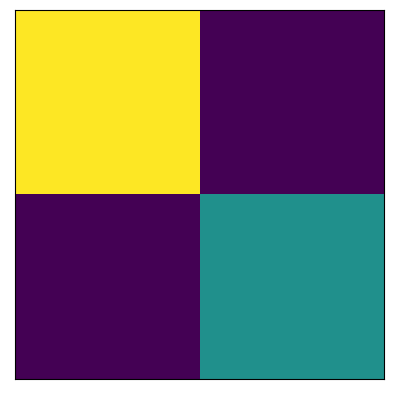

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


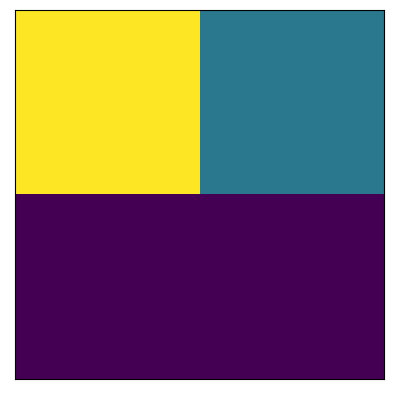

tf.Tensor(
[[1.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


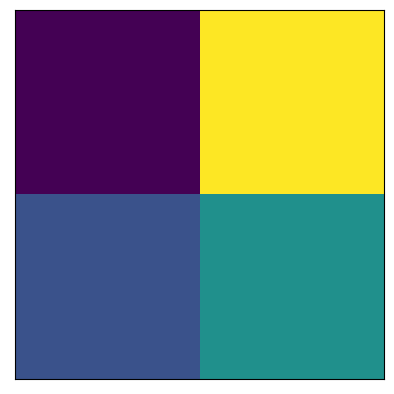

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


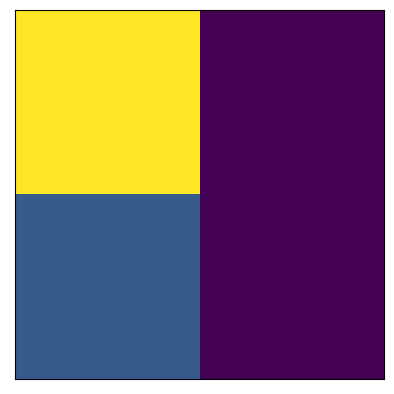

tf.Tensor(
[[1.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


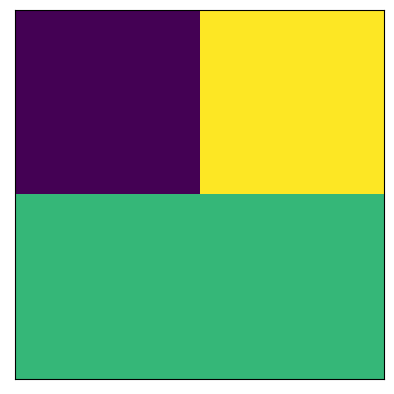

tf.Tensor(
[[0.  1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


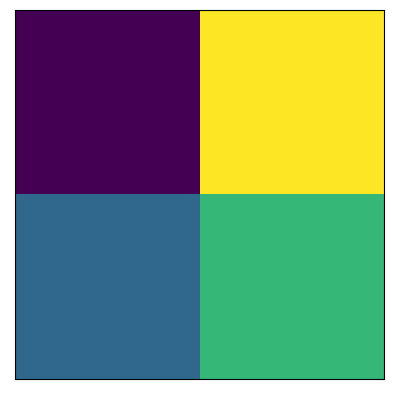

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


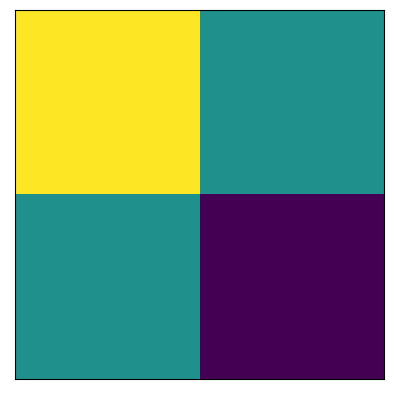

tf.Tensor(
[[1.  0.5]
 [0.5 0. ]], shape=(2, 2), dtype=float32)


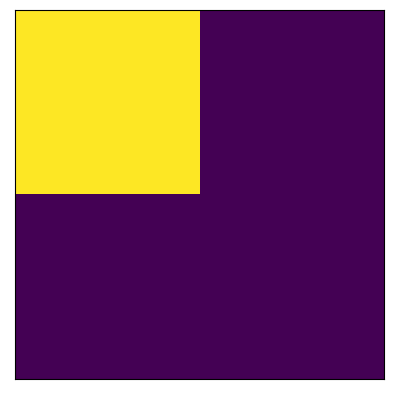

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


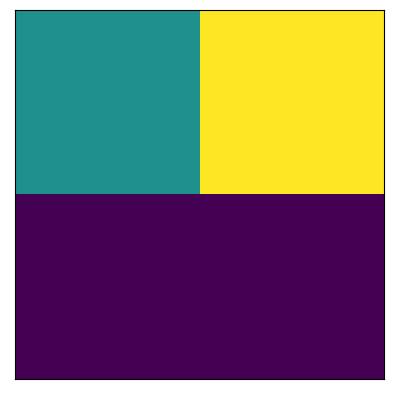

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


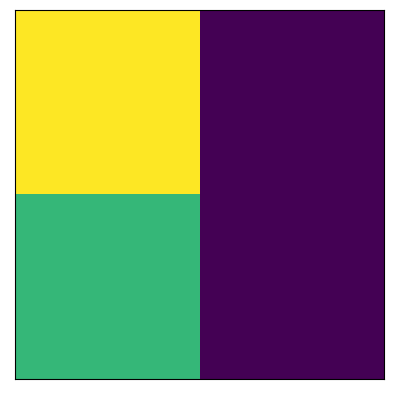

tf.Tensor(
[[0.75 0.  ]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


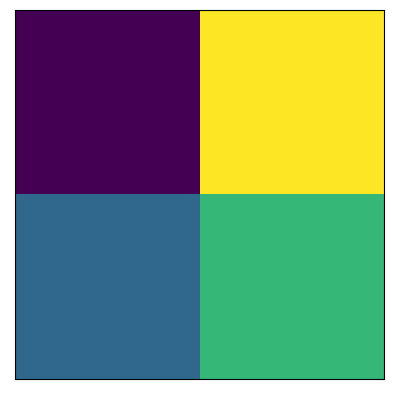

tf.Tensor(
[[0.  1.5]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


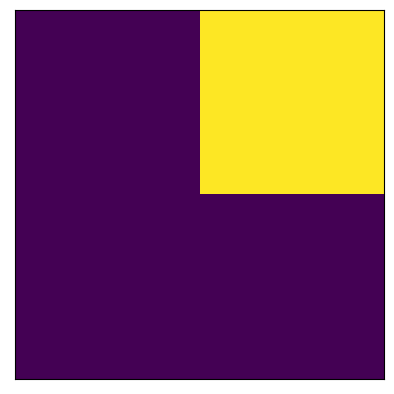

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


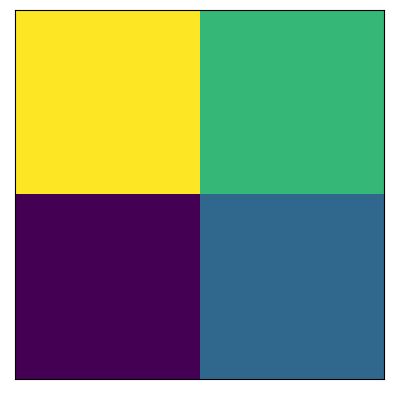

tf.Tensor(
[[3. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


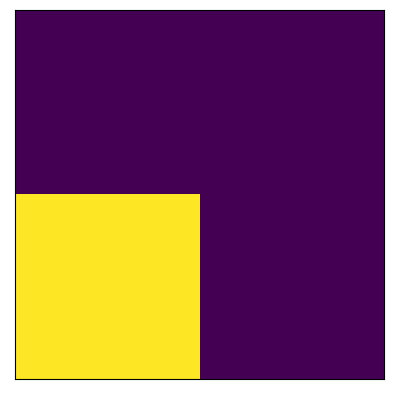

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


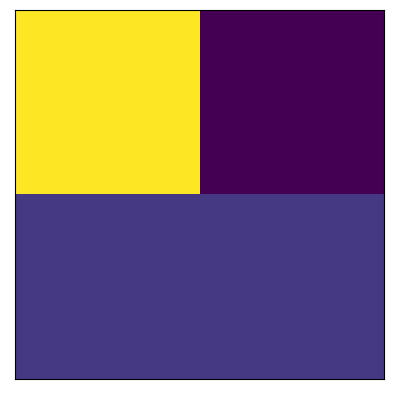

tf.Tensor(
[[6. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


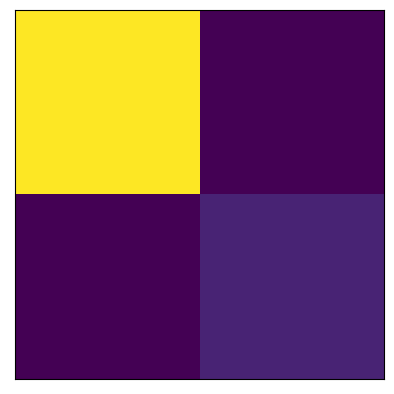

tf.Tensor(
[[10.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


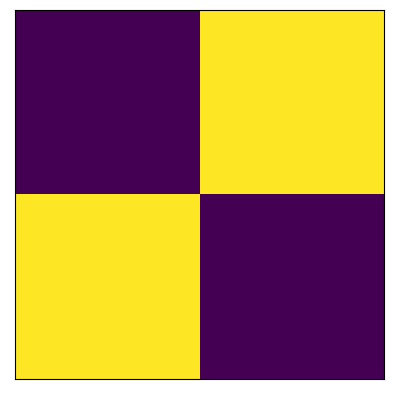

tf.Tensor(
[[0. 3.]
 [3. 0.]], shape=(2, 2), dtype=float32)


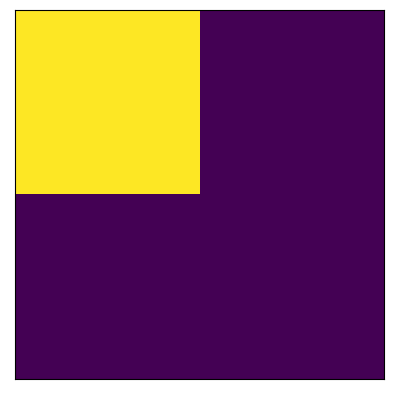

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


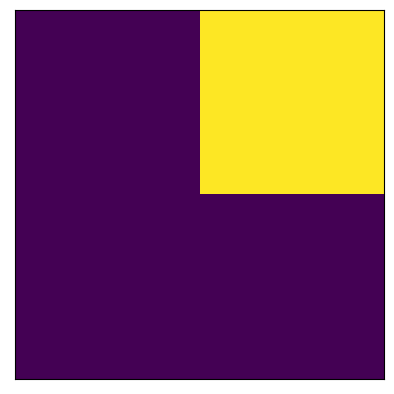

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


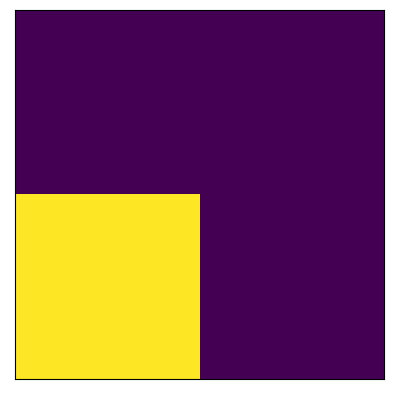

tf.Tensor(
[[0. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


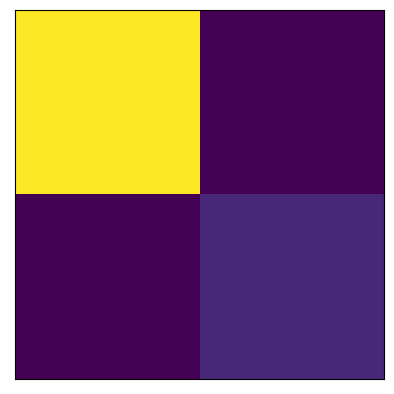

tf.Tensor(
[[9. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


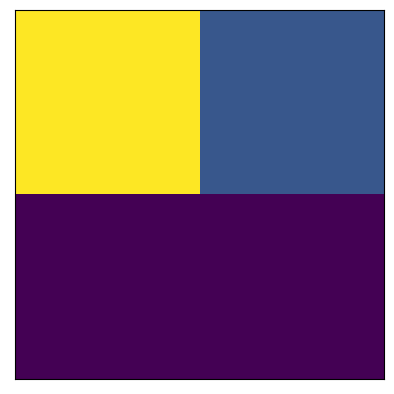

tf.Tensor(
[[1.2222222  0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


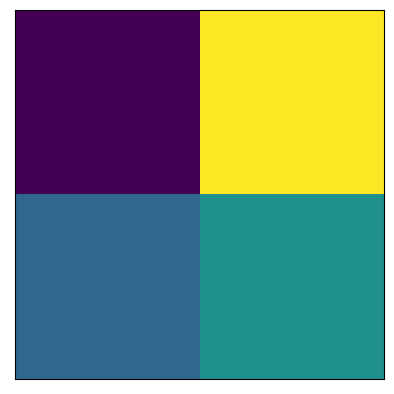

tf.Tensor(
[[0.        2.       ]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


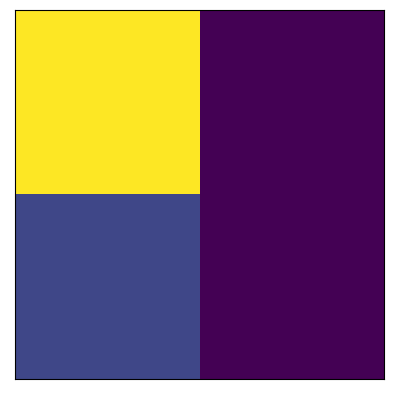

tf.Tensor(
[[1.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


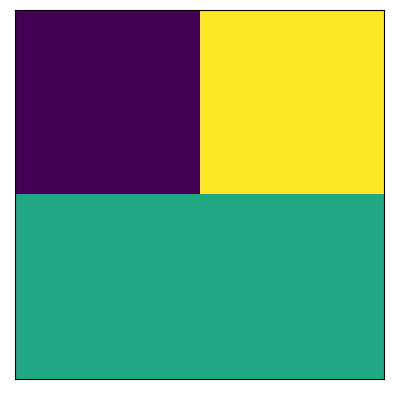

tf.Tensor(
[[0.        1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


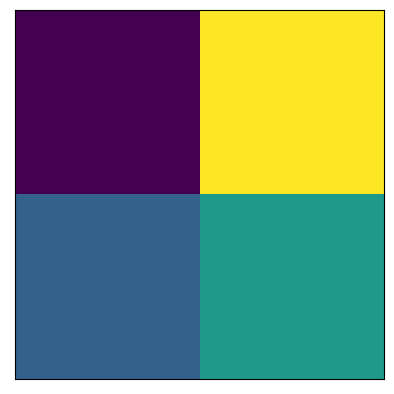

tf.Tensor(
[[0.2222222 1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


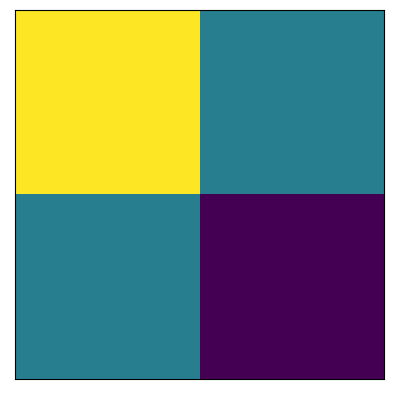

tf.Tensor(
[[0.7777778  0.33333334]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


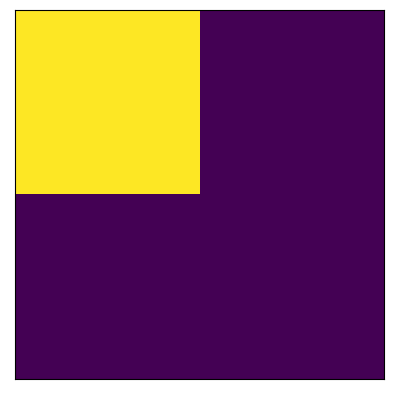

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


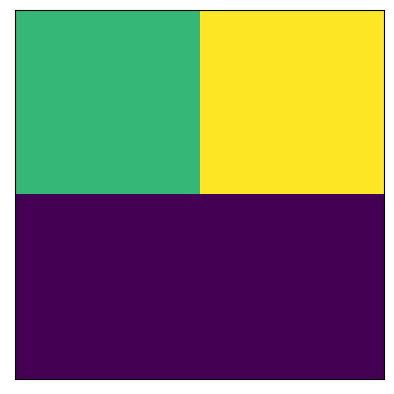

tf.Tensor(
[[0.22222224 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


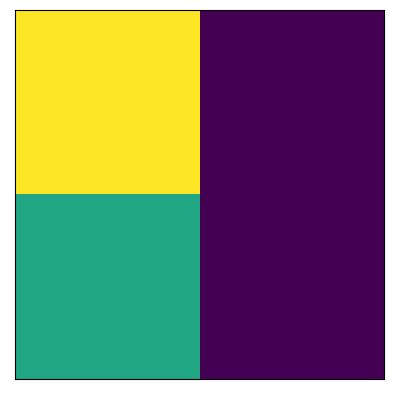

tf.Tensor(
[[0.5555556  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


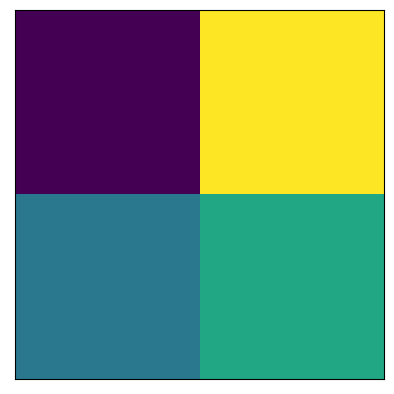

tf.Tensor(
[[0.        1.6666666]
 [0.6666666 1.       ]], shape=(2, 2), dtype=float32)


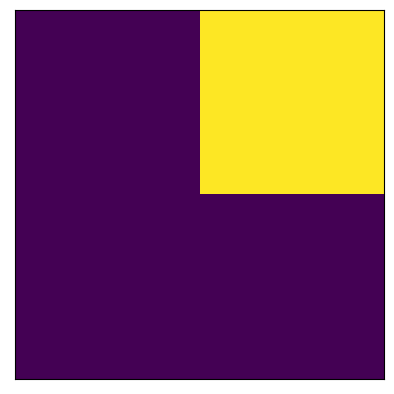

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


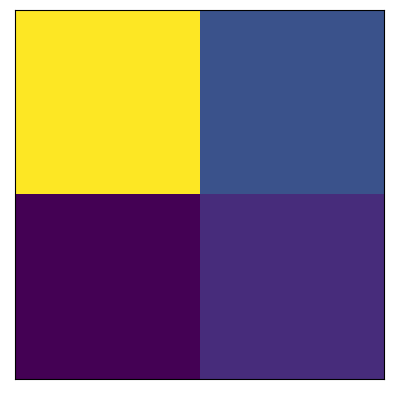

tf.Tensor(
[[8. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


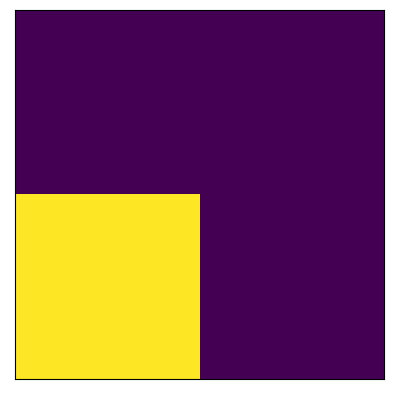

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


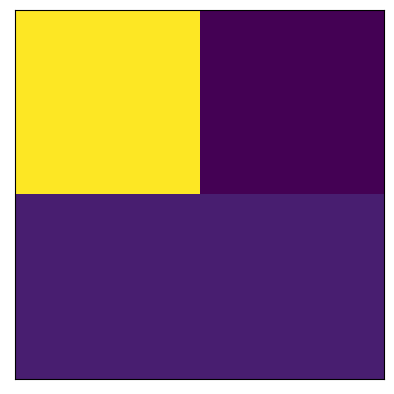

tf.Tensor(
[[12.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


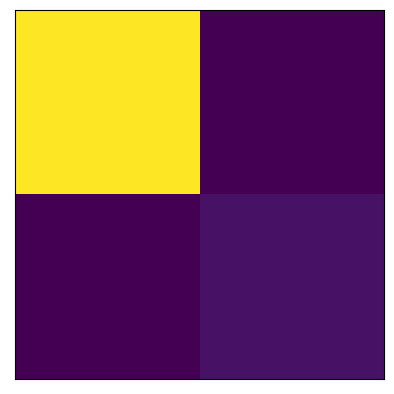

tf.Tensor(
[[21.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


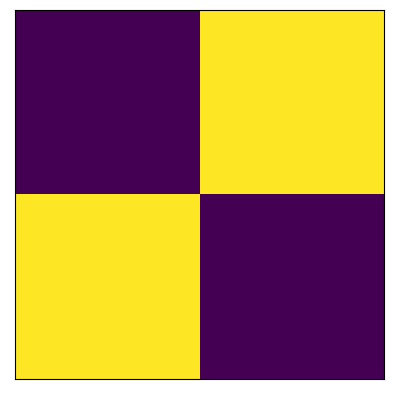

tf.Tensor(
[[0. 4.]
 [4. 0.]], shape=(2, 2), dtype=float32)


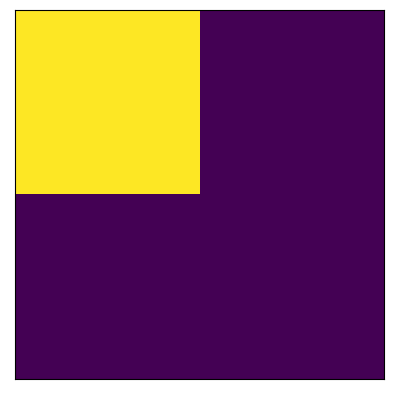

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


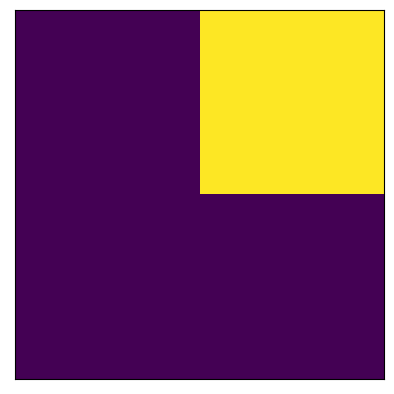

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


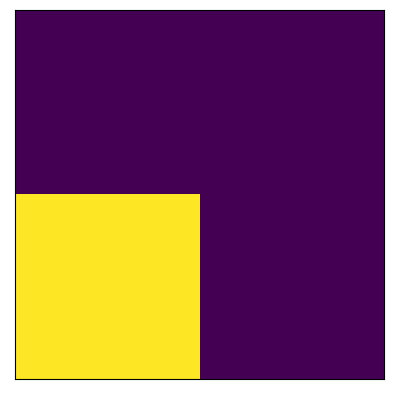

tf.Tensor(
[[0. 0.]
 [4. 0.]], shape=(2, 2), dtype=float32)


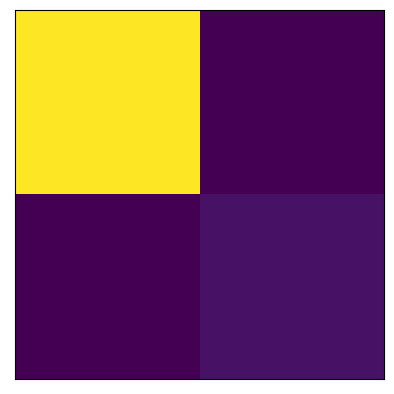

tf.Tensor(
[[20.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


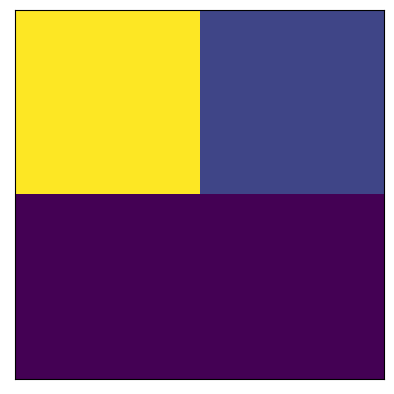

tf.Tensor(
[[1.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


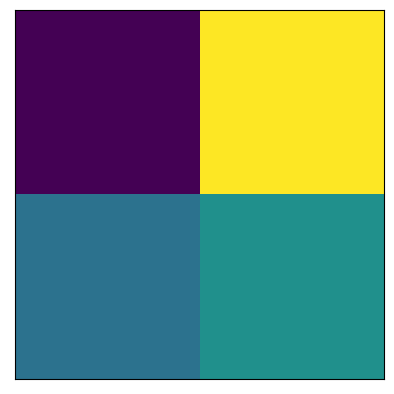

tf.Tensor(
[[0.   2.  ]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


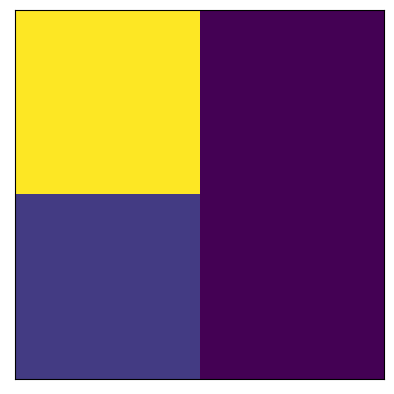

tf.Tensor(
[[1.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


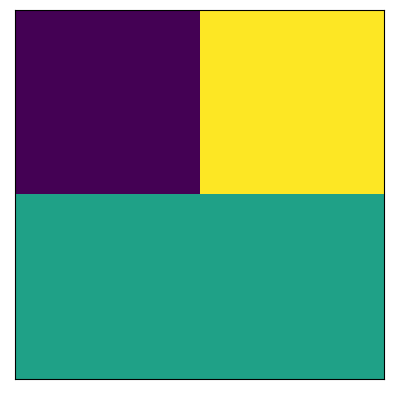

tf.Tensor(
[[0.   1.75]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


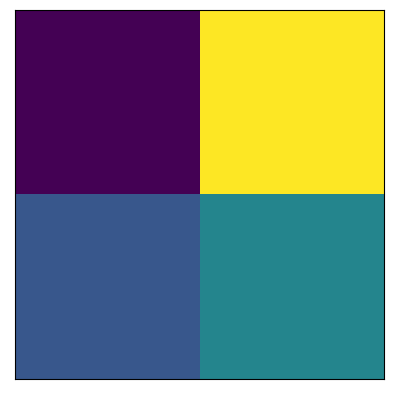

tf.Tensor(
[[0.375 1.75 ]
 [0.75  1.   ]], shape=(2, 2), dtype=float32)


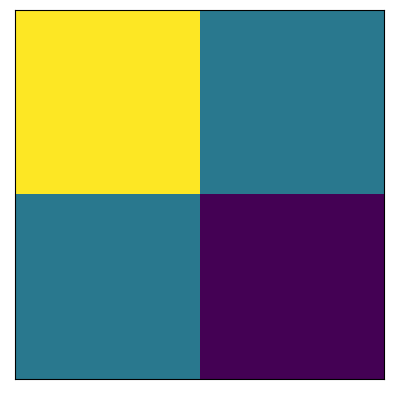

tf.Tensor(
[[0.625 0.25 ]
 [0.25  0.   ]], shape=(2, 2), dtype=float32)


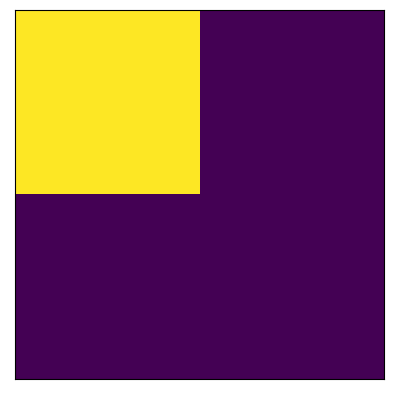

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


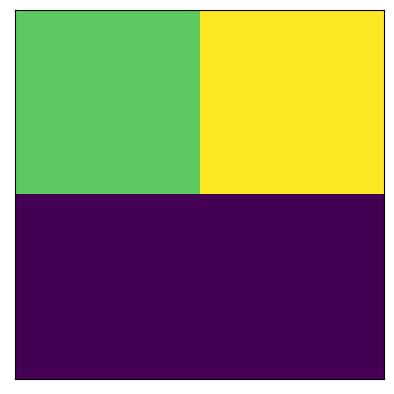

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


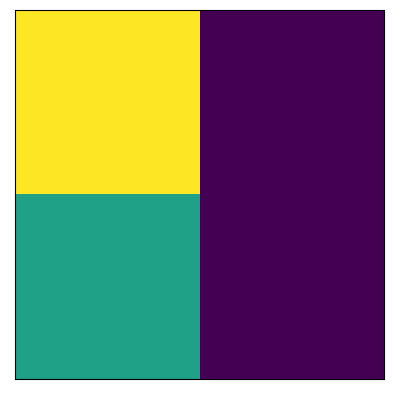

tf.Tensor(
[[0.4375 0.    ]
 [0.25   0.    ]], shape=(2, 2), dtype=float32)


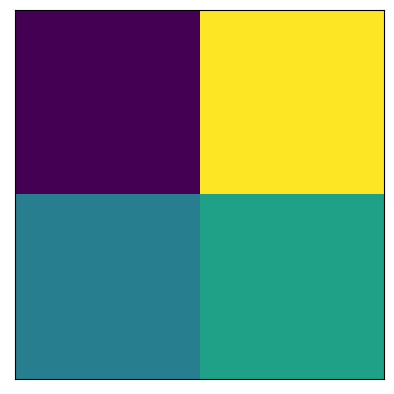

tf.Tensor(
[[0.   1.75]
 [0.75 1.  ]], shape=(2, 2), dtype=float32)


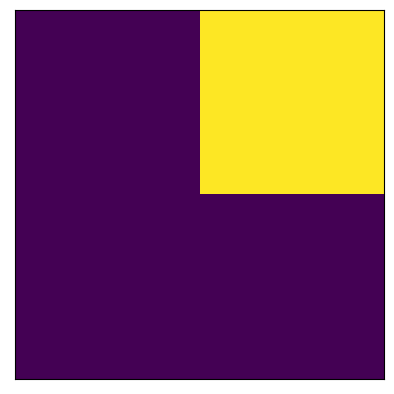

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


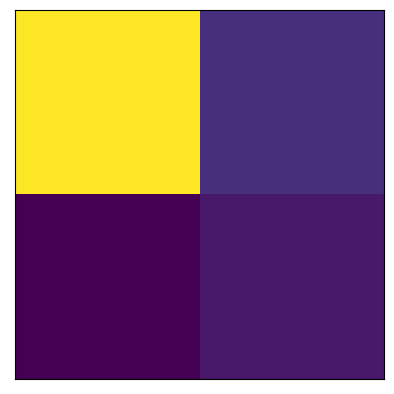

tf.Tensor(
[[15.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


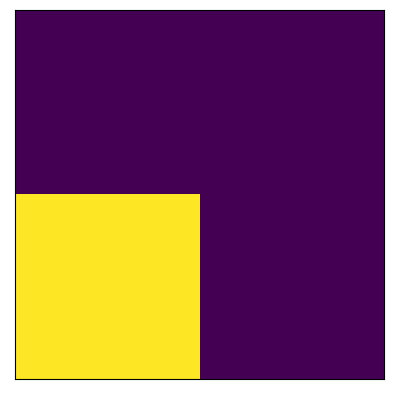

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


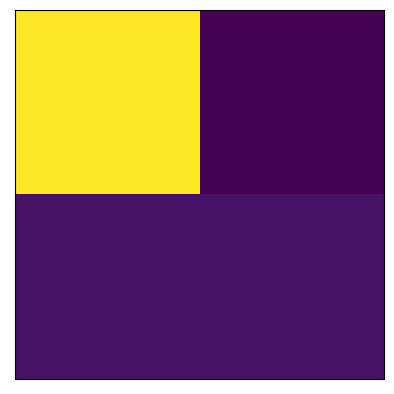

tf.Tensor(
[[20.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


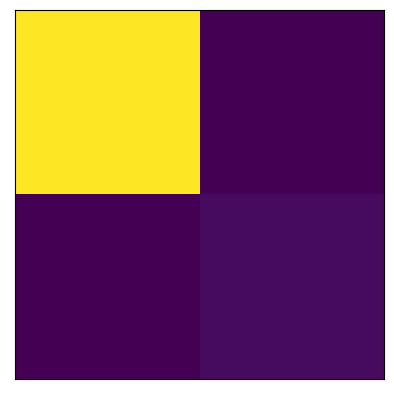

tf.Tensor(
[[36.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


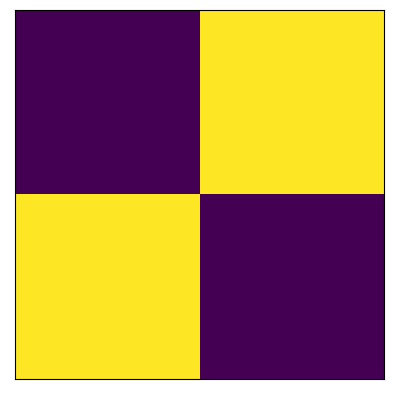

tf.Tensor(
[[0. 5.]
 [5. 0.]], shape=(2, 2), dtype=float32)


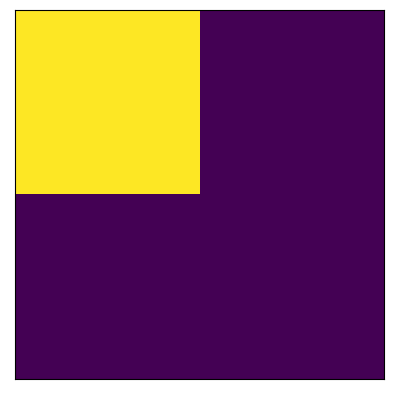

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


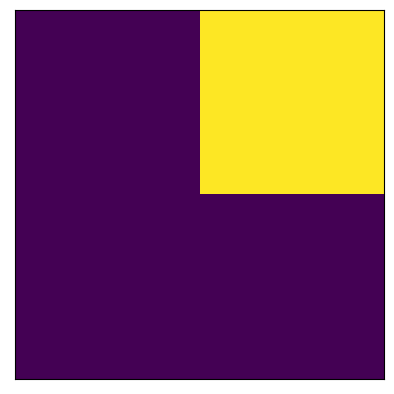

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


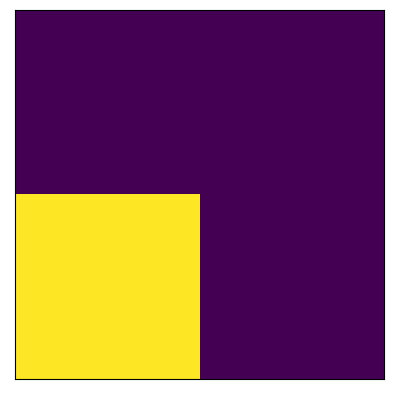

tf.Tensor(
[[0. 0.]
 [5. 0.]], shape=(2, 2), dtype=float32)


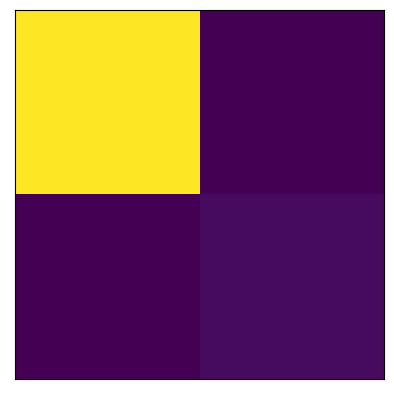

tf.Tensor(
[[35.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


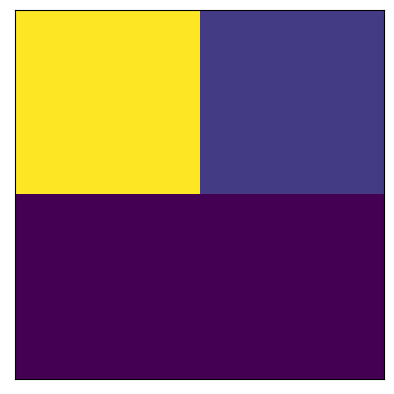

tf.Tensor(
[[1.1600001 0.2      ]
 [0.        0.       ]], shape=(2, 2), dtype=float32)


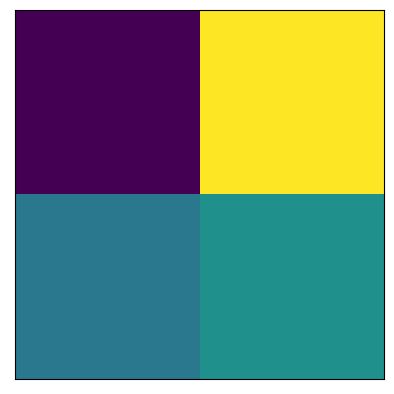

tf.Tensor(
[[0.  2. ]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


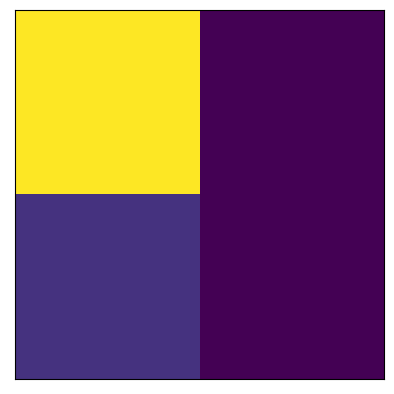

tf.Tensor(
[[1.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


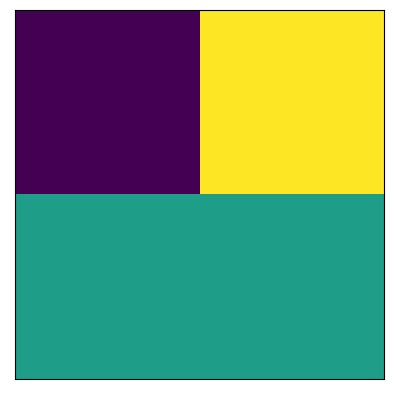

tf.Tensor(
[[0.  1.8]
 [1.  1. ]], shape=(2, 2), dtype=float32)


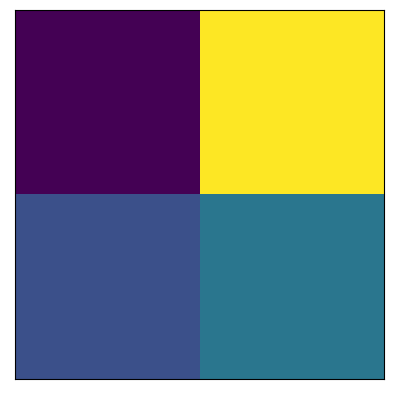

tf.Tensor(
[[0.48000002 1.8       ]
 [0.8        1.        ]], shape=(2, 2), dtype=float32)


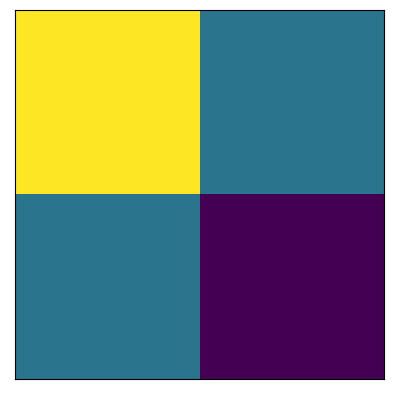

tf.Tensor(
[[0.52000004 0.2       ]
 [0.2        0.        ]], shape=(2, 2), dtype=float32)


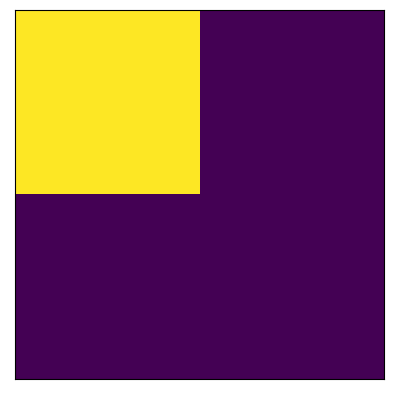

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


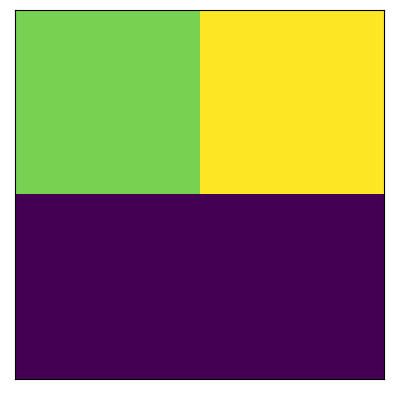

tf.Tensor(
[[0.16 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


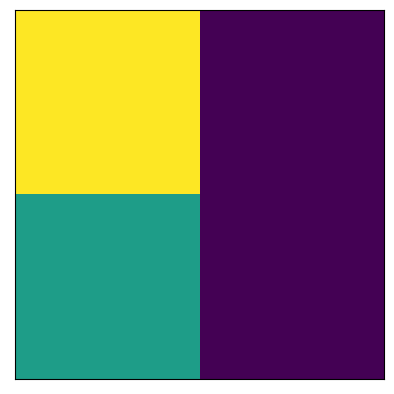

tf.Tensor(
[[0.36 0.  ]
 [0.2  0.  ]], shape=(2, 2), dtype=float32)


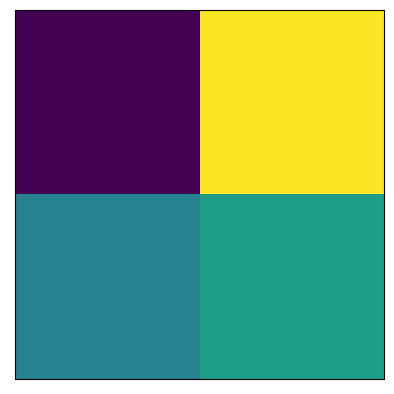

tf.Tensor(
[[0.  1.8]
 [0.8 1. ]], shape=(2, 2), dtype=float32)


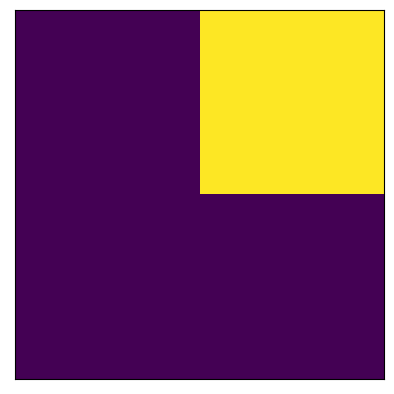

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


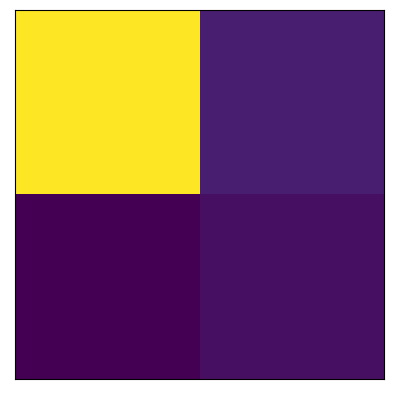

tf.Tensor(
[[24.  2.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


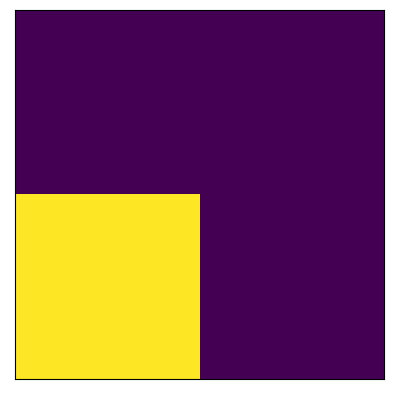

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


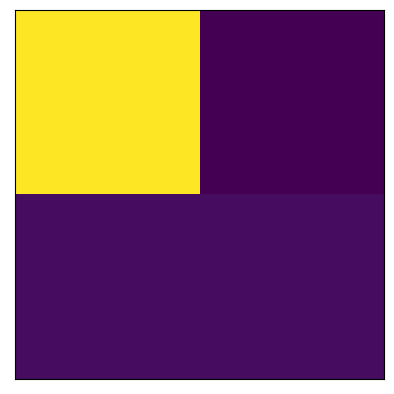

tf.Tensor(
[[30.  0.]
 [ 1.  1.]], shape=(2, 2), dtype=float32)


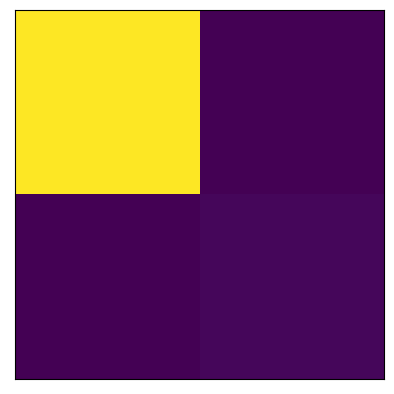

tf.Tensor(
[[55.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


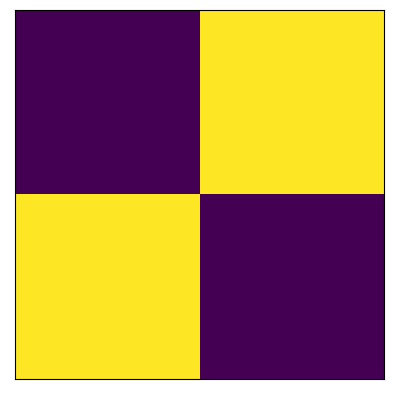

tf.Tensor(
[[0. 6.]
 [6. 0.]], shape=(2, 2), dtype=float32)


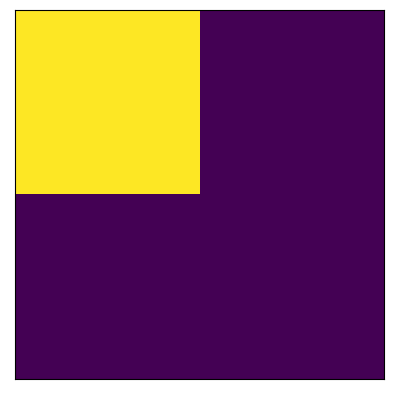

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


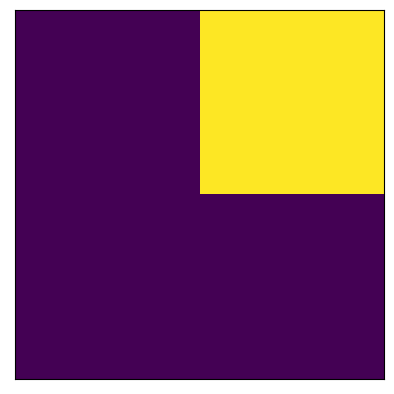

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


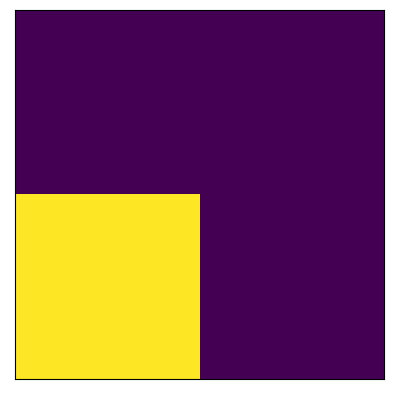

tf.Tensor(
[[0. 0.]
 [6. 0.]], shape=(2, 2), dtype=float32)


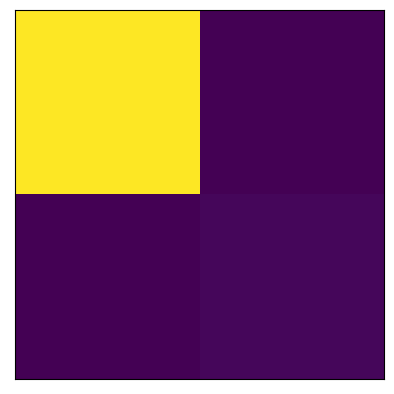

tf.Tensor(
[[54.  0.]
 [ 0.  1.]], shape=(2, 2), dtype=float32)


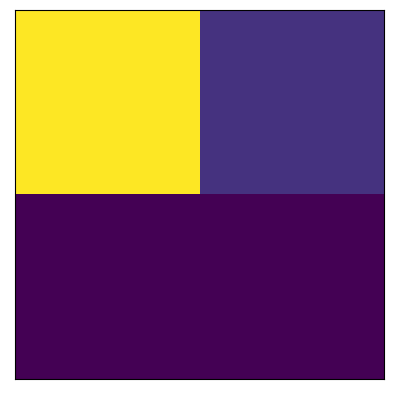

tf.Tensor(
[[1.138889   0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


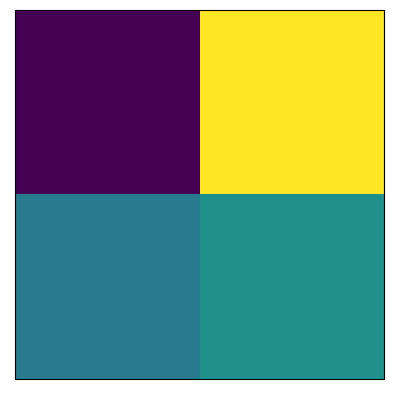

tf.Tensor(
[[0.        2.       ]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


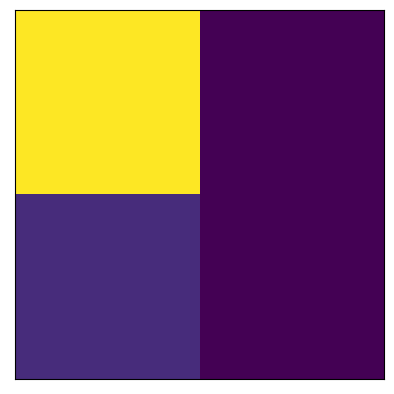

tf.Tensor(
[[1.3055556  0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


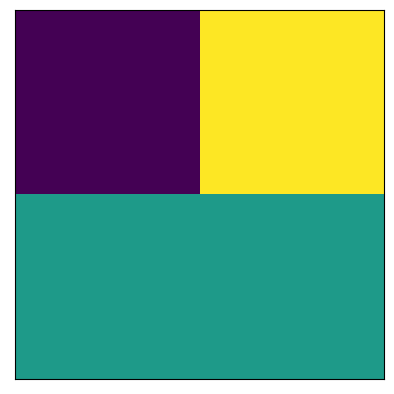

tf.Tensor(
[[0.        1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


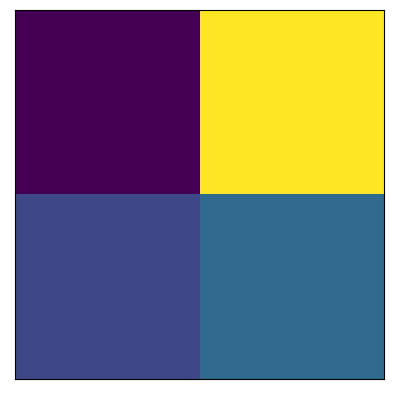

tf.Tensor(
[[0.5555555 1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


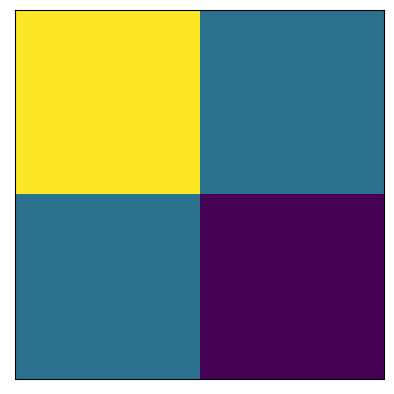

tf.Tensor(
[[0.44444445 0.16666667]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


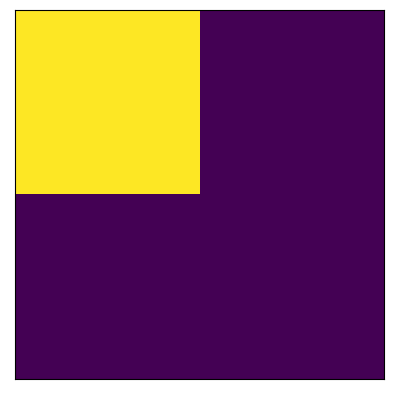

tf.Tensor(
[[1. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


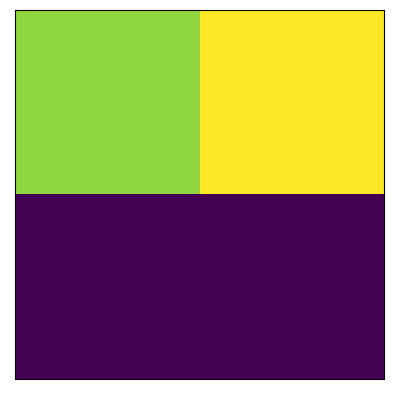

tf.Tensor(
[[0.1388889  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


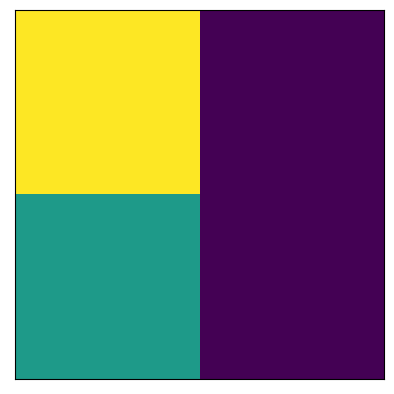

tf.Tensor(
[[0.30555555 0.        ]
 [0.16666667 0.        ]], shape=(2, 2), dtype=float32)


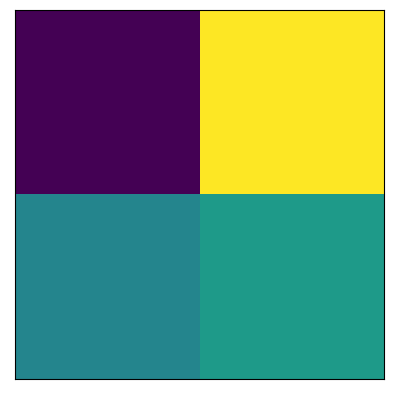

tf.Tensor(
[[0.        1.8333334]
 [0.8333333 1.       ]], shape=(2, 2), dtype=float32)


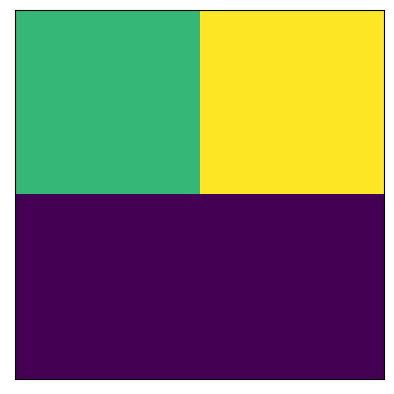

tf.Tensor(
[[2. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


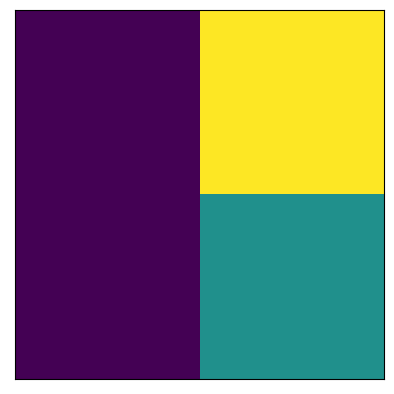

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


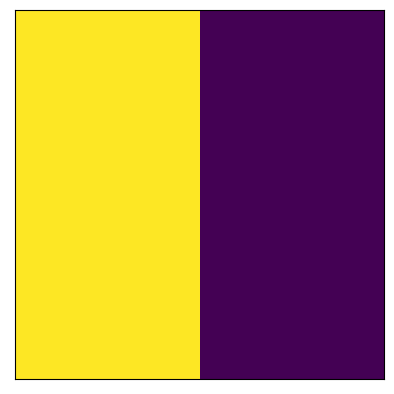

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


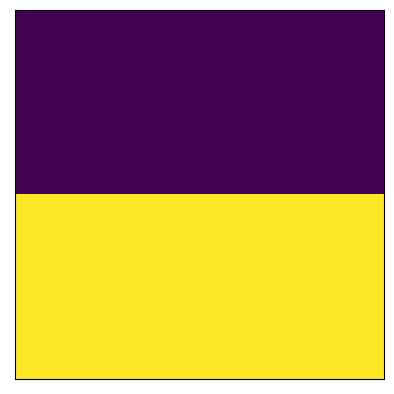

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


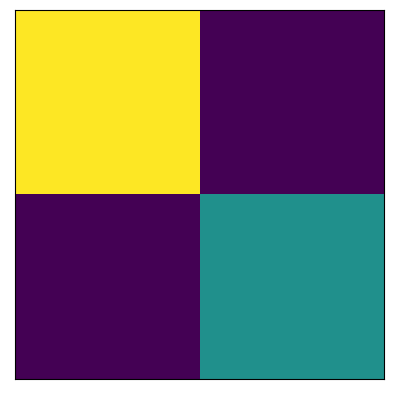

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


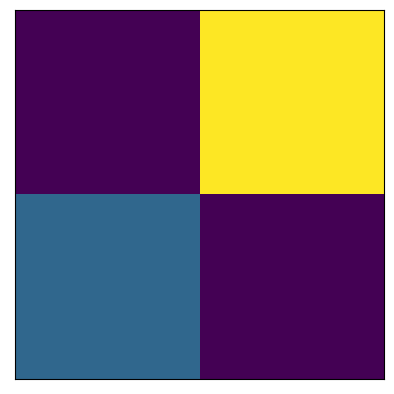

tf.Tensor(
[[0. 3.]
 [1. 0.]], shape=(2, 2), dtype=float32)


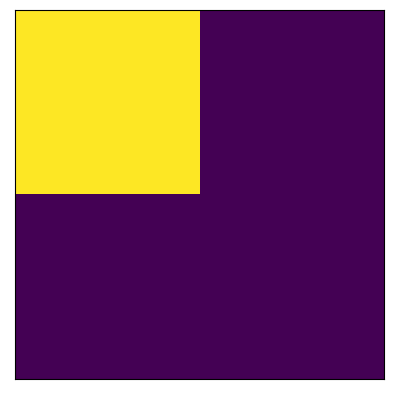

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


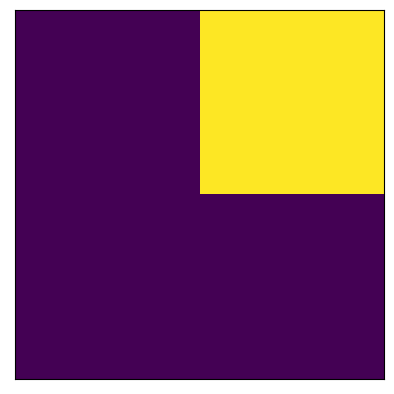

tf.Tensor(
[[0. 3.]
 [0. 0.]], shape=(2, 2), dtype=float32)


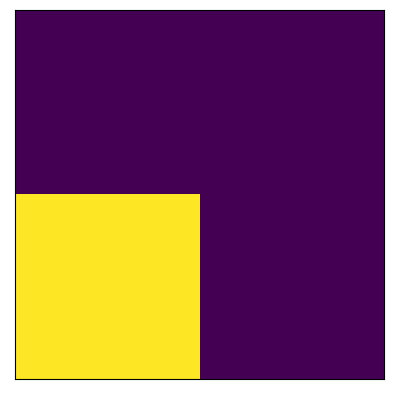

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


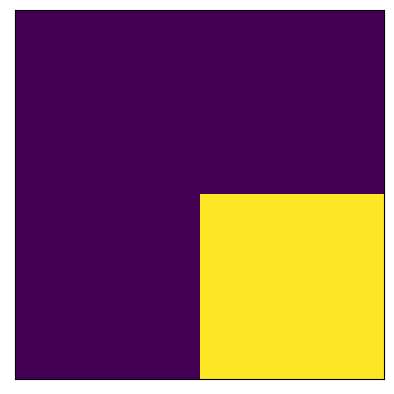

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


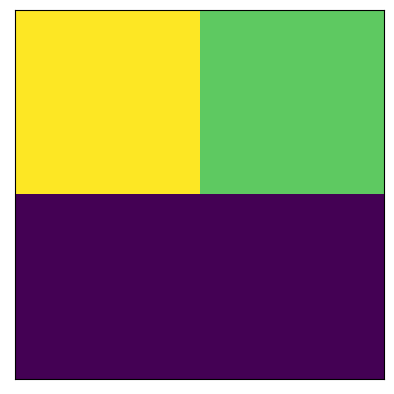

tf.Tensor(
[[0.44444445 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


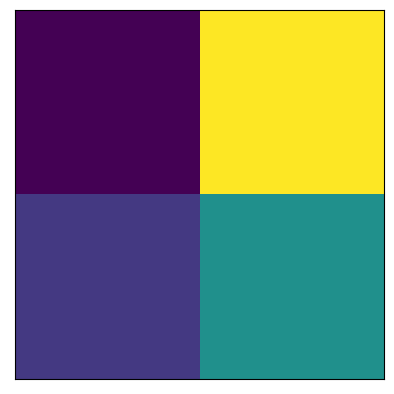

tf.Tensor(
[[0.        2.       ]
 [0.3333333 1.       ]], shape=(2, 2), dtype=float32)


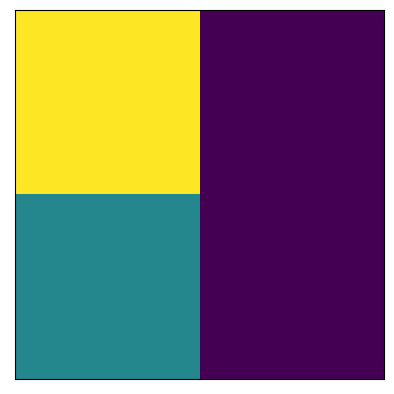

tf.Tensor(
[[1.4444444 0.       ]
 [0.6666667 0.       ]], shape=(2, 2), dtype=float32)


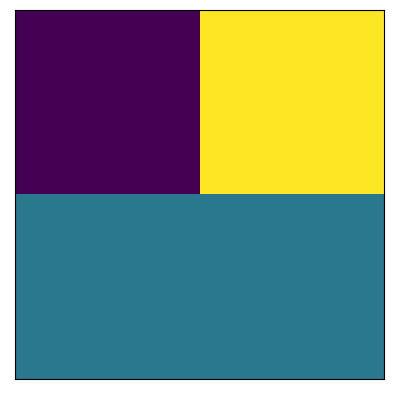

tf.Tensor(
[[0.5555555 1.6666666]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


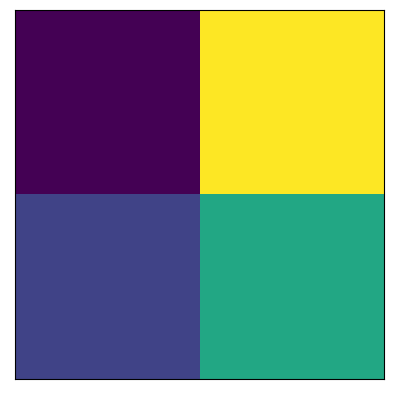

tf.Tensor(
[[0.        1.6666666]
 [0.3333333 1.       ]], shape=(2, 2), dtype=float32)


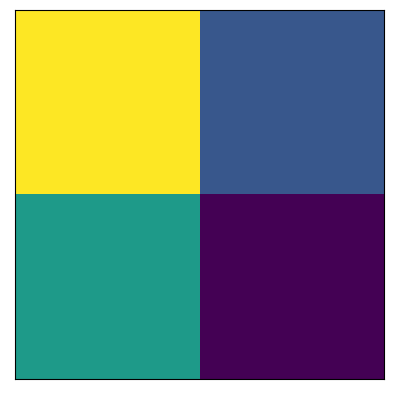

tf.Tensor(
[[1.2222223  0.33333334]
 [0.6666667  0.        ]], shape=(2, 2), dtype=float32)


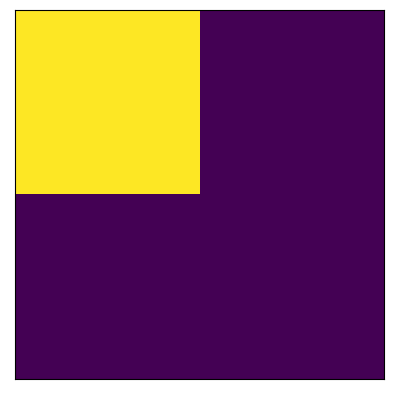

tf.Tensor(
[[0.33333334 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


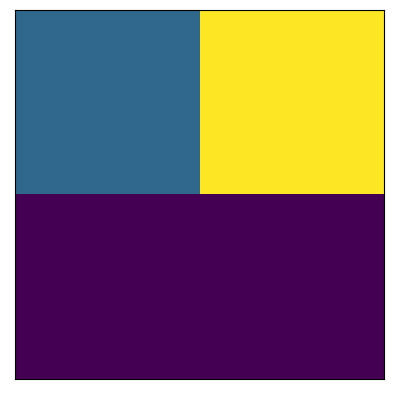

tf.Tensor(
[[0.11111112 0.33333334]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


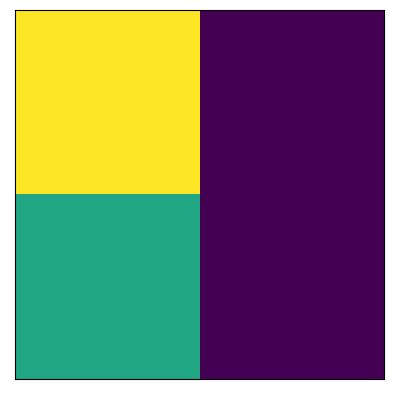

tf.Tensor(
[[1.1111112 0.       ]
 [0.6666667 0.       ]], shape=(2, 2), dtype=float32)


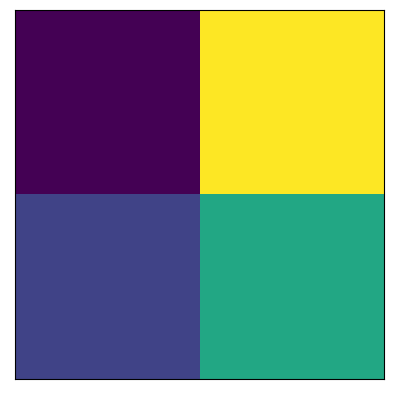

tf.Tensor(
[[0.        1.6666666]
 [0.3333333 1.       ]], shape=(2, 2), dtype=float32)


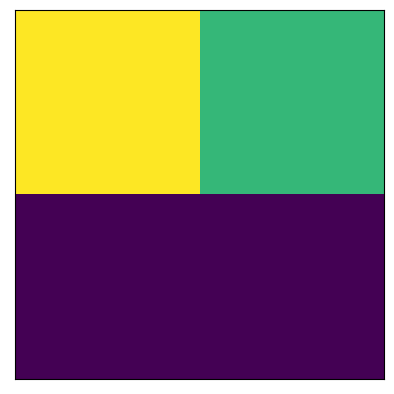

tf.Tensor(
[[3. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


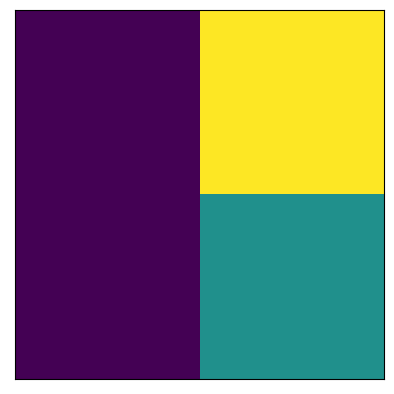

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


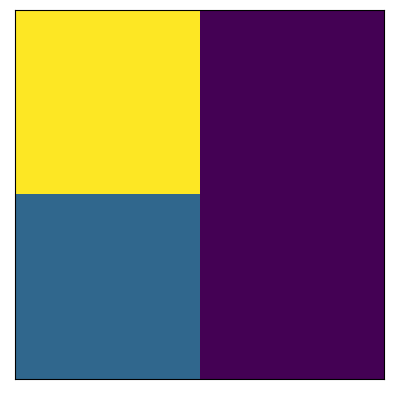

tf.Tensor(
[[3. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


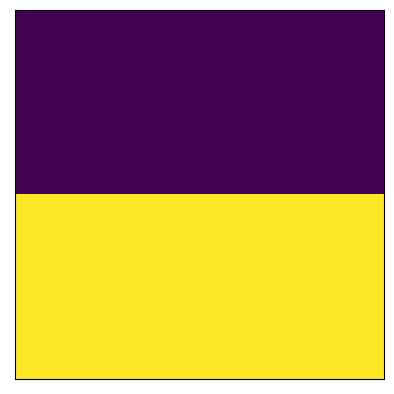

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


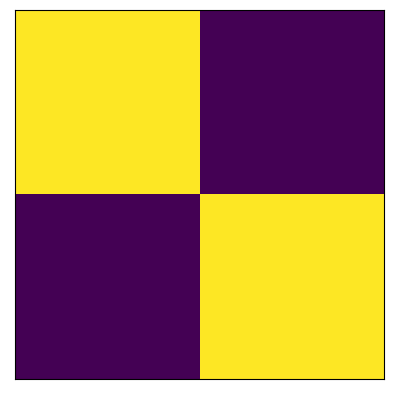

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


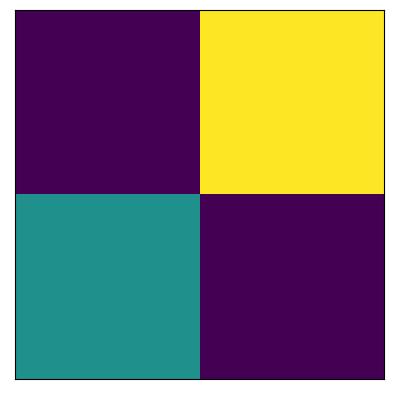

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)


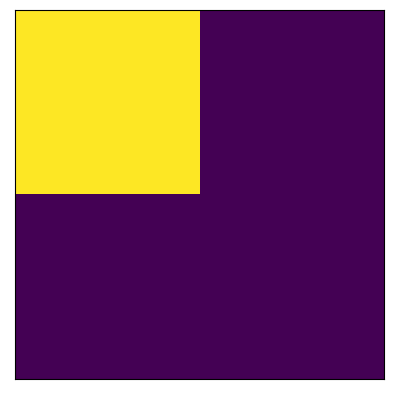

tf.Tensor(
[[3. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


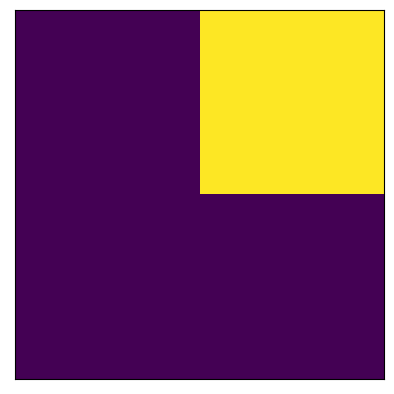

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


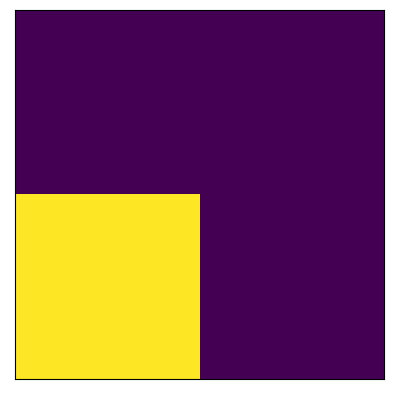

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


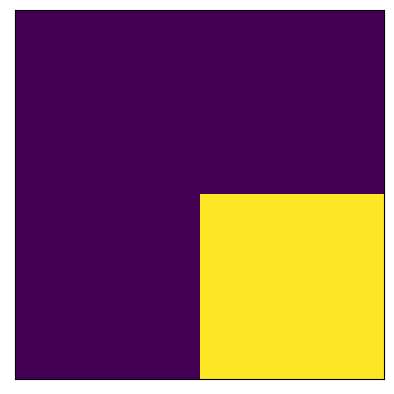

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


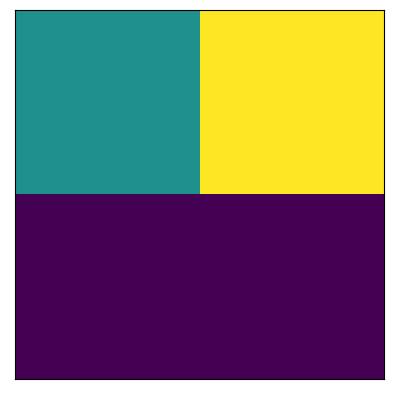

tf.Tensor(
[[0.25 0.5 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


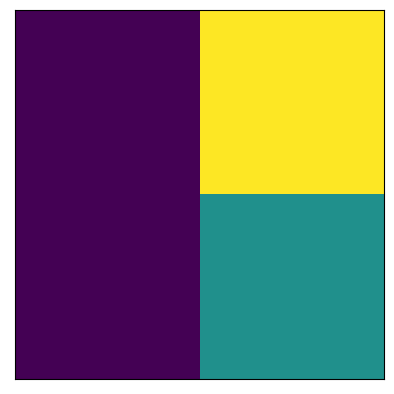

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


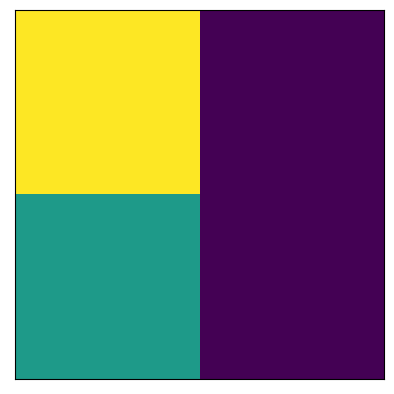

tf.Tensor(
[[2.75 0.  ]
 [1.5  0.  ]], shape=(2, 2), dtype=float32)


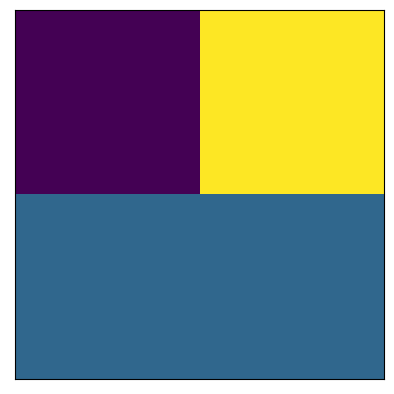

tf.Tensor(
[[0.75 1.5 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


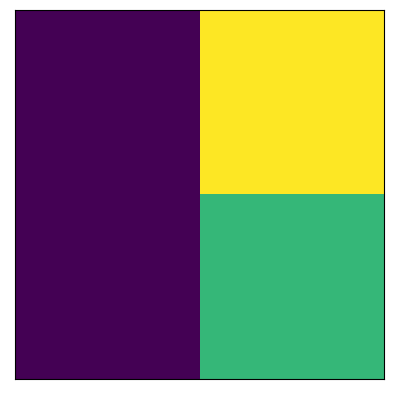

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


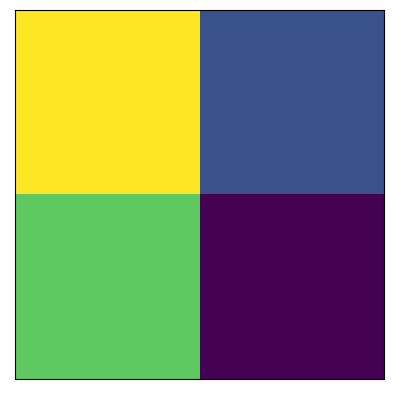

tf.Tensor(
[[2.  0.5]
 [1.5 0. ]], shape=(2, 2), dtype=float32)


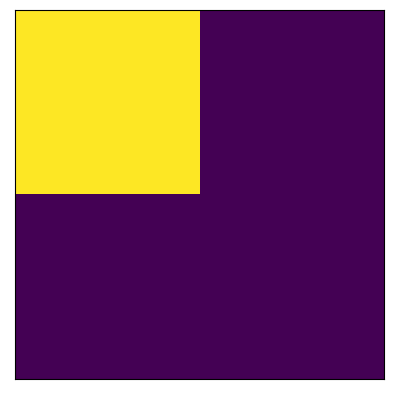

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


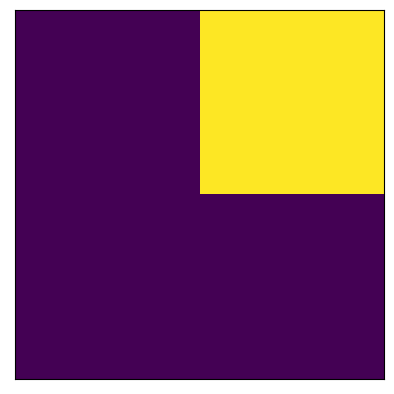

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


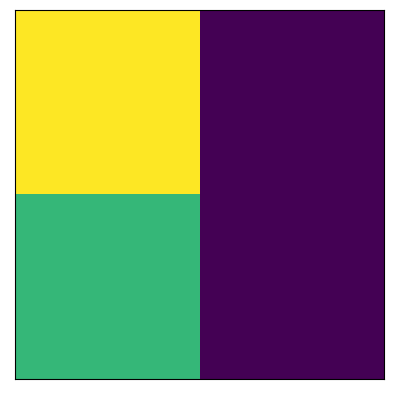

tf.Tensor(
[[2.25 0.  ]
 [1.5  0.  ]], shape=(2, 2), dtype=float32)


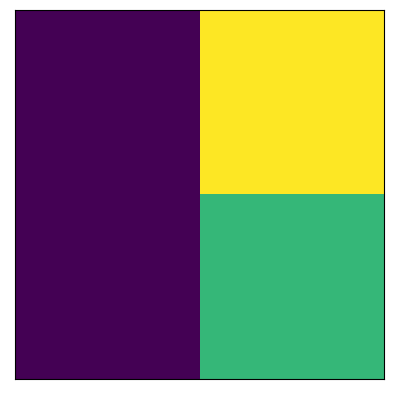

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


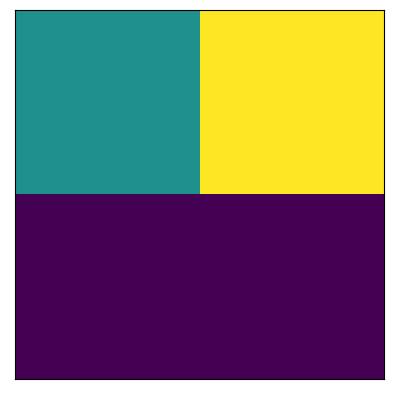

tf.Tensor(
[[2. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


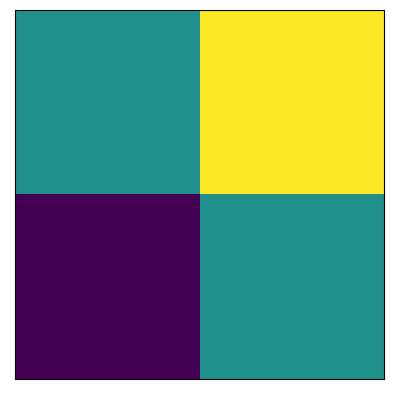

tf.Tensor(
[[1. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


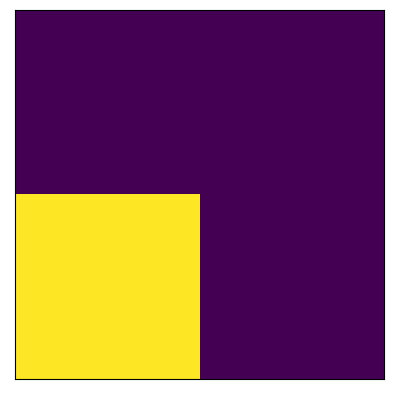

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


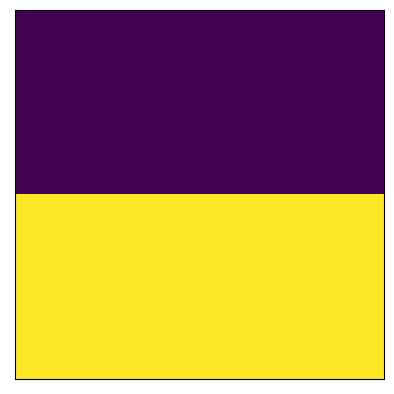

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


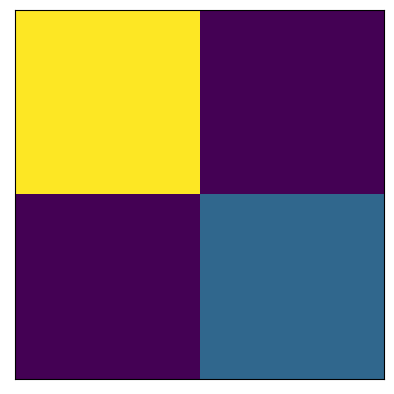

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


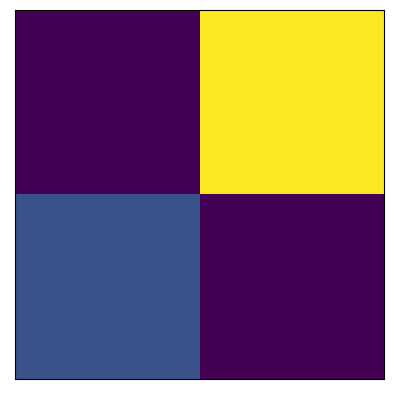

tf.Tensor(
[[0. 4.]
 [1. 0.]], shape=(2, 2), dtype=float32)


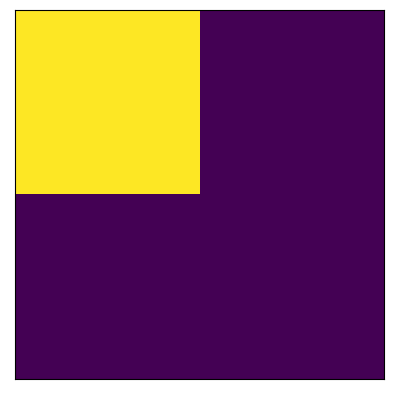

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


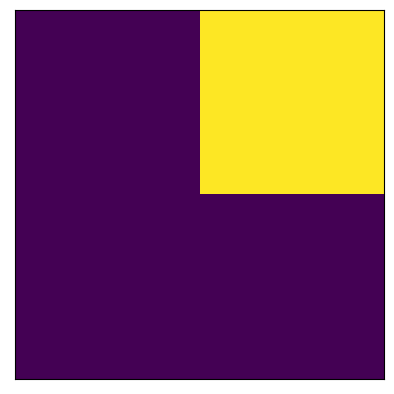

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


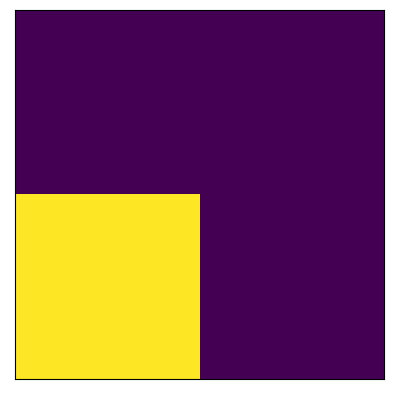

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


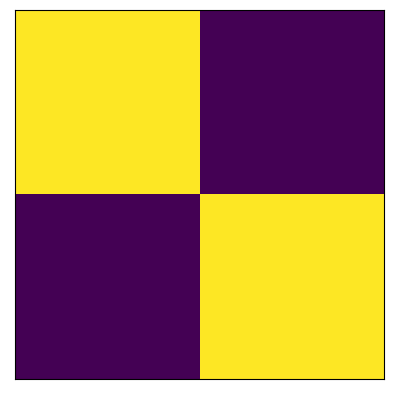

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


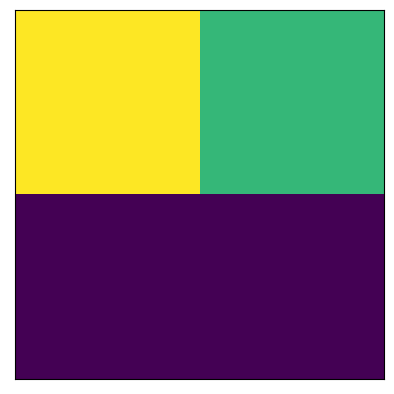

tf.Tensor(
[[0.375 0.25 ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


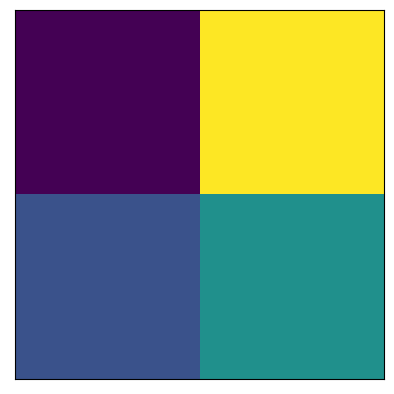

tf.Tensor(
[[0.  2. ]
 [0.5 1. ]], shape=(2, 2), dtype=float32)


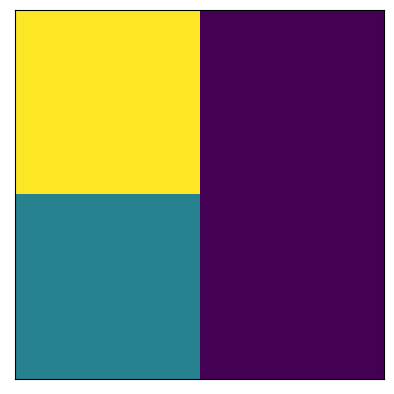

tf.Tensor(
[[1.125 0.   ]
 [0.5   0.   ]], shape=(2, 2), dtype=float32)


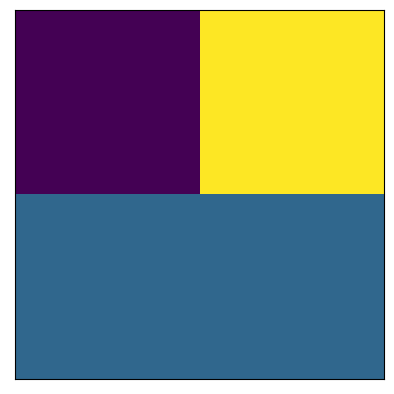

tf.Tensor(
[[0.625 1.75 ]
 [1.    1.   ]], shape=(2, 2), dtype=float32)


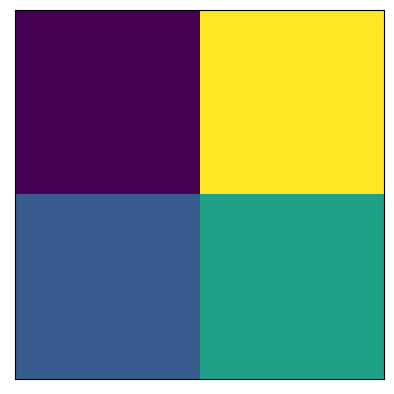

tf.Tensor(
[[0.   1.75]
 [0.5  1.  ]], shape=(2, 2), dtype=float32)


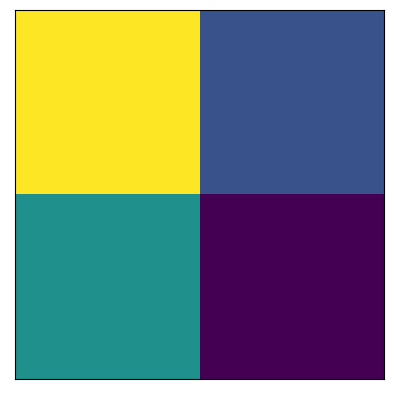

tf.Tensor(
[[1.   0.25]
 [0.5  0.  ]], shape=(2, 2), dtype=float32)


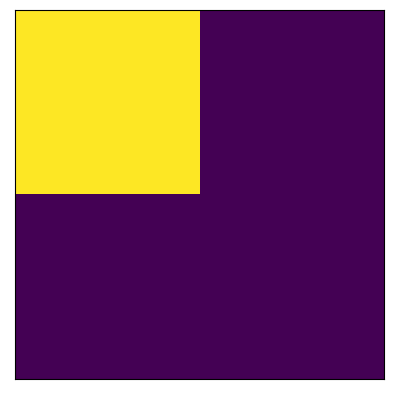

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


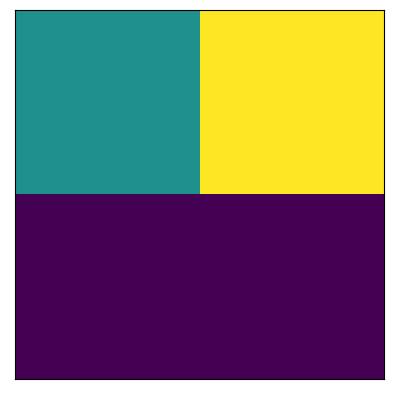

tf.Tensor(
[[0.125 0.25 ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


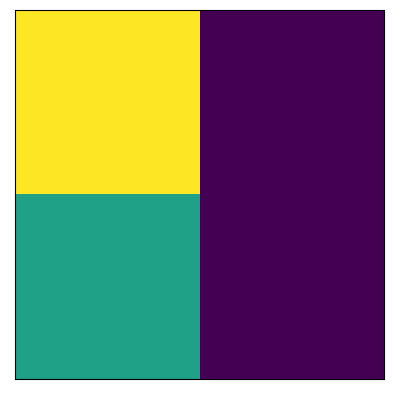

tf.Tensor(
[[0.875 0.   ]
 [0.5   0.   ]], shape=(2, 2), dtype=float32)


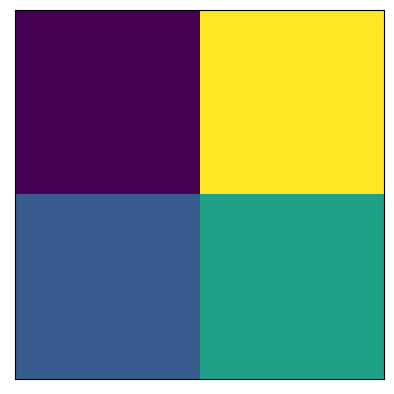

tf.Tensor(
[[0.   1.75]
 [0.5  1.  ]], shape=(2, 2), dtype=float32)


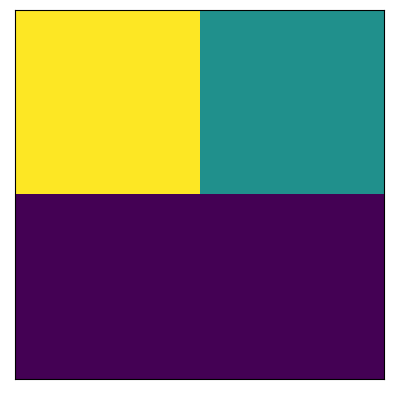

tf.Tensor(
[[4. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


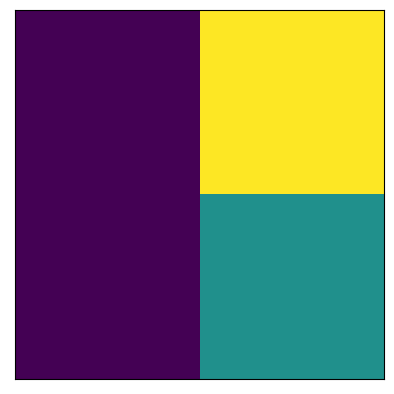

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


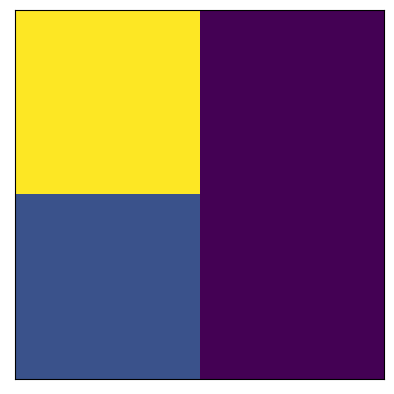

tf.Tensor(
[[4. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


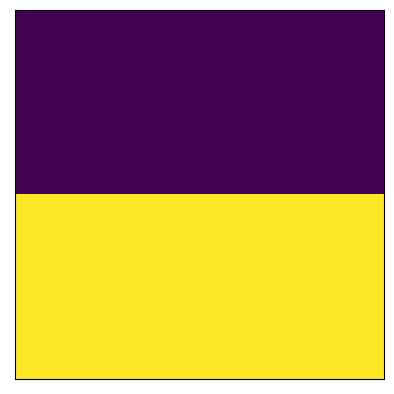

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


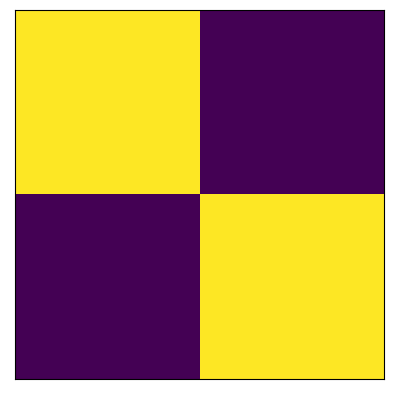

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


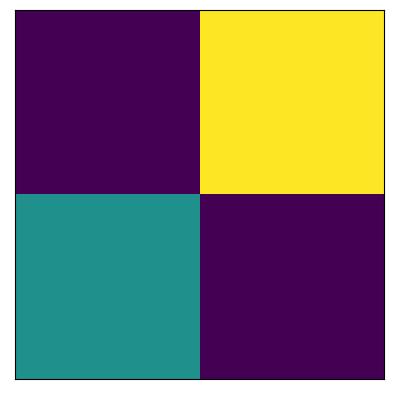

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)


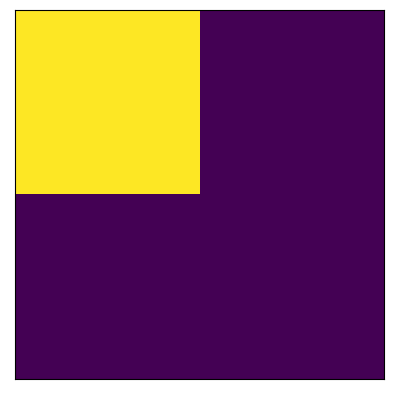

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


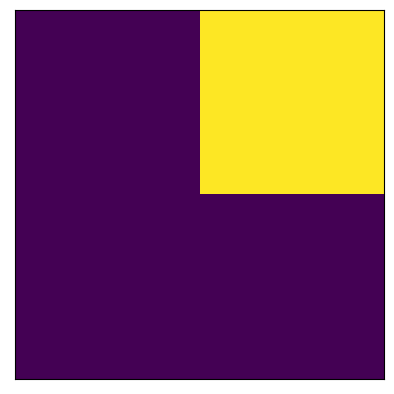

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


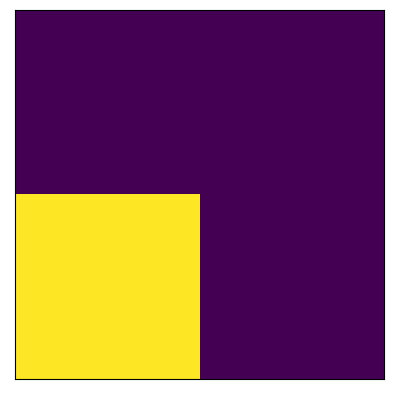

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


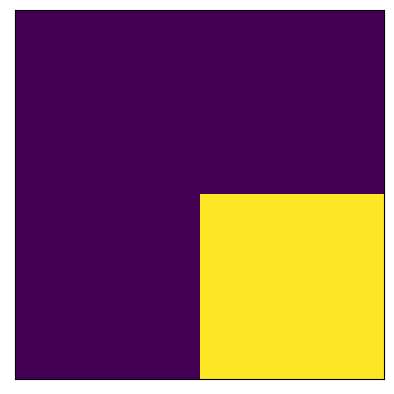

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


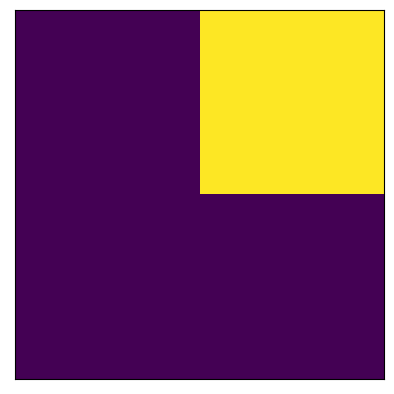

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


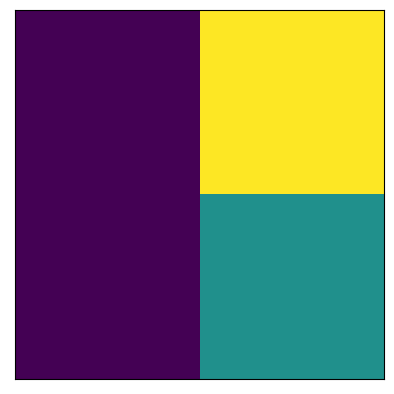

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


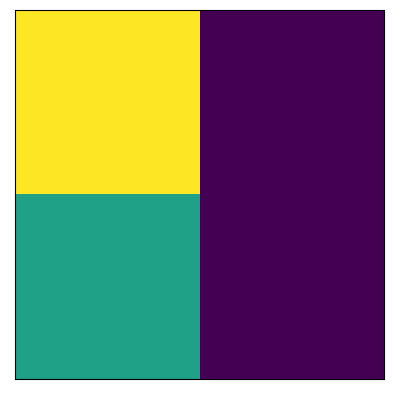

tf.Tensor(
[[3.5 0. ]
 [2.  0. ]], shape=(2, 2), dtype=float32)


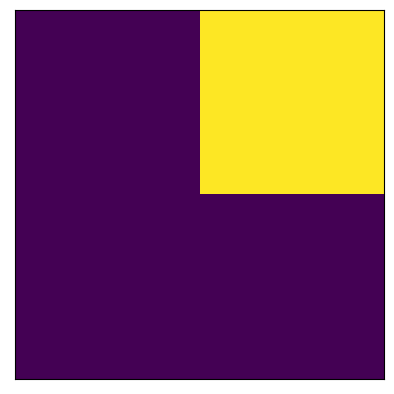

tf.Tensor(
[[1.  1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


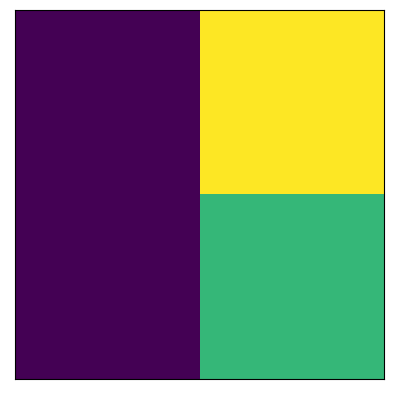

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


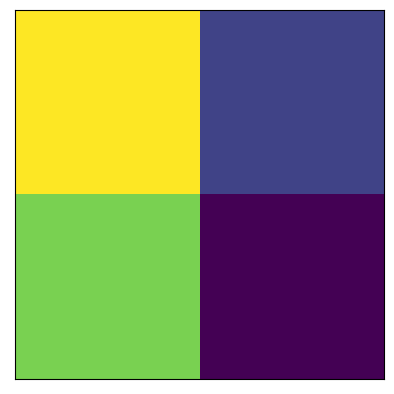

tf.Tensor(
[[2.5 0.5]
 [2.  0. ]], shape=(2, 2), dtype=float32)


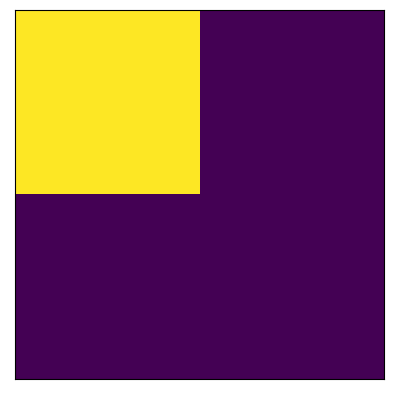

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


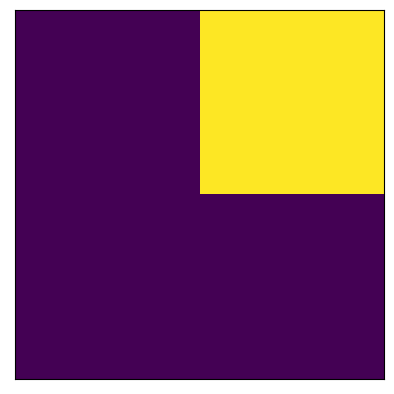

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


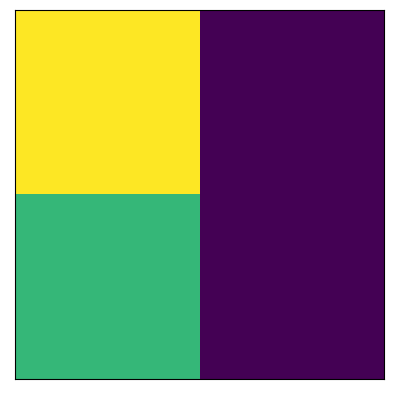

tf.Tensor(
[[3. 0.]
 [2. 0.]], shape=(2, 2), dtype=float32)


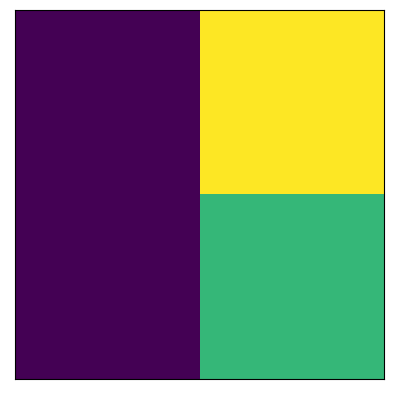

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


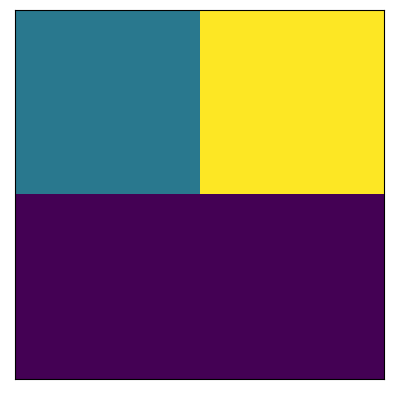

tf.Tensor(
[[2. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


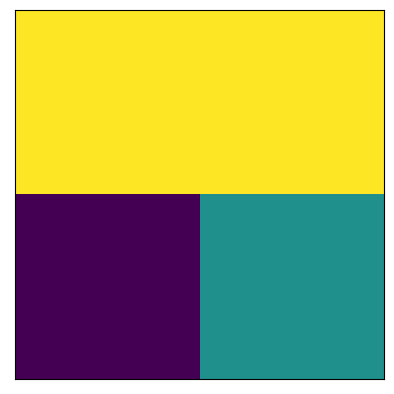

tf.Tensor(
[[2. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


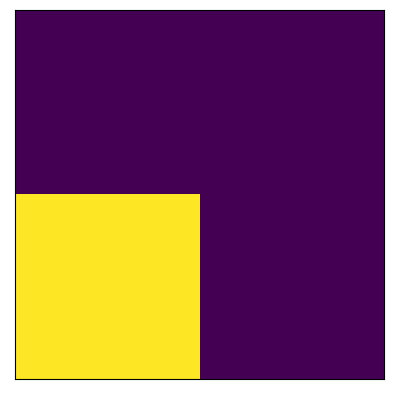

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


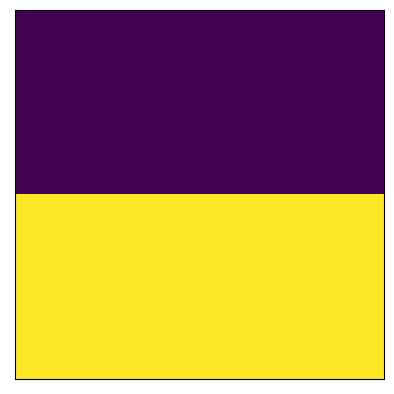

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


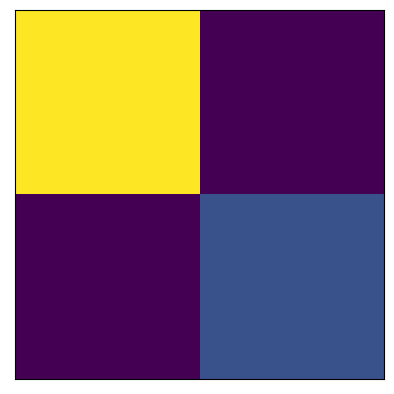

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


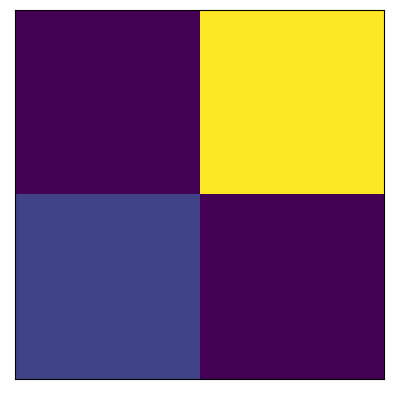

tf.Tensor(
[[0. 5.]
 [1. 0.]], shape=(2, 2), dtype=float32)


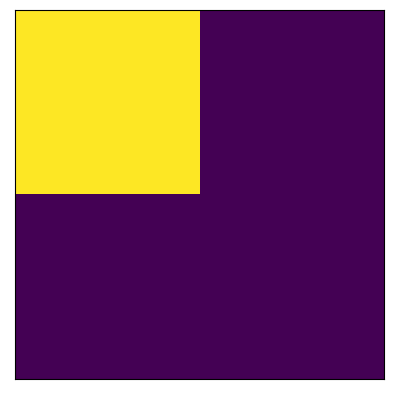

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


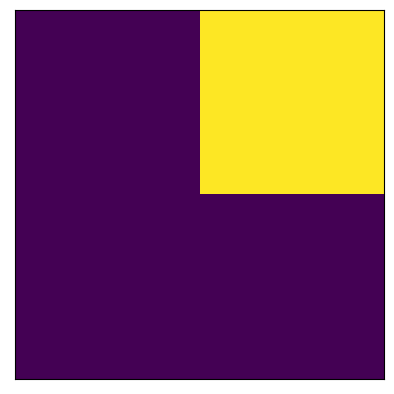

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


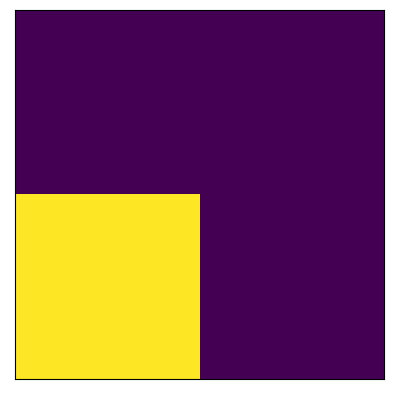

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


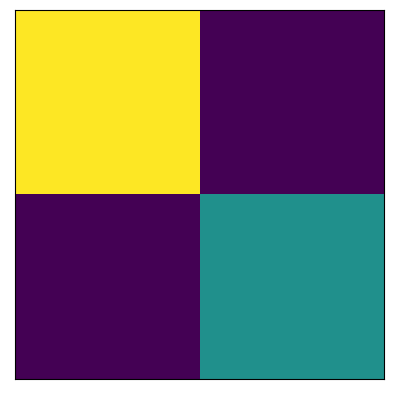

tf.Tensor(
[[2. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


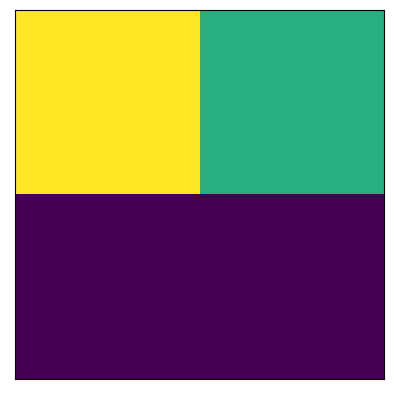

tf.Tensor(
[[0.32 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


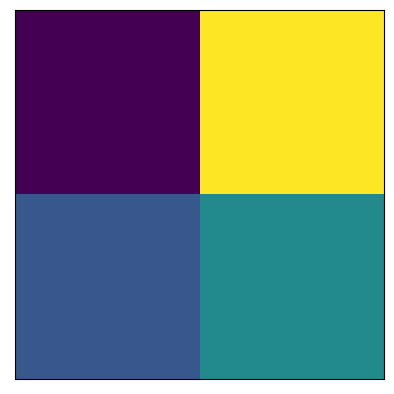

tf.Tensor(
[[0.07999999 2.        ]
 [0.6        1.        ]], shape=(2, 2), dtype=float32)


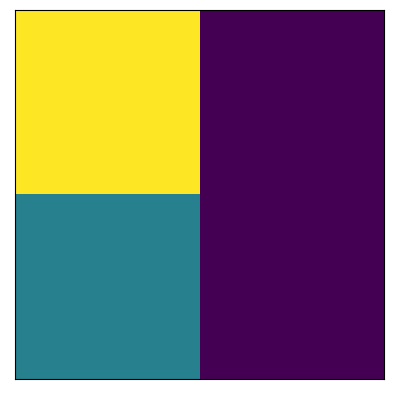

tf.Tensor(
[[0.92 0.  ]
 [0.4  0.  ]], shape=(2, 2), dtype=float32)


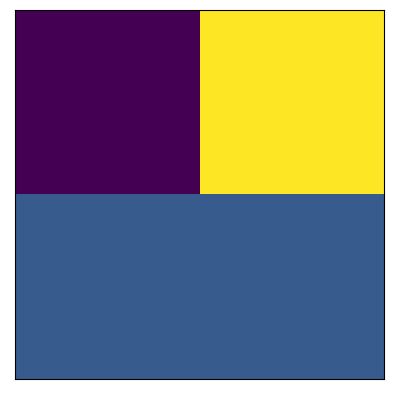

tf.Tensor(
[[0.68 1.8 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


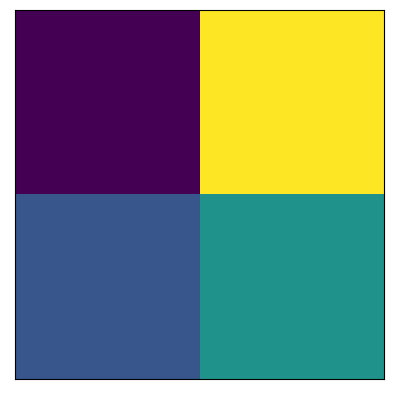

tf.Tensor(
[[0.15999998 1.8       ]
 [0.6        1.        ]], shape=(2, 2), dtype=float32)


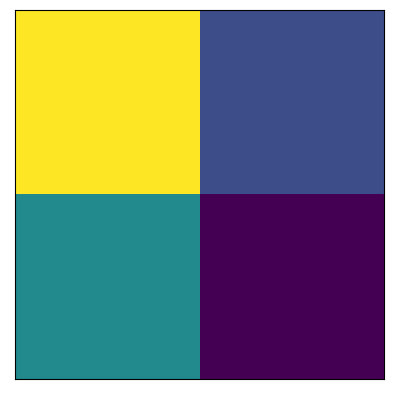

tf.Tensor(
[[0.84000003 0.2       ]
 [0.4        0.        ]], shape=(2, 2), dtype=float32)


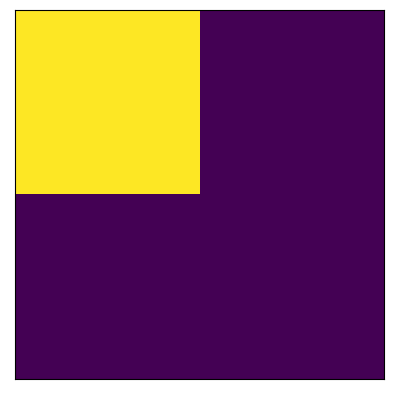

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


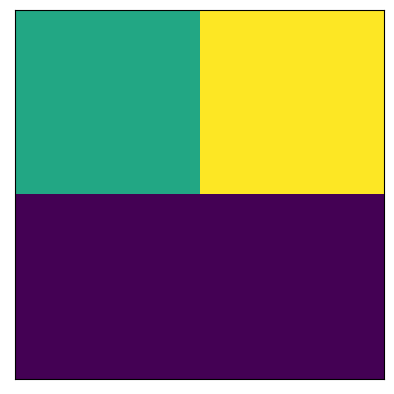

tf.Tensor(
[[0.12 0.2 ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


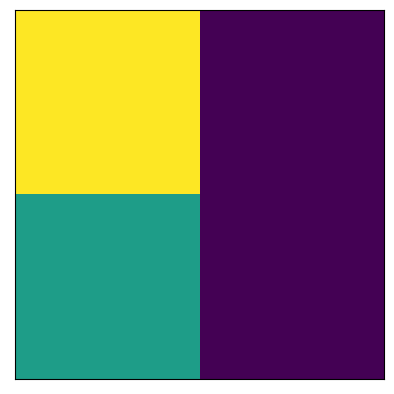

tf.Tensor(
[[0.72 0.  ]
 [0.4  0.  ]], shape=(2, 2), dtype=float32)


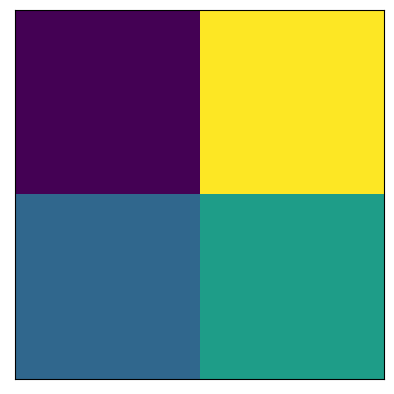

tf.Tensor(
[[0.  1.8]
 [0.6 1. ]], shape=(2, 2), dtype=float32)


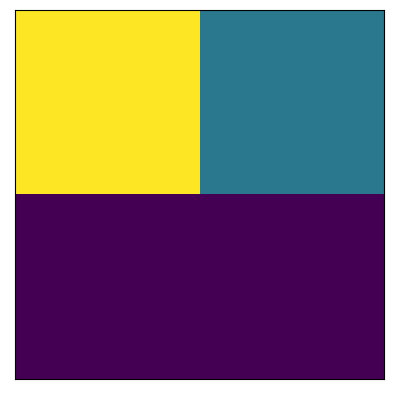

tf.Tensor(
[[5. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


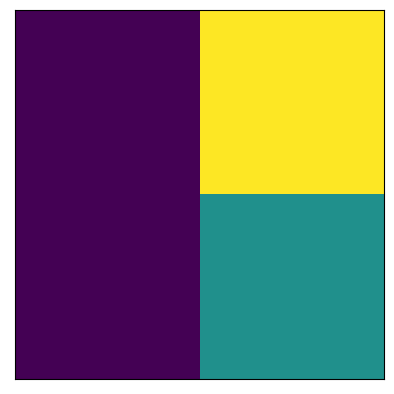

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


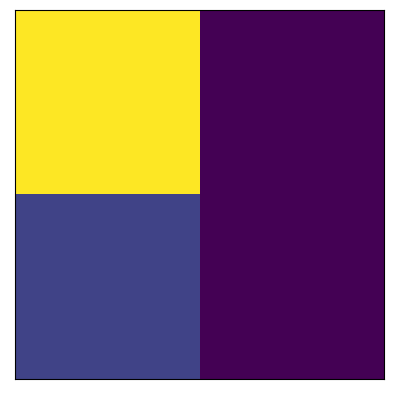

tf.Tensor(
[[5. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


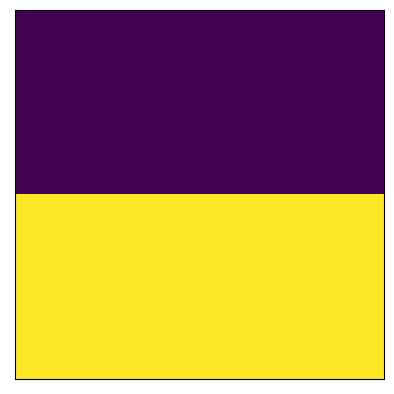

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


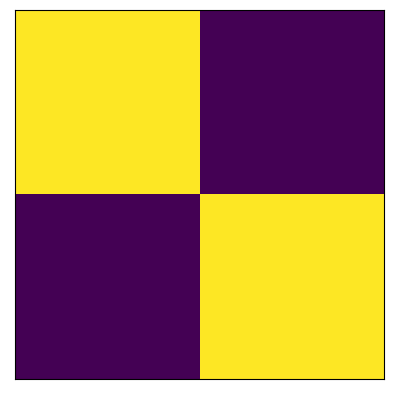

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


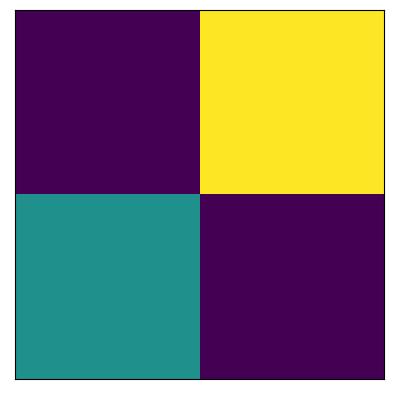

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)


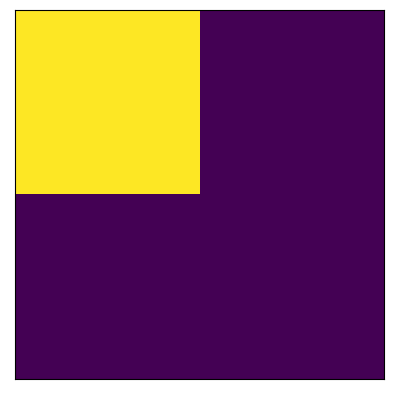

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


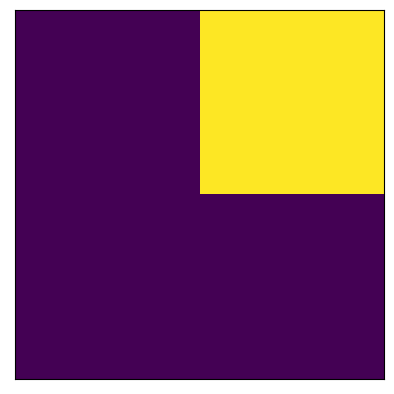

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


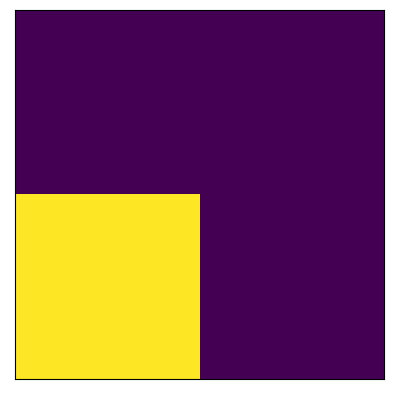

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


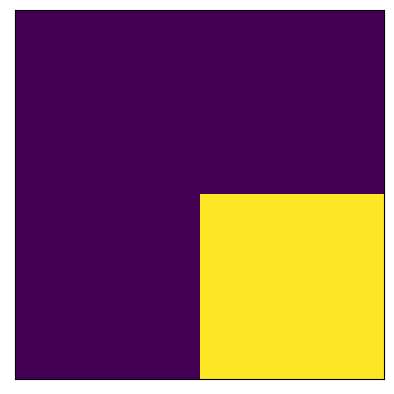

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


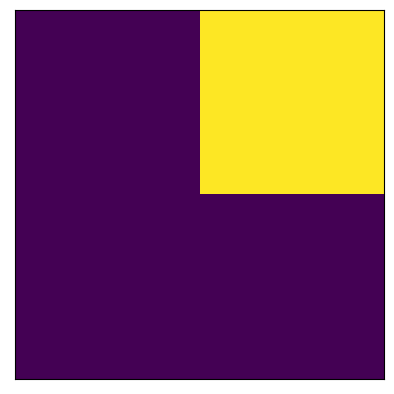

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


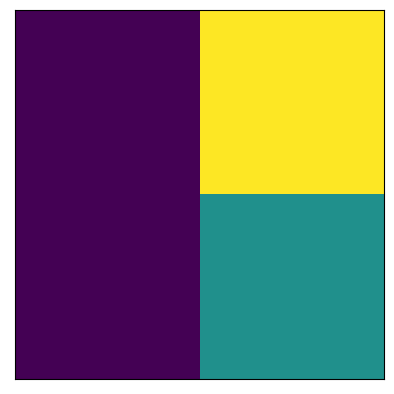

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


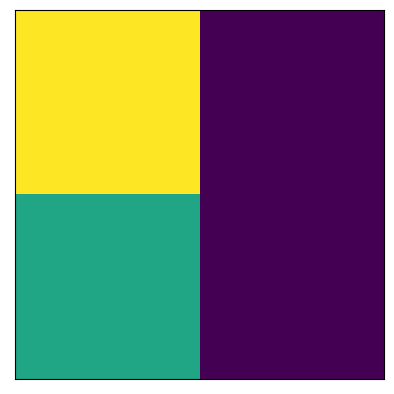

tf.Tensor(
[[4.25 0.  ]
 [2.5  0.  ]], shape=(2, 2), dtype=float32)


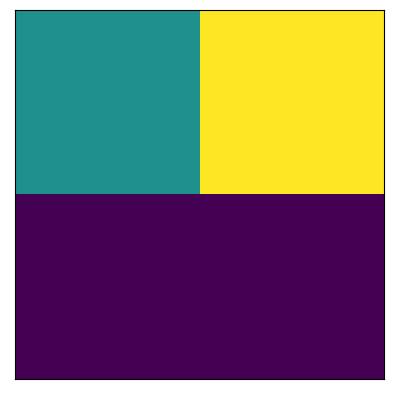

tf.Tensor(
[[1.25 1.5 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


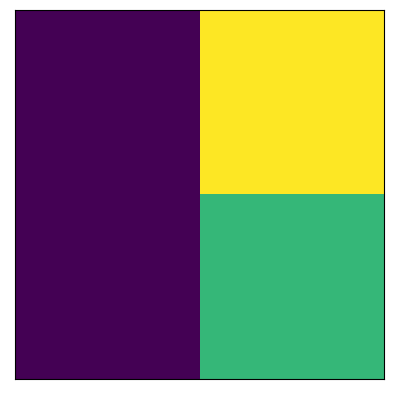

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


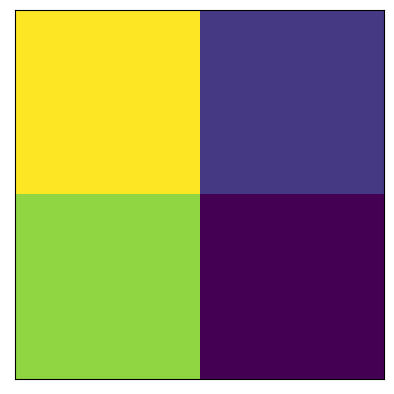

tf.Tensor(
[[3.  0.5]
 [2.5 0. ]], shape=(2, 2), dtype=float32)


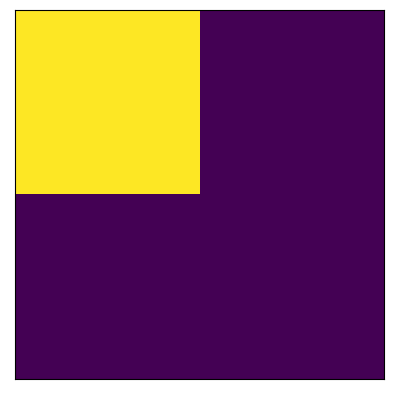

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


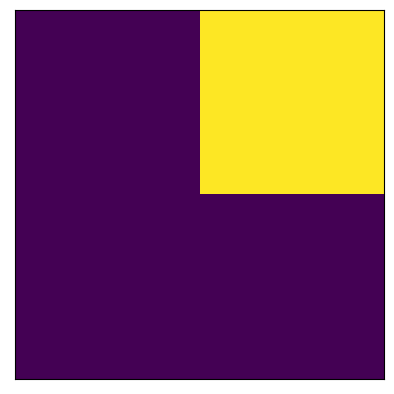

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


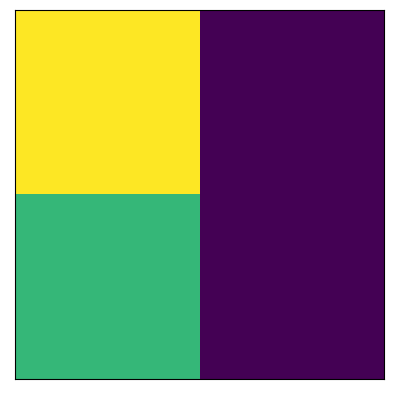

tf.Tensor(
[[3.75 0.  ]
 [2.5  0.  ]], shape=(2, 2), dtype=float32)


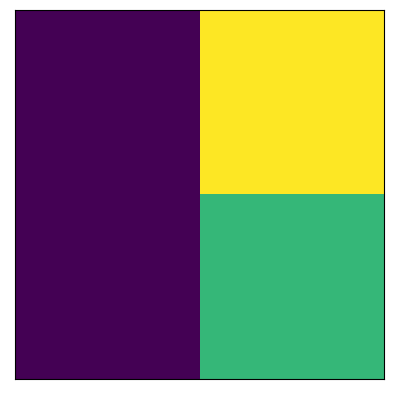

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


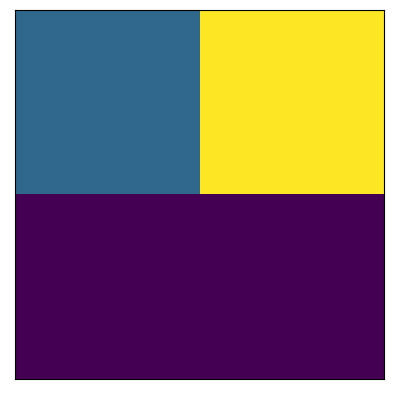

tf.Tensor(
[[2. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


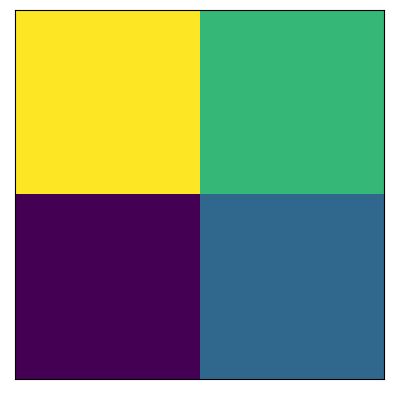

tf.Tensor(
[[3. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


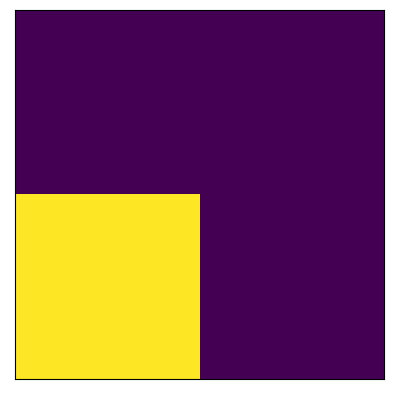

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


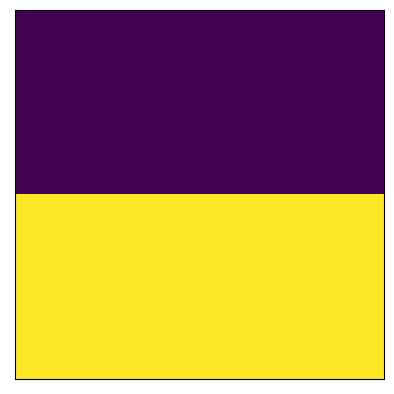

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


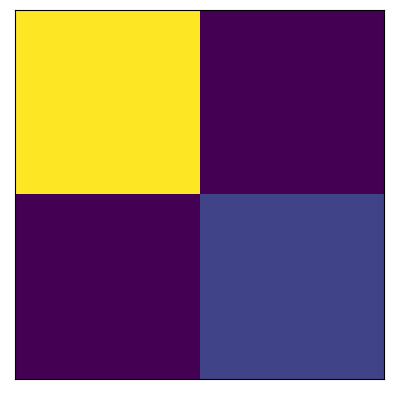

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


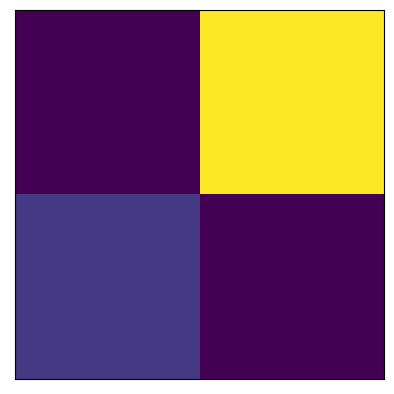

tf.Tensor(
[[0. 6.]
 [1. 0.]], shape=(2, 2), dtype=float32)


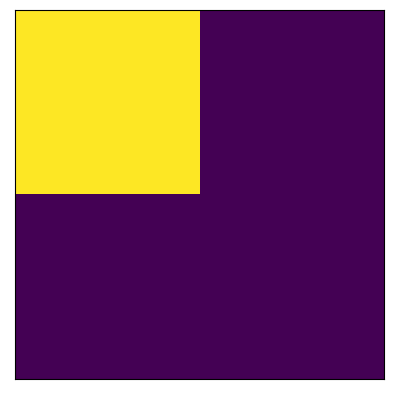

tf.Tensor(
[[2. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


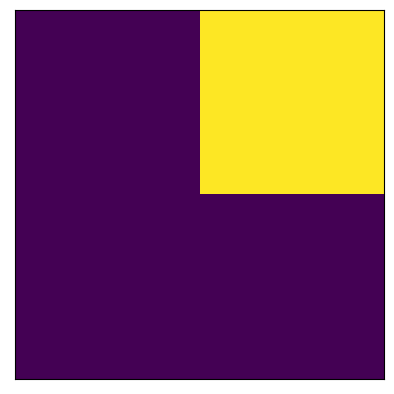

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


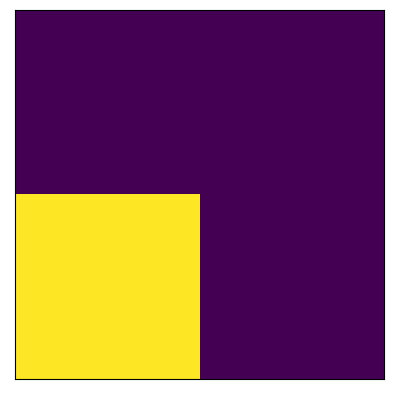

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


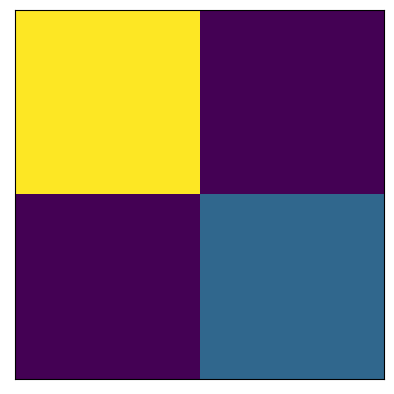

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


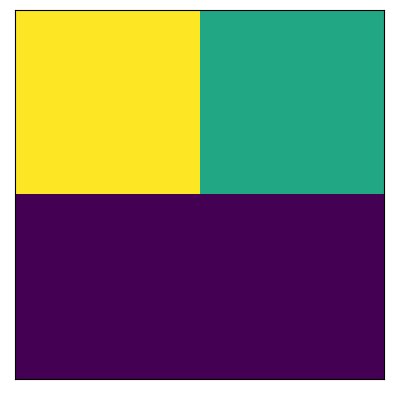

tf.Tensor(
[[0.2777778  0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


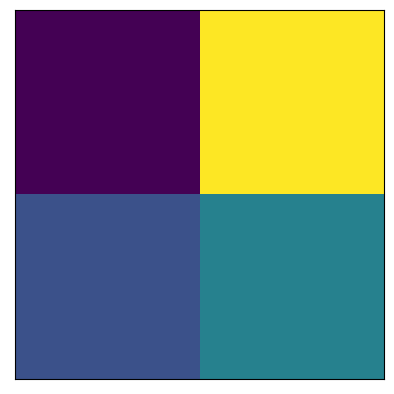

tf.Tensor(
[[0.22222221 2.        ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


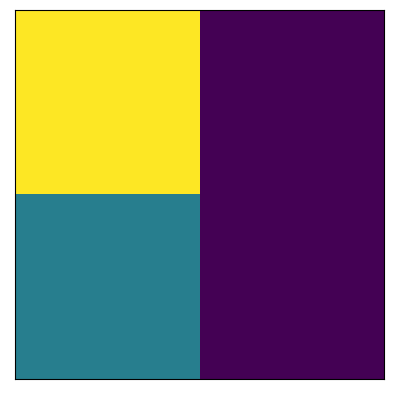

tf.Tensor(
[[0.7777778  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


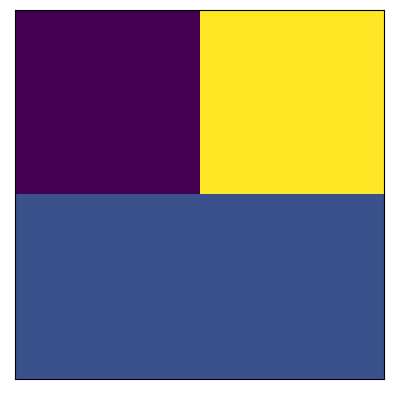

tf.Tensor(
[[0.7222222 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


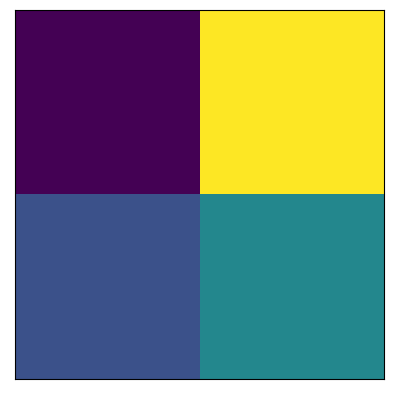

tf.Tensor(
[[0.27777776 1.8333334 ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


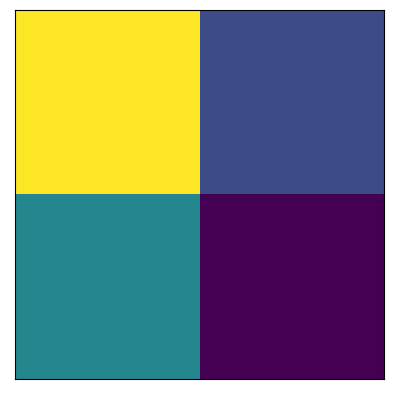

tf.Tensor(
[[0.72222227 0.16666667]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


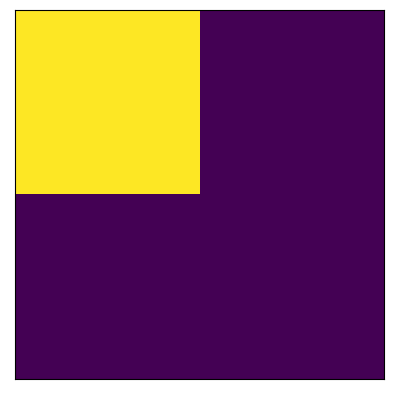

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


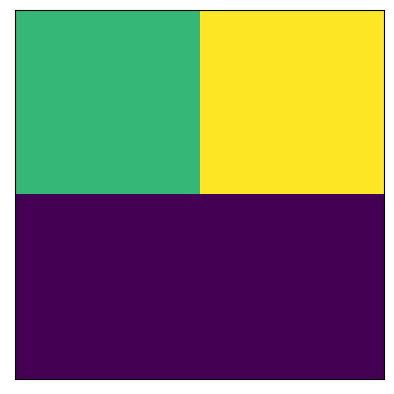

tf.Tensor(
[[0.11111112 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


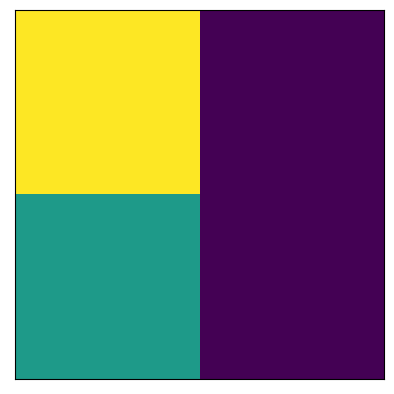

tf.Tensor(
[[0.6111111  0.        ]
 [0.33333334 0.        ]], shape=(2, 2), dtype=float32)


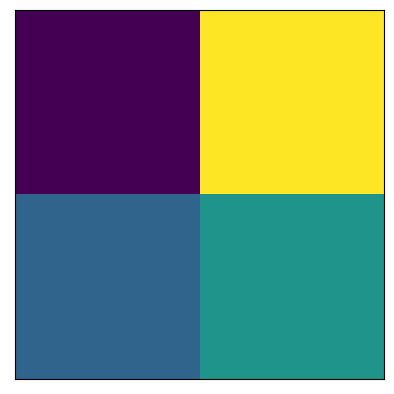

tf.Tensor(
[[0.11111109 1.8333334 ]
 [0.6666666  1.        ]], shape=(2, 2), dtype=float32)


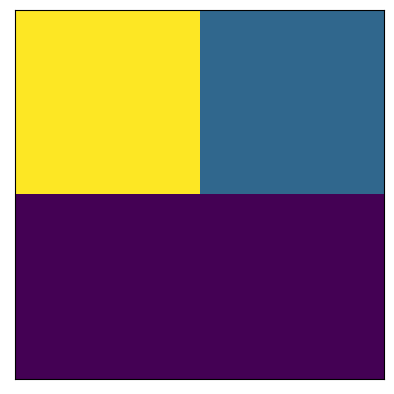

tf.Tensor(
[[6. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


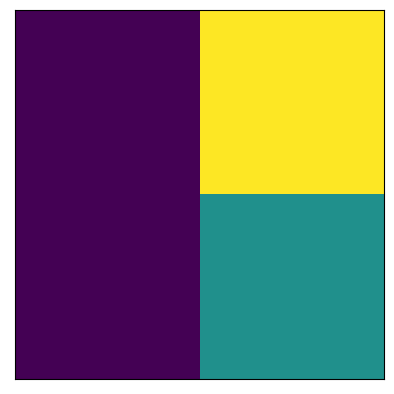

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


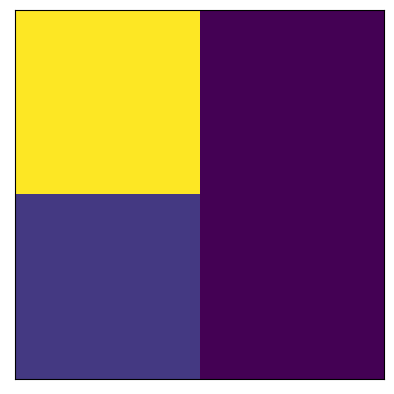

tf.Tensor(
[[6. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


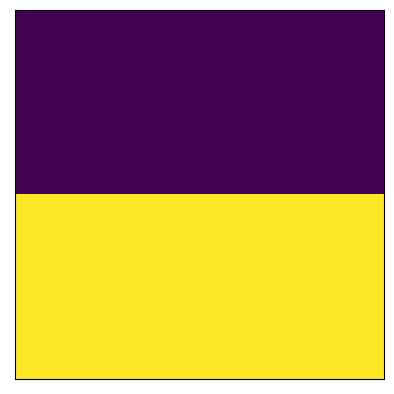

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


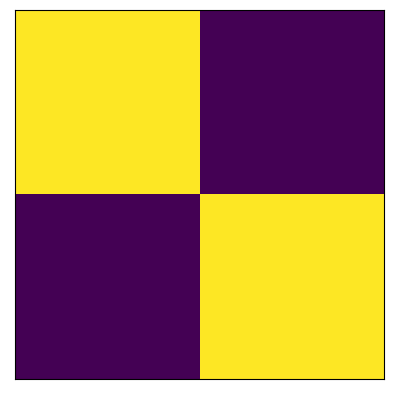

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


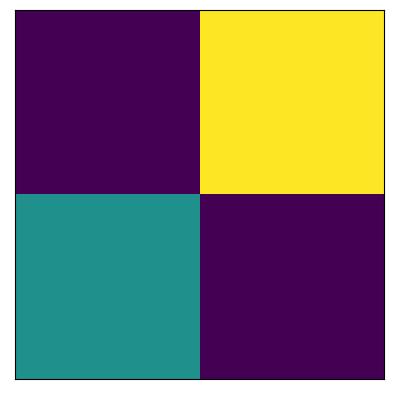

tf.Tensor(
[[0. 2.]
 [1. 0.]], shape=(2, 2), dtype=float32)


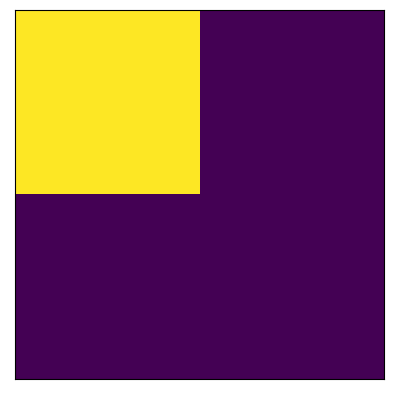

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


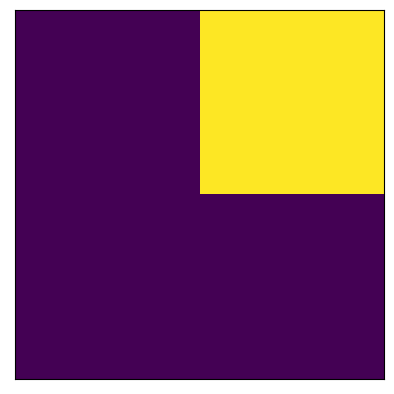

tf.Tensor(
[[0. 2.]
 [0. 0.]], shape=(2, 2), dtype=float32)


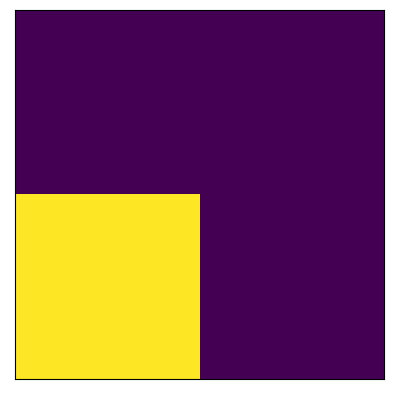

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


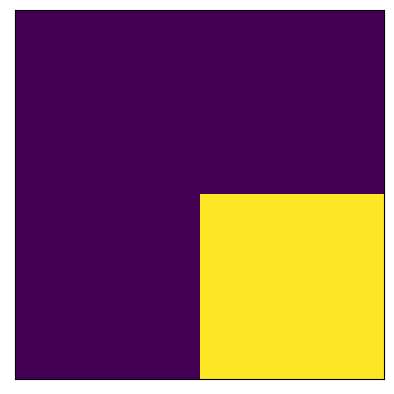

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


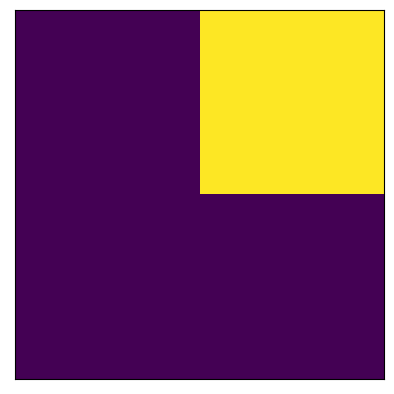

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


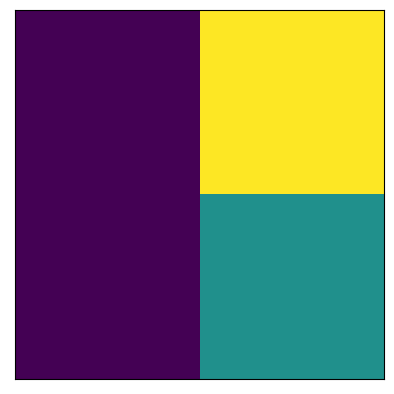

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


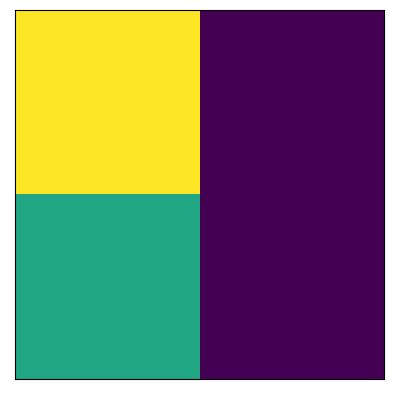

tf.Tensor(
[[5. 0.]
 [3. 0.]], shape=(2, 2), dtype=float32)


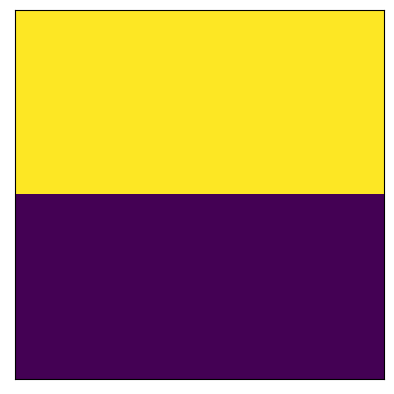

tf.Tensor(
[[1.5 1.5]
 [1.  1. ]], shape=(2, 2), dtype=float32)


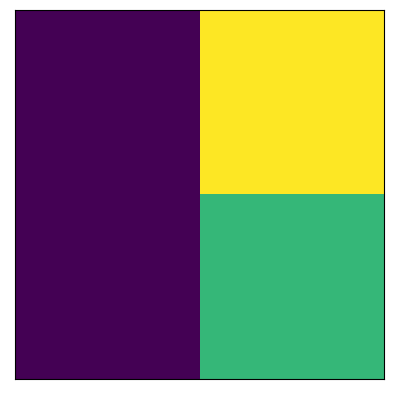

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


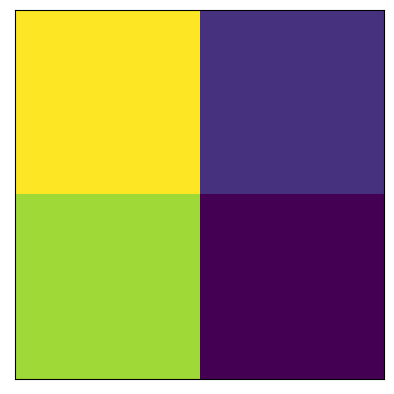

tf.Tensor(
[[3.5 0.5]
 [3.  0. ]], shape=(2, 2), dtype=float32)


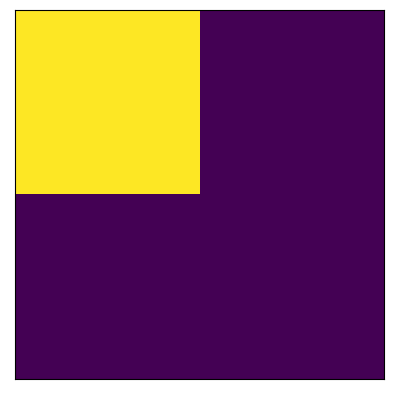

tf.Tensor(
[[0.5 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


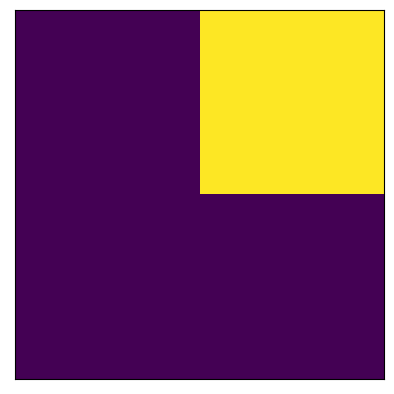

tf.Tensor(
[[0.  0.5]
 [0.  0. ]], shape=(2, 2), dtype=float32)


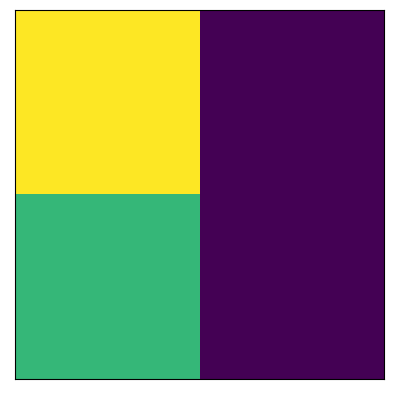

tf.Tensor(
[[4.5 0. ]
 [3.  0. ]], shape=(2, 2), dtype=float32)


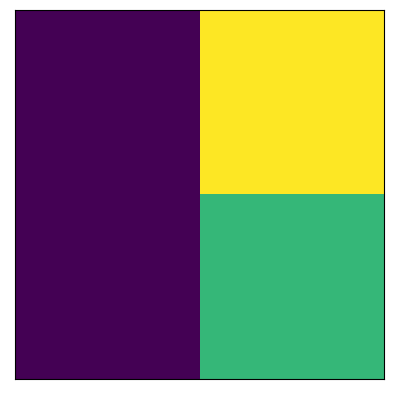

tf.Tensor(
[[0.  1.5]
 [0.  1. ]], shape=(2, 2), dtype=float32)


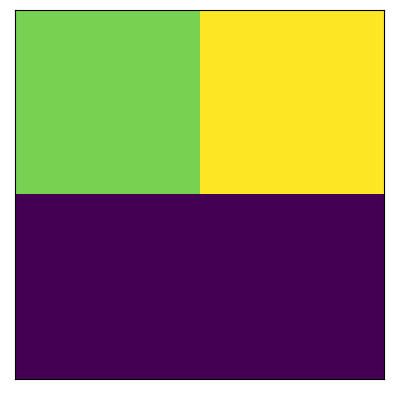

tf.Tensor(
[[4. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


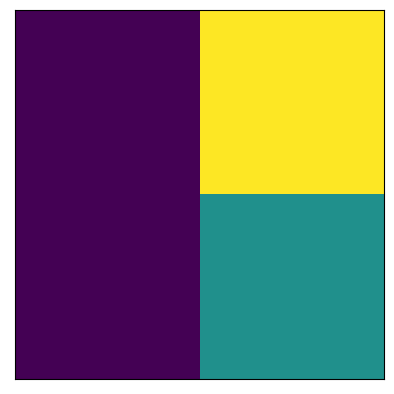

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


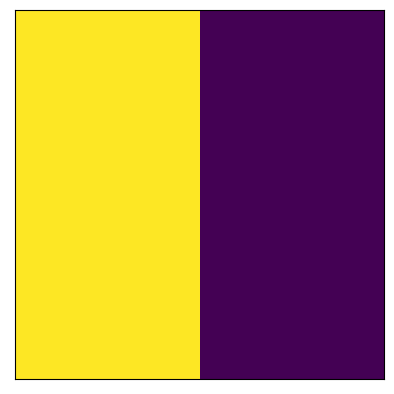

tf.Tensor(
[[1. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


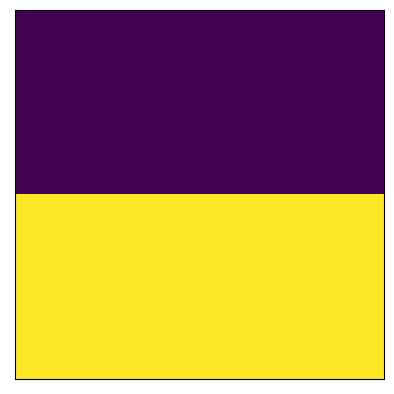

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


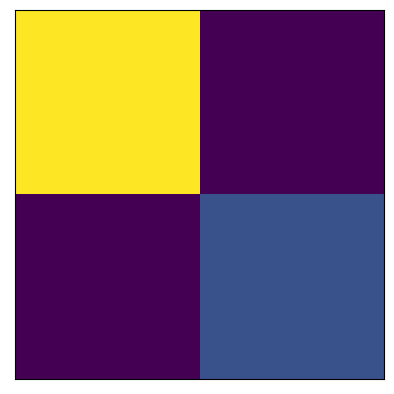

tf.Tensor(
[[4. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


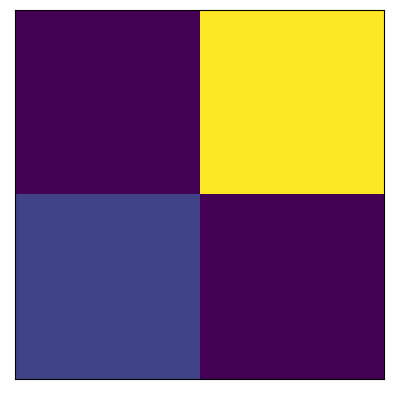

tf.Tensor(
[[0. 5.]
 [1. 0.]], shape=(2, 2), dtype=float32)


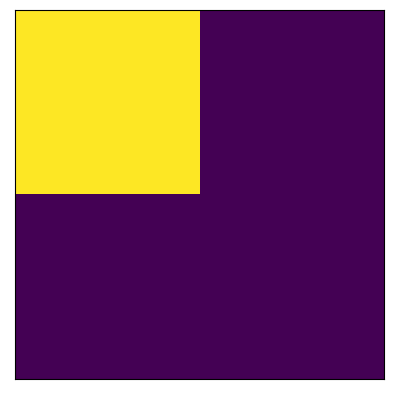

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


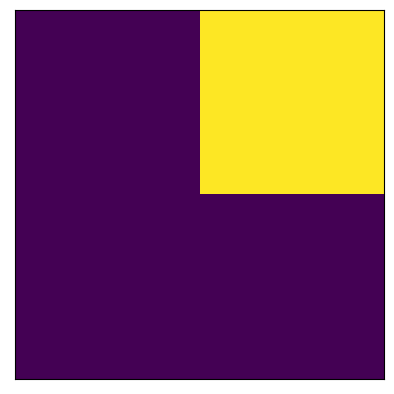

tf.Tensor(
[[0. 5.]
 [0. 0.]], shape=(2, 2), dtype=float32)


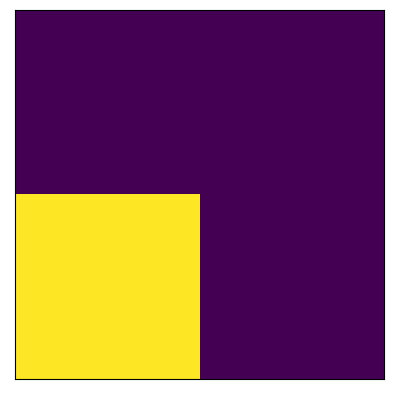

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


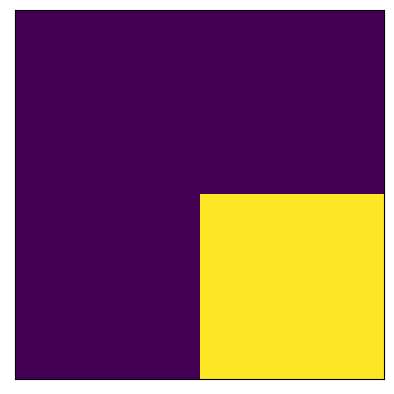

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


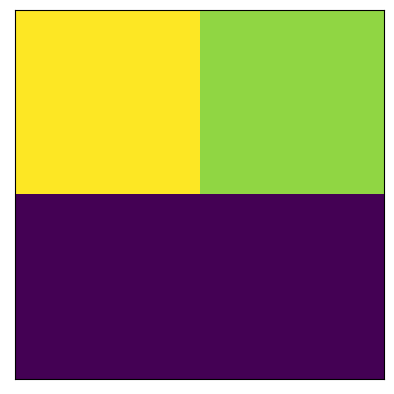

tf.Tensor(
[[0.24000001 0.2       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


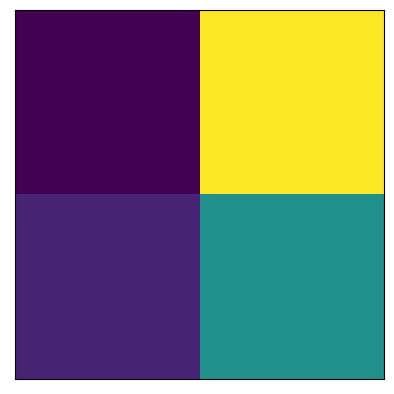

tf.Tensor(
[[0.         2.        ]
 [0.19999999 1.        ]], shape=(2, 2), dtype=float32)


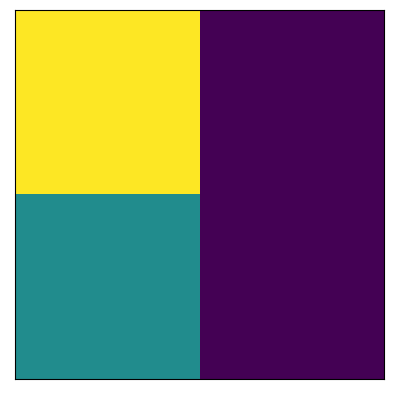

tf.Tensor(
[[1.64 0.  ]
 [0.8  0.  ]], shape=(2, 2), dtype=float32)


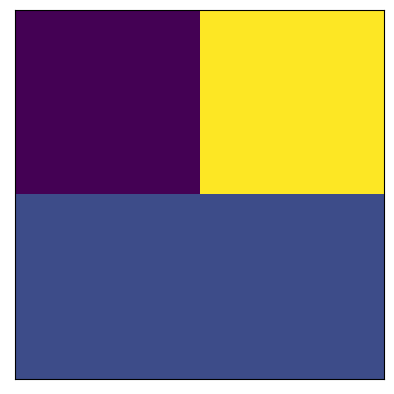

tf.Tensor(
[[0.76 1.8 ]
 [1.   1.  ]], shape=(2, 2), dtype=float32)


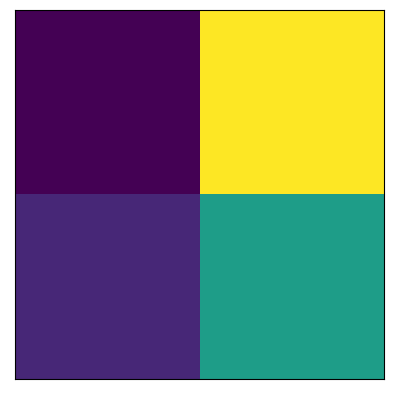

tf.Tensor(
[[0.         1.8       ]
 [0.19999999 1.        ]], shape=(2, 2), dtype=float32)


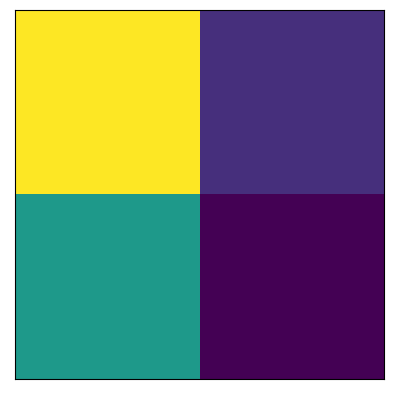

tf.Tensor(
[[1.48 0.2 ]
 [0.8  0.  ]], shape=(2, 2), dtype=float32)


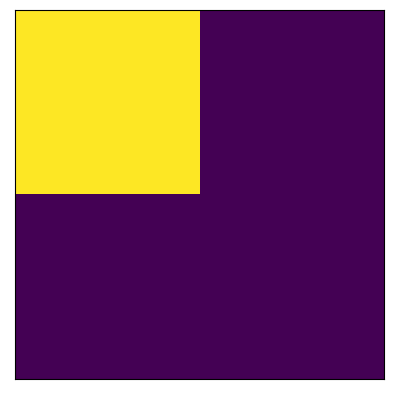

tf.Tensor(
[[0.2 0. ]
 [0.  0. ]], shape=(2, 2), dtype=float32)


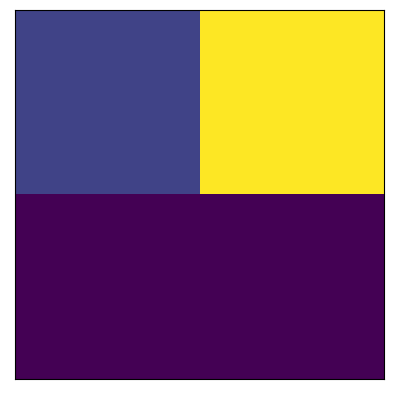

tf.Tensor(
[[0.04000001 0.2       ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


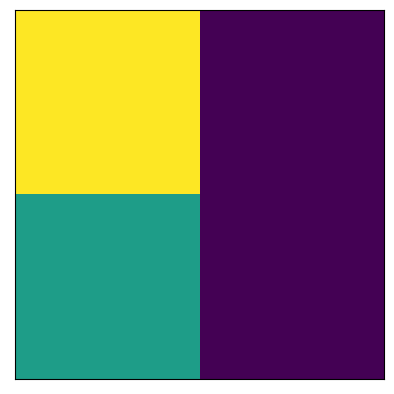

tf.Tensor(
[[1.44 0.  ]
 [0.8  0.  ]], shape=(2, 2), dtype=float32)


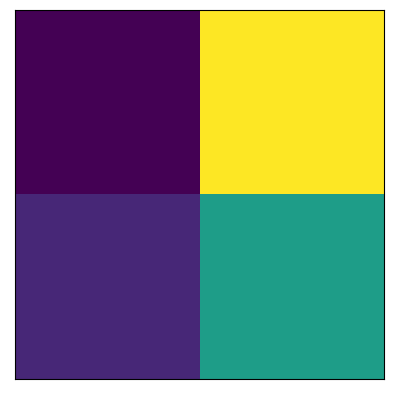

tf.Tensor(
[[0.         1.8       ]
 [0.19999999 1.        ]], shape=(2, 2), dtype=float32)


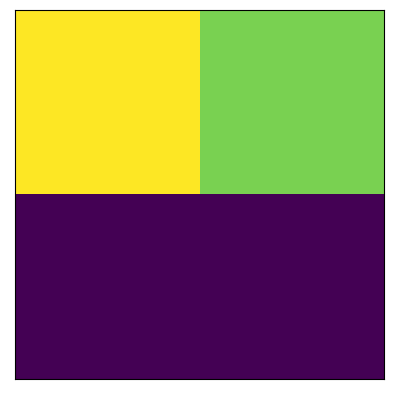

tf.Tensor(
[[5. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


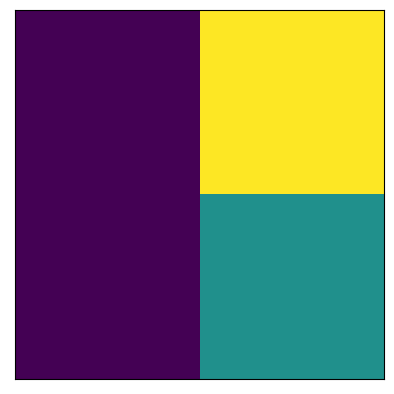

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


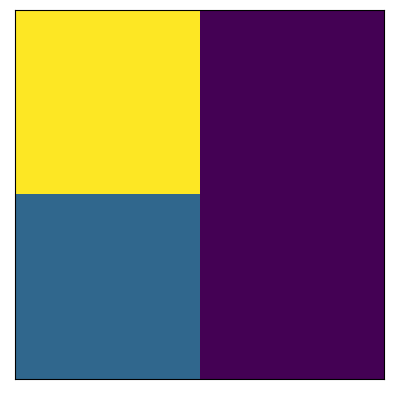

tf.Tensor(
[[3. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


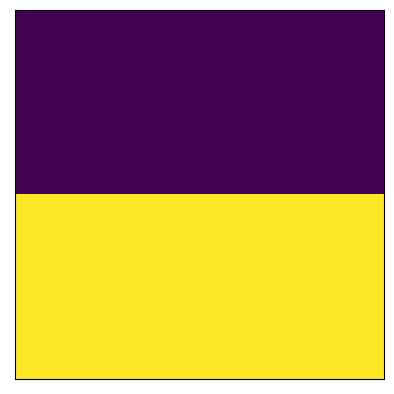

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


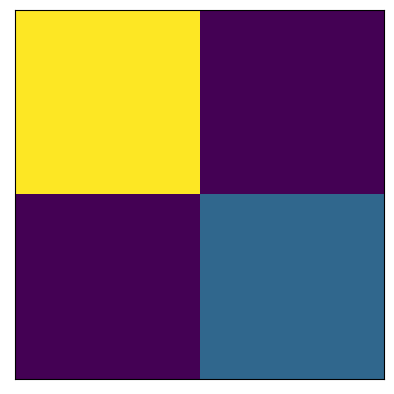

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


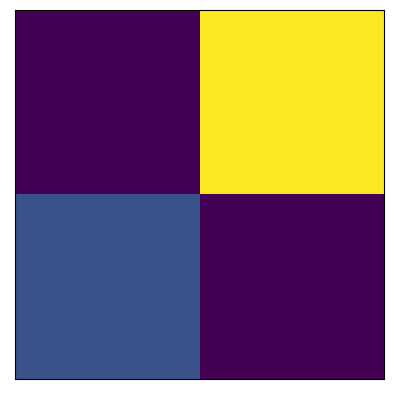

tf.Tensor(
[[0. 4.]
 [1. 0.]], shape=(2, 2), dtype=float32)


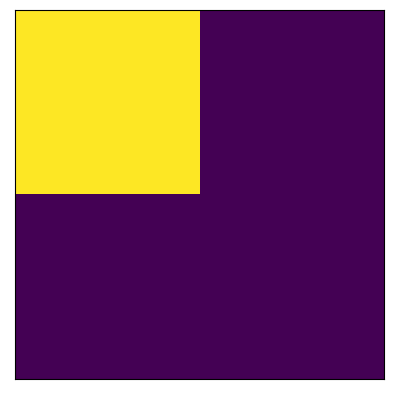

tf.Tensor(
[[5. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


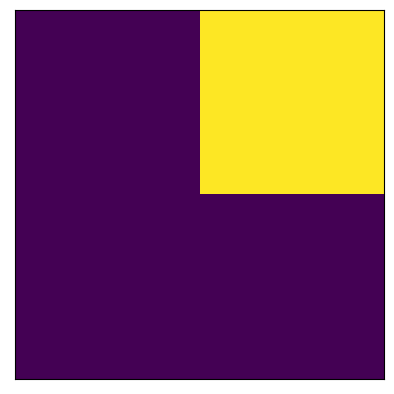

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


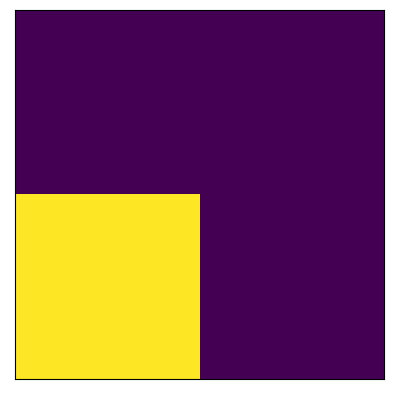

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


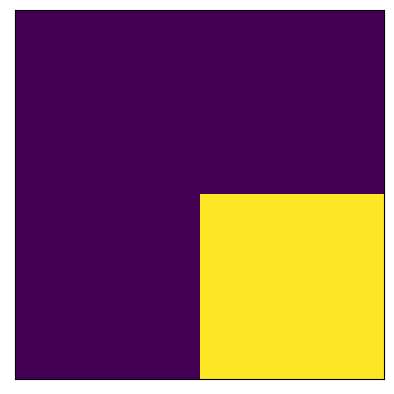

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


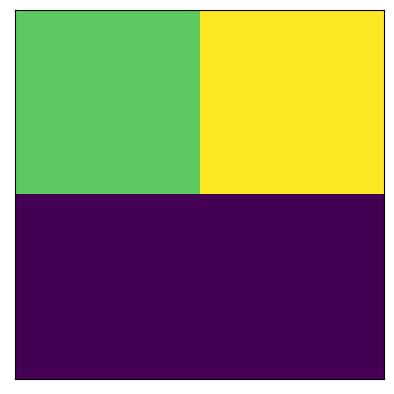

tf.Tensor(
[[0.1875 0.25  ]
 [0.     0.    ]], shape=(2, 2), dtype=float32)


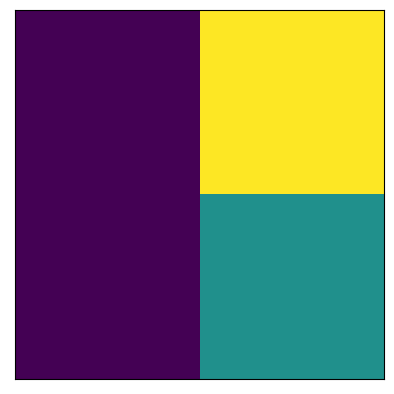

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


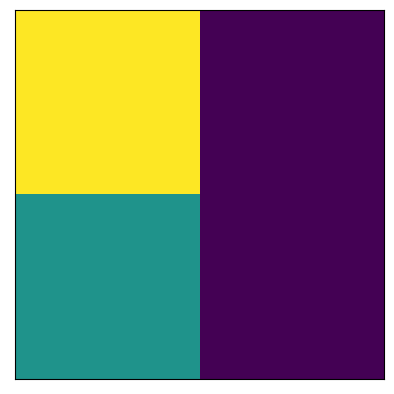

tf.Tensor(
[[2.4375 0.    ]
 [1.25   0.    ]], shape=(2, 2), dtype=float32)


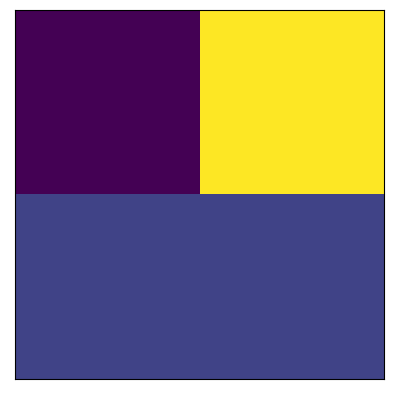

tf.Tensor(
[[0.8125 1.75  ]
 [1.     1.    ]], shape=(2, 2), dtype=float32)


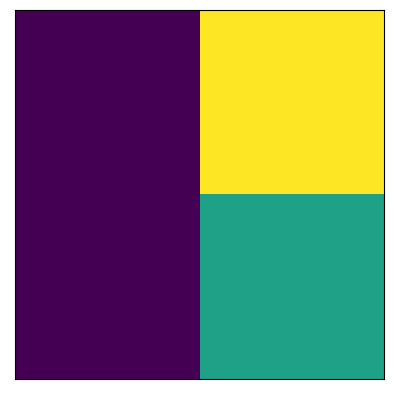

tf.Tensor(
[[0.   1.75]
 [0.   1.  ]], shape=(2, 2), dtype=float32)


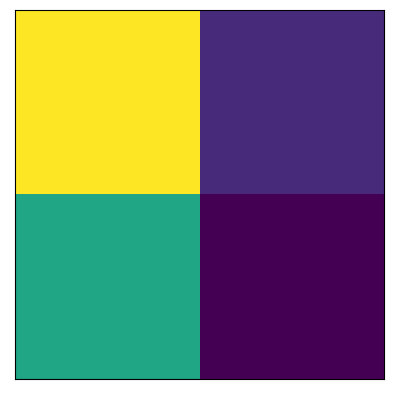

tf.Tensor(
[[2.125 0.25 ]
 [1.25  0.   ]], shape=(2, 2), dtype=float32)


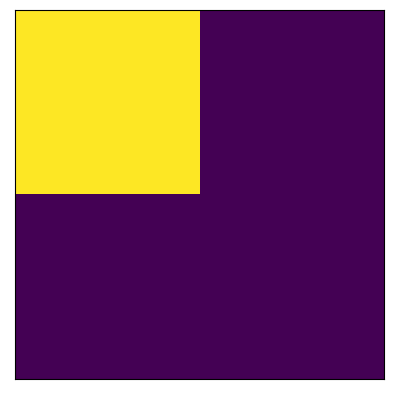

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


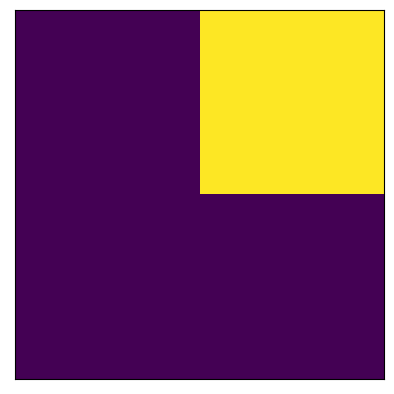

tf.Tensor(
[[0.   0.25]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


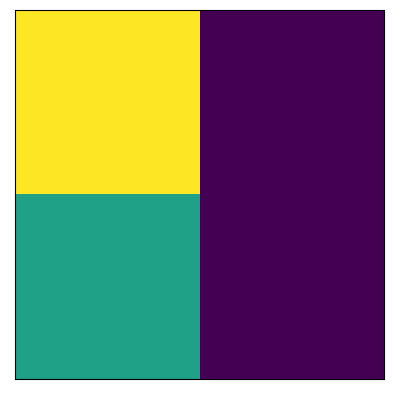

tf.Tensor(
[[2.1875 0.    ]
 [1.25   0.    ]], shape=(2, 2), dtype=float32)


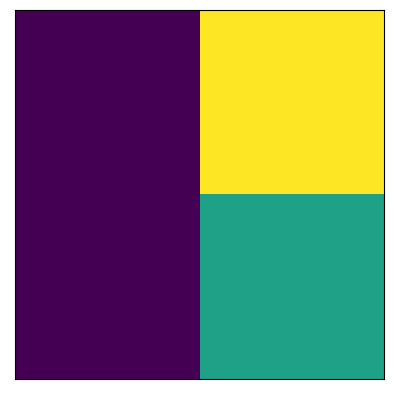

tf.Tensor(
[[0.   1.75]
 [0.   1.  ]], shape=(2, 2), dtype=float32)


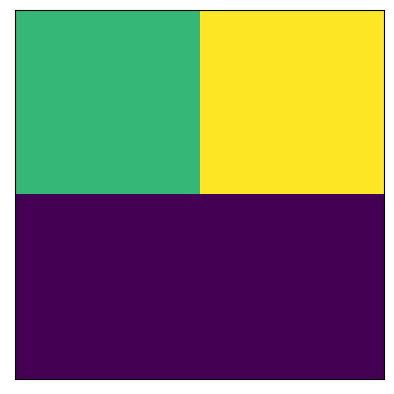

tf.Tensor(
[[4. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


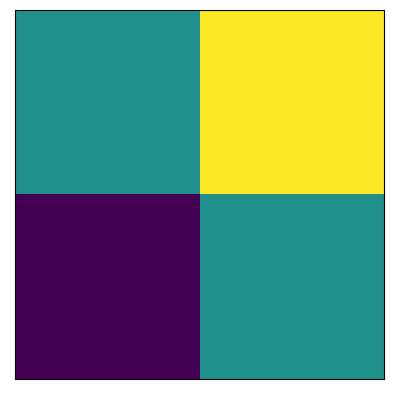

tf.Tensor(
[[1. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


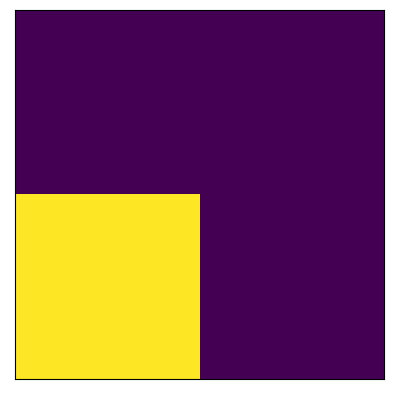

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


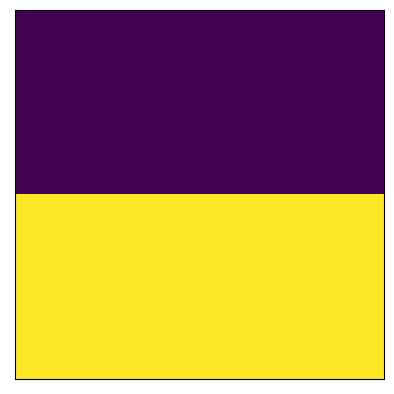

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


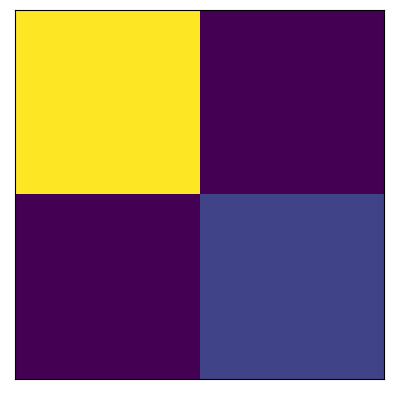

tf.Tensor(
[[5. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


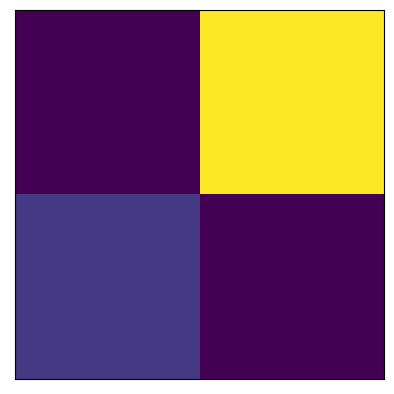

tf.Tensor(
[[0. 6.]
 [1. 0.]], shape=(2, 2), dtype=float32)


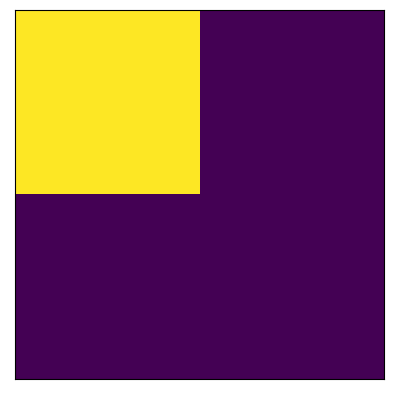

tf.Tensor(
[[4. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


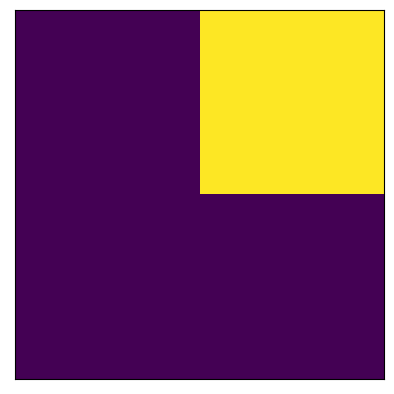

tf.Tensor(
[[0. 6.]
 [0. 0.]], shape=(2, 2), dtype=float32)


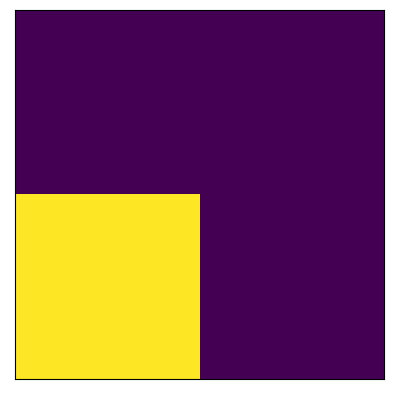

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


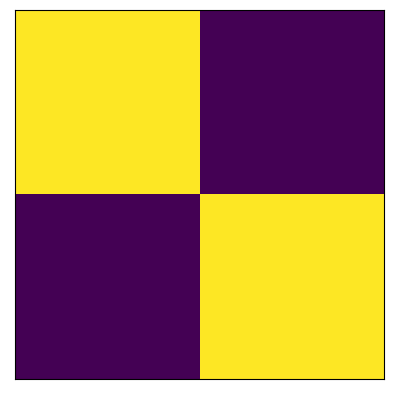

tf.Tensor(
[[1. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


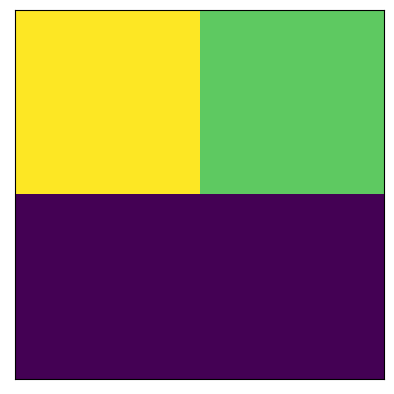

tf.Tensor(
[[0.22222222 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


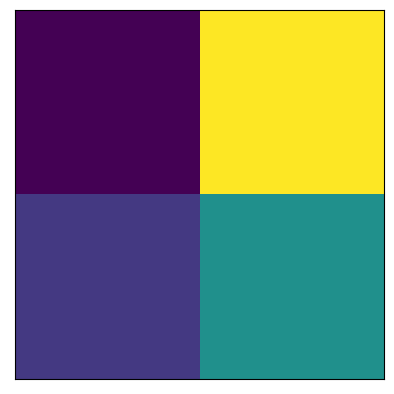

tf.Tensor(
[[0.        2.       ]
 [0.3333333 1.       ]], shape=(2, 2), dtype=float32)


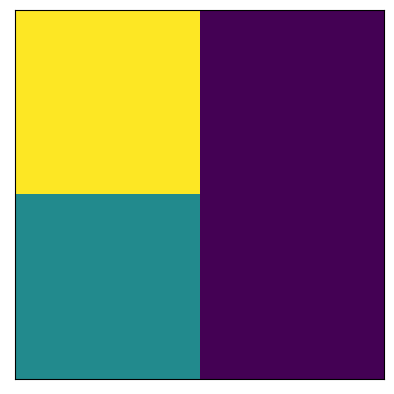

tf.Tensor(
[[1.388889  0.       ]
 [0.6666667 0.       ]], shape=(2, 2), dtype=float32)


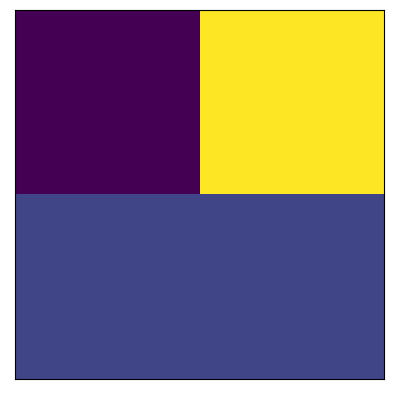

tf.Tensor(
[[0.7777778 1.8333334]
 [1.        1.       ]], shape=(2, 2), dtype=float32)


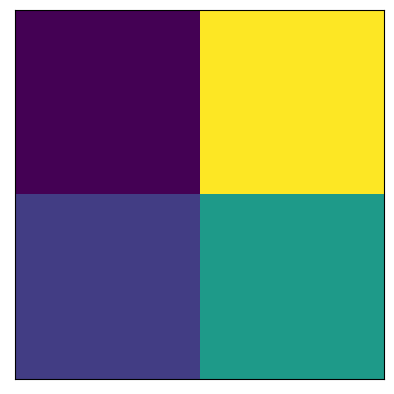

tf.Tensor(
[[0.        1.8333334]
 [0.3333333 1.       ]], shape=(2, 2), dtype=float32)


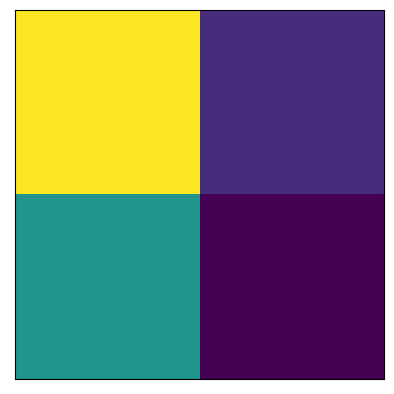

tf.Tensor(
[[1.2777778  0.16666667]
 [0.6666667  0.        ]], shape=(2, 2), dtype=float32)


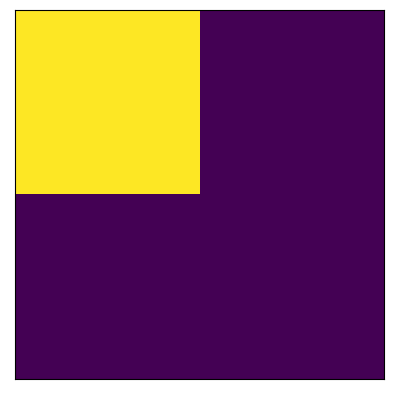

tf.Tensor(
[[0.16666667 0.        ]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


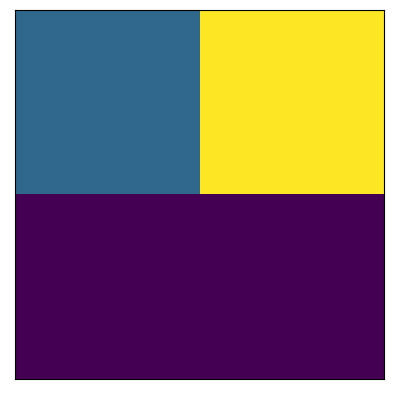

tf.Tensor(
[[0.05555556 0.16666667]
 [0.         0.        ]], shape=(2, 2), dtype=float32)


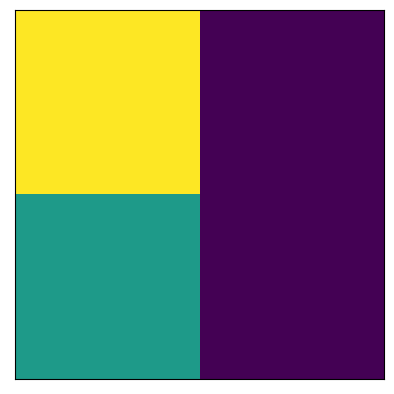

tf.Tensor(
[[1.2222222 0.       ]
 [0.6666667 0.       ]], shape=(2, 2), dtype=float32)


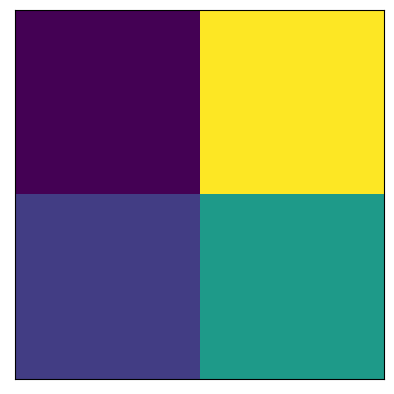

tf.Tensor(
[[0.        1.8333334]
 [0.3333333 1.       ]], shape=(2, 2), dtype=float32)


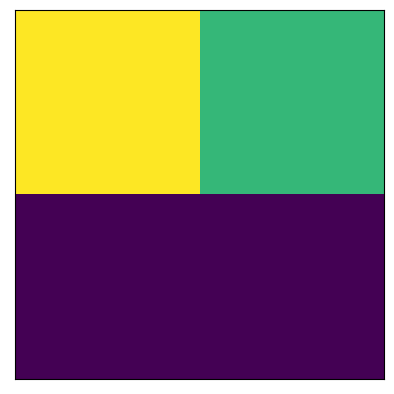

tf.Tensor(
[[6. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


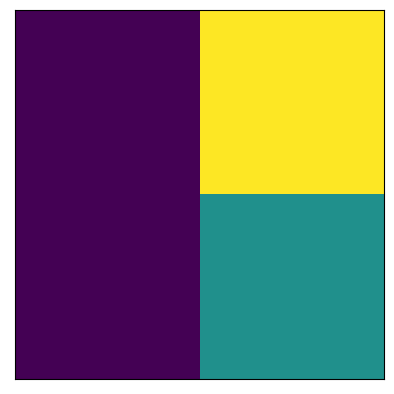

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


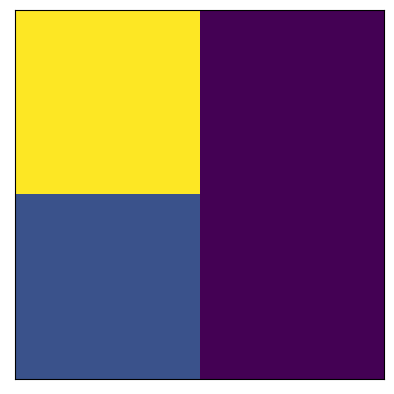

tf.Tensor(
[[4. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


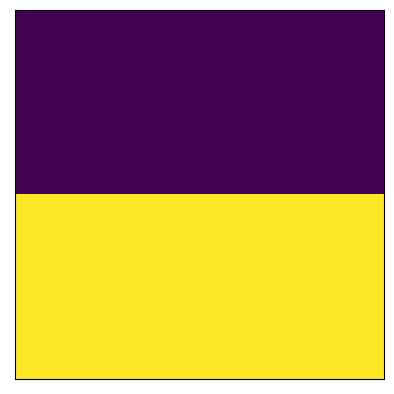

tf.Tensor(
[[0. 0.]
 [1. 1.]], shape=(2, 2), dtype=float32)


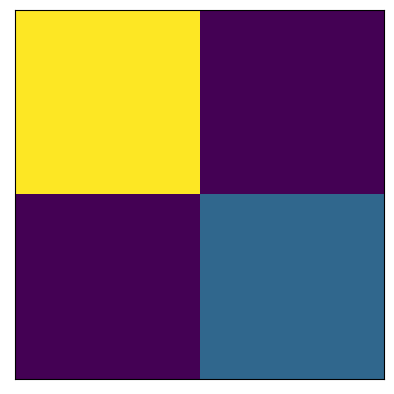

tf.Tensor(
[[3. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


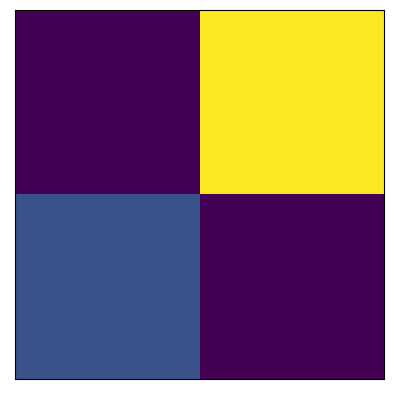

tf.Tensor(
[[0. 4.]
 [1. 0.]], shape=(2, 2), dtype=float32)


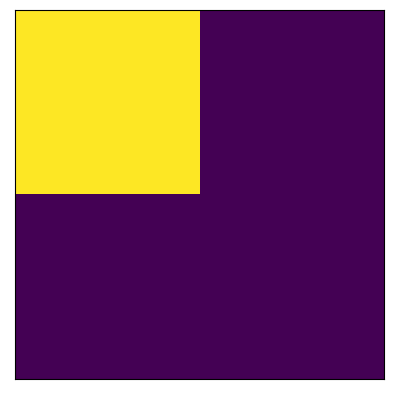

tf.Tensor(
[[6. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


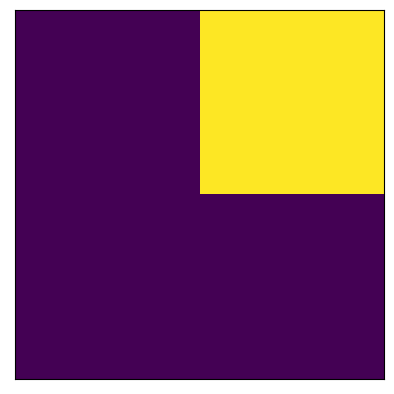

tf.Tensor(
[[0. 4.]
 [0. 0.]], shape=(2, 2), dtype=float32)


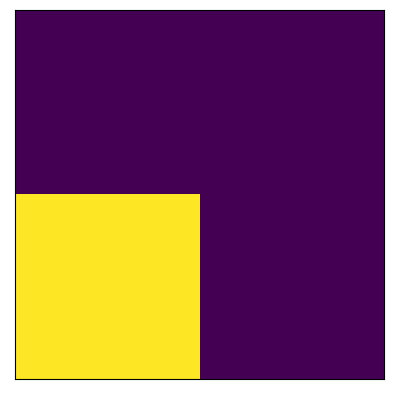

tf.Tensor(
[[0. 0.]
 [1. 0.]], shape=(2, 2), dtype=float32)


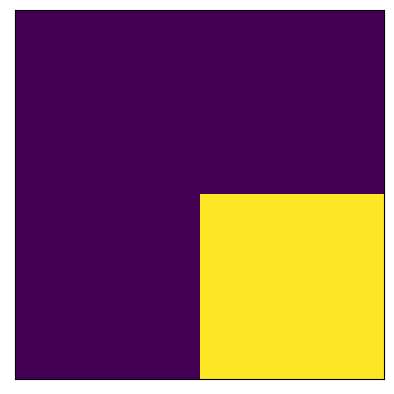

tf.Tensor(
[[0. 0.]
 [0. 1.]], shape=(2, 2), dtype=float32)


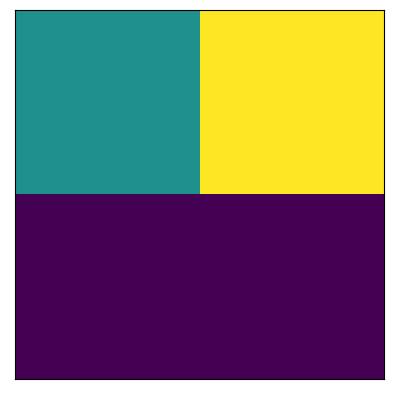

tf.Tensor(
[[0.125 0.25 ]
 [0.    0.   ]], shape=(2, 2), dtype=float32)


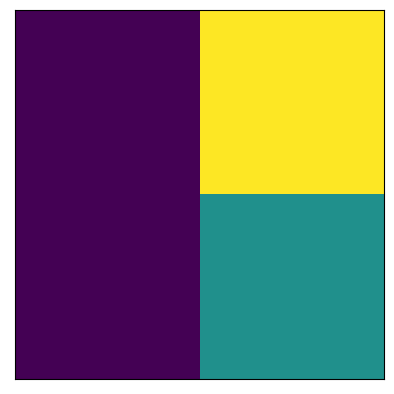

tf.Tensor(
[[0. 2.]
 [0. 1.]], shape=(2, 2), dtype=float32)


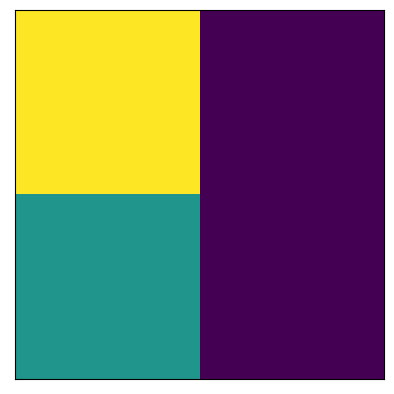

tf.Tensor(
[[2.875 0.   ]
 [1.5   0.   ]], shape=(2, 2), dtype=float32)


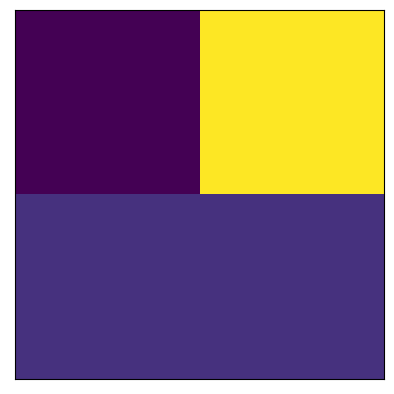

tf.Tensor(
[[0.875 1.75 ]
 [1.    1.   ]], shape=(2, 2), dtype=float32)


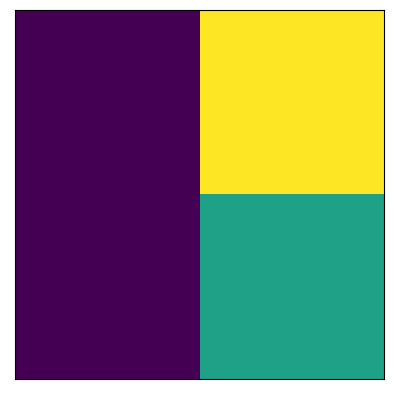

tf.Tensor(
[[0.   1.75]
 [0.   1.  ]], shape=(2, 2), dtype=float32)


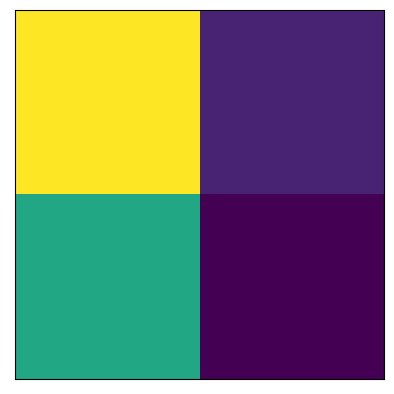

tf.Tensor(
[[2.5  0.25]
 [1.5  0.  ]], shape=(2, 2), dtype=float32)


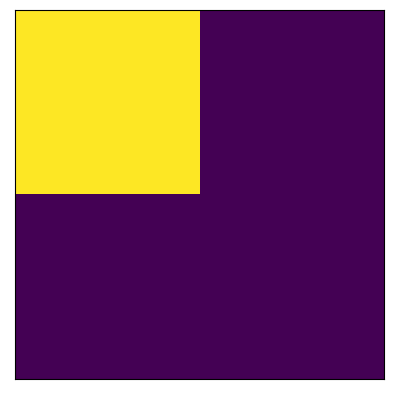

tf.Tensor(
[[0.25 0.  ]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


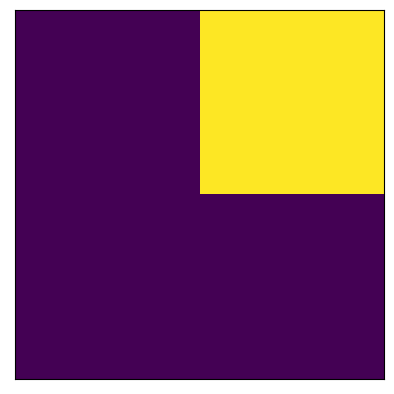

tf.Tensor(
[[0.   0.25]
 [0.   0.  ]], shape=(2, 2), dtype=float32)


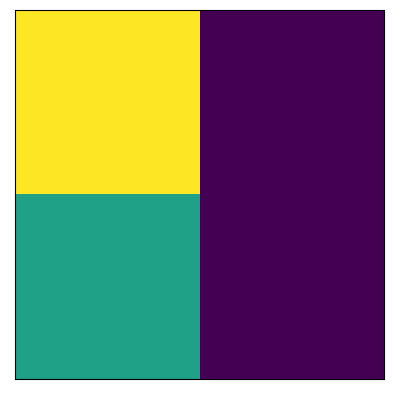

tf.Tensor(
[[2.625 0.   ]
 [1.5   0.   ]], shape=(2, 2), dtype=float32)


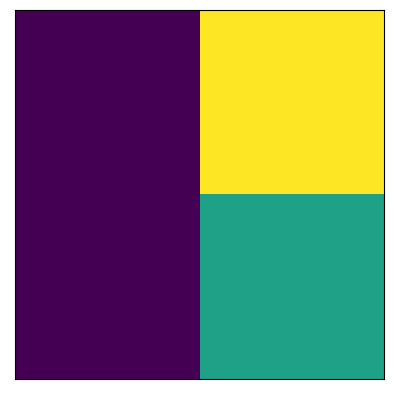

tf.Tensor(
[[0.   1.75]
 [0.   1.  ]], shape=(2, 2), dtype=float32)


In [205]:
show_features2(features,'conv2d_10')